In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-8) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差


    #主动学习更新配位点数据    
    def update_data(self, X_u, u, X_f):
        mu_x, sigma_x = X_f.mean(0), X_f.std(0)
        X_u = (X_u - mu_x) / sigma_x
        X_f = (X_f - mu_x) / sigma_x

        self.mu_x = torch.tensor(mu_x).float().to(device)
        self.sigma_x = torch.tensor(sigma_x).float().to(device)
        
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:, 0:1] #取u的第一列，对应状态1
        u2 = u[:, 1:2] #取u的第二列，对应状态2
        u3 = u[:, 2:3] #取u的第三列，对应状态3

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度

        #归一化
        u_x_1 = u_x_1 / self.sigma_x
        u_x_2 = u_x_2 / self.sigma_x
        u_x_3 = u_x_3 / self.sigma_x
        
        #计算残差
        xx = x * self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)    

        loss_1 = torch.mean(residual_1 ** 2)
        loss_2 = torch.mean(residual_2 ** 2)
        loss_3 = torch.mean(residual_3 ** 2)

        loss_f = loss_1 + loss_2 + loss_3
        return loss_f, residual_1+residual_2+residual_3
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0        

#读取真实解(基于MCS方法得到的解)
MCS_solution_df = pd.read_csv('MCS_non_homo_300.csv')
MCS_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

MCS_solution_df.drop(labels='time', inplace=True, axis = 1)


N_u = 1
N_f = 300

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 3]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([300.0])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0]])          # 初始真实状态
# X_f = np.linspace(lb, ub, N_f)     # 配位点位置，0~60000的5000个点

error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储chaos值
residuals = [] #创建一个空列表，用于存储residual值

i = 0 #初始化i为0

# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    N_f_1 = N_f // 10 #先拿50个点训练
    X_f_train = lb + (ub - lb) * lhs(1, N_f_1) #生成N_f个随机点
    nIter = 80000 #设置迭代次数为10000

    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u, u, X_f_train, layers, lb, ub)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter//100)


    for iter in range(nIter//100+1, nIter+1, nIter//100): #每800次迭代
        N_f_new = N_f_1 * 10 #重新采样500个点
        X_f_train_new = lb + (ub - lb) * lhs(1, N_f_new) #生成N_f_new个随机点

        #计算残差
        _, residual = model.predict(X_f_train_new)
        abs_residual = np.abs(residual)
        abs_residual = abs_residual.flatten()
        #对abs_residual进行归一化
        abs_residual = abs_residual / np.linalg.norm(abs_residual)


        #计算混沌度
        y_chaos = model.hidden_predict(X_f_train_new, 100)
        x_ssss = X_f_train_new + np.random.normal(0, 0.001)
        y_chaos_ssss = model.hidden_predict(x_ssss, 100)
        chaos = np.linalg.norm(y_chaos - y_chaos_ssss,axis=1)
        #对chaos进行归一化
        epsilon = 1e-10
        norm_chaos = np.linalg.norm(chaos)
        if norm_chaos > epsilon:
            chaos = chaos / norm_chaos
        else:
            chaos = np.zeros_like(chaos)


        #计算信息量
        xinxi = abs_residual + chaos

        #选出信息量最大的10个点
        # 找出绝对值最大的10个值的索引
        topk_indices = np.argpartition(xinxi, -N_f_1)[-N_f_1:] #该函数会对数组进行排序，使得指定的k个最大值出现在数组的最后k给位置上，并获取最后1000个元素

        # 使用这些索引来提取对应的数据
        X_f_train_topk = X_f_train_new[topk_indices]

        X_f_train = np.vstack((X_f_train, X_f_train_topk)) #与之前的训练数据合并

        # 更新模型中的X_f_train数据
        model.update_data(X_u, u, X_f_train)

        # 在更新数据后的模型上进行训练500次
        model.train(nIter//100)

    # print(X_f_train.shape)
    # 更新模型中的X_f_train数据
    model.update_data(X_u, u, X_f_train)
    
    # model.train(50000)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #真实值
    mu, sigma = model.mu_x, model.sigma_x

    # up = 80000
    n_star = 300+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_star = MCS_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star - y_pred))
    mse = np.mean((y_star - y_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star-y_pred,2)/np.linalg.norm(y_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|          | 6/800 [00:00<00:13, 59.36it/s]

Adam:   8%|▊         | 62/800 [00:00<00:02, 350.21it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:01, 471.91it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:01, 458.12it/s]

Adam:  28%|██▊       | 222/800 [00:00<00:01, 471.49it/s]

Adam:  34%|███▍      | 270/800 [00:00<00:01, 447.06it/s]

Adam:  40%|████      | 321/800 [00:00<00:01, 465.42it/s]

Adam:  46%|████▌     | 369/800 [00:00<00:00, 467.53it/s]

Adam:  52%|█████▏    | 417/800 [00:00<00:00, 469.51it/s]

Adam:  58%|█████▊    | 465/800 [00:01<00:00, 469.58it/s]

Adam:  65%|██████▌   | 523/800 [00:01<00:00, 500.20it/s]

Adam:  72%|███████▏  | 574/800 [00:01<00:00, 489.44it/s]

Adam:  78%|███████▊  | 627/800 [00:01<00:00, 500.70it/s]

Adam:  85%|████████▍ | 678/800 [00:01<00:00, 487.52it/s]

Adam:  92%|█████████▏| 735/800 [00:01<00:00, 509.86it/s]

Adam:  98%|█████████▊| 787/800 [00:01<00:00, 491.92it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 470.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▌         | 46/800 [00:00<00:01, 457.62it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:01, 493.90it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:01, 494.93it/s]

Adam:  25%|██▍       | 198/800 [00:00<00:01, 481.77it/s]

Adam:  31%|███       | 247/800 [00:00<00:01, 482.87it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:01, 457.92it/s]

Adam:  43%|████▎     | 343/800 [00:00<00:01, 453.92it/s]

Adam:  49%|████▊     | 389/800 [00:00<00:00, 437.56it/s]

Adam:  56%|█████▌    | 445/800 [00:00<00:00, 472.23it/s]

Adam:  62%|██████▏   | 493/800 [00:01<00:00, 443.90it/s]

Adam:  68%|██████▊   | 541/800 [00:01<00:00, 452.83it/s]

Adam:  73%|███████▎  | 587/800 [00:01<00:00, 445.37it/s]

Adam:  79%|███████▉  | 632/800 [00:01<00:00, 415.93it/s]

Adam:  84%|████████▍ | 675/800 [00:01<00:00, 417.61it/s]

Adam:  90%|████████▉ | 718/800 [00:01<00:00, 420.88it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 449.96it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 453.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   7%|▋         | 53/800 [00:00<00:01, 524.56it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:01, 472.76it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:01, 444.07it/s]

Adam:  25%|██▍       | 199/800 [00:00<00:01, 403.64it/s]

Adam:  30%|███       | 240/800 [00:00<00:01, 400.48it/s]

Adam:  36%|███▌      | 285/800 [00:00<00:01, 412.68it/s]

Adam:  41%|████      | 327/800 [00:00<00:01, 412.55it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:00, 440.42it/s]

Adam:  53%|█████▎    | 423/800 [00:00<00:00, 427.64it/s]

Adam:  58%|█████▊    | 467/800 [00:01<00:00, 430.56it/s]

Adam:  64%|██████▍   | 511/800 [00:01<00:00, 405.00it/s]

Adam:  69%|██████▉   | 552/800 [00:01<00:00, 387.68it/s]

Adam:  74%|███████▍  | 592/800 [00:01<00:00, 390.39it/s]

Adam:  80%|███████▉  | 638/800 [00:01<00:00, 408.86it/s]

Adam:  86%|████████▌ | 689/800 [00:01<00:00, 435.50it/s]

Adam:  93%|█████████▎| 741/800 [00:01<00:00, 459.10it/s]

Adam:  98%|█████████▊| 788/800 [00:01<00:00, 425.09it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 423.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▍         | 38/800 [00:00<00:02, 374.39it/s]

Adam:  10%|█         | 81/800 [00:00<00:01, 400.87it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:01, 394.42it/s]

Adam:  20%|██        | 162/800 [00:00<00:01, 389.11it/s]

Adam:  26%|██▋       | 212/800 [00:00<00:01, 427.47it/s]

Adam:  33%|███▎      | 264/800 [00:00<00:01, 454.71it/s]

Adam:  39%|███▉      | 313/800 [00:00<00:01, 462.34it/s]

Adam:  45%|████▌     | 360/800 [00:00<00:00, 458.78it/s]

Adam:  51%|█████     | 406/800 [00:00<00:00, 445.48it/s]

Adam:  57%|█████▋    | 457/800 [00:01<00:00, 463.95it/s]

Adam:  63%|██████▎   | 504/800 [00:01<00:00, 464.92it/s]

Adam:  69%|██████▉   | 551/800 [00:01<00:00, 455.73it/s]

Adam:  75%|███████▌  | 603/800 [00:01<00:00, 472.26it/s]

Adam:  81%|████████▏ | 651/800 [00:01<00:00, 472.72it/s]

Adam:  88%|████████▊ | 705/800 [00:01<00:00, 491.40it/s]

Adam:  94%|█████████▍| 756/800 [00:01<00:00, 495.33it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 460.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   7%|▋         | 53/800 [00:00<00:01, 527.70it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:01, 421.17it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:01, 443.58it/s]

Adam:  25%|██▌       | 202/800 [00:00<00:01, 454.85it/s]

Adam:  31%|███       | 249/800 [00:00<00:01, 444.92it/s]

Adam:  37%|███▋      | 294/800 [00:00<00:01, 439.82it/s]

Adam:  43%|████▎     | 347/800 [00:00<00:00, 465.48it/s]

Adam:  49%|████▉     | 394/800 [00:00<00:00, 449.21it/s]

Adam:  56%|█████▌    | 446/800 [00:00<00:00, 468.41it/s]

Adam:  62%|██████▏   | 495/800 [00:01<00:00, 474.59it/s]

Adam:  68%|██████▊   | 543/800 [00:01<00:00, 458.99it/s]

Adam:  74%|███████▍  | 590/800 [00:01<00:00, 442.97it/s]

Adam:  80%|███████▉  | 639/800 [00:01<00:00, 455.82it/s]

Adam:  87%|████████▋ | 693/800 [00:01<00:00, 478.88it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 473.88it/s]

Adam:  99%|█████████▉| 790/800 [00:01<00:00, 458.61it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 454.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▍         | 39/800 [00:00<00:01, 387.88it/s]

Adam:  10%|█         | 80/800 [00:00<00:01, 397.82it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:01, 444.09it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:01, 452.56it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:01, 451.63it/s]

Adam:  34%|███▎      | 269/800 [00:00<00:01, 429.42it/s]

Adam:  39%|███▉      | 313/800 [00:00<00:01, 429.50it/s]

Adam:  45%|████▌     | 363/800 [00:00<00:00, 447.90it/s]

Adam:  51%|█████     | 408/800 [00:00<00:00, 431.86it/s]

Adam:  57%|█████▋    | 457/800 [00:01<00:00, 448.47it/s]

Adam:  64%|██████▎   | 509/800 [00:01<00:00, 469.14it/s]

Adam:  70%|██████▉   | 557/800 [00:01<00:00, 467.67it/s]

Adam:  76%|███████▌  | 604/800 [00:01<00:00, 436.57it/s]

Adam:  81%|████████  | 649/800 [00:01<00:00, 401.70it/s]

Adam:  86%|████████▋ | 690/800 [00:01<00:00, 397.79it/s]

Adam:  93%|█████████▎| 742/800 [00:01<00:00, 428.89it/s]

Adam:  98%|█████████▊| 786/800 [00:01<00:00, 418.70it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 429.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▌         | 43/800 [00:00<00:01, 421.75it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:01, 477.70it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:01, 436.90it/s]

Adam:  24%|██▎       | 188/800 [00:00<00:01, 430.90it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:01, 425.51it/s]

Adam:  35%|███▍      | 277/800 [00:00<00:01, 428.51it/s]

Adam:  40%|████      | 320/800 [00:00<00:01, 404.67it/s]

Adam:  46%|████▌     | 368/800 [00:00<00:01, 423.50it/s]

Adam:  52%|█████▏    | 418/800 [00:00<00:00, 444.01it/s]

Adam:  59%|█████▉    | 471/800 [00:01<00:00, 466.92it/s]

Adam:  65%|██████▌   | 521/800 [00:01<00:00, 475.32it/s]

Adam:  72%|███████▏  | 573/800 [00:01<00:00, 487.02it/s]

Adam:  78%|███████▊  | 622/800 [00:01<00:00, 473.20it/s]

Adam:  84%|████████▍ | 674/800 [00:01<00:00, 486.00it/s]

Adam:  90%|█████████ | 723/800 [00:01<00:00, 478.09it/s]

Adam:  96%|█████████▋| 771/800 [00:01<00:00, 452.39it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 451.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▌         | 44/800 [00:00<00:01, 435.27it/s]

Adam:  11%|█         | 88/800 [00:00<00:01, 408.99it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:01, 428.61it/s]

Adam:  23%|██▎       | 185/800 [00:00<00:01, 458.09it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:01, 437.12it/s]

Adam:  36%|███▌      | 286/800 [00:00<00:01, 473.37it/s]

Adam:  42%|████▏     | 334/800 [00:00<00:01, 464.26it/s]

Adam:  48%|████▊     | 383/800 [00:00<00:00, 469.90it/s]

Adam:  54%|█████▍    | 433/800 [00:00<00:00, 475.37it/s]

Adam:  60%|██████    | 481/800 [00:01<00:00, 464.78it/s]

Adam:  67%|██████▋   | 533/800 [00:01<00:00, 479.83it/s]

Adam:  73%|███████▎  | 582/800 [00:01<00:00, 472.11it/s]

Adam:  79%|███████▉  | 631/800 [00:01<00:00, 475.21it/s]

Adam:  85%|████████▍ | 679/800 [00:01<00:00, 460.42it/s]

Adam:  91%|█████████ | 726/800 [00:01<00:00, 455.68it/s]

Adam:  97%|█████████▋| 773/800 [00:01<00:00, 459.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 463.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▋         | 50/800 [00:00<00:01, 491.35it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:01, 390.02it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:01, 388.51it/s]

Adam:  23%|██▎       | 181/800 [00:00<00:01, 389.29it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:01, 436.26it/s]

Adam:  35%|███▍      | 279/800 [00:00<00:01, 434.83it/s]

Adam:  41%|████      | 328/800 [00:00<00:01, 450.54it/s]

Adam:  47%|████▋     | 379/800 [00:00<00:00, 466.23it/s]

Adam:  53%|█████▎    | 426/800 [00:00<00:00, 458.24it/s]

Adam:  59%|█████▉    | 473/800 [00:01<00:00, 427.38it/s]

Adam:  65%|██████▌   | 520/800 [00:01<00:00, 437.99it/s]

Adam:  71%|███████   | 565/800 [00:01<00:00, 438.80it/s]

Adam:  77%|███████▋  | 618/800 [00:01<00:00, 464.96it/s]

Adam:  84%|████████▎ | 669/800 [00:01<00:00, 475.52it/s]

Adam:  90%|████████▉ | 717/800 [00:01<00:00, 475.05it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 455.86it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 443.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▌         | 42/800 [00:00<00:01, 418.38it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:01, 472.53it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:01, 489.62it/s]

Adam:  24%|██▍       | 195/800 [00:00<00:01, 458.07it/s]

Adam:  30%|███       | 242/800 [00:00<00:01, 443.37it/s]

Adam:  36%|███▌      | 287/800 [00:00<00:01, 438.10it/s]

Adam:  42%|████▏     | 333/800 [00:00<00:01, 443.60it/s]

Adam:  47%|████▋     | 378/800 [00:00<00:01, 415.87it/s]

Adam:  54%|█████▍    | 432/800 [00:00<00:00, 451.50it/s]

Adam:  60%|██████    | 481/800 [00:01<00:00, 460.71it/s]

Adam:  67%|██████▋   | 534/800 [00:01<00:00, 479.66it/s]

Adam:  74%|███████▎  | 588/800 [00:01<00:00, 495.30it/s]

Adam:  80%|███████▉  | 639/800 [00:01<00:00, 497.24it/s]

Adam:  86%|████████▋ | 692/800 [00:01<00:00, 505.35it/s]

Adam:  93%|█████████▎| 743/800 [00:01<00:00, 469.94it/s]

Adam:  99%|█████████▉| 791/800 [00:01<00:00, 460.06it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 463.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   7%|▋         | 55/800 [00:00<00:01, 538.09it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:01, 416.59it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:01, 387.96it/s]

Adam:  24%|██▍       | 193/800 [00:00<00:01, 380.77it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:01, 369.42it/s]

Adam:  35%|███▍      | 277/800 [00:00<00:01, 393.71it/s]

Adam:  40%|████      | 324/800 [00:00<00:01, 416.16it/s]

Adam:  47%|████▋     | 375/800 [00:00<00:00, 441.92it/s]

Adam:  53%|█████▎    | 422/800 [00:01<00:00, 447.98it/s]

Adam:  58%|█████▊    | 468/800 [00:01<00:00, 432.01it/s]

Adam:  64%|██████▍   | 512/800 [00:01<00:00, 417.10it/s]

Adam:  69%|██████▉   | 554/800 [00:01<00:00, 416.80it/s]

Adam:  75%|███████▌  | 602/800 [00:01<00:00, 432.89it/s]

Adam:  82%|████████▏ | 653/800 [00:01<00:00, 452.86it/s]

Adam:  88%|████████▊ | 704/800 [00:01<00:00, 469.54it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 495.93it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 440.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▋         | 52/800 [00:00<00:01, 512.95it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:01, 520.20it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:01, 471.77it/s]

Adam:  26%|██▌       | 206/800 [00:00<00:01, 416.36it/s]

Adam:  31%|███       | 249/800 [00:00<00:01, 380.67it/s]

Adam:  36%|███▋      | 292/800 [00:00<00:01, 394.85it/s]

Adam:  42%|████▏     | 336/800 [00:00<00:01, 404.69it/s]

Adam:  48%|████▊     | 381/800 [00:00<00:01, 417.21it/s]

Adam:  54%|█████▍    | 432/800 [00:01<00:00, 443.14it/s]

Adam:  60%|██████    | 482/800 [00:01<00:00, 457.26it/s]

Adam:  67%|██████▋   | 536/800 [00:01<00:00, 481.44it/s]

Adam:  73%|███████▎  | 585/800 [00:01<00:00, 478.33it/s]

Adam:  79%|███████▉  | 634/800 [00:01<00:00, 457.91it/s]

Adam:  85%|████████▌ | 681/800 [00:01<00:00, 438.51it/s]

Adam:  91%|█████████ | 726/800 [00:01<00:00, 400.65it/s]

Adam:  97%|█████████▋| 775/800 [00:01<00:00, 423.32it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 436.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▌         | 44/800 [00:00<00:01, 435.47it/s]

Adam:  11%|█         | 89/800 [00:00<00:01, 441.87it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:01, 451.64it/s]

Adam:  23%|██▎       | 186/800 [00:00<00:01, 467.69it/s]

Adam:  29%|██▉       | 233/800 [00:00<00:01, 450.28it/s]

Adam:  35%|███▌      | 280/800 [00:00<00:01, 454.31it/s]

Adam:  41%|████▏     | 330/800 [00:00<00:01, 467.45it/s]

Adam:  48%|████▊     | 380/800 [00:00<00:00, 475.68it/s]

Adam:  54%|█████▎    | 429/800 [00:00<00:00, 477.70it/s]

Adam:  60%|██████    | 480/800 [00:01<00:00, 486.22it/s]

Adam:  66%|██████▋   | 531/800 [00:01<00:00, 492.72it/s]

Adam:  73%|███████▎  | 581/800 [00:01<00:00, 459.91it/s]

Adam:  79%|███████▉  | 633/800 [00:01<00:00, 475.17it/s]

Adam:  85%|████████▌ | 681/800 [00:01<00:00, 461.18it/s]

Adam:  91%|█████████ | 728/800 [00:01<00:00, 453.48it/s]

Adam:  97%|█████████▋| 774/800 [00:01<00:00, 414.86it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 454.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▌         | 45/800 [00:00<00:01, 439.40it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:01, 443.80it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:01, 409.19it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:01, 399.13it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:01, 409.33it/s]

Adam:  34%|███▍      | 273/800 [00:00<00:01, 446.87it/s]

Adam:  40%|███▉      | 318/800 [00:00<00:01, 432.97it/s]

Adam:  45%|████▌     | 362/800 [00:00<00:01, 418.55it/s]

Adam:  51%|█████     | 405/800 [00:00<00:00, 412.93it/s]

Adam:  57%|█████▋    | 453/800 [00:01<00:00, 432.05it/s]

Adam:  62%|██████▏   | 499/800 [00:01<00:00, 437.65it/s]

Adam:  68%|██████▊   | 543/800 [00:01<00:00, 410.11it/s]

Adam:  74%|███████▍  | 593/800 [00:01<00:00, 434.13it/s]

Adam:  80%|███████▉  | 637/800 [00:01<00:00, 433.63it/s]

Adam:  85%|████████▌ | 682/800 [00:01<00:00, 436.31it/s]

Adam:  91%|█████████ | 726/800 [00:01<00:00, 437.07it/s]

Adam:  96%|█████████▋| 770/800 [00:01<00:00, 419.76it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 423.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▍         | 39/800 [00:00<00:02, 375.47it/s]

Adam:  10%|▉         | 77/800 [00:00<00:02, 346.51it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:01, 368.82it/s]

Adam:  20%|██        | 160/800 [00:00<00:01, 391.06it/s]

Adam:  26%|██▌       | 206/800 [00:00<00:01, 411.75it/s]

Adam:  31%|███       | 249/800 [00:00<00:01, 416.41it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:01, 437.37it/s]

Adam:  43%|████▎     | 342/800 [00:00<00:01, 428.22it/s]

Adam:  49%|████▊     | 389/800 [00:00<00:00, 438.65it/s]

Adam:  54%|█████▍    | 435/800 [00:01<00:00, 440.60it/s]

Adam:  60%|██████    | 480/800 [00:01<00:00, 427.81it/s]

Adam:  65%|██████▌   | 523/800 [00:01<00:00, 427.64it/s]

Adam:  71%|███████   | 566/800 [00:01<00:00, 422.26it/s]

Adam:  76%|███████▋  | 612/800 [00:01<00:00, 431.65it/s]

Adam:  83%|████████▎ | 663/800 [00:01<00:00, 454.05it/s]

Adam:  89%|████████▉ | 715/800 [00:01<00:00, 473.05it/s]

Adam:  95%|█████████▌| 763/800 [00:01<00:00, 469.40it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 434.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   7%|▋         | 53/800 [00:00<00:01, 518.75it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:01, 485.83it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:01, 502.56it/s]

Adam:  26%|██▌       | 209/800 [00:00<00:01, 494.93it/s]

Adam:  32%|███▏      | 259/800 [00:00<00:01, 438.62it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:01, 433.03it/s]

Adam:  44%|████▎     | 348/800 [00:00<00:01, 434.87it/s]

Adam:  50%|████▉     | 396/800 [00:00<00:00, 447.71it/s]

Adam:  55%|█████▌    | 443/800 [00:00<00:00, 452.30it/s]

Adam:  61%|██████    | 489/800 [00:01<00:00, 412.87it/s]

Adam:  66%|██████▋   | 532/800 [00:01<00:00, 398.45it/s]

Adam:  72%|███████▏  | 573/800 [00:01<00:00, 398.10it/s]

Adam:  77%|███████▋  | 614/800 [00:01<00:00, 393.84it/s]

Adam:  83%|████████▎ | 666/800 [00:01<00:00, 428.14it/s]

Adam:  90%|████████▉ | 717/800 [00:01<00:00, 450.79it/s]

Adam:  96%|█████████▌| 765/800 [00:01<00:00, 456.71it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 439.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▋         | 51/800 [00:00<00:01, 497.85it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:01, 480.83it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:01, 458.16it/s]

Adam:  25%|██▍       | 198/800 [00:00<00:01, 463.08it/s]

Adam:  31%|███▏      | 251/800 [00:00<00:01, 485.37it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:01, 485.61it/s]

Adam:  44%|████▎     | 349/800 [00:00<00:00, 452.33it/s]

Adam:  49%|████▉     | 395/800 [00:00<00:00, 451.48it/s]

Adam:  55%|█████▌    | 441/800 [00:00<00:00, 441.11it/s]

Adam:  61%|██████    | 487/800 [00:01<00:00, 445.72it/s]

Adam:  67%|██████▋   | 533/800 [00:01<00:00, 448.91it/s]

Adam:  73%|███████▎  | 584/800 [00:01<00:00, 466.94it/s]

Adam:  79%|███████▉  | 632/800 [00:01<00:00, 469.80it/s]

Adam:  85%|████████▌ | 680/800 [00:01<00:00, 452.72it/s]

Adam:  91%|█████████ | 726/800 [00:01<00:00, 452.34it/s]

Adam:  96%|█████████▋| 772/800 [00:01<00:00, 448.80it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 456.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▌         | 41/800 [00:00<00:01, 409.23it/s]

Adam:  10%|█         | 82/800 [00:00<00:01, 385.35it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:01, 416.77it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:01, 433.32it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:01, 452.40it/s]

Adam:  34%|███▎      | 269/800 [00:00<00:01, 446.40it/s]

Adam:  39%|███▉      | 314/800 [00:00<00:01, 413.59it/s]

Adam:  44%|████▍     | 356/800 [00:00<00:01, 413.55it/s]

Adam:  50%|█████     | 400/800 [00:00<00:00, 420.42it/s]

Adam:  56%|█████▌    | 448/800 [00:01<00:00, 436.21it/s]

Adam:  62%|██████▏   | 495/800 [00:01<00:00, 445.43it/s]

Adam:  68%|██████▊   | 543/800 [00:01<00:00, 454.78it/s]

Adam:  74%|███████▎  | 589/800 [00:01<00:00, 427.78it/s]

Adam:  80%|███████▉  | 639/800 [00:01<00:00, 448.05it/s]

Adam:  86%|████████▌ | 685/800 [00:01<00:00, 443.82it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 432.81it/s]

Adam:  97%|█████████▋| 774/800 [00:01<00:00, 409.46it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 428.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▍         | 38/800 [00:00<00:02, 378.46it/s]

Adam:  10%|█         | 83/800 [00:00<00:01, 418.27it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:01, 393.24it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:01, 418.37it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:01, 415.96it/s]

Adam:  33%|███▎      | 266/800 [00:00<00:01, 449.73it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:01, 441.65it/s]

Adam:  45%|████▍     | 358/800 [00:00<00:00, 445.17it/s]

Adam:  50%|█████     | 403/800 [00:00<00:00, 437.33it/s]

Adam:  56%|█████▌    | 447/800 [00:01<00:00, 409.45it/s]

Adam:  62%|██████▏   | 497/800 [00:01<00:00, 433.84it/s]

Adam:  68%|██████▊   | 541/800 [00:01<00:00, 408.14it/s]

Adam:  73%|███████▎  | 587/800 [00:01<00:00, 421.00it/s]

Adam:  79%|███████▉  | 630/800 [00:01<00:00, 407.93it/s]

Adam:  84%|████████▍ | 672/800 [00:01<00:00, 392.85it/s]

Adam:  89%|████████▉ | 715/800 [00:01<00:00, 401.13it/s]

Adam:  95%|█████████▍| 759/800 [00:01<00:00, 410.58it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 421.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▌         | 48/800 [00:00<00:01, 479.60it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:01, 490.20it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:01, 509.68it/s]

Adam:  25%|██▌       | 203/800 [00:00<00:01, 504.41it/s]

Adam:  32%|███▏      | 254/800 [00:00<00:01, 483.59it/s]

Adam:  38%|███▊      | 303/800 [00:00<00:01, 479.80it/s]

Adam:  44%|████▍     | 352/800 [00:00<00:00, 471.97it/s]

Adam:  50%|█████     | 400/800 [00:00<00:00, 471.20it/s]

Adam:  56%|█████▋    | 450/800 [00:00<00:00, 478.26it/s]

Adam:  63%|██████▎   | 504/800 [00:01<00:00, 494.70it/s]

Adam:  70%|██████▉   | 557/800 [00:01<00:00, 502.70it/s]

Adam:  76%|███████▌  | 608/800 [00:01<00:00, 474.25it/s]

Adam:  82%|████████▏ | 659/800 [00:01<00:00, 483.21it/s]

Adam:  89%|████████▉ | 710/800 [00:01<00:00, 490.48it/s]

Adam:  96%|█████████▌| 764/800 [00:01<00:00, 504.49it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 491.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▌         | 45/800 [00:00<00:01, 449.33it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:01, 476.92it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:01, 497.38it/s]

Adam:  25%|██▌       | 200/800 [00:00<00:01, 505.86it/s]

Adam:  31%|███▏      | 251/800 [00:00<00:01, 505.21it/s]

Adam:  38%|███▊      | 302/800 [00:00<00:00, 501.47it/s]

Adam:  44%|████▍     | 353/800 [00:00<00:00, 493.39it/s]

Adam:  50%|█████     | 403/800 [00:00<00:00, 450.77it/s]

Adam:  57%|█████▋    | 453/800 [00:00<00:00, 464.84it/s]

Adam:  63%|██████▎   | 501/800 [00:01<00:00, 457.82it/s]

Adam:  69%|██████▉   | 550/800 [00:01<00:00, 464.32it/s]

Adam:  75%|███████▍  | 597/800 [00:01<00:00, 457.14it/s]

Adam:  81%|████████  | 645/800 [00:01<00:00, 461.98it/s]

Adam:  86%|████████▋ | 692/800 [00:01<00:00, 448.30it/s]

Adam:  92%|█████████▏| 738/800 [00:01<00:00, 432.26it/s]

Adam:  98%|█████████▊| 787/800 [00:01<00:00, 446.56it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 465.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▌         | 48/800 [00:00<00:01, 474.14it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:01, 443.00it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:01, 418.95it/s]

Adam:  23%|██▎       | 187/800 [00:00<00:01, 432.80it/s]

Adam:  29%|██▉       | 231/800 [00:00<00:01, 432.41it/s]

Adam:  35%|███▌      | 281/800 [00:00<00:01, 453.96it/s]

Adam:  41%|████      | 327/800 [00:00<00:01, 455.69it/s]

Adam:  47%|████▋     | 373/800 [00:00<00:00, 443.38it/s]

Adam:  52%|█████▏    | 418/800 [00:00<00:00, 419.20it/s]

Adam:  58%|█████▊    | 463/800 [00:01<00:00, 425.85it/s]

Adam:  64%|██████▍   | 514/800 [00:01<00:00, 449.45it/s]

Adam:  70%|███████   | 563/800 [00:01<00:00, 461.23it/s]

Adam:  77%|███████▋  | 617/800 [00:01<00:00, 484.17it/s]

Adam:  83%|████████▎ | 666/800 [00:01<00:00, 464.65it/s]

Adam:  89%|████████▉ | 713/800 [00:01<00:00, 463.01it/s]

Adam:  95%|█████████▌| 760/800 [00:01<00:00, 448.94it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 444.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▌         | 41/800 [00:00<00:01, 406.96it/s]

Adam:  10%|█         | 82/800 [00:00<00:01, 407.72it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:01, 414.95it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:01, 432.16it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:01, 445.40it/s]

Adam:  33%|███▎      | 263/800 [00:00<00:01, 431.56it/s]

Adam:  39%|███▊      | 309/800 [00:00<00:01, 440.06it/s]

Adam:  44%|████▍     | 354/800 [00:00<00:01, 423.62it/s]

Adam:  51%|█████     | 405/800 [00:00<00:00, 447.89it/s]

Adam:  57%|█████▋    | 455/800 [00:01<00:00, 462.94it/s]

Adam:  63%|██████▎   | 502/800 [00:01<00:00, 448.61it/s]

Adam:  68%|██████▊   | 548/800 [00:01<00:00, 439.64it/s]

Adam:  74%|███████▍  | 593/800 [00:01<00:00, 420.03it/s]

Adam:  80%|███████▉  | 636/800 [00:01<00:00, 417.40it/s]

Adam:  85%|████████▍ | 678/800 [00:01<00:00, 398.59it/s]

Adam:  91%|█████████▏| 730/800 [00:01<00:00, 430.67it/s]

Adam:  98%|█████████▊| 782/800 [00:01<00:00, 455.86it/s]

Adam: 100%|██████████| 800/800 [00:01<00:00, 433.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▍         | 34/800 [00:00<00:02, 339.42it/s]

Adam:  10%|▉         | 78/800 [00:00<00:01, 395.51it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:01, 445.73it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:01, 430.61it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:01, 432.64it/s]

Adam:  33%|███▎      | 265/800 [00:00<00:01, 442.74it/s]

Adam:  40%|███▉      | 317/800 [00:00<00:01, 464.60it/s]

Adam:  46%|████▌     | 364/800 [00:00<00:00, 448.08it/s]

Adam:  51%|█████     | 409/800 [00:00<00:00, 419.81it/s]

Adam:  56%|█████▋    | 452/800 [00:01<00:00, 417.94it/s]

Adam:  62%|██████▏   | 495/800 [00:01<00:00, 384.15it/s]

Adam:  67%|██████▋   | 535/800 [00:01<00:00, 367.61it/s]

Adam:  72%|███████▏  | 576/800 [00:01<00:00, 378.18it/s]

Adam:  78%|███████▊  | 626/800 [00:01<00:00, 411.98it/s]

Adam:  84%|████████▍ | 671/800 [00:01<00:00, 421.82it/s]

Adam:  89%|████████▉ | 714/800 [00:01<00:00, 383.56it/s]

Adam:  94%|█████████▍| 754/800 [00:01<00:00, 370.48it/s]

Adam:  99%|█████████▉| 792/800 [00:01<00:00, 364.15it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 398.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▍         | 38/800 [00:00<00:02, 375.80it/s]

Adam:  10%|▉         | 76/800 [00:00<00:02, 346.42it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:02, 333.01it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:02, 323.95it/s]

Adam:  23%|██▎       | 185/800 [00:00<00:01, 348.33it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:01, 351.54it/s]

Adam:  32%|███▏      | 259/800 [00:00<00:01, 358.62it/s]

Adam:  37%|███▋      | 298/800 [00:00<00:01, 367.90it/s]

Adam:  42%|████▏     | 335/800 [00:00<00:01, 357.44it/s]

Adam:  47%|████▋     | 374/800 [00:01<00:01, 367.06it/s]

Adam:  51%|█████▏    | 411/800 [00:01<00:01, 363.26it/s]

Adam:  56%|█████▌    | 449/800 [00:01<00:00, 365.59it/s]

Adam:  61%|██████    | 486/800 [00:01<00:00, 348.54it/s]

Adam:  65%|██████▌   | 522/800 [00:01<00:00, 349.05it/s]

Adam:  70%|███████   | 562/800 [00:01<00:00, 362.19it/s]

Adam:  75%|███████▍  | 599/800 [00:01<00:00, 361.79it/s]

Adam:  80%|███████▉  | 636/800 [00:01<00:00, 360.23it/s]

Adam:  84%|████████▍ | 673/800 [00:01<00:00, 339.21it/s]

Adam:  89%|████████▉ | 711/800 [00:02<00:00, 349.23it/s]

Adam:  94%|█████████▍| 755/800 [00:02<00:00, 372.84it/s]

Adam:  99%|█████████▉| 793/800 [00:02<00:00, 373.93it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 358.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▍         | 32/800 [00:00<00:02, 303.79it/s]

Adam:   8%|▊         | 63/800 [00:00<00:02, 306.29it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:02, 335.96it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:01, 338.97it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:02, 296.41it/s]

Adam:  25%|██▌       | 201/800 [00:00<00:02, 298.19it/s]

Adam:  30%|███       | 244/800 [00:00<00:01, 336.27it/s]

Adam:  35%|███▍      | 279/800 [00:00<00:01, 313.14it/s]

Adam:  39%|███▉      | 312/800 [00:00<00:01, 315.63it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:01, 311.07it/s]

Adam:  47%|████▋     | 377/800 [00:01<00:01, 311.47it/s]

Adam:  51%|█████     | 409/800 [00:01<00:01, 309.80it/s]

Adam:  55%|█████▌    | 441/800 [00:01<00:01, 305.76it/s]

Adam:  60%|█████▉    | 476/800 [00:01<00:01, 317.90it/s]

Adam:  64%|██████▎   | 508/800 [00:01<00:00, 297.91it/s]

Adam:  68%|██████▊   | 542/800 [00:01<00:00, 308.13it/s]

Adam:  72%|███████▏  | 576/800 [00:01<00:00, 315.92it/s]

Adam:  78%|███████▊  | 620/800 [00:01<00:00, 349.24it/s]

Adam:  82%|████████▏ | 656/800 [00:02<00:00, 347.15it/s]

Adam:  87%|████████▋ | 693/800 [00:02<00:00, 352.72it/s]

Adam:  91%|█████████ | 729/800 [00:02<00:00, 352.76it/s]

Adam:  96%|█████████▌| 765/800 [00:02<00:00, 337.73it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 325.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▍         | 36/800 [00:00<00:02, 352.84it/s]

Adam:   9%|▉         | 72/800 [00:00<00:02, 325.88it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:02, 321.19it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:01, 340.38it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:01, 360.07it/s]

Adam:  28%|██▊       | 220/800 [00:00<00:01, 356.21it/s]

Adam:  32%|███▎      | 260/800 [00:00<00:01, 368.72it/s]

Adam:  38%|███▊      | 300/800 [00:00<00:01, 375.61it/s]

Adam:  42%|████▏     | 338/800 [00:00<00:01, 340.14it/s]

Adam:  47%|████▋     | 373/800 [00:01<00:01, 311.67it/s]

Adam:  52%|█████▏    | 413/800 [00:01<00:01, 334.37it/s]

Adam:  56%|█████▌    | 448/800 [00:01<00:01, 337.94it/s]

Adam:  61%|██████▏   | 490/800 [00:01<00:00, 358.13it/s]

Adam:  66%|██████▌   | 527/800 [00:01<00:00, 357.40it/s]

Adam:  70%|███████   | 564/800 [00:01<00:00, 341.47it/s]

Adam:  76%|███████▌  | 606/800 [00:01<00:00, 361.17it/s]

Adam:  80%|████████  | 643/800 [00:01<00:00, 336.05it/s]

Adam:  85%|████████▌ | 680/800 [00:01<00:00, 343.08it/s]

Adam:  90%|█████████ | 721/800 [00:02<00:00, 359.69it/s]

Adam:  95%|█████████▍| 758/800 [00:02<00:00, 332.01it/s]

Adam:  99%|█████████▉| 792/800 [00:02<00:00, 317.26it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 340.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▍         | 32/800 [00:00<00:02, 310.73it/s]

Adam:   8%|▊         | 67/800 [00:00<00:02, 327.63it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:02, 314.14it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:02, 325.78it/s]

Adam:  21%|██        | 169/800 [00:00<00:01, 329.36it/s]

Adam:  26%|██▋       | 210/800 [00:00<00:01, 355.48it/s]

Adam:  31%|███▏      | 251/800 [00:00<00:01, 372.25it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:01, 362.35it/s]

Adam:  41%|████      | 328/800 [00:00<00:01, 369.56it/s]

Adam:  46%|████▌     | 366/800 [00:01<00:01, 362.09it/s]

Adam:  50%|█████     | 403/800 [00:01<00:01, 362.97it/s]

Adam:  55%|█████▌    | 440/800 [00:01<00:01, 325.69it/s]

Adam:  59%|█████▉    | 474/800 [00:01<00:01, 323.12it/s]

Adam:  63%|██████▎   | 507/800 [00:01<00:00, 303.74it/s]

Adam:  68%|██████▊   | 543/800 [00:01<00:00, 318.39it/s]

Adam:  74%|███████▎  | 588/800 [00:01<00:00, 352.54it/s]

Adam:  78%|███████▊  | 624/800 [00:01<00:00, 332.54it/s]

Adam:  83%|████████▎ | 663/800 [00:01<00:00, 347.97it/s]

Adam:  87%|████████▋ | 699/800 [00:02<00:00, 351.26it/s]

Adam:  92%|█████████▏| 736/800 [00:02<00:00, 356.56it/s]

Adam:  96%|█████████▋| 772/800 [00:02<00:00, 342.07it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 341.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▍         | 30/800 [00:00<00:02, 299.92it/s]

Adam:   8%|▊         | 60/800 [00:00<00:02, 299.40it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:02, 338.02it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:01, 353.79it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:01, 342.44it/s]

Adam:  26%|██▌       | 209/800 [00:00<00:01, 316.42it/s]

Adam:  30%|███       | 241/800 [00:00<00:01, 313.07it/s]

Adam:  34%|███▍      | 273/800 [00:00<00:01, 307.20it/s]

Adam:  38%|███▊      | 304/800 [00:00<00:01, 292.90it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:01, 308.03it/s]

Adam:  46%|████▋     | 372/800 [00:01<00:01, 313.95it/s]

Adam:  52%|█████▏    | 412/800 [00:01<00:01, 337.40it/s]

Adam:  56%|█████▌    | 446/800 [00:01<00:01, 330.31it/s]

Adam:  60%|██████    | 480/800 [00:01<00:00, 330.22it/s]

Adam:  65%|██████▍   | 519/800 [00:01<00:00, 347.58it/s]

Adam:  70%|███████   | 560/800 [00:01<00:00, 364.62it/s]

Adam:  75%|███████▍  | 597/800 [00:01<00:00, 350.96it/s]

Adam:  79%|███████▉  | 633/800 [00:01<00:00, 350.01it/s]

Adam:  84%|████████▎ | 669/800 [00:02<00:00, 338.39it/s]

Adam:  88%|████████▊ | 703/800 [00:02<00:00, 283.81it/s]

Adam:  94%|█████████▍| 750/800 [00:02<00:00, 330.02it/s]

Adam: 100%|█████████▉| 796/800 [00:02<00:00, 362.87it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 332.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▍         | 35/800 [00:00<00:02, 342.67it/s]

Adam:   9%|▉         | 70/800 [00:00<00:02, 335.72it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:02, 335.32it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:02, 290.46it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:01, 320.57it/s]

Adam:  28%|██▊       | 223/800 [00:00<00:01, 360.24it/s]

Adam:  32%|███▎      | 260/800 [00:00<00:01, 350.23it/s]

Adam:  37%|███▋      | 296/800 [00:00<00:01, 327.05it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:01, 314.22it/s]

Adam:  45%|████▌     | 362/800 [00:01<00:01, 313.00it/s]

Adam:  49%|████▉     | 394/800 [00:01<00:01, 299.32it/s]

Adam:  54%|█████▍    | 432/800 [00:01<00:01, 320.39it/s]

Adam:  59%|█████▊    | 469/800 [00:01<00:00, 332.78it/s]

Adam:  63%|██████▎   | 503/800 [00:01<00:00, 315.53it/s]

Adam:  67%|██████▋   | 538/800 [00:01<00:00, 323.15it/s]

Adam:  71%|███████▏  | 571/800 [00:01<00:00, 322.92it/s]

Adam:  77%|███████▋  | 614/800 [00:01<00:00, 352.94it/s]

Adam:  81%|████████▏ | 650/800 [00:01<00:00, 350.82it/s]

Adam:  86%|████████▋ | 692/800 [00:02<00:00, 370.01it/s]

Adam:  92%|█████████▏| 735/800 [00:02<00:00, 385.27it/s]

Adam:  97%|█████████▋| 774/800 [00:02<00:00, 353.60it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 335.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▍         | 34/800 [00:00<00:02, 331.69it/s]

Adam:   9%|▊         | 69/800 [00:00<00:02, 339.83it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:02, 310.67it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:01, 335.94it/s]

Adam:  23%|██▎       | 182/800 [00:00<00:01, 358.37it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:01, 309.19it/s]

Adam:  32%|███▏      | 252/800 [00:00<00:01, 313.94it/s]

Adam:  36%|███▌      | 285/800 [00:00<00:01, 316.05it/s]

Adam:  41%|████      | 328/800 [00:00<00:01, 348.30it/s]

Adam:  47%|████▋     | 378/800 [00:01<00:01, 391.77it/s]

Adam:  52%|█████▏    | 418/800 [00:01<00:01, 365.43it/s]

Adam:  57%|█████▋    | 456/800 [00:01<00:00, 349.79it/s]

Adam:  62%|██████▏   | 492/800 [00:01<00:00, 330.76it/s]

Adam:  66%|██████▌   | 526/800 [00:01<00:00, 317.31it/s]

Adam:  71%|███████   | 568/800 [00:01<00:00, 344.29it/s]

Adam:  76%|███████▌  | 604/800 [00:01<00:00, 330.76it/s]

Adam:  80%|████████  | 641/800 [00:01<00:00, 341.04it/s]

Adam:  84%|████████▍ | 676/800 [00:02<00:00, 330.56it/s]

Adam:  89%|████████▉ | 715/800 [00:02<00:00, 344.15it/s]

Adam:  94%|█████████▍| 750/800 [00:02<00:00, 344.17it/s]

Adam:  98%|█████████▊| 785/800 [00:02<00:00, 311.94it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 333.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 26/800 [00:00<00:03, 252.10it/s]

Adam:   6%|▋         | 52/800 [00:00<00:02, 250.53it/s]

Adam:  10%|▉         | 79/800 [00:00<00:02, 255.10it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:02, 297.25it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:02, 308.20it/s]

Adam:  23%|██▎       | 181/800 [00:00<00:01, 309.88it/s]

Adam:  27%|██▋       | 214/800 [00:00<00:01, 313.65it/s]

Adam:  31%|███       | 249/800 [00:00<00:01, 322.74it/s]

Adam:  36%|███▋      | 291/800 [00:00<00:01, 351.23it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:01, 360.91it/s]

Adam:  46%|████▌     | 367/800 [00:01<00:01, 362.44it/s]

Adam:  50%|█████     | 404/800 [00:01<00:01, 357.10it/s]

Adam:  55%|█████▌    | 440/800 [00:01<00:01, 319.58it/s]

Adam:  59%|█████▉    | 473/800 [00:01<00:01, 293.10it/s]

Adam:  64%|██████▍   | 510/800 [00:01<00:00, 311.71it/s]

Adam:  68%|██████▊   | 545/800 [00:01<00:00, 321.80it/s]

Adam:  73%|███████▎  | 585/800 [00:01<00:00, 342.26it/s]

Adam:  78%|███████▊  | 620/800 [00:01<00:00, 337.61it/s]

Adam:  82%|████████▏ | 655/800 [00:02<00:00, 317.59it/s]

Adam:  86%|████████▋ | 690/800 [00:02<00:00, 326.35it/s]

Adam:  91%|█████████ | 726/800 [00:02<00:00, 335.36it/s]

Adam:  96%|█████████▌| 768/800 [00:02<00:00, 357.69it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 327.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▍         | 31/800 [00:00<00:02, 308.85it/s]

Adam:   8%|▊         | 62/800 [00:00<00:02, 297.96it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:02, 297.90it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:02, 292.59it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:02, 284.11it/s]

Adam:  23%|██▎       | 182/800 [00:00<00:02, 285.46it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:01, 310.10it/s]

Adam:  31%|███▏      | 251/800 [00:00<00:01, 297.28it/s]

Adam:  36%|███▌      | 289/800 [00:00<00:01, 321.65it/s]

Adam:  40%|████      | 322/800 [00:01<00:01, 322.14it/s]

Adam:  44%|████▍     | 355/800 [00:01<00:01, 315.72it/s]

Adam:  48%|████▊     | 387/800 [00:01<00:01, 316.45it/s]

Adam:  52%|█████▎    | 420/800 [00:01<00:01, 320.20it/s]

Adam:  57%|█████▊    | 460/800 [00:01<00:00, 343.27it/s]

Adam:  63%|██████▎   | 504/800 [00:01<00:00, 371.43it/s]

Adam:  69%|██████▊   | 549/800 [00:01<00:00, 394.10it/s]

Adam:  74%|███████▍  | 594/800 [00:01<00:00, 408.29it/s]

Adam:  79%|███████▉  | 635/800 [00:01<00:00, 396.35it/s]

Adam:  85%|████████▍ | 678/800 [00:01<00:00, 405.30it/s]

Adam:  90%|█████████ | 720/800 [00:02<00:00, 406.88it/s]

Adam:  95%|█████████▌| 761/800 [00:02<00:00, 387.78it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 365.41it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 345.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▍         | 39/800 [00:00<00:02, 379.74it/s]

Adam:  10%|▉         | 77/800 [00:00<00:02, 346.84it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:02, 328.21it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:01, 337.99it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:01, 341.14it/s]

Adam:  27%|██▋       | 218/800 [00:00<00:01, 329.80it/s]

Adam:  32%|███▏      | 252/800 [00:00<00:01, 324.27it/s]

Adam:  36%|███▌      | 285/800 [00:00<00:01, 304.00it/s]

Adam:  41%|████      | 329/800 [00:00<00:01, 340.82it/s]

Adam:  46%|████▌     | 364/800 [00:01<00:01, 317.16it/s]

Adam:  50%|█████     | 404/800 [00:01<00:01, 339.00it/s]

Adam:  55%|█████▍    | 439/800 [00:01<00:01, 330.14it/s]

Adam:  60%|██████    | 482/800 [00:01<00:00, 356.38it/s]

Adam:  65%|██████▌   | 520/800 [00:01<00:00, 360.25it/s]

Adam:  70%|██████▉   | 557/800 [00:01<00:00, 357.96it/s]

Adam:  75%|███████▌  | 601/800 [00:01<00:00, 380.00it/s]

Adam:  80%|████████  | 640/800 [00:01<00:00, 375.21it/s]

Adam:  85%|████████▍ | 678/800 [00:01<00:00, 336.38it/s]

Adam:  89%|████████▉ | 715/800 [00:02<00:00, 344.47it/s]

Adam:  94%|█████████▍| 755/800 [00:02<00:00, 358.13it/s]

Adam:  99%|█████████▉| 795/800 [00:02<00:00, 367.25it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 346.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   5%|▌         | 42/800 [00:00<00:01, 409.58it/s]

Adam:  10%|█         | 83/800 [00:00<00:01, 368.90it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:01, 367.91it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:02, 312.12it/s]

Adam:  24%|██▍       | 191/800 [00:00<00:02, 289.92it/s]

Adam:  28%|██▊       | 221/800 [00:00<00:01, 291.71it/s]

Adam:  32%|███▎      | 260/800 [00:00<00:01, 317.74it/s]

Adam:  37%|███▋      | 297/800 [00:00<00:01, 330.45it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:01, 289.19it/s]

Adam:  47%|████▋     | 373/800 [00:01<00:01, 322.14it/s]

Adam:  52%|█████▏    | 414/800 [00:01<00:01, 345.98it/s]

Adam:  57%|█████▋    | 453/800 [00:01<00:00, 356.84it/s]

Adam:  61%|██████▏   | 490/800 [00:01<00:00, 344.21it/s]

Adam:  66%|██████▌   | 526/800 [00:01<00:00, 344.56it/s]

Adam:  71%|███████   | 565/800 [00:01<00:00, 355.90it/s]

Adam:  75%|███████▌  | 601/800 [00:01<00:00, 315.00it/s]

Adam:  79%|███████▉  | 634/800 [00:01<00:00, 308.68it/s]

Adam:  83%|████████▎ | 666/800 [00:02<00:00, 307.53it/s]

Adam:  88%|████████▊ | 702/800 [00:02<00:00, 321.88it/s]

Adam:  92%|█████████▏| 736/800 [00:02<00:00, 325.43it/s]

Adam:  96%|█████████▌| 769/800 [00:02<00:00, 318.32it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 326.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   6%|▌         | 47/800 [00:00<00:01, 458.85it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:02, 334.56it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:02, 317.18it/s]

Adam:  21%|██        | 166/800 [00:00<00:01, 333.89it/s]

Adam:  26%|██▌       | 205/800 [00:00<00:01, 350.90it/s]

Adam:  30%|███       | 244/800 [00:00<00:01, 361.17it/s]

Adam:  35%|███▌      | 281/800 [00:00<00:01, 342.80it/s]

Adam:  40%|███▉      | 319/800 [00:00<00:01, 352.63it/s]

Adam:  44%|████▍     | 355/800 [00:01<00:01, 338.90it/s]

Adam:  50%|█████     | 401/800 [00:01<00:01, 373.10it/s]

Adam:  55%|█████▍    | 439/800 [00:01<00:01, 335.67it/s]

Adam:  59%|█████▉    | 475/800 [00:01<00:00, 338.51it/s]

Adam:  64%|██████▍   | 512/800 [00:01<00:00, 345.48it/s]

Adam:  68%|██████▊   | 548/800 [00:01<00:00, 308.44it/s]

Adam:  72%|███████▎  | 580/800 [00:01<00:00, 282.24it/s]

Adam:  76%|███████▋  | 610/800 [00:01<00:00, 259.74it/s]

Adam:  81%|████████  | 648/800 [00:02<00:00, 287.87it/s]

Adam:  86%|████████▌ | 687/800 [00:02<00:00, 311.84it/s]

Adam:  90%|█████████ | 720/800 [00:02<00:00, 304.50it/s]

Adam:  94%|█████████▍| 753/800 [00:02<00:00, 310.11it/s]

Adam:  98%|█████████▊| 785/800 [00:02<00:00, 306.16it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 322.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 24/800 [00:00<00:03, 227.68it/s]

Adam:   7%|▋         | 53/800 [00:00<00:02, 262.36it/s]

Adam:  10%|█         | 80/800 [00:00<00:02, 261.58it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 228.93it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:02, 241.17it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:02, 276.62it/s]

Adam:  25%|██▌       | 202/800 [00:00<00:02, 289.71it/s]

Adam:  29%|██▉       | 235/800 [00:00<00:01, 300.35it/s]

Adam:  34%|███▎      | 268/800 [00:00<00:01, 307.61it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:01, 315.01it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:01, 301.45it/s]

Adam:  46%|████▌     | 365/800 [00:01<00:01, 289.60it/s]

Adam:  49%|████▉     | 395/800 [00:01<00:01, 280.14it/s]

Adam:  53%|█████▎    | 425/800 [00:01<00:01, 285.23it/s]

Adam:  57%|█████▋    | 457/800 [00:01<00:01, 293.17it/s]

Adam:  61%|██████    | 487/800 [00:01<00:01, 291.70it/s]

Adam:  65%|██████▍   | 517/800 [00:01<00:01, 252.68it/s]

Adam:  68%|██████▊   | 544/800 [00:02<00:01, 239.46it/s]

Adam:  72%|███████▏  | 572/800 [00:02<00:00, 248.67it/s]

Adam:  75%|███████▌  | 600/800 [00:02<00:00, 256.10it/s]

Adam:  79%|███████▉  | 630/800 [00:02<00:00, 266.24it/s]

Adam:  82%|████████▏ | 658/800 [00:02<00:00, 250.62it/s]

Adam:  86%|████████▌ | 684/800 [00:02<00:00, 243.05it/s]

Adam:  89%|████████▉ | 711/800 [00:02<00:00, 248.45it/s]

Adam:  93%|█████████▎| 746/800 [00:02<00:00, 274.69it/s]

Adam:  97%|█████████▋| 775/800 [00:02<00:00, 277.46it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 271.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▍         | 32/800 [00:00<00:02, 310.73it/s]

Adam:   8%|▊         | 64/800 [00:00<00:03, 237.20it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:02, 259.77it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:02, 293.56it/s]

Adam:  21%|██        | 165/800 [00:00<00:02, 310.40it/s]

Adam:  25%|██▌       | 202/800 [00:00<00:01, 326.64it/s]

Adam:  30%|██▉       | 236/800 [00:00<00:01, 310.43it/s]

Adam:  34%|███▍      | 272/800 [00:00<00:01, 323.05it/s]

Adam:  38%|███▊      | 306/800 [00:00<00:01, 326.68it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:01, 300.78it/s]

Adam:  46%|████▋     | 370/800 [00:01<00:01, 279.83it/s]

Adam:  50%|█████     | 402/800 [00:01<00:01, 286.94it/s]

Adam:  54%|█████▍    | 433/800 [00:01<00:01, 290.80it/s]

Adam:  58%|█████▊    | 463/800 [00:01<00:01, 273.54it/s]

Adam:  61%|██████▏   | 491/800 [00:01<00:01, 258.51it/s]

Adam:  65%|██████▍   | 518/800 [00:01<00:01, 248.94it/s]

Adam:  68%|██████▊   | 547/800 [00:01<00:00, 257.80it/s]

Adam:  72%|███████▏  | 574/800 [00:02<00:00, 252.03it/s]

Adam:  75%|███████▌  | 600/800 [00:02<00:00, 252.68it/s]

Adam:  78%|███████▊  | 626/800 [00:02<00:00, 250.51it/s]

Adam:  82%|████████▏ | 658/800 [00:02<00:00, 270.08it/s]

Adam:  86%|████████▌ | 687/800 [00:02<00:00, 275.74it/s]

Adam:  90%|█████████ | 722/800 [00:02<00:00, 294.59it/s]

Adam:  94%|█████████▍| 752/800 [00:02<00:00, 286.91it/s]

Adam:  98%|█████████▊| 781/800 [00:02<00:00, 259.41it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 278.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 224.55it/s]

Adam:   6%|▌         | 47/800 [00:00<00:03, 233.31it/s]

Adam:  10%|█         | 80/800 [00:00<00:02, 276.76it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:02, 313.73it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:02, 293.22it/s]

Adam:  22%|██▎       | 180/800 [00:00<00:02, 274.58it/s]

Adam:  26%|██▌       | 208/800 [00:00<00:02, 261.60it/s]

Adam:  29%|██▉       | 235/800 [00:00<00:02, 255.17it/s]

Adam:  33%|███▎      | 263/800 [00:00<00:02, 262.10it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:01, 258.96it/s]

Adam:  40%|████      | 321/800 [00:01<00:01, 273.29it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:01, 270.20it/s]

Adam:  48%|████▊     | 385/800 [00:01<00:01, 296.18it/s]

Adam:  52%|█████▎    | 420/800 [00:01<00:01, 311.54it/s]

Adam:  57%|█████▋    | 456/800 [00:01<00:01, 323.42it/s]

Adam:  61%|██████▏   | 490/800 [00:01<00:00, 323.26it/s]

Adam:  65%|██████▌   | 523/800 [00:01<00:00, 321.66it/s]

Adam:  70%|██████▉   | 556/800 [00:01<00:00, 319.71it/s]

Adam:  74%|███████▎  | 589/800 [00:02<00:00, 313.23it/s]

Adam:  78%|███████▊  | 621/800 [00:02<00:00, 311.39it/s]

Adam:  82%|████████▏ | 656/800 [00:02<00:00, 321.25it/s]

Adam:  86%|████████▌ | 689/800 [00:02<00:00, 314.51it/s]

Adam:  90%|█████████ | 721/800 [00:02<00:00, 291.46it/s]

Adam:  94%|█████████▍| 751/800 [00:02<00:00, 264.22it/s]

Adam:  97%|█████████▋| 779/800 [00:02<00:00, 256.94it/s]

Adam: 100%|██████████| 800/800 [00:02<00:00, 283.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▍         | 30/800 [00:00<00:02, 296.49it/s]

Adam:   8%|▊         | 60/800 [00:00<00:02, 286.22it/s]

Adam:  11%|█         | 89/800 [00:00<00:02, 254.09it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:02, 237.70it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:02, 247.07it/s]

Adam:  21%|██        | 169/800 [00:00<00:02, 251.17it/s]

Adam:  24%|██▍       | 195/800 [00:00<00:02, 250.04it/s]

Adam:  29%|██▉       | 234/800 [00:00<00:01, 291.21it/s]

Adam:  33%|███▎      | 264/800 [00:00<00:01, 287.93it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:01, 275.81it/s]

Adam:  41%|████      | 327/800 [00:01<00:01, 293.58it/s]

Adam:  45%|████▍     | 357/800 [00:01<00:01, 288.56it/s]

Adam:  50%|████▉     | 396/800 [00:01<00:01, 316.00it/s]

Adam:  54%|█████▎    | 429/800 [00:01<00:01, 318.44it/s]

Adam:  58%|█████▊    | 461/800 [00:01<00:01, 274.97it/s]

Adam:  61%|██████▏   | 491/800 [00:01<00:01, 281.56it/s]

Adam:  65%|██████▌   | 521/800 [00:01<00:01, 255.19it/s]

Adam:  68%|██████▊   | 548/800 [00:02<00:01, 251.52it/s]

Adam:  72%|███████▏  | 575/800 [00:02<00:00, 255.68it/s]

Adam:  75%|███████▌  | 602/800 [00:02<00:00, 258.08it/s]

Adam:  79%|███████▊  | 629/800 [00:02<00:00, 254.25it/s]

Adam:  82%|████████▏ | 655/800 [00:02<00:00, 244.91it/s]

Adam:  85%|████████▌ | 680/800 [00:02<00:00, 222.29it/s]

Adam:  88%|████████▊ | 705/800 [00:02<00:00, 227.37it/s]

Adam:  91%|█████████ | 729/800 [00:02<00:00, 229.91it/s]

Adam:  94%|█████████▍| 755/800 [00:02<00:00, 237.29it/s]

Adam:  97%|█████████▋| 779/800 [00:03<00:00, 221.68it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 257.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 222.05it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 210.58it/s]

Adam:   8%|▊         | 68/800 [00:00<00:03, 211.55it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 222.22it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:02, 237.07it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:02, 262.79it/s]

Adam:  22%|██▎       | 180/800 [00:00<00:02, 265.64it/s]

Adam:  26%|██▌       | 207/800 [00:00<00:02, 239.37it/s]

Adam:  29%|██▉       | 232/800 [00:00<00:02, 239.82it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:02, 235.33it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 227.07it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 228.88it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 226.10it/s]

Adam:  44%|████▍     | 352/800 [00:01<00:02, 218.95it/s]

Adam:  47%|████▋     | 375/800 [00:01<00:01, 220.49it/s]

Adam:  50%|█████     | 404/800 [00:01<00:01, 239.91it/s]

Adam:  54%|█████▎    | 429/800 [00:01<00:01, 242.54it/s]

Adam:  57%|█████▋    | 454/800 [00:01<00:01, 239.29it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 234.39it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 235.02it/s]

Adam:  66%|██████▋   | 531/800 [00:02<00:01, 247.23it/s]

Adam:  70%|██████▉   | 557/800 [00:02<00:00, 248.40it/s]

Adam:  73%|███████▎  | 583/800 [00:02<00:00, 251.27it/s]

Adam:  76%|███████▋  | 610/800 [00:02<00:00, 255.94it/s]

Adam:  80%|███████▉  | 636/800 [00:02<00:00, 242.30it/s]

Adam:  83%|████████▎ | 661/800 [00:02<00:00, 238.55it/s]

Adam:  86%|████████▌ | 685/800 [00:02<00:00, 229.27it/s]

Adam:  89%|████████▉ | 714/800 [00:03<00:00, 244.05it/s]

Adam:  93%|█████████▎| 743/800 [00:03<00:00, 254.79it/s]

Adam:  96%|█████████▋| 770/800 [00:03<00:00, 257.69it/s]

Adam: 100%|█████████▉| 796/800 [00:03<00:00, 254.40it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 240.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▎         | 28/800 [00:00<00:02, 276.48it/s]

Adam:   7%|▋         | 56/800 [00:00<00:02, 265.31it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 234.37it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 226.21it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 214.23it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 215.57it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:02, 239.79it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:02, 268.12it/s]

Adam:  32%|███▏      | 253/800 [00:00<00:01, 293.62it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:01, 290.62it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:01, 294.81it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:01, 299.71it/s]

Adam:  47%|████▋     | 377/800 [00:01<00:01, 270.15it/s]

Adam:  51%|█████     | 405/800 [00:01<00:01, 264.74it/s]

Adam:  54%|█████▍    | 432/800 [00:01<00:01, 256.28it/s]

Adam:  57%|█████▋    | 458/800 [00:01<00:01, 256.11it/s]

Adam:  61%|██████    | 488/800 [00:01<00:01, 264.38it/s]

Adam:  64%|██████▍   | 515/800 [00:01<00:01, 248.28it/s]

Adam:  68%|██████▊   | 547/800 [00:02<00:00, 266.77it/s]

Adam:  72%|███████▏  | 575/800 [00:02<00:00, 258.39it/s]

Adam:  75%|███████▌  | 602/800 [00:02<00:00, 245.78it/s]

Adam:  80%|███████▉  | 636/800 [00:02<00:00, 269.72it/s]

Adam:  83%|████████▎ | 666/800 [00:02<00:00, 276.29it/s]

Adam:  87%|████████▋ | 694/800 [00:02<00:00, 255.03it/s]

Adam:  90%|█████████ | 720/800 [00:02<00:00, 236.62it/s]

Adam:  94%|█████████▎| 748/800 [00:02<00:00, 246.98it/s]

Adam:  97%|█████████▋| 775/800 [00:03<00:00, 252.46it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 256.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.54it/s]

Adam:   6%|▋         | 50/800 [00:00<00:02, 256.84it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 225.91it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 230.33it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:02, 264.07it/s]

Adam:  21%|██        | 168/800 [00:00<00:02, 288.64it/s]

Adam:  25%|██▍       | 198/800 [00:00<00:02, 265.66it/s]

Adam:  29%|██▉       | 235/800 [00:00<00:01, 294.05it/s]

Adam:  34%|███▎      | 269/800 [00:00<00:01, 304.99it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:01, 301.78it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:01, 291.43it/s]

Adam:  45%|████▌     | 361/800 [00:01<00:01, 287.83it/s]

Adam:  49%|████▉     | 390/800 [00:01<00:01, 266.30it/s]

Adam:  52%|█████▏    | 417/800 [00:01<00:01, 244.90it/s]

Adam:  55%|█████▌    | 442/800 [00:01<00:01, 236.43it/s]

Adam:  59%|█████▊    | 469/800 [00:01<00:01, 242.37it/s]

Adam:  62%|██████▏   | 494/800 [00:01<00:01, 227.87it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 226.58it/s]

Adam:  68%|██████▊   | 541/800 [00:02<00:01, 224.10it/s]

Adam:  71%|███████▏  | 570/800 [00:02<00:00, 240.54it/s]

Adam:  74%|███████▍  | 596/800 [00:02<00:00, 244.24it/s]

Adam:  78%|███████▊  | 621/800 [00:02<00:00, 229.11it/s]

Adam:  81%|████████  | 645/800 [00:02<00:00, 228.71it/s]

Adam:  84%|████████▎ | 669/800 [00:02<00:00, 216.17it/s]

Adam:  87%|████████▋ | 693/800 [00:02<00:00, 221.84it/s]

Adam:  90%|████████▉ | 716/800 [00:02<00:00, 221.65it/s]

Adam:  93%|█████████▎| 743/800 [00:02<00:00, 234.54it/s]

Adam:  96%|█████████▋| 770/800 [00:03<00:00, 242.30it/s]

Adam:  99%|█████████▉| 795/800 [00:03<00:00, 220.57it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 245.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▎         | 28/800 [00:00<00:02, 279.62it/s]

Adam:   7%|▋         | 56/800 [00:00<00:03, 226.30it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 202.70it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 212.09it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 212.70it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 197.74it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 202.95it/s]

Adam:  24%|██▍       | 191/800 [00:00<00:03, 195.49it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:02, 199.37it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 186.72it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:02, 192.65it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:02, 202.26it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 209.48it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 203.96it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 204.51it/s]

Adam:  46%|████▌     | 368/800 [00:01<00:01, 216.38it/s]

Adam:  49%|████▉     | 390/800 [00:01<00:01, 212.39it/s]

Adam:  52%|█████▏    | 412/800 [00:01<00:01, 212.40it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:01, 214.17it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 207.01it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 208.74it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 231.08it/s]

Adam:  66%|██████▋   | 532/800 [00:02<00:01, 231.47it/s]

Adam:  70%|██████▉   | 557/800 [00:02<00:01, 234.00it/s]

Adam:  73%|███████▎  | 581/800 [00:02<00:00, 227.19it/s]

Adam:  76%|███████▌  | 604/800 [00:02<00:00, 212.29it/s]

Adam:  78%|███████▊  | 626/800 [00:02<00:00, 212.57it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 221.64it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 226.11it/s]

Adam:  88%|████████▊ | 704/800 [00:03<00:00, 244.54it/s]

Adam:  91%|█████████▏| 730/800 [00:03<00:00, 247.45it/s]

Adam:  94%|█████████▍| 755/800 [00:03<00:00, 246.30it/s]

Adam:  98%|█████████▊| 780/800 [00:03<00:00, 219.55it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 214.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 27/800 [00:00<00:02, 268.50it/s]

Adam:   7%|▋         | 55/800 [00:00<00:02, 272.64it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 211.60it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 195.19it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 196.77it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:02, 223.59it/s]

Adam:  23%|██▎       | 181/800 [00:00<00:02, 223.87it/s]

Adam:  26%|██▌       | 206/800 [00:00<00:02, 229.07it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:02, 220.33it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 216.63it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 218.56it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 207.37it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 203.74it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 207.53it/s]

Adam:  46%|████▌     | 364/800 [00:01<00:02, 212.84it/s]

Adam:  48%|████▊     | 388/800 [00:01<00:01, 217.29it/s]

Adam:  51%|█████▏    | 410/800 [00:01<00:01, 207.97it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:01, 198.07it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 197.08it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 187.67it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 186.87it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 181.98it/s]

Adam:  66%|██████▌   | 528/800 [00:02<00:01, 182.67it/s]

Adam:  68%|██████▊   | 548/800 [00:02<00:01, 186.02it/s]

Adam:  71%|███████   | 568/800 [00:02<00:01, 187.22it/s]

Adam:  73%|███████▎  | 587/800 [00:02<00:01, 188.00it/s]

Adam:  76%|███████▌  | 607/800 [00:02<00:01, 191.09it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 192.81it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 197.85it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 208.61it/s]

Adam:  88%|████████▊ | 702/800 [00:03<00:00, 230.28it/s]

Adam:  91%|█████████ | 726/800 [00:03<00:00, 226.25it/s]

Adam:  94%|█████████▎| 749/800 [00:03<00:00, 224.34it/s]

Adam:  96%|█████████▋| 772/800 [00:03<00:00, 214.56it/s]

Adam: 100%|█████████▉| 796/800 [00:03<00:00, 220.21it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 208.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 218.64it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 226.10it/s]

Adam:   9%|▊         | 69/800 [00:00<00:03, 225.71it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 222.24it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 211.30it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 216.57it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 210.72it/s]

Adam:  23%|██▎       | 182/800 [00:00<00:03, 205.04it/s]

Adam:  25%|██▌       | 203/800 [00:00<00:03, 195.46it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:02, 208.85it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:02, 233.31it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 239.05it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:01, 255.30it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:01, 237.13it/s]

Adam:  46%|████▌     | 365/800 [00:01<00:01, 237.74it/s]

Adam:  49%|████▉     | 390/800 [00:01<00:01, 234.63it/s]

Adam:  52%|█████▏    | 414/800 [00:01<00:01, 220.13it/s]

Adam:  55%|█████▍    | 437/800 [00:01<00:01, 208.10it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 215.47it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 218.51it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 221.25it/s]

Adam:  66%|██████▋   | 532/800 [00:02<00:01, 225.73it/s]

Adam:  70%|███████   | 562/800 [00:02<00:00, 245.83it/s]

Adam:  74%|███████▍  | 594/800 [00:02<00:00, 265.22it/s]

Adam:  78%|███████▊  | 621/800 [00:02<00:00, 246.67it/s]

Adam:  81%|████████  | 646/800 [00:02<00:00, 219.73it/s]

Adam:  84%|████████▎ | 669/800 [00:02<00:00, 212.08it/s]

Adam:  87%|████████▋ | 693/800 [00:03<00:00, 217.64it/s]

Adam:  90%|████████▉ | 716/800 [00:03<00:00, 212.09it/s]

Adam:  92%|█████████▏| 738/800 [00:03<00:00, 211.87it/s]

Adam:  95%|█████████▌| 760/800 [00:03<00:00, 206.19it/s]

Adam:  98%|█████████▊| 782/800 [00:03<00:00, 209.65it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 220.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 203.72it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 201.39it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 188.49it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 182.15it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 191.89it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 189.12it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 181.02it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 194.55it/s]

Adam:  23%|██▎       | 186/800 [00:00<00:03, 189.92it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 185.78it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 176.32it/s]

Adam:  31%|███       | 248/800 [00:01<00:02, 190.35it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 205.38it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 212.02it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 201.19it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 190.08it/s]

Adam:  45%|████▍     | 359/800 [00:01<00:02, 190.09it/s]

Adam:  47%|████▋     | 379/800 [00:01<00:02, 191.60it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 184.87it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:01, 191.71it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 188.27it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 182.27it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 186.66it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 187.01it/s]

Adam:  65%|██████▍   | 517/800 [00:02<00:01, 176.17it/s]

Adam:  67%|██████▋   | 537/800 [00:02<00:01, 182.28it/s]

Adam:  70%|██████▉   | 557/800 [00:02<00:01, 186.03it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 193.37it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:00, 202.37it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 194.19it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 183.60it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 189.14it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 188.42it/s]

Adam:  88%|████████▊ | 703/800 [00:03<00:00, 173.90it/s]

Adam:  90%|█████████ | 723/800 [00:03<00:00, 180.40it/s]

Adam:  93%|█████████▎| 742/800 [00:03<00:00, 167.42it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 163.25it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 177.69it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 186.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.60it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 167.30it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 164.27it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 175.86it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 165.75it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 162.50it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 164.15it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 168.65it/s]

Adam:  20%|██        | 160/800 [00:00<00:04, 158.42it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:04, 155.52it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 174.01it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 169.18it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 169.35it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 168.66it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 167.20it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 181.29it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 197.44it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 203.81it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 200.28it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 189.32it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 181.55it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 184.04it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 186.76it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 189.57it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 180.79it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 184.46it/s]

Adam:  65%|██████▌   | 522/800 [00:02<00:01, 196.10it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 208.05it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 196.20it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 201.15it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:00, 211.21it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 204.66it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 193.67it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 188.16it/s]

Adam:  87%|████████▋ | 697/800 [00:03<00:00, 191.45it/s]

Adam:  90%|████████▉ | 717/800 [00:03<00:00, 182.44it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 179.87it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 178.32it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 178.93it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 188.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 183.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 227.36it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 228.04it/s]

Adam:   9%|▊         | 69/800 [00:00<00:03, 224.90it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 219.67it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 205.54it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 203.90it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 204.72it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 197.76it/s]

Adam:  25%|██▍       | 197/800 [00:00<00:03, 194.01it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 187.84it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 183.63it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:02, 193.35it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 196.24it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 184.09it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 187.81it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 183.90it/s]

Adam:  45%|████▍     | 357/800 [00:01<00:02, 178.31it/s]

Adam:  47%|████▋     | 375/800 [00:01<00:02, 176.86it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 170.72it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 157.17it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 151.40it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 152.29it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 158.77it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 163.23it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 169.24it/s]

Adam:  64%|██████▍   | 516/800 [00:02<00:01, 168.83it/s]

Adam:  67%|██████▋   | 533/800 [00:02<00:01, 165.67it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 153.66it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 158.05it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 152.19it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 152.70it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 165.45it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 164.76it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 173.00it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 181.52it/s]

Adam:  87%|████████▋ | 696/800 [00:03<00:00, 170.84it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 179.48it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 182.73it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 190.32it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 171.11it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 175.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.07it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.76it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 172.30it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 166.61it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 173.68it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 170.35it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 177.32it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 176.33it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 164.77it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:04, 154.82it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 151.84it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 150.47it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 161.45it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 172.30it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 176.95it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 184.29it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 185.36it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 174.80it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 175.55it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 168.33it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 176.10it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 180.73it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 179.82it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 163.68it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 153.97it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 159.95it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 166.68it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 174.12it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 175.48it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 178.06it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 181.10it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 170.59it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 164.64it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 168.11it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 168.25it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 162.17it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 156.37it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 157.28it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 162.03it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 161.40it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 161.56it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 151.63it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 145.82it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 153.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 202.30it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 182.24it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 191.44it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 172.70it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 171.18it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 165.68it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 163.47it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 160.78it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:04, 155.07it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 165.63it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 159.69it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 153.46it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 149.33it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 155.77it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 168.52it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 159.48it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 172.11it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 183.98it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 193.96it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 183.69it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 176.73it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 182.44it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 173.01it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 182.05it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 182.34it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 151.35it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 163.43it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 167.27it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 175.08it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 174.12it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 171.13it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 164.21it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 156.20it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 158.15it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 167.88it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 162.89it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 171.63it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 178.53it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 188.00it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 193.72it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 190.63it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.63it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 175.71it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 181.72it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 191.99it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 199.21it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 196.61it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 201.22it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 202.41it/s]

Adam:  23%|██▎       | 181/800 [00:00<00:03, 188.96it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 179.11it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 164.35it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 181.19it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:02, 195.68it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 199.37it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 193.70it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 179.06it/s]

Adam:  44%|████▍     | 352/800 [00:01<00:02, 188.63it/s]

Adam:  46%|████▋     | 372/800 [00:01<00:02, 191.04it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 190.93it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 178.15it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 171.82it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 166.75it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 174.74it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 181.08it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 188.13it/s]

Adam:  66%|██████▌   | 529/800 [00:02<00:01, 164.12it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 156.97it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 175.91it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 156.77it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 146.96it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 143.12it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 133.43it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 144.13it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 154.48it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 142.46it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 148.00it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 148.33it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 146.22it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 146.44it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 145.45it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 144.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.76it/s]

Adam:   4%|▍         | 36/800 [00:00<00:05, 150.54it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 160.33it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 152.88it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 163.53it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 157.76it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 160.67it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 159.65it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 171.28it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 184.41it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 189.59it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:02, 196.24it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 181.41it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 167.54it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 160.01it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 165.65it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 182.56it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 190.61it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 179.07it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 178.21it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 180.97it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 170.77it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 162.61it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 163.81it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 164.65it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 164.75it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 163.49it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 169.81it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 182.21it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 192.51it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 194.63it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:00, 196.85it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 192.45it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 182.47it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 183.60it/s]

Adam:  87%|████████▋ | 693/800 [00:03<00:00, 173.44it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 171.44it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 171.09it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 172.58it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 165.93it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 165.10it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 159.05it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.91it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 173.63it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 179.25it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 174.75it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 162.69it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 159.46it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 158.36it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 154.01it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 166.05it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 166.33it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 157.90it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 169.62it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 166.99it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 166.74it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 161.66it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 160.24it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 160.55it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 168.79it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 174.46it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 168.02it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 168.46it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 165.49it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 171.86it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 166.47it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 163.16it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 174.57it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 180.93it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 175.92it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 182.50it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 182.86it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 175.18it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 180.23it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 182.66it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 172.73it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 166.84it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 171.80it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 168.79it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 162.54it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 176.74it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 169.63it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 172.06it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 166.59it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 159.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.25it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 176.56it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 179.28it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 179.48it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 164.10it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 155.35it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 161.19it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 162.25it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 172.34it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 162.53it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 162.19it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 159.83it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 161.09it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 159.51it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 160.33it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 153.31it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 157.81it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 160.16it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 156.88it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 162.30it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 160.06it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 164.37it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 165.39it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 168.44it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 174.40it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 170.51it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 172.52it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 168.95it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 171.49it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 167.11it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 165.56it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 162.63it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 157.94it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 153.11it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 155.97it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 161.00it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 174.11it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 183.12it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 174.05it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 180.82it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 174.18it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 176.54it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 172.45it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 169.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 170.08it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 177.00it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 171.77it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 175.14it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 165.39it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 180.08it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 177.08it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 169.19it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 164.33it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 175.10it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 168.24it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 161.42it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 160.10it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 160.48it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 158.64it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 159.68it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 161.13it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 166.87it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 174.27it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 174.72it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 174.79it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 174.22it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 168.95it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 169.71it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 165.49it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 173.79it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 181.08it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 172.80it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 172.56it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 162.93it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 176.01it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 163.82it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 158.51it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 160.89it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 160.99it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 167.29it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 162.97it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 166.22it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 163.97it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 158.33it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 157.22it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 155.67it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 156.51it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 160.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.00it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 163.70it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 157.03it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 167.02it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 162.89it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 177.07it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 171.19it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 163.00it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 174.57it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 169.16it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 174.24it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 183.45it/s]

Adam:  31%|███       | 245/800 [00:01<00:02, 186.99it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 183.51it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 175.52it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 182.63it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 178.32it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 173.64it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 176.28it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 173.33it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 169.39it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 165.64it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 164.62it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 167.35it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 162.59it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 160.24it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 158.40it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 163.18it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 162.80it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 162.72it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 167.01it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 164.46it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 166.11it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 161.17it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 158.05it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 161.09it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 161.63it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 156.92it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 158.52it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 169.53it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 163.22it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 162.86it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 178.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.87it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 158.78it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 166.83it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 161.88it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 159.79it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 162.26it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 162.86it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 164.76it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 166.61it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 163.98it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 167.44it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 167.78it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 166.70it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 167.17it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 162.23it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 166.32it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 170.91it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 180.17it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 174.89it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 178.07it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 174.35it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 168.81it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 166.79it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 163.74it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 159.48it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 171.75it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 164.39it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 160.01it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 163.55it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 167.57it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 169.69it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 175.09it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 169.89it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 167.84it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 171.06it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 163.28it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 171.69it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 169.65it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 164.44it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 162.18it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 168.12it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 168.62it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 166.44it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 173.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.39it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.10it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 170.37it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 158.12it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 157.14it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 156.21it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 148.83it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 161.13it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 159.43it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 159.79it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 152.82it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:04, 148.49it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 151.30it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 161.11it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 160.86it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 167.60it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 167.51it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 171.26it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 166.72it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 157.19it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 159.56it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 156.03it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 162.58it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 165.24it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 169.16it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 174.39it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 165.62it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:01, 159.59it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 156.46it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 159.08it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 164.73it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 168.55it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 173.19it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 158.63it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 156.01it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 153.26it/s]

Adam:  81%|████████  | 646/800 [00:04<00:01, 149.32it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 162.39it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 169.18it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 165.43it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 162.65it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 159.33it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 165.85it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 176.07it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 173.71it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.09it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 161.40it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 167.56it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 171.09it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 165.71it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 163.45it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 159.28it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 155.70it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 165.59it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:04, 154.93it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 153.67it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 153.61it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 150.64it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 151.48it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 150.41it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 161.53it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 173.96it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 177.01it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 164.51it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 160.60it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 162.76it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 170.39it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 161.46it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 156.25it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 156.30it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 159.05it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 159.18it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 168.50it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 178.56it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 184.55it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 176.27it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 178.17it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 190.22it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:00, 181.17it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 171.78it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 173.40it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 181.37it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 170.06it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 168.57it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 172.52it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 171.50it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 162.13it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 159.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 180.96it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 165.27it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 152.01it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 164.49it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 176.09it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 177.20it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 166.44it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 169.00it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 166.29it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 171.29it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 165.48it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 161.60it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 157.17it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 156.55it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 155.05it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 162.21it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 161.49it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 166.01it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 168.34it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 156.71it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 156.56it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 165.70it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 161.92it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 162.06it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 161.72it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 170.96it/s]

Adam:  60%|██████    | 482/800 [00:02<00:02, 158.76it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 159.97it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 161.17it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 165.75it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 160.24it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 170.48it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 171.79it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 169.80it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 180.23it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 171.78it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 177.44it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 175.41it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 174.15it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 165.46it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 156.79it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 163.48it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 158.74it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 156.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.39it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 179.79it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 175.49it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 164.79it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 160.05it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 160.94it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 163.69it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 159.19it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 160.95it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 177.67it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 176.36it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 176.44it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 185.41it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:02, 188.14it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 174.77it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 164.38it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 168.71it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 161.61it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 166.26it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 158.74it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 158.05it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 159.22it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 167.12it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 158.26it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 149.49it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 150.38it/s]

Adam:  61%|██████    | 487/800 [00:02<00:02, 152.77it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 152.15it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 150.23it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 151.58it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 153.81it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 154.89it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 163.15it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 156.63it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 152.68it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 155.49it/s]

Adam:  82%|████████▏ | 652/800 [00:04<00:00, 153.41it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 148.97it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 161.10it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 161.01it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 165.63it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 159.20it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 156.33it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 157.25it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 153.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.27it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 165.20it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 163.49it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 172.07it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 179.34it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 183.93it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 178.21it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 162.85it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 170.48it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 164.24it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 168.59it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 163.06it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 160.90it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 162.76it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 163.35it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 163.38it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 166.78it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 162.70it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 168.66it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 161.05it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 167.11it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 161.95it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 168.73it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 170.50it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 170.81it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 184.74it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 174.05it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 172.49it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 174.56it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 168.65it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 167.56it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 158.80it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 163.91it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 155.55it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 155.61it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 155.64it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 161.79it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 163.22it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 162.44it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 161.11it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 163.47it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 160.65it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 158.32it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 155.62it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.86it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 149.99it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 153.00it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 156.28it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 152.36it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 159.80it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 157.38it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 150.01it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 150.76it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 166.71it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 177.36it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 171.25it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 166.38it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 157.41it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 156.08it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 169.65it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 172.05it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 175.93it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 179.88it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 178.34it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 177.30it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 188.49it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 185.74it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 200.72it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 193.58it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 188.42it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 183.64it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 178.97it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 179.73it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 196.65it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 192.23it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 188.16it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:00, 191.56it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 192.51it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 192.43it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 187.49it/s]

Adam:  88%|████████▊ | 706/800 [00:03<00:00, 200.07it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 198.06it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 210.61it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 204.84it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 200.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 211.65it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 214.49it/s]

Adam:   8%|▊         | 66/800 [00:00<00:03, 201.10it/s]

Adam:  11%|█         | 87/800 [00:00<00:03, 194.98it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 188.75it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 182.40it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 179.49it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 193.12it/s]

Adam:  24%|██▎       | 189/800 [00:00<00:03, 197.58it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 194.65it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 185.19it/s]

Adam:  31%|███       | 248/800 [00:01<00:02, 186.10it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:02, 183.80it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 189.16it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 197.92it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 193.97it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 192.98it/s]

Adam:  46%|████▋     | 370/800 [00:01<00:02, 190.42it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 189.82it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:01, 194.91it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:01, 187.83it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 183.55it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 194.18it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 189.80it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 181.38it/s]

Adam:  66%|██████▋   | 532/800 [00:02<00:01, 169.91it/s]

Adam:  69%|██████▉   | 550/800 [00:02<00:01, 168.35it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 162.45it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 162.97it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 154.84it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 160.85it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:01, 156.23it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 162.49it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 165.22it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 161.91it/s]

Adam:  88%|████████▊ | 707/800 [00:03<00:00, 163.20it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 168.64it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 167.36it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 166.96it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 167.27it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 165.54it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 178.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 160.93it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 157.46it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 160.49it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 176.48it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 189.05it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 188.95it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 174.06it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 177.11it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 171.71it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 168.53it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 166.08it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 165.12it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 171.99it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 168.47it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 165.27it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 176.33it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 183.20it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 187.98it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 184.63it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 192.63it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 190.64it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 183.49it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 177.48it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 183.78it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 178.13it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 186.50it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 176.82it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 169.93it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 163.78it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 170.02it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 166.98it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 165.61it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 162.76it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 169.45it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 166.39it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 162.81it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 163.35it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 176.04it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 182.46it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 177.35it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 173.22it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 185.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.87it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 159.46it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 172.96it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 166.67it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 171.17it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 168.23it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 166.24it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 164.40it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 167.39it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 163.93it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 173.77it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 174.35it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 166.18it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 168.73it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 163.41it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 152.46it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 144.79it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:03, 149.56it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:03, 141.40it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:03, 145.96it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 151.59it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 152.22it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 153.18it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 164.84it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 175.04it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 176.02it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 168.55it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 165.49it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 164.41it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 175.79it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 169.86it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 170.14it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 164.00it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 167.87it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 180.70it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 171.17it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 175.71it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 170.79it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 163.62it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 167.11it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 165.69it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 161.85it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 159.13it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 154.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.86it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 143.49it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 162.78it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 178.90it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 170.84it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 160.75it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 169.82it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 168.02it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 173.21it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 174.29it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 188.84it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 186.06it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 188.15it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 180.23it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 184.88it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 191.02it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 189.43it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 175.98it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 170.44it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 169.15it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 163.30it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 158.63it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 164.03it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 169.64it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 175.17it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 180.23it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 182.57it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 185.51it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 178.61it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 180.91it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 177.08it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 170.24it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 167.62it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 164.47it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 158.77it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 157.75it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 160.04it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 167.65it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 171.26it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 166.15it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 165.24it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 165.67it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 161.23it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 169.00it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.36it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 193.66it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 168.74it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 160.50it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 176.11it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 186.04it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 182.56it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 183.47it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 190.43it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 184.62it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 176.73it/s]

Adam:  30%|███       | 240/800 [00:01<00:02, 188.18it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:02, 190.49it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 183.88it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 173.12it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 170.25it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 174.85it/s]

Adam:  44%|████▍     | 356/800 [00:01<00:02, 181.21it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 189.06it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 187.77it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 174.74it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 178.63it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 173.54it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 181.04it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 169.22it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 171.90it/s]

Adam:  66%|██████▋   | 531/800 [00:02<00:01, 173.41it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 179.80it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 178.24it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 171.38it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 169.82it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 180.03it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 187.50it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 185.65it/s]

Adam:  86%|████████▌ | 689/800 [00:03<00:00, 193.11it/s]

Adam:  89%|████████▊ | 709/800 [00:03<00:00, 185.18it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 180.52it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 170.98it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 172.98it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 170.40it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.10it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 192.46it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 173.44it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 167.98it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 163.81it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 148.69it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 152.70it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 145.29it/s]

Adam:  20%|██        | 160/800 [00:01<00:04, 142.44it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 138.09it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 154.98it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 155.75it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 164.66it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 161.02it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 162.39it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 173.93it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 168.40it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 163.16it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 162.53it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 169.42it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 174.46it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 169.12it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 164.71it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 165.61it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 173.24it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 163.11it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 174.96it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 187.36it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 180.96it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 171.71it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 170.85it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 166.97it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 165.87it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 162.87it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 168.66it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 175.26it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 168.84it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 184.88it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 179.34it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 180.53it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 178.10it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 162.33it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 162.88it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.52it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 151.47it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 176.74it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 175.37it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 164.93it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 162.73it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 166.66it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 175.45it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 179.04it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 178.68it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 175.99it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 172.24it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 178.45it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 170.68it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:02, 182.54it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 193.17it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 197.56it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 199.04it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 187.92it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 186.50it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 185.50it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:01, 191.30it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 174.29it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 165.65it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 162.10it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 172.85it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 171.34it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 165.63it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 161.14it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 167.05it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 171.72it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 170.42it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 174.81it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 169.74it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 163.69it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 178.23it/s]

Adam:  88%|████████▊ | 704/800 [00:03<00:00, 187.04it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 188.58it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 182.06it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 177.07it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 166.87it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 167.46it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.58it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 194.70it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 193.68it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 182.25it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 171.37it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 172.91it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 165.39it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 176.15it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 173.04it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 174.65it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 166.68it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 166.33it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 167.74it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 173.80it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 170.86it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 180.52it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 177.05it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 171.95it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 167.35it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 164.15it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 175.42it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 170.89it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 165.71it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 163.03it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 170.21it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 171.79it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 175.92it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 166.12it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 176.62it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 179.95it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 165.78it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 162.34it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 158.86it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 170.33it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 169.89it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 166.52it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 165.59it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 165.70it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 172.49it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 167.17it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 164.49it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 157.39it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 162.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 208.58it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 181.07it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 187.59it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 173.53it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 172.62it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 163.41it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 163.31it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 164.71it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 160.83it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 169.46it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 167.36it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 170.18it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 170.99it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 167.31it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 166.81it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 175.50it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 179.67it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 176.85it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 185.30it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 190.30it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 194.98it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 189.39it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:01, 192.10it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 192.90it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 180.09it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 169.47it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 168.12it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 172.91it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 184.01it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 178.34it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 174.03it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 168.60it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 173.44it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 164.36it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 161.79it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 159.49it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 158.05it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 158.33it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 160.12it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 165.42it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 174.84it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 173.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.29it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 164.88it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 161.80it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 160.64it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 172.75it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 177.25it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 169.61it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 172.81it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 166.95it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 165.95it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 177.34it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 174.44it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 166.95it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 178.20it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 177.18it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 177.44it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 168.42it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 164.08it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 173.28it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 176.60it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 177.67it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 175.24it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 182.25it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 183.19it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 177.40it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 165.16it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 163.24it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 173.08it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 181.73it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 184.09it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 182.06it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 173.53it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 173.33it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 178.58it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 170.96it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 180.62it/s]

Adam:  87%|████████▋ | 698/800 [00:03<00:00, 190.76it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 186.72it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 182.62it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 175.59it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 164.93it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 161.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.26it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 168.06it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 160.48it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 161.11it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 165.30it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 165.56it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 161.40it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 159.72it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 168.58it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 175.46it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 171.06it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 177.15it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 179.82it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 172.86it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 181.05it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 167.61it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 162.96it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 158.69it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 154.97it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 155.61it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 167.64it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 180.73it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:01, 190.44it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 186.84it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 174.03it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 168.98it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 177.68it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 170.92it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 171.09it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 173.73it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 163.70it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 177.70it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 176.89it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 178.99it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 183.12it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 173.78it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 172.76it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 172.55it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 181.35it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 172.34it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 171.08it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 169.62it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 164.81it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 184.49it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 176.31it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 165.37it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 171.30it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 169.01it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 179.98it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 184.74it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:03, 189.81it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 179.90it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 169.87it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 170.31it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 166.22it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 174.07it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 175.13it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 182.68it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 177.17it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 171.22it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 177.86it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 169.38it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 169.61it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 164.54it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 178.02it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 178.23it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 172.14it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 173.87it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 177.27it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 171.04it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 169.24it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 163.18it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 174.46it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 184.37it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 180.66it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 173.29it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 172.40it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 170.13it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 163.89it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 164.49it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 163.23it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 168.64it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 165.60it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 165.97it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.45it/s]

Adam:   5%|▍         | 39/800 [00:00<00:04, 190.19it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 176.82it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 165.37it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 160.13it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 155.99it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 153.92it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 158.61it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 163.29it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 174.14it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 171.01it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 165.21it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 169.79it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 172.52it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 168.81it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 157.46it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 155.26it/s]

Adam:  40%|████      | 323/800 [00:01<00:03, 155.23it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 158.02it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 166.33it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 152.21it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 150.92it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 157.48it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 165.98it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 165.25it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 161.18it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 159.69it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 161.03it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 162.88it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 168.97it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 163.16it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 171.64it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 175.50it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 164.67it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 161.10it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 165.01it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 161.93it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 156.84it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 159.26it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 155.21it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 157.62it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 166.73it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 162.11it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 161.36it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 161.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 170.89it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 178.27it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 166.12it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 163.83it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 171.93it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 172.93it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 165.90it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 165.31it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 173.61it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 169.10it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 170.90it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 176.18it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 165.51it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 160.54it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 158.50it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 156.05it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 156.66it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 165.21it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 173.04it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 164.65it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 167.01it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 176.38it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 168.86it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 173.33it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 174.54it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 170.96it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 165.11it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 158.21it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 163.77it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 178.34it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 182.30it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 173.68it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 168.25it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 165.57it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 163.95it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 164.54it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 158.46it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 170.82it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 162.55it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 168.87it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 165.40it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 173.81it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 177.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.95it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 152.61it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 152.35it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 154.67it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 165.02it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 166.37it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 158.32it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 161.61it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 156.45it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 155.60it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 155.97it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 170.64it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 165.05it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 161.75it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 160.68it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 164.11it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 170.84it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 172.53it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 167.42it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 170.32it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 171.83it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 174.86it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 170.02it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 170.19it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 169.28it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 179.24it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 184.72it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 173.93it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 168.21it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 170.75it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 171.43it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 171.42it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 172.31it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 170.45it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 164.28it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 158.62it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 157.60it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 163.15it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 169.94it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 177.97it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 172.19it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 165.26it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 163.16it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 162.70it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.88it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.80it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 177.73it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 170.85it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 165.26it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 163.47it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 165.44it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 175.17it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 169.18it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 174.71it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 181.12it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 179.33it/s]

Adam:  30%|███       | 242/800 [00:01<00:02, 187.24it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 175.91it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 167.53it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 174.24it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 183.52it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 165.46it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 169.27it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 174.50it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 181.23it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 186.69it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 175.58it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 174.62it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 175.75it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 175.54it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 169.38it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 173.34it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 183.47it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 178.50it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 175.13it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 173.66it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:00, 185.48it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 186.51it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 169.98it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 175.42it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 167.23it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 162.18it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 159.04it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 163.57it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 159.68it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 158.01it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.49it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.07it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 165.94it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 163.23it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 170.16it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 167.00it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 175.02it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 166.62it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 162.15it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 159.33it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 155.92it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 152.81it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 152.48it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 146.20it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 145.70it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 151.90it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 149.66it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 150.87it/s]

Adam:  41%|████      | 325/800 [00:02<00:03, 156.73it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 167.35it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 166.43it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 169.42it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 173.14it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 174.41it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 165.09it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 176.20it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 182.43it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 177.17it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 168.86it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 162.33it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 150.70it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 154.86it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 152.21it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 143.72it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 148.90it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 146.27it/s]

Adam:  81%|████████  | 649/800 [00:04<00:00, 157.03it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 151.82it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 158.64it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 160.58it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 160.60it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 170.98it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 169.15it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 176.70it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 180.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 183.63it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 175.28it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 168.65it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 162.37it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 163.51it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 160.45it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 160.47it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 168.11it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 162.87it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 167.16it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 175.92it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 170.51it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 178.60it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 168.91it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 173.74it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 172.22it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 168.21it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 164.33it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 162.98it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 162.63it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 162.93it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 165.85it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 160.10it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 162.48it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 158.08it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 157.81it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 156.35it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 167.94it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 163.40it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 169.14it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 178.85it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 171.01it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 171.44it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 166.90it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 170.85it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 165.79it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 168.33it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 167.84it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 177.79it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 171.96it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 166.82it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 177.33it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 179.03it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 176.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.18it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 175.18it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 171.14it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 163.88it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 181.81it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 193.59it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 185.06it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 174.32it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 183.44it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 178.63it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 180.90it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 186.82it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 179.75it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 172.09it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 168.77it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 152.98it/s]

Adam:  40%|████      | 323/800 [00:01<00:03, 148.23it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:03, 152.27it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 157.74it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 158.34it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 165.01it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 160.68it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 158.52it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 157.93it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 158.74it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 156.73it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 161.63it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 154.52it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 150.55it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 161.77it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 161.27it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 171.09it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 174.79it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 168.13it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 161.69it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 166.92it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 165.38it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 165.83it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 160.74it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 163.31it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 162.73it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 159.87it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 158.17it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 161.39it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 206.22it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 174.93it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 168.27it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 185.30it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 179.94it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 171.44it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 168.13it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 168.85it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 174.02it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 169.76it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 175.20it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 178.64it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 174.51it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 178.06it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 172.26it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 179.56it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 165.97it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 161.31it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 161.53it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 172.08it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 161.30it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 159.23it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 161.05it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 160.91it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 164.10it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 160.69it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 163.79it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 160.44it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 172.49it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 173.12it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 171.75it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 165.36it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 169.79it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 179.85it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 170.88it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 164.61it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 160.31it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 164.24it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 167.97it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 161.37it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 173.34it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 160.23it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 158.09it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.91it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 162.91it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 149.97it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 152.34it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 164.31it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 168.53it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 175.44it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 166.63it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 164.55it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 163.31it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 160.61it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 166.99it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 175.19it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 182.38it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 175.32it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 170.15it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 182.71it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 182.17it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 175.20it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 174.02it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 168.33it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 161.37it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 161.88it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 156.07it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 150.87it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 155.54it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 153.60it/s]

Adam:  60%|██████    | 483/800 [00:02<00:02, 152.67it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 152.99it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 152.98it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 156.29it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 154.13it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 163.28it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 157.71it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 157.25it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 154.35it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 156.68it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 165.47it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 157.56it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 147.74it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 146.10it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 136.28it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 152.54it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 153.28it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 155.00it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 154.46it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.14it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 164.17it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 158.10it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 157.42it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 162.08it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 163.08it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 177.65it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 173.03it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 169.80it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 170.02it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 163.66it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 164.31it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 159.44it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 158.61it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 158.67it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 157.50it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 159.72it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 164.28it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 163.15it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 160.63it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 158.16it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 156.40it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 159.18it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 169.88it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 163.15it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 157.29it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 168.87it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 165.46it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 166.36it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 166.60it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 162.00it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 157.56it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 167.07it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 159.59it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 158.29it/s]

Adam:  78%|███████▊  | 626/800 [00:04<00:01, 103.42it/s]

Adam:  81%|████████  | 647/800 [00:04<00:01, 125.01it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 138.15it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 154.61it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 161.65it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 168.03it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 163.68it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 164.49it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 169.07it/s]

Adam: 100%|█████████▉| 798/800 [00:05<00:00, 163.34it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.59it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 145.80it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 160.72it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 163.97it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 172.55it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 174.26it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 187.94it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 179.19it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 178.57it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 170.04it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 171.28it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 182.05it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 182.97it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 176.65it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 169.81it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 169.03it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 166.94it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 162.47it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 157.34it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 168.14it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 165.78it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 158.92it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 169.46it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 171.41it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 171.54it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 176.71it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 170.14it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 168.20it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 171.42it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 164.11it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 163.57it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 161.39it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 164.47it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 160.79it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 158.60it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 161.70it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 161.86it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 169.30it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 164.51it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 168.78it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 176.69it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 173.07it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 166.78it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 160.52it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.70it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 162.95it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 160.03it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 164.78it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 165.72it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 158.55it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 161.47it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 163.39it/s]

Adam:  20%|██        | 160/800 [00:00<00:04, 158.52it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 162.70it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 158.13it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 156.36it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 157.21it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 173.64it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 165.46it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 162.09it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 177.83it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 184.07it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 185.40it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 177.43it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 183.42it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 183.66it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 179.92it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 169.72it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 175.86it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 168.39it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 173.36it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 169.34it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 163.54it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 163.60it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 171.33it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 159.95it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 152.78it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 144.98it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 145.34it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 163.72it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 163.91it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 161.00it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 167.70it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 171.07it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 175.69it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 174.68it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 167.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 186.20it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 173.40it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 170.62it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 169.66it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 162.51it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 158.26it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 160.69it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 160.40it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 155.86it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 167.68it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 180.80it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 179.34it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 172.24it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 167.36it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 164.16it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 164.06it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 176.53it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 180.25it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 177.71it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 170.45it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 167.37it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 164.06it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 165.44it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 167.21it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 165.12it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 176.08it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 176.46it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 177.47it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 168.11it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 170.30it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 163.26it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 163.00it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 175.32it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 169.83it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 162.85it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 172.04it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 183.14it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 184.99it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 171.69it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 178.29it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 174.06it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 167.00it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 160.19it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.29it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 178.30it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 184.15it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 191.98it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 202.68it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 171.04it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 153.56it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:04, 140.57it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 150.21it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:04, 140.32it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:04, 130.04it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:04, 116.11it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:04, 117.64it/s]

Adam:  31%|███       | 246/800 [00:01<00:04, 115.62it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:04, 112.43it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:04, 121.41it/s]

Adam:  36%|███▋      | 290/800 [00:02<00:03, 133.04it/s]

Adam:  38%|███▊      | 306/800 [00:02<00:03, 137.60it/s]

Adam:  40%|████      | 320/800 [00:02<00:03, 133.50it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:03, 147.78it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:03, 132.20it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:03, 141.85it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:03, 129.06it/s]

Adam:  50%|█████     | 400/800 [00:02<00:03, 123.68it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 135.47it/s]

Adam:  54%|█████▍    | 431/800 [00:03<00:02, 136.08it/s]

Adam:  56%|█████▌    | 447/800 [00:03<00:02, 142.29it/s]

Adam:  58%|█████▊    | 462/800 [00:03<00:02, 143.44it/s]

Adam:  60%|██████    | 480/800 [00:03<00:02, 152.15it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 161.23it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 158.82it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 150.74it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 147.19it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 148.14it/s]

Adam:  73%|███████▎  | 581/800 [00:04<00:01, 152.41it/s]

Adam:  75%|███████▍  | 597/800 [00:04<00:01, 152.01it/s]

Adam:  77%|███████▋  | 614/800 [00:04<00:01, 156.42it/s]

Adam:  79%|███████▉  | 630/800 [00:04<00:01, 155.55it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 162.34it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 163.07it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 158.39it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 161.71it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 169.75it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 172.53it/s]

Adam:  94%|█████████▍| 755/800 [00:05<00:00, 167.01it/s]

Adam:  96%|█████████▋| 772/800 [00:05<00:00, 165.32it/s]

Adam:  99%|█████████▊| 789/800 [00:05<00:00, 163.23it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 148.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 195.73it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 182.22it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 178.37it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 169.64it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 164.03it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 166.34it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 162.87it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 159.59it/s]

Adam:  20%|██        | 163/800 [00:00<00:04, 158.95it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 156.99it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 161.96it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 160.43it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 161.63it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 162.41it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 169.46it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 176.70it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 168.34it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 159.75it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 160.28it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 165.69it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 165.39it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 174.00it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 174.24it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 166.82it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 163.62it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 158.20it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 157.54it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 162.91it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 166.66it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 163.68it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 158.99it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 154.89it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 154.80it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 156.51it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 157.00it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 153.49it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 157.52it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 159.29it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 170.83it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 170.52it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 164.65it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 163.47it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 155.49it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 160.38it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 168.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.17it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 162.52it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 162.18it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 161.26it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 158.26it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 170.95it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 177.25it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 180.90it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 182.74it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 175.62it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 176.61it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 169.72it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 167.80it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 170.93it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 162.61it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 172.63it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 173.27it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 161.73it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 167.38it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 147.09it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:03, 137.04it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 147.26it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 149.69it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 161.77it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 164.38it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 167.98it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 173.00it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 166.15it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 172.09it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 182.55it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 191.91it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 176.42it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 171.56it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 172.60it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 180.96it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 171.74it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 171.60it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 163.43it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 160.53it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 162.96it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 159.13it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 168.87it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 167.06it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.12it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 164.18it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 165.50it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 166.55it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 164.67it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 172.80it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 174.95it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 175.72it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 167.97it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 175.88it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 179.67it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 168.29it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 171.43it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 171.36it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 171.35it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 171.34it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 168.86it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 162.16it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 171.04it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 160.38it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 156.01it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 160.56it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 167.02it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 175.16it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 180.26it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 180.83it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 175.95it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 181.35it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 169.03it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 160.33it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 155.52it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 156.26it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 165.61it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 169.12it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 170.05it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 171.14it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 161.11it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 148.01it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 154.83it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 151.76it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 162.06it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 166.71it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 176.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.26it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 162.22it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 158.54it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 155.05it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 159.58it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 166.10it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 167.63it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 160.97it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 169.44it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 168.83it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 180.81it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 180.74it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 179.28it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 169.44it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 168.51it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 168.58it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 166.51it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 169.95it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 159.41it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 157.06it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 157.26it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 155.55it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 162.40it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 162.05it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 169.90it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 169.52it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 164.38it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 168.35it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 171.07it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 166.08it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 163.16it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 170.32it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 161.64it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 162.65it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 167.18it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 170.36it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 169.17it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 168.30it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 170.91it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 164.97it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 165.34it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 171.52it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 176.60it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 177.20it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.32it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 163.42it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 155.91it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 165.82it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 163.77it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 170.86it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 161.34it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 156.23it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 171.01it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 180.15it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 170.22it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 177.40it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 172.68it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 172.31it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 175.09it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 167.34it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 165.05it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 164.58it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 160.76it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 160.92it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 174.44it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 183.68it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:01, 192.17it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 192.48it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 186.73it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 179.91it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 187.86it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 173.42it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 157.16it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 145.92it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 137.35it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 136.96it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 137.17it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 141.08it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 161.05it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 172.68it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 180.44it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 183.57it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 176.11it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 177.28it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 175.31it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 175.69it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 178.28it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.61it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 167.46it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 162.26it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 156.58it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 158.04it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 156.83it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 157.77it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 154.65it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 152.07it/s]

Adam:  21%|██        | 167/800 [00:01<00:04, 152.74it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 160.19it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 170.61it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 165.46it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 159.95it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 161.67it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 167.73it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 162.13it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 162.44it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 164.68it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 159.15it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 164.37it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 161.35it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 158.72it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 153.35it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 147.47it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 163.52it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 170.53it/s]

Adam:  61%|██████    | 487/800 [00:03<00:01, 160.16it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 165.71it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 176.30it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 172.00it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 174.54it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 171.02it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 176.26it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 172.87it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 164.76it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 166.07it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 165.44it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 175.94it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 168.37it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 171.02it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 170.33it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 165.09it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 167.24it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.70it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.71it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 185.34it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 158.60it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 163.20it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 164.15it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 170.06it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 182.43it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 190.58it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 182.07it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 173.12it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 177.01it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 173.72it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 168.77it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 173.36it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 172.53it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 157.84it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 162.98it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 160.98it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 156.36it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 159.66it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 161.64it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 170.05it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 170.59it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 165.25it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 159.17it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 158.24it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 154.50it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 155.99it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 166.17it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 161.66it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 158.87it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 158.05it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 163.64it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 169.06it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 173.00it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 167.83it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 155.40it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 142.57it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 141.83it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 151.78it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 158.98it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 158.78it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 153.55it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 152.70it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.62it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 149.71it/s]

Adam:   6%|▌         | 46/800 [00:00<00:04, 152.89it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 157.02it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 177.44it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 180.16it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 187.83it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 163.08it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 160.50it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 157.91it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:04, 151.07it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:04, 146.52it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 157.53it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 155.15it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 165.99it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 176.70it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 167.11it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 172.44it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 169.48it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 163.24it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 163.75it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 162.25it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 160.71it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 163.13it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 158.18it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 152.62it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:02, 160.23it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 158.86it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 164.64it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 147.81it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 145.93it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 136.47it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 131.58it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 136.87it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 140.32it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 144.23it/s]

Adam:  80%|████████  | 644/800 [00:04<00:00, 161.36it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 172.08it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 168.74it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 162.76it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 175.62it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 170.10it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 171.18it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 165.16it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 165.45it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 195.17it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 195.43it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 192.90it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 180.14it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 183.07it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 183.07it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 183.49it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 172.70it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 184.53it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 185.05it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 173.83it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 180.49it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 166.38it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 164.31it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 163.69it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 158.45it/s]

Adam:  40%|████      | 322/800 [00:01<00:03, 146.75it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:03, 146.56it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:03, 145.70it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 146.19it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 159.91it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 170.00it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 164.00it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 163.74it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 158.05it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 158.69it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 155.93it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 162.51it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 160.25it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 156.85it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 153.45it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 155.61it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 166.47it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 166.37it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 166.46it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 175.98it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 187.59it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 183.66it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 170.38it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 160.64it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 157.48it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 167.13it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 166.96it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.36it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 163.88it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 170.17it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 170.81it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 170.22it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 166.13it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 157.97it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 154.82it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 155.07it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 157.27it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 161.72it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 172.59it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 180.38it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:02, 183.81it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 183.14it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 171.62it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 168.09it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 179.22it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 186.61it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 188.90it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 183.89it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 170.55it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 161.66it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 161.25it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 160.13it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 159.15it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 158.35it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 171.92it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 171.43it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 165.88it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 161.34it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 155.37it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 159.36it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 158.47it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 157.26it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 165.97it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 177.72it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 173.50it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 174.54it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 184.11it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 170.69it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 167.71it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 161.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.14it/s]

Training time: 363.1947
当前为第1次循环，种子为0
Error y : 4.961103e-04
MAE: 1.697035e-04
MSE: 6.203581e-08
Chaos: 3.492971e-03
Residual: 5.210422e-07


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|          | 8/800 [00:00<00:10, 78.57it/s]

Adam:   3%|▎         | 23/800 [00:00<00:06, 118.89it/s]

Adam:   5%|▌         | 41/800 [00:00<00:05, 141.73it/s]

Adam:   7%|▋         | 56/800 [00:00<00:05, 143.85it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 153.92it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 159.16it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 158.31it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 157.28it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 166.01it/s]

Adam:  20%|██        | 164/800 [00:01<00:03, 180.92it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 177.33it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 179.54it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 179.46it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 175.75it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 171.86it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 172.94it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 176.28it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 187.85it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 177.64it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 177.35it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 174.60it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 177.32it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 176.73it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 172.07it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 171.78it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 167.93it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 163.60it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 167.18it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 162.30it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 166.85it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 174.89it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 171.15it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 172.42it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 166.54it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 158.35it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 160.98it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 161.74it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 163.41it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 168.60it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 168.78it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 165.32it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 165.16it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 162.07it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 165.56it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 166.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.90it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 192.09it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 186.02it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 179.05it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 186.78it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 189.52it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 177.74it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 185.78it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 188.79it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 184.62it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 187.02it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 186.54it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:02, 198.85it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 204.05it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 203.87it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 187.16it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 177.59it/s]

Adam:  45%|████▌     | 363/800 [00:01<00:02, 176.86it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 179.67it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 184.45it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:01, 199.21it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 177.73it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 159.86it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 163.00it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 172.60it/s]

Adam:  65%|██████▌   | 522/800 [00:02<00:01, 171.52it/s]

Adam:  68%|██████▊   | 540/800 [00:02<00:01, 164.53it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 162.17it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 166.32it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 166.45it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 161.34it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 158.56it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 164.27it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 170.88it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 165.97it/s]

Adam:  87%|████████▋ | 699/800 [00:03<00:00, 162.59it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 162.14it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 174.48it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 188.58it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 181.85it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 173.66it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.15it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 174.58it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 173.74it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 167.91it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 164.74it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 161.08it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 162.72it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 173.57it/s]

Adam:  20%|██        | 161/800 [00:01<00:04, 147.45it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:04, 152.38it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 157.18it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 162.75it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 163.54it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 139.31it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:04, 129.37it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:04, 127.06it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:04, 123.15it/s]

Adam:  39%|███▊      | 309/800 [00:02<00:03, 136.87it/s]

Adam:  41%|████      | 326/800 [00:02<00:03, 145.64it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:03, 140.81it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:03, 141.43it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 147.42it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 150.27it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 150.74it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 152.99it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 155.72it/s]

Adam:  57%|█████▋    | 459/800 [00:03<00:01, 170.89it/s]

Adam:  60%|██████    | 480/800 [00:03<00:01, 180.68it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 185.00it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 175.20it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 175.64it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 172.49it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 170.52it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 176.71it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 169.67it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 164.96it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 162.61it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 173.79it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 176.45it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 170.57it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 167.98it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 175.37it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 175.88it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 179.37it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 177.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.19it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 170.63it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 162.86it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 169.63it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 168.20it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 163.35it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 174.49it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 170.12it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 165.30it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:04, 149.82it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:04, 148.48it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 157.76it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 160.63it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:02, 181.11it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 191.80it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 186.79it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 178.41it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 170.86it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 173.83it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 175.50it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 170.33it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 168.99it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 177.06it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 190.90it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 193.92it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 188.86it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 182.67it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 178.02it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 186.72it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 182.93it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 168.22it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 160.79it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 173.49it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 176.61it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 181.69it/s]

Adam:  86%|████████▌ | 689/800 [00:03<00:00, 174.06it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 170.78it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 167.53it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 173.65it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 178.62it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 178.91it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.05it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 125.36it/s]

Adam:   3%|▎         | 26/800 [00:00<00:06, 125.34it/s]

Adam:   6%|▌         | 44/800 [00:00<00:05, 148.10it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 152.28it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 156.25it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 156.11it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 169.46it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 174.90it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 168.35it/s]

Adam:  21%|██        | 167/800 [00:01<00:03, 166.02it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 165.87it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 171.78it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 166.89it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 177.24it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 174.97it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 177.48it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 186.25it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 179.39it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 172.25it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 167.18it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 157.71it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 162.94it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 167.56it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 161.81it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 161.76it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 162.67it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 160.36it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 155.47it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 160.59it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 163.16it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 164.84it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 178.99it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 178.20it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 179.83it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 172.68it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 167.82it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 166.42it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 166.52it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 165.34it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 174.94it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 172.16it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 166.60it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 167.90it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 171.56it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 204.83it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 168.64it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 172.24it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 174.11it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 177.42it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 180.68it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 167.39it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 168.18it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 164.97it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 172.45it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 169.49it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 163.27it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 161.09it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 164.71it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 162.70it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 160.91it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 173.90it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 166.94it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 163.65it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 167.34it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 177.85it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 171.08it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 171.79it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 166.32it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 161.55it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 169.29it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 181.60it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 169.18it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 167.79it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 176.09it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 182.68it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 166.12it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 164.71it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 174.00it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 155.93it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 158.87it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 162.98it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 162.78it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 167.27it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 161.97it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 161.53it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 162.37it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 160.87it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.26it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 157.30it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 158.19it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 160.88it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 164.99it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 163.09it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 180.70it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 181.79it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 175.11it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 182.27it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 170.76it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 180.30it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 177.45it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 173.92it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 172.11it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 165.63it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 168.38it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 171.28it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 173.75it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 191.27it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 197.17it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:01, 208.16it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 193.19it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 189.02it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 180.39it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 175.34it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 169.65it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 155.66it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 155.36it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 158.08it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 157.70it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 157.34it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 163.09it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 160.62it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 156.83it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 179.93it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 192.87it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 179.88it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 170.24it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 163.63it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 163.17it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 164.68it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<02:53,  4.62it/s]

Adam:   2%|▏         | 17/800 [00:00<00:11, 65.50it/s]

Adam:   4%|▍         | 32/800 [00:00<00:08, 92.82it/s]

Adam:   6%|▌         | 46/800 [00:00<00:07, 106.85it/s]

Adam:   8%|▊         | 62/800 [00:00<00:06, 121.99it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 154.68it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 159.03it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 170.39it/s]

Adam:  18%|█▊        | 140/800 [00:01<00:04, 163.26it/s]

Adam:  20%|█▉        | 157/800 [00:01<00:04, 160.36it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 167.48it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 162.77it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 156.58it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 162.80it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 165.69it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 169.48it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 166.23it/s]

Adam:  37%|███▋      | 299/800 [00:02<00:03, 160.90it/s]

Adam:  40%|███▉      | 317/800 [00:02<00:02, 164.10it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 159.80it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 151.83it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 172.05it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 181.08it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 178.97it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 175.97it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 171.46it/s]

Adam:  59%|█████▉    | 471/800 [00:03<00:01, 177.53it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:01, 180.73it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 172.84it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 169.62it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 169.55it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 168.00it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 168.45it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 175.13it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 157.87it/s]

Adam:  79%|███████▉  | 635/800 [00:04<00:01, 155.07it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:01, 146.90it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 163.58it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 164.52it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 158.03it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 165.65it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 162.77it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 161.04it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 162.64it/s]

Adam:  99%|█████████▉| 793/800 [00:05<00:00, 164.63it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.74it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 173.33it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 181.52it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 172.62it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 168.81it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 164.48it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 174.08it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 170.07it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 164.80it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 167.82it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 170.29it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 178.31it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 171.96it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 168.04it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 165.94it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 176.90it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 172.31it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 168.17it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 173.91it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 170.65it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 169.29it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 175.00it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 169.51it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 164.79it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 160.66it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 159.62it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 165.76it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 162.62it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 166.88it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 174.32it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 175.43it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 170.58it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 153.82it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 152.80it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 161.98it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 160.42it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 158.58it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 158.78it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 164.50it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 176.89it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 182.98it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 172.58it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 155.06it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.02it/s]

Adam:   4%|▍         | 32/800 [00:00<00:06, 123.44it/s]

Adam:   6%|▌         | 45/800 [00:00<00:06, 125.70it/s]

Adam:   7%|▋         | 58/800 [00:00<00:06, 123.08it/s]

Adam:   9%|▉         | 73/800 [00:00<00:05, 128.68it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 142.31it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 149.48it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 149.41it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 152.14it/s]

Adam:  20%|█▉        | 158/800 [00:01<00:04, 160.10it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 167.71it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 173.93it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 177.75it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 169.70it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 177.82it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 173.95it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 171.67it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 168.85it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 179.84it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 168.79it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 164.54it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 166.79it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 177.16it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 172.23it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 174.01it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 165.75it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 164.94it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 173.55it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 172.94it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 164.80it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 164.36it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 168.06it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 160.74it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 166.32it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 163.39it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 156.21it/s]

Adam:  82%|████████▏ | 652/800 [00:04<00:00, 149.38it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 156.54it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 167.70it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 166.23it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 162.51it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 171.99it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 175.75it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 169.88it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 164.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.37it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 166.72it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 167.77it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 163.82it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 157.47it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 154.47it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 147.88it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 135.67it/s]

Adam:  19%|█▉        | 151/800 [00:01<00:05, 129.16it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 131.01it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:04, 140.72it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 156.37it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 152.54it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 152.76it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 164.80it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 162.00it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 157.33it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 158.95it/s]

Adam:  40%|████      | 323/800 [00:02<00:02, 163.81it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 163.19it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 161.97it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 159.47it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 162.37it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 162.93it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 162.32it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 171.28it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 175.80it/s]

Adam:  61%|██████    | 486/800 [00:03<00:01, 187.24it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 175.09it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 177.57it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 170.87it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 167.83it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 165.25it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 161.42it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 158.84it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 161.62it/s]

Adam:  81%|████████  | 645/800 [00:04<00:00, 162.15it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 169.18it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 163.72it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 171.88it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 169.28it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 174.75it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 169.23it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 163.89it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 157.93it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.95it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 167.52it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 167.45it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 158.62it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 162.00it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 174.32it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 167.50it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 157.97it/s]

Adam:  20%|██        | 160/800 [00:00<00:04, 158.16it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 160.84it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 170.70it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 168.56it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 162.35it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 164.20it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 158.27it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 171.88it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 168.21it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 173.40it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 171.69it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 165.47it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 166.08it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 177.38it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 181.94it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 172.24it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 167.45it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 165.99it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 169.12it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 173.21it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 164.55it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 176.99it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 180.65it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 173.29it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 177.91it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 171.30it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 165.52it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 162.03it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 157.60it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 163.51it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 158.63it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 164.12it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 172.74it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 166.36it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 167.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.37it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 134.90it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 160.66it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 166.13it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 174.10it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 165.68it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 151.14it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 138.64it/s]

Adam:  20%|██        | 160/800 [00:01<00:04, 152.66it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:04, 146.56it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:04, 146.44it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 162.33it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 174.04it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 168.20it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 169.49it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 174.47it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 168.66it/s]

Adam:  41%|████      | 325/800 [00:02<00:02, 172.07it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 166.40it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 162.48it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 161.13it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 168.10it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 169.24it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 174.53it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 172.82it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 188.91it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 180.77it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 169.87it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 172.42it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 164.98it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 159.99it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 158.35it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 157.82it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 167.95it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 168.40it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 161.82it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 156.76it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 158.57it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 164.20it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 161.04it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 168.15it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 164.17it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 159.48it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 156.52it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.97it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 148.87it/s]

Adam:   6%|▌         | 46/800 [00:00<00:04, 152.85it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 154.53it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 153.09it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 174.85it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 166.95it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 170.81it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 170.41it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 162.53it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 162.07it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 159.47it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 165.29it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 166.00it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 177.22it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 178.57it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 168.88it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 171.64it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 179.01it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 186.02it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 184.37it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 181.40it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 181.12it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:01, 189.90it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 187.11it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 183.99it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 175.90it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 175.51it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 178.38it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 181.54it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 179.31it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 172.30it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 174.13it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 169.25it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 180.83it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 171.02it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 168.35it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 165.06it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 162.06it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 160.10it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 156.68it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 171.84it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 167.56it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.91it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 174.01it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 172.43it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 160.57it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 164.78it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 159.67it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 157.36it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 156.64it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 163.48it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 170.63it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 167.85it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 167.11it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 164.86it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 167.41it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 177.59it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 178.24it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 171.68it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 178.81it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 182.64it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 185.61it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 178.54it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 170.15it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 171.31it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 179.17it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 174.43it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 168.99it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 177.16it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 171.63it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 165.53it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 165.49it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 170.77it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 167.43it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 177.65it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 171.45it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 167.67it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 180.62it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 168.11it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 163.82it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 169.78it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 168.84it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 167.54it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 180.88it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 178.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.99it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 192.66it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 194.84it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 201.13it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 184.32it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 182.24it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 187.49it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 173.56it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 163.44it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 163.60it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 158.25it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 164.14it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 165.94it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 165.98it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 163.50it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 169.96it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 180.74it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 175.28it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 165.32it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 163.03it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 170.18it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 164.11it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 169.88it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 173.93it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 187.92it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 196.44it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 200.13it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 187.14it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 178.20it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 168.48it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 159.92it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 161.61it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 168.01it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 169.04it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 162.51it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 160.94it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 166.26it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 168.83it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 172.65it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 183.95it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 194.27it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.31it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 195.48it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 176.54it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 171.17it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 158.07it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 164.63it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 161.94it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 167.05it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 182.14it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 189.54it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 184.67it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 182.73it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 177.66it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 171.40it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 167.42it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 163.90it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 175.81it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 166.49it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 168.46it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 165.53it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 163.07it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 166.64it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 160.38it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 158.51it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 157.03it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 159.41it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 160.50it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 175.97it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 171.20it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 168.60it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 167.12it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 168.16it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 176.43it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 179.06it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 187.94it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 176.88it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 168.81it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 168.66it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 176.75it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 172.89it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 154.97it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 166.72it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 160.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 179.99it/s]

Adam:   5%|▌         | 41/800 [00:00<00:03, 205.37it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 192.84it/s]

Adam:  10%|█         | 84/800 [00:00<00:03, 202.83it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:03, 197.07it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 188.04it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 176.95it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 178.56it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:03, 184.70it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 172.41it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 171.16it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 183.98it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:02, 181.75it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 191.76it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 179.85it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 186.31it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 188.90it/s]

Adam:  46%|████▌     | 364/800 [00:01<00:02, 186.78it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 185.77it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 177.12it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 180.34it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 170.20it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 178.09it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 170.75it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 181.38it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 172.80it/s]

Adam:  67%|██████▋   | 537/800 [00:02<00:01, 167.60it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 166.77it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 161.20it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 158.02it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 155.55it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 156.66it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 154.30it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 169.56it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 166.11it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 160.57it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 157.47it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 156.74it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 152.95it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 167.58it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 167.89it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 160.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.52it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 168.64it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 156.86it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 158.48it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 164.23it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 165.37it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 174.64it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 170.86it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 164.32it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 171.45it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 170.61it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 180.12it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:02, 188.67it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:02, 189.38it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:02, 178.50it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 178.41it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 171.52it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 164.29it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 168.15it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 167.65it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 166.06it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 164.20it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 165.43it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 157.60it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 154.86it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 158.07it/s]

Adam:  60%|██████    | 483/800 [00:02<00:02, 155.10it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 166.53it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 166.74it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 176.48it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 170.88it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 165.66it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 162.46it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 165.97it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 161.49it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 161.35it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 172.10it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 166.34it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 163.57it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 170.65it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 164.85it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 162.89it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 160.00it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 165.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.11it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 164.14it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 179.64it/s]

Adam:   9%|▉         | 74/800 [00:00<00:03, 184.79it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 187.23it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 188.13it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 180.79it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 170.99it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 176.37it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 175.04it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 170.36it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 165.47it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 167.43it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 170.30it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 173.22it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 174.07it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 167.61it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 173.84it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 169.18it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 172.21it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 167.39it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 163.26it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 163.41it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 170.29it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 167.18it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 162.93it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 172.92it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 168.51it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 161.63it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 159.21it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 156.53it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 155.96it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 163.92it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 161.06it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 169.23it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 167.18it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 170.99it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 172.16it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 176.02it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 170.06it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 162.41it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 176.75it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 168.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 180.74it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 155.48it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 165.33it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 173.72it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 190.90it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 187.60it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 175.09it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 174.10it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:03, 169.23it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 164.84it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 168.86it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 182.17it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 174.96it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 181.43it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 171.43it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 165.28it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 166.48it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 163.87it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 167.85it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 162.37it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 175.55it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 173.35it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 180.69it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 187.90it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 187.61it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 172.58it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 169.56it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 162.98it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 172.24it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 166.28it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 168.26it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 176.86it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 170.94it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 165.14it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 157.53it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 157.07it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 152.80it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 164.41it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 164.55it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 149.02it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 143.73it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 160.90it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 162.14it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.29it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 150.10it/s]

Adam:   6%|▌         | 48/800 [00:00<00:05, 148.61it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 159.33it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 167.98it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 183.49it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 179.64it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 171.73it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 165.88it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 161.48it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 161.35it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 156.83it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 162.19it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 172.27it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 165.29it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 164.09it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 165.46it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 167.02it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 169.72it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 186.69it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 181.96it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 175.17it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 185.75it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 174.85it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 169.48it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 170.88it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 167.25it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 183.93it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 191.31it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 176.67it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 172.52it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 164.31it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 165.49it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 173.12it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 167.13it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 162.89it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 160.14it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 163.41it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 166.91it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 162.36it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 170.00it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 181.15it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 180.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.42it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 163.13it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 161.36it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 155.83it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 156.55it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 153.75it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 157.05it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 164.98it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 159.91it/s]

Adam:  21%|██        | 169/800 [00:01<00:04, 155.43it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 170.12it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 169.77it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 162.83it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 166.26it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 163.71it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 164.75it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 161.63it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 164.59it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 163.24it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 167.89it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 173.71it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 174.65it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 169.05it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 173.04it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 166.91it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 167.37it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 158.69it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 163.98it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 164.57it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 179.83it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 182.33it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 186.88it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 185.55it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 181.51it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 183.17it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 174.40it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 171.33it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 173.20it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 170.10it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 168.68it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 176.65it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 172.72it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 169.72it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 172.35it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.42it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 166.91it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 156.85it/s]

Adam:   8%|▊         | 67/800 [00:00<00:05, 138.18it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 146.64it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 159.36it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 162.08it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 160.47it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:04, 155.75it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:04, 155.06it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:04, 153.33it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 153.83it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 151.46it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 163.68it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 163.86it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 160.15it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 166.48it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 151.64it/s]

Adam:  40%|████      | 324/800 [00:02<00:03, 141.85it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:03, 142.70it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:03, 146.31it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 149.92it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 149.20it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 156.48it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 167.29it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 178.41it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 169.75it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 172.42it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 175.57it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 182.36it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 183.28it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 174.46it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 166.35it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 162.13it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 159.36it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 161.44it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 160.06it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 158.64it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 158.60it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 167.93it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 164.27it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 173.28it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 175.87it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 179.59it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 177.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.38it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 157.19it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 165.26it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 161.00it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 158.44it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 158.19it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 160.71it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 166.63it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 162.72it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 164.21it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 162.78it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 158.58it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 156.66it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 155.65it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 160.62it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 162.23it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 159.92it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 168.62it/s]

Adam:  41%|████      | 325/800 [00:02<00:02, 161.58it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 158.75it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 158.56it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 158.47it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 156.32it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 156.26it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 173.60it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 179.04it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 185.62it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 181.25it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 189.47it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 169.07it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 155.94it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 159.23it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 148.30it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 147.68it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 149.83it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 144.41it/s]

Adam:  81%|████████  | 649/800 [00:04<00:00, 155.99it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 142.23it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 140.06it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 154.23it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 157.23it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 159.35it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 161.75it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 162.60it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 164.45it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.48it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 164.11it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 157.78it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 152.45it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 153.44it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 160.60it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 160.57it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 159.52it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 164.08it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 157.84it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 158.70it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 167.85it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 168.86it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 169.06it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 178.88it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 181.65it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 174.25it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 181.31it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 166.90it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 166.00it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 168.37it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 151.88it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 155.02it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 131.34it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 129.71it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 135.45it/s]

Adam:  59%|█████▉    | 475/800 [00:03<00:02, 136.35it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:02, 144.82it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 163.89it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 171.00it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 168.22it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 157.85it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 152.33it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 144.84it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 147.87it/s]

Adam:  79%|███████▉  | 632/800 [00:04<00:01, 141.26it/s]

Adam:  81%|████████  | 648/800 [00:04<00:01, 144.62it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 150.03it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 150.53it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 161.18it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 168.75it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 162.25it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 162.23it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 160.19it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 168.62it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.69it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 148.27it/s]

Adam:   6%|▌         | 46/800 [00:00<00:05, 148.86it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 152.18it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 152.87it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 157.97it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 163.76it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 167.95it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 167.39it/s]

Adam:  21%|██        | 165/800 [00:01<00:03, 167.38it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 157.14it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 159.20it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 163.94it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 160.72it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 167.34it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 161.52it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 166.26it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 165.23it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 171.24it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 167.09it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 165.23it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 175.95it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 173.02it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 173.68it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:01, 185.07it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 192.03it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 188.64it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 194.50it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 191.00it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 179.95it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 172.01it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 181.25it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 171.08it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 159.20it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 156.61it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 159.39it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 163.70it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 156.83it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 147.30it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 157.67it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 162.82it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 159.63it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 154.73it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 160.91it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.49it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 166.71it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 169.45it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 167.78it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 163.84it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 157.66it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 156.88it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 155.93it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 151.83it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 155.31it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 170.96it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 166.50it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 162.49it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 170.80it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 167.18it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 164.85it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 172.67it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 164.99it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 165.08it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 168.81it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 174.77it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 182.07it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 175.02it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 166.69it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 162.51it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 172.31it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 167.20it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 165.37it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 162.42it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 165.31it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 162.45it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 158.44it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 161.84it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 160.44it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 170.66it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 177.75it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 179.95it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 187.91it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 179.87it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 173.19it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 169.18it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 164.97it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 161.32it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 167.47it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.23it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 164.33it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 157.34it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 152.75it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 153.40it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 152.29it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 158.57it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 157.69it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 169.42it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 162.28it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 163.24it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 166.87it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 169.79it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 164.40it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 165.73it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 162.48it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 157.54it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 151.66it/s]

Adam:  40%|████      | 324/800 [00:02<00:03, 140.85it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:03, 142.40it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 154.39it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 153.18it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 155.45it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 153.00it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 154.62it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 154.91it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 170.45it/s]

Adam:  60%|██████    | 480/800 [00:03<00:01, 176.39it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 181.92it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 188.99it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 189.23it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 174.63it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 178.05it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 167.55it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 164.46it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 161.34it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 174.12it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 178.20it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 180.59it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 176.57it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 181.99it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 157.91it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 141.94it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 141.03it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 138.71it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|▏         | 11/800 [00:00<00:07, 105.34it/s]

Adam:   3%|▎         | 25/800 [00:00<00:06, 124.80it/s]

Adam:   5%|▌         | 40/800 [00:00<00:05, 135.43it/s]

Adam:   7%|▋         | 54/800 [00:00<00:05, 125.53it/s]

Adam:   8%|▊         | 67/800 [00:00<00:05, 124.52it/s]

Adam:  10%|█         | 82/800 [00:00<00:05, 132.14it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:05, 130.33it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:05, 135.82it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 139.50it/s]

Adam:  18%|█▊        | 146/800 [00:01<00:04, 156.54it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 169.23it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 176.39it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 163.00it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 164.31it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 160.67it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 162.23it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 173.34it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 165.60it/s]

Adam:  39%|███▉      | 313/800 [00:02<00:02, 171.84it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 174.05it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 168.09it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 178.47it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 181.38it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 176.19it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 173.22it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 165.06it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 170.50it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 173.89it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 177.76it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 177.63it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 186.45it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 173.12it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 167.36it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 163.91it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 160.89it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 161.33it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 158.55it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 163.23it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 168.66it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 163.46it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 157.96it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 156.23it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 162.01it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 170.43it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 170.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.63it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 164.48it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 166.57it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 160.41it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 169.93it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 172.34it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 168.56it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 167.96it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 182.23it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 174.77it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 165.87it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 166.49it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 175.02it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 180.18it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 172.89it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 165.71it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 165.30it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 173.88it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 166.39it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 168.13it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 154.62it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 160.70it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 156.79it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 160.08it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 159.82it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 150.38it/s]

Adam:  61%|██████    | 485/800 [00:02<00:02, 152.63it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 153.35it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 153.04it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 151.86it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 156.97it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 166.16it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 159.72it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 159.19it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 171.72it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 167.77it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 178.64it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 178.97it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 187.01it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 181.19it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 194.95it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 199.28it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 180.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.65it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 134.76it/s]

Adam:   6%|▌         | 44/800 [00:00<00:05, 128.90it/s]

Adam:   7%|▋         | 57/800 [00:00<00:05, 129.22it/s]

Adam:   9%|▉         | 72/800 [00:00<00:05, 133.40it/s]

Adam:  11%|█         | 86/800 [00:00<00:05, 130.78it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:05, 128.17it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 140.45it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 145.40it/s]

Adam:  19%|█▉        | 151/800 [00:01<00:04, 152.86it/s]

Adam:  21%|██        | 167/800 [00:01<00:04, 150.11it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 158.72it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 169.51it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 183.62it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 179.05it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 170.73it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 166.38it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 177.11it/s]

Adam:  40%|████      | 323/800 [00:02<00:02, 182.61it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 175.42it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 189.85it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 202.19it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 179.90it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 170.05it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 174.69it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 175.73it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 169.50it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 167.34it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 168.41it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 163.10it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 175.10it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 188.60it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 186.57it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:00, 185.04it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 170.10it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 154.91it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 136.54it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 142.53it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 137.59it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 152.59it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 161.06it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 156.69it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 163.55it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 161.14it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.53it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 153.54it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 161.86it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 156.65it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 162.80it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 165.00it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 165.67it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 167.37it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 177.27it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 180.99it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 179.50it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 172.05it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 169.28it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 180.51it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 170.23it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 174.52it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 164.02it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 159.12it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 160.54it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 156.84it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 156.15it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 167.20it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 157.59it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 158.00it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 161.09it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 159.41it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 156.66it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 164.42it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 168.67it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 174.77it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 174.53it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 171.87it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 181.47it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 185.74it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 183.33it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 184.68it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 188.67it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 178.23it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 168.49it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 181.92it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 183.97it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 175.49it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 173.03it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.97it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 162.67it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 174.68it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 170.96it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 166.40it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 179.96it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 171.68it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 172.28it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 173.83it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 165.96it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 165.88it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 168.28it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 161.69it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 176.20it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 175.12it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 167.44it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 166.29it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 166.97it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 167.01it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 161.03it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 166.04it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 166.88it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 160.27it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 162.10it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 159.01it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 159.87it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 163.71it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 159.58it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 158.81it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 158.50it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 155.72it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 165.29it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 172.33it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 175.25it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 171.59it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 167.31it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 164.76it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 174.29it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 174.25it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 171.17it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 163.99it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 172.90it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 172.35it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 169.78it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.81it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 185.92it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 194.03it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 185.72it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 181.45it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 175.42it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 165.13it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 163.60it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 173.79it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 184.85it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 190.43it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:02, 191.78it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 178.77it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 172.28it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 177.60it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 175.91it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 171.26it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 163.11it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 159.32it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 157.54it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 157.20it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 156.20it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 162.64it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 154.87it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 160.67it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 160.07it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 159.83it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 178.78it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 178.51it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 157.23it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 155.84it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 154.53it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 153.42it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 152.21it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 159.44it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 160.27it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 143.17it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 156.20it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 156.74it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 158.79it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 159.46it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 159.26it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 158.21it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.64it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 169.39it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 159.85it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 155.82it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 159.39it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 157.95it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 153.08it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 169.59it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 162.98it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 161.50it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 173.41it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 171.31it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 164.03it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 161.46it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 163.57it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 163.56it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 159.67it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 165.57it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 165.74it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 167.46it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 173.95it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 179.52it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 174.02it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 166.02it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 165.73it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 159.76it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 171.74it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 163.74it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 164.59it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 174.18it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 183.82it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 177.94it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 166.77it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 167.12it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 159.71it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 155.91it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 154.56it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 159.13it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 166.07it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 156.25it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 154.59it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 154.12it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 158.97it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 154.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.54it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.27it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 161.81it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 156.80it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 159.25it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 174.52it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 181.25it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 180.37it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 172.45it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 168.48it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 171.53it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 164.51it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 162.05it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 157.57it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 162.15it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 158.84it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 154.41it/s]

Adam:  40%|████      | 321/800 [00:01<00:03, 159.22it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 155.49it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 153.72it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 166.50it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 171.80it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 177.78it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 175.74it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 170.12it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 168.82it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 161.32it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 156.70it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 154.18it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 165.44it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 164.76it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 174.12it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 177.57it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 171.28it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 169.25it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 162.35it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 160.65it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 155.19it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 153.31it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 164.64it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 171.40it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 162.46it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 158.78it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 158.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.79it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 173.42it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 170.08it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 164.25it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 168.25it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 161.98it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 164.04it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 179.63it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 174.24it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 174.07it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 171.40it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 172.01it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 169.42it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 165.37it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 163.75it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 162.77it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 167.16it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 165.76it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 164.72it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 170.08it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 170.00it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 169.79it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 170.33it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 166.67it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 165.62it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 168.99it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 177.34it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 184.67it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 184.25it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 182.75it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 185.48it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 186.35it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 187.33it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:00, 186.83it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 176.72it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 170.63it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 171.93it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 169.98it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 163.08it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 164.97it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 174.78it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 165.27it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 173.97it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.90it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 168.58it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 170.32it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 164.00it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 178.31it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 176.88it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 164.96it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 163.77it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 172.52it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 172.97it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 176.67it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 166.51it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 161.33it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 156.34it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 154.53it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 165.79it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 160.40it/s]

Adam:  41%|████      | 325/800 [00:01<00:03, 157.99it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 164.00it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 169.80it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 162.11it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 163.07it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 163.81it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 156.05it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 156.92it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 164.24it/s]

Adam:  60%|██████    | 483/800 [00:02<00:02, 144.58it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 152.58it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 154.44it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 156.40it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 164.13it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 167.40it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 161.69it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 159.16it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 151.43it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 151.73it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:01, 139.02it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 134.64it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 141.24it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 140.36it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 143.69it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 145.72it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 153.59it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 162.33it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 166.07it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 139.74it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 151.55it/s]

Adam:   6%|▌         | 47/800 [00:00<00:04, 157.37it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 158.38it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 162.07it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 164.08it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 160.21it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 167.86it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 166.32it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 172.64it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 183.54it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 184.87it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 169.79it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 162.68it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 174.00it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 185.19it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 188.47it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 172.43it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 165.56it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 174.68it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 172.98it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 168.85it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 178.68it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:01, 183.03it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 176.85it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 167.04it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 177.64it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 171.75it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 167.34it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 174.31it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 174.07it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 185.71it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 176.90it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 170.31it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 172.12it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 179.89it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 178.68it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 186.76it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 192.93it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 184.82it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 178.76it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 180.61it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 129.07it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 169.42it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 164.90it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 151.86it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 150.04it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 151.46it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 144.30it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 148.59it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 147.28it/s]

Adam:  20%|██        | 161/800 [00:01<00:04, 147.21it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 156.21it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 167.84it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 159.89it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 158.54it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 167.41it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 169.01it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 172.16it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 166.05it/s]

Adam:  40%|████      | 324/800 [00:02<00:02, 165.99it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 160.65it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 156.70it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 153.83it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 146.98it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 150.41it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 151.54it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 156.86it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 147.60it/s]

Adam:  59%|█████▉    | 473/800 [00:03<00:02, 150.62it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:01, 155.04it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 156.96it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 157.23it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 163.37it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 163.90it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 173.92it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 178.39it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 168.58it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 167.64it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 170.37it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 177.04it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 181.92it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 160.02it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 162.50it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 157.12it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 162.70it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 167.29it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 165.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.96it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 177.27it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 174.35it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 180.23it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:03, 180.20it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 176.84it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 179.18it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 179.30it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 177.30it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 183.37it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 181.49it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 179.39it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 168.09it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 166.93it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 170.71it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 172.64it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 177.58it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 166.91it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 159.78it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 162.44it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 166.08it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 167.01it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 153.66it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 141.11it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 161.33it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 175.64it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 182.10it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 170.43it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 163.84it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 178.77it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 171.80it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 166.06it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 173.88it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 168.56it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 166.52it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 162.53it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 173.98it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 179.92it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 170.64it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 169.37it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 172.42it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 161.42it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.43it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 145.99it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 147.09it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 162.34it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 174.63it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 180.61it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 180.83it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 180.32it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 173.13it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 180.55it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 175.04it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 184.01it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 175.18it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 165.40it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 155.51it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 157.80it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 159.52it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 158.08it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 160.50it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 157.31it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 165.62it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 181.14it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 186.26it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 183.25it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 178.36it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 170.97it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 166.13it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 164.05it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 163.42it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 156.95it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 160.04it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 151.79it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 156.28it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 163.61it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 141.59it/s]

Adam:  81%|████████  | 649/800 [00:03<00:01, 129.81it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:01, 119.46it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 130.39it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 125.01it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 127.85it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 105.72it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 103.34it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 118.25it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 130.83it/s]

Adam:  98%|█████████▊| 784/800 [00:05<00:00, 137.91it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 154.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.76it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 163.03it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 156.84it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 158.01it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 152.54it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 162.15it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 157.25it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 157.59it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 160.25it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 161.77it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 161.55it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 161.69it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 159.61it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 156.44it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 157.36it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 165.36it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 177.88it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 171.61it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 164.02it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 165.63it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 167.89it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 162.67it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 160.23it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 161.71it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 163.63it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 170.89it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 185.90it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 188.52it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 177.94it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 156.11it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 146.55it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 141.18it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 140.20it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 142.25it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 144.11it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 145.22it/s]

Adam:  81%|████████  | 649/800 [00:04<00:00, 159.33it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 164.25it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 163.45it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 167.08it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 170.74it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 165.58it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 159.88it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 172.52it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 174.57it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.20it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 148.43it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 148.93it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 148.91it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 162.04it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 173.58it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 168.92it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 148.59it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 151.64it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 153.08it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 154.69it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 160.58it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 156.62it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 165.36it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 171.14it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 179.47it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 174.09it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 173.43it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 176.31it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 170.88it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 174.36it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 171.82it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 167.01it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 162.79it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 161.38it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 172.13it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 171.15it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 166.28it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 164.11it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 169.32it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 165.91it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 172.45it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 174.41it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 170.85it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 166.69it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 168.21it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 167.60it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 161.35it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 167.70it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 163.34it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 159.55it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 159.57it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 163.97it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 171.05it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 173.53it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.02it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 187.56it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 195.42it/s]

Adam:  10%|▉         | 79/800 [00:00<00:03, 181.97it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 177.08it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 180.91it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 171.15it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 168.01it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 164.49it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 163.49it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 172.99it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 168.43it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 166.71it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 168.68it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 178.30it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 167.30it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 166.12it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 163.92it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 167.33it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 162.82it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 157.19it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 155.95it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 168.94it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 181.27it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 181.75it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 172.63it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 169.23it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 174.27it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 165.10it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 159.94it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 148.52it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 154.61it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 160.03it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 162.58it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 170.21it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 165.37it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 173.04it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 166.81it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 173.60it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 168.31it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 170.08it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 162.87it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 168.15it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 140.89it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 143.45it/s]

Adam:   6%|▌         | 46/800 [00:00<00:05, 147.74it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 155.02it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 161.51it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 170.39it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 162.09it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 160.27it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 167.33it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:04, 151.40it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:04, 153.19it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:04, 138.96it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 146.72it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 154.70it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 166.64it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 180.29it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 175.54it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 182.39it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 182.06it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 171.01it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 170.66it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 171.72it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 167.74it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 166.69it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 165.41it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 158.01it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:02, 156.36it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 152.83it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 153.63it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 161.75it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 169.95it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 168.00it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 164.15it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 163.48it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 157.28it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 153.82it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 152.21it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 153.48it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 152.93it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 162.47it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 166.66it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 166.48it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 149.97it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 129.29it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 136.48it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 157.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.70it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 178.04it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 174.99it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 172.85it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 177.57it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 164.85it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 162.78it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 163.36it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 162.94it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 159.45it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 174.78it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 183.68it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 171.34it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 163.83it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 171.08it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 168.16it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 164.22it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 170.52it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 172.80it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 163.13it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 171.89it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 168.19it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 177.93it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 176.75it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 167.93it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 167.92it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 167.29it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 166.09it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 164.34it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 165.79it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 165.31it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 167.17it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 165.69it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 168.52it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 162.79it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 167.68it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 166.07it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 175.34it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 187.01it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 176.36it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 172.41it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 168.45it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 172.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 203.01it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 181.71it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 168.24it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 162.59it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 166.33it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 170.11it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 170.01it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 177.34it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 169.81it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 182.22it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 187.71it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 179.88it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 174.84it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 181.76it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 175.24it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 177.45it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 175.80it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 166.64it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 160.41it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 155.93it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 157.97it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 154.10it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 144.60it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 156.17it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 162.97it/s]

Adam:  60%|██████    | 483/800 [00:02<00:02, 157.12it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 161.77it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 156.32it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 154.94it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 161.26it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 166.59it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 174.39it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 176.24it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 174.90it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 165.67it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 170.36it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 166.36it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 177.92it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 163.98it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 172.75it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 169.31it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 165.27it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 167.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.91it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.67it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 169.82it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 183.91it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 165.45it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 157.65it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 157.77it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 154.98it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 170.22it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 162.97it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 159.31it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 172.85it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 168.34it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 162.88it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 162.57it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 167.11it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 172.71it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 173.07it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 171.87it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 162.86it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 156.08it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 149.40it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 155.45it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 155.95it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 163.56it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 158.30it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 157.99it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 158.07it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 158.51it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 154.75it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 150.50it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 159.11it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 159.31it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 161.92it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 170.47it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 175.59it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 171.88it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 170.88it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 163.76it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 158.31it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 156.48it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 153.26it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 150.88it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 152.08it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 154.91it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 156.23it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.81it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 168.96it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 169.58it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 169.30it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 161.41it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 156.66it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 164.84it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 161.15it/s]

Adam:  20%|██        | 161/800 [00:00<00:04, 156.75it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:04, 152.29it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 152.23it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 151.32it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 163.65it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 166.61it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 165.10it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 160.93it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 158.10it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 173.55it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 177.74it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 178.33it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 166.79it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 149.38it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 155.49it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 171.79it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 178.05it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 179.38it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 163.71it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 156.33it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 156.27it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 135.18it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 144.57it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 142.49it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 142.15it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 143.43it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 156.03it/s]

Adam:  80%|████████  | 640/800 [00:04<00:01, 155.00it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 153.38it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 153.55it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 153.49it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 160.91it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 163.51it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 165.68it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 163.74it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 173.94it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 167.39it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 140.24it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 150.12it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 146.96it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 152.98it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 152.17it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 153.12it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 159.80it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 163.49it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 164.82it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 161.13it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 163.19it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 158.70it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 158.88it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 160.85it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 161.01it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 156.99it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 154.96it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 154.65it/s]

Adam:  40%|███▉      | 316/800 [00:02<00:03, 156.32it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:03, 153.05it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 159.28it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 157.74it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 161.89it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 166.75it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 170.34it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 168.56it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 172.89it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 167.38it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 164.92it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 166.30it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 182.70it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 171.07it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 170.90it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 179.01it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 173.25it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 170.76it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 171.35it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 165.67it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 164.42it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 165.47it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 176.51it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 177.07it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 167.25it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 160.28it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 155.53it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.20it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 170.02it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 163.71it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 160.58it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 160.83it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 163.78it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 179.57it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 184.12it/s]

Adam:  21%|██        | 169/800 [00:01<00:04, 157.31it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 157.29it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 160.27it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 162.33it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 160.30it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 170.65it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:02, 177.90it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 172.64it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 166.41it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 161.53it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 159.19it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 163.05it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 160.72it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 158.96it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 147.75it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 157.69it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 158.30it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 155.33it/s]

Adam:  60%|██████    | 482/800 [00:02<00:02, 153.23it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 160.59it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 152.17it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 136.63it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 141.00it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 158.82it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 157.46it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 155.76it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 142.94it/s]

Adam:  79%|███████▉  | 635/800 [00:04<00:01, 132.59it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:01, 142.47it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 132.83it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 132.66it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 143.11it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 146.58it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 146.97it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 149.01it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 150.08it/s]

Adam:  98%|█████████▊| 783/800 [00:05<00:00, 163.34it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.77it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.38it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 165.72it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 162.69it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 172.84it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 172.43it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 169.65it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 162.39it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 158.99it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:04, 156.07it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 154.66it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 163.45it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 159.89it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 164.62it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 162.93it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 157.65it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 157.23it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 155.67it/s]

Adam:  41%|████      | 326/800 [00:02<00:03, 156.97it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 162.24it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 161.54it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 168.11it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 162.64it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 160.02it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 164.11it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 159.38it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 159.70it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 167.77it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 180.49it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 184.49it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 179.74it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 172.42it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 178.20it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 177.21it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 169.20it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 170.37it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 164.61it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 157.43it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 155.15it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 160.48it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 168.66it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 165.12it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 168.14it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 175.11it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.64it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 170.81it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 165.96it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 160.07it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 158.22it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 157.71it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 156.08it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 155.77it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:04, 152.71it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:04, 154.88it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 159.39it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 167.97it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 161.27it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 159.61it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 170.87it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 163.94it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 170.12it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 172.80it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 165.96it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 163.30it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 163.17it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 172.75it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 165.37it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 161.41it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 162.22it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 166.27it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 162.81it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 172.11it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 182.11it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 179.53it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 179.60it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 171.80it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 168.36it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 175.71it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 184.52it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 176.45it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 176.86it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 178.69it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 172.86it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 171.69it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 165.47it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 160.93it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 161.33it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 157.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.76it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 169.11it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 160.48it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 160.07it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 164.86it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 158.28it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 160.84it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 166.46it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 161.60it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 168.31it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 175.10it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 169.73it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 166.94it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 169.78it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 170.93it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 179.26it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 182.06it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 170.39it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 164.36it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 161.40it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 161.12it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 163.05it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 166.05it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 159.81it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 162.13it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 165.91it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 162.85it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 175.62it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 176.43it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 180.43it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 168.31it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 163.42it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 160.16it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 159.15it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 166.63it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 171.79it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 169.02it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 174.82it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 166.07it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 161.83it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 162.64it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 157.23it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 158.02it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 169.05it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.05it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 149.51it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 172.90it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 178.91it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:03, 179.24it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 174.59it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 165.19it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 161.32it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 174.05it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 174.03it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 168.78it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 162.20it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 164.49it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 167.90it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 166.93it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 161.07it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 158.39it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 169.40it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 159.97it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 155.10it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 159.75it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 164.43it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 161.17it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 166.68it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 170.00it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 166.95it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 161.44it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 162.39it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 166.67it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 161.35it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 160.24it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 164.75it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 167.04it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 169.78it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 159.99it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 159.02it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 159.84it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 156.36it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 153.17it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 163.12it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 164.06it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 173.93it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 180.87it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 170.32it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 198.45it/s]

Adam:   5%|▌         | 41/800 [00:00<00:04, 174.02it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 169.34it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 163.00it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 157.38it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 167.39it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 179.39it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 172.96it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 167.18it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 162.87it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 157.58it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 157.31it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 166.02it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 165.53it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 162.52it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 159.16it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 155.95it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 164.61it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 164.26it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 164.93it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 158.47it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 165.89it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 175.16it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:01, 182.40it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 170.99it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 172.83it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 175.57it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 168.61it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 169.99it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 164.55it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 165.96it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 170.91it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 169.25it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 166.55it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 167.27it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 178.02it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 184.02it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 171.31it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 163.15it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 158.91it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 159.65it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 143.31it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 155.15it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.74it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 167.60it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 181.80it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 172.59it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 173.51it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 163.57it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 169.54it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 168.54it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 171.63it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 162.98it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 158.66it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 166.69it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 175.11it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 167.81it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 162.97it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 157.81it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 155.34it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 164.89it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 155.38it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 161.45it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 161.40it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 160.19it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 164.54it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 159.13it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 156.19it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 154.91it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:02, 156.14it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 160.54it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 158.11it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 155.53it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 162.29it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 160.05it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 169.11it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 177.90it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 168.63it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 170.23it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 162.34it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 158.73it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 161.31it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 161.48it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 173.30it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 183.14it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 188.00it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 188.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.45it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 159.13it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 174.76it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 168.49it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 160.95it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 162.09it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 156.95it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 156.37it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:04, 153.18it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:04, 156.43it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:04, 151.78it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 156.24it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 152.47it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 159.43it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 170.03it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 178.96it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 172.61it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 181.48it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 169.78it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 166.53it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 162.84it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 159.76it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 167.48it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 172.99it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 164.42it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 159.73it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:02, 154.35it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 160.96it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 158.04it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 156.48it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 155.50it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 154.55it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 163.16it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 166.20it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 177.43it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 167.48it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 162.62it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 155.16it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 157.71it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 155.25it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 164.47it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 154.00it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 154.20it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 154.36it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 158.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.73it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 148.43it/s]

Adam:   6%|▌         | 47/800 [00:00<00:04, 156.92it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 156.42it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 153.74it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 158.62it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 170.05it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 164.70it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 157.43it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 160.40it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 168.76it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 162.87it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 170.97it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 167.04it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 170.86it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 166.38it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 169.16it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 173.23it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 164.73it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 168.47it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 169.59it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 163.56it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 163.48it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 160.71it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 154.60it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 150.85it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 159.59it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 159.37it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 157.95it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 157.57it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 163.81it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 174.90it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 171.09it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 161.26it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 158.06it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 165.10it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 156.86it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 157.85it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 154.84it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 157.57it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 159.40it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 172.60it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 176.15it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 174.66it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 175.57it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 145.70it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 158.24it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 153.00it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 177.36it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 182.06it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 168.86it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 150.45it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 160.96it/s]

Adam:  20%|██        | 163/800 [00:01<00:03, 160.95it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 171.74it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 169.68it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 166.83it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 168.73it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 168.50it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 179.98it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 184.83it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 177.15it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 168.43it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 161.63it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 171.14it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 172.75it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 169.14it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 165.89it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 159.65it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 157.82it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 152.46it/s]

Adam:  61%|██████    | 489/800 [00:02<00:02, 152.06it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 151.87it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 168.22it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 173.80it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 183.46it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 187.66it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 181.96it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 177.60it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 174.68it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 175.03it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 174.06it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 186.94it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 182.97it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 179.68it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 184.08it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 184.18it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 187.90it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.03it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 188.61it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 205.06it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 199.82it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 193.18it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 190.61it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 190.99it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 191.59it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:03, 182.99it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 183.86it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 189.46it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 185.41it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 179.59it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 182.59it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 185.63it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 191.75it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 187.85it/s]

Adam:  45%|████▌     | 362/800 [00:01<00:02, 183.56it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 186.25it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 186.26it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 186.55it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 192.23it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 191.17it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 187.82it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 186.37it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 183.77it/s]

Adam:  67%|██████▋   | 538/800 [00:02<00:01, 183.94it/s]

Adam:  70%|██████▉   | 557/800 [00:02<00:01, 176.93it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 183.69it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 178.28it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:00, 187.33it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 193.69it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 185.56it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 192.67it/s]

Adam:  88%|████████▊ | 702/800 [00:03<00:00, 177.67it/s]

Adam:  90%|█████████ | 721/800 [00:03<00:00, 170.91it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 163.90it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 160.36it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 163.63it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 170.91it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 183.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.80it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 172.28it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 159.88it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 155.84it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 159.18it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 176.15it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 174.57it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 167.23it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 171.15it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 169.46it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 168.38it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 168.90it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 180.62it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 189.83it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 155.66it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 160.29it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 156.19it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 161.07it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 163.51it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 160.78it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 162.39it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 170.88it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 173.21it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 175.00it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 168.75it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 165.63it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 160.41it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 161.17it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 165.32it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 174.23it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 173.09it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 165.78it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 166.84it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 168.26it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 169.48it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 163.29it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 164.81it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 162.38it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 162.84it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 158.01it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 154.96it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 162.67it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 156.38it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 154.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.04it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.78it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 164.14it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 166.31it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 158.31it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 155.47it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 153.78it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 153.60it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 166.30it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 159.04it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 160.44it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 157.93it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 158.39it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 156.77it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 168.86it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 176.91it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 177.54it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 164.49it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 167.15it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 162.39it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 164.77it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 171.76it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 165.75it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 169.25it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 176.72it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 171.29it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 167.40it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 160.70it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 168.82it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 166.25it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 170.50it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 163.12it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 173.83it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 166.17it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 171.95it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 170.82it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 168.31it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 166.67it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 162.42it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 155.87it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 153.11it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 149.13it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 154.32it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 141.11it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 143.40it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.99it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 160.08it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 168.77it/s]

Adam:  10%|▉         | 77/800 [00:00<00:05, 143.07it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 158.98it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 167.90it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 160.47it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 157.31it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 155.58it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:04, 152.96it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 152.97it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 163.19it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 164.03it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 165.68it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 170.62it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 166.53it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 158.06it/s]

Adam:  41%|████      | 325/800 [00:02<00:03, 157.61it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 156.27it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 166.76it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 168.93it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 163.65it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 157.91it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 153.12it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 149.42it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 156.86it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:02, 154.33it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 157.81it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 158.41it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 160.21it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 158.30it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 155.09it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 155.03it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 160.35it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 156.40it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 171.97it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 169.34it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 163.10it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 161.61it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 155.75it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 157.14it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 154.45it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 156.78it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 166.21it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 162.15it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.45it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 141.51it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 162.51it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 154.61it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 151.02it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 155.17it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 158.11it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 157.78it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 174.47it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 166.15it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 157.64it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 149.40it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 150.85it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 147.15it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 148.68it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 149.31it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 150.93it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 161.88it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 169.67it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 177.53it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 176.38it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 163.07it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 156.87it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 154.00it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 164.71it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 163.25it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 158.68it/s]

Adam:  61%|██████    | 487/800 [00:03<00:01, 160.24it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 164.74it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 159.88it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 158.14it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 154.00it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 159.68it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 169.63it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 175.45it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 173.38it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 180.13it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 171.72it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 181.61it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 181.55it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 173.29it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 164.47it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 161.77it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 158.23it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 158.06it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.72it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 144.16it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 145.39it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 161.79it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 170.38it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 165.02it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 159.86it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 160.04it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 159.24it/s]

Adam:  21%|██        | 169/800 [00:01<00:04, 154.87it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 155.67it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 164.84it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 171.06it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 160.47it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 169.70it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 160.91it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 162.53it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 159.71it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:03, 155.30it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 155.51it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 149.27it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 153.08it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 153.04it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 149.56it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 150.65it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 156.99it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 155.05it/s]

Adam:  60%|██████    | 482/800 [00:03<00:01, 166.55it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 174.83it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 184.92it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 169.79it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 171.56it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 169.94it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 170.28it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 163.84it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 166.99it/s]

Adam:  82%|████████▏ | 652/800 [00:04<00:00, 175.12it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 175.36it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 182.08it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 181.76it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 174.84it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 166.01it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 166.26it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 162.35it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 162.45it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 129.40it/s]

Adam:   4%|▎         | 28/800 [00:00<00:05, 141.01it/s]

Adam:   6%|▌         | 45/800 [00:00<00:04, 152.77it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 159.56it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 163.11it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 161.67it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 169.39it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 165.69it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 172.91it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 164.22it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 168.51it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 181.46it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 186.01it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 175.02it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 164.88it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 157.76it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 155.83it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 155.74it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:03, 144.12it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:03, 148.57it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 154.33it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 169.59it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 170.33it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 171.46it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 161.40it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 158.96it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 154.83it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 155.10it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 153.05it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 150.28it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 153.95it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 171.31it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 174.35it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 171.29it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 169.94it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 180.70it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 174.03it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 166.11it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 163.95it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 156.19it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 153.25it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 153.03it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 157.13it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 170.50it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 165.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.49it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 167.44it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 160.96it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 157.53it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 163.01it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 179.38it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 171.44it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 167.55it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 164.64it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 168.06it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 165.22it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 158.08it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 154.72it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 157.23it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 158.27it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 158.31it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 158.95it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 157.01it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 159.56it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 163.21it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 167.50it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 165.66it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 165.93it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 170.10it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 169.74it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 169.25it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 169.00it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 166.83it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 170.15it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 161.31it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 160.20it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 157.60it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 157.89it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 154.61it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 155.93it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 154.87it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 157.25it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 157.32it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 162.18it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 174.09it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 180.62it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 172.52it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 171.95it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 166.37it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 160.35it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.11it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 168.49it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 168.44it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 169.02it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 177.18it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 183.40it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 171.84it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 168.15it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 175.83it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 185.16it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 184.24it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 173.35it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 177.63it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 170.25it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 164.31it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 170.74it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 180.69it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 188.26it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 177.72it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 184.97it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 190.75it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 181.93it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 178.04it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 172.38it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 162.17it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 165.39it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 174.79it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 174.02it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 164.56it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 158.19it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 159.25it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 172.61it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 177.00it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 177.75it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 172.18it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 181.58it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 183.34it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 171.85it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 168.96it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 172.77it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 169.81it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 173.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.82it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.32it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 164.45it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 160.17it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 173.06it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 177.04it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 169.80it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 178.71it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 171.55it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 166.36it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 161.44it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 157.95it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 162.87it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 162.39it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 161.47it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 161.79it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 159.16it/s]

Adam:  40%|████      | 320/800 [00:01<00:03, 157.22it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 172.62it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 149.93it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 143.45it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 148.86it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 150.29it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 149.87it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 151.54it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 152.10it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 149.98it/s]

Adam:  61%|██████    | 489/800 [00:03<00:02, 151.42it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 161.51it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 166.85it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 164.03it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 158.29it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 172.77it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 162.51it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 156.07it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 151.52it/s]

Adam:  81%|████████  | 649/800 [00:04<00:01, 149.28it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 159.98it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 153.17it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 146.27it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 136.44it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 152.87it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 145.32it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 130.06it/s]

Adam:  98%|█████████▊| 781/800 [00:05<00:00, 121.93it/s]

Adam:  99%|█████████▉| 795/800 [00:05<00:00, 125.99it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 154.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 192.99it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 194.57it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 163.49it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 147.40it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 148.68it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 163.30it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 160.35it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 156.46it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 152.01it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 164.61it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 159.16it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 160.23it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 167.51it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 177.95it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 177.59it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 184.01it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 173.14it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 163.35it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 163.55it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 161.75it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 158.59it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 159.40it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 158.69it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 156.32it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 165.21it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 165.04it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 165.51it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 159.63it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 156.39it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 154.02it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 157.32it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 157.10it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 155.99it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 165.24it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 163.62it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 174.81it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 176.26it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 171.92it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 172.92it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 179.45it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 169.68it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 163.63it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 172.57it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 182.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.91it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 152.39it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 170.28it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 171.85it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 161.75it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 158.59it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 173.43it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 183.88it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 171.14it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 166.74it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 166.56it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 172.34it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 176.40it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 173.43it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 170.81it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 167.54it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 169.56it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 165.86it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 173.14it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 169.69it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 173.63it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 171.45it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 173.44it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 174.78it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 171.03it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 162.22it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 161.26it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 155.59it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 155.63it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 150.53it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 158.28it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 169.77it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 167.66it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 167.80it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 170.28it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 161.89it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 174.68it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 180.05it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 183.77it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 178.39it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 168.95it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 174.06it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 170.63it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.70it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 163.80it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 157.12it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 155.56it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 159.50it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 155.04it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 161.80it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 158.36it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 159.42it/s]

Adam:  21%|██        | 167/800 [00:01<00:04, 153.91it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 155.25it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 161.58it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 164.94it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 163.10it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 167.23it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 162.92it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 163.32it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 159.23it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 155.02it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 161.52it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 157.66it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 154.25it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 158.41it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 162.19it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 164.92it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 176.18it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 178.65it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 171.15it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 167.65it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 180.17it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 169.52it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 160.08it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 154.06it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 150.64it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 149.11it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 157.43it/s]

Adam:  80%|████████  | 643/800 [00:03<00:01, 155.15it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 154.36it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 156.53it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 152.06it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 156.05it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 162.08it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 174.96it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 184.21it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 169.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 204.57it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 185.22it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 182.99it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 186.30it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 175.02it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 176.33it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 169.94it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 171.12it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 168.84it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 176.31it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 182.86it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 168.52it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 162.76it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 168.35it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 168.93it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 165.71it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 160.64it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 163.41it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 167.88it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 176.32it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 168.59it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 153.86it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 152.25it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 150.84it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 152.91it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 152.37it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 163.99it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 168.03it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 156.93it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 154.40it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 151.63it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 155.28it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 161.85it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:00, 180.69it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 188.67it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 187.12it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 183.06it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 181.57it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 169.48it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 176.39it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 173.66it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 167.35it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 169.13it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.64it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 175.51it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 174.00it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 177.65it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 171.65it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 168.36it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 162.67it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 156.36it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 155.01it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 155.46it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 167.27it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 167.61it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 170.24it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 164.45it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 172.81it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 181.59it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 181.87it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 169.07it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 177.36it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 182.87it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 186.12it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 180.03it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 173.29it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 163.68it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 159.36it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 159.01it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 158.55it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 156.39it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 159.41it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 153.38it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 148.78it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 151.24it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 149.30it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 152.71it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 150.38it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 150.38it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 156.49it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 159.11it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 169.79it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 161.58it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 164.08it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 172.28it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 170.23it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 180.57it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.20it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 165.87it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 163.58it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 173.99it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 170.28it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 176.54it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 184.91it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 183.48it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 175.21it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 182.27it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 177.10it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 183.25it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 174.15it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 168.86it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 171.20it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 172.74it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 174.81it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 184.32it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 183.53it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 168.20it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 163.54it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 154.99it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 137.01it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 134.03it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 139.87it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 133.27it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:02, 133.44it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 152.28it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 163.70it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 164.59it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 160.75it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 156.04it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 159.38it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 156.78it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 154.43it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 165.32it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 163.85it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 158.13it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 149.78it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 152.22it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 151.45it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 159.23it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 156.96it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 165.97it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 169.19it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 165.56it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 157.64it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 151.88it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 157.42it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 164.35it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 160.47it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 157.41it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 164.78it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 166.13it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 171.93it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 176.14it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 177.90it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 178.86it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 169.34it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 158.87it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 169.05it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 173.31it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 165.63it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 167.85it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 160.55it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 156.37it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 157.06it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 162.66it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 180.18it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 184.74it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 171.98it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 178.53it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 177.55it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 168.35it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 177.61it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 179.70it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 159.19it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 146.36it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 137.28it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 144.68it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 144.29it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 141.88it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 142.50it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 152.56it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 150.83it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 160.04it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 164.98it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 175.63it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 143.23it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 143.29it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 158.28it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 171.61it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 170.79it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 170.53it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 171.33it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 175.00it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 180.81it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 177.64it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 174.98it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 172.13it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 173.45it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 171.87it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 180.66it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 186.92it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 182.00it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 187.99it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 189.26it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 185.80it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 189.67it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 188.32it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:01, 184.19it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 179.55it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 187.59it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 193.67it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 194.70it/s]

Adam:  67%|██████▋   | 535/800 [00:02<00:01, 200.74it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 196.59it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 199.20it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 181.39it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 177.40it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 173.76it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 175.33it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 168.89it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 175.75it/s]

Adam:  89%|████████▉ | 712/800 [00:03<00:00, 186.73it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 191.60it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 189.06it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 184.86it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 182.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 181.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 160.17it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 156.25it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 151.25it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 165.30it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 166.47it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 166.67it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 176.06it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 172.52it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 177.67it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 178.67it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 166.76it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 163.85it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 171.71it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 175.84it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 168.72it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 166.96it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 148.75it/s]

Adam:  40%|████      | 322/800 [00:01<00:03, 138.28it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:03, 137.24it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:03, 140.45it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:03, 142.81it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 143.01it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 147.37it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 150.54it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 164.41it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 163.36it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 159.65it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 158.93it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 171.56it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 165.62it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 167.13it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 166.35it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 158.48it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 161.41it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 161.16it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 156.19it/s]

Adam:  81%|████████  | 645/800 [00:04<00:00, 162.82it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 172.62it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 173.69it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 165.75it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 171.82it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 160.89it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 170.74it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 161.57it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 155.70it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.50it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 160.12it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 160.74it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 172.85it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 170.29it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 172.98it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 165.23it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 163.37it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 167.93it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 174.36it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 169.90it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 161.34it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 157.69it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 155.94it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 156.48it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 160.33it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 164.17it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 170.37it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 165.06it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 166.90it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 173.41it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 176.59it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 167.68it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 163.74it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 170.34it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 178.83it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 175.94it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 179.48it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 176.47it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 167.05it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 168.90it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 165.62it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 174.47it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 173.46it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 173.00it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 167.56it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 161.72it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 159.85it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 163.81it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 158.83it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 149.41it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 137.54it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 137.82it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 147.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 154.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 195.18it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 174.44it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 182.19it/s]

Adam:  10%|▉         | 79/800 [00:00<00:03, 180.92it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 161.57it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 161.78it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 139.21it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 136.26it/s]

Adam:  20%|██        | 161/800 [00:01<00:04, 128.15it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 129.02it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:04, 143.04it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:04, 140.52it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:04, 138.45it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 148.30it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 159.92it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 176.37it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 168.75it/s]

Adam:  40%|███▉      | 319/800 [00:02<00:02, 171.55it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 175.80it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 174.36it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 170.59it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 167.69it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 165.28it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 155.70it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 145.72it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 159.79it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:02, 149.83it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:02, 142.94it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 156.87it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 168.06it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 162.19it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 162.83it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 163.76it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 160.81it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 174.57it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 181.79it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 169.23it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 166.64it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 163.11it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 163.11it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 161.54it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 164.44it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 166.89it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 165.52it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.21it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 161.17it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 167.43it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 173.28it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 174.75it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 168.92it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 169.00it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 176.25it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 175.53it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 179.38it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 182.12it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 173.14it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 175.01it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 178.57it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 179.59it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 181.32it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 182.77it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 181.77it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 176.46it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 166.65it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 161.97it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 171.96it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 165.20it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 164.89it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 169.76it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 161.88it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 156.50it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 154.85it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 154.14it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 159.66it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 172.33it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 164.67it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 174.01it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 183.07it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 177.33it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 173.44it/s]

Adam:  85%|████████▌ | 681/800 [00:03<00:00, 178.57it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 183.09it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 184.60it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 180.81it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 176.71it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 168.66it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 181.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.90it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 150.30it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 165.37it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 166.70it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 168.91it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 171.35it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 173.13it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 172.45it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 168.96it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 163.85it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 162.29it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 170.64it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 162.51it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 158.51it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 156.75it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 155.87it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 156.38it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 168.71it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 167.14it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 167.41it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 162.74it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 176.24it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 185.62it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 177.71it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 173.83it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 174.34it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 168.80it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 165.13it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 162.76it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 157.77it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 153.22it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 166.81it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 164.77it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 170.08it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 163.71it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 162.22it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 164.80it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 168.43it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 164.72it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 166.30it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 161.08it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 158.60it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 152.67it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 164.05it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 186.89it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 178.38it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 170.14it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 160.93it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 153.05it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 151.79it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 149.12it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 166.81it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 169.31it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 161.38it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 160.95it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 173.00it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 177.66it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 170.80it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 177.52it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 177.95it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 172.12it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 164.63it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 167.44it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 160.94it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 165.75it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 166.05it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 162.51it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 169.32it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 177.42it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 170.90it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 166.36it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 163.65it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 159.34it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 156.20it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 153.92it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 153.82it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 162.54it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 166.59it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 162.57it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 159.67it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 155.44it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 155.09it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 156.37it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 159.54it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 160.01it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 159.53it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 156.98it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 153.18it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 159.69it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.37it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 159.70it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 152.65it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 155.67it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 151.27it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 154.43it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 157.43it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 151.52it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 151.78it/s]

Adam:  21%|██        | 167/800 [00:01<00:03, 163.68it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 164.97it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 175.97it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 170.63it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 173.11it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 164.95it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 159.80it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 167.49it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 177.54it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 183.61it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 186.45it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 176.34it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 169.64it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 161.67it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 171.21it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 173.05it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 180.15it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 187.17it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 188.14it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 171.85it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 166.34it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 168.31it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 174.01it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 162.90it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 159.76it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 163.49it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 164.20it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 160.52it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 155.96it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 164.00it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 177.41it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 182.41it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 169.63it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 162.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.67it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 165.43it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 162.11it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 158.97it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 162.56it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 157.79it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 153.54it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 153.79it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 156.87it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 164.86it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 178.92it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 178.74it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 173.47it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 171.70it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 173.33it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 175.85it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 166.67it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 159.87it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 159.23it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 160.55it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 156.74it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 159.99it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 159.04it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 161.70it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 164.03it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 165.67it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 174.13it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 166.83it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 167.48it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 160.42it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 170.38it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 163.98it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 159.23it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 166.17it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 160.23it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 156.47it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 154.25it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 149.92it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 155.24it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 159.61it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 156.56it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 160.31it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 166.25it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 162.66it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 158.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.25it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.42it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 165.64it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 170.72it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 174.54it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 171.53it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 161.23it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 154.90it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 154.11it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 154.81it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 157.72it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 153.26it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 165.68it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 160.78it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 157.04it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 151.82it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 157.68it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 165.20it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 166.57it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 166.72it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 173.35it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 169.85it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 164.20it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 163.49it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 169.11it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 168.76it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 178.66it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 167.00it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 150.42it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 145.82it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 152.36it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 159.83it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 163.31it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 170.34it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 169.21it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 166.41it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 169.35it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 169.28it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 163.56it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 160.03it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 157.81it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 155.18it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 152.00it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 148.65it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 154.46it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.14it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 149.98it/s]

Adam:   6%|▌         | 48/800 [00:00<00:05, 148.32it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 166.76it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 177.69it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 168.17it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 162.23it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 162.55it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 158.66it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 159.71it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 158.36it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 154.32it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 152.09it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 150.52it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 163.75it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 166.79it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 161.74it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 156.64it/s]

Adam:  41%|████      | 327/800 [00:02<00:03, 154.92it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 158.48it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 156.76it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 152.31it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 164.67it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 163.63it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 157.90it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 153.83it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 161.26it/s]

Adam:  60%|██████    | 484/800 [00:03<00:01, 168.56it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 169.66it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 162.24it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 155.51it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 164.71it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 159.64it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 155.04it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 169.73it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 172.05it/s]

Adam:  81%|████████  | 647/800 [00:04<00:00, 168.24it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 167.91it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 172.35it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 172.64it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 175.86it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 163.48it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 158.90it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 157.56it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 159.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.78it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 160.50it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 161.53it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 169.98it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 165.79it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 168.45it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 170.70it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 161.61it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 157.80it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 154.56it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 155.44it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 156.69it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 162.58it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 161.23it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 156.86it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 151.51it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 150.96it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 158.30it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 161.37it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 164.53it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 171.29it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 167.33it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 171.46it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 172.02it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 171.81it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 169.62it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 162.46it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 169.83it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 161.65it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 161.09it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 157.09it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 154.05it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 161.87it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 157.29it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 162.96it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 170.42it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 163.56it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 165.24it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 160.07it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 160.80it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 163.17it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 165.29it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 158.60it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 160.97it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 167.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.04it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 181.54it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 174.84it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 167.92it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 157.40it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 161.80it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 161.60it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 159.76it/s]

Adam:  20%|██        | 161/800 [00:00<00:04, 158.60it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 156.27it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 155.67it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 152.29it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 156.65it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 156.18it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 155.83it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 155.06it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 157.68it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 162.34it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 163.36it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 159.44it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 154.66it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 154.62it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 156.00it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 159.18it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 159.26it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 163.53it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 167.02it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 178.94it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 169.69it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 165.18it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 159.00it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 161.37it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 163.39it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 169.35it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 172.77it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 167.35it/s]

Adam:  80%|████████  | 642/800 [00:03<00:01, 151.99it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 148.40it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 143.10it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 141.01it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 134.21it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 126.03it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 125.94it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 123.92it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 130.32it/s]

Adam:  97%|█████████▋| 778/800 [00:05<00:00, 144.55it/s]

Adam:  99%|█████████▉| 794/800 [00:05<00:00, 147.87it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 155.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.72it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 166.36it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 174.76it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 168.95it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 162.12it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 157.34it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 154.42it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 161.56it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 166.47it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 164.95it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 160.94it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 158.53it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 165.68it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 171.17it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 167.83it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 165.68it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 176.40it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 172.14it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 168.85it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 162.31it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 157.41it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 154.69it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 158.48it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 164.46it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 164.06it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 157.90it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 162.05it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:02, 136.50it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:02, 140.85it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 155.84it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 158.50it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 166.22it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 168.74it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 164.42it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 170.22it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 162.91it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 158.78it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 155.82it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 164.45it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 168.09it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 161.10it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 165.50it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 161.34it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 159.64it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 154.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 170.34it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 157.09it/s]

Adam:   6%|▋         | 52/800 [00:00<00:05, 146.21it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 157.25it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 152.09it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 147.71it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 149.05it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 147.45it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 145.90it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 144.79it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:04, 151.40it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 157.23it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 155.60it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 156.99it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 166.16it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 166.24it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 160.34it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 153.92it/s]

Adam:  40%|███▉      | 317/800 [00:02<00:03, 150.50it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:03, 147.35it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:03, 147.59it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 151.34it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 162.04it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 156.20it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 154.36it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 156.98it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 157.04it/s]

Adam:  59%|█████▉    | 471/800 [00:03<00:01, 169.38it/s]

Adam:  61%|██████    | 488/800 [00:03<00:01, 163.98it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 159.00it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 164.21it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 164.76it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 161.77it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 159.72it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 164.18it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 164.44it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 163.83it/s]

Adam:  80%|████████  | 643/800 [00:04<00:00, 159.25it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 161.28it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 159.23it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 166.53it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 175.50it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 173.44it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 180.30it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 178.11it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 187.96it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 196.84it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 165.75it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 162.15it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 157.22it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 164.66it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 165.04it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 166.27it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 168.50it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 165.82it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 175.35it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 165.65it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 166.63it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 166.26it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 163.51it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 158.31it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 158.65it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 153.22it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 152.35it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:03, 148.60it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:03, 148.38it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 151.07it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 156.51it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 153.90it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 160.01it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 165.58it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 166.08it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 161.73it/s]

Adam:  61%|██████    | 486/800 [00:03<00:01, 166.64it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 165.62it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 173.63it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 180.52it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 168.31it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 169.05it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 175.96it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 169.42it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 177.64it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 176.84it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 170.79it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 175.99it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 171.77it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 161.75it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 153.40it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 148.97it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 150.90it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 159.82it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.23it/s]

Adam:   4%|▍         | 36/800 [00:00<00:05, 152.23it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 152.04it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 155.90it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 157.16it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 145.97it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 152.62it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 152.72it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 156.77it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 158.21it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:04, 153.99it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 163.00it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 161.01it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 145.74it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:04, 136.15it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 146.44it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 154.67it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 158.50it/s]

Adam:  40%|████      | 322/800 [00:02<00:03, 153.74it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 154.44it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 157.01it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 163.37it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 163.71it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 160.47it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 163.14it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 162.34it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 166.59it/s]

Adam:  60%|█████▉    | 476/800 [00:03<00:02, 157.77it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:02, 149.96it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 159.56it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 161.22it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 155.44it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 158.27it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 171.49it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 166.21it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 169.14it/s]

Adam:  80%|███████▉  | 637/800 [00:04<00:00, 166.00it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 168.93it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 168.32it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 159.60it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 162.19it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 156.03it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 150.78it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 161.44it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 159.14it/s]

Adam:  99%|█████████▉| 792/800 [00:05<00:00, 159.88it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.06it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 159.01it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 152.33it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 148.55it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 154.19it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 157.83it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 162.39it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 160.25it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 154.40it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:04, 155.10it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 167.75it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 160.35it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 162.85it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 163.31it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 171.71it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 177.81it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 168.81it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 167.33it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 173.54it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 173.75it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 163.38it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 165.08it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 159.55it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 155.25it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 155.86it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 154.53it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 153.71it/s]

Adam:  61%|██████    | 488/800 [00:03<00:02, 151.55it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 149.83it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 154.44it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 166.54it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 167.39it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 166.18it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 160.32it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 159.15it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 155.61it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 158.64it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 157.85it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 164.26it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 165.52it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 165.64it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 165.10it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 162.55it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 158.96it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 160.14it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 167.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.88it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 156.30it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 151.61it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 151.68it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 159.22it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 156.51it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 150.77it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 154.16it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 153.28it/s]

Adam:  21%|██        | 167/800 [00:01<00:03, 159.28it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:04, 152.68it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 153.60it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 168.08it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 168.57it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 163.58it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 168.15it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 160.29it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 156.65it/s]

Adam:  40%|████      | 322/800 [00:02<00:03, 155.29it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 164.33it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 170.92it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 163.73it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 167.39it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 176.62it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 168.47it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 174.61it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 162.09it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:01, 166.33it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 159.35it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 156.32it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 157.98it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 160.68it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 167.79it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 166.50it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 169.08it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 166.20it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 175.12it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 169.91it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 164.89it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 162.27it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 177.49it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 187.78it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 188.30it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 177.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 136.94it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 158.06it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 154.37it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 173.51it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 172.10it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 172.76it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 167.54it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 173.28it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 176.78it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 176.84it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 176.32it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 166.28it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 168.86it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 175.72it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 169.18it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 159.90it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 157.26it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 162.95it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 159.11it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 158.92it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 158.87it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 160.90it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 164.01it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 166.36it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 163.72it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 170.21it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 163.97it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 165.41it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 164.18it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 169.09it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 177.71it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 172.04it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 163.07it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 158.59it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 155.31it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 156.30it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 158.81it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 153.94it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 162.24it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 174.02it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 183.57it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 173.14it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 174.00it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 174.40it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 207.29it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 185.95it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 166.19it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 171.80it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 182.32it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 178.19it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 169.97it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 167.49it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 173.89it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 165.56it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 165.66it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 162.35it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 158.33it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 157.90it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 161.51it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 164.16it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 157.10it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:03, 155.06it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 156.95it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 156.98it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 154.69it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 149.59it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 155.37it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 155.03it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 152.02it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 166.47it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 160.30it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 166.29it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 160.81it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 149.31it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 144.11it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 150.71it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 151.73it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 150.15it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 150.17it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 158.08it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 153.51it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 158.08it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 155.98it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 154.61it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 151.03it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 154.78it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 151.90it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 150.99it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 150.65it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.46it/s]

Training time: 486.8913
当前为第2次循环，种子为1
Error y : 4.661975e-04
MAE: 1.399384e-04
MSE: 4.527632e-08
Chaos: 3.483624e-02
Residual: 4.951812e-07


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 3/800 [00:00<00:41, 19.18it/s]

Adam:   2%|▏         | 17/800 [00:00<00:10, 76.12it/s]

Adam:   4%|▍         | 36/800 [00:00<00:06, 121.55it/s]

Adam:   6%|▋         | 51/800 [00:00<00:05, 131.83it/s]

Adam:   9%|▊         | 69/800 [00:00<00:05, 145.77it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 146.76it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 148.58it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 155.96it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 159.75it/s]

Adam:  19%|█▉        | 153/800 [00:01<00:04, 161.52it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 174.39it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 180.83it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 172.19it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 170.61it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 169.32it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 164.70it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 162.03it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 163.95it/s]

Adam:  40%|███▉      | 319/800 [00:02<00:02, 169.15it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 178.02it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 170.99it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 178.30it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 180.12it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 172.99it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 169.27it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 178.43it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 171.95it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 166.55it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 170.95it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 167.36it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 167.47it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 163.98it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 161.39it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 164.43it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 161.74it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 160.56it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 157.18it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 157.41it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 174.77it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 174.08it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 172.98it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 172.38it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 174.79it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 166.09it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 182.21it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.67it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 174.51it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 160.13it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 153.67it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 153.10it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 156.25it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 166.44it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 164.19it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 160.67it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 156.98it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 171.59it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 179.55it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 176.65it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:02, 183.05it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 183.70it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 182.65it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 173.38it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 175.12it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 173.20it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 184.86it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 189.09it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 186.73it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 176.70it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 169.97it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 177.53it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 171.44it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 171.05it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 165.59it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 171.51it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 167.56it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 165.85it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 181.10it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:00, 188.08it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 183.58it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 172.62it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 166.26it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 165.37it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 179.79it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 172.79it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 166.85it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 164.89it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 162.76it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.60it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 164.97it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 154.88it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 159.63it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 163.25it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 158.22it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 166.73it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 175.87it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 185.32it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 173.39it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 181.90it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 173.82it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 168.69it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 165.44it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 161.31it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 173.62it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 181.32it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 177.92it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 173.48it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 160.14it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 162.19it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 159.40it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 147.42it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 139.44it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 145.68it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 143.17it/s]

Adam:  61%|██████    | 485/800 [00:02<00:02, 144.20it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:02, 144.51it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 143.19it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 148.09it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 156.83it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 174.04it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 179.75it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:00, 189.27it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 181.06it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 172.45it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 172.80it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 167.07it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 163.17it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 163.23it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 162.68it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 161.87it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 164.99it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 162.66it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.35it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 177.86it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 175.41it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 167.11it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 167.88it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 166.36it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 168.40it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 164.80it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 173.06it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 170.87it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 165.59it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 169.78it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 178.62it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:02, 181.18it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 190.90it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 190.99it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 181.70it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 170.31it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 173.02it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 165.74it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 165.76it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 174.12it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 178.19it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 170.48it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 176.99it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 175.60it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 183.49it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 175.60it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 173.57it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 173.52it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 178.85it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 176.56it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 172.26it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 172.63it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 174.69it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 169.39it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 168.38it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 162.22it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 164.30it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 160.27it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 164.88it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 158.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 224.23it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 198.00it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 174.79it/s]

Adam:  11%|█         | 85/800 [00:00<00:03, 180.00it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 177.54it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 181.22it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 193.97it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 196.47it/s]

Adam:  24%|██▎       | 189/800 [00:00<00:03, 198.96it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 192.28it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 178.47it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 169.74it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 175.97it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 180.23it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 170.90it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 169.95it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 171.21it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 175.41it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 179.11it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 172.56it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 169.94it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 174.33it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 177.83it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 181.25it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 169.42it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 168.49it/s]

Adam:  66%|██████▋   | 532/800 [00:02<00:01, 173.98it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 173.05it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 179.66it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 174.73it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 172.37it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 175.58it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 183.30it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 180.61it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 181.24it/s]

Adam:  88%|████████▊ | 704/800 [00:03<00:00, 178.55it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 170.03it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 170.46it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 173.08it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 174.12it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 175.71it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 199.56it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 192.37it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 203.55it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 187.16it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 179.09it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 173.57it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 168.33it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 165.77it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:03, 163.61it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 160.55it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 169.00it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 161.39it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 178.90it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 180.91it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 178.82it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 176.81it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 177.68it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 168.21it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 162.49it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 163.57it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 176.34it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 169.23it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 166.75it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 170.88it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 181.71it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 180.56it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 173.35it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 168.28it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 177.13it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 179.18it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 174.02it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 166.94it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 172.37it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 166.70it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 166.71it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 163.73it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 171.96it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 171.65it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 180.59it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 184.73it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 174.95it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 177.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.85it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 173.34it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 186.78it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 189.01it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 175.04it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 167.95it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 162.73it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 160.29it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 174.41it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 185.46it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 177.55it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 169.84it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 163.82it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 159.68it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 161.81it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 162.06it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 156.10it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 162.09it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 161.05it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 157.91it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 169.57it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 171.47it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 168.17it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 171.92it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 170.73it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 169.74it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 163.01it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 161.65it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 160.28it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 157.36it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 168.08it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 179.17it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 169.66it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 165.67it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 166.24it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 166.52it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 165.43it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 169.32it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 165.94it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 169.44it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 165.17it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 166.46it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 174.32it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<07:00,  1.90it/s]

Adam:   2%|▏         | 15/800 [00:00<00:25, 30.90it/s]

Adam:   4%|▎         | 29/800 [00:00<00:13, 56.00it/s]

Adam:   7%|▋         | 53/800 [00:00<00:07, 100.56it/s]

Adam:   9%|▉         | 73/800 [00:00<00:05, 125.89it/s]

Adam:  12%|█▏        | 93/800 [00:01<00:04, 145.73it/s]

Adam:  14%|█▍        | 112/800 [00:01<00:04, 144.92it/s]

Adam:  16%|█▌        | 129/800 [00:01<00:04, 141.47it/s]

Adam:  18%|█▊        | 146/800 [00:01<00:04, 147.39it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 161.15it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 164.22it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 163.47it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 162.51it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 163.25it/s]

Adam:  32%|███▏      | 253/800 [00:02<00:03, 161.07it/s]

Adam:  35%|███▍      | 278/800 [00:02<00:02, 185.00it/s]

Adam:  37%|███▋      | 297/800 [00:02<00:02, 179.75it/s]

Adam:  40%|███▉      | 316/800 [00:02<00:02, 181.38it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 177.38it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 181.65it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 180.15it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 183.13it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 178.37it/s]

Adam:  54%|█████▍    | 431/800 [00:03<00:02, 171.81it/s]

Adam:  56%|█████▌    | 449/800 [00:03<00:02, 166.91it/s]

Adam:  58%|█████▊    | 466/800 [00:03<00:01, 167.74it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 164.46it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 175.51it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 173.16it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 175.41it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 175.81it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 179.43it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 179.62it/s]

Adam:  77%|███████▋  | 617/800 [00:04<00:00, 184.36it/s]

Adam:  80%|███████▉  | 636/800 [00:04<00:00, 185.25it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 192.67it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 185.18it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 191.93it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 187.76it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 184.37it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 185.65it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 191.91it/s]

Adam: 100%|█████████▉| 798/800 [00:05<00:00, 186.26it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.79it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 183.91it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 180.36it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 182.66it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 193.77it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 196.98it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 193.87it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 197.39it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 187.97it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 184.49it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 181.00it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:02, 188.59it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 200.92it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 202.95it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 214.10it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 200.91it/s]

Adam:  44%|████▍     | 351/800 [00:01<00:02, 202.12it/s]

Adam:  46%|████▋     | 372/800 [00:01<00:02, 193.58it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 184.38it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 189.53it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:01, 191.81it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 180.46it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 184.36it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 173.84it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 176.23it/s]

Adam:  66%|██████▋   | 530/800 [00:02<00:01, 179.50it/s]

Adam:  69%|██████▊   | 549/800 [00:02<00:01, 180.46it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 176.09it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 169.03it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 167.51it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 162.64it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 166.91it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 166.65it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 165.66it/s]

Adam:  87%|████████▋ | 696/800 [00:03<00:00, 185.75it/s]

Adam:  89%|████████▉ | 715/800 [00:03<00:00, 171.55it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 167.15it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 169.54it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 166.74it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 161.87it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.58it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 181.16it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 174.57it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 163.24it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 157.06it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 166.45it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 182.70it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 195.93it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 197.81it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 183.18it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 177.86it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 178.38it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 169.85it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 172.58it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 176.81it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 173.75it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 175.15it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 171.75it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 161.10it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 172.66it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 164.90it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 168.51it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 159.10it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 164.47it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 162.59it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 166.20it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 173.62it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 168.05it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 173.53it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 171.50it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 172.75it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 166.43it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 165.51it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 165.60it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 180.14it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 184.02it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 188.43it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 173.55it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 175.97it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 175.38it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 170.47it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 171.64it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.26it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 168.11it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 182.00it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 199.36it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 181.81it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 176.86it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 187.80it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 178.74it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 176.39it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 183.43it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 185.08it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 178.57it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:02, 184.41it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 179.16it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 176.48it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 176.83it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 162.51it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:02, 167.31it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 157.92it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 157.14it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 155.11it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 157.40it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 160.73it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 163.30it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 176.90it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 177.42it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 182.03it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 164.56it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 166.81it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 165.44it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 167.94it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 184.72it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:00, 186.01it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 181.22it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 186.57it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 189.73it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 185.95it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 175.06it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 170.83it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 164.14it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 161.16it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 173.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.88it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 161.67it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 168.72it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 164.26it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 168.11it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 165.95it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 173.33it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 167.23it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 163.91it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 166.26it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 164.72it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 162.97it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 163.70it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 174.65it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 166.10it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 157.65it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 152.46it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:03, 151.38it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 169.74it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 171.54it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 180.48it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 187.91it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 183.72it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 178.72it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 172.15it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 177.45it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 172.71it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 171.54it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 171.67it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 169.50it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 168.57it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 164.77it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 159.76it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 162.31it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 160.65it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 178.96it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 175.43it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 172.84it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 167.86it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 166.19it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 178.29it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 181.32it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 174.72it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.68it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 160.35it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 176.13it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 179.15it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 168.91it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 170.70it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 169.61it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 163.91it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 160.12it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 170.12it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 176.31it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 171.63it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 172.08it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 170.14it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 165.96it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 162.15it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 164.23it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 162.94it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 168.64it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 167.41it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 162.28it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 165.80it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 166.03it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 161.21it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 168.92it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 166.35it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 164.40it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 167.23it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 163.93it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 160.03it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 161.54it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 159.61it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 166.96it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 164.36it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 167.62it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 165.44it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 164.69it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 165.11it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 174.61it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 185.88it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 177.98it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 183.21it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 173.93it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 174.92it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.34it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 164.06it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 161.47it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 174.31it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 176.16it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 169.14it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 168.66it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 168.33it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 186.43it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 181.91it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 180.69it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 171.56it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 165.83it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 167.64it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 178.40it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 165.39it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 163.18it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 164.24it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 163.73it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 173.37it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 164.87it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 163.26it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 159.25it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 161.63it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 169.53it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 172.20it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 186.71it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 182.85it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 171.30it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 179.72it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 172.80it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 155.59it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 159.79it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 167.52it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 166.93it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 163.88it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 163.33it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 161.83it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 161.24it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 165.78it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 165.03it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 170.74it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 173.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.83it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 196.34it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 187.06it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 168.01it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 170.86it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 169.18it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 179.63it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 174.54it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 186.09it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 180.26it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 189.46it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 174.97it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 162.05it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 159.82it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 170.82it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:03, 157.80it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 130.70it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:03, 142.05it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:03, 129.82it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:03, 129.51it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 142.94it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 136.77it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 134.01it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 136.88it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 153.62it/s]

Adam:  60%|█████▉    | 478/800 [00:03<00:02, 154.54it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 172.84it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 174.02it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 168.80it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 161.56it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 148.19it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 144.59it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 149.87it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 131.57it/s]

Adam:  79%|███████▉  | 634/800 [00:04<00:01, 122.24it/s]

Adam:  81%|████████  | 647/800 [00:04<00:01, 122.08it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:01, 128.08it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:01, 118.26it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 120.48it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 125.65it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 135.82it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 147.29it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 154.86it/s]

Adam:  97%|█████████▋| 774/800 [00:05<00:00, 161.99it/s]

Adam:  99%|█████████▉| 791/800 [00:05<00:00, 160.58it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 152.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 164.46it/s]

Adam:   4%|▍         | 35/800 [00:00<00:07, 98.82it/s] 

Adam:   6%|▋         | 52/800 [00:00<00:06, 119.97it/s]

Adam:   9%|▉         | 70/800 [00:00<00:05, 137.91it/s]

Adam:  11%|█         | 86/800 [00:00<00:05, 126.13it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:05, 125.81it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:05, 131.26it/s]

Adam:  17%|█▋        | 133/800 [00:01<00:04, 143.67it/s]

Adam:  19%|█▉        | 151/800 [00:01<00:04, 152.32it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 163.14it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 161.28it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 164.41it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 168.44it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 175.52it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 170.74it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 168.07it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 176.43it/s]

Adam:  40%|███▉      | 318/800 [00:02<00:02, 174.53it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 168.37it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 165.97it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 165.04it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 161.02it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 158.74it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 165.64it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 171.21it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 155.34it/s]

Adam:  60%|█████▉    | 478/800 [00:03<00:01, 161.01it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 164.74it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 160.87it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 177.21it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 181.00it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 179.43it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 175.13it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 173.39it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 168.31it/s]

Adam:  81%|████████  | 649/800 [00:04<00:00, 176.88it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 185.76it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 175.26it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 178.18it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 172.27it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 173.19it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 186.46it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 189.95it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.50it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 162.87it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 157.60it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 155.75it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 153.43it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 148.36it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 145.71it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 148.77it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 154.48it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 163.61it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 163.77it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 160.09it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 156.19it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 156.61it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 152.91it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 151.94it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 154.23it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 153.29it/s]

Adam:  39%|███▉      | 314/800 [00:02<00:03, 154.82it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 163.28it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 165.06it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 161.08it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 177.99it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 176.58it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 172.14it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 164.55it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 162.41it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 177.97it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 180.25it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 167.67it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 163.45it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 162.73it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 167.28it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 171.22it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 179.04it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 173.52it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 174.96it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 169.69it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 161.29it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 154.47it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 146.75it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 165.53it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 173.32it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 181.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.84it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 166.50it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 178.40it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 199.00it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 186.32it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 184.14it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 180.89it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 186.97it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 174.69it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 179.83it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 176.99it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 185.32it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:02, 182.62it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 182.14it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 172.37it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 167.32it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 161.65it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 159.56it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 160.06it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 175.27it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 180.77it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 178.22it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 172.06it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 166.20it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 166.68it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 162.06it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 158.81it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 151.51it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 153.17it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 156.43it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 167.27it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 170.32it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:00, 183.65it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 180.81it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 176.39it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 168.89it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 169.41it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 171.92it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 174.45it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 169.97it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 163.59it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 166.04it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.81it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 164.76it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 160.20it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 153.43it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 152.43it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 162.90it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 163.81it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 158.76it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 158.05it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 170.43it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 164.35it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 159.63it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 156.75it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 159.03it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 157.26it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 157.99it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 163.66it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 162.15it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 160.94it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 169.22it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 171.11it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 165.69it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 161.56it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 157.43it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 170.16it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 168.96it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 163.60it/s]

Adam:  61%|██████    | 488/800 [00:03<00:01, 157.97it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 157.67it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 162.37it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 160.06it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 161.61it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 167.91it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 163.62it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 172.34it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 161.83it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 159.81it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 158.40it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 168.86it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 170.13it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 174.52it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 181.70it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 182.12it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 174.73it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 167.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.61it/s]

Adam:   5%|▌         | 41/800 [00:00<00:03, 200.54it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 181.15it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 187.33it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 187.97it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 173.85it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 168.50it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 164.51it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 176.86it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 162.50it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 164.26it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 170.99it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 167.01it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 165.46it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 163.73it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 167.15it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 177.73it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 162.62it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 155.83it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 153.17it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 148.96it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 159.21it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 163.39it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 164.19it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 167.48it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 172.46it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 152.68it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 155.71it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 159.24it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 161.65it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 160.28it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 145.01it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 148.36it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 148.37it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 156.59it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 175.60it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 179.94it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 173.06it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 175.70it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 174.57it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 169.85it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 164.22it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 159.85it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.50it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.76it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 164.28it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 168.95it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 155.55it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 147.75it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 143.33it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 142.90it/s]

Adam:  19%|█▊        | 149/800 [00:01<00:04, 138.70it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 131.82it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:04, 128.67it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 154.81it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:04, 145.87it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 152.79it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 153.88it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 170.97it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 176.26it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 176.15it/s]

Adam:  41%|████      | 329/800 [00:02<00:02, 181.11it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 173.25it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 166.36it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 164.21it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 165.10it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 173.73it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 167.69it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 169.49it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 171.57it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 176.52it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 173.15it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 173.53it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 179.72it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 172.07it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 168.89it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 168.06it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 173.68it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 172.27it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 168.65it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 163.14it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 162.31it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 159.14it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 156.06it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 157.26it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 159.84it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 163.45it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 159.76it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 206.23it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 177.08it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 164.46it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 172.97it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 169.78it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 165.54it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 163.09it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 158.98it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 159.15it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 158.26it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 159.84it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 163.87it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 176.52it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 167.04it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 165.83it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 168.68it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 159.05it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 160.58it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 170.22it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 174.08it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 170.08it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 164.18it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 161.08it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 167.67it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 164.85it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 164.62it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 166.63it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 168.55it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 170.22it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 176.01it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 183.90it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 182.41it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 180.54it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:00, 184.89it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 183.12it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 179.45it/s]

Adam:  85%|████████▌ | 680/800 [00:03<00:00, 184.99it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 186.96it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 184.09it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 182.11it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 179.93it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 177.49it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 179.15it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 206.48it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 199.52it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 192.27it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 186.27it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 185.77it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 190.14it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 186.54it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 184.45it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 180.70it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 181.77it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:02, 194.52it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 187.50it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:02, 187.12it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 188.23it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 182.79it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 175.05it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 174.79it/s]

Adam:  44%|████▍     | 355/800 [00:01<00:02, 177.38it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 176.01it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 169.45it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 166.88it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 176.47it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 154.33it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 147.78it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 138.66it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:02, 132.60it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:02, 124.23it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:02, 122.23it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:02, 126.12it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 139.25it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 149.87it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 150.83it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 163.58it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 161.76it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 174.36it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 171.22it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 173.78it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 163.29it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 171.68it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 167.64it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 164.79it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 174.33it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 171.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.17it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 164.26it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 177.83it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 168.12it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 163.94it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 165.11it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 166.11it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 164.56it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 169.23it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 163.83it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:04, 143.62it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 150.06it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 153.45it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 159.33it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 158.49it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 158.09it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 166.39it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 160.76it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 173.32it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 188.85it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 186.68it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 173.95it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 168.47it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 171.21it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 178.72it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 180.69it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 198.58it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 198.17it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 199.07it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 193.13it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 191.87it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 187.83it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:00, 202.95it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 208.66it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 202.52it/s]

Adam:  86%|████████▌ | 687/800 [00:03<00:00, 196.98it/s]

Adam:  88%|████████▊ | 707/800 [00:03<00:00, 191.59it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 185.73it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 184.43it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 182.23it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 185.74it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 178.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 183.98it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 181.87it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 183.68it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 189.25it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 186.11it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 197.20it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 194.17it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 189.36it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 188.72it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 186.46it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:02, 194.61it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 204.62it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 196.90it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 189.47it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 187.83it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 177.28it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 184.43it/s]

Adam:  45%|████▌     | 361/800 [00:01<00:02, 178.98it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 180.05it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 181.30it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 186.27it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 187.83it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 202.15it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 197.36it/s]

Adam:  63%|██████▎   | 507/800 [00:02<00:01, 206.49it/s]

Adam:  66%|██████▌   | 528/800 [00:02<00:01, 205.51it/s]

Adam:  69%|██████▊   | 549/800 [00:02<00:01, 205.69it/s]

Adam:  71%|███████▏  | 570/800 [00:02<00:01, 201.32it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 188.84it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 180.83it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 177.91it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 180.28it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 180.43it/s]

Adam:  86%|████████▌ | 687/800 [00:03<00:00, 177.52it/s]

Adam:  88%|████████▊ | 705/800 [00:03<00:00, 177.54it/s]

Adam:  90%|█████████ | 724/800 [00:03<00:00, 179.02it/s]

Adam:  93%|█████████▎| 742/800 [00:03<00:00, 174.94it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 174.12it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 183.35it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 187.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 164.73it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 160.21it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 155.31it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 158.38it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 158.46it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 154.40it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 154.93it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 157.47it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 159.45it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 158.52it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 159.99it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 159.11it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 159.55it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 160.19it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 165.45it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 171.68it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 185.08it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 188.86it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 177.78it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 173.96it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 174.41it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 177.53it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 167.19it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 175.48it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 167.69it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 165.36it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 176.49it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 175.76it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 166.27it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 176.36it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 169.55it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 173.19it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 172.16it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 182.40it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 178.52it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 175.68it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 182.03it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 173.26it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 174.87it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 165.33it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 164.96it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 159.70it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 166.77it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 167.43it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.55it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 166.51it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 160.83it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 146.65it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 163.51it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 176.20it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 168.34it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 158.26it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 161.53it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 165.05it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 170.58it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 173.15it/s]

Adam:  30%|███       | 240/800 [00:01<00:02, 187.65it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:02, 185.96it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 185.68it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 186.45it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 200.23it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 192.91it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 195.27it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 202.27it/s]

Adam:  51%|█████     | 407/800 [00:02<00:01, 207.07it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:01, 209.10it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 209.07it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 201.44it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 198.33it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 190.37it/s]

Adam:  67%|██████▋   | 535/800 [00:02<00:01, 201.24it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 195.60it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 194.19it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 194.99it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:00, 193.99it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 195.70it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 191.59it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 196.19it/s]

Adam:  88%|████████▊ | 705/800 [00:03<00:00, 216.68it/s]

Adam:  91%|█████████ | 727/800 [00:03<00:00, 207.05it/s]

Adam:  94%|█████████▍| 751/800 [00:03<00:00, 214.44it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 213.94it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 202.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 190.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 180.40it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 185.10it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 194.68it/s]

Adam:  10%|▉         | 79/800 [00:00<00:03, 187.95it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 194.05it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 182.39it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 192.68it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 186.97it/s]

Adam:  23%|██▎       | 186/800 [00:00<00:03, 202.13it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:02, 222.36it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:02, 222.57it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:02, 244.28it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:01, 258.68it/s]

Adam:  41%|████      | 328/800 [00:01<00:01, 272.89it/s]

Adam:  44%|████▍     | 356/800 [00:01<00:01, 261.34it/s]

Adam:  48%|████▊     | 383/800 [00:01<00:01, 242.12it/s]

Adam:  51%|█████     | 408/800 [00:01<00:01, 227.15it/s]

Adam:  54%|█████▍    | 432/800 [00:01<00:01, 208.56it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 212.12it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 219.07it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 223.01it/s]

Adam:  66%|██████▌   | 526/800 [00:02<00:01, 208.18it/s]

Adam:  68%|██████▊   | 548/800 [00:02<00:01, 204.05it/s]

Adam:  72%|███████▏  | 574/800 [00:02<00:01, 217.80it/s]

Adam:  75%|███████▍  | 597/800 [00:02<00:00, 212.70it/s]

Adam:  78%|███████▊  | 624/800 [00:02<00:00, 226.34it/s]

Adam:  81%|████████  | 649/800 [00:02<00:00, 231.69it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 214.77it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 209.15it/s]

Adam:  90%|████████▉ | 718/800 [00:03<00:00, 214.63it/s]

Adam:  92%|█████████▎| 740/800 [00:03<00:00, 213.20it/s]

Adam:  95%|█████████▌| 762/800 [00:03<00:00, 204.28it/s]

Adam:  98%|█████████▊| 783/800 [00:03<00:00, 194.12it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 213.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.18it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 185.98it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 183.81it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 174.54it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 172.95it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 167.53it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 164.57it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 170.70it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 171.03it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 164.23it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 155.22it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 154.57it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 152.90it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 157.97it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 152.66it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 148.03it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 150.78it/s]

Adam:  40%|████      | 320/800 [00:01<00:03, 159.26it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 163.02it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 162.56it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 160.64it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 162.74it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 165.62it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 179.75it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:01, 178.15it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 163.89it/s]

Adam:  60%|██████    | 483/800 [00:02<00:02, 155.40it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 171.31it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 174.17it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 169.84it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 178.44it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 174.41it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 184.28it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 188.31it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 182.27it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 166.24it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 155.96it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 167.01it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 169.22it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 168.83it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 168.32it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 170.43it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 169.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.24it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 159.65it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 184.92it/s]

Adam:   9%|▉         | 74/800 [00:00<00:03, 189.35it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 201.63it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 204.12it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 189.01it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 180.66it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 172.16it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 169.34it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 173.75it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 177.25it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 164.58it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 163.69it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 174.63it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 178.18it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 159.33it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 159.55it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 158.53it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 141.46it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 162.96it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 174.87it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 167.83it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 161.41it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 162.94it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 170.33it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 170.06it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 167.58it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 178.40it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 180.00it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 176.22it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 166.75it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 165.62it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 177.44it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 180.09it/s]

Adam:  86%|████████▌ | 686/800 [00:03<00:00, 184.63it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 175.04it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 172.21it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 177.74it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 172.86it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 179.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.21it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 171.62it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 185.00it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 152.48it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 147.52it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 145.78it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 165.49it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 165.98it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 166.02it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 175.85it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 192.79it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:02, 197.38it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:02, 196.18it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 180.06it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 181.88it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 176.89it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 176.05it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 179.17it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 180.07it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 162.28it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 177.37it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 185.96it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:01, 182.49it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 182.67it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 186.55it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 175.51it/s]

Adam:  65%|██████▌   | 522/800 [00:02<00:01, 175.90it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 175.17it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 178.43it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 160.67it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 163.06it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 146.55it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 145.54it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 156.40it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 149.78it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 155.12it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 160.79it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 164.59it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 178.86it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 174.77it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 174.35it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 171.59it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.04it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 171.84it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 151.51it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 148.18it/s]

Adam:  10%|█         | 84/800 [00:00<00:05, 142.38it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 153.35it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 179.14it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 176.95it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 179.50it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 182.19it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 183.26it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 182.18it/s]

Adam:  30%|███       | 244/800 [00:01<00:02, 195.90it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 195.79it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 195.31it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 192.21it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 189.89it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 185.97it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 192.80it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 196.61it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 192.16it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:01, 192.12it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:01, 188.26it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 187.73it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 187.82it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 190.36it/s]

Adam:  66%|██████▌   | 528/800 [00:02<00:01, 203.09it/s]

Adam:  69%|██████▊   | 549/800 [00:02<00:01, 198.44it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 196.44it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 187.38it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 189.79it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 191.54it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 190.18it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 187.70it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 186.15it/s]

Adam:  88%|████████▊ | 707/800 [00:03<00:00, 181.53it/s]

Adam:  91%|█████████ | 726/800 [00:03<00:00, 182.96it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 181.71it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 175.33it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 169.38it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 153.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 181.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.52it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 144.78it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 153.04it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 153.73it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 154.82it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 157.96it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 153.78it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 154.99it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 154.29it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 161.91it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 161.48it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 170.82it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 184.53it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 182.19it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 186.91it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 184.31it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 174.43it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 186.82it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 197.20it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 195.21it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 184.88it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 176.91it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 176.56it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:01, 181.86it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 181.18it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 180.44it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 174.99it/s]

Adam:  65%|██████▌   | 520/800 [00:02<00:01, 177.03it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 173.91it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 169.27it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 166.94it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 163.51it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 172.97it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 169.78it/s]

Adam:  81%|████████  | 646/800 [00:07<00:10, 14.76it/s] 

Adam:  83%|████████▎ | 664/800 [00:07<00:06, 20.29it/s]

Adam:  86%|████████▌ | 684/800 [00:07<00:04, 28.47it/s]

Adam:  88%|████████▊ | 704/800 [00:07<00:02, 38.89it/s]

Adam:  90%|█████████ | 723/800 [00:07<00:01, 50.76it/s]

Adam:  93%|█████████▎| 742/800 [00:08<00:00, 64.77it/s]

Adam:  96%|█████████▌| 764/800 [00:08<00:00, 84.39it/s]

Adam:  98%|█████████▊| 783/800 [00:08<00:00, 100.61it/s]

Adam: 100%|██████████| 800/800 [00:08<00:00, 96.11it/s] 

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 225.34it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 217.89it/s]

Adam:   8%|▊         | 68/800 [00:00<00:03, 187.03it/s]

Adam:  11%|█         | 88/800 [00:00<00:03, 181.23it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 170.72it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 154.48it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 164.48it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 161.13it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 159.53it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 158.61it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 169.29it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 172.08it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 168.46it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 173.15it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 170.63it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 174.78it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 172.42it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 171.99it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 166.31it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 174.53it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 167.14it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 168.97it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 166.49it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 181.60it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 175.86it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 174.47it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 169.52it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 169.56it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 179.04it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 178.45it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 185.37it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 168.21it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 181.82it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 162.55it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 165.70it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 164.67it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 167.89it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 159.15it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 172.45it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 164.40it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 163.98it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 164.52it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 190.10it/s]

Adam:   5%|▌         | 40/800 [00:00<00:05, 151.82it/s]

Adam:   7%|▋         | 56/800 [00:00<00:05, 147.82it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 157.56it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 157.48it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 169.89it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 169.02it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 181.15it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 182.44it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 175.74it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 182.44it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 189.14it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:02, 193.75it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 194.26it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 182.23it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 182.43it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 192.17it/s]

Adam:  44%|████▍     | 352/800 [00:01<00:02, 184.34it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 153.56it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 149.57it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 146.42it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 147.90it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 139.74it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 144.59it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 135.92it/s]

Adam:  60%|██████    | 481/800 [00:02<00:02, 131.59it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:02, 132.44it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:02, 121.28it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:02, 116.07it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 131.89it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 143.95it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 153.81it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 158.49it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 159.19it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 170.60it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 174.21it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 181.74it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 178.91it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 180.58it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 183.46it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 183.59it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 178.92it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 176.25it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.82it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 184.49it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 181.81it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 201.92it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 197.34it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 196.53it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 191.45it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 192.17it/s]

Adam:  23%|██▎       | 182/800 [00:00<00:03, 186.64it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 183.69it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 182.73it/s]

Adam:  31%|███       | 245/800 [00:01<00:02, 199.55it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 179.94it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 176.59it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 187.49it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 177.32it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 192.58it/s]

Adam:  47%|████▋     | 373/800 [00:01<00:02, 200.47it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 172.22it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 187.81it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 193.04it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 190.28it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 181.02it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 174.87it/s]

Adam:  64%|██████▍   | 516/800 [00:02<00:01, 166.10it/s]

Adam:  67%|██████▋   | 533/800 [00:02<00:01, 164.59it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 172.26it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 168.44it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 167.31it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 164.61it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 163.94it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 159.39it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 164.16it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 160.69it/s]

Adam:  86%|████████▋ | 691/800 [00:03<00:00, 162.31it/s]

Adam:  89%|████████▊ | 709/800 [00:03<00:00, 167.07it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 164.78it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 163.33it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 171.87it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 170.66it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 167.28it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 195.17it/s]

Adam:   5%|▌         | 43/800 [00:00<00:03, 207.84it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 181.05it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 171.21it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 180.41it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 179.88it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 165.07it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 182.48it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 183.42it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 189.59it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 175.20it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 184.55it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 177.16it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 165.79it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 175.76it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 176.43it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 172.38it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 177.35it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 168.74it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 165.68it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 164.03it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 165.38it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 154.49it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 150.97it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 149.26it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 165.76it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 167.93it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 161.53it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 161.79it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 161.07it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 163.00it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 156.91it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 153.44it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 160.20it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 161.02it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 160.27it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 176.57it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 185.08it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 177.18it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 172.07it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 178.63it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 174.11it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 219.94it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 198.26it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 171.35it/s]

Adam:  11%|█         | 86/800 [00:00<00:03, 185.62it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 189.35it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 182.59it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 181.03it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 175.11it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 169.38it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 169.02it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 168.57it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 170.05it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 172.99it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 164.29it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 161.66it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 174.59it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 175.97it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 171.90it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 183.80it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 157.23it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 142.57it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 152.42it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 150.22it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 148.46it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 149.50it/s]

Adam:  61%|██████    | 488/800 [00:02<00:02, 146.34it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 158.14it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 167.06it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 151.27it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 161.61it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 140.16it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 142.60it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 131.78it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 154.37it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 170.36it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 182.01it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 190.43it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 177.07it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 162.28it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 159.24it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 163.61it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 170.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.34it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 173.38it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 163.92it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 172.06it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 180.98it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 181.62it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 173.64it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 170.83it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 166.38it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 166.85it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 165.51it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 169.90it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 169.00it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 151.91it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 149.92it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 144.12it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 153.46it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 159.58it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 167.72it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 165.08it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 162.17it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 165.72it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 164.15it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 164.69it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 179.98it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 185.79it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 186.09it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 179.80it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 180.53it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 163.09it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 162.08it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 164.66it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 164.86it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 161.14it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 137.37it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 155.17it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 161.44it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 152.61it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 149.01it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 154.68it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 149.55it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 146.15it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 129.20it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 120.23it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 157.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 128.57it/s]

Adam:   4%|▍         | 31/800 [00:00<00:04, 156.03it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 158.76it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 151.49it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 152.38it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 153.51it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 170.42it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 154.03it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 150.63it/s]

Adam:  21%|██        | 167/800 [00:01<00:04, 147.57it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:04, 150.36it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 151.07it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:04, 136.29it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 143.56it/s]

Adam:  31%|███       | 247/800 [00:01<00:04, 137.75it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 143.86it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 135.00it/s]

Adam:  37%|███▋      | 293/800 [00:02<00:03, 135.17it/s]

Adam:  39%|███▉      | 314/800 [00:02<00:03, 154.16it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:03, 150.15it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 154.06it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 161.15it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 161.12it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 164.78it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 161.41it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 160.31it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 159.59it/s]

Adam:  59%|█████▊    | 469/800 [00:03<00:02, 164.03it/s]

Adam:  61%|██████    | 486/800 [00:03<00:01, 161.15it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 159.44it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 166.88it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 174.96it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 174.19it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 168.64it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 174.87it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 169.07it/s]

Adam:  79%|███████▉  | 633/800 [00:04<00:01, 158.04it/s]

Adam:  81%|████████  | 649/800 [00:04<00:00, 156.87it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 160.05it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 168.62it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 166.19it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 171.55it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 175.78it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 172.46it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 185.43it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 186.35it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 208.88it/s]

Adam:   5%|▌         | 43/800 [00:00<00:03, 194.25it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 175.49it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 169.01it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 173.61it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 184.21it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 179.85it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 177.43it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 173.67it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 170.85it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 170.15it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 170.67it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 165.58it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 168.70it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 165.99it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 163.02it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 170.25it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 167.49it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 174.08it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 169.68it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 157.43it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 151.51it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 157.82it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 151.44it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 164.36it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 162.76it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 159.06it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 157.23it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 159.23it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 161.84it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 160.17it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 160.78it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 162.49it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 184.34it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 184.03it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 180.38it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 187.56it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 196.78it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 202.65it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 186.71it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 180.79it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 178.15it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.26it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 163.67it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 170.43it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 187.96it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 169.69it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 163.81it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 164.44it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 169.40it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 166.17it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 170.58it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 168.82it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 167.90it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 165.72it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 167.47it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 177.87it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 177.27it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 170.26it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 171.53it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 180.56it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 174.40it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 170.90it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 167.27it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 166.41it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 170.17it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 180.61it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 179.42it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 176.39it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 172.89it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 176.77it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 164.57it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 173.44it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 171.06it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 163.71it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 161.03it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 162.72it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 178.65it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 191.64it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 186.06it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 187.00it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 196.01it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 202.48it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 182.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.49it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 163.57it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 175.11it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 163.91it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 172.64it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 170.76it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 177.35it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 177.99it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 174.14it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 172.96it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 168.31it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 174.18it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 177.40it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 178.01it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 182.43it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 171.14it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 165.28it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 161.82it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 162.09it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 162.94it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 160.52it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 161.71it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 166.52it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 163.51it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 165.75it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 166.69it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 165.91it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 163.89it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 160.47it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 163.66it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 162.30it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 167.36it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 187.04it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:00, 192.75it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 198.68it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 192.94it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 182.29it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 172.87it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 186.63it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 181.30it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 175.28it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 171.91it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 172.53it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.65it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 171.34it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 177.59it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 169.72it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 172.69it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 166.01it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 175.98it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 171.37it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 174.70it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 179.96it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 180.30it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 182.57it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 180.36it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 182.39it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 156.65it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 170.31it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 170.16it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 159.16it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:03, 138.55it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 145.03it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 168.78it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:01, 203.12it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 238.42it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 229.11it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 223.89it/s]

Adam:  66%|██████▋   | 532/800 [00:02<00:01, 219.93it/s]

Adam:  70%|███████   | 560/800 [00:02<00:01, 235.53it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:00, 233.12it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:00, 210.98it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 227.52it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 223.90it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 226.49it/s]

Adam:  89%|████████▉ | 710/800 [00:03<00:00, 235.24it/s]

Adam:  92%|█████████▏| 734/800 [00:03<00:00, 220.25it/s]

Adam:  95%|█████████▍| 757/800 [00:03<00:00, 205.30it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 191.72it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 189.69it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 191.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.68it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 175.68it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 172.55it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 153.05it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 146.82it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 155.99it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 163.75it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 172.83it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 183.46it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 187.01it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 192.66it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:02, 196.20it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 198.39it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 190.04it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 186.45it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 181.75it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 177.81it/s]

Adam:  44%|████▍     | 351/800 [00:01<00:02, 183.14it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 176.25it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 171.97it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 172.29it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 173.79it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 170.27it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 165.16it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 182.40it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 181.81it/s]

Adam:  65%|██████▌   | 522/800 [00:02<00:01, 175.24it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 173.46it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 157.08it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 156.04it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 160.70it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 167.20it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 155.14it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 160.64it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 169.34it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 155.91it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 150.05it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 145.49it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 152.86it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 151.58it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 154.27it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 162.72it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 228.58it/s]

Adam:   6%|▌         | 46/800 [00:00<00:04, 178.07it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 157.49it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 151.56it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 149.08it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 152.50it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 141.16it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 134.86it/s]

Adam:  20%|██        | 160/800 [00:01<00:04, 133.69it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:04, 140.83it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:04, 142.97it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 159.56it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 169.66it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 167.83it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 177.49it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 164.11it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 165.80it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 170.88it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 173.42it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 167.75it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 158.64it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 149.06it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 156.66it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 162.65it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 153.72it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 165.57it/s]

Adam:  61%|██████    | 486/800 [00:03<00:01, 162.48it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 168.91it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 175.27it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 155.76it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 142.80it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 162.72it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 166.94it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 164.42it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 160.40it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 168.46it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 166.34it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 165.35it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 166.26it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 170.90it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 183.45it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 161.64it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 153.81it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 150.16it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.66it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 166.13it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 184.07it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 186.70it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 177.11it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 188.56it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 187.92it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 177.91it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 177.35it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 177.73it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 168.07it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 159.22it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 172.46it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 169.58it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 165.91it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 164.17it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 176.56it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 168.41it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 169.67it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 165.39it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 170.24it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 175.06it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:01, 190.08it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 194.84it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 183.31it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 175.60it/s]

Adam:  64%|██████▍   | 516/800 [00:02<00:01, 177.90it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 172.13it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 183.19it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 183.30it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 172.39it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 157.16it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 157.38it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 156.25it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 166.79it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 160.96it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 150.73it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 154.42it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 153.57it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 157.13it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 155.44it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 159.30it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 205.48it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 178.66it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 180.31it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 180.71it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 159.20it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 157.54it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 161.94it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 157.16it/s]

Adam:  21%|██        | 167/800 [00:01<00:04, 156.77it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:04, 152.76it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 162.19it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 166.55it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 164.98it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 173.16it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 170.07it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 152.59it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 149.86it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 164.99it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 170.24it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 162.93it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 162.53it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 170.63it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 159.08it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 157.52it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 159.82it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 162.47it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 164.57it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 175.56it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 178.90it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 174.64it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 173.99it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 181.92it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 174.62it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 170.11it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 178.77it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 180.09it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 186.90it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 174.59it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 160.88it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 168.66it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 164.87it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 161.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.92it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 202.93it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 173.82it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 157.03it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 155.06it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 149.28it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 160.84it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 155.07it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 157.72it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 172.31it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 165.46it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 167.44it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 184.12it/s]

Adam:  31%|███       | 245/800 [00:01<00:02, 188.43it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 179.65it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 175.89it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 176.92it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 182.89it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 174.95it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 184.75it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 192.81it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 179.36it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 175.40it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 178.35it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 175.36it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 171.59it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 166.87it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 175.96it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 172.10it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 163.58it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 172.34it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 184.73it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 185.89it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 179.80it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 178.44it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 184.06it/s]

Adam:  86%|████████▌ | 689/800 [00:03<00:00, 183.71it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 178.13it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 170.88it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 167.20it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 170.26it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 165.35it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 166.36it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.43it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 155.35it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 160.75it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 173.37it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 166.52it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 164.78it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 165.67it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 162.97it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 167.85it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 165.80it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 176.96it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 185.54it/s]

Adam:  30%|███       | 243/800 [00:01<00:02, 190.84it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 179.53it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 176.26it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 170.38it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 185.49it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 172.20it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 161.62it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 159.57it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 163.75it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 180.44it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 190.56it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 189.65it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 181.36it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 175.09it/s]

Adam:  65%|██████▍   | 517/800 [00:02<00:01, 171.49it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 175.22it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 171.65it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 166.15it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 162.63it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 162.10it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 160.06it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 167.37it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 164.99it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 165.16it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 167.63it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 175.26it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 174.49it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 170.84it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 186.05it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 188.45it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.48it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 165.12it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 158.61it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 157.04it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 155.28it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 169.08it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 170.65it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 163.71it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 161.17it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 165.30it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 178.30it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 184.13it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 177.99it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 171.35it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 169.12it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 167.08it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 165.18it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 165.39it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 170.67it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 176.52it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 169.21it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 169.38it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 166.28it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 166.18it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 170.91it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 175.10it/s]

Adam:  61%|██████    | 487/800 [00:02<00:02, 156.24it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 165.77it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 188.59it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 197.99it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 186.44it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 175.45it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 176.57it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 157.69it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 159.33it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 158.47it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 163.50it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 162.17it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 154.03it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 164.41it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 172.59it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 170.48it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 158.86it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 199.53it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 200.03it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 176.99it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 183.67it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 185.27it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 196.97it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 187.71it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 172.42it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 174.09it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 183.73it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 183.91it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 185.20it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:02, 184.16it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 182.94it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 171.35it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 173.74it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 186.05it/s]

Adam:  45%|████▍     | 358/800 [00:01<00:02, 182.25it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 174.16it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 168.78it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 167.63it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 177.69it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 173.24it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 166.87it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 181.09it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 195.76it/s]

Adam:  67%|██████▋   | 535/800 [00:02<00:01, 185.38it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 185.93it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 180.21it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 165.01it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 166.95it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 164.83it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 170.22it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 165.91it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 168.21it/s]

Adam:  88%|████████▊ | 703/800 [00:03<00:00, 179.79it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 177.90it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 183.54it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 187.73it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 198.81it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 179.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 145.84it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 149.83it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 157.90it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 156.60it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 156.60it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 158.26it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 157.37it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 159.33it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 153.74it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 155.89it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 167.80it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 173.17it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 183.31it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 175.52it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 160.15it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 132.83it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 141.16it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 151.70it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 137.24it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 157.31it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 159.74it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 160.08it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 164.89it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 163.10it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 161.78it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 158.67it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 173.05it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 174.50it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 165.80it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 160.90it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 161.23it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 159.61it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 159.11it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 170.73it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 170.41it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 173.21it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 167.55it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 172.86it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 178.40it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 174.09it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 166.86it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 162.67it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 167.20it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 174.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 199.04it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 176.43it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 170.01it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 164.24it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 168.41it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 166.60it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 164.71it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 164.09it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 165.83it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 166.76it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 162.24it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 164.49it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 159.84it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 158.69it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 167.33it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 168.59it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 167.71it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 159.27it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 173.36it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 181.64it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 187.98it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 182.43it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 167.13it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 171.92it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 161.27it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 166.04it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 178.12it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 158.22it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 170.69it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 161.69it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 165.18it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 163.65it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 156.50it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 154.35it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 154.68it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 151.88it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 151.45it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 152.46it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 152.52it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 159.93it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 154.44it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 160.14it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 169.57it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 169.13it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 229.14it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 229.27it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 169.70it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 164.14it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 167.61it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 161.61it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 160.77it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 162.83it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 170.58it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 170.05it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 163.87it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 171.65it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 172.38it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 169.04it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 159.82it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 175.73it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 169.14it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 160.88it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 146.87it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:03, 139.09it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 144.72it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 142.43it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 153.09it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 158.04it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 156.93it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 157.65it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 161.27it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 162.51it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 166.04it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 165.97it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 154.83it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 162.63it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 161.82it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 159.33it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 161.47it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 158.24it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 154.89it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 150.58it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 155.96it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 172.07it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 182.71it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 173.49it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 165.98it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 168.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.14it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 159.19it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 160.22it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 161.22it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 159.09it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 157.41it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 153.76it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 164.10it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 156.62it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 159.69it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 158.44it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 158.38it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 155.38it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 162.41it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 163.28it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 177.31it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 166.95it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 168.47it/s]

Adam:  41%|████      | 329/800 [00:02<00:02, 169.71it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 167.65it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 171.63it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 168.99it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 167.56it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 173.93it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 168.66it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 175.74it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 181.37it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 172.03it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 176.69it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 176.32it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 162.42it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 163.02it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 170.96it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 167.49it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 165.19it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 166.76it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 171.13it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 170.82it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 183.10it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 176.54it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 170.00it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 174.46it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 185.69it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 182.90it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 209.08it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 196.94it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 176.58it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 167.06it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 161.52it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 174.73it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 183.52it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 169.30it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 169.25it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 183.17it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 181.55it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 175.45it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 174.21it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 173.18it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 168.10it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 173.58it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 171.71it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 173.31it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 186.09it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 185.14it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 180.84it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 162.79it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 149.27it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 146.36it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 165.10it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 180.65it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 179.02it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 182.87it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 185.64it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 184.74it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 169.26it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 176.33it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 165.46it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 166.03it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 187.17it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 169.52it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 162.90it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 170.04it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 160.31it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 135.50it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 134.78it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.86it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 152.70it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 162.26it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 167.24it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 162.43it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 170.61it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 179.85it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 182.33it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 174.00it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 165.65it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 156.75it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 161.20it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 162.14it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 152.31it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 169.01it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 178.63it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 171.50it/s]

Adam:  41%|████      | 329/800 [00:01<00:03, 156.56it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 155.68it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 151.37it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 145.37it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 146.32it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 134.44it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 145.57it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 150.30it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 153.90it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 157.06it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 168.43it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 182.88it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 178.15it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 190.85it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 183.60it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 175.35it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 171.62it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:01, 161.50it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 162.80it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 171.87it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 171.58it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 182.41it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 180.19it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 171.84it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 165.60it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 177.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.77it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 178.62it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 187.87it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 186.23it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 186.79it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 180.98it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 174.66it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 174.92it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 185.94it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 174.88it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 165.80it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 161.98it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 161.53it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 166.40it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 177.50it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 183.41it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 178.50it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 165.92it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 164.56it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 144.42it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:03, 131.82it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 137.58it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 137.03it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 136.37it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 151.05it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:02, 150.56it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 157.31it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 173.19it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 175.32it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 182.48it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 182.78it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 158.16it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 161.01it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 164.56it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 172.47it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 179.89it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 186.45it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 181.13it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 185.78it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 187.08it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 184.64it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 177.60it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.41it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 180.34it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 164.57it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 155.31it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 162.91it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 157.07it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 139.42it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 135.08it/s]

Adam:  19%|█▉        | 154/800 [00:01<00:04, 138.62it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:04, 149.44it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:04, 141.52it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 160.23it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 170.20it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 169.93it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 168.82it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 169.38it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 167.47it/s]

Adam:  40%|███▉      | 318/800 [00:02<00:02, 164.23it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 168.18it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 166.31it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 178.65it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 177.95it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 174.39it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 173.59it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:01, 179.63it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 186.84it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 178.71it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 170.40it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 169.78it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 166.56it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 164.11it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 170.22it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 166.08it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 169.19it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 164.17it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 165.51it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 158.63it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 162.55it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 158.28it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 161.89it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 160.13it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 162.68it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 161.77it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 161.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 138.68it/s]

Adam:   4%|▎         | 29/800 [00:00<00:05, 144.90it/s]

Adam:   6%|▌         | 46/800 [00:00<00:04, 154.39it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 163.87it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 172.52it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 170.91it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 168.60it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 170.12it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 167.98it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 157.55it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 173.02it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 176.46it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 174.01it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 164.11it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 179.01it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 184.79it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 162.15it/s]

Adam:  41%|████      | 327/800 [00:02<00:03, 138.50it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:03, 150.67it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 150.50it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 154.73it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 159.72it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 165.45it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 165.03it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 166.17it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 165.18it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 166.08it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 163.09it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 167.53it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 163.91it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 176.49it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 173.09it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 167.19it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 167.22it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 173.55it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 176.09it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 176.98it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 176.38it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 182.45it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 177.45it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 170.21it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 164.00it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 161.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.19it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 169.82it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 156.09it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 170.29it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 165.89it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 171.69it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 179.55it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 175.99it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 173.32it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 170.84it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 166.78it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 165.20it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 159.90it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 168.27it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 170.15it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 165.60it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 163.52it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 162.04it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 165.55it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 169.60it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 168.22it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 180.32it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 170.32it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 174.48it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 165.97it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 174.25it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 177.46it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 173.30it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 176.33it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 186.84it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 183.32it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 180.26it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 174.15it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 178.49it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 184.60it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 176.21it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 168.99it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 166.12it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 168.36it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 172.12it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 171.72it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 176.00it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 167.04it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 168.34it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.54it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 174.55it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 173.21it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 179.89it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 173.39it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 171.60it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 171.84it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 173.72it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 168.36it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 166.73it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 170.68it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 163.69it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 171.10it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 172.94it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:02, 185.43it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 190.99it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 178.49it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 170.57it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 165.85it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 165.16it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 166.36it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 167.18it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 169.81it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 175.68it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 167.82it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 162.51it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 159.79it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 158.86it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 156.65it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 157.38it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 173.82it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 185.44it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:00, 195.95it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 189.98it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 182.83it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 175.54it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 166.29it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 167.19it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 164.67it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 173.56it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 184.75it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 182.16it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.09it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 186.12it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 183.41it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 171.65it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 163.88it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 175.93it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 169.18it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 172.21it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 169.41it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 173.77it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 168.26it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 163.89it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 162.00it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 171.55it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 166.18it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 165.81it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 168.64it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 165.87it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 165.20it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 166.13it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 169.05it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 182.49it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 171.94it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 176.44it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 188.02it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 178.43it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 169.72it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 173.32it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 176.28it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 167.03it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 165.57it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 163.04it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 174.15it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 186.61it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 192.62it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 184.69it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 175.45it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 174.25it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 164.99it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 171.64it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 177.09it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 163.71it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 226.25it/s]

Adam:   6%|▌         | 46/800 [00:00<00:04, 176.86it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 167.58it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 175.14it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 175.21it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 182.48it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 182.20it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 178.12it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 170.11it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 170.63it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 175.76it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 169.22it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 180.35it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 182.16it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 183.48it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 169.88it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 163.88it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 166.26it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 166.33it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 168.93it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 174.46it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 175.95it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:01, 190.47it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 191.11it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 177.98it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 177.36it/s]

Adam:  65%|██████▌   | 521/800 [00:02<00:01, 180.61it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 189.63it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 182.45it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 184.54it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 173.32it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 175.65it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 169.30it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 160.64it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 159.84it/s]

Adam:  86%|████████▋ | 691/800 [00:03<00:00, 163.51it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 166.68it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 164.79it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 167.60it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 176.94it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 182.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 176.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 138.96it/s]

Adam:   4%|▎         | 28/800 [00:00<00:05, 136.18it/s]

Adam:   5%|▌         | 43/800 [00:00<00:05, 141.34it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 165.87it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 158.82it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 167.75it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 169.90it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 169.65it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 170.04it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 164.23it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 154.76it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 158.96it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 154.44it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 153.00it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 157.15it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 157.76it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 157.48it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 171.61it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 183.30it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 183.83it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 175.56it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 166.73it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 163.69it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 160.86it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 171.52it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 170.60it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 159.65it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 167.13it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 164.37it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 161.08it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 159.63it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 159.62it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 168.04it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 171.06it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 168.85it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 165.59it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 169.72it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 170.86it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 167.48it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 163.87it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 159.95it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 164.52it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 168.90it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 165.16it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 166.51it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.75it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.81it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 174.23it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 179.85it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:03, 193.80it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 184.89it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 180.18it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 175.22it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 179.20it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 175.42it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 170.06it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 174.93it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 168.95it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 166.34it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 164.83it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 164.73it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 154.27it/s]

Adam:  41%|████      | 329/800 [00:01<00:03, 155.36it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 156.19it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 159.06it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 167.30it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 173.87it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 183.21it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 182.48it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 187.60it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 190.28it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 187.21it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 184.81it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 188.83it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 184.31it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 174.96it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 170.59it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 167.33it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 159.89it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 174.69it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 190.09it/s]

Adam:  87%|████████▋ | 696/800 [00:03<00:00, 190.90it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 201.94it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 199.57it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 199.07it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 183.26it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 176.30it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 176.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 199.26it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 155.95it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 149.32it/s]

Adam:   9%|▉         | 73/800 [00:00<00:05, 138.22it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 150.90it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 156.71it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 167.77it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 178.92it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 173.74it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 169.62it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 160.89it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 159.20it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 152.65it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 152.51it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 159.38it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 174.69it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 178.47it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 177.83it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 176.12it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 175.78it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 181.88it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 183.19it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:01, 189.06it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:01, 187.37it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 192.68it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 188.68it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 196.93it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 196.46it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 188.28it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 190.71it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 196.45it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 188.59it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 182.22it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 179.72it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 184.83it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 179.72it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 176.85it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 176.86it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 174.86it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 186.09it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 191.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 176.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.91it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 179.99it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 189.56it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 196.26it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 186.66it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 190.60it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 192.29it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 188.35it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 183.82it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 179.06it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 192.97it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 194.72it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 197.15it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 195.12it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 187.08it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 192.45it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 189.93it/s]

Adam:  45%|████▌     | 363/800 [00:01<00:02, 189.84it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 202.69it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 191.94it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:01, 188.23it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 182.13it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 190.59it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 196.49it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 190.10it/s]

Adam:  66%|██████▋   | 531/800 [00:02<00:01, 184.49it/s]

Adam:  69%|██████▉   | 550/800 [00:02<00:01, 181.81it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 182.49it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 184.65it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 182.21it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 178.13it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 177.62it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 177.45it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 180.04it/s]

Adam:  88%|████████▊ | 703/800 [00:03<00:00, 186.76it/s]

Adam:  90%|█████████ | 722/800 [00:03<00:00, 187.58it/s]

Adam:  93%|█████████▎| 742/800 [00:03<00:00, 187.60it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 195.67it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 212.89it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 190.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 213.21it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 191.56it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 179.81it/s]

Adam:  11%|█         | 86/800 [00:00<00:03, 190.37it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 194.64it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 206.69it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 201.16it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 207.20it/s]

Adam:  24%|██▍       | 196/800 [00:00<00:03, 193.97it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 186.70it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 183.88it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:02, 183.94it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 185.12it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 185.02it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 190.40it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 187.00it/s]

Adam:  44%|████▍     | 354/800 [00:01<00:02, 192.04it/s]

Adam:  47%|████▋     | 374/800 [00:01<00:02, 185.95it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 183.30it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 190.40it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:01, 202.87it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 196.08it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 201.02it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 199.38it/s]

Adam:  65%|██████▌   | 522/800 [00:02<00:01, 199.11it/s]

Adam:  68%|██████▊   | 548/800 [00:02<00:01, 214.38it/s]

Adam:  72%|███████▏  | 575/800 [00:02<00:00, 229.38it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:00, 233.98it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 223.21it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 218.73it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 216.74it/s]

Adam:  86%|████████▋ | 691/800 [00:03<00:00, 217.39it/s]

Adam:  89%|████████▉ | 713/800 [00:03<00:00, 215.42it/s]

Adam:  92%|█████████▏| 735/800 [00:03<00:00, 204.34it/s]

Adam:  94%|█████████▍| 756/800 [00:03<00:00, 201.62it/s]

Adam:  97%|█████████▋| 777/800 [00:03<00:00, 199.18it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 206.84it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 200.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 186.06it/s]

Adam:   5%|▍         | 39/800 [00:00<00:04, 189.27it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 187.79it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 186.10it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 200.05it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:02, 225.96it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:02, 243.12it/s]

Adam:  23%|██▎       | 182/800 [00:00<00:02, 246.32it/s]

Adam:  26%|██▌       | 207/800 [00:00<00:02, 225.74it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:02, 217.62it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 209.33it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 208.41it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 218.72it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 230.39it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 217.07it/s]

Adam:  46%|████▋     | 372/800 [00:01<00:02, 210.29it/s]

Adam:  50%|████▉     | 397/800 [00:01<00:01, 219.94it/s]

Adam:  52%|█████▎    | 420/800 [00:01<00:01, 205.06it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 201.05it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 193.59it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 191.34it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 188.56it/s]

Adam:  65%|██████▌   | 521/800 [00:02<00:01, 184.38it/s]

Adam:  68%|██████▊   | 541/800 [00:02<00:01, 185.93it/s]

Adam:  70%|███████   | 560/800 [00:02<00:01, 181.46it/s]

Adam:  72%|███████▏  | 579/800 [00:02<00:01, 182.54it/s]

Adam:  75%|███████▌  | 601/800 [00:02<00:01, 193.01it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 197.64it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 191.46it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 188.88it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 185.35it/s]

Adam:  88%|████████▊ | 701/800 [00:03<00:00, 178.25it/s]

Adam:  90%|█████████ | 720/800 [00:03<00:00, 181.32it/s]

Adam:  92%|█████████▏| 739/800 [00:03<00:00, 181.73it/s]

Adam:  95%|█████████▌| 760/800 [00:03<00:00, 188.55it/s]

Adam:  98%|█████████▊| 781/800 [00:03<00:00, 192.56it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 200.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.97it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 166.20it/s]

Adam:   6%|▋         | 51/800 [00:00<00:05, 148.72it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 156.18it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 165.02it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 163.11it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 170.38it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 175.91it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 171.32it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 177.10it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 179.55it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 167.57it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 166.46it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 178.56it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 173.80it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 178.82it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 183.60it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 190.54it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 184.81it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 181.79it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 175.88it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 181.26it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 171.87it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 169.66it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 169.84it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 167.28it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 173.32it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 175.84it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 170.85it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 183.94it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 193.44it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:00, 198.11it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 194.92it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 183.67it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 179.83it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 171.74it/s]

Adam:  88%|████████▊ | 704/800 [00:03<00:00, 179.44it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 190.75it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 181.01it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 182.52it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 181.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 176.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.98it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 154.35it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 165.75it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 170.70it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 162.60it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 157.24it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 160.12it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 158.90it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 161.36it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 169.10it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 165.28it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 161.57it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 161.68it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 160.19it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 155.62it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 144.26it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 154.38it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 165.20it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 168.93it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 171.67it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 169.56it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 164.73it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 160.00it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 162.56it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 165.56it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 164.52it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 160.70it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 157.59it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 162.64it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 163.60it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 159.07it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 166.46it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 167.66it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 171.10it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 173.10it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 178.50it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 177.71it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 167.54it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 162.80it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 170.18it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 174.44it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 176.18it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 164.53it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 158.13it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.03it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 162.03it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 179.59it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 178.45it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 174.99it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 173.54it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 171.12it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 174.94it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 181.27it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 174.57it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 182.66it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 173.57it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 163.22it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 155.08it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 155.16it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 165.78it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 173.78it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 177.32it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 168.54it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 167.37it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 163.60it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 162.84it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 158.53it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 156.49it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 156.45it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 169.95it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 165.48it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 177.02it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 169.85it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 167.45it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 159.87it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 154.05it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 154.14it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 149.82it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 151.10it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 153.04it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 154.95it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 169.47it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 179.22it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 192.86it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 184.57it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 177.64it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 170.63it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 136.83it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 168.98it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 160.60it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 157.77it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 160.61it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 162.26it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 170.74it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 178.25it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 170.77it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 171.19it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 169.21it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 162.18it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 159.91it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 160.40it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 165.29it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 179.76it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 184.32it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 185.79it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 179.38it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 173.98it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 168.56it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 156.41it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 165.15it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 162.56it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 174.66it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 185.17it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 183.50it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 180.73it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 177.22it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 183.29it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 177.54it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 187.34it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 180.46it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 171.10it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 175.23it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 176.82it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 167.54it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 163.14it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 162.07it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 158.87it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 163.62it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 168.84it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 161.74it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 162.28it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.91it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 175.52it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 162.85it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 166.43it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 170.38it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 175.65it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 165.06it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 166.73it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 166.03it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 174.26it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 182.13it/s]

Adam:  30%|███       | 243/800 [00:01<00:02, 188.63it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 177.25it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 175.47it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 174.46it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 168.85it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 171.87it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 164.76it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 161.16it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 165.69it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 161.76it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 155.52it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 175.80it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 187.90it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 191.12it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 179.58it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 172.02it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 181.42it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 176.19it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 170.18it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 167.37it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 170.03it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:01, 150.62it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 171.67it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 182.86it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 196.75it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 188.52it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 193.96it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 177.89it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 175.00it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.65it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.42it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 164.74it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 178.99it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 177.92it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 168.27it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 161.58it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 163.08it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 173.58it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 166.39it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 176.96it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 186.16it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 180.49it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:02, 190.04it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 181.15it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 178.38it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 182.87it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 189.27it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 185.59it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 174.44it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 173.33it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 168.19it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 161.30it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 164.84it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:02, 161.90it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 158.34it/s]

Adam:  63%|██████▎   | 507/800 [00:02<00:01, 157.10it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 156.17it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 155.46it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 168.04it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 162.02it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 162.61it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 159.02it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 154.56it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 162.27it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 156.64it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 160.91it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 170.99it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 174.01it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 165.37it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 163.83it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 160.31it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 156.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 162.56it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 169.36it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 168.52it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 176.24it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 178.64it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 171.19it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 167.77it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 174.45it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 181.03it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 183.31it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 181.50it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 167.13it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 169.15it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 165.78it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 159.40it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 160.20it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 145.97it/s]

Adam:  41%|████      | 327/800 [00:01<00:03, 153.88it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 168.07it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 156.76it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 152.82it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 153.53it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 152.20it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 150.37it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 151.19it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 156.10it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 159.75it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 157.17it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 166.27it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 165.26it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 160.62it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 167.62it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 164.06it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 160.81it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 176.65it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 184.59it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 186.01it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 182.73it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 177.30it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 177.19it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 165.21it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 169.42it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 163.30it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 163.10it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 213.64it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 198.91it/s]

Adam:   8%|▊         | 64/800 [00:00<00:03, 189.12it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 171.19it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 165.61it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 157.52it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 146.21it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 142.21it/s]

Adam:  20%|██        | 164/800 [00:01<00:04, 139.23it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:04, 141.04it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:04, 135.51it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:04, 128.76it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:04, 128.55it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:04, 128.70it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:04, 135.95it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 145.38it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 161.98it/s]

Adam:  39%|███▉      | 310/800 [00:02<00:02, 172.74it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 165.84it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 162.37it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 164.89it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 163.51it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 165.57it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 159.31it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 165.77it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 160.93it/s]

Adam:  59%|█████▉    | 471/800 [00:03<00:01, 170.33it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 168.80it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 181.84it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 183.31it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 174.65it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 170.42it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 171.04it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 165.92it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 163.27it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 163.02it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:00, 160.94it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 164.74it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 173.73it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 169.22it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 173.79it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 171.00it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 166.26it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 154.75it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 154.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 170.18it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 165.17it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 161.03it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 157.58it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 168.17it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 168.71it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 183.42it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 176.06it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 168.76it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 164.16it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 172.44it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 183.10it/s]

Adam:  30%|███       | 244/800 [00:01<00:02, 188.63it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 172.42it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 167.67it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 164.25it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 172.80it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 166.14it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 153.66it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 156.56it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 155.35it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 171.66it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 170.60it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 162.85it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 160.03it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 155.30it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 157.67it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 166.33it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 161.27it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 156.69it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 163.15it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 161.60it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 161.47it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 170.97it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 165.00it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 163.64it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 163.24it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 159.50it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 162.11it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 160.54it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 164.71it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 162.26it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 157.10it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 155.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 177.72it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 173.52it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 153.36it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 155.66it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 162.83it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 173.71it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 169.00it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 162.42it/s]

Adam:  20%|██        | 163/800 [00:01<00:03, 159.28it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 158.51it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 157.83it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 156.85it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 151.78it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 152.58it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 151.45it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 152.59it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 156.31it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 154.86it/s]

Adam:  41%|████      | 327/800 [00:02<00:02, 164.18it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 163.49it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 156.96it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 161.38it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 158.11it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 160.52it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 174.20it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 167.61it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 178.39it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 172.67it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 174.71it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 168.32it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 161.41it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 164.53it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 163.02it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 158.12it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 163.58it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 162.39it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 157.47it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 162.36it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 177.12it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 174.29it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 169.22it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 164.44it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 162.56it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 158.69it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 161.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 205.58it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 178.51it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 183.41it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 178.14it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 167.82it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 169.81it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 166.29it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 163.83it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 166.92it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 163.42it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 159.70it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 167.39it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 175.53it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 168.94it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 165.28it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 161.79it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 168.51it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 169.92it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 160.16it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 162.43it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 175.65it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 176.23it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 172.43it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 170.94it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 166.05it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 159.37it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 156.44it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 159.21it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 156.87it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 156.51it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 155.50it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 154.18it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 168.48it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 175.90it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 172.07it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 170.20it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 179.56it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 168.57it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 163.73it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 160.05it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 162.16it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 169.01it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 163.22it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 167.95it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 202.00it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 173.27it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 185.54it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 167.16it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 165.46it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 160.86it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 168.84it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 165.58it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 168.81it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 173.94it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 183.32it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 173.34it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 181.94it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 191.64it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 187.62it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 169.97it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 183.70it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 170.57it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 165.30it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 160.91it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 164.08it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 163.40it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 160.40it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 162.42it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 162.97it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 158.40it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 169.08it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 170.19it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 164.41it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 169.00it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 166.75it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 157.06it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 161.96it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:01, 159.92it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 157.69it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 156.38it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 165.29it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 162.76it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 165.59it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 178.15it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 173.42it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 170.55it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 165.33it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 159.98it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.65it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 167.25it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 162.24it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 159.27it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 174.76it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 174.39it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 177.24it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 175.74it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 159.08it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:04, 146.62it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:04, 144.10it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 143.33it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 141.57it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:04, 130.77it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 136.07it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 145.82it/s]

Adam:  38%|███▊      | 308/800 [00:02<00:03, 148.79it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 162.76it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 163.53it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 166.77it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 174.90it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 168.56it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 175.28it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 167.34it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 169.98it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 162.47it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 176.01it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 177.48it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 168.92it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 168.13it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 163.01it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 171.71it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 176.83it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 171.17it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 166.73it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 163.54it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 160.25it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 162.76it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 159.81it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 161.87it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 158.19it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 167.05it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 162.25it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 158.91it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.81it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 156.60it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 154.13it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 162.95it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 163.91it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 160.73it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 158.09it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 162.78it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 162.42it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 166.68it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 162.27it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 163.31it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 168.04it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 162.23it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 160.41it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 156.72it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 144.61it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 142.88it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 148.95it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:03, 153.22it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 158.03it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 157.53it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 171.48it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 178.29it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 182.93it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 175.24it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 171.82it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 170.25it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 168.28it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 166.44it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 175.37it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 170.67it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 174.05it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 169.74it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 164.23it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 176.81it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 188.49it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 174.01it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 166.61it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 161.18it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 158.12it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 165.90it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 166.97it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 163.71it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.00it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 175.11it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 176.64it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 165.58it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 172.76it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 183.81it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 176.27it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 167.23it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 162.23it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 160.32it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 169.15it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 164.46it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 160.95it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 160.57it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 168.25it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 180.73it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 175.70it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 168.02it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 160.83it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 169.25it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 168.06it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 161.74it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 163.90it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 167.78it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 163.23it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 166.80it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 171.48it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 176.52it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 167.22it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 163.67it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 161.53it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 165.77it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 175.33it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 173.06it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 175.53it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 168.03it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 163.75it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 159.82it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 159.78it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 164.59it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 158.00it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 157.43it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 165.16it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.56it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.16it/s]

Adam:   4%|▍         | 32/800 [00:00<00:06, 124.95it/s]

Adam:   6%|▋         | 50/800 [00:00<00:05, 144.39it/s]

Adam:   8%|▊         | 65/800 [00:00<00:05, 140.50it/s]

Adam:  10%|█         | 80/800 [00:00<00:05, 131.58it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:05, 127.29it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:05, 122.60it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 138.71it/s]

Adam:  18%|█▊        | 143/800 [00:01<00:04, 148.17it/s]

Adam:  20%|██        | 162/800 [00:01<00:04, 159.35it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 164.22it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 165.35it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 165.83it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 163.41it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 164.73it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 176.79it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 169.16it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 169.72it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 181.09it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 194.51it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 187.16it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 173.55it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 170.04it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 163.57it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 159.13it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 145.15it/s]

Adam:  59%|█████▉    | 473/800 [00:03<00:02, 136.15it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 153.37it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 153.37it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 150.26it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 144.37it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 136.49it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 150.59it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 155.16it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 159.52it/s]

Adam:  79%|███████▊  | 629/800 [00:04<00:01, 163.64it/s]

Adam:  81%|████████  | 647/800 [00:04<00:00, 167.06it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 160.72it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 156.81it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 152.99it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 156.48it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 157.16it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 156.65it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 153.74it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 153.73it/s]

Adam:  99%|█████████▉| 795/800 [00:05<00:00, 156.39it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.50it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 162.47it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 170.77it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 161.43it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 161.84it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 167.58it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 175.99it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 184.13it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 173.31it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 179.99it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 171.77it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 163.54it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 169.19it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 169.04it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 162.80it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 171.82it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 172.70it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 167.48it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 170.59it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 171.19it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 170.69it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 168.57it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 168.56it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 163.76it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 158.84it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 158.81it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 158.52it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 159.66it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 161.38it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 161.25it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 152.98it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 151.21it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 164.43it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 178.35it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 178.62it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 180.46it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 178.56it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 181.15it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 180.38it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 170.85it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 162.96it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 160.86it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 165.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 197.64it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 184.89it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 165.01it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 158.39it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 157.57it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 156.09it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 168.49it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 168.79it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 163.06it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 160.94it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 160.20it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 156.83it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 155.02it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 157.87it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 163.13it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 167.68it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 159.42it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 156.53it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:03, 154.71it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 160.87it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 163.07it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 158.53it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 166.15it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 174.15it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 173.61it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 169.72it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 168.43it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 170.25it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 177.29it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 182.02it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 172.68it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 167.72it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 164.28it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 164.41it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 175.92it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 179.58it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 169.98it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 173.08it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 164.37it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 160.46it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 163.05it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 173.44it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 168.94it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 169.11it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 205.55it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 169.50it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 174.65it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 170.27it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 181.04it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 178.43it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 170.28it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 163.86it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 158.57it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:04, 150.15it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 150.17it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 157.79it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 158.23it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 160.09it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 173.03it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 181.69it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 183.88it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 176.39it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 160.07it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 163.41it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 158.24it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 163.81it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 162.46it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 168.53it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 162.70it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 165.98it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 165.16it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 172.24it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 162.39it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 163.85it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 159.58it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 156.49it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 162.36it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 169.21it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 159.23it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 163.76it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 158.34it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 167.06it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 168.96it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 164.78it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 164.88it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 160.80it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 170.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.38it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 221.37it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 202.79it/s]

Adam:   8%|▊         | 67/800 [00:00<00:03, 193.86it/s]

Adam:  11%|█         | 87/800 [00:00<00:03, 186.11it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 181.95it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 190.48it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 178.55it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 176.81it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 184.42it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 183.82it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 172.21it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 164.69it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 162.39it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 167.70it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 163.29it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 173.12it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 172.87it/s]

Adam:  44%|████▍     | 352/800 [00:01<00:02, 168.13it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 174.11it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 176.24it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 171.16it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 167.86it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 173.65it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 177.00it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 170.36it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 164.97it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 168.31it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 181.86it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 171.77it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 163.51it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 162.16it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 160.73it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 158.55it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 156.96it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 159.93it/s]

Adam:  85%|████████▌ | 680/800 [00:03<00:00, 162.64it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 158.10it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 158.42it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 169.92it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 164.27it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 160.68it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 159.04it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.65it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 164.05it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 161.43it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 163.53it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 161.39it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 178.02it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 170.85it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 165.02it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 160.17it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 160.50it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 155.83it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 154.18it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 154.45it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 168.18it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 166.68it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 154.54it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 161.29it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 159.76it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 158.57it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 163.58it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 161.11it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 165.89it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 175.88it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 170.09it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 168.74it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 164.72it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 169.53it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 162.67it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 164.05it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 172.48it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 184.38it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 190.09it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 188.17it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:00, 188.14it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 194.24it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 186.43it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 185.83it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 183.25it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 181.65it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 174.79it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 168.31it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 162.79it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 151.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 177.42it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 160.91it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 167.77it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 149.27it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 152.14it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 159.01it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 174.02it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 181.73it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 175.75it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 175.11it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 168.09it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 165.57it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 162.33it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 158.82it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 155.41it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 160.47it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 170.30it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 167.49it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 172.20it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 184.47it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 186.94it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 185.76it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 175.59it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 168.69it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 169.02it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 173.16it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 177.18it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 180.27it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 156.13it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 161.37it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 163.14it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 160.57it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 163.01it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 159.70it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 168.12it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 170.82it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 165.98it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 166.46it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 167.12it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 173.65it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 170.49it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 164.25it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 157.45it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.42it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 162.03it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 160.68it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 154.69it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 156.33it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 151.89it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 152.59it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 151.64it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 152.23it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 161.92it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 175.09it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 169.15it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 164.22it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 163.25it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 177.88it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 178.17it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 177.92it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 169.17it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 173.94it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 184.29it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 190.96it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 196.50it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:01, 194.40it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 180.29it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 171.07it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 170.02it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 162.74it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 163.42it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 168.71it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 168.46it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 163.39it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 164.92it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 164.68it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 164.43it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 159.15it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 161.53it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 158.78it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 161.97it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 159.46it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 157.39it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 162.65it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 159.74it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 164.99it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 165.46it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.86it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 166.97it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 176.58it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 178.50it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 174.53it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 169.02it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 179.04it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 170.47it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 160.42it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 163.19it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 177.39it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 171.90it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 166.20it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 163.12it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 160.21it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 163.58it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 162.63it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 158.83it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 161.64it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 157.52it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 154.91it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 158.26it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 154.10it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 150.76it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 149.58it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 154.83it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 166.51it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 160.09it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 154.62it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 158.76it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 174.16it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 171.20it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 169.71it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 166.45it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 166.21it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 165.68it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 163.05it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 156.37it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 146.11it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 149.73it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 157.87it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 167.12it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 173.27it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 174.95it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 167.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.53it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 158.27it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 159.50it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 155.11it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 148.33it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 159.16it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 158.81it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 156.51it/s]

Adam:  20%|██        | 161/800 [00:01<00:03, 165.44it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 163.54it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 169.40it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 164.85it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 170.61it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 169.82it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 178.97it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 169.45it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 162.93it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 166.77it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 177.87it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 169.92it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 165.83it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 161.24it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 177.17it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 178.99it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 171.11it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 164.80it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 168.86it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 172.90it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 165.40it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 155.51it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 159.15it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 159.25it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 160.33it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 155.32it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 151.61it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:01, 148.39it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 158.49it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 165.34it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 165.58it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 174.18it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 177.65it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 174.16it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 170.43it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 168.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.95it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 164.35it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 168.20it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 161.40it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 156.83it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 154.26it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 168.33it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 173.45it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 174.59it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 167.98it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 169.76it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 169.47it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 163.69it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 164.20it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 170.11it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 164.82it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 168.49it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 178.47it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 172.85it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 174.30it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 165.45it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 160.27it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 160.79it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 173.55it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 180.04it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 172.18it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 175.70it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 181.13it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 176.66it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 169.83it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 162.43it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 167.19it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 162.68it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 164.58it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 161.22it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 159.30it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 161.04it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 171.15it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 171.94it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 172.78it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 167.11it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 165.88it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 161.46it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 154.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 216.56it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 213.74it/s]

Adam:   8%|▊         | 66/800 [00:00<00:03, 207.07it/s]

Adam:  11%|█         | 87/800 [00:00<00:03, 184.49it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 187.38it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 171.64it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 169.57it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 177.69it/s]

Adam:  23%|██▎       | 182/800 [00:00<00:03, 175.89it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 168.60it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 171.73it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 168.89it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 166.52it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 167.31it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 171.31it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 170.49it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 170.12it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 168.49it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 164.06it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 159.69it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 157.48it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 156.33it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 164.33it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 160.96it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 162.00it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 161.83it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 168.24it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 178.90it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 181.81it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 176.24it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 169.98it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 163.91it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 160.69it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 158.11it/s]

Adam:  81%|████████  | 646/800 [00:03<00:01, 153.60it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 152.44it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 149.81it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 146.41it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 154.70it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 155.05it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 152.46it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 159.73it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 167.76it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 172.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 185.93it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 161.66it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 155.28it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 158.95it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 171.42it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 183.55it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 161.15it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 161.89it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 157.81it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:04, 154.19it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:04, 144.55it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:04, 144.65it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 147.69it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 161.69it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 161.45it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 156.56it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 154.24it/s]

Adam:  40%|███▉      | 316/800 [00:02<00:03, 152.89it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 158.24it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 155.46it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 155.15it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 154.71it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 152.30it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 149.79it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 163.55it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 160.20it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 155.36it/s]

Adam:  60%|██████    | 484/800 [00:03<00:02, 154.81it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 154.75it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 158.87it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 157.65it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 159.25it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 170.77it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 178.15it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 183.11it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 176.57it/s]

Adam:  81%|████████  | 647/800 [00:04<00:00, 168.64it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 164.24it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 160.49it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 157.04it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 159.82it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 155.64it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 152.84it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 151.76it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 164.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.28it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 158.20it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 173.82it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 165.51it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 149.43it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 155.08it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 155.70it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 157.80it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 162.88it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 164.66it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 173.47it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 163.38it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 160.10it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 158.49it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 165.39it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 168.89it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 177.63it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 173.64it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 170.85it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 169.96it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 164.85it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 172.21it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 165.16it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 160.87it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 164.32it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 168.22it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 171.04it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 166.40it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 162.22it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 156.86it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 153.82it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 158.08it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 156.97it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 154.08it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 151.16it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 152.29it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 154.63it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 158.65it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 161.52it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 159.61it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 167.20it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 159.14it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 167.69it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 159.91it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 153.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.02it/s]

Training time: 477.1850
当前为第3次循环，种子为12
Error y : 4.481299e-04
MAE: 1.378130e-04
MSE: 4.214798e-08
Chaos: 8.884817e-05
Residual: 4.271287e-07


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 4/800 [00:00<00:21, 37.45it/s]

Adam:   2%|▏         | 13/800 [00:00<00:11, 66.56it/s]

Adam:   4%|▎         | 29/800 [00:00<00:07, 106.45it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 131.68it/s]

Adam:   8%|▊         | 62/800 [00:00<00:05, 136.97it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 148.74it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 152.81it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 153.88it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 157.75it/s]

Adam:  18%|█▊        | 148/800 [00:01<00:04, 161.97it/s]

Adam:  21%|██        | 165/800 [00:01<00:03, 162.00it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 160.53it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 162.11it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 172.62it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 173.97it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 166.45it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 165.51it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 177.23it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 174.74it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 180.38it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 179.20it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 173.68it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 174.94it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 178.98it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 176.33it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 175.72it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 180.35it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 172.94it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 180.24it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 183.42it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 181.94it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 179.29it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 173.45it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 171.13it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 166.26it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 162.73it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 168.90it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 177.31it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 168.86it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 164.72it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 164.55it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 161.32it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 174.16it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 175.45it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 171.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.22it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 151.67it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 150.53it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 153.16it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 154.78it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 154.07it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 156.33it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 169.75it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 166.11it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 162.36it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 159.86it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 159.69it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 173.85it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 172.71it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 165.12it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 158.79it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 172.82it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 171.95it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 169.52it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 164.11it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 167.38it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 174.90it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 171.17it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 165.34it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 184.82it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 185.68it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 168.61it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 180.72it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 177.35it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 171.97it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 179.01it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 176.02it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 169.18it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:00, 178.80it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 177.21it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 171.71it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 169.88it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 165.86it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 174.79it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 167.86it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 168.72it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 169.43it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 166.71it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 211.80it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 197.91it/s]

Adam:   8%|▊         | 64/800 [00:00<00:03, 197.97it/s]

Adam:  10%|█         | 84/800 [00:00<00:03, 192.69it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 185.91it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 176.31it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 168.06it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 165.34it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 162.50it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 178.94it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 179.21it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 184.30it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:02, 185.02it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 180.55it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 158.14it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 154.59it/s]

Adam:  41%|████      | 326/800 [00:01<00:03, 144.20it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:03, 139.68it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:03, 142.32it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:03, 142.61it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 162.94it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 177.95it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 181.15it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 168.54it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 175.16it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 188.75it/s]

Adam:  65%|██████▍   | 517/800 [00:02<00:01, 188.49it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 177.79it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 181.95it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 175.80it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 168.28it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 165.82it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 160.15it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 167.01it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 163.23it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 166.09it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 171.09it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 181.12it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 180.26it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 168.03it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 171.50it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 171.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.86it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.76it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 161.26it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 156.86it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 172.52it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 153.81it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 175.17it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 178.22it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 163.42it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 160.00it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 160.86it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 164.88it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 169.16it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 163.61it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 170.01it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 177.23it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 185.36it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 173.81it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 159.12it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 166.89it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 170.14it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 155.23it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 154.30it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 163.73it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 163.34it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 169.54it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 167.83it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 170.56it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 183.91it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 178.35it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 176.66it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 179.96it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 168.50it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 176.45it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 179.32it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 175.76it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 171.16it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 173.68it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 167.78it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 165.12it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 171.98it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 171.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.40it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 182.53it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 180.20it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 158.88it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 157.85it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 173.44it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 167.77it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 165.17it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 159.28it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 165.92it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 162.69it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 161.73it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 159.39it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 159.20it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 159.50it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 161.57it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 177.42it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 180.68it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 183.99it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 188.36it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 190.43it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 190.20it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 179.65it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 174.77it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 170.09it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 164.93it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 161.32it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 170.92it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 169.53it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 163.97it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 162.05it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 164.25it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 159.21it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 157.43it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 161.99it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 159.08it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 158.62it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 158.44it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 163.32it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 159.75it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 158.66it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 166.53it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 162.51it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 164.28it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.04it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 174.72it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 166.22it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 161.85it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 163.99it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 174.92it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 182.27it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 177.51it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 164.16it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:04, 149.69it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 150.80it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 154.84it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 155.80it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 156.72it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 163.30it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 161.17it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 170.97it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 177.09it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 172.26it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 166.41it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 169.73it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 174.03it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 164.68it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 156.83it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 148.07it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 148.27it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 154.18it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 160.85it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 175.04it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 171.90it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 166.04it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 179.38it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 178.93it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 176.63it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 176.07it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 173.80it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 169.47it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 173.13it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 173.46it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 167.13it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 162.67it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 161.34it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 166.72it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 181.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 185.99it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 172.54it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 195.60it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 197.22it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 184.84it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 176.58it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 189.44it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 184.80it/s]

Adam:  23%|██▎       | 182/800 [00:00<00:03, 185.26it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 174.42it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 168.02it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 161.51it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 161.90it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 156.63it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 153.14it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 162.38it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 169.63it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 156.77it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 153.90it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 162.89it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 160.51it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 157.89it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 163.47it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 163.44it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 174.31it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 178.44it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 171.94it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 174.85it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 169.65it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 176.19it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 188.63it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 191.01it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 178.43it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 175.09it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 176.11it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 166.64it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 167.45it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 180.75it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 180.32it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 171.55it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 167.00it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 173.95it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<07:30,  1.77it/s]

Adam:   2%|▏         | 12/800 [00:00<00:33, 23.45it/s]

Adam:   4%|▍         | 31/800 [00:00<00:12, 60.48it/s]

Adam:   6%|▋         | 50/800 [00:00<00:08, 90.99it/s]

Adam:   8%|▊         | 68/800 [00:00<00:06, 112.86it/s]

Adam:  11%|█         | 87/800 [00:01<00:05, 131.21it/s]

Adam:  13%|█▎        | 104/800 [00:01<00:06, 112.51it/s]

Adam:  15%|█▌        | 121/800 [00:01<00:05, 124.52it/s]

Adam:  18%|█▊        | 141/800 [00:01<00:04, 142.09it/s]

Adam:  20%|█▉        | 158/800 [00:01<00:04, 145.06it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 149.58it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 157.31it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 159.80it/s]

Adam:  29%|██▉       | 232/800 [00:02<00:03, 175.30it/s]

Adam:  32%|███▏      | 255/800 [00:02<00:02, 189.70it/s]

Adam:  34%|███▍      | 275/800 [00:02<00:02, 176.23it/s]

Adam:  37%|███▋      | 296/800 [00:02<00:02, 183.76it/s]

Adam:  39%|███▉      | 315/800 [00:02<00:02, 177.35it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 173.43it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 151.76it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 147.29it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 146.13it/s]

Adam:  50%|████▉     | 399/800 [00:03<00:02, 145.44it/s]

Adam:  52%|█████▏    | 414/800 [00:03<00:02, 132.46it/s]

Adam:  54%|█████▎    | 428/800 [00:03<00:02, 133.40it/s]

Adam:  55%|█████▌    | 442/800 [00:03<00:02, 126.95it/s]

Adam:  57%|█████▋    | 455/800 [00:03<00:02, 122.79it/s]

Adam:  59%|█████▊    | 469/800 [00:03<00:02, 126.89it/s]

Adam:  61%|██████    | 485/800 [00:03<00:02, 134.25it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 153.32it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 168.16it/s]

Adam:  68%|██████▊   | 544/800 [00:04<00:01, 164.43it/s]

Adam:  70%|███████   | 561/800 [00:04<00:01, 160.85it/s]

Adam:  72%|███████▏  | 578/800 [00:04<00:01, 137.97it/s]

Adam:  75%|███████▍  | 597/800 [00:04<00:01, 149.53it/s]

Adam:  77%|███████▋  | 613/800 [00:04<00:01, 144.93it/s]

Adam:  78%|███████▊  | 628/800 [00:04<00:01, 143.30it/s]

Adam:  80%|████████  | 643/800 [00:04<00:01, 126.27it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:01, 136.91it/s]

Adam:  84%|████████▍ | 675/800 [00:05<00:00, 139.44it/s]

Adam:  86%|████████▋ | 690/800 [00:05<00:00, 140.69it/s]

Adam:  88%|████████▊ | 708/800 [00:05<00:00, 149.09it/s]

Adam:  90%|█████████ | 724/800 [00:05<00:00, 150.22it/s]

Adam:  93%|█████████▎| 742/800 [00:05<00:00, 158.02it/s]

Adam:  95%|█████████▍| 759/800 [00:05<00:00, 158.52it/s]

Adam:  97%|█████████▋| 775/800 [00:05<00:00, 151.85it/s]

Adam:  99%|█████████▉| 795/800 [00:05<00:00, 163.79it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 137.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.45it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 145.39it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 175.56it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 171.48it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 175.76it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 190.80it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 179.26it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 170.65it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 164.90it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 158.91it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 162.65it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 175.64it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 176.04it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 180.47it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 191.00it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 186.67it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 183.91it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 168.36it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 177.73it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 170.14it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 161.58it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 157.45it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 156.62it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 172.55it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 167.50it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 166.80it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 163.56it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 160.59it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 164.99it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 161.27it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 167.86it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 164.11it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 176.35it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 180.49it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 181.97it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 175.52it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 167.62it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 162.55it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 163.61it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 161.06it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 157.69it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 159.78it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 164.14it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.70it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 186.88it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 172.41it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 164.00it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 165.81it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 161.65it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 161.41it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 153.78it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 153.16it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 162.52it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 163.14it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 166.90it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 172.32it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:02, 185.52it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 193.20it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 183.30it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 173.50it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 168.35it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 168.77it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 163.13it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 164.40it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 160.62it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 166.80it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 169.53it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 181.57it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 177.31it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 168.71it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 167.44it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 170.80it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 167.61it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 179.35it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 170.89it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 166.11it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 166.36it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 162.58it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 166.40it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 163.07it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 160.77it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 168.37it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 155.71it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 169.28it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 170.31it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 169.03it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.65it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 153.21it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 158.16it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 154.26it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 158.62it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 154.39it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 155.79it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 160.01it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:04, 158.54it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 169.28it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 174.13it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 171.44it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 167.85it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 176.24it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 168.86it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 166.96it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 170.56it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 177.85it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 168.07it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 163.52it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 165.41it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 161.91it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 166.02it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 164.04it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 162.73it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 162.31it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 155.56it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 154.36it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 155.15it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 156.07it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 154.51it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 166.14it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 182.43it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 174.79it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 165.88it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 166.14it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 165.75it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 167.60it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 172.88it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 169.39it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 173.64it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 186.46it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 180.68it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 179.56it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.44it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 163.27it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 162.32it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 169.47it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 169.78it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 163.34it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 161.02it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 169.44it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 163.37it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 158.81it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 157.75it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 160.56it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 164.90it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 173.72it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 169.87it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 163.91it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 162.44it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 163.76it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 159.21it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 159.83it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 170.94it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 173.31it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 183.02it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 154.62it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 151.15it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 153.00it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 160.94it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 164.64it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 162.86it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 167.95it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 152.80it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 154.85it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 153.65it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 154.49it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 153.38it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 151.07it/s]

Adam:  82%|████████▏ | 652/800 [00:04<00:00, 160.62it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 157.90it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 146.14it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 143.92it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 147.31it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 156.41it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 155.97it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 168.13it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 176.26it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.13it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.90it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 175.95it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 184.75it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 169.20it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 163.51it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 170.29it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 175.36it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 162.54it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 163.25it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 158.52it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 157.06it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 156.33it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 167.53it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 172.82it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 166.07it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 180.51it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 175.09it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 174.62it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 188.89it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 194.81it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:01, 199.70it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:01, 190.41it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 181.19it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 172.27it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:02, 152.67it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 148.42it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 154.40it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 151.15it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 144.08it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 154.52it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 163.93it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 157.34it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 164.37it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 162.53it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 158.92it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 161.70it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 168.65it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 169.93it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 166.38it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 162.35it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 164.17it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 167.00it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 180.41it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 163.03it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 158.99it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 165.07it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 151.57it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 156.07it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 151.87it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 153.75it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 160.38it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 165.39it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 175.44it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 175.80it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 170.10it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 174.66it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 171.94it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 172.85it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 183.57it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 178.22it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 166.38it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 155.18it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 153.03it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 156.82it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 156.43it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 154.37it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 146.32it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 152.61it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 153.91it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 156.21it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 168.20it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 175.30it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 163.96it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 163.89it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 161.58it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 161.06it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 159.53it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 159.66it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 176.15it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 173.03it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 163.06it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 162.72it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 153.95it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 156.84it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 146.46it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 152.79it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 156.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.21it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 158.73it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 167.81it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 181.68it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 182.95it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 169.55it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 173.95it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 175.61it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 167.03it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 160.05it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 155.25it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 157.25it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 162.42it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 168.58it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 167.36it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 171.57it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 150.09it/s]

Adam:  40%|████      | 323/800 [00:01<00:03, 154.42it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:03, 150.46it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 155.36it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 155.77it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 151.96it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 156.36it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 170.57it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 164.12it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 156.61it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 162.98it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 159.40it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 145.52it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 167.38it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 165.88it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 169.43it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 169.32it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 178.87it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 178.93it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 174.61it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 168.29it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 167.83it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 169.99it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 167.76it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 163.83it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 155.61it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 151.12it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 152.19it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.03it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 185.20it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 193.66it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 174.01it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 185.58it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 175.18it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 169.10it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 152.81it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 161.98it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:04, 146.49it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:04, 139.33it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 148.79it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 149.04it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 149.33it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 165.00it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 156.71it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 157.41it/s]

Adam:  41%|████      | 327/800 [00:02<00:03, 156.07it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 161.65it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 171.31it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 172.03it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 174.02it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 164.21it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 150.21it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 155.54it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 142.97it/s]

Adam:  61%|██████    | 488/800 [00:03<00:02, 149.99it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 153.05it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 154.06it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 154.12it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 155.43it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 164.25it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 164.96it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 169.19it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 172.67it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 178.56it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 181.71it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 177.74it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 181.26it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 175.54it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 168.96it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 168.32it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 162.33it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 166.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.68it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 156.10it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 160.19it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 160.35it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 161.11it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 157.35it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 157.28it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 164.92it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 166.37it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 171.98it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 174.26it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 175.69it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 172.97it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 170.22it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 163.56it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 164.49it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 164.22it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 165.47it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 171.56it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 168.15it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 163.17it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 167.30it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 174.33it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 174.21it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 166.95it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 162.89it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 163.08it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 163.16it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 161.22it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 162.30it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 163.22it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 162.09it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 159.64it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 158.66it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 156.09it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 152.86it/s]

Adam:  80%|████████  | 641/800 [00:03<00:01, 152.75it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 152.77it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 160.36it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 176.96it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 187.93it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 182.61it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 173.27it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 179.94it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 175.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.82it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 172.48it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 163.47it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 166.25it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 166.30it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 176.00it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 165.77it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 162.26it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 163.47it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 163.73it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 169.47it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 179.91it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 183.64it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:02, 184.00it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 186.38it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 190.69it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 192.19it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 183.02it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 174.89it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 182.16it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 175.29it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 167.93it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 161.99it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 162.82it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 176.98it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 180.29it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 171.14it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 166.19it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 173.04it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 171.02it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 171.62it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 181.48it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 186.32it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 189.36it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 176.05it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 169.26it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 163.79it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 164.48it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 168.25it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 161.16it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 167.54it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 163.36it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.91it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 163.21it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 150.89it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 168.73it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:03, 182.02it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 185.97it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 177.45it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 185.96it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 183.16it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 169.53it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 163.09it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 159.59it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 158.80it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 156.23it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 160.98it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 158.34it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 167.10it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 159.99it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 159.43it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 159.02it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 169.71it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 163.97it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 164.92it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 161.81it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 160.16it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 165.94it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 163.00it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 168.68it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 168.86it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 176.02it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 178.35it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 173.45it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 163.89it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 174.93it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 174.11it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 164.70it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 160.12it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 164.83it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 171.79it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 169.18it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 163.16it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 159.60it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 156.65it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 159.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 215.00it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 210.99it/s]

Adam:   8%|▊         | 66/800 [00:00<00:03, 202.46it/s]

Adam:  11%|█         | 87/800 [00:00<00:03, 182.66it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 183.95it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 174.82it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 177.67it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 175.31it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 166.57it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 162.24it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 156.69it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 154.77it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 162.94it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 158.10it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 157.46it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 157.88it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 155.79it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:03, 152.54it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 154.21it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 158.73it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 169.12it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 173.54it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 165.05it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 160.10it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 154.72it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 164.14it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 176.24it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 187.27it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 180.34it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 171.30it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 169.94it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 169.65it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 166.77it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 172.99it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 186.72it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 177.30it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 172.56it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 167.98it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 181.18it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 176.23it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 166.98it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 162.17it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 158.52it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.47it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 167.25it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 155.15it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 163.99it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 155.74it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 155.84it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 166.24it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 172.49it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 168.47it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 165.53it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 161.83it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 164.58it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 163.80it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 164.81it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 162.42it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 160.47it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 155.48it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 154.77it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 153.34it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 156.96it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 155.66it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 164.23it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 172.54it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 162.53it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 160.10it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 165.18it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 150.26it/s]

Adam:  61%|██████    | 487/800 [00:03<00:02, 142.85it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 154.59it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 154.03it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 174.45it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 178.61it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 180.38it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 171.98it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 151.27it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 146.64it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:00, 154.57it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 153.88it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 163.33it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 157.60it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 152.89it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 159.53it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 158.12it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 162.13it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 162.47it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.60it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 157.11it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 161.85it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 156.75it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 163.42it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 161.37it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 160.72it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 157.57it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 159.24it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 155.97it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 156.50it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:04, 137.83it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:04, 137.74it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:04, 134.66it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 147.81it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 149.38it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 149.68it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 149.49it/s]

Adam:  39%|███▉      | 313/800 [00:02<00:03, 152.05it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 149.75it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:03, 148.89it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 158.58it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 155.03it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 149.44it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 152.30it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 152.28it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 153.37it/s]

Adam:  58%|█████▊    | 465/800 [00:03<00:01, 168.36it/s]

Adam:  60%|██████    | 484/800 [00:03<00:01, 173.35it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 180.15it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 172.05it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 162.87it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 161.74it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 173.26it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 175.60it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 167.18it/s]

Adam:  79%|███████▉  | 633/800 [00:04<00:01, 166.08it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 163.76it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 167.22it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 164.70it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 163.58it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 161.46it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 159.48it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 164.56it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 162.50it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 173.89it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.33it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 189.25it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 180.16it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 174.59it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 171.56it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 172.49it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 174.63it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 174.06it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 173.06it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 171.03it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 168.03it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 172.89it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 166.83it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 151.86it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 150.72it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 154.68it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 152.84it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 165.94it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 169.35it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:03, 136.01it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:03, 134.29it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 151.54it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 157.15it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 154.83it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 162.43it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 157.80it/s]

Adam:  61%|██████    | 486/800 [00:03<00:02, 154.30it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 155.65it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 158.57it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 153.77it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 155.71it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 158.14it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 156.41it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 164.58it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 159.33it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 164.85it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 159.40it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 155.94it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 154.48it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 158.32it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 171.97it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 177.56it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 168.25it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 165.18it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 162.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.68it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 157.15it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 158.38it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 159.98it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 168.43it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 165.41it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 161.97it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 164.11it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 158.85it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 158.73it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 159.59it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 162.60it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 158.96it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 164.47it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 161.88it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 157.24it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 167.33it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 163.63it/s]

Adam:  41%|████      | 327/800 [00:02<00:02, 165.36it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 162.17it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 162.25it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 158.69it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 165.11it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 173.00it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 170.11it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 161.09it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 163.54it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 164.45it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 157.38it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 157.92it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 155.97it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 156.35it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 156.86it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 159.08it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 172.61it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 170.44it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 172.27it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 165.24it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 160.17it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 157.20it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 156.00it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 166.71it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 168.15it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 178.43it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 180.47it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.03it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 150.68it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 151.69it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 158.16it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 152.91it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 156.78it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:05, 128.31it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 148.23it/s]

Adam:  19%|█▉        | 153/800 [00:01<00:04, 149.61it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:04, 155.00it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:04, 149.94it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 165.43it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 161.52it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 154.92it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 157.00it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 155.60it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 155.05it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 163.95it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 160.72it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 159.56it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 158.93it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 165.45it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 169.01it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 168.09it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 160.80it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 162.74it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 170.54it/s]

Adam:  61%|██████    | 487/800 [00:03<00:01, 177.67it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 174.24it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 172.35it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 168.61it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 174.18it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 168.24it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 167.78it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 162.10it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 161.93it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 155.84it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 169.23it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 174.74it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 186.51it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 171.61it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 172.50it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 140.67it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 136.50it/s]

Adam:  99%|█████████▉| 795/800 [00:05<00:00, 124.30it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 157.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 177.79it/s]

Adam:   5%|▍         | 38/800 [00:00<00:05, 146.31it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 164.50it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 155.75it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 159.54it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 165.79it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 169.74it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 162.90it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 177.86it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 174.17it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 183.57it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 173.17it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 166.07it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 156.20it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 166.23it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 176.57it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 183.70it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 176.50it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 169.06it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 170.83it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 167.98it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 161.96it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 161.97it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 162.95it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 160.52it/s]

Adam:  60%|██████    | 481/800 [00:02<00:02, 157.18it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 155.99it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 152.26it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 149.40it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 149.74it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 165.39it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 172.28it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 167.40it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 172.23it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 181.52it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 186.00it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 175.84it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 170.36it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 163.16it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 176.75it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 173.18it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 171.17it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 164.74it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 209.25it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 179.91it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 176.39it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 173.65it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 167.67it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 173.75it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 165.69it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 166.43it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 171.80it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 177.03it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 158.61it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 148.21it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 146.85it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 141.89it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 138.94it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 148.43it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 152.92it/s]

Adam:  40%|████      | 322/800 [00:02<00:03, 149.52it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 160.26it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 160.45it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 159.07it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 156.99it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 168.28it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 164.42it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 169.23it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 145.69it/s]

Adam:  60%|██████    | 480/800 [00:03<00:02, 130.13it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:02, 132.36it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 149.27it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 148.94it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 141.08it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 149.28it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 149.62it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 155.21it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 153.36it/s]

Adam:  79%|███████▉  | 630/800 [00:04<00:01, 156.87it/s]

Adam:  81%|████████  | 647/800 [00:04<00:00, 159.78it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 159.14it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 157.49it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 156.69it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 161.78it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 173.75it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 166.11it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 163.26it/s]

Adam:  98%|█████████▊| 787/800 [00:05<00:00, 147.81it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:06, 130.75it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 162.70it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 158.29it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 164.54it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 167.95it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 163.16it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 166.30it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 165.06it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 166.31it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 169.41it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 172.24it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 170.95it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 167.33it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 162.40it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 170.67it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 162.80it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 161.56it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 170.71it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 172.60it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 170.04it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 180.08it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 175.39it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 168.38it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 162.25it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 161.33it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 164.34it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 167.39it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 176.20it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 171.29it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 171.63it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 166.27it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 173.80it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 166.00it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 174.21it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 181.23it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 171.51it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 173.68it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 168.80it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 165.89it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 169.14it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 165.73it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 166.78it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 180.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.21it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 193.17it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 189.70it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 179.19it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 182.00it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 174.24it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 165.39it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 164.42it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 162.37it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 158.16it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 163.07it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 165.83it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 159.84it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 162.92it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 164.93it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 173.77it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 184.46it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 180.39it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 167.57it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 160.88it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 155.68it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 155.84it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 156.90it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 165.52it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 162.66it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 160.22it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 165.84it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 174.26it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 157.79it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 157.11it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 156.41it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 159.81it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 158.45it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 156.89it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 156.60it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 166.40it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 166.17it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 164.52it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 174.35it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 173.60it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 167.68it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 165.42it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 165.56it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 160.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 212.54it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 200.82it/s]

Adam:   8%|▊         | 65/800 [00:00<00:03, 187.81it/s]

Adam:  11%|█         | 85/800 [00:00<00:03, 190.83it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 196.20it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 184.48it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 176.37it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 170.52it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 167.82it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 165.98it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 169.21it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 164.19it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 162.50it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 158.27it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 172.81it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 170.25it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 167.38it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 169.84it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 168.08it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 157.71it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 158.26it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 157.44it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 158.80it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 156.20it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 165.93it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:02, 159.30it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 163.80it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 169.42it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 164.34it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 161.95it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 172.92it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 173.43it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 174.12it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 169.08it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 178.20it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 175.08it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 172.84it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 180.32it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 175.64it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 171.98it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 169.72it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 163.80it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 167.28it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.22it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 186.74it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 194.65it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 188.61it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 191.51it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 174.80it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 167.75it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 166.26it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 162.08it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 156.39it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 159.77it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 159.84it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 169.37it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 174.67it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 178.49it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 169.22it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 164.12it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 158.30it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 160.18it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 158.38it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 157.62it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 160.17it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 160.12it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 160.65it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 163.52it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 163.45it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 160.08it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 167.78it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 173.65it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 165.52it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 161.49it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 160.99it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 168.74it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 169.88it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 163.90it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 177.68it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 177.50it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 159.60it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 159.17it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 150.54it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 149.26it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 151.95it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 149.24it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 150.57it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.92it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 165.62it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 161.56it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 166.22it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 174.08it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 170.03it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 168.78it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 166.04it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 164.36it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 162.66it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 170.25it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 163.17it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 170.69it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 175.98it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 180.93it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 173.13it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 180.29it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 189.74it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 197.67it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 188.58it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 187.89it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:01, 193.28it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:01, 188.83it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 181.00it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 171.12it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 164.81it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 158.99it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 173.84it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 167.91it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 163.91it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 165.49it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 153.51it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 150.00it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 156.71it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:01, 142.11it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 157.21it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 146.25it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 165.56it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 170.47it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 171.00it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 175.07it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 164.90it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 179.58it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 158.91it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 177.73it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 178.38it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 174.84it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 179.33it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 185.52it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 179.27it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 173.38it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 172.67it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 167.77it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 176.11it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 171.47it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 166.38it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 163.95it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 178.14it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 175.16it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 161.85it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 169.59it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 162.19it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 166.99it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 165.05it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 166.74it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 161.26it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 160.53it/s]

Adam:  60%|██████    | 482/800 [00:02<00:02, 157.14it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 160.23it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 157.34it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 163.07it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 167.54it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 164.19it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 165.11it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 159.15it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 167.89it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 164.97it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 163.42it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 160.12it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 156.80it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 159.66it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 171.95it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 167.55it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 168.02it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 165.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.16it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 158.40it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 170.36it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 156.29it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 159.67it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 149.41it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 153.71it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 157.14it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:04, 155.13it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:04, 150.41it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 162.38it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 164.31it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 163.86it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 169.34it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 171.24it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 169.56it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 170.33it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:03, 159.56it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 167.11it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 161.61it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 173.16it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 162.08it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 152.64it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 169.43it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 150.58it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 151.67it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:02, 152.04it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 162.78it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 168.32it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 157.57it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 156.02it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 165.85it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 163.92it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 173.98it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 179.59it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 173.40it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 168.84it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 163.79it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 163.49it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 163.91it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 174.88it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 178.86it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 180.83it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 165.60it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.90it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.14it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 193.38it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 162.97it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 171.31it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 162.85it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 160.49it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 172.50it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 167.74it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 154.25it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 151.91it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 153.27it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 164.69it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 168.93it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 171.78it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 163.34it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 172.36it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 171.38it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 167.83it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 159.82it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 156.14it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 153.69it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 157.42it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 158.13it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 155.29it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 173.08it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 171.64it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 166.39it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 161.63it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 162.99it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 161.07it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 157.11it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 157.82it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 155.53it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 171.46it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 170.39it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 162.58it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 164.18it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 159.09it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 160.20it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 173.84it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 167.04it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 164.26it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 157.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.01it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 169.12it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 158.27it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 168.96it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 185.47it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 179.54it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 168.62it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 167.77it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 161.64it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 173.81it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 181.28it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 173.46it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 175.03it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 181.08it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 179.33it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 182.46it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 180.37it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:02, 175.08it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 178.40it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 178.25it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 171.26it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 167.54it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 170.76it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 171.70it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 164.06it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 172.11it/s]

Adam:  65%|██████▍   | 517/800 [00:02<00:01, 181.23it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 179.37it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 175.36it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 169.21it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 164.51it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 159.42it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 162.01it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 163.40it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 160.58it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 157.36it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 155.95it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 165.11it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 172.07it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 162.30it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 159.17it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 155.91it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 156.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.77it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.60it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 169.24it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 161.41it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 163.47it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 157.74it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 155.38it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 162.31it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 169.49it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 162.06it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 174.19it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 170.87it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 165.76it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 164.97it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 165.90it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 175.02it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 184.15it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 173.24it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 169.38it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 178.18it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 176.76it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 167.65it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 161.40it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 157.60it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 156.39it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 160.19it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 162.88it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 176.21it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 167.74it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 171.17it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 169.51it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 163.47it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 157.40it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 154.81it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 166.63it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 167.07it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 172.05it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 166.93it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 161.53it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 163.87it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 174.84it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 173.21it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 165.63it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 158.78it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 215.81it/s]

Adam:   6%|▌         | 45/800 [00:00<00:03, 220.15it/s]

Adam:   8%|▊         | 68/800 [00:00<00:03, 208.41it/s]

Adam:  11%|█         | 89/800 [00:00<00:03, 194.68it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 184.52it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 172.12it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 168.85it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 185.28it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 176.06it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 176.22it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 177.14it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 167.99it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 161.71it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 156.38it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 155.43it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 153.95it/s]

Adam:  41%|████      | 325/800 [00:01<00:03, 148.66it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:03, 147.64it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 148.49it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 149.03it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 162.16it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 158.75it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 166.59it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 162.80it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 158.67it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:02, 159.73it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 162.05it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 172.85it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 177.87it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 183.99it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 182.97it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 180.09it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 173.10it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 169.38it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 165.05it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 166.29it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 163.30it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 160.59it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 168.09it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 172.46it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 172.99it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 178.81it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 177.25it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.05it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 159.05it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 178.94it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 187.84it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 195.18it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 185.41it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 184.10it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 181.19it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 185.72it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 176.50it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 171.11it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 172.71it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 182.97it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 194.65it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 202.15it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 201.26it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 182.71it/s]

Adam:  45%|████▌     | 360/800 [00:01<00:02, 177.04it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 174.41it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 173.49it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 168.05it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 167.40it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 167.36it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 163.31it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 168.84it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 162.35it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 163.89it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 158.20it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 156.29it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 158.52it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 156.02it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 156.01it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 152.65it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 153.33it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 152.55it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 167.85it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 179.96it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 183.61it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 172.05it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 169.60it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 179.74it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 187.34it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 207.59it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 173.54it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 181.80it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 174.40it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 164.09it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 167.11it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 161.75it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 172.57it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 168.76it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 154.28it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 150.44it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 150.25it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 165.52it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 154.93it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 161.82it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 161.93it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:03, 159.68it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 154.71it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 170.59it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 163.29it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 163.44it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 167.69it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 168.98it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 167.48it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 170.86it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 167.75it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 171.61it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 173.34it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 172.70it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 166.64it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 170.13it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 176.21it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 171.59it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 175.47it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 177.37it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 171.06it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 172.05it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 169.89it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 166.30it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 160.62it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 163.01it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 168.67it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 170.45it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 197.55it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 180.17it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 173.74it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 175.02it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 172.34it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 170.30it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 179.69it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 170.06it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 169.52it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 157.59it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:04, 142.31it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:04, 139.63it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 144.40it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 156.59it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 151.42it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 156.55it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 151.70it/s]

Adam:  40%|███▉      | 319/800 [00:02<00:03, 153.37it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:03, 151.36it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 151.23it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 157.14it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 153.47it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 157.83it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 161.81it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 161.90it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 171.03it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 165.64it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 169.05it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 164.27it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 165.84it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 162.64it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 164.66it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 171.18it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 166.42it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 172.03it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 170.70it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 181.11it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 178.91it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 170.71it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 179.79it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 174.10it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 172.82it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 171.51it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 178.86it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 215.39it/s]

Adam:   6%|▌         | 44/800 [00:00<00:04, 184.04it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 172.91it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 151.51it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 151.01it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 147.62it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 146.38it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 160.73it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 169.28it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 164.39it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 164.43it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 162.32it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 170.68it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 170.14it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 176.76it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 176.23it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 165.60it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 168.68it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 181.15it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 188.19it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 180.44it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 182.24it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 172.28it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 172.23it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 176.19it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 172.31it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 171.58it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 171.46it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 174.36it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 172.20it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 168.99it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 163.52it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 161.49it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 161.39it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 167.05it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 170.61it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 170.58it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 167.99it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 182.15it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 175.90it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 170.38it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 166.67it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 162.26it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.34it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 170.62it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 180.20it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 164.80it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 167.90it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 170.98it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 165.41it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 170.03it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 166.53it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 167.38it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 160.09it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 154.69it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 157.35it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 155.37it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 155.29it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 156.86it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 155.27it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 159.11it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 168.96it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 165.79it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 172.30it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 168.67it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 163.76it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 159.63it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 163.35it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 160.07it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 165.16it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 171.53it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 163.27it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 159.10it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 159.94it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 163.97it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 158.43it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 161.63it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 155.23it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 155.87it/s]

Adam:  82%|████████▏ | 652/800 [00:04<00:00, 158.08it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 154.36it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 157.68it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 158.57it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 166.12it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 164.88it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 167.20it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 164.61it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 164.19it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.63it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 145.68it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 156.81it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 158.70it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 163.88it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 157.11it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 155.19it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 153.90it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 170.18it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 177.77it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 184.99it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 184.77it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 187.97it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 171.73it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 164.81it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 163.74it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 160.37it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 173.30it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 168.72it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 164.33it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 162.20it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 160.95it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 167.27it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 167.97it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 165.21it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 169.12it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 161.61it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 159.46it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 156.06it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 155.10it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 152.70it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 157.26it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 167.48it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 158.74it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 160.51it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 156.97it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 159.20it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 156.61it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 171.00it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 174.93it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 173.85it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 171.29it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 166.33it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 160.76it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 158.85it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 138.77it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 152.63it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 153.51it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 151.56it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 159.62it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 162.95it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 174.47it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 178.67it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 178.81it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 182.16it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 191.75it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 181.88it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 173.70it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 170.39it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 170.34it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 172.54it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 173.45it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 166.00it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 173.70it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 168.57it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 158.65it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 154.48it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 157.21it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 171.68it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 163.83it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 162.16it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 175.07it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 175.21it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 192.49it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 193.21it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 188.20it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 177.27it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 174.24it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 164.91it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 161.64it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 161.33it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 159.67it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 158.35it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 153.70it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 154.73it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 152.93it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 144.21it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 152.26it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 154.15it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 198.06it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 160.43it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 163.92it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 169.19it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 173.01it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 166.36it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 170.21it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 193.84it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 173.77it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 167.90it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 161.04it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 155.78it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 153.35it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 154.57it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 151.33it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 159.31it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 161.74it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 163.42it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 173.40it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 172.88it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 182.32it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 170.58it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 170.92it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 175.28it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 169.07it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 161.21it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 155.08it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 154.10it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 164.64it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 170.80it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 181.63it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 181.61it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:00, 188.42it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 184.95it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 178.12it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 183.97it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 170.16it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 168.92it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 169.07it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 164.98it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 165.94it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 150.96it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 141.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 143.55it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 156.74it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 161.85it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 168.63it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 177.10it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 163.81it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 170.76it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 165.30it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 168.41it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 164.54it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 180.39it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 188.93it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 153.46it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 152.64it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 151.68it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 155.25it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 158.56it/s]

Adam:  41%|████      | 325/800 [00:01<00:03, 158.15it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 177.39it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 179.99it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 171.07it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 159.29it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 164.06it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 180.22it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 175.09it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 164.61it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 165.36it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 157.03it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 169.98it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 166.55it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 168.66it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 169.01it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 164.64it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 159.44it/s]

Adam:  80%|████████  | 642/800 [00:03<00:01, 153.93it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 154.95it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 155.20it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 154.06it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 154.52it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 155.95it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 165.80it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 161.72it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 163.65it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 158.10it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.07it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 149.28it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 174.76it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 169.84it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 161.88it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 159.92it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 161.36it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 165.23it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 164.45it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 163.68it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 169.88it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 169.51it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 167.95it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 177.23it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 177.40it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 172.38it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 176.06it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 172.39it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 171.61it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 170.37it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 166.62it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 174.34it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 175.22it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 181.97it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 182.54it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 191.84it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 199.90it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 186.14it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 173.92it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 169.60it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 176.51it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 168.59it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 167.98it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 175.99it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 176.02it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 182.79it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 175.90it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 177.08it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 175.53it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 165.61it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 164.57it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 164.11it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 178.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 177.47it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 155.57it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 165.58it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 160.51it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 166.97it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 169.06it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 153.32it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 154.73it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 150.96it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 157.23it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 154.17it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 169.95it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 174.06it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 181.02it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 186.20it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 190.50it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 187.91it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 180.60it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 178.68it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 172.80it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 164.65it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 168.78it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 171.47it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 173.53it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 164.52it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 158.43it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 161.48it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 165.73it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 160.21it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 150.70it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 150.87it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 151.51it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 155.58it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 153.30it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 153.86it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 157.05it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 154.65it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 161.26it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 154.07it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 155.66it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 153.67it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 161.01it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 158.90it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 168.20it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 162.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 196.00it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 180.24it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 187.62it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 188.21it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 171.53it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 170.79it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 163.84it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 157.77it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 153.79it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 157.12it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 165.48it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 161.55it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 166.39it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 159.53it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 163.78it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 165.25it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 156.88it/s]

Adam:  40%|████      | 324/800 [00:01<00:03, 154.24it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 155.52it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:04, 103.86it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:03, 117.47it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:03, 130.88it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 141.39it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 144.22it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 146.38it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 156.44it/s]

Adam:  60%|█████▉    | 477/800 [00:03<00:02, 156.14it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 165.49it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 156.34it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 158.51it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 157.18it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 154.50it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 158.73it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 168.32it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 167.42it/s]

Adam:  80%|███████▉  | 639/800 [00:04<00:00, 173.91it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 171.91it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 171.85it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 172.84it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 183.42it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 179.65it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 172.31it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 172.39it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 169.05it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.59it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.19it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 164.30it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 165.40it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 161.41it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 162.87it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 167.09it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 163.07it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 168.71it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 157.92it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:04, 151.66it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 166.29it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 163.35it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 166.31it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 169.83it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 175.65it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 172.90it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 171.58it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 173.80it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 179.08it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 177.38it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 177.68it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 171.11it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 162.75it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 162.36it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 156.36it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:02, 159.46it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 155.63it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 153.89it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 151.85it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 149.73it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 160.87it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 159.51it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 158.91it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 157.96it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 152.88it/s]

Adam:  81%|████████  | 645/800 [00:03<00:01, 153.09it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 151.69it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 151.61it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 157.45it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 154.20it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 152.69it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 148.47it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 148.65it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 159.57it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 156.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.41it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 162.62it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 167.88it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 159.40it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 159.77it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 156.29it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 164.44it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 177.68it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 176.14it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 170.64it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 168.37it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 160.85it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 158.21it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 161.94it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 160.55it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 164.67it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 158.96it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 161.68it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 162.05it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 159.17it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 155.28it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 160.45it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 159.20it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 156.35it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 153.41it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 157.38it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 154.78it/s]

Adam:  60%|██████    | 484/800 [00:03<00:02, 151.90it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 151.73it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 155.32it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 152.06it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 163.51it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 159.42it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 170.11it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 168.38it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 167.13it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 169.67it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 160.83it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 158.45it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 155.57it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 158.53it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 162.92it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 153.82it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 153.79it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 163.12it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 160.61it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.96it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 159.99it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 156.55it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 157.81it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 157.83it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 168.16it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 175.89it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 156.61it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 160.11it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 157.82it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 172.27it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 171.99it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 173.07it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 167.46it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 162.06it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 161.76it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 161.16it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 159.49it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:03, 154.78it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 156.19it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 163.83it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 159.95it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 159.08it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 156.68it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 169.66it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 157.71it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 170.77it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 165.79it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 176.21it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 183.95it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 175.96it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 178.56it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 176.84it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:00, 184.85it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 179.66it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 187.47it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 175.13it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 182.77it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 173.87it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 177.31it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 185.90it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 187.79it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 177.42it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.57it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 172.27it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 161.63it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 162.90it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 163.91it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 167.03it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 164.72it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 171.16it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 167.90it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 157.34it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 169.26it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 161.34it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 156.00it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 155.08it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 153.88it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 155.56it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 161.77it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 160.61it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 164.84it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 160.47it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 159.68it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 155.82it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 161.39it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 157.59it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 163.59it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 164.47it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 160.28it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 166.43it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 168.38it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 171.61it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 161.69it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 157.55it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 163.40it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 166.25it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 161.80it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 170.40it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 169.45it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 161.26it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 160.10it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 159.13it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 154.87it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 160.82it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 157.81it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 156.10it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 152.19it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.62it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 135.36it/s]

Adam:   6%|▌         | 46/800 [00:00<00:05, 145.79it/s]

Adam:   8%|▊         | 61/800 [00:00<00:05, 137.11it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 146.31it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 146.25it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 153.33it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 160.99it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 166.62it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 176.53it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 167.30it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 161.48it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 169.44it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 161.60it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 157.42it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 160.07it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 163.26it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 158.69it/s]

Adam:  41%|████      | 327/800 [00:02<00:02, 167.30it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 167.25it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 161.20it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 167.83it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 161.91it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 162.75it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 164.19it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 159.42it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 155.75it/s]

Adam:  60%|██████    | 481/800 [00:03<00:02, 153.17it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 165.98it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 161.14it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 162.28it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 172.56it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 167.62it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 162.26it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 167.19it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 163.44it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 171.33it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 174.28it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 176.06it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 167.15it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 165.70it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 160.67it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 158.97it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 154.90it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 153.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.02it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 177.24it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 171.94it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 168.56it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 177.38it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 169.50it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 164.44it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 159.84it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 163.96it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 172.89it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 172.02it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 169.29it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 162.58it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 159.10it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 159.23it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 160.87it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 152.30it/s]

Adam:  40%|████      | 324/800 [00:01<00:03, 149.58it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:03, 152.25it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 155.58it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 157.19it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 160.78it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 174.61it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 167.78it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 162.69it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 163.15it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 159.78it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 162.08it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 163.44it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 159.62it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 154.19it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 154.86it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 163.00it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 180.94it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 168.26it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 161.77it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 166.64it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 165.16it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 165.48it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 158.47it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 156.53it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 150.73it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 159.92it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 160.40it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 161.21it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 164.99it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 169.47it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 157.15it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 160.33it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 160.04it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 164.00it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 173.24it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 165.65it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 164.86it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 159.24it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 163.04it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 166.96it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 168.27it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 167.70it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 164.53it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 158.24it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 154.61it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 155.96it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 162.71it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 164.12it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 175.50it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 175.81it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 167.32it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 159.86it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 160.21it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 159.26it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 156.79it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 159.81it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 161.38it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 159.62it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 161.94it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 174.16it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 178.49it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 168.27it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 162.77it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 158.43it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 160.73it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 161.54it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 154.87it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 157.19it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 154.54it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 152.25it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 154.96it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 152.75it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 151.55it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 148.92it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.59it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.23it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 177.45it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 178.56it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 165.86it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 164.75it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 164.50it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 172.66it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 166.61it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 169.76it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 180.19it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 184.98it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 189.13it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 178.80it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 168.46it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 167.96it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 163.20it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 157.46it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 162.61it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 159.56it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 156.37it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 164.89it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 165.69it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 158.77it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 156.31it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 159.88it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 160.56it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 159.14it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 159.20it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 154.49it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 150.77it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 159.51it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 160.53it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 167.02it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 163.21it/s]

Adam:  80%|████████  | 640/800 [00:03<00:01, 159.36it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 161.71it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 167.71it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 174.93it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 165.40it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 161.63it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 160.09it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 152.32it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 144.32it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 137.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 135.07it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 177.72it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 170.81it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 172.95it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 165.02it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 161.90it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 168.81it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 177.00it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 173.57it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 167.62it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 160.27it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 167.96it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 161.56it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 159.07it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 155.79it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 151.26it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 155.73it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 157.90it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:03, 154.51it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 155.28it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 163.38it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 162.81it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 166.40it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 171.56it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 171.65it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 168.90it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 161.75it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 156.66it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 150.71it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 160.59it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 158.77it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 157.14it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 159.23it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 158.66it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 147.91it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 153.93it/s]

Adam:  80%|████████  | 643/800 [00:04<00:01, 137.41it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:01, 136.54it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 140.57it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 152.55it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 165.85it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 165.17it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 179.66it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 170.13it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 171.93it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 211.55it/s]

Adam:   6%|▌         | 44/800 [00:00<00:04, 184.10it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 167.17it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 166.26it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 158.34it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 170.97it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 172.00it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 175.95it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 174.35it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 168.12it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 168.47it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 165.28it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 167.85it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 162.99it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 161.25it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 156.59it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 157.76it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 160.00it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 167.19it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 178.56it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 175.20it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 173.15it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 168.49it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 167.40it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 167.40it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 175.68it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 178.59it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 181.75it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 178.95it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 176.25it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 173.89it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 174.09it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 177.48it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 169.44it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 166.84it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 163.16it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 163.06it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 160.31it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 161.18it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 170.86it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 170.34it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 171.35it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 176.66it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.23it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 156.36it/s]

Adam:   6%|▋         | 52/800 [00:00<00:05, 149.08it/s]

Adam:   8%|▊         | 67/800 [00:00<00:05, 145.76it/s]

Adam:  10%|█         | 82/800 [00:00<00:05, 137.86it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:05, 139.52it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 154.29it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 146.37it/s]

Adam:  19%|█▊        | 149/800 [00:01<00:04, 151.02it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 136.19it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:04, 141.28it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:04, 147.68it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 157.92it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 166.98it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 168.38it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 160.98it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 170.58it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 165.88it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 179.34it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 185.86it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 180.03it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 171.35it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 178.74it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:01, 185.14it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 178.32it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 172.27it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 165.80it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 166.19it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 167.11it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 173.52it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 172.69it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 169.16it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 163.33it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 166.83it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 167.28it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 171.73it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 166.66it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 165.88it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 177.59it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 179.69it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 180.48it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 178.33it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 170.64it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 175.16it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 176.95it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 167.28it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 181.26it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 176.85it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 168.22it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 159.12it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 167.50it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 173.69it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 180.44it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 175.33it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 179.14it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 187.93it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 155.99it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 143.64it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 159.65it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 162.72it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 161.24it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:03, 152.79it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 149.74it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 162.39it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 174.09it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 163.73it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 161.93it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 162.67it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 158.83it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:02, 158.94it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 171.66it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 171.78it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 164.80it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 163.15it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 171.93it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 167.19it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 160.92it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 162.87it/s]

Adam:  80%|████████  | 642/800 [00:03<00:01, 157.43it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 165.83it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 165.22it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 162.98it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 158.61it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 163.70it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 159.16it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 167.48it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 181.43it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.26it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 199.19it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 192.99it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 198.31it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 190.93it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 181.23it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 173.66it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 179.31it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 180.24it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 168.57it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 163.54it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 172.98it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 175.88it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 181.91it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 189.54it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 181.70it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 175.16it/s]

Adam:  44%|████▍     | 353/800 [00:01<00:02, 170.79it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 170.69it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 162.04it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 169.58it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 163.88it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 143.80it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 140.70it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 155.74it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 158.26it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 162.51it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 159.92it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 170.62it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 179.99it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 172.47it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 165.68it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 162.23it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 173.25it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 182.16it/s]

Adam:  86%|████████▌ | 686/800 [00:03<00:00, 175.90it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 174.80it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 173.22it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 172.76it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 175.48it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 181.93it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 185.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.29it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 200.33it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 179.50it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 176.35it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 166.06it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 161.79it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 156.84it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 158.91it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 166.12it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 165.98it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 163.24it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 165.84it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 169.93it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 180.24it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 172.64it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 165.11it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 167.13it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 180.77it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 171.19it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 166.14it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 163.70it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 170.89it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 171.10it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 167.83it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 163.91it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 164.01it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 163.75it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 161.84it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 160.22it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 161.76it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 167.78it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 163.67it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 162.48it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 157.46it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 162.57it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 172.04it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 166.22it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 162.62it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 161.98it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 164.00it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 159.62it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 156.53it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 153.88it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 168.61it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.97it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.07it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 161.55it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 161.17it/s]

Adam:  11%|█         | 89/800 [00:00<00:03, 179.65it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 180.51it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 172.68it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 179.94it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 180.39it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 172.47it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 177.33it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 169.83it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 171.71it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:02, 182.04it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 183.25it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 178.44it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 168.86it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 173.81it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 173.22it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 175.00it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 173.42it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 165.72it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 165.33it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 161.83it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 162.51it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 160.67it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 158.15it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 162.49it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 160.86it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 158.01it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 169.42it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 164.83it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 160.53it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 158.06it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 158.52it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 153.80it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 154.37it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 148.29it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 144.69it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 136.55it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 134.91it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 140.44it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 152.06it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 150.74it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 152.81it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 192.78it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 165.99it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 180.66it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 179.21it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 178.55it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 181.14it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 191.35it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 187.59it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 175.06it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 176.30it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 161.72it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 160.61it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 166.63it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 162.79it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 163.39it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 169.05it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 168.16it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 159.35it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 157.15it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 157.87it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 166.75it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 166.04it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 169.62it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 174.80it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 176.65it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 169.06it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 160.78it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 149.62it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 148.11it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 136.28it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 130.93it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 126.20it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 129.45it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 135.06it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 154.78it/s]

Adam:  80%|████████  | 642/800 [00:03<00:01, 155.28it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 164.00it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 157.42it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 156.86it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 154.49it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 158.73it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 167.14it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 169.51it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 161.59it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 199.67it/s]

Adam:   5%|▌         | 41/800 [00:00<00:03, 195.55it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 169.91it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 172.37it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 173.26it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 165.98it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 159.49it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 168.79it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 164.26it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 161.37it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 159.32it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 156.95it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 163.89it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 160.21it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 168.10it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 163.97it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 160.13it/s]

Adam:  41%|████      | 325/800 [00:01<00:03, 155.77it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 159.45it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 158.44it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 169.19it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 180.43it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 176.08it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 166.62it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 176.30it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 168.22it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 174.93it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 176.95it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 164.90it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 158.06it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 155.50it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 156.42it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 159.23it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 156.42it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 156.44it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 154.97it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 155.39it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 154.84it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 153.17it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 157.51it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 162.27it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 159.03it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 159.29it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 158.17it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 159.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 198.78it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 190.93it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 194.92it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 180.43it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 179.77it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 175.32it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 172.61it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 173.24it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 184.26it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 173.12it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 163.40it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 162.66it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 157.25it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 149.21it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 151.05it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 157.15it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 158.63it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 164.43it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 159.60it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 158.39it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 165.03it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 159.30it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 155.28it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 165.88it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 163.15it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 158.90it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 163.31it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 165.69it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 169.73it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 166.60it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 168.75it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 163.41it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 161.98it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 160.28it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 157.04it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 162.29it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 167.63it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 157.36it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 154.85it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 156.55it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 154.66it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 154.35it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 167.04it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 176.85it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.91it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.01it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.71it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 180.33it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 178.66it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 163.59it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 170.71it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 171.24it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 164.74it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 167.23it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 178.41it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 187.51it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 184.24it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 171.80it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 168.08it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 167.51it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 174.21it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 174.36it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 173.19it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 173.15it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 187.74it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 186.71it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 183.37it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 179.83it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 178.50it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 186.05it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 183.48it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 186.40it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 181.81it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 182.06it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 182.34it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 181.25it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 176.98it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 176.22it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 179.43it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 180.95it/s]

Adam:  86%|████████▌ | 686/800 [00:03<00:00, 190.11it/s]

Adam:  89%|████████▉ | 712/800 [00:03<00:00, 209.56it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 214.89it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 205.30it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 207.20it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 182.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 226.89it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 198.52it/s]

Adam:   8%|▊         | 67/800 [00:00<00:03, 194.26it/s]

Adam:  11%|█         | 87/800 [00:00<00:03, 192.19it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 187.34it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 187.06it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 184.39it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 184.14it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:03, 180.45it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 181.49it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:02, 196.38it/s]

Adam:  31%|███       | 246/800 [00:01<00:02, 186.92it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 183.63it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 180.28it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 174.13it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 181.68it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 179.05it/s]

Adam:  45%|████▌     | 363/800 [00:01<00:02, 182.60it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 179.66it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 172.17it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 176.72it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 178.74it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 178.91it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 167.97it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 166.01it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 162.80it/s]

Adam:  66%|██████▌   | 528/800 [00:02<00:01, 159.92it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 156.30it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 165.12it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 161.86it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 168.84it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 166.60it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 160.88it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 151.90it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 153.94it/s]

Adam:  86%|████████▌ | 687/800 [00:03<00:00, 164.09it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 154.85it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 160.96it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 159.41it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 155.24it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 171.50it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 168.40it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 143.15it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 135.28it/s]

Adam:   6%|▌         | 44/800 [00:00<00:05, 135.54it/s]

Adam:   8%|▊         | 61/800 [00:00<00:05, 146.55it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 146.73it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 163.92it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 158.65it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 165.06it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 168.70it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 174.61it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 166.76it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 172.66it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 165.49it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 158.49it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 151.69it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 156.40it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 159.04it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 158.29it/s]

Adam:  40%|████      | 324/800 [00:02<00:02, 162.68it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 154.22it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 153.34it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 156.83it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 170.87it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 162.51it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 163.22it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 159.36it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 157.85it/s]

Adam:  60%|██████    | 482/800 [00:03<00:01, 163.34it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 165.10it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 169.54it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 168.45it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 167.65it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 174.10it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 174.83it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 175.19it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 170.93it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 169.86it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 169.04it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 170.70it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 166.80it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 159.26it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 165.69it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 160.18it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 159.11it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 157.85it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.77it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 175.16it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 182.40it/s]

Adam:   9%|▉         | 74/800 [00:00<00:03, 185.07it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 175.73it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 162.80it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 159.72it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 165.08it/s]

Adam:  20%|██        | 164/800 [00:00<00:04, 158.14it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 159.40it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 155.14it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 154.23it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 152.26it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 148.81it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 141.54it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 152.09it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 139.66it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 143.73it/s]

Adam:  41%|████      | 326/800 [00:02<00:03, 144.05it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:03, 148.72it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:03, 147.00it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 145.52it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 145.43it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 142.95it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 146.27it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 147.22it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 158.09it/s]

Adam:  59%|█████▊    | 469/800 [00:03<00:02, 157.99it/s]

Adam:  61%|██████    | 485/800 [00:03<00:02, 157.48it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 163.04it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 165.62it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 169.07it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 162.11it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 169.00it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 166.43it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 164.38it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 163.98it/s]

Adam:  80%|████████  | 643/800 [00:04<00:00, 160.48it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 162.32it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 159.73it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 159.44it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 157.49it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 153.73it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 163.07it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 162.44it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 157.50it/s]

Adam:  99%|█████████▉| 794/800 [00:05<00:00, 150.08it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 169.67it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 158.64it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 159.50it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 157.02it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 162.53it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 171.02it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 166.39it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 164.85it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 164.81it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 175.69it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 173.33it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 177.18it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 168.66it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 162.46it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 159.25it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 162.75it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 164.46it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 159.12it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 156.95it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 164.34it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 174.19it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 164.22it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 158.72it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 156.29it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 153.48it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 176.84it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 184.70it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 179.81it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 183.57it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 182.86it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 192.92it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 191.71it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 191.72it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 187.36it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 193.09it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 189.66it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 183.16it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 181.44it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 186.62it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 183.13it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 180.94it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 177.72it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.83it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 182.30it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 182.24it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 178.47it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 178.66it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 175.94it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 179.87it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 178.26it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 174.28it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 170.97it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 171.17it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 172.81it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 175.32it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:02, 182.42it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 185.22it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 185.19it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 186.47it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 192.62it/s]

Adam:  45%|████▌     | 360/800 [00:01<00:02, 197.93it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 193.96it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 191.53it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 188.01it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:01, 199.66it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 193.90it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 185.09it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 184.09it/s]

Adam:  65%|██████▌   | 522/800 [00:02<00:01, 181.22it/s]

Adam:  68%|██████▊   | 541/800 [00:02<00:01, 175.39it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 177.68it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 175.81it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 179.83it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 180.47it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 176.38it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 174.01it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 184.44it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 186.33it/s]

Adam:  89%|████████▉ | 714/800 [00:03<00:00, 180.21it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 179.64it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 190.53it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 187.98it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 190.88it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 183.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 204.17it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 191.29it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 188.63it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 185.19it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 176.96it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 182.50it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 177.19it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 171.41it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 177.07it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 175.55it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 172.75it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 169.51it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 173.69it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 173.57it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 177.51it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 176.73it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 180.09it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 187.90it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 174.15it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 180.72it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 184.14it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 180.18it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:01, 178.53it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 185.10it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 180.08it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 190.26it/s]

Adam:  66%|██████▌   | 525/800 [00:02<00:01, 188.10it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 187.26it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 182.97it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 184.95it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 195.08it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 203.14it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 197.45it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 191.18it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 184.45it/s]

Adam:  89%|████████▊ | 709/800 [00:03<00:00, 189.83it/s]

Adam:  91%|█████████ | 729/800 [00:03<00:00, 181.62it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 177.10it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 175.54it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 174.60it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 182.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.66it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 162.75it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 165.78it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 166.14it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 165.26it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 165.73it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 166.15it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 166.77it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 167.16it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 159.73it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 167.97it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 163.62it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 162.16it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 159.03it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 161.19it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 162.20it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 157.06it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 154.73it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 165.30it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 166.20it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 174.42it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 169.17it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 173.36it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 174.94it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 168.11it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 160.29it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 169.27it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 161.29it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 157.12it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 170.73it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 175.86it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 175.19it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 177.35it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 176.74it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 166.30it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 159.53it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 159.52it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 161.26it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 161.60it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 155.56it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 159.96it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 157.78it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 160.99it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 168.87it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 159.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.67it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 149.30it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 159.58it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 161.72it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 152.80it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 151.42it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 149.71it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 149.45it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 150.51it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 156.37it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 167.86it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 178.35it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 177.74it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 176.62it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 175.28it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 165.33it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 159.89it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 159.00it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 159.83it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 158.36it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 154.37it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 155.99it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 158.00it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 153.56it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 153.71it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 151.76it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 149.97it/s]

Adam:  60%|█████▉    | 478/800 [00:03<00:02, 153.04it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 162.52it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 166.93it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 173.73it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 165.41it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 167.58it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 158.38it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 157.58it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 161.48it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 163.12it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 169.15it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 169.39it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 171.22it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 164.87it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 159.66it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 165.33it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 160.09it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 162.43it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 161.72it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.53it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 147.45it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 161.55it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 164.54it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 161.27it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 172.90it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 166.14it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 163.84it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:04, 159.11it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:04, 153.83it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 163.72it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 163.14it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 159.95it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 160.63it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 158.63it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 159.83it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 159.93it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 159.55it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 164.62it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 161.50it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 163.22it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 174.53it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 167.37it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 163.24it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 167.51it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 163.72it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 173.22it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 184.76it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 193.78it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 188.42it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 193.02it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 199.38it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 198.98it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:00, 189.13it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 171.05it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 164.27it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 157.32it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 167.53it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 163.11it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 156.15it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 158.98it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 164.69it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 169.34it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.12it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 154.72it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 154.25it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 170.78it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 159.90it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 153.94it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 154.81it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 160.21it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:04, 155.39it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 162.74it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 159.52it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 155.64it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 164.22it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 175.57it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 177.58it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 171.62it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 171.20it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 161.59it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 158.46it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 165.89it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 171.73it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 177.91it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 173.77it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 169.64it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 167.43it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 160.86it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 159.52it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 161.14it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 156.03it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 153.81it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 154.19it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 160.27it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 161.88it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 156.45it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 162.72it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 167.37it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 161.72it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 165.14it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 164.07it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 176.44it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 170.04it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 180.55it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 187.81it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 183.87it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.43it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 183.88it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 174.37it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 165.39it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 161.92it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 165.30it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 175.37it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 165.51it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 151.65it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:04, 149.93it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:04, 145.65it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 156.61it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 164.56it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 163.64it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 175.07it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 176.91it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 181.11it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 169.20it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 162.94it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 164.34it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 160.80it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 159.84it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 164.42it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 150.57it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 168.23it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 170.01it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 181.03it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 181.21it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 171.15it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 156.58it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 154.51it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 153.42it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 156.32it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 169.58it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 166.82it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 166.18it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 167.32it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 169.63it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 170.00it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 167.07it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 168.15it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 163.15it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 159.43it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 162.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.50it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 150.03it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 161.50it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 155.70it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 155.18it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 156.50it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 164.17it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 159.56it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 155.44it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 161.14it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 173.96it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 164.92it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 162.62it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 159.27it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 163.26it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 164.94it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 172.82it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 172.91it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 165.71it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 163.75it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 158.65it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 155.46it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 159.41it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 152.53it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 170.13it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 179.67it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 188.16it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 178.31it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 179.38it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 171.98it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 169.99it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 170.56it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 169.03it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 169.02it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 168.09it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 180.82it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 177.62it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 168.72it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 163.68it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 165.09it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 168.41it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 175.40it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 166.71it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 160.20it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.42it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 158.49it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 166.55it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 161.51it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 166.58it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 161.90it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 160.72it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 157.34it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 165.91it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 168.91it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 164.20it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 171.41it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 163.36it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 170.07it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 153.96it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 155.19it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 164.78it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 163.65it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 157.86it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 154.25it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 165.75it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 172.15it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 174.33it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 176.70it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 174.06it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 166.11it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 167.43it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:02, 149.82it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 157.61it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 151.70it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 152.82it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 154.72it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 150.26it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 149.54it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 159.28it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 150.74it/s]

Adam:  81%|████████  | 649/800 [00:04<00:01, 142.97it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 162.12it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 152.84it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 165.19it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 163.03it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 149.15it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 149.03it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 153.35it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 148.27it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 136.31it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 149.30it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 140.81it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 164.20it/s]

Adam:  11%|█         | 88/800 [00:00<00:03, 181.43it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 182.36it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 175.87it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 167.23it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 167.98it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 179.08it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 183.64it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 191.70it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 182.59it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 179.70it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 168.14it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 164.03it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 160.37it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 173.15it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 171.16it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 161.31it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 167.15it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 167.67it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 173.90it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 164.28it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 158.10it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 163.92it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 158.65it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 155.90it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 170.64it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 166.94it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 159.20it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 161.42it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 171.34it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 172.41it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 170.01it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 169.12it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 170.76it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 170.58it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 171.88it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 173.46it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 172.39it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 172.15it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 164.61it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 190.91it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 189.70it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 177.21it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 178.73it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 172.32it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 166.68it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 163.19it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 158.59it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 160.74it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 156.83it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 157.77it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 156.18it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 165.84it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 166.32it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 178.34it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 173.27it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 170.53it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 164.60it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 165.36it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 178.06it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 177.46it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 175.58it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 166.13it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 168.00it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 177.50it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 175.05it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 165.31it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 160.55it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 173.98it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 172.95it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 171.79it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 182.67it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 171.51it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 165.84it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 163.24it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 171.82it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 175.57it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 172.63it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 184.83it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 176.80it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 170.84it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 164.53it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 161.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.03it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 160.25it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 164.38it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 157.36it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 153.93it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 158.51it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 159.07it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 159.86it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 171.16it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 166.23it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 174.42it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 169.19it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 173.47it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 168.99it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 163.02it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 166.27it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 164.13it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 170.55it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 176.65it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 176.81it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 171.72it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 168.32it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 167.38it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 164.23it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 171.48it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 167.55it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 160.19it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 158.26it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 161.42it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 169.21it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 175.80it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 173.56it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 166.14it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 165.24it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 156.55it/s]

Adam:  80%|████████  | 642/800 [00:03<00:01, 153.78it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 163.52it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 170.70it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 172.61it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 167.86it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 175.95it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 175.32it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 171.38it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 173.33it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 159.56it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 163.95it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 180.84it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 185.13it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 174.43it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 170.57it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 161.83it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 161.33it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 163.32it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 160.34it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 164.28it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 163.77it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 156.70it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 153.60it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 164.10it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 163.15it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 161.43it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 161.14it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 160.45it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 162.73it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 153.96it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 169.55it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 163.03it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 165.75it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 164.84it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 171.98it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 166.88it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 160.64it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 173.62it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 175.09it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 180.55it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 176.19it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 173.17it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 163.05it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 160.99it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 157.02it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 156.46it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 153.21it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 155.64it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 152.79it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 155.79it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 154.56it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 162.88it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 164.30it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.67it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 142.10it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.57it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 157.18it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 171.50it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 164.04it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 173.58it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 173.74it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 179.69it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 186.28it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 175.89it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 160.20it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 163.74it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 160.66it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 158.93it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 145.10it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 143.52it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 144.75it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 151.40it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 159.50it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 159.51it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 156.91it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 155.99it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 154.82it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 160.63it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 177.75it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 186.16it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 183.11it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 178.66it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 171.71it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 169.09it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 161.81it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 165.98it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 171.56it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 176.96it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 167.30it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 161.31it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 158.21it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 160.86it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 158.83it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 158.64it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 167.41it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 175.93it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 167.84it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 163.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.15it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.51it/s]

Adam:   7%|▋         | 56/800 [00:00<00:03, 188.16it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 192.99it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 178.03it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 168.62it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 167.18it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 169.54it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 175.05it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 174.26it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 175.63it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 168.34it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 175.44it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 178.95it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 170.93it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 176.27it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 168.20it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 167.28it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 170.80it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 167.00it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 164.72it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 157.91it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 160.00it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 148.30it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 146.48it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 147.12it/s]

Adam:  61%|██████    | 488/800 [00:02<00:02, 137.02it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:02, 136.60it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:02, 135.79it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 139.83it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 155.97it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 157.77it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 168.49it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 161.51it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 161.55it/s]

Adam:  80%|████████  | 640/800 [00:03<00:01, 153.10it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 154.45it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 153.75it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 163.36it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 159.11it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 168.87it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 164.84it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 157.85it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 154.69it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 165.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.07it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 162.43it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 153.36it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 151.36it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 156.47it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 172.09it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 167.07it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 175.86it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 168.73it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 170.62it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 170.54it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 171.50it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 170.77it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 170.26it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 173.75it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 173.26it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 170.17it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 159.76it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 159.86it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 163.47it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 159.03it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 164.50it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 161.06it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 156.90it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 160.39it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 166.56it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 161.46it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 165.06it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 171.34it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 170.90it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 165.22it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 166.43it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 173.95it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 180.40it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 182.92it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 178.55it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 168.47it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 162.83it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 157.46it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 165.70it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 173.51it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 173.72it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 166.56it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 162.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 170.05it/s]

Adam:   4%|▍         | 36/800 [00:00<00:05, 151.93it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 154.34it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 169.83it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 171.17it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 161.62it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 169.81it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 170.08it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 166.68it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 169.37it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 173.45it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 168.91it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 167.19it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 166.54it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 163.68it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 166.81it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 165.56it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 168.72it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 168.18it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 154.43it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 142.91it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 159.85it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 167.20it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 166.80it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 174.13it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 170.89it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 182.85it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 170.80it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 168.08it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 163.18it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 154.58it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 160.52it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 164.81it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 161.29it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 175.34it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 174.17it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 169.84it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 175.17it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 167.28it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 166.09it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 163.48it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 163.87it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 157.77it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 152.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 187.86it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 162.21it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 162.39it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 166.27it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 167.06it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 174.26it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 176.93it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 172.32it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 170.82it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 166.20it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 175.27it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 180.83it/s]

Adam:  30%|███       | 244/800 [00:01<00:02, 189.70it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 177.78it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 174.97it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 170.69it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 165.35it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 160.09it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 165.44it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 164.25it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 165.63it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 167.21it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 164.65it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 158.63it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 159.58it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:02, 158.57it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:02, 154.92it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 155.51it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 167.60it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 161.34it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 161.47it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 178.96it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 177.27it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 187.23it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 181.67it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 181.51it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 192.05it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 192.86it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 178.47it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 169.50it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 162.62it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 173.47it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 163.67it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.80it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 166.28it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 152.68it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 153.31it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 152.74it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 155.20it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 154.55it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 165.84it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 162.27it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 158.52it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 159.21it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 164.13it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 165.22it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 163.77it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 153.69it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 160.04it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 165.43it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 159.54it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 165.89it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 172.41it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 168.93it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 173.41it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 163.96it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 165.91it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 169.57it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 164.87it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 158.44it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 161.08it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 167.52it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 164.84it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 174.86it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 167.52it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 174.75it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 171.53it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 160.10it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 150.83it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 157.11it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 164.34it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 159.69it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 165.13it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 172.95it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 172.70it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 174.08it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 152.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.15it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 147.44it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 167.97it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 163.42it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 160.23it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 166.16it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 161.44it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 165.09it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 174.69it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 181.32it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 172.93it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 172.00it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 171.74it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 164.59it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 160.00it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 157.00it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 178.59it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 180.96it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 179.55it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 177.60it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 171.97it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 168.70it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 175.73it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:01, 181.89it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 170.36it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 166.24it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 157.61it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 151.24it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 163.16it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 167.45it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 175.24it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 172.02it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 165.22it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 164.03it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 166.74it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 163.42it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 173.25it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 171.31it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 173.44it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 167.89it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 162.17it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 151.18it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 158.04it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.63it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.04it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 167.37it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 162.77it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 166.83it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 169.54it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 168.69it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 176.30it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 176.49it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 173.85it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 180.27it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 174.81it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 171.25it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 171.08it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 184.02it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 185.45it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 180.09it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 174.14it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 173.09it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 172.05it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 173.75it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 180.64it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 183.20it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:01, 179.91it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 175.03it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 177.34it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 183.69it/s]

Adam:  65%|██████▌   | 521/800 [00:02<00:01, 178.29it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 173.56it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 172.97it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 170.42it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 176.53it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 178.45it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 180.26it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 178.39it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 188.19it/s]

Adam:  87%|████████▋ | 693/800 [00:03<00:00, 181.75it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 186.93it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 178.92it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 178.89it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 189.03it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 194.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 178.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 195.66it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 203.43it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 195.39it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 188.75it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 187.62it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 186.14it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 182.79it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 176.47it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 173.65it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 181.22it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:02, 196.25it/s]

Adam:  30%|███       | 242/800 [00:01<00:02, 188.47it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:02, 188.00it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 189.39it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 186.28it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 192.51it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 196.82it/s]

Adam:  45%|████▌     | 362/800 [00:01<00:02, 189.57it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 186.99it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 182.86it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 186.16it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 184.50it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 174.55it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 171.89it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 168.69it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 170.63it/s]

Adam:  66%|██████▋   | 531/800 [00:02<00:01, 167.56it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 173.19it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 167.47it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 162.59it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 164.63it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 159.34it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 167.93it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 162.13it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 160.50it/s]

Adam:  86%|████████▌ | 689/800 [00:03<00:00, 157.85it/s]

Adam:  88%|████████▊ | 705/800 [00:03<00:00, 155.77it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 152.73it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 164.80it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 175.48it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 168.14it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 173.33it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 176.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 180.99it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 175.43it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 187.35it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 181.11it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 188.26it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 190.84it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 180.37it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 176.42it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 182.46it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 181.07it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 180.83it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 168.84it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 169.87it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 161.72it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 154.77it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 153.84it/s]

Adam:  40%|████      | 320/800 [00:01<00:03, 153.86it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 163.48it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 166.59it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 167.85it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 165.99it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 169.89it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 182.57it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 172.64it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 175.83it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 175.17it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 168.03it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 172.43it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 170.49it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 174.33it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 158.64it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 150.58it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 155.08it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 158.54it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 170.41it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 165.81it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 161.32it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 159.87it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 155.43it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 154.66it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 155.37it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 157.23it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 158.61it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.83it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.58it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 177.86it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 172.70it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 166.61it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 160.72it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 157.71it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 160.36it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:04, 157.75it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 165.33it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 161.91it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 162.99it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 161.10it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 162.59it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 159.50it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 164.69it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 174.57it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 172.13it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 166.18it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 167.22it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 159.74it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 154.86it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 155.29it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 154.82it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 153.07it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 158.93it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 170.59it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 178.84it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 169.41it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 167.99it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 163.74it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 172.49it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 159.63it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 154.05it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 147.09it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 158.56it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:01, 141.19it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 143.21it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 130.91it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 143.15it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 150.61it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 149.78it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 145.78it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 152.20it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 164.66it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.20it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 150.28it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 158.04it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 153.50it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 154.70it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 156.35it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 159.46it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 158.50it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 155.68it/s]

Adam:  20%|██        | 162/800 [00:01<00:04, 155.95it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:04, 154.32it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 159.22it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 155.79it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 157.77it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 142.48it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:04, 125.95it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 137.61it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 140.27it/s]

Adam:  39%|███▉      | 313/800 [00:02<00:03, 155.68it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 166.37it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 169.30it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 163.34it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 175.85it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 181.31it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 175.61it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 182.22it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 185.99it/s]

Adam:  61%|██████    | 488/800 [00:03<00:01, 173.00it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 170.03it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 161.82it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 156.01it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 163.75it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 164.63it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 173.37it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 162.74it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 156.49it/s]

Adam:  81%|████████  | 648/800 [00:04<00:01, 150.87it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 157.99it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 158.87it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 152.45it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 159.76it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 165.23it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 168.30it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 162.24it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 166.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 145.12it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 157.34it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 174.91it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 164.63it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 160.38it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 157.29it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 159.41it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 165.57it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 161.51it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 164.56it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 157.43it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 155.48it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 154.19it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 151.91it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 150.75it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 150.01it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 151.31it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 151.00it/s]

Adam:  40%|███▉      | 319/800 [00:02<00:03, 153.47it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 156.08it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 165.33it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 157.40it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 154.28it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 151.02it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 153.89it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 163.65it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 164.19it/s]

Adam:  59%|█████▉    | 474/800 [00:03<00:02, 159.72it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 161.49it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 155.91it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 158.21it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 160.06it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 174.14it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 173.19it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 173.94it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 179.82it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 167.12it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 177.47it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 183.08it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 182.13it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 176.76it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 182.75it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 183.42it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 180.10it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 186.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.77it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 156.31it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 172.84it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 165.08it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 157.42it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 159.79it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 164.61it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 173.09it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 162.35it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 155.70it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 167.14it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 162.90it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 159.71it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 163.27it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 166.83it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 173.05it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 176.85it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 179.53it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 179.63it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 170.63it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 169.21it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 171.95it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 176.93it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 172.26it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 180.90it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 189.14it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 172.62it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 173.89it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 180.63it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 173.10it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 178.75it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 173.03it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 174.91it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 174.86it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 169.19it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 163.69it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 170.00it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 170.92it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 175.83it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 186.74it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 185.63it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 174.03it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.72it/s]

Training time: 485.2984
当前为第4次循环，种子为33
Error y : 4.549691e-04
MAE: 1.397009e-04
MSE: 4.367476e-08
Chaos: 7.809353e-06
Residual: 4.689605e-07


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 2/800 [00:00<01:03, 12.49it/s]

Adam:   2%|▏         | 17/800 [00:00<00:10, 75.86it/s]

Adam:   4%|▍         | 36/800 [00:00<00:06, 121.15it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 151.38it/s]

Adam:   9%|▉         | 74/800 [00:00<00:05, 140.22it/s]

Adam:  11%|█         | 89/800 [00:00<00:05, 122.22it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 152.17it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 165.59it/s]

Adam:  19%|█▉        | 152/800 [00:01<00:03, 165.30it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:04, 152.50it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:04, 150.52it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:04, 143.72it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:04, 124.92it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 148.88it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 146.86it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 136.04it/s]

Adam:  36%|███▌      | 289/800 [00:02<00:03, 141.25it/s]

Adam:  39%|███▊      | 309/800 [00:02<00:03, 154.75it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 171.31it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 154.09it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 151.31it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 150.52it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 160.17it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 173.66it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 167.09it/s]

Adam:  57%|█████▋    | 457/800 [00:03<00:02, 166.43it/s]

Adam:  60%|█████▉    | 478/800 [00:03<00:01, 176.52it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 188.52it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 186.78it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 177.32it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 182.75it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 170.98it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 164.21it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 178.55it/s]

Adam:  80%|███████▉  | 637/800 [00:04<00:00, 169.40it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 152.85it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 151.96it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 153.97it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 137.14it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 137.68it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 147.64it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 139.73it/s]

Adam:  96%|█████████▌| 769/800 [00:05<00:00, 141.93it/s]

Adam:  98%|█████████▊| 786/800 [00:05<00:00, 147.04it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 152.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.01it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 166.79it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 164.35it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 165.07it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 164.90it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 165.80it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 162.63it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 164.13it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 163.70it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 172.73it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 164.18it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 176.90it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 161.40it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 153.61it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 152.73it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 158.68it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 152.30it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 163.20it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 167.68it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 166.03it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 163.96it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 167.85it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 167.81it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 166.66it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 166.21it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 168.46it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:02, 162.48it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 159.88it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 158.45it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 167.23it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 161.03it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 160.43it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 164.69it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 176.90it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 173.62it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 171.80it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 169.17it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 166.26it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 170.90it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 165.74it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 161.78it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 168.93it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 187.20it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 187.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 156.15it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.25it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 163.14it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 166.08it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 172.25it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 168.37it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 162.43it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 165.48it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 167.67it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 164.67it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 162.50it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 167.34it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 185.13it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:02, 195.30it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 195.59it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 183.34it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 179.17it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 176.21it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 171.61it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 176.09it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 170.14it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 167.33it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 176.17it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 173.66it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 173.53it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 180.07it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 174.59it/s]

Adam:  65%|██████▌   | 521/800 [00:02<00:01, 177.76it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 172.82it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 172.90it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 168.68it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 170.61it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 167.05it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 172.05it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 184.22it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 183.46it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 178.57it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 173.76it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 171.49it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 169.32it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 165.25it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 166.51it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 165.33it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.71it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 160.72it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 157.74it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 158.30it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 159.01it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 171.31it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 175.87it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 172.01it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 168.88it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 167.26it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 157.57it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 165.44it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 164.34it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 163.45it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 170.16it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 181.08it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 181.56it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 174.41it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 186.71it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 187.44it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 180.63it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 174.79it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 181.35it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:01, 181.66it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 191.33it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 198.58it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 189.25it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 177.03it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 172.52it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 171.33it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 167.23it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 166.42it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 164.87it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 164.89it/s]

Adam:  81%|████████  | 648/800 [00:03<00:01, 150.95it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 150.24it/s]

Adam:  85%|████████▌ | 680/800 [00:03<00:00, 152.20it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 154.55it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 158.76it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 158.00it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 160.75it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 161.70it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 168.40it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.36it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.67it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 170.43it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 171.19it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 163.74it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 161.78it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 170.61it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 169.49it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 160.10it/s]

Adam:  20%|██        | 161/800 [00:00<00:04, 154.91it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 160.48it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 167.61it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 176.64it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 165.91it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 150.25it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 148.51it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 144.89it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 155.55it/s]

Adam:  40%|████      | 320/800 [00:02<00:03, 138.76it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:03, 148.50it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 159.16it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 166.89it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 162.78it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 164.75it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 162.97it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 157.84it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 162.48it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 163.39it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 163.28it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 167.87it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 166.34it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 167.14it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 169.02it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 169.25it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 170.47it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 175.60it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 175.58it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 165.97it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 163.31it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 160.98it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 163.57it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 170.89it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 173.35it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 174.89it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 174.87it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 199.87it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 190.13it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 179.82it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 161.59it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 157.38it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 152.45it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 159.55it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 171.05it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 169.86it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 166.80it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 164.58it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 162.06it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 170.98it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 173.84it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 177.08it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 168.51it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 181.57it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 185.75it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 172.34it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 166.91it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 161.98it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 168.77it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 168.75it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 171.13it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 150.01it/s]

Adam:  60%|██████    | 482/800 [00:02<00:02, 143.24it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:02, 144.52it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 151.08it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 169.23it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 173.64it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 160.33it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 152.83it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 154.56it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 163.62it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 162.06it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 157.68it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 160.27it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 177.20it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 177.30it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 185.71it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 192.27it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 182.07it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 177.03it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.83it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 162.47it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 174.03it/s]

Adam:   9%|▉         | 73/800 [00:00<00:03, 183.78it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 146.54it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:05, 130.50it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:05, 120.18it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 142.23it/s]

Adam:  20%|██        | 161/800 [00:01<00:04, 150.93it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 166.46it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 168.86it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 173.05it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 168.14it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 166.33it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 175.29it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 186.66it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 176.20it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 171.06it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 178.83it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 178.20it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 177.42it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 172.25it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 170.50it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 174.29it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 173.46it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 168.66it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 173.15it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 169.97it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 168.22it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 184.32it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 183.25it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 175.18it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 170.65it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 171.40it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 173.58it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 175.30it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 161.92it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 162.42it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 165.14it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 161.53it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 165.18it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 172.11it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 171.21it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<04:28,  2.98it/s]

Adam:   2%|▏         | 15/800 [00:00<00:17, 43.63it/s]

Adam:   4%|▍         | 32/800 [00:00<00:09, 80.76it/s]

Adam:   6%|▋         | 51/800 [00:00<00:06, 112.47it/s]

Adam:   9%|▉         | 73/800 [00:00<00:05, 144.20it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:05, 134.10it/s]

Adam:  14%|█▍        | 111/800 [00:01<00:04, 149.44it/s]

Adam:  16%|█▌        | 128/800 [00:01<00:04, 151.60it/s]

Adam:  18%|█▊        | 145/800 [00:01<00:04, 154.57it/s]

Adam:  20%|██        | 162/800 [00:01<00:04, 157.24it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 160.75it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 159.23it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 157.35it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 177.47it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 173.06it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 172.76it/s]

Adam:  36%|███▋      | 291/800 [00:02<00:02, 170.82it/s]

Adam:  39%|███▊      | 309/800 [00:02<00:02, 170.60it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 181.44it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 189.69it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 186.97it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 174.40it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 175.25it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 174.95it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:01, 182.01it/s]

Adam:  58%|█████▊    | 465/800 [00:03<00:02, 151.16it/s]

Adam:  60%|██████    | 482/800 [00:03<00:02, 150.48it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 152.48it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 156.53it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 156.28it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 171.04it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 171.04it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 170.25it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 163.35it/s]

Adam:  78%|███████▊  | 624/800 [00:04<00:01, 161.04it/s]

Adam:  80%|████████  | 641/800 [00:04<00:00, 160.37it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 155.74it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 166.70it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 170.96it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 176.12it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 170.81it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 178.74it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 177.03it/s]

Adam:  99%|█████████▉| 793/800 [00:05<00:00, 181.65it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 157.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 131.81it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 144.54it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 179.88it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 168.21it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 172.90it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 170.24it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 170.55it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 167.40it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 176.41it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 166.74it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 171.97it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 160.54it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 164.13it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 166.30it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 164.74it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 165.55it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 163.14it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 181.90it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 192.83it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 199.99it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 191.54it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 183.20it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 173.55it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 166.22it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 181.02it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 183.13it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 174.55it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 175.41it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 177.54it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 194.81it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 201.49it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:00, 203.62it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 200.18it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 208.16it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 200.83it/s]

Adam:  88%|████████▊ | 704/800 [00:03<00:00, 193.21it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 204.49it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 212.84it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 197.81it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 200.05it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 182.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 25/800 [00:00<00:03, 240.66it/s]

Adam:   6%|▋         | 50/800 [00:00<00:03, 196.84it/s]

Adam:   9%|▉         | 71/800 [00:00<00:03, 189.82it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:03, 191.71it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 193.71it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 182.44it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 180.11it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 203.20it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 195.87it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:02, 194.21it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 202.92it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:02, 213.08it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 205.31it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 195.15it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 203.00it/s]

Adam:  44%|████▍     | 353/800 [00:01<00:02, 192.97it/s]

Adam:  47%|████▋     | 377/800 [00:01<00:02, 205.80it/s]

Adam:  50%|█████     | 402/800 [00:02<00:01, 215.43it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:01, 216.73it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 199.51it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 199.91it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 193.51it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 203.92it/s]

Adam:  68%|██████▊   | 542/800 [00:02<00:01, 227.20it/s]

Adam:  71%|███████▏  | 570/800 [00:02<00:00, 242.19it/s]

Adam:  75%|███████▍  | 598/800 [00:02<00:00, 252.19it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 229.05it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 207.94it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 205.55it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 194.86it/s]

Adam:  89%|████████▉ | 712/800 [00:03<00:00, 193.12it/s]

Adam:  92%|█████████▏| 732/800 [00:03<00:00, 193.65it/s]

Adam:  94%|█████████▍| 756/800 [00:03<00:00, 205.34it/s]

Adam:  97%|█████████▋| 777/800 [00:03<00:00, 203.40it/s]

Adam: 100%|█████████▉| 798/800 [00:03<00:00, 200.54it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 204.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 26/800 [00:00<00:03, 251.21it/s]

Adam:   6%|▋         | 52/800 [00:00<00:03, 243.28it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 232.60it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 218.47it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:02, 250.78it/s]

Adam:  21%|██        | 165/800 [00:00<00:02, 270.94it/s]

Adam:  24%|██▍       | 193/800 [00:00<00:02, 249.76it/s]

Adam:  27%|██▋       | 219/800 [00:00<00:02, 237.71it/s]

Adam:  30%|███       | 244/800 [00:01<00:02, 225.49it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:02, 211.40it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 209.05it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 208.63it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 211.66it/s]

Adam:  46%|████▌     | 367/800 [00:01<00:01, 247.09it/s]

Adam:  49%|████▉     | 395/800 [00:01<00:01, 255.54it/s]

Adam:  53%|█████▎    | 421/800 [00:01<00:01, 248.75it/s]

Adam:  56%|█████▌    | 447/800 [00:01<00:01, 246.47it/s]

Adam:  59%|█████▉    | 472/800 [00:01<00:01, 244.86it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 257.40it/s]

Adam:  66%|██████▌   | 527/800 [00:02<00:01, 229.10it/s]

Adam:  69%|██████▉   | 551/800 [00:02<00:01, 219.16it/s]

Adam:  72%|███████▏  | 576/800 [00:02<00:00, 226.43it/s]

Adam:  75%|███████▌  | 600/800 [00:02<00:00, 208.75it/s]

Adam:  78%|███████▊  | 622/800 [00:02<00:00, 197.61it/s]

Adam:  81%|████████  | 648/800 [00:02<00:00, 211.76it/s]

Adam:  84%|████████▍ | 670/800 [00:02<00:00, 205.74it/s]

Adam:  86%|████████▋ | 691/800 [00:03<00:00, 195.45it/s]

Adam:  89%|████████▉ | 711/800 [00:03<00:00, 190.19it/s]

Adam:  91%|█████████▏| 731/800 [00:03<00:00, 187.67it/s]

Adam:  94%|█████████▍| 750/800 [00:03<00:00, 187.68it/s]

Adam:  97%|█████████▋| 773/800 [00:03<00:00, 198.46it/s]

Adam:  99%|█████████▉| 795/800 [00:03<00:00, 202.13it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 220.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.39it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 159.44it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 210.81it/s]

Adam:  11%|█         | 88/800 [00:00<00:03, 231.21it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 213.20it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 196.93it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 187.49it/s]

Adam:  23%|██▎       | 185/800 [00:00<00:02, 218.95it/s]

Adam:  26%|██▌       | 208/800 [00:00<00:02, 220.64it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:02, 213.78it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 212.44it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 208.12it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 210.03it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 205.49it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 201.99it/s]

Adam:  46%|████▌     | 365/800 [00:01<00:02, 214.47it/s]

Adam:  48%|████▊     | 387/800 [00:01<00:01, 213.09it/s]

Adam:  51%|█████▏    | 411/800 [00:01<00:01, 219.97it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 264.57it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 276.99it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 278.79it/s]

Adam:  67%|██████▋   | 537/800 [00:02<00:01, 252.04it/s]

Adam:  70%|███████   | 563/800 [00:02<00:01, 236.89it/s]

Adam:  74%|███████▍  | 593/800 [00:02<00:00, 253.42it/s]

Adam:  78%|███████▊  | 627/800 [00:02<00:00, 276.50it/s]

Adam:  82%|████████▏ | 656/800 [00:02<00:00, 253.60it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 238.93it/s]

Adam:  88%|████████▊ | 708/800 [00:03<00:00, 239.57it/s]

Adam:  92%|█████████▏| 733/800 [00:03<00:00, 238.68it/s]

Adam:  95%|█████████▍| 758/800 [00:03<00:00, 213.50it/s]

Adam:  98%|█████████▊| 783/800 [00:03<00:00, 221.46it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 226.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.06it/s]

Adam:   5%|▌         | 41/800 [00:00<00:03, 202.70it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 201.39it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 192.17it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 186.06it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 181.01it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 186.73it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 196.30it/s]

Adam:  23%|██▎       | 185/800 [00:00<00:03, 197.42it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 197.75it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:02, 203.76it/s]

Adam:  31%|███       | 248/800 [00:01<00:02, 198.73it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 191.41it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 185.24it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 199.86it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 207.67it/s]

Adam:  44%|████▍     | 356/800 [00:01<00:02, 199.83it/s]

Adam:  48%|████▊     | 380/800 [00:01<00:01, 210.03it/s]

Adam:  51%|█████     | 405/800 [00:02<00:01, 219.14it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:01, 231.31it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 235.27it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 250.81it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 217.97it/s]

Adam:  67%|██████▋   | 536/800 [00:02<00:01, 207.95it/s]

Adam:  70%|██████▉   | 558/800 [00:02<00:01, 204.70it/s]

Adam:  73%|███████▎  | 581/800 [00:02<00:01, 211.20it/s]

Adam:  76%|███████▋  | 610/800 [00:02<00:00, 231.47it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 249.01it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 259.67it/s]

Adam:  87%|████████▋ | 696/800 [00:03<00:00, 256.89it/s]

Adam:  90%|█████████ | 722/800 [00:03<00:00, 231.26it/s]

Adam:  93%|█████████▎| 746/800 [00:03<00:00, 214.87it/s]

Adam:  96%|█████████▌| 769/800 [00:03<00:00, 209.09it/s]

Adam: 100%|█████████▉| 797/800 [00:03<00:00, 227.24it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 213.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 209.63it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 196.49it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 184.27it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 180.71it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 179.54it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 180.26it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:02, 218.67it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:02, 214.60it/s]

Adam:  25%|██▍       | 199/800 [00:00<00:02, 227.56it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:02, 205.46it/s]

Adam:  30%|███       | 243/800 [00:01<00:02, 198.70it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 211.77it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 194.16it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 205.87it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 196.80it/s]

Adam:  45%|████▍     | 357/800 [00:01<00:02, 190.49it/s]

Adam:  47%|████▋     | 377/800 [00:01<00:02, 186.77it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 187.55it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 169.02it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 165.12it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 168.30it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 150.47it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 161.29it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 165.22it/s]

Adam:  66%|██████▌   | 526/800 [00:02<00:01, 162.88it/s]

Adam:  68%|██████▊   | 543/800 [00:02<00:01, 164.63it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 171.01it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 171.64it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 180.62it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 196.96it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 200.11it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 178.58it/s]

Adam:  86%|████████▌ | 687/800 [00:03<00:00, 180.54it/s]

Adam:  88%|████████▊ | 706/800 [00:03<00:00, 169.93it/s]

Adam:  90%|█████████ | 724/800 [00:03<00:00, 156.66it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 164.24it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 151.21it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 165.91it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 165.96it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.28it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 174.21it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 186.16it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 178.76it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 187.77it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 179.15it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 176.98it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 191.37it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 182.59it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 195.44it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 193.18it/s]

Adam:  30%|███       | 240/800 [00:01<00:02, 188.76it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:02, 190.91it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 184.56it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 184.20it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 197.86it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 190.25it/s]

Adam:  45%|████▌     | 363/800 [00:01<00:02, 188.16it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 191.49it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 184.40it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:01, 188.17it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 192.08it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 192.13it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 195.18it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 208.79it/s]

Adam:  66%|██████▋   | 532/800 [00:02<00:01, 200.16it/s]

Adam:  69%|██████▉   | 555/800 [00:02<00:01, 206.10it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 208.08it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 192.02it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:00, 193.33it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 189.61it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 193.48it/s]

Adam:  85%|████████▌ | 680/800 [00:03<00:00, 195.97it/s]

Adam:  88%|████████▊ | 700/800 [00:03<00:00, 188.12it/s]

Adam:  90%|████████▉ | 719/800 [00:03<00:00, 187.62it/s]

Adam:  92%|█████████▏| 738/800 [00:03<00:00, 181.39it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 173.45it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 178.85it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 178.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 188.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 164.26it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 139.41it/s]

Adam:   6%|▋         | 50/800 [00:00<00:05, 146.37it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 153.48it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 171.13it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 177.25it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 175.65it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 170.17it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 168.74it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 167.32it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 173.77it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 174.53it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 180.89it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:02, 191.69it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 199.89it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 200.70it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 189.63it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 180.40it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 170.25it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 168.51it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 172.66it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 182.10it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 188.58it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 198.25it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 192.18it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 189.44it/s]

Adam:  65%|██████▌   | 523/800 [00:02<00:01, 175.57it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 181.41it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 175.30it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 178.86it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 176.83it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 173.65it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 171.43it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 180.43it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 187.13it/s]

Adam:  87%|████████▋ | 697/800 [00:03<00:00, 179.14it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 182.95it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 180.31it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 169.51it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 167.88it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 163.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.21it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 144.88it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 158.60it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 162.43it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 164.47it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 169.04it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 171.86it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 174.27it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 167.93it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 165.25it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 163.41it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 165.17it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 169.07it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 169.38it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 167.06it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 166.79it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 164.05it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 164.12it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 157.84it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 160.38it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 159.05it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 158.37it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 166.94it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 164.63it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 162.22it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 159.48it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 158.49it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 163.20it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 162.01it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 164.20it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 163.69it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 175.34it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 176.50it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 170.19it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 168.98it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 174.27it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 181.55it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 184.01it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 177.55it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 176.38it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 182.36it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 185.47it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 182.23it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 189.85it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.01it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 169.23it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 175.48it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 165.06it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 163.70it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 161.53it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 166.00it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 174.00it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 170.82it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 165.30it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 180.16it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 173.96it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 172.99it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 184.37it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 186.82it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 181.81it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 188.88it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 186.84it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 181.57it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 179.67it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 176.02it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 187.47it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 190.09it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 194.85it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 196.90it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 187.06it/s]

Adam:  66%|██████▌   | 524/800 [00:02<00:01, 195.71it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 188.60it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 181.93it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 179.99it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 184.51it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 177.15it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 160.71it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 151.69it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 143.28it/s]

Adam:  86%|████████▌ | 687/800 [00:03<00:00, 143.57it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 144.16it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 157.32it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 163.03it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 169.99it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 166.97it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 155.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.26it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 158.32it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 172.86it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 170.84it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 165.29it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 164.30it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 180.04it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 179.81it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 168.39it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 164.88it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 167.84it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 163.95it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 160.32it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 166.44it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 166.71it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 169.24it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 174.49it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 169.28it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 168.73it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 172.20it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 171.76it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 169.02it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 172.02it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 187.11it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 183.26it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 181.50it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 178.46it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 177.65it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 174.77it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 171.18it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 176.39it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 179.27it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 172.18it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 167.71it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 158.59it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 171.14it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 174.30it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 169.61it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 174.07it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 174.25it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 178.89it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 172.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.96it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.76it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 166.79it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 166.43it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 189.27it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 161.78it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 165.08it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 143.85it/s]

Adam:  20%|██        | 162/800 [00:01<00:04, 145.25it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 157.94it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 173.93it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 170.74it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 168.34it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 162.81it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 162.34it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 160.45it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 157.35it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 159.33it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 162.91it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 172.45it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 169.27it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 164.69it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 161.54it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 159.10it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 158.66it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 162.41it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 162.15it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 165.17it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 170.10it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 167.27it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 168.59it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 170.60it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 169.86it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 176.65it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 169.03it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 170.98it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 163.43it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 160.73it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 156.94it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 164.95it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 170.57it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 183.01it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 182.13it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 192.47it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 190.23it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 207.45it/s]

Adam:  10%|█         | 84/800 [00:00<00:03, 194.81it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 200.04it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 194.93it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 202.69it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 197.18it/s]

Adam:  24%|██▍       | 191/800 [00:00<00:03, 192.53it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 183.03it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 180.17it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 183.14it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 186.70it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 188.74it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 191.70it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 197.79it/s]

Adam:  44%|████▍     | 352/800 [00:01<00:02, 194.69it/s]

Adam:  46%|████▋     | 372/800 [00:01<00:02, 186.92it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 186.29it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 184.35it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 183.86it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:01, 180.41it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 179.97it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 181.90it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 177.19it/s]

Adam:  66%|██████▌   | 525/800 [00:02<00:01, 182.02it/s]

Adam:  69%|██████▉   | 550/800 [00:02<00:01, 198.70it/s]

Adam:  72%|███████▏  | 577/800 [00:02<00:01, 218.05it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:00, 209.58it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:00, 203.72it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 213.13it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 196.42it/s]

Adam:  86%|████████▌ | 687/800 [00:03<00:00, 184.38it/s]

Adam:  89%|████████▉ | 712/800 [00:03<00:00, 201.70it/s]

Adam:  92%|█████████▏| 735/800 [00:03<00:00, 208.01it/s]

Adam:  95%|█████████▌| 761/800 [00:03<00:00, 222.03it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 218.21it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 194.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 208.98it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 222.39it/s]

Adam:   9%|▉         | 74/800 [00:00<00:02, 245.57it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:02, 240.69it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 220.47it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 205.23it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 199.14it/s]

Adam:  24%|██▎       | 189/800 [00:00<00:03, 195.90it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:02, 205.38it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:02, 210.23it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:02, 208.46it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 196.47it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 207.93it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 201.34it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 200.20it/s]

Adam:  46%|████▌     | 369/800 [00:01<00:02, 212.96it/s]

Adam:  49%|████▉     | 391/800 [00:01<00:01, 208.00it/s]

Adam:  52%|█████▏    | 412/800 [00:01<00:01, 195.36it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:01, 189.14it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 195.58it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 203.92it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 223.47it/s]

Adam:  66%|██████▌   | 528/800 [00:02<00:01, 216.12it/s]

Adam:  69%|██████▉   | 550/800 [00:02<00:01, 213.36it/s]

Adam:  72%|███████▏  | 572/800 [00:02<00:01, 203.64it/s]

Adam:  74%|███████▍  | 593/800 [00:02<00:01, 204.49it/s]

Adam:  77%|███████▋  | 614/800 [00:02<00:00, 196.64it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 198.47it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 214.56it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 241.19it/s]

Adam:  90%|████████▉ | 717/800 [00:03<00:00, 227.56it/s]

Adam:  93%|█████████▎| 741/800 [00:03<00:00, 220.48it/s]

Adam:  96%|█████████▌| 764/800 [00:03<00:00, 217.40it/s]

Adam:  98%|█████████▊| 786/800 [00:03<00:00, 207.52it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 209.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 227.49it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 211.76it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 179.92it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 177.28it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 161.62it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 149.15it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 149.32it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:04, 132.24it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:04, 139.24it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:04, 149.63it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 168.62it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 173.67it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:02, 184.31it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 213.00it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 212.49it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 214.08it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 203.45it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 184.05it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 180.81it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 171.87it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 177.29it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 176.07it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 174.91it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 191.85it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 200.42it/s]

Adam:  66%|██████▋   | 530/800 [00:02<00:01, 180.14it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 180.65it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 189.52it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 188.34it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 188.46it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 204.93it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 192.11it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 196.14it/s]

Adam:  87%|████████▋ | 698/800 [00:03<00:00, 195.66it/s]

Adam:  90%|█████████ | 723/800 [00:03<00:00, 209.93it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 197.00it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 197.02it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 191.71it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 184.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.70it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 182.70it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 189.85it/s]

Adam:  10%|█         | 84/800 [00:00<00:03, 219.79it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:02, 235.49it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 213.92it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 185.34it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 193.93it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:02, 201.83it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:02, 192.60it/s]

Adam:  30%|███       | 243/800 [00:01<00:02, 193.25it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 190.58it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 198.44it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 190.35it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 188.23it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 189.88it/s]

Adam:  47%|████▋     | 373/800 [00:01<00:02, 211.19it/s]

Adam:  49%|████▉     | 395/800 [00:01<00:01, 213.70it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:01, 200.63it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 204.46it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 196.64it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 185.54it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 184.69it/s]

Adam:  65%|██████▌   | 521/800 [00:02<00:01, 193.92it/s]

Adam:  68%|██████▊   | 541/800 [00:02<00:01, 190.69it/s]

Adam:  70%|███████   | 561/800 [00:02<00:01, 191.01it/s]

Adam:  73%|███████▎  | 581/800 [00:02<00:01, 187.60it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 183.81it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:00, 184.89it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 189.65it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 187.37it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 181.28it/s]

Adam:  87%|████████▋ | 697/800 [00:03<00:00, 181.93it/s]

Adam:  90%|████████▉ | 716/800 [00:03<00:00, 178.75it/s]

Adam:  92%|█████████▏| 734/800 [00:03<00:00, 177.59it/s]

Adam:  94%|█████████▍| 752/800 [00:03<00:00, 175.49it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 159.40it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 155.96it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 188.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.31it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 147.44it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 176.75it/s]

Adam:   9%|▉         | 74/800 [00:00<00:03, 182.61it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 175.02it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 168.67it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 169.92it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 170.60it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 166.75it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 160.34it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 163.65it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 168.76it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 150.08it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 157.29it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 171.88it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 168.99it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 173.73it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 172.10it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 178.70it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 171.05it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 176.37it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 177.98it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 171.19it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 164.16it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 164.05it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 161.91it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 169.79it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 165.78it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 164.49it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 178.50it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 183.44it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 187.28it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:00, 189.34it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 182.79it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 169.42it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 168.04it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 159.05it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 161.82it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 174.53it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 170.16it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 172.39it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 175.46it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 172.70it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.87it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 164.54it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 157.59it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 176.16it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 185.15it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 180.93it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 191.32it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 191.52it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 194.82it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 193.84it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 193.31it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 182.18it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 178.37it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 172.14it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 174.01it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 168.40it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 167.04it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 168.55it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 182.18it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 181.86it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 173.68it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 177.02it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 178.54it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 179.82it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 173.57it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 167.88it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 154.90it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 155.52it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 163.32it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 163.03it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 160.04it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 160.78it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 171.71it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 171.75it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 184.19it/s]

Adam:  85%|████████▌ | 680/800 [00:03<00:00, 178.74it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 170.05it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 172.59it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 169.92it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 165.91it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 169.10it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 169.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.89it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 168.28it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 171.92it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 170.24it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:03, 182.25it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 187.46it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 181.77it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 191.76it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 184.88it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 171.92it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 169.10it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 174.82it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 178.02it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 172.51it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 180.76it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 197.01it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 199.81it/s]

Adam:  44%|████▍     | 352/800 [00:01<00:02, 186.30it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 186.59it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 176.52it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 174.35it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 174.38it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 167.31it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 164.91it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 168.55it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 178.53it/s]

Adam:  65%|██████▌   | 520/800 [00:02<00:01, 183.00it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 184.03it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 174.14it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 175.77it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 187.45it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:00, 189.23it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 187.81it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 172.93it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 167.91it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 166.13it/s]

Adam:  89%|████████▊ | 709/800 [00:03<00:00, 165.83it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 164.39it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 163.73it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 158.43it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 157.26it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 163.05it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.14it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 158.56it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 186.82it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 190.76it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 196.27it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 183.72it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 171.99it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 171.66it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:03, 173.82it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 177.96it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 172.63it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 187.45it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 189.80it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 191.35it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 188.11it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 181.72it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 187.23it/s]

Adam:  44%|████▍     | 352/800 [00:01<00:02, 181.48it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 175.36it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 170.11it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 166.30it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 163.28it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 166.06it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 182.95it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 166.30it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 157.07it/s]

Adam:  65%|██████▌   | 521/800 [00:02<00:01, 166.09it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 161.12it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 159.19it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 172.12it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 170.11it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 169.06it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 164.15it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 158.18it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 168.75it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 173.88it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 183.84it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 181.91it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 173.74it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 173.80it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 182.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.80it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 181.25it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 179.56it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 166.24it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 166.36it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 164.23it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 162.92it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 160.81it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 149.71it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 161.84it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:04, 147.03it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 154.09it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 161.55it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 162.10it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 169.10it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 175.43it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 174.10it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 170.70it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 172.00it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 169.39it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 168.99it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 165.69it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 165.33it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 169.11it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 165.08it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 171.08it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 172.43it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 169.90it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 187.17it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 186.90it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 182.29it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 174.99it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 176.70it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 171.52it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 166.57it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 163.03it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 157.30it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 176.81it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 191.32it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 200.37it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 206.83it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 199.42it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.94it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 172.64it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 166.41it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 162.91it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 169.14it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 174.93it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 169.52it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 171.14it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 167.04it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 177.83it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 172.10it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 171.76it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 170.58it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 174.25it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 180.98it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 184.72it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 177.64it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 173.43it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 173.00it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 185.16it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 197.50it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:01, 196.29it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:01, 183.95it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 178.44it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 174.70it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 175.40it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 170.07it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 165.24it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 173.58it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 166.65it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 164.12it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 165.41it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 163.16it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 174.27it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 176.19it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 159.51it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 161.09it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 171.33it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 166.56it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 164.78it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 169.65it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 179.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 170.36it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 161.45it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 170.30it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 165.93it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 166.17it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 174.95it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 190.72it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 187.35it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 186.82it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 177.38it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 175.30it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 174.77it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:02, 189.81it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 184.42it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 176.92it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 173.14it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 185.53it/s]

Adam:  44%|████▎     | 348/800 [00:01<00:02, 177.11it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 177.82it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 177.08it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 174.05it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 176.97it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 190.45it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 195.61it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 185.17it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 175.61it/s]

Adam:  66%|██████▌   | 524/800 [00:02<00:01, 177.58it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 181.57it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 174.06it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 169.81it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 170.34it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 174.41it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 169.80it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 170.37it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 186.22it/s]

Adam:  87%|████████▋ | 696/800 [00:03<00:00, 183.59it/s]

Adam:  89%|████████▉ | 715/800 [00:03<00:00, 184.86it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 190.70it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 189.31it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 198.68it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 185.72it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 160.24it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 167.26it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 165.21it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 164.07it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 179.81it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 186.28it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 191.02it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 177.68it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 176.73it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 177.76it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 172.63it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 177.09it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 171.07it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:02, 187.67it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 188.34it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 201.56it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 201.74it/s]

Adam:  44%|████▍     | 352/800 [00:01<00:02, 188.10it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 183.10it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 190.32it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 185.83it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 172.56it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 167.96it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 165.34it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 158.92it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 158.16it/s]

Adam:  65%|██████▍   | 517/800 [00:02<00:01, 158.92it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 166.88it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 171.12it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 167.22it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 162.94it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 161.11it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 173.31it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 186.24it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 181.10it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 173.90it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 170.29it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 177.47it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 172.23it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 176.64it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 179.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.70it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 161.15it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 158.04it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 172.91it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 181.68it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 176.68it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 198.00it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 206.30it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 192.38it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 190.56it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 174.12it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 164.50it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 173.64it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 156.81it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 143.26it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 131.87it/s]

Adam:  40%|████      | 320/800 [00:01<00:03, 127.76it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:03, 126.90it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:03, 140.32it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:03, 143.73it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 149.75it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 154.72it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 160.19it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 153.97it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 163.45it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 162.41it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:01, 162.85it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 157.24it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 159.50it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 157.35it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 159.85it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 156.90it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 162.37it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 169.18it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 167.87it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 164.82it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 172.09it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 169.89it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 169.92it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 168.88it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 171.52it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 169.60it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 176.46it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 169.09it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 162.41it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.69it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 174.48it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 166.86it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 174.43it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 186.97it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 188.68it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 183.96it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 161.03it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:04, 150.81it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:04, 148.86it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 161.92it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 158.10it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 167.76it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 178.98it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 183.44it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 175.42it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 162.13it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:03, 137.58it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:03, 133.16it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:03, 128.70it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:03, 126.98it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 139.86it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 157.81it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 159.55it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 172.71it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 174.65it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 172.34it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 170.40it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 164.54it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 159.06it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 155.36it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 153.32it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 160.64it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 159.89it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 161.33it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 159.18it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 148.30it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 146.80it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 148.76it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 141.80it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 146.37it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 145.76it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 145.12it/s]

Adam:  99%|█████████▉| 792/800 [00:05<00:00, 148.08it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 195.70it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 192.81it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 175.22it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 167.28it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 159.41it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 153.37it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 153.11it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 152.01it/s]

Adam:  20%|██        | 161/800 [00:01<00:04, 155.87it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 170.89it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 187.28it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 184.97it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 176.57it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 169.30it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 173.27it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 176.29it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 179.31it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 179.66it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 170.07it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 168.96it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 171.25it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 164.94it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 161.80it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 160.67it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 165.42it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 170.51it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 159.91it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 153.78it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 135.70it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 138.90it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 161.50it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 163.02it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 160.14it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 157.90it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 169.13it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 169.02it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 163.74it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 177.45it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 182.08it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 183.25it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 168.36it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 173.21it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 173.94it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 218.25it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 208.91it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 183.70it/s]

Adam:  10%|█         | 84/800 [00:00<00:03, 185.11it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 183.04it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 194.57it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 179.71it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 177.00it/s]

Adam:  23%|██▎       | 185/800 [00:00<00:03, 185.51it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 182.59it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 180.93it/s]

Adam:  31%|███       | 246/800 [00:01<00:02, 194.46it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:02, 191.06it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 185.27it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 191.29it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 184.52it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 173.70it/s]

Adam:  46%|████▌     | 364/800 [00:01<00:02, 170.48it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 172.26it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 167.72it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 174.91it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 175.37it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 166.86it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 165.03it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 157.80it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 160.08it/s]

Adam:  66%|██████▌   | 525/800 [00:02<00:01, 158.28it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 153.79it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 155.90it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 153.47it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 151.85it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 150.67it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 152.73it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 172.30it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 173.91it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 181.35it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 168.84it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 174.48it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 187.58it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 181.88it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 169.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 156.89it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.99it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 171.24it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 161.44it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 153.51it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 166.34it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 163.70it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 162.33it/s]

Adam:  20%|██        | 160/800 [00:01<00:04, 146.40it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 133.42it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:04, 135.86it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:04, 137.74it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:04, 143.40it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 160.00it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 168.26it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 175.46it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 180.51it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 184.85it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 176.79it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 172.02it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 166.80it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 156.12it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 160.76it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 159.92it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 168.12it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 165.49it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 167.41it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 166.69it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 163.13it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 161.04it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 178.71it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 180.51it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 174.58it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 173.93it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 173.62it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 172.26it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 182.48it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 176.40it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 176.50it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 180.17it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 179.06it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 188.18it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 185.67it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.81it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 160.88it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 177.13it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 171.85it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 179.55it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 187.57it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 186.49it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 180.23it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 176.22it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 176.97it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 171.62it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 173.86it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 172.20it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 187.19it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 180.33it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 161.55it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 163.69it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 160.43it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:03, 140.64it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 150.05it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 154.05it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 162.35it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 160.79it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 159.15it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 169.54it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 184.92it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 171.33it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 172.02it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 178.00it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 176.57it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 182.95it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 171.10it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 174.20it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 167.93it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 162.62it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 160.09it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 160.45it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 166.69it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 175.27it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 162.66it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 164.07it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 171.79it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 167.94it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.25it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 154.20it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 171.63it/s]

Adam:   9%|▉         | 72/800 [00:00<00:03, 182.17it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 185.90it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 172.90it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 174.83it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 179.10it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 171.02it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 165.21it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 178.78it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 176.36it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 168.53it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 167.02it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 165.38it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 171.89it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 164.87it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 168.92it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 174.11it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 181.85it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 176.34it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 174.96it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:01, 186.29it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 194.58it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 190.65it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 181.07it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 186.32it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 191.05it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 182.50it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 174.33it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 166.48it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 175.45it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 172.83it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 168.19it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 165.42it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 168.02it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 166.72it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 180.62it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 181.06it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 170.65it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 172.92it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 182.81it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.27it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 171.32it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 161.68it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 159.31it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 154.65it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 156.94it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 165.87it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 159.07it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 171.04it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 184.30it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 175.71it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 181.29it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 177.84it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 174.05it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:02, 179.57it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 170.16it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 162.25it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 160.39it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 169.56it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 176.10it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 173.37it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 173.73it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 180.25it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 170.51it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 165.66it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 174.04it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 183.99it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 180.46it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 191.48it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 183.99it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 166.55it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 156.84it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 169.91it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 182.10it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 176.58it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 182.56it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 186.04it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 179.01it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 174.95it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 170.39it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 166.39it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 160.82it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.10it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.72it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 203.44it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 197.00it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 187.10it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 174.49it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 169.00it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 173.78it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 167.46it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 168.00it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 172.63it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 172.25it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 177.14it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 173.16it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 175.13it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 179.24it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 170.01it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 170.35it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 175.74it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 174.25it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 175.79it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 172.54it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 170.35it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 177.13it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 183.17it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 175.75it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 175.42it/s]

Adam:  66%|██████▌   | 529/800 [00:02<00:01, 181.25it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 172.46it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 177.61it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 178.38it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 170.18it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 165.83it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 163.84it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 174.90it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 169.98it/s]

Adam:  88%|████████▊ | 701/800 [00:03<00:00, 181.40it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 175.52it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 167.39it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 168.92it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 170.27it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 172.61it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 162.45it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 174.56it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 188.54it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 172.51it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 170.43it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 164.75it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 162.50it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 162.52it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 168.54it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 163.75it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 169.97it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 159.46it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 165.51it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 160.40it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 161.32it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 158.22it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 156.03it/s]

Adam:  40%|████      | 321/800 [00:01<00:03, 155.28it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 155.54it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 159.74it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 160.72it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 169.56it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 181.82it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 175.84it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 172.90it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 173.71it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 178.75it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 180.84it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 191.33it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 181.27it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 183.69it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 177.27it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 183.17it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 182.17it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 182.12it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 173.68it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 176.68it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 185.53it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 175.15it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 166.37it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 161.68it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 159.69it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 157.01it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 208.52it/s]

Adam:   5%|▌         | 43/800 [00:00<00:04, 171.39it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 177.71it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 172.73it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 169.22it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 156.93it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 156.26it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 152.68it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 152.37it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 158.90it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 167.39it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 162.53it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 148.73it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 161.14it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 167.17it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 164.98it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 168.52it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 167.96it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 165.80it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 177.90it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 180.31it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 180.21it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 176.47it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 170.59it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 167.65it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 161.48it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 163.39it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 167.79it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 165.84it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 163.32it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 161.78it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 172.34it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 175.21it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 178.56it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 184.33it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 192.49it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 181.01it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 178.43it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 171.55it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 169.63it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 182.46it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 191.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 193.61it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.29it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 160.40it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 159.26it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 160.62it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 158.58it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 158.23it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 157.41it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 157.33it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 153.99it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 156.75it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:04, 138.34it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:04, 134.66it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:04, 137.29it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:04, 137.37it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 140.62it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 160.13it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 174.89it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 170.62it/s]

Adam:  40%|████      | 320/800 [00:02<00:02, 165.56it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 175.12it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 176.25it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 183.83it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 172.20it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 168.77it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 177.73it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 178.08it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 165.98it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 158.73it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 171.30it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 165.19it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 162.36it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 166.28it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 171.00it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 176.11it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 170.06it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 164.05it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 162.23it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 163.39it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 162.39it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 157.77it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 163.82it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 167.78it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 165.06it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 169.75it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 169.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.56it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 156.13it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 177.28it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 170.03it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 165.24it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 170.65it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 167.15it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 170.93it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 171.96it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 170.77it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 176.77it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 174.90it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 164.10it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 158.25it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 157.48it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 161.06it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 155.17it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 161.20it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 165.48it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 172.32it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 169.55it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 174.04it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 172.85it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 174.54it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 173.65it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 166.13it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 168.54it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 169.15it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 166.41it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 163.49it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 167.00it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 172.59it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 170.64it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 176.38it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 183.34it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 187.87it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 187.81it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 176.88it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 172.00it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 165.77it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 174.08it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 174.61it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 180.93it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.06it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 162.14it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 160.09it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 147.97it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 147.59it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 150.38it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 150.89it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 153.77it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 155.20it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 165.65it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 170.31it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 167.05it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 163.42it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 154.38it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 141.15it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 146.66it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 148.11it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 150.59it/s]

Adam:  40%|████      | 320/800 [00:02<00:03, 152.18it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 164.51it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 162.62it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 171.61it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 168.08it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 164.74it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 167.20it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 171.29it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 163.06it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 166.27it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 166.78it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 164.02it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 169.33it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 169.50it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 163.76it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 166.06it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 160.57it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 150.34it/s]

Adam:  80%|████████  | 642/800 [00:04<00:01, 157.39it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 158.24it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 164.26it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 170.43it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 161.98it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 170.73it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 166.55it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 162.33it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 163.01it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.67it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.02it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 164.29it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 175.64it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 170.27it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 171.18it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 166.14it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 172.64it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 165.59it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 167.09it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 164.69it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 159.19it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 165.21it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 169.01it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 163.05it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 155.35it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 159.78it/s]

Adam:  40%|████      | 323/800 [00:01<00:03, 150.48it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 153.44it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 156.48it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 155.60it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 153.68it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 157.08it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 159.87it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 161.32it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 162.63it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 166.58it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 162.16it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 164.13it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 161.48it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 160.96it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 157.50it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 156.52it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 157.99it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 155.47it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 155.05it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 166.11it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 165.58it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 162.11it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 161.48it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 174.02it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 181.27it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 183.62it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 191.85it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 180.93it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.97it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.78it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 164.09it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 161.17it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 159.82it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 167.97it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 173.41it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 162.08it/s]

Adam:  20%|██        | 161/800 [00:01<00:04, 152.08it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:04, 155.44it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 171.42it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 157.41it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 163.35it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 177.53it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 169.86it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 162.74it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:03, 161.16it/s]

Adam:  41%|████      | 329/800 [00:02<00:02, 157.66it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 155.78it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 152.47it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 148.09it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 150.09it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 158.79it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 147.45it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 157.13it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 159.02it/s]

Adam:  60%|██████    | 481/800 [00:03<00:02, 154.72it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 158.58it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 158.48it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 160.91it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 158.27it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 163.53it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 173.43it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 171.49it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 162.91it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 161.01it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 153.66it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 151.66it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 160.81it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 173.04it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 167.99it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 168.51it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 175.69it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 172.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 179.50it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 179.31it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 170.71it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 165.65it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 175.41it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 166.90it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 167.71it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 160.64it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 169.67it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 170.63it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 167.43it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 162.60it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 179.97it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 185.28it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 178.91it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 178.53it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 175.45it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 168.43it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 164.58it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 164.70it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 161.42it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 158.76it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 164.54it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 163.89it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 149.77it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 158.32it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 166.85it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 175.43it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 175.75it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 175.29it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 165.84it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 176.44it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 180.19it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 174.75it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 184.17it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 195.42it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 197.36it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 200.35it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 192.15it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 185.91it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 185.03it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 172.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.89it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 151.70it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 180.82it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 174.26it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 166.84it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 167.18it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 164.12it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 166.12it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 160.79it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 158.25it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 160.33it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 155.21it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 155.74it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 163.60it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 159.82it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 156.32it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 148.38it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:03, 157.68it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:03, 154.43it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:03, 145.72it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:03, 135.74it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:03, 129.16it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:03, 128.18it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 135.18it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 139.38it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 146.45it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 153.86it/s]

Adam:  59%|█████▉    | 474/800 [00:03<00:02, 157.80it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 160.75it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 154.20it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 158.19it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 157.74it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 159.86it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 159.34it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 157.21it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 166.10it/s]

Adam:  78%|███████▊  | 628/800 [00:04<00:01, 169.71it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 176.61it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 185.37it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 179.51it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 170.34it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 168.25it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 164.49it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 167.82it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 181.88it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 199.00it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 172.42it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 171.88it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 162.87it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 147.29it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 152.00it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 158.80it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 161.16it/s]

Adam:  20%|██        | 163/800 [00:01<00:03, 164.84it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 161.20it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 175.78it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 172.34it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 168.54it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 167.18it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 173.09it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 166.33it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 174.19it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 182.95it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 192.42it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 188.61it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 177.16it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 177.33it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:01, 188.10it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 174.55it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 169.04it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 177.29it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 170.88it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 163.14it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 160.60it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 160.44it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 166.42it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 165.13it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 160.56it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 163.02it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 160.74it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 159.37it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 172.02it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 182.51it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 191.47it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 183.73it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 172.66it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 166.14it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 185.41it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 180.06it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 166.63it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 158.49it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 160.37it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 151.20it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 171.13it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 160.78it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 177.34it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 176.79it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 175.63it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 163.95it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 159.27it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 158.30it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 158.21it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 171.58it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 177.57it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 177.62it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 184.76it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 178.60it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 179.52it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 174.08it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 172.51it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 172.04it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 176.46it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 169.96it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 172.61it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 178.49it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 175.13it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 170.79it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 167.83it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 182.62it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 176.06it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 168.87it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 167.87it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 161.89it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 173.75it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 176.18it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 165.04it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 161.88it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 159.50it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 174.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 179.07it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 163.47it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 157.13it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 157.06it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 156.48it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 157.69it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 158.28it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 164.00it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 161.98it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 158.12it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 169.74it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 157.98it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 167.14it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 178.94it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 174.08it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 178.25it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 192.41it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 179.17it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 167.97it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 168.26it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 170.11it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 177.25it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 179.03it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 172.60it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 174.15it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 169.89it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 167.77it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 161.90it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 158.72it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 165.21it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 172.37it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 182.02it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 178.32it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 184.28it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 193.03it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 179.88it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 176.66it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 168.10it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 178.18it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 187.22it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 174.15it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 161.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 175.84it/s]

Adam:   5%|▍         | 37/800 [00:00<00:05, 149.66it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 152.61it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 158.60it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 162.01it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 165.74it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 174.52it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 174.71it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 165.95it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 165.66it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 177.48it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 174.32it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 166.30it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 173.73it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 170.63it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 170.40it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 164.00it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 160.03it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 158.64it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 166.83it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 170.89it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 172.75it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 181.67it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:01, 192.19it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 196.77it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 185.78it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 176.62it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 170.91it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 174.66it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 169.97it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 169.27it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 172.11it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 168.93it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 164.73it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 165.04it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 162.60it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 160.01it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 157.61it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 160.04it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 159.22it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 160.17it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 164.88it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 163.66it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 205.89it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 191.97it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 188.90it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 173.78it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 167.87it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 175.56it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 176.45it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 180.08it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 172.55it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 176.98it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 165.37it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 166.26it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 175.55it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 168.83it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 178.53it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 180.39it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 178.27it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 173.56it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 176.15it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 170.45it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 166.07it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 168.96it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 179.87it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 180.51it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 176.49it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 174.57it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 169.01it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 173.29it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 180.05it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 191.94it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 187.27it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:00, 189.19it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 181.19it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 171.83it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 152.82it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 133.28it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 131.96it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 150.34it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 136.74it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 134.76it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 134.00it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 143.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 127.51it/s]

Adam:   3%|▎         | 26/800 [00:00<00:06, 118.53it/s]

Adam:   5%|▌         | 42/800 [00:00<00:05, 133.80it/s]

Adam:   7%|▋         | 58/800 [00:00<00:05, 140.15it/s]

Adam:   9%|▉         | 73/800 [00:00<00:05, 142.43it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 147.03it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 157.42it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 157.50it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 170.54it/s]

Adam:  20%|██        | 163/800 [00:01<00:03, 178.88it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 185.63it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 184.37it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 191.68it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 183.02it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 188.87it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 201.52it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 207.98it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 195.80it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 195.07it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 200.22it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 180.55it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 170.78it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 180.35it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 183.21it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 175.31it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 165.23it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 173.66it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 183.78it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 189.71it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 192.17it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 198.11it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:00, 189.22it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 177.77it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 176.03it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 172.97it/s]

Adam:  87%|████████▋ | 693/800 [00:03<00:00, 171.15it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 171.58it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 169.81it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 163.44it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 163.52it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 164.56it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 166.14it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.24it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 175.40it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 184.06it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 189.00it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:03, 179.41it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 167.76it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 158.93it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 156.57it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 165.71it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 180.26it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 175.03it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 171.10it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 169.90it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 169.75it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 167.47it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 164.11it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 161.00it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 163.98it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 176.51it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 187.90it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 191.38it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 178.84it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 176.80it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 188.27it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 179.44it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 170.20it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 162.81it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 180.40it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 177.33it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 173.63it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 174.08it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 183.81it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 184.70it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 178.94it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 183.78it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 174.76it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 176.13it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 185.20it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 180.05it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 171.15it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 174.56it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 180.35it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 164.03it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 185.62it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 190.97it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 185.56it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 179.06it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 174.88it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 169.21it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 174.82it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 182.97it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 191.64it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 183.45it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:02, 188.76it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 190.49it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 168.39it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 163.69it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 161.32it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 158.04it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 159.52it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 156.80it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 156.95it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 158.90it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 156.61it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 167.61it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 169.40it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 158.83it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 160.07it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 168.21it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 180.07it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 181.04it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 180.06it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 189.17it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:00, 183.13it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 176.24it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 180.35it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 180.61it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 174.27it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 169.18it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 164.33it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 163.28it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 157.57it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 155.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.47it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 159.27it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 172.46it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 171.21it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 177.22it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 187.10it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 192.29it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 176.29it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 173.04it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 170.45it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 177.99it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 166.66it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 160.31it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 160.48it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 170.30it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 166.62it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 161.33it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 159.02it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 157.82it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 167.60it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 161.83it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 164.46it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 161.61it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 173.42it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 166.28it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 171.36it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 166.08it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 169.09it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 164.58it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 174.56it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 173.64it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 167.97it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 163.03it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 158.50it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:01, 159.89it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 165.53it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 166.63it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 173.14it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 174.55it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 171.50it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 173.77it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 169.80it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 170.80it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 163.60it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 137.37it/s]

Adam:   4%|▎         | 28/800 [00:00<00:05, 132.00it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 145.50it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 157.72it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 166.87it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 168.13it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 164.25it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 169.50it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 177.49it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 170.91it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 177.45it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 174.74it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 168.21it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 174.76it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 172.98it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 167.07it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 171.20it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 173.61it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 177.00it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 157.59it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:03, 137.89it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 138.83it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 136.82it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 149.92it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 140.00it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 151.39it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 150.24it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:02, 152.81it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 154.73it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 161.30it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 177.74it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 179.80it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 167.63it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 165.55it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 178.47it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 182.93it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 174.74it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 174.46it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 166.01it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 168.71it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 171.72it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 169.15it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 164.00it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 169.62it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 186.64it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 172.04it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 164.75it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 162.76it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 166.58it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 160.83it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 157.19it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 159.33it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 164.52it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 176.54it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 173.16it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 180.90it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 183.16it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 173.37it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 173.88it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 167.20it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 160.56it/s]

Adam:  41%|████      | 328/800 [00:01<00:03, 147.29it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 153.53it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 151.05it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 147.14it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 149.42it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 160.06it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 165.73it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 165.22it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 167.17it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 163.87it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 173.32it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 168.73it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 162.89it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 165.21it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 142.30it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 130.53it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 132.36it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 149.82it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 152.50it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 150.78it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 154.65it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 157.34it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 169.08it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 168.78it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 173.96it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 170.70it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 170.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.97it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.27it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 158.58it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 153.84it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 155.92it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 157.86it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 157.66it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 153.92it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 151.19it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 155.87it/s]

Adam:  20%|██        | 164/800 [00:01<00:04, 158.17it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 165.36it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 176.16it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 164.80it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 148.35it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 147.45it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 145.00it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 153.04it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 157.44it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 154.19it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:03, 153.11it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 168.08it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 170.18it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 166.38it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 168.90it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 168.69it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 167.93it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 177.23it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 171.56it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 170.23it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 169.52it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 167.10it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 170.83it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 164.21it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 166.81it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 163.16it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 162.01it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 156.19it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 154.53it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 152.58it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 159.81it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 156.60it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 160.01it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 157.63it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 158.03it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 154.49it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 152.94it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.74it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 192.22it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 172.57it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 169.90it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 181.09it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 193.29it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 186.53it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 176.02it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 168.67it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 167.49it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 170.46it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 167.46it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 164.05it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 172.38it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 179.77it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 184.65it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 177.78it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 172.73it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 181.83it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 176.92it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 173.19it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 176.69it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 176.54it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 168.89it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 173.13it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 171.06it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 165.76it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 169.24it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 177.61it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 177.72it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 167.77it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 170.29it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 167.66it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 167.77it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 162.73it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 165.93it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 181.10it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 188.10it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 192.55it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 178.97it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 168.51it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 162.85it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.22it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 153.32it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 151.57it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 156.58it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 157.45it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:05, 139.37it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:05, 135.45it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 135.45it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 136.59it/s]

Adam:  20%|█▉        | 157/800 [00:01<00:04, 141.53it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:04, 148.78it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 152.93it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 166.26it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 165.25it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 173.42it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 171.27it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 165.70it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 158.03it/s]

Adam:  40%|███▉      | 317/800 [00:02<00:03, 153.22it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:03, 150.32it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:03, 149.16it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 149.30it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 152.73it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 159.11it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 170.30it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 175.37it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 181.90it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:01, 189.96it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 179.98it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 172.57it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 169.11it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 163.44it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 177.37it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 172.16it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 166.71it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 167.34it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 161.11it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 168.24it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 167.30it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 162.98it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 158.14it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 157.05it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 155.43it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 159.04it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 165.09it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.80it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 151.27it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 158.97it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 159.31it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 156.56it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 148.36it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 154.58it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 164.64it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 169.37it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 162.19it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 161.36it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 158.45it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 158.66it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 161.30it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 166.52it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 162.19it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 157.62it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 155.43it/s]

Adam:  40%|████      | 320/800 [00:02<00:03, 153.51it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:03, 154.17it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 167.49it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 165.50it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 162.84it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 161.77it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 164.38it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 175.68it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 167.71it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 165.59it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 169.58it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 180.12it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 174.66it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 167.57it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 163.34it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 160.92it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 165.24it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 170.85it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 175.32it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 169.19it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 173.95it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 177.90it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 170.66it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 159.14it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 155.52it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 160.50it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 158.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.66it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 169.80it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 177.82it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 169.04it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 160.16it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 174.90it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 166.45it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 166.02it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 162.25it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 158.72it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 155.06it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 154.68it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 154.75it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 154.88it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 168.53it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 162.48it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 162.53it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 165.85it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 178.53it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 176.72it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 179.98it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 173.27it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 177.63it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 169.76it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 166.18it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 167.35it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 162.17it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 171.24it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 173.47it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 170.43it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 169.41it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 165.72it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 168.14it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 163.30it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 147.17it/s]

Adam:  80%|████████  | 643/800 [00:03<00:01, 150.50it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 146.66it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 148.32it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 158.36it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 163.18it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 165.87it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 155.04it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 153.55it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 165.28it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 203.71it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 155.68it/s]

Adam:   7%|▋         | 59/800 [00:00<00:05, 137.10it/s]

Adam:   9%|▉         | 74/800 [00:00<00:05, 126.01it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:05, 141.30it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 144.42it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 150.04it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 153.65it/s]

Adam:  20%|██        | 160/800 [00:01<00:03, 161.13it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 174.69it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 167.74it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 164.23it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 167.01it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 165.92it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 171.63it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 165.92it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 166.77it/s]

Adam:  41%|████      | 325/800 [00:02<00:02, 174.60it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 172.13it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 183.86it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 182.71it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 173.74it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 175.82it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 162.57it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 158.16it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 162.93it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 167.29it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 173.21it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 162.28it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 166.01it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 163.12it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 171.48it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 167.80it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 167.49it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 168.07it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 166.05it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 174.83it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 170.61it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 169.25it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 170.82it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 175.26it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 188.21it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 182.39it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.47it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 183.05it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 177.23it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 175.20it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 179.28it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 191.09it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 188.06it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 186.54it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 177.57it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 197.11it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:02, 206.74it/s]

Adam:  30%|███       | 244/800 [00:01<00:02, 194.91it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 196.01it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 189.04it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 183.92it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 181.31it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 180.66it/s]

Adam:  45%|████▌     | 361/800 [00:01<00:02, 176.64it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 186.16it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 183.84it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 179.08it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 179.17it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 187.12it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 177.22it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 169.36it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 165.69it/s]

Adam:  67%|██████▋   | 533/800 [00:02<00:01, 167.38it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 167.26it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 186.50it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 195.63it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:00, 187.61it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 181.98it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 177.45it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 187.72it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 184.04it/s]

Adam:  89%|████████▉ | 714/800 [00:03<00:00, 178.87it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 171.67it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 169.68it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 175.37it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 175.72it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 181.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.28it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 187.82it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 173.28it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 166.36it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 161.76it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 162.42it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 164.26it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 165.79it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 162.02it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 159.85it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 174.35it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 175.59it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 167.38it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 162.97it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 159.76it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 160.63it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 157.16it/s]

Adam:  40%|████      | 321/800 [00:01<00:03, 146.77it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:03, 143.76it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:03, 140.36it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:03, 142.16it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 144.51it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 145.25it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 147.00it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 155.00it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 152.25it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 162.72it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 164.04it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 168.27it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 150.51it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 155.50it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 148.61it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 147.00it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 148.83it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 150.56it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 163.80it/s]

Adam:  80%|███████▉  | 637/800 [00:04<00:00, 164.61it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:00, 163.28it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 165.04it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 161.60it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 158.56it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 166.61it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 160.83it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 157.30it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 155.07it/s]

Adam:  99%|█████████▉| 793/800 [00:05<00:00, 160.26it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 196.72it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 172.45it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 169.31it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 163.99it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 159.43it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 167.70it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 165.83it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 165.81it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 164.26it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 162.16it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 160.30it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 164.29it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 166.55it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 163.78it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 179.11it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 186.63it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 182.27it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 175.70it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 174.45it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 168.69it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 165.85it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 167.95it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 164.77it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 167.58it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 161.22it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 160.65it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 174.08it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 165.30it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 159.72it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 157.29it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 162.92it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 156.39it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 163.17it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 159.68it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 165.79it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 162.07it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 162.19it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 158.39it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 156.57it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 165.09it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 159.15it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 163.46it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 162.44it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 169.15it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 188.90it/s]

Adam:   5%|▍         | 39/800 [00:00<00:04, 180.95it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 169.31it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 162.79it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 166.10it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 168.53it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 162.10it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 161.16it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 171.69it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 169.88it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 163.55it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 163.70it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 160.20it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 165.36it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 162.63it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 163.91it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 162.78it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 161.28it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 173.84it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 172.80it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 170.71it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 169.23it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 172.03it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 167.77it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 167.41it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 162.74it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 165.51it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 164.16it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 175.47it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 180.70it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 177.79it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 173.86it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 173.75it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 162.94it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 159.51it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 158.50it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 158.36it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 154.94it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 163.39it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 161.79it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 163.32it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 171.96it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 165.42it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 170.91it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.06it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 159.16it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 160.70it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 162.37it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 157.62it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 171.53it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 180.33it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 188.87it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 181.70it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 173.78it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 166.44it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 169.27it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 165.24it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 164.54it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 173.51it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 164.52it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 164.87it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 173.09it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 172.05it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 169.97it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 165.29it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 164.01it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 166.78it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 161.99it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 162.78it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 169.90it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 170.35it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 168.47it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 167.80it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 175.37it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 178.23it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 172.37it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 167.08it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 162.57it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 172.07it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 172.21it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 170.11it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 172.28it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 183.37it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 186.59it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 180.67it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 170.25it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 180.57it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 164.44it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 192.31it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 181.05it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 179.02it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 168.76it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 171.15it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 175.12it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 171.09it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 159.27it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:04, 151.70it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 155.35it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 155.23it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 153.36it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 167.96it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 168.89it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 178.94it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 187.74it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 193.86it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 182.63it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 177.00it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 170.94it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 171.19it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 172.29it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 165.59it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 164.29it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 161.92it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 160.95it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 158.97it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 152.06it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 153.16it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 152.85it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 159.45it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 158.62it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 159.83it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 157.26it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 156.79it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 156.04it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 154.90it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 153.34it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 154.70it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 158.39it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 152.01it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 163.98it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 161.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 183.89it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 185.86it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 186.53it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 181.14it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:03, 176.32it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 165.99it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 172.76it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 176.83it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 170.78it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 175.73it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 161.09it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 155.05it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 154.95it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 155.04it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 154.14it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 159.47it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 154.36it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 159.47it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 158.57it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 165.62it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 178.81it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 176.83it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 184.75it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 180.00it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 170.42it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 175.34it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 184.48it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 179.91it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 162.52it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 156.87it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 144.42it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 158.06it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 168.02it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 149.49it/s]

Adam:  81%|████████  | 645/800 [00:03<00:01, 147.23it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:01, 134.80it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 132.23it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 136.92it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 137.44it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 157.01it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 163.40it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 157.91it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 154.82it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 157.63it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 164.49it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 152.66it/s]

Adam:   6%|▋         | 50/800 [00:00<00:05, 144.23it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 157.48it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 169.01it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 161.25it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 171.20it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 158.84it/s]

Adam:  20%|██        | 162/800 [00:01<00:03, 160.01it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 164.76it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 162.51it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 161.67it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 166.35it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 169.78it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 168.42it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 161.42it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 159.19it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 166.64it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 166.01it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 168.33it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 162.88it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 166.90it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 168.28it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 163.06it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 163.66it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 162.08it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 158.89it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 157.16it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 164.54it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 165.21it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 163.62it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 159.49it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 159.93it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 161.12it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 161.89it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 169.44it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 166.58it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 165.22it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 162.94it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 163.69it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 159.43it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 160.89it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 172.02it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 172.44it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 174.40it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.28it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 158.94it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 178.98it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 166.44it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 167.07it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 166.95it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 179.82it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 182.68it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 172.37it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 164.82it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 160.73it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 163.97it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 166.04it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 171.63it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 171.15it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 174.81it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 177.19it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 181.55it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 172.97it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 174.57it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 173.98it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 176.75it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 173.16it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 162.29it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 161.39it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 157.72it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:02, 153.61it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 152.36it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 161.24it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 173.44it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 175.73it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 169.72it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 166.12it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 166.78it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 166.25it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 166.17it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 165.43it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 162.67it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 167.21it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 160.94it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 162.61it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 177.52it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 185.89it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.75it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 174.99it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 168.46it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 167.05it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 178.52it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 190.06it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 197.76it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 197.96it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 193.06it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 177.44it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 168.87it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 167.92it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 161.37it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 157.28it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 156.00it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 153.61it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:03, 159.90it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 170.40it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 163.48it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 164.44it/s]

Adam:  49%|████▉     | 390/800 [00:04<00:14, 27.94it/s] 

Adam:  50%|█████     | 403/800 [00:04<00:11, 34.28it/s]

Adam:  52%|█████▏    | 418/800 [00:04<00:08, 43.84it/s]

Adam:  55%|█████▍    | 438/800 [00:04<00:06, 60.05it/s]

Adam:  57%|█████▋    | 456/800 [00:04<00:04, 75.48it/s]

Adam:  59%|█████▉    | 472/800 [00:04<00:03, 88.61it/s]

Adam:  61%|██████▏   | 491/800 [00:04<00:02, 105.73it/s]

Adam:  64%|██████▎   | 508/800 [00:04<00:02, 116.91it/s]

Adam:  66%|██████▌   | 525/800 [00:04<00:02, 126.05it/s]

Adam:  68%|██████▊   | 542/800 [00:04<00:01, 135.47it/s]

Adam:  70%|███████   | 563/800 [00:05<00:01, 152.09it/s]

Adam:  73%|███████▎  | 581/800 [00:05<00:01, 152.79it/s]

Adam:  75%|███████▍  | 598/800 [00:05<00:01, 150.00it/s]

Adam:  77%|███████▋  | 614/800 [00:05<00:01, 142.73it/s]

Adam:  79%|███████▊  | 629/800 [00:05<00:01, 138.75it/s]

Adam:  81%|████████  | 645/800 [00:05<00:01, 143.85it/s]

Adam:  82%|████████▎ | 660/800 [00:05<00:00, 144.08it/s]

Adam:  85%|████████▍ | 679/800 [00:05<00:00, 156.16it/s]

Adam:  87%|████████▋ | 697/800 [00:05<00:00, 160.40it/s]

Adam:  89%|████████▉ | 714/800 [00:06<00:00, 159.93it/s]

Adam:  91%|█████████▏| 731/800 [00:06<00:00, 159.23it/s]

Adam:  94%|█████████▎| 748/800 [00:06<00:00, 159.15it/s]

Adam:  96%|█████████▌| 765/800 [00:06<00:00, 162.19it/s]

Adam:  98%|█████████▊| 782/800 [00:06<00:00, 161.82it/s]

Adam: 100%|█████████▉| 799/800 [00:06<00:00, 161.96it/s]

Adam: 100%|██████████| 800/800 [00:06<00:00, 121.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 145.01it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 151.18it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 155.84it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 163.28it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 163.91it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 164.25it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 167.83it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 162.82it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 160.85it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 173.05it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 175.36it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 173.21it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 177.11it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 174.58it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 163.22it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 154.19it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 153.82it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 165.17it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 172.98it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 176.52it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 167.19it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 164.21it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 166.15it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 160.07it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 168.18it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 169.19it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 164.79it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 166.40it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 159.99it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 160.68it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 158.87it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 157.98it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 168.89it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 173.53it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 166.31it/s]

Adam:  80%|████████  | 641/800 [00:03<00:01, 154.81it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 145.48it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 149.04it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 159.21it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 169.48it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 167.32it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 162.84it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 173.60it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 164.24it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 142.80it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 146.70it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 148.11it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 148.13it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 157.06it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 156.69it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 166.62it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 164.69it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 174.47it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 175.68it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 165.65it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 162.67it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 172.48it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 176.88it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 171.36it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 171.00it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 173.25it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 169.44it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 166.91it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 169.80it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 172.43it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 169.45it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 169.88it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 161.06it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 158.54it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 164.65it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 176.06it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 171.22it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 165.14it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 171.05it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 169.12it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 173.60it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 167.42it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 172.03it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 163.17it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 168.48it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 164.21it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 160.04it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 172.74it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 173.82it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 167.13it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 167.83it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 164.89it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 166.06it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.04it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 171.09it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 161.42it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 166.50it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 175.99it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 169.35it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 175.36it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 170.48it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 168.97it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 174.21it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 172.47it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 165.39it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 161.45it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 167.52it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 163.22it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 171.10it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 177.05it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 164.06it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 167.30it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 161.88it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 157.10it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 155.44it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 160.15it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 169.13it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 172.02it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 172.99it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 164.78it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 164.39it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 177.08it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 169.15it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 162.53it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 167.17it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 164.37it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 165.46it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 159.49it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 160.47it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 159.47it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 161.85it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 161.31it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 159.61it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 161.18it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 163.48it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 166.69it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 159.33it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.06it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 147.48it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 173.69it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 181.95it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 165.85it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 162.05it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 162.60it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 159.28it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 151.71it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:04, 148.33it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:04, 147.85it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:04, 147.52it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 154.87it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 152.74it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 153.69it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 162.21it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 163.23it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 166.06it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 172.98it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 177.92it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 175.21it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 166.35it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 178.57it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 168.40it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 163.93it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 162.88it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 171.40it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 182.08it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 174.41it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 170.78it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 165.35it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 160.41it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 161.65it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 158.92it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 163.64it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 166.53it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 164.46it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 148.53it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 150.86it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 146.18it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 143.71it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 145.97it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 155.91it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 155.29it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 159.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 186.76it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 160.37it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 166.08it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 174.10it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 170.31it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 162.03it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 157.36it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 155.62it/s]

Adam:  20%|██        | 160/800 [00:00<00:04, 153.98it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:04, 153.30it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:04, 151.67it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 155.73it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 156.09it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 155.21it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 157.76it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 170.95it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 165.38it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 162.90it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 169.74it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 171.05it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 175.87it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 168.82it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 165.55it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 159.69it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 156.12it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 155.19it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 155.71it/s]

Adam:  61%|██████    | 488/800 [00:03<00:01, 158.97it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 160.35it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 166.15it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 165.54it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 176.67it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 178.92it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 175.46it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 168.01it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 165.42it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 171.66it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 164.63it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 161.85it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 160.94it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 168.76it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 164.43it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 160.26it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 164.18it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 167.76it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 156.20it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.12it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 170.02it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 165.96it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 161.14it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 157.50it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 157.90it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 164.95it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 165.64it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 157.92it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 162.19it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 159.37it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 152.32it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 155.52it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 156.97it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 161.10it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 156.68it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 171.24it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 169.92it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 179.00it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 179.22it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 178.37it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 167.40it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 162.90it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 173.11it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 167.34it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 165.34it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 167.17it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 161.78it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 152.52it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 141.32it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 147.73it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 153.38it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 164.61it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 168.73it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 164.55it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 163.55it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 172.47it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 166.91it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 177.45it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 168.37it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 166.00it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 160.25it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 157.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 183.86it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 186.72it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 174.28it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 165.53it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 170.03it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 185.86it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 176.03it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 170.27it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 168.15it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 159.81it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 157.81it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 156.23it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 158.68it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 155.77it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 155.31it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 161.14it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 158.90it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 168.70it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 172.90it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 173.78it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 167.50it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 162.41it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 157.03it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 154.33it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 162.80it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 166.83it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 163.12it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 155.88it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 153.71it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 159.58it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 157.34it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 154.22it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 156.31it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 154.44it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 153.81it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 156.88it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 158.50it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 155.25it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 152.36it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 156.49it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 165.25it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 160.86it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 163.10it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 160.14it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 157.60it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.63it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 162.09it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 177.42it/s]

Adam:   9%|▉         | 73/800 [00:00<00:03, 185.16it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 170.64it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 164.06it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 159.35it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 156.87it/s]

Adam:  20%|██        | 160/800 [00:00<00:04, 156.71it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:04, 152.15it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 155.32it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 152.01it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 152.40it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 154.75it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 151.11it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 149.27it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 147.48it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 149.23it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 152.03it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 161.24it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 157.14it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 170.70it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 166.11it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 160.60it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 168.18it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 165.58it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 165.70it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 162.48it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 169.94it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 164.42it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 171.02it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 175.32it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 175.71it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 175.29it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 172.43it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 166.32it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 162.57it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 176.64it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 175.63it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 173.73it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 181.65it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 180.44it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 171.64it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 163.87it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 162.10it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.92it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 166.09it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 167.07it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 180.89it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 178.74it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 178.33it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 161.20it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 161.80it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 168.61it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 163.65it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 167.70it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 169.78it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 162.53it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 158.18it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 155.80it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 157.61it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 159.65it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 173.11it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 173.09it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 171.53it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 163.41it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 154.42it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 156.97it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 165.78it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 163.66it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 164.85it/s]

Adam:  61%|██████    | 485/800 [00:02<00:02, 147.26it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 156.27it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 150.95it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 161.77it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 166.09it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 175.01it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 179.32it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 173.56it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 169.87it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 162.12it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 164.05it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 169.11it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 163.65it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 160.45it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 158.19it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 159.87it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 171.14it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 178.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.45it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.84it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 184.99it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 176.25it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 176.21it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 170.39it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 165.98it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 164.00it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 170.85it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 166.40it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 160.60it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 166.34it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 160.44it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 160.40it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 162.04it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 157.47it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 158.82it/s]

Adam:  40%|████      | 320/800 [00:01<00:03, 154.84it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:03, 154.56it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 152.70it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 159.65it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 157.07it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 165.25it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 170.76it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 173.09it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 162.88it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 162.21it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 154.42it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 148.02it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 146.86it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 153.92it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 151.50it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 140.37it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 145.64it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 154.28it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 156.83it/s]

Adam:  81%|████████  | 645/800 [00:04<00:00, 158.94it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 175.57it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 172.63it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 167.30it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 164.07it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 157.04it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 162.54it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 159.45it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 155.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.01it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 143.93it/s]

Adam:   6%|▌         | 46/800 [00:00<00:05, 148.66it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 152.56it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 159.61it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 161.16it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 150.86it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 148.75it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 149.41it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 152.79it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 156.61it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 156.14it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 165.36it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 158.32it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 138.74it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 143.22it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 142.23it/s]

Adam:  37%|███▋      | 294/800 [00:02<00:03, 128.10it/s]

Adam:  38%|███▊      | 308/800 [00:02<00:04, 121.13it/s]

Adam:  41%|████      | 326/800 [00:02<00:03, 134.67it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:03, 142.58it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 155.39it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 166.33it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 168.66it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 168.11it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 162.31it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 164.13it/s]

Adam:  59%|█████▉    | 472/800 [00:03<00:01, 172.91it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 175.96it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 184.87it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 182.58it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 169.66it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 174.33it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 170.06it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 177.86it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 167.73it/s]

Adam:  80%|████████  | 642/800 [00:04<00:00, 164.82it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 168.02it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 169.26it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 163.36it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 177.73it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 175.91it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 164.87it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 158.73it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 156.38it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 160.87it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.30it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 168.59it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 163.21it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 161.55it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 165.38it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 163.54it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 172.25it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 172.15it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 161.56it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 163.18it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 158.39it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 156.84it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 161.87it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 168.49it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 167.62it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 168.77it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 168.88it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 170.51it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 172.83it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 181.09it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 175.25it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 173.33it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 176.20it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 174.72it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 164.71it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 159.02it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 155.50it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 158.59it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 164.41it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 167.17it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 160.05it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 164.55it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 168.17it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 171.37it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 166.33it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 166.25it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 161.99it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 172.75it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 177.53it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 176.62it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 178.17it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 176.27it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 171.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.58it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 152.89it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 153.47it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 150.80it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 161.86it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 157.68it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 154.76it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 154.96it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 155.31it/s]

Adam:  21%|██        | 165/800 [00:01<00:03, 158.92it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 154.95it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 160.25it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 158.67it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 158.83it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 164.82it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 166.78it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 173.28it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 167.95it/s]

Adam:  40%|████      | 324/800 [00:02<00:02, 166.81it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 166.52it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 166.81it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 180.52it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 188.20it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 179.78it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 170.30it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 163.96it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:02, 159.27it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 166.88it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 171.86it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 179.47it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 169.76it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 162.50it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 158.77it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 168.80it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 162.63it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 167.27it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 164.76it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 159.70it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 157.28it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 155.02it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 144.99it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 135.95it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 140.69it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 145.19it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 147.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 170.75it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 155.75it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 164.17it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 162.32it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 161.25it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 159.38it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 164.96it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 159.20it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 163.66it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 160.59it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 171.81it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 169.52it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 167.26it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 167.99it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 160.63it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 159.09it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 157.61it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:03, 160.31it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 162.22it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 155.65it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 162.26it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 168.29it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 163.61it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 160.67it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 168.10it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 162.18it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 165.48it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 166.54it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 162.77it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 176.19it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 176.20it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 177.15it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 187.02it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 183.61it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 167.29it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 160.64it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 158.09it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 156.27it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 166.77it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 176.46it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 168.93it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 173.61it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 173.66it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 167.40it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.56it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 162.46it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 170.22it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 165.54it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 173.65it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 174.88it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 187.07it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 177.10it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 173.46it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 182.98it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 169.23it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 161.54it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 156.51it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 162.43it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 158.71it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 160.82it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 161.08it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 165.12it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 158.89it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 154.59it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 158.09it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 166.89it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 162.39it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 170.96it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 179.92it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 176.14it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 178.20it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 187.33it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 192.77it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 176.72it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 179.22it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 190.06it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:00, 190.27it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 175.63it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 171.42it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 171.59it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 174.36it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 177.66it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 172.15it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 165.01it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 158.22it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 160.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 156.89it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.85it/s]

Adam:   7%|▋         | 56/800 [00:00<00:03, 187.80it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 176.91it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 165.81it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 165.33it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 174.82it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 174.98it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 179.89it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 166.30it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 176.76it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 172.46it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 172.05it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 165.06it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 161.48it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 160.07it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 155.35it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 160.07it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 159.48it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 159.60it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 157.20it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 155.65it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 159.16it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 166.05it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 162.60it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 160.68it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 163.33it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 164.22it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 162.79it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 162.41it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 159.23it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 154.83it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 161.09it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 159.01it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 156.99it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 156.57it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 153.44it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 161.04it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 172.37it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 169.95it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 174.43it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 183.62it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 177.52it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 172.21it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.87it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 157.94it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 175.33it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 166.69it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 158.68it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 152.09it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 143.62it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 145.78it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 159.67it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 157.36it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 154.12it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 149.18it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 163.18it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 172.87it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 177.04it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 178.24it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 169.01it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 170.28it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 172.14it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 168.54it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 158.77it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 160.80it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 161.54it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 168.29it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 174.11it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 163.25it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 163.97it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 157.20it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 156.06it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 156.52it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 164.58it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 166.79it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 163.38it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 161.00it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 170.01it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 176.18it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 166.50it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 166.69it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 161.38it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 155.96it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 154.58it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 162.71it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 165.33it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 164.86it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 164.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.72it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 136.00it/s]

Adam:   6%|▌         | 49/800 [00:00<00:05, 137.35it/s]

Adam:   8%|▊         | 63/800 [00:00<00:05, 129.54it/s]

Adam:  10%|▉         | 78/800 [00:00<00:05, 135.44it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 151.61it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 163.25it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 157.12it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 159.38it/s]

Adam:  21%|██        | 167/800 [00:01<00:04, 149.10it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:04, 153.23it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 159.44it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 161.30it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 171.38it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 162.56it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 158.33it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 164.04it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 175.07it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 180.80it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 180.46it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 176.29it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 169.96it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 175.00it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 169.23it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 169.25it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 168.79it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 163.27it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 159.65it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 162.41it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 158.25it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 155.10it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 168.50it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 163.04it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 157.59it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 158.10it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 157.89it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:00, 167.98it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 167.70it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 163.17it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 164.18it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 169.62it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 166.61it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 164.41it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 163.34it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 170.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.03it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 153.14it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 166.84it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 166.01it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 176.93it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 183.62it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 171.09it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 179.22it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 185.12it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 190.99it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 193.45it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 183.95it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 178.00it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 177.58it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 177.45it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 176.31it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 172.51it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 159.89it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 158.13it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 163.73it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 142.90it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 144.39it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 166.69it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 190.88it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 187.13it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 200.55it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 194.16it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 185.42it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 176.35it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 176.87it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 172.89it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 174.73it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 170.88it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 181.59it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 185.39it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 185.88it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 180.68it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 170.92it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 175.79it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 169.51it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 169.57it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.29it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 163.61it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 177.00it/s]

Adam:   9%|▉         | 74/800 [00:00<00:03, 188.03it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 184.14it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 185.19it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 193.80it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 182.71it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 185.85it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 182.12it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 169.94it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 175.24it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 179.30it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 173.99it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 168.73it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 169.49it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 171.61it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 184.31it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 188.64it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 194.29it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 186.20it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 176.09it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 170.76it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 165.39it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 163.99it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 162.86it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 162.21it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 161.42it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 167.66it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 162.62it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 164.23it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 157.33it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 156.24it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 159.14it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 154.02it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 163.30it/s]

Adam:  86%|████████▌ | 687/800 [00:03<00:00, 169.26it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 166.57it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 161.86it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 171.85it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 179.59it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 173.64it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 174.04it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.82it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 167.09it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 157.83it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 164.66it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 172.60it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 168.57it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 173.27it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 173.16it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 184.21it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 178.73it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 170.66it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 181.81it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 170.66it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 166.98it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 167.12it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 163.36it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 162.98it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 170.04it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 172.00it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 165.48it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 167.64it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 168.83it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 164.92it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 159.63it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 165.81it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 170.17it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 167.38it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 174.64it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 166.49it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 171.96it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 169.33it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 164.45it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 165.58it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 160.72it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 156.42it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 154.37it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 153.67it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 154.87it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 154.73it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 150.11it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 148.93it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 140.37it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 144.81it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 126.98it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 121.88it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 126.52it/s]

Adam:   3%|▎         | 27/800 [00:00<00:05, 131.56it/s]

Adam:   5%|▌         | 42/800 [00:00<00:05, 134.06it/s]

Adam:   7%|▋         | 56/800 [00:00<00:05, 125.61it/s]

Adam:   9%|▉         | 72/800 [00:00<00:05, 136.13it/s]

Adam:  11%|█         | 87/800 [00:00<00:05, 139.54it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 143.93it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 157.50it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 169.71it/s]

Adam:  20%|██        | 160/800 [00:01<00:03, 168.79it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 177.89it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 171.24it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 171.40it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 165.90it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 164.54it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 160.49it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 171.25it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 169.44it/s]

Adam:  40%|████      | 324/800 [00:02<00:02, 169.11it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 177.91it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 176.71it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 168.75it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 160.10it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 154.50it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 150.06it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 157.91it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 153.20it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 161.40it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 165.72it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 174.51it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 174.30it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 165.22it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 162.13it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 167.95it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 164.65it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 159.86it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 164.97it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 159.40it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 158.55it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 151.89it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 159.40it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 156.26it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 163.66it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 172.55it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 164.16it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.27it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 181.60it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 173.10it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 164.95it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 170.74it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 162.50it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 144.99it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 145.09it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 156.12it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 167.33it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 177.85it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 177.19it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 171.93it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 166.32it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 157.29it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 171.32it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 177.71it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 184.17it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 178.68it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 178.64it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 170.38it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 165.98it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 168.66it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 173.38it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 172.08it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 165.03it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 152.27it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 157.10it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 156.29it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 151.48it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 146.10it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 153.43it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 167.71it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 172.63it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 177.51it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 177.82it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 167.05it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 175.46it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 184.29it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 184.21it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 181.51it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 173.96it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 172.45it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.42it/s]

Training time: 474.4306
当前为第5次循环，种子为123
Error y : 4.513845e-04
MAE: 1.390296e-04
MSE: 4.265338e-08
Chaos: 2.444260e-03
Residual: 4.315696e-07


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 2/800 [00:00<01:03, 12.51it/s]

Adam:   2%|▏         | 15/800 [00:00<00:11, 66.62it/s]

Adam:   4%|▍         | 33/800 [00:00<00:06, 110.86it/s]

Adam:   6%|▌         | 49/800 [00:00<00:05, 128.53it/s]

Adam:   8%|▊         | 67/800 [00:00<00:05, 144.57it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 149.98it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 158.22it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 156.88it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 158.30it/s]

Adam:  20%|█▉        | 156/800 [00:01<00:03, 170.11it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 171.90it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 166.53it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 163.52it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 173.91it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 175.31it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 174.67it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 173.17it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 170.52it/s]

Adam:  40%|████      | 322/800 [00:02<00:02, 180.71it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 177.93it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 172.65it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 170.63it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 156.71it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 158.56it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 160.28it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 172.47it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 167.00it/s]

Adam:  61%|██████    | 486/800 [00:03<00:01, 169.38it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 159.10it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 163.60it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 157.85it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 155.91it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 155.30it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 161.29it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 162.06it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 166.95it/s]

Adam:  80%|████████  | 642/800 [00:04<00:00, 165.18it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 162.19it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 172.72it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 176.66it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 170.49it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 167.37it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 180.63it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 177.02it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 176.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.21it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 161.04it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 170.87it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 168.96it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 169.01it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 173.31it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 173.25it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 167.46it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 163.91it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 161.84it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 179.46it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 171.39it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 163.41it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 157.69it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 163.59it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 160.15it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 159.01it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 159.15it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 160.53it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 172.97it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 166.42it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 168.11it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 163.47it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 161.28it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 160.86it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 164.68it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 168.34it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 171.11it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 177.54it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 167.78it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 155.37it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 168.03it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 163.70it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 166.70it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 169.88it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 174.70it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 169.98it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 169.24it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 165.33it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 163.76it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 164.92it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 176.17it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 170.76it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 173.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 202.51it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 166.74it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 163.55it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 171.80it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 168.72it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 163.22it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 162.58it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 167.51it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 179.95it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 176.31it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 167.70it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 176.31it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 176.75it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 172.33it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 166.43it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 164.27it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 171.35it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 164.45it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 170.00it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 160.92it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 167.28it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 177.12it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 182.58it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 176.50it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 170.02it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 178.34it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 177.17it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 175.08it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 175.22it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 168.97it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 173.37it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 168.54it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 165.56it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 173.24it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 182.67it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 176.90it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 185.55it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 188.55it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 194.22it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 178.02it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 168.31it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 165.92it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.32it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 170.40it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 176.01it/s]

Adam:   9%|▉         | 74/800 [00:00<00:03, 185.09it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 174.56it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 168.46it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 172.14it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 167.03it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 167.80it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 160.13it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 164.77it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 174.34it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 169.30it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 164.72it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 161.82it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 169.45it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 168.81it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 172.71it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 174.34it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 177.66it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 172.48it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 183.69it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 183.20it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 185.07it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 176.71it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 173.05it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 175.80it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 179.26it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 173.98it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 180.55it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 181.35it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 171.68it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 172.81it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 170.73it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 167.10it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 164.10it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 165.24it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 175.73it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 162.98it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 163.35it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 167.30it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 166.15it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 174.86it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 205.21it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 174.25it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 167.88it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 161.94it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 164.38it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 162.87it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 151.74it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 153.94it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 165.39it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 167.39it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 162.47it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 161.20it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 168.23it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 178.65it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 174.93it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 170.46it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 169.56it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 166.39it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 163.12it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 170.32it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 168.56it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 172.60it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 161.04it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 166.02it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 168.23it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 155.25it/s]

Adam:  61%|██████    | 487/800 [00:02<00:02, 153.43it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 154.42it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 166.86it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 162.87it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 169.70it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 167.99it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 171.31it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 177.24it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 172.51it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 181.69it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 189.26it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 189.66it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 188.66it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 171.97it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 167.75it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 166.95it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 165.09it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 142.63it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 140.90it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 167.91it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 167.29it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 161.08it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 158.37it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 162.22it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 162.52it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:04, 160.83it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 164.60it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 167.09it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 163.86it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 161.81it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 159.34it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 153.84it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 145.36it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 149.28it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 158.20it/s]

Adam:  40%|████      | 324/800 [00:02<00:03, 152.81it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 156.39it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 154.86it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 153.86it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 152.99it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 165.42it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 177.99it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 175.10it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 180.81it/s]

Adam:  61%|██████    | 488/800 [00:03<00:01, 177.30it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 167.53it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 167.71it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 153.65it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 155.00it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 160.02it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 164.61it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 165.29it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 161.06it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 161.23it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 169.34it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 174.45it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 172.90it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 175.70it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 176.00it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 171.70it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 167.85it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 169.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 187.70it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 190.58it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 174.82it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 164.88it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 166.07it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 168.71it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 164.52it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 166.54it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 166.40it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 157.84it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 156.82it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 161.01it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 152.91it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 166.91it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 169.72it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 176.12it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 169.36it/s]

Adam:  41%|████      | 328/800 [00:02<00:03, 152.74it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 155.92it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 166.63it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 163.69it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 162.08it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 161.54it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 156.85it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 158.35it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 152.77it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 163.07it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 168.43it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 167.86it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 182.39it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 177.00it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 176.69it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 175.13it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 166.37it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 170.83it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 176.57it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 167.88it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 165.29it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 160.56it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 159.90it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 167.74it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 173.19it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 176.74it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<04:19,  3.08it/s]

Adam:   2%|▏         | 15/800 [00:00<00:17, 44.25it/s]

Adam:   4%|▍         | 31/800 [00:00<00:09, 78.90it/s]

Adam:   6%|▌         | 47/800 [00:00<00:07, 101.93it/s]

Adam:   8%|▊         | 63/800 [00:00<00:06, 118.79it/s]

Adam:  10%|▉         | 78/800 [00:00<00:05, 124.58it/s]

Adam:  12%|█▏        | 92/800 [00:01<00:06, 105.78it/s]

Adam:  14%|█▍        | 112/800 [00:01<00:05, 129.14it/s]

Adam:  16%|█▌        | 128/800 [00:01<00:04, 135.91it/s]

Adam:  18%|█▊        | 143/800 [00:01<00:04, 138.71it/s]

Adam:  20%|██        | 164/800 [00:01<00:04, 158.06it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 156.22it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:04, 144.39it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:04, 129.24it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:04, 128.38it/s]

Adam:  30%|███       | 241/800 [00:02<00:04, 123.36it/s]

Adam:  32%|███▏      | 254/800 [00:02<00:04, 123.37it/s]

Adam:  34%|███▍      | 271/800 [00:02<00:03, 134.51it/s]

Adam:  36%|███▌      | 287/800 [00:02<00:03, 139.56it/s]

Adam:  38%|███▊      | 302/800 [00:02<00:03, 139.75it/s]

Adam:  40%|███▉      | 319/800 [00:02<00:03, 148.23it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 167.67it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 173.31it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 169.15it/s]

Adam:  50%|████▉     | 397/800 [00:03<00:02, 172.01it/s]

Adam:  52%|█████▏    | 415/800 [00:03<00:02, 164.05it/s]

Adam:  54%|█████▍    | 432/800 [00:03<00:02, 161.49it/s]

Adam:  56%|█████▌    | 449/800 [00:03<00:02, 159.68it/s]

Adam:  58%|█████▊    | 468/800 [00:03<00:02, 165.57it/s]

Adam:  61%|██████    | 487/800 [00:03<00:01, 169.71it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 157.40it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 157.69it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 155.08it/s]

Adam:  69%|██████▉   | 555/800 [00:04<00:01, 160.52it/s]

Adam:  72%|███████▏  | 573/800 [00:04<00:01, 163.59it/s]

Adam:  74%|███████▍  | 590/800 [00:04<00:01, 162.12it/s]

Adam:  76%|███████▋  | 610/800 [00:04<00:01, 170.98it/s]

Adam:  79%|███████▉  | 631/800 [00:04<00:00, 178.78it/s]

Adam:  81%|████████  | 649/800 [00:04<00:00, 179.05it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 168.47it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 162.19it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 162.75it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 161.14it/s]

Adam:  92%|█████████▏| 737/800 [00:05<00:00, 167.41it/s]

Adam:  94%|█████████▍| 754/800 [00:05<00:00, 164.32it/s]

Adam:  96%|█████████▋| 772/800 [00:05<00:00, 165.90it/s]

Adam:  99%|█████████▉| 791/800 [00:05<00:00, 171.47it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 146.91it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 198.99it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 196.48it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 170.39it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 167.82it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 169.35it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 166.64it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 164.97it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 159.73it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 165.44it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 169.56it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 163.03it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 151.51it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 151.76it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 161.07it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 168.51it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 163.58it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 175.55it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 171.04it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 183.89it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 183.06it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 174.33it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 169.74it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 165.18it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 170.36it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 177.79it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 178.72it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 170.29it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 175.42it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 175.10it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 175.68it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 173.38it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 171.57it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 162.46it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 160.05it/s]

Adam:  81%|████████  | 645/800 [00:03<00:01, 151.24it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 157.08it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 162.80it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 164.87it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 161.24it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 166.90it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 161.58it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 159.40it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 163.97it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.46it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 185.71it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 170.89it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 165.07it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 174.74it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 183.65it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 192.06it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 175.45it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:04, 153.81it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 157.79it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:04, 130.39it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:04, 131.94it/s]

Adam:  30%|███       | 241/800 [00:01<00:04, 138.60it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 152.45it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 154.74it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 160.44it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 159.53it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 158.81it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 170.07it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 180.99it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 179.35it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 175.99it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 181.16it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 167.18it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 163.36it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 167.39it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 173.15it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 167.44it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 171.55it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 158.92it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 163.17it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 163.99it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 166.15it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 170.38it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 172.72it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 172.96it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 186.30it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 190.85it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 180.08it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 179.63it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 169.63it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 172.01it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 192.32it/s]

Adam:   5%|▌         | 43/800 [00:00<00:03, 209.03it/s]

Adam:   8%|▊         | 64/800 [00:00<00:03, 192.27it/s]

Adam:  10%|█         | 84/800 [00:00<00:03, 193.49it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 189.73it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 178.60it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 188.49it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 175.46it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 166.39it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 165.16it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 162.77it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 168.60it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 175.03it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 167.07it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 178.28it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 173.55it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 164.04it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 167.82it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 164.01it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 160.74it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 140.08it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 135.94it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 139.11it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 144.99it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 151.68it/s]

Adam:  60%|██████    | 482/800 [00:02<00:02, 154.13it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 165.72it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 160.37it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 159.06it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 156.74it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 158.37it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 165.85it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 160.87it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 171.69it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 173.25it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 173.04it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 166.16it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 162.90it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 157.74it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 161.65it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 164.05it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 160.86it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 159.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.87it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 194.74it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 188.59it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 179.99it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 172.29it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 175.45it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 174.69it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 175.98it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:04, 155.68it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 155.87it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 161.55it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 167.76it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 177.92it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 180.65it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 160.46it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 158.32it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:03, 147.12it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:03, 152.02it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 156.24it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 157.37it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 153.99it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 152.52it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 151.46it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 153.57it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 159.15it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 155.60it/s]

Adam:  60%|██████    | 483/800 [00:02<00:02, 155.79it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 153.42it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 154.98it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 158.94it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 161.17it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 167.67it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 163.24it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 167.10it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 171.70it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 174.94it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 167.29it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 171.54it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 166.42it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 172.39it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 177.01it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 170.03it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 170.45it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 176.25it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.43it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.33it/s]

Adam:   7%|▋         | 56/800 [00:00<00:03, 186.72it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 177.27it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 172.55it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 168.53it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 175.76it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 168.06it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 144.64it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:04, 152.91it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 161.11it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 163.33it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 166.32it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 160.96it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 169.55it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 174.33it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 182.35it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 192.91it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 192.52it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 179.08it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 178.81it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 178.40it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 172.91it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 172.91it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 164.18it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 160.75it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 160.27it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 171.17it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 167.18it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 162.92it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 172.03it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 175.75it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 168.85it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 162.27it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 160.00it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 165.46it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 159.04it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 151.37it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 141.98it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 140.63it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 152.62it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 155.40it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 156.27it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.06it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 164.94it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 165.65it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 173.41it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 178.56it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 170.59it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 162.13it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 157.32it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 162.16it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 169.45it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 166.83it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 174.87it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 186.36it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:02, 189.15it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 180.16it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 171.95it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 165.88it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 164.72it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 172.73it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 170.32it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 168.16it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 174.50it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 172.76it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 167.74it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 163.41it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 161.14it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 160.83it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 168.32it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 179.12it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 175.13it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 173.41it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 176.60it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 177.66it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 179.80it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 190.25it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 186.69it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 179.46it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 174.97it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 167.27it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 167.54it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 176.79it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 181.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.81it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 174.82it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 171.06it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 167.34it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 170.89it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 166.84it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 159.63it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 153.85it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 161.82it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 163.41it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 167.53it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 164.68it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 165.86it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 171.23it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 168.22it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 176.31it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 180.56it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 173.12it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 165.24it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 165.21it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 146.40it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 141.22it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 139.47it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 144.56it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 147.75it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 152.32it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 154.90it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:02, 153.33it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 156.42it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 157.07it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 155.10it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 157.84it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 164.32it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 162.74it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 151.56it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 160.60it/s]

Adam:  81%|████████  | 647/800 [00:04<00:00, 157.42it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 164.82it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 174.33it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 163.65it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 163.88it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 159.66it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 157.24it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 157.45it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 162.78it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.67it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 148.44it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 141.61it/s]

Adam:   8%|▊         | 60/800 [00:00<00:05, 141.11it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 157.69it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 161.84it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 168.30it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 159.68it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 157.02it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 163.23it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 159.37it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 158.39it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 170.07it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 178.58it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 176.83it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 173.67it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 165.39it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 163.65it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 163.31it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 157.93it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 164.10it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 165.26it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 165.53it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 176.60it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 174.74it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 173.94it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 178.89it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 171.13it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 168.10it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 167.11it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 159.62it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 162.22it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 162.03it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 157.81it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 160.96it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 164.00it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 162.21it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 169.23it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 167.41it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 163.60it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 171.26it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 164.18it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 172.30it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 166.17it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 167.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 192.13it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 188.19it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 184.20it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 199.50it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 189.01it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 182.44it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 187.58it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 185.29it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 179.28it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 178.90it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 185.83it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 186.77it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 174.79it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 172.10it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 174.05it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 176.32it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 168.64it/s]

Adam:  44%|████▎     | 348/800 [00:01<00:02, 165.76it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 173.27it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 169.11it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 165.74it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 161.45it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:01, 183.08it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 181.91it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 173.57it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 183.06it/s]

Adam:  65%|██████▌   | 523/800 [00:02<00:01, 184.54it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 175.87it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 171.45it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 176.31it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 167.25it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 162.79it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 157.39it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 156.44it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 166.26it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 162.30it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 163.85it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 164.06it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 175.30it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 174.78it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 172.73it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 170.97it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 197.16it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 168.93it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 165.03it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 157.49it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 157.76it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 166.26it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 173.03it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 171.50it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 158.54it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:04, 152.12it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 159.03it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 158.62it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 170.88it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 172.87it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 175.38it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 178.96it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 168.54it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 163.51it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 165.85it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 172.84it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 165.77it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 178.44it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 178.88it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 174.40it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 165.20it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 164.87it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 160.65it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 160.79it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 155.95it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 153.87it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 150.54it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 154.42it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 164.22it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 164.86it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 168.16it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 157.89it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 171.86it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 179.86it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 175.75it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 185.07it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 179.29it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 183.13it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 180.36it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.50it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.44it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 167.04it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 156.90it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 154.89it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 153.73it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 151.76it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 155.77it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 153.12it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 161.89it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 164.15it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 178.84it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 182.97it/s]

Adam:  31%|███       | 247/800 [00:01<00:02, 185.72it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 172.18it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 168.73it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 162.10it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 156.22it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 160.74it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 163.49it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 156.72it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 153.56it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 167.39it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 168.71it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 164.04it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 161.28it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 168.07it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 168.67it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 164.31it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 162.63it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 159.56it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 161.81it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 160.06it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 152.27it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 152.89it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 156.59it/s]

Adam:  81%|████████  | 649/800 [00:04<00:01, 149.43it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 152.68it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 151.79it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 152.43it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 159.45it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 158.54it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 162.73it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 168.44it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 163.39it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 142.61it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 131.50it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 136.24it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 166.65it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 159.13it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 166.60it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 165.48it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 161.12it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 170.67it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 168.07it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 164.18it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 168.61it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 165.77it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 166.57it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 161.87it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 167.09it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 161.71it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 159.39it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 163.40it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 157.44it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 155.72it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 153.76it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 158.14it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 158.07it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 162.39it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 169.17it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 169.41it/s]

Adam:  61%|██████    | 486/800 [00:03<00:01, 165.05it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 173.18it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 174.31it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 165.73it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 165.11it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 162.53it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 158.78it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 168.74it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 170.02it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 175.59it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 169.86it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 166.03it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 160.02it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 168.99it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 162.35it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 161.77it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 168.77it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 169.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.82it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.36it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 179.56it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 174.03it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 167.13it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 176.36it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 187.78it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 172.70it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 171.39it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 171.28it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 158.57it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 160.15it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 177.43it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 176.14it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 163.97it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 165.33it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 165.78it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 158.15it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 163.95it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 171.28it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 160.81it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 162.59it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 166.15it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 166.24it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 164.59it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 172.34it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 169.58it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 166.04it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 161.31it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 158.81it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 150.67it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 161.55it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 158.40it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 160.85it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 166.18it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 165.40it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 167.53it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 172.03it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 182.41it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 187.43it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 192.05it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 185.40it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 170.06it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.35it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 157.19it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 178.12it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 195.62it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 188.21it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 176.07it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 173.22it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 187.77it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 180.45it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 183.10it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 177.15it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 169.27it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 170.34it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 169.25it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 168.49it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 169.92it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 174.47it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 173.66it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 182.67it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 181.02it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 175.20it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 169.52it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 168.69it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 167.24it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 159.97it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 158.63it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 160.63it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 155.28it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 156.78it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 165.16it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 176.22it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 190.04it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:00, 186.96it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 174.95it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 161.70it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 165.69it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 163.98it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 162.12it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 157.65it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 156.05it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 162.27it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 173.61it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.64it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 199.30it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 184.61it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 170.54it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 172.09it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 168.85it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 183.06it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 193.76it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 204.56it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:03, 186.71it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 170.46it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 164.78it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 180.06it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 170.01it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 153.89it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 158.31it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:03, 158.15it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 164.47it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 162.64it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 157.36it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 173.82it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 168.52it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 164.17it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 160.62it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 159.42it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 174.17it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 188.89it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 183.49it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 182.41it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 174.82it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 170.11it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 163.06it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 167.93it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 165.54it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 160.00it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 166.54it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 162.44it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 159.75it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 166.71it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 162.81it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 159.60it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 158.37it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 165.94it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 156.50it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 171.95it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 165.11it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 161.61it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 160.78it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 172.40it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 162.99it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 176.24it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 176.37it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 177.30it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 183.23it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:02, 193.28it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 184.99it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 191.80it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 197.20it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 192.70it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 194.51it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:02, 197.24it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 180.94it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 190.26it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 182.37it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 171.89it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 179.11it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 181.73it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 173.16it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 184.63it/s]

Adam:  66%|██████▋   | 532/800 [00:02<00:01, 193.48it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 185.13it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 174.81it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 177.22it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 180.07it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 169.77it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 170.79it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 172.89it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 181.98it/s]

Adam:  88%|████████▊ | 708/800 [00:03<00:00, 194.25it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 193.12it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 189.05it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 191.71it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 190.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 182.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.57it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 157.76it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 162.46it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 155.88it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 158.36it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 164.53it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 164.55it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 168.02it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 168.53it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 167.08it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 161.93it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 171.74it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 182.45it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:02, 186.99it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 178.10it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 180.57it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 177.46it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 175.36it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 178.88it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 170.65it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 166.16it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 175.32it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 181.27it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 175.58it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 166.89it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 163.80it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 158.66it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 169.65it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 176.35it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 174.23it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 175.21it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 152.68it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 142.40it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 138.75it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 145.83it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 153.77it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 155.09it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 159.69it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 170.43it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 170.01it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 167.54it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 161.63it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 168.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.03it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 149.74it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 162.81it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 168.86it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 166.35it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 180.43it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 167.26it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 160.48it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 158.30it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 166.07it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 159.14it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 157.27it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 163.46it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 155.10it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 160.99it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 170.08it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 168.28it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 162.57it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 172.15it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 177.16it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 180.52it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 170.17it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 166.58it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 172.12it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 159.39it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 153.81it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 162.61it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 161.80it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 179.22it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 191.86it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 193.83it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 200.61it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:00, 200.03it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 187.41it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 180.89it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 181.33it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 164.75it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 156.40it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 151.43it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 152.77it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 151.98it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 158.08it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 157.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 180.28it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 158.72it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 154.68it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 160.11it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 168.87it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 162.49it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 172.37it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 168.44it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 170.52it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 175.76it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 171.11it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 162.79it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 170.48it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 164.93it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 179.49it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 176.37it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 164.58it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 174.85it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 168.21it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 166.06it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 167.06it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 163.88it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 164.66it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 163.03it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 158.12it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 168.93it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 185.65it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 184.28it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 171.72it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 167.97it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 165.70it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 166.65it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 159.44it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 161.00it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 173.04it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 178.56it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 152.55it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 168.06it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 173.22it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 184.07it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 178.72it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 175.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 190.77it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 180.35it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 158.47it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 152.72it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 156.97it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 172.73it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 160.80it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 147.38it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 147.15it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:04, 148.39it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 161.29it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 162.09it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 157.86it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:04, 136.07it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 142.02it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 142.71it/s]

Adam:  37%|███▋      | 298/800 [00:02<00:04, 121.09it/s]

Adam:  39%|███▉      | 311/800 [00:02<00:04, 106.34it/s]

Adam:  40%|████      | 324/800 [00:02<00:04, 109.78it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:03, 117.16it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:03, 132.93it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:03, 142.01it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 164.79it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 175.46it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 190.95it/s]

Adam:  57%|█████▊    | 460/800 [00:03<00:01, 181.19it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:02, 155.45it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 158.25it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 147.91it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 152.07it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 156.38it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 136.85it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 139.58it/s]

Adam:  74%|███████▍  | 595/800 [00:04<00:01, 141.94it/s]

Adam:  76%|███████▋  | 611/800 [00:04<00:01, 144.55it/s]

Adam:  78%|███████▊  | 626/800 [00:04<00:01, 145.31it/s]

Adam:  80%|████████  | 642/800 [00:04<00:01, 149.26it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 155.35it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 163.07it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 159.65it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 174.56it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 184.34it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 169.73it/s]

Adam:  98%|█████████▊| 780/800 [00:05<00:00, 179.94it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 154.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 216.65it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 214.07it/s]

Adam:   8%|▊         | 66/800 [00:00<00:03, 193.11it/s]

Adam:  11%|█         | 86/800 [00:00<00:03, 193.19it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 179.24it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 171.00it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 162.72it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 166.77it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 163.44it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 157.99it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 160.79it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 177.26it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 173.46it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 177.75it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 174.96it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 175.30it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 184.22it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 180.40it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 167.86it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 174.22it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 173.13it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 170.39it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 163.20it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 161.00it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:02, 154.43it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 170.94it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 172.61it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 165.19it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 160.60it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 167.04it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 167.87it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 168.16it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 178.20it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 173.51it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 167.72it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 163.20it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 159.11it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 166.49it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 166.80it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 177.68it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 182.33it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 184.54it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.10it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 148.54it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 153.25it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 158.59it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 157.25it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 160.46it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 158.62it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 158.31it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 166.17it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 158.03it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 155.14it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 155.26it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 164.78it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 161.88it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 161.30it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 157.38it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 171.36it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 180.85it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 182.21it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 175.75it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 175.63it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 171.76it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 174.83it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 167.36it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 159.27it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 152.41it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 150.18it/s]

Adam:  61%|██████    | 489/800 [00:03<00:02, 150.26it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 149.28it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 149.23it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 160.60it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 159.06it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 160.87it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 162.86it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 163.01it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 161.36it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 179.01it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 173.59it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 165.57it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 168.37it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 163.21it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 167.03it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 174.33it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 164.47it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 158.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.49it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 182.69it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 185.92it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 195.06it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 183.41it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 188.77it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 176.29it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 167.29it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 165.82it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 162.95it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 170.12it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 166.20it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 172.67it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 170.43it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 164.95it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 167.47it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 166.75it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 160.76it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 158.13it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 165.92it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 162.27it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 172.57it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 170.92it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 178.01it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 184.87it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 189.30it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 188.11it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 174.67it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 170.02it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 162.75it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 174.39it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 171.52it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 162.46it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 161.76it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 156.25it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 154.90it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 169.17it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 170.48it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 167.09it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 162.08it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 159.12it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 166.73it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 171.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.07it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 142.46it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 171.28it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 171.63it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 168.40it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 165.81it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 162.82it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 175.53it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 180.67it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:04, 152.39it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:04, 141.55it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:04, 132.95it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:04, 130.90it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 140.70it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 156.57it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 154.64it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 161.86it/s]

Adam:  40%|███▉      | 316/800 [00:02<00:03, 158.26it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:03, 154.74it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 163.86it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 178.22it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 165.86it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 162.25it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 168.59it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 164.78it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 161.90it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:01, 160.50it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 165.05it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 159.82it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 156.18it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 153.45it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 159.78it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 170.71it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 164.41it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 165.61it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 174.46it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 169.39it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 167.78it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 165.52it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 167.74it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 167.80it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 159.89it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 160.72it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 172.82it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.93it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.81it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 176.45it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 173.10it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:03, 177.89it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 182.94it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 183.42it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 175.31it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 173.42it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 181.99it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 190.73it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 186.53it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 174.28it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 171.24it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 166.21it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 162.35it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 157.29it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 162.41it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 170.82it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 168.20it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 171.18it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 166.86it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 169.73it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 166.19it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 162.30it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 165.40it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 163.53it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 163.38it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 161.77it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 165.68it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 170.97it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 166.70it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 163.49it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 176.63it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 172.51it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 165.03it/s]

Adam:  85%|████████▌ | 681/800 [00:03<00:00, 169.77it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 171.50it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 171.89it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 183.61it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 195.70it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 196.67it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 143.83it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 160.54it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 166.08it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 173.29it/s]

Adam:  11%|█         | 89/800 [00:00<00:03, 179.15it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 175.92it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 166.79it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 167.62it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 159.73it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 160.94it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 172.29it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 169.45it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 168.33it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 176.68it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 174.22it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 166.43it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 172.78it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 163.56it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 164.54it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 161.27it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 160.76it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 159.45it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 156.86it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 155.02it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 156.02it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 145.63it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 148.41it/s]

Adam:  61%|██████    | 489/800 [00:03<00:02, 151.21it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 165.24it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 173.89it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 139.33it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 125.54it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 122.62it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 120.47it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 119.61it/s]

Adam:  77%|███████▋  | 617/800 [00:04<00:01, 119.11it/s]

Adam:  79%|███████▉  | 634/800 [00:04<00:01, 131.58it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:00, 148.66it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 143.03it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 151.10it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 157.77it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 156.40it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 156.12it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 165.32it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 161.06it/s]

Adam:  99%|█████████▉| 791/800 [00:05<00:00, 157.53it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 155.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.14it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 169.46it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 165.07it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 159.97it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 165.92it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 179.88it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 180.34it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 157.08it/s]

Adam:  20%|██        | 164/800 [00:01<00:04, 149.66it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 155.04it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 160.99it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 160.53it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 157.87it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 146.27it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 141.79it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 149.26it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 150.77it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 149.92it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 149.38it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 160.65it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 166.77it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 155.36it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 155.84it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 167.98it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 167.15it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 168.91it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 180.71it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 179.10it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 171.97it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 169.31it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 172.11it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 177.23it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 173.29it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 165.08it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 163.32it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 169.09it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 163.55it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 173.72it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 153.93it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 144.34it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 149.19it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 146.14it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 159.34it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 145.26it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 153.45it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 192.91it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 175.59it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 176.88it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 170.59it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 174.30it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 168.19it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 160.66it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 158.27it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 163.82it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 164.29it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 161.56it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 158.30it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 158.16it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 156.55it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 153.37it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 153.63it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 160.98it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:03, 159.26it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:03, 152.77it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:03, 146.41it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 152.66it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 153.63it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 155.96it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 155.56it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 163.17it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 162.24it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 149.85it/s]

Adam:  60%|██████    | 482/800 [00:03<00:02, 146.88it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 152.94it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 153.85it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 157.56it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 166.81it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 169.71it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 169.23it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 173.29it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 173.92it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 171.86it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 166.90it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 161.96it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 158.49it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 157.64it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 161.82it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 161.57it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 159.69it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 159.83it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 161.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 210.53it/s]

Adam:   6%|▌         | 44/800 [00:00<00:04, 170.32it/s]

Adam:   8%|▊         | 62/800 [00:00<00:05, 145.37it/s]

Adam:  10%|▉         | 77/800 [00:00<00:05, 138.30it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:05, 138.70it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 141.70it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 151.52it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 159.34it/s]

Adam:  20%|██        | 160/800 [00:01<00:04, 156.36it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 163.03it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 166.12it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 167.07it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 168.12it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 173.99it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 163.98it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 174.85it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 179.33it/s]

Adam:  41%|████      | 329/800 [00:02<00:02, 167.54it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 160.49it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 170.83it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 173.54it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 173.46it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 167.88it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 173.44it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 164.49it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 163.61it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 161.20it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 158.73it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 156.96it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 157.16it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 154.11it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 154.87it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 154.48it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 163.94it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 165.49it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 165.21it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 163.30it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 171.92it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 171.86it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 170.23it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 170.31it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 172.98it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 177.29it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 170.60it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 208.38it/s]

Adam:   5%|▌         | 43/800 [00:00<00:04, 170.19it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 160.23it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 165.08it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 168.68it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 173.25it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 174.14it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 163.76it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 159.28it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 161.93it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 166.72it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 170.09it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 166.30it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 172.40it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 172.24it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 167.93it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 179.61it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 169.99it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 162.81it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 165.68it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 165.44it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 173.22it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 174.79it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 178.51it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 176.13it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 169.05it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 163.49it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 163.26it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 158.34it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 161.42it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 157.05it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 153.50it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 157.67it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 163.21it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 162.03it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 167.13it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 173.55it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 174.00it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 165.99it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 162.09it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 158.79it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 158.28it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 161.38it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 162.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.59it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 157.99it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 153.67it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 158.32it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 154.05it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 156.67it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 157.63it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 153.53it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 162.81it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 159.12it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 164.31it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 167.24it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 168.94it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 165.57it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 167.67it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 164.39it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 172.03it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 173.09it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 169.68it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 176.45it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 175.27it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 173.44it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 180.31it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 180.41it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:01, 186.82it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 183.70it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 177.71it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 177.10it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 169.05it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 170.49it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 165.03it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 165.33it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 180.65it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 177.44it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 165.27it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 180.40it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 181.91it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 161.53it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 143.61it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 119.08it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 119.25it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 125.21it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 124.77it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 130.30it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 127.59it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.30it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 151.25it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 170.36it/s]

Adam:   9%|▉         | 72/800 [00:00<00:03, 183.42it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 189.96it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 172.48it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 170.35it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 177.36it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 183.01it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 190.61it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 194.93it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 183.99it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 170.40it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 173.52it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 166.44it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 164.22it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 167.37it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 180.28it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 182.85it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 172.38it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 177.68it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 180.33it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 170.28it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 175.51it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 188.69it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 182.59it/s]

Adam:  65%|██████▌   | 522/800 [00:02<00:01, 177.07it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 180.66it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 174.53it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 167.18it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 160.25it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 165.10it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 161.64it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 170.72it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 174.35it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 166.78it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 167.19it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 165.88it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 162.49it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 174.70it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 169.87it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 169.51it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.97it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 161.84it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 158.43it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 159.29it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 154.85it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 164.87it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 178.68it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 178.99it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 172.86it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 177.77it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 178.14it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 187.45it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 170.36it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 167.98it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 162.09it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 157.60it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 155.30it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 160.83it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 158.81it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 160.25it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 161.40it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 158.90it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 158.20it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 166.20it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 168.65it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 185.77it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 191.79it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 182.63it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 171.13it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 175.45it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 178.54it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 178.53it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 169.76it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 169.77it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 177.21it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 175.28it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 168.25it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 161.83it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 160.00it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 165.30it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 163.36it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 159.96it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 172.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.72it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 151.03it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 150.43it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 150.15it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 148.26it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 147.83it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 157.13it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 176.19it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 178.10it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 186.57it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 190.41it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 186.68it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 176.93it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 166.82it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 159.02it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 157.09it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 162.35it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 168.56it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 168.41it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 175.95it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 168.46it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 163.93it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 165.22it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 168.57it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 164.81it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 167.60it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 176.62it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 164.95it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 162.83it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 167.46it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 162.07it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 158.92it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 163.27it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 171.70it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 173.14it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 171.57it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 174.17it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 171.32it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 171.79it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 173.26it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 166.52it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 161.99it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 159.76it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 164.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.45it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.06it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 166.39it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 161.30it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 166.02it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 169.23it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 164.77it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 163.50it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:04, 158.45it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 156.69it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 156.99it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:04, 146.93it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 147.21it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 147.84it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 151.31it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 154.99it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 159.18it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 169.91it/s]

Adam:  40%|████      | 324/800 [00:02<00:02, 162.17it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 155.87it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 157.81it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 171.66it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 170.27it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 169.59it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 167.37it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 163.42it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 161.27it/s]

Adam:  60%|██████    | 484/800 [00:03<00:01, 162.11it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 161.07it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 171.70it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 166.27it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 158.42it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 158.50it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 158.38it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 156.07it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 155.35it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 154.24it/s]

Adam:  82%|████████▏ | 652/800 [00:04<00:00, 152.75it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 154.46it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 158.36it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 169.21it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 167.41it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 162.67it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 160.59it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 161.88it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 168.86it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.85it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 173.34it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 173.46it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 165.96it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 165.58it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 175.98it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 184.63it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 191.82it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 182.48it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 184.25it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 165.15it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 167.34it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 154.77it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 153.25it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 149.90it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 156.90it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:03, 156.01it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:03, 155.56it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 156.72it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 156.12it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 165.55it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 171.12it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 174.21it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 173.36it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 170.26it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 163.93it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 161.03it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 162.53it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 146.48it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 147.67it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 156.42it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 161.74it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 161.22it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 172.11it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 172.71it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 180.47it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 178.57it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 174.57it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 162.09it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 166.55it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 172.50it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 166.23it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 167.00it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 127.53it/s]

Adam:   4%|▎         | 28/800 [00:00<00:05, 140.13it/s]

Adam:   6%|▌         | 45/800 [00:00<00:04, 153.05it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 169.04it/s]

Adam:  11%|█         | 86/800 [00:00<00:03, 181.76it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 169.33it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 161.50it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 160.26it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 153.99it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:04, 154.99it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:04, 151.45it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 148.96it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 151.61it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 150.64it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 152.09it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 150.39it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 161.26it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 151.22it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 136.95it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:03, 138.05it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:03, 141.12it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 151.22it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 152.05it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 160.14it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 155.42it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 152.49it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 151.60it/s]

Adam:  59%|█████▉    | 470/800 [00:03<00:02, 154.81it/s]

Adam:  61%|██████    | 487/800 [00:03<00:01, 157.73it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 154.55it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 165.30it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 166.89it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 159.86it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 161.00it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 158.08it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 158.01it/s]

Adam:  78%|███████▊  | 625/800 [00:04<00:01, 160.18it/s]

Adam:  80%|████████  | 644/800 [00:04<00:00, 166.30it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 167.30it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 172.72it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 177.72it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 181.31it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 168.73it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 163.53it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 166.20it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 169.71it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.91it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 145.08it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 144.86it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 160.22it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 161.46it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 165.31it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 163.31it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 160.51it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 159.78it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 163.90it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 161.68it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 156.89it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 162.50it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 160.49it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 164.90it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 164.34it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 163.65it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 160.82it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 179.39it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 174.81it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 180.28it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 170.52it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 174.99it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 166.05it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 154.78it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 154.61it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 163.79it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 159.74it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 159.03it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 158.71it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 155.20it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 163.01it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 160.94it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 157.72it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 172.04it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 167.99it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 171.11it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 178.72it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 180.83it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 189.07it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 188.85it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 184.60it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 189.71it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 198.82it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 186.91it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.21it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 188.94it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 177.20it/s]

Adam:  10%|▉         | 79/800 [00:00<00:03, 183.17it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 177.49it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 172.74it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 166.15it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 160.95it/s]

Adam:  21%|██        | 168/800 [00:00<00:04, 157.74it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 166.71it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 164.82it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 159.77it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 161.11it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 176.54it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 185.36it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 186.41it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 174.60it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 178.83it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 170.28it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 165.24it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 160.84it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 160.49it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 166.06it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 158.55it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 152.01it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 163.06it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 166.25it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 167.29it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 178.93it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 173.67it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 164.68it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 159.38it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 159.32it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 162.23it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 162.54it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 157.48it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 162.08it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 167.31it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 173.03it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 175.60it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 151.68it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 153.69it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 147.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.20it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 164.92it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 168.01it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 158.55it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 156.64it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 158.37it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 157.11it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 160.44it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 155.62it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 167.52it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 166.61it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 170.18it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 174.31it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 166.87it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 165.02it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 158.92it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 165.11it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 166.33it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 173.60it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 164.56it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 163.97it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 172.54it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 171.65it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 172.11it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 164.79it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 163.41it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 163.13it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 167.24it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 168.62it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 166.79it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 161.99it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 160.77it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 159.72it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 161.07it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 156.33it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 154.35it/s]

Adam:  81%|████████  | 646/800 [00:03<00:01, 153.39it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 156.75it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 168.11it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 172.83it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 169.38it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 179.34it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 186.72it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 177.62it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 174.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.04it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 186.18it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 181.05it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 165.77it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 170.25it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 172.63it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 165.75it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 165.01it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 179.39it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 167.89it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 161.72it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 158.23it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 155.91it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 167.94it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 173.03it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 169.95it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 164.79it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:03, 154.97it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:03, 148.09it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 166.83it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 176.37it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 163.47it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 159.81it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 167.62it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 162.74it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 165.74it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 159.11it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 161.32it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 157.44it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 156.29it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 164.84it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 172.21it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 181.19it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 178.29it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 171.78it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 167.34it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 165.71it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 161.88it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 165.71it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 159.97it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 174.76it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 176.61it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 185.19it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 169.10it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 156.74it/s]

Adam:   6%|▋         | 51/800 [00:00<00:05, 148.07it/s]

Adam:   8%|▊         | 66/800 [00:00<00:05, 146.77it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 152.37it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 171.63it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 167.46it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 165.09it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 164.55it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 160.14it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 161.66it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:04, 145.85it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:04, 141.65it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 144.29it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 157.64it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 160.55it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 176.60it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 176.99it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 183.31it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 189.12it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 191.98it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 194.28it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 174.53it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 158.73it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 162.86it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 149.20it/s]

Adam:  61%|██████    | 489/800 [00:03<00:02, 146.31it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 168.80it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 162.52it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 160.25it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 154.77it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 161.47it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 167.70it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 170.26it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 163.31it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 162.07it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 160.81it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 158.10it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 161.38it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 170.84it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 171.30it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 169.19it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 179.30it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.62it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 165.06it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 158.56it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 162.40it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 172.86it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 185.87it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 189.91it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 175.15it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 173.63it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 176.76it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 173.52it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 166.51it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 161.65it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 163.60it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 174.05it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 185.09it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 180.52it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 172.65it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 168.31it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 164.85it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 166.07it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 158.28it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 151.48it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 135.22it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 118.94it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 123.27it/s]

Adam:  60%|██████    | 483/800 [00:03<00:02, 132.51it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:02, 134.71it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:02, 136.13it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:02, 134.00it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 140.42it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 150.56it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 151.90it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 153.04it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 151.27it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 158.96it/s]

Adam:  80%|████████  | 643/800 [00:04<00:01, 156.80it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 143.91it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 153.21it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 155.15it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 153.10it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 165.67it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 160.48it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 163.80it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 176.10it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 160.24it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 157.17it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 152.12it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 164.25it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 166.10it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 179.06it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 184.81it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 173.82it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 166.37it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 161.26it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 166.49it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 160.83it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 160.70it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 156.44it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 157.28it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 158.98it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 156.24it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 163.74it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 163.09it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 159.20it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 155.68it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 151.85it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 159.66it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 152.28it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 152.38it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 150.20it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 154.37it/s]

Adam:  61%|██████    | 486/800 [00:03<00:02, 156.50it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 164.30it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 166.46it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 160.55it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 157.82it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 161.60it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 168.61it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 162.56it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 155.77it/s]

Adam:  80%|████████  | 644/800 [00:04<00:01, 154.16it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 158.03it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 153.60it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 157.92it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 157.73it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 161.03it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 160.99it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 143.05it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 157.81it/s]

Adam: 100%|█████████▉| 798/800 [00:05<00:00, 150.90it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.17it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.77it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 183.35it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 188.71it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 188.82it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 178.47it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 160.22it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 140.25it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 142.29it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:04, 142.77it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:04, 149.76it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 151.70it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 152.81it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 154.26it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 154.11it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 157.69it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 155.23it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 152.59it/s]

Adam:  40%|████      | 324/800 [00:02<00:03, 151.14it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:03, 150.93it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 157.92it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 160.23it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 156.39it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 152.59it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 153.51it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 159.03it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 154.39it/s]

Adam:  59%|█████▉    | 475/800 [00:03<00:02, 157.27it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 155.02it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 156.20it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 159.97it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 164.22it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 162.25it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 164.46it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 163.81it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 162.88it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 161.60it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 160.62it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 156.97it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 153.86it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 161.38it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 155.12it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 155.42it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 154.14it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 158.18it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 165.19it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.41it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 157.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 142.51it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 149.77it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 173.04it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 161.84it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 171.19it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 165.65it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 160.04it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 157.59it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 174.08it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 177.29it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 183.37it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 182.43it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 172.84it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:02, 180.45it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 175.28it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 167.49it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 165.05it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 161.07it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 167.63it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 160.47it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 160.27it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 174.04it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 167.77it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 168.31it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 173.13it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 172.20it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 165.52it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 160.22it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 154.78it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 153.58it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 153.91it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 163.09it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 157.59it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 155.94it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 166.26it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 167.90it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 168.83it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 166.93it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 170.33it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 177.42it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 182.37it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 173.32it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 164.45it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.34it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 156.56it/s]

Adam:   6%|▋         | 52/800 [00:00<00:05, 148.35it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 148.14it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 150.71it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 156.91it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 153.60it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 155.49it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 156.33it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 170.53it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 168.14it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 167.74it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 159.68it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 157.50it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 155.30it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 154.03it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 153.62it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 149.90it/s]

Adam:  40%|████      | 320/800 [00:02<00:03, 155.55it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 155.78it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 157.58it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 167.80it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 170.74it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 167.73it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 164.54it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 157.59it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 157.13it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 169.98it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 166.48it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 163.05it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 177.38it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 185.93it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 178.72it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 176.61it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:00, 184.63it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 185.09it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 184.72it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 173.53it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 166.85it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 161.36it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 160.06it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 165.05it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 168.85it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 178.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 189.28it/s]

Adam:   5%|▍         | 39/800 [00:00<00:04, 165.19it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 176.86it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 180.82it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 182.12it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 170.82it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 165.29it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 157.94it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 159.68it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 162.65it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 166.08it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 160.52it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 155.46it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 150.90it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 152.08it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 152.23it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 161.89it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 172.50it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 165.94it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 176.64it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 188.06it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 191.39it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 181.14it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 180.51it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 165.50it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 167.39it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 169.69it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 162.55it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 164.54it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 168.91it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 164.09it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 167.05it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 176.13it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 166.18it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 172.29it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 164.57it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 160.60it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 164.35it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 163.64it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 164.87it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 167.08it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 157.98it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 159.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.14it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 148.49it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 152.03it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 156.82it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 158.54it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 155.15it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 159.23it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 163.18it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 158.90it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 157.01it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 160.71it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 163.77it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 167.30it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 167.22it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 170.63it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 178.84it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 174.17it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 172.78it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 176.47it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 168.66it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 179.85it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 183.81it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 177.73it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 172.01it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 170.85it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 163.24it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 158.20it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 163.74it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 169.03it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 168.04it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 170.12it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 178.08it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 182.40it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:00, 189.37it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 173.83it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 173.36it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 174.96it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 172.09it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 162.76it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 157.23it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 167.62it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 162.33it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 160.09it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 160.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.57it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 160.38it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 175.71it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 180.58it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 169.70it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 175.78it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 187.87it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 174.24it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 166.73it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 167.56it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 169.35it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 165.56it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 164.10it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 163.45it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 160.67it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 163.28it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 159.84it/s]

Adam:  41%|████      | 328/800 [00:01<00:03, 155.55it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 166.31it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 163.37it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 167.92it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 175.96it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 171.37it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 168.73it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 181.83it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 184.10it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 172.51it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 165.38it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 162.99it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 158.83it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 161.45it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 157.76it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 166.04it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 170.46it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 177.61it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 185.04it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 180.09it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 167.66it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 161.12it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 176.10it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 178.48it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 173.48it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 155.11it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.54it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.38it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 176.01it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 178.23it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 182.22it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 173.15it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 170.49it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 166.57it/s]

Adam:  20%|██        | 164/800 [00:01<00:04, 147.34it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:04, 135.38it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:04, 128.70it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:04, 131.03it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:04, 127.37it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:04, 129.77it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 140.75it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 144.82it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 147.65it/s]

Adam:  38%|███▊      | 300/800 [00:02<00:03, 145.51it/s]

Adam:  40%|███▉      | 319/800 [00:02<00:03, 157.08it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 160.58it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 159.21it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 145.63it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 144.27it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 145.23it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 158.78it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 164.76it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 162.53it/s]

Adam:  59%|█████▉    | 472/800 [00:03<00:02, 163.94it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 175.01it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 166.03it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 167.01it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 164.83it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 159.71it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 164.10it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 168.26it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 171.53it/s]

Adam:  80%|████████  | 641/800 [00:04<00:00, 186.52it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 188.15it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 180.48it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 180.86it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 172.93it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 163.81it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 167.85it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 176.11it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 174.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.72it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 165.38it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 158.24it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 166.98it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 159.47it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 165.44it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 157.20it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 171.16it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 173.52it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 170.94it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 174.77it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 167.15it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 175.27it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 172.16it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 179.75it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 169.06it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:03, 161.45it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 161.54it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 161.24it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 166.16it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 180.47it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 184.94it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 172.43it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 175.89it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 165.69it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 170.36it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 164.84it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 165.29it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 165.28it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 159.89it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 156.95it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 154.88it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 152.51it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 151.25it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 148.51it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 158.17it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 160.39it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 145.75it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 154.86it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 157.79it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 152.84it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 151.93it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 153.55it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 153.23it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.19it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.90it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 159.54it/s]

Adam:   9%|▉         | 70/800 [00:00<00:05, 143.29it/s]

Adam:  11%|█         | 85/800 [00:00<00:05, 137.75it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:05, 139.56it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 144.72it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 143.38it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 148.16it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 165.40it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 173.79it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 180.86it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 172.93it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 171.47it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 170.97it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 165.98it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 166.51it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 165.69it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 169.88it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 165.83it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 161.38it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 172.13it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 178.36it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 169.41it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 172.70it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 176.43it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 171.54it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 180.21it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 176.34it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 184.58it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 186.93it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 193.79it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 187.36it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 170.16it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 165.10it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 161.52it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 176.20it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 165.22it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 166.35it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 171.33it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 180.08it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 186.68it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 191.26it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.33it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 154.96it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 171.68it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 166.55it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 156.98it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 152.11it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 169.03it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 172.10it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 161.71it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 157.82it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 157.04it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 165.99it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 175.45it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 173.80it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 178.39it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 186.06it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 183.53it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 182.27it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 184.34it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 178.13it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 174.92it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 175.56it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 174.05it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 168.11it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 166.58it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 168.97it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 171.87it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 168.50it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 167.39it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 175.17it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 178.16it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 177.34it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 174.04it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 172.54it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 171.51it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 169.20it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 167.93it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 166.95it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 170.34it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 185.82it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 181.40it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 177.98it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 174.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.29it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 182.94it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 180.92it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 205.14it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 205.78it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 213.56it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 207.45it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:02, 213.50it/s]

Adam:  25%|██▍       | 197/800 [00:00<00:02, 225.10it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:02, 215.83it/s]

Adam:  30%|███       | 242/800 [00:01<00:02, 198.04it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 190.98it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 185.89it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 181.35it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 178.24it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 185.19it/s]

Adam:  45%|████▌     | 361/800 [00:01<00:02, 186.33it/s]

Adam:  48%|████▊     | 381/800 [00:01<00:02, 187.64it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 183.80it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 185.76it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:01, 198.02it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 206.82it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 207.46it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 208.14it/s]

Adam:  66%|██████▋   | 530/800 [00:02<00:01, 189.94it/s]

Adam:  69%|██████▉   | 550/800 [00:02<00:01, 183.41it/s]

Adam:  71%|███████   | 569/800 [00:02<00:01, 178.85it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 182.86it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 179.68it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 184.78it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 191.21it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 183.98it/s]

Adam:  87%|████████▋ | 693/800 [00:03<00:00, 199.65it/s]

Adam:  89%|████████▉ | 715/800 [00:03<00:00, 204.69it/s]

Adam:  92%|█████████▏| 736/800 [00:03<00:00, 195.27it/s]

Adam:  94%|█████████▍| 756/800 [00:03<00:00, 187.38it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 181.08it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 182.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 192.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.96it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 169.39it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 171.12it/s]

Adam:   9%|▉         | 73/800 [00:00<00:03, 182.46it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 182.27it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 174.19it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 174.82it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 174.12it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 168.85it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 174.36it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 155.07it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 149.98it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 141.92it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 147.70it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 158.61it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 153.47it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 164.16it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 162.80it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 171.32it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 173.71it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 167.02it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 174.65it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 175.56it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 169.75it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 166.71it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 169.53it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 165.77it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 168.74it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 162.30it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 163.70it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 162.90it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 159.60it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 164.78it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 163.83it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 168.96it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 167.19it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 157.55it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 155.44it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 159.08it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 155.73it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 164.64it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 171.22it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 167.95it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 162.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.29it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.82it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 157.47it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 155.14it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 159.42it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 156.83it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 159.70it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 177.98it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 179.06it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 176.54it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 188.09it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 192.50it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:02, 190.83it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 178.84it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 186.00it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 195.48it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 176.35it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 171.10it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 164.04it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 164.65it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 167.69it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 177.05it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 165.80it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 167.18it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 169.34it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 186.20it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 182.70it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 182.09it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 183.70it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 180.06it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 177.59it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 178.44it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 179.00it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 184.58it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 185.62it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 181.73it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 174.32it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 182.86it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 185.91it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 193.59it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 186.38it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.92it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 174.00it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 174.45it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 176.90it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 173.86it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 175.15it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 175.79it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 177.43it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 183.98it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 193.79it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 189.63it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 181.80it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 177.87it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 177.78it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 192.08it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 197.44it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 188.53it/s]

Adam:  44%|████▎     | 348/800 [00:01<00:02, 187.41it/s]

Adam:  46%|████▌     | 367/800 [00:01<00:02, 187.55it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 188.86it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 187.35it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 180.65it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:01, 180.22it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 185.47it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 178.89it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 170.79it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 171.41it/s]

Adam:  67%|██████▋   | 538/800 [00:02<00:01, 174.61it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 174.52it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 163.03it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 165.48it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 163.13it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 164.96it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 165.08it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 168.75it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 171.38it/s]

Adam:  87%|████████▋ | 697/800 [00:03<00:00, 162.63it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 157.43it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 157.09it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 171.11it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 172.55it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 166.93it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.68it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 185.85it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 170.14it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 166.55it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 170.96it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 169.61it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 181.34it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 170.95it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 165.14it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 168.24it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 178.98it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 180.13it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 172.54it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 166.96it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 167.71it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 170.47it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 159.92it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 156.24it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 161.12it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 163.00it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 166.57it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 157.47it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 162.28it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 172.67it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 178.32it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 169.72it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 172.61it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 178.25it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 176.44it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 168.68it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 164.81it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 161.96it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 163.86it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 177.72it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 169.71it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 171.64it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 172.62it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 167.37it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 166.24it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 161.01it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 158.08it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 161.02it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 157.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 149.94it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 180.48it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 186.33it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 184.54it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:03, 176.40it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 180.42it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 174.53it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 164.76it/s]

Adam:  21%|██        | 168/800 [00:00<00:04, 157.96it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 154.43it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 151.72it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 157.89it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 163.81it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 177.10it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 176.60it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 168.27it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 164.20it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 158.64it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 156.24it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 160.55it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 153.06it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 147.67it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 147.84it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 153.03it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 160.38it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 159.52it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 159.72it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 159.80it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 163.48it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 155.25it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 151.40it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 150.10it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 150.15it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 157.62it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 155.99it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 156.47it/s]

Adam:  81%|████████  | 647/800 [00:04<00:00, 164.95it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 159.73it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 159.59it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 167.93it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 167.02it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 170.79it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 169.52it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 165.98it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 178.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.21it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 181.31it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 173.12it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 165.47it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:05, 140.00it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:05, 132.95it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:05, 129.74it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 135.28it/s]

Adam:  19%|█▉        | 153/800 [00:01<00:04, 144.32it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:04, 153.99it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 157.59it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 153.42it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 158.77it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 152.52it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 163.03it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 158.79it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 152.63it/s]

Adam:  38%|███▊      | 306/800 [00:02<00:03, 153.32it/s]

Adam:  40%|████      | 323/800 [00:02<00:03, 157.56it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 164.78it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 171.09it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 164.58it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 160.03it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 161.50it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 155.91it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 155.79it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 166.16it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 160.62it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 156.81it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 154.68it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 153.08it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 154.77it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 157.79it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 155.49it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 152.73it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 159.14it/s]

Adam:  79%|███████▉  | 632/800 [00:04<00:01, 159.37it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 156.31it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 165.91it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 158.64it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 158.04it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 171.74it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 178.60it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 178.23it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 186.38it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 181.97it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 190.13it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 171.87it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 161.97it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 160.09it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 157.84it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 154.22it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 157.67it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 161.65it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 163.01it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 160.24it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 169.74it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 169.61it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 160.85it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 154.21it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 152.53it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 167.91it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 174.54it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 171.89it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 178.08it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 172.03it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 177.87it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 170.06it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 175.14it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 175.95it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 176.69it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 176.24it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 174.55it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 164.05it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 167.93it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 170.87it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 183.72it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 178.93it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 176.73it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 168.53it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 163.78it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 160.01it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 160.78it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 160.63it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 165.05it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 171.40it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 163.22it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 157.05it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 155.01it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 151.81it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.61it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.79it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 168.47it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 159.44it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 163.94it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 157.25it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 154.30it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 154.59it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 154.64it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 154.75it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 171.60it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 164.56it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 162.08it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 160.96it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 167.50it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 177.88it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 177.85it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 177.09it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 177.43it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 180.57it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 171.07it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 164.79it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 169.96it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 169.17it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 166.53it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 172.63it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 171.93it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 179.92it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 172.21it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 168.98it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 171.54it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 165.39it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 169.00it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 162.24it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 174.21it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 181.80it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 188.38it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 185.29it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 179.22it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 173.05it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 174.17it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 171.02it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 174.53it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.06it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 182.16it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 168.62it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 162.68it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 160.08it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 171.77it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 173.79it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 177.75it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 187.45it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 183.34it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 172.35it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 172.30it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 172.76it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 179.94it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 187.63it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 179.67it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 190.56it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 190.79it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 193.41it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 187.22it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 177.54it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 173.05it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 171.20it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 172.12it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 168.93it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 171.82it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 172.57it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 162.95it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 162.70it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 172.87it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 168.11it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 181.42it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 170.43it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 170.32it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 165.55it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 165.53it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 157.71it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 164.95it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 160.80it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 157.11it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 155.13it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 154.79it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 154.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.54it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 155.36it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 167.19it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 159.72it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 157.34it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 156.49it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 156.59it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 150.73it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 151.43it/s]

Adam:  21%|██        | 167/800 [00:01<00:04, 147.34it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:04, 149.43it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:04, 148.51it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 150.08it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 149.46it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 157.41it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 157.24it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 166.45it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 167.29it/s]

Adam:  40%|████      | 320/800 [00:02<00:02, 174.81it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 185.04it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 172.23it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 165.44it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 169.87it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 180.29it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 184.73it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 176.16it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 174.21it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 167.31it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 176.85it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 170.31it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 163.49it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 158.20it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 153.15it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 160.38it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 158.83it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 156.50it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 153.50it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 156.89it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 146.99it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 143.43it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 150.55it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 145.34it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 144.41it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 144.60it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 144.75it/s]

Adam:  99%|█████████▉| 793/800 [00:05<00:00, 140.80it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.07it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 153.41it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 143.07it/s]

Adam:   8%|▊         | 62/800 [00:00<00:05, 145.22it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 168.72it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:03, 179.97it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 166.34it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 159.97it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 173.96it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 177.41it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 175.35it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 174.23it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 165.40it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 162.64it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 164.48it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 159.73it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 157.16it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 164.19it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 174.34it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 171.69it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 173.32it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 173.77it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 180.30it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 173.25it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 165.21it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 166.33it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 166.03it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 161.51it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 157.66it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 157.49it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 151.17it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 147.77it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 149.21it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 148.35it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 148.18it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 163.76it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 171.19it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 160.97it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 157.69it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 156.82it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 165.13it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 163.49it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 161.71it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 172.13it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 164.01it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.01it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 175.44it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 164.39it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 158.63it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 162.18it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 158.16it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 153.45it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 170.11it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 180.33it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 170.35it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 168.63it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 165.66it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 168.13it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 171.15it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 173.40it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 167.81it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 177.58it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 169.18it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 163.35it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 160.07it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 161.43it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 158.88it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 173.14it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 177.80it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 177.27it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 180.20it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 184.58it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 185.45it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 185.49it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 184.70it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 190.09it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 184.81it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 174.99it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 173.43it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 173.10it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 171.63it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 165.78it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 172.40it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 173.00it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 171.88it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 172.89it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 182.20it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 176.40it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 142.11it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 179.67it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 172.47it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 175.24it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 168.56it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 174.04it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 178.53it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 169.02it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 168.12it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 167.73it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 177.66it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 175.49it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 178.21it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 194.21it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 195.58it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 185.45it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 187.69it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 180.42it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 166.87it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 148.90it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 146.37it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 141.69it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 140.12it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:03, 114.02it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 131.40it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 126.72it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:02, 136.71it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:02, 138.56it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 143.05it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 143.49it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 157.81it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 156.62it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 162.49it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 153.62it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 152.95it/s]

Adam:  81%|████████  | 645/800 [00:04<00:00, 155.63it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 164.23it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 175.42it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 181.54it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 179.46it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 177.04it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 163.99it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 164.25it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 174.74it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 205.21it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 176.12it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 169.92it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 163.78it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 170.56it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 173.51it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 166.76it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 167.57it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 167.87it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 164.15it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 165.69it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 163.16it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 159.35it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 168.00it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 171.74it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 164.57it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:03, 160.66it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 167.59it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 174.25it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 163.49it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 160.79it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 156.95it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 154.36it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 154.68it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 153.17it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 157.75it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 160.47it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 164.33it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 158.92it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 159.71it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 165.30it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 162.92it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 167.65it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 168.21it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 163.25it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 173.38it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 166.56it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 167.22it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 166.25it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 160.32it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 159.69it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 161.42it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 169.34it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 171.35it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 162.97it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 163.73it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 163.37it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 157.09it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 171.09it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 161.14it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 156.31it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 155.96it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:04, 158.93it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 157.10it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 167.55it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 169.25it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 161.03it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 164.62it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 161.06it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 154.70it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 150.52it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 158.34it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 156.42it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 156.87it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 154.74it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 158.24it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 167.67it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 164.68it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 160.83it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 156.03it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 159.23it/s]

Adam:  61%|██████    | 486/800 [00:03<00:01, 170.13it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 163.88it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 157.49it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 161.27it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 157.37it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 157.08it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 164.38it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 170.71it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 175.66it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 168.99it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 170.28it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 162.97it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 168.91it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 165.13it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 160.11it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 170.22it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 168.19it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 161.42it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 164.55it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 175.91it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 168.29it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 152.22it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 157.65it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 153.25it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 157.72it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 166.35it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 161.66it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 161.93it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 160.73it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 166.90it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 173.16it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 177.51it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 168.10it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 161.61it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 157.96it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:03, 156.81it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 165.91it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 169.77it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 176.37it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 171.55it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 162.55it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 159.23it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 166.05it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 174.07it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 169.72it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 175.98it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 169.89it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 164.70it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 167.62it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 168.13it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 164.48it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 154.58it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 151.17it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 159.09it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 164.06it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 174.07it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 184.89it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 181.46it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 176.85it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 191.35it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 187.47it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 215.76it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 206.79it/s]

Adam:   8%|▊         | 67/800 [00:00<00:03, 213.72it/s]

Adam:  11%|█         | 89/800 [00:00<00:03, 204.68it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 192.85it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 193.04it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 195.76it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 185.80it/s]

Adam:  24%|██▍       | 190/800 [00:00<00:03, 181.29it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 176.87it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 186.05it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:02, 186.87it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 179.90it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 177.49it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 173.23it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 182.56it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 178.59it/s]

Adam:  46%|████▌     | 365/800 [00:01<00:02, 179.86it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 175.97it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 176.87it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 181.58it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 180.62it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 176.99it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 174.19it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 172.97it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 187.19it/s]

Adam:  68%|██████▊   | 541/800 [00:02<00:01, 194.27it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 185.10it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 180.49it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 194.15it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 209.40it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 211.06it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 205.69it/s]

Adam:  87%|████████▋ | 693/800 [00:03<00:00, 202.85it/s]

Adam:  89%|████████▉ | 714/800 [00:03<00:00, 190.75it/s]

Adam:  92%|█████████▏| 734/800 [00:03<00:00, 190.68it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 191.63it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 200.34it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 191.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 188.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 179.85it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 169.11it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 185.12it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 172.57it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 163.47it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 169.16it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 181.36it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 188.82it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 186.74it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 198.94it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 192.29it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:02, 190.60it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 203.59it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 208.88it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 209.60it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 200.96it/s]

Adam:  44%|████▍     | 351/800 [00:01<00:02, 193.18it/s]

Adam:  46%|████▋     | 371/800 [00:01<00:02, 182.59it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 187.98it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 181.09it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 176.96it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 187.68it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 199.54it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 201.03it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 205.90it/s]

Adam:  67%|██████▋   | 539/800 [00:02<00:01, 192.84it/s]

Adam:  70%|██████▉   | 559/800 [00:02<00:01, 185.78it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 178.98it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 175.11it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 174.31it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 179.14it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 176.22it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 181.79it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 172.46it/s]

Adam:  89%|████████▉ | 710/800 [00:03<00:00, 168.51it/s]

Adam:  91%|█████████ | 727/800 [00:03<00:00, 167.66it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 160.36it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 163.99it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 166.04it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.32it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 182.91it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.16it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 152.42it/s]

Adam:   6%|▌         | 47/800 [00:00<00:04, 154.93it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 165.34it/s]

Adam:  10%|█         | 83/800 [00:00<00:05, 139.24it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:05, 134.55it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 141.28it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 163.54it/s]

Adam:  19%|█▉        | 153/800 [00:01<00:04, 157.87it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 172.69it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 179.96it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 177.57it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 177.26it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 160.73it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 152.76it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 158.13it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 155.40it/s]

Adam:  40%|███▉      | 318/800 [00:02<00:03, 154.78it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:03, 154.58it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 153.67it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 153.79it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 158.28it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 157.66it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 160.83it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 163.05it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 159.51it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 163.47it/s]

Adam:  61%|██████    | 488/800 [00:03<00:01, 168.11it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 162.89it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 169.62it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 162.26it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 158.36it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 158.31it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 167.21it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 164.02it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 158.50it/s]

Adam:  80%|████████  | 644/800 [00:04<00:00, 157.07it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 159.94it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 173.88it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 184.84it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 180.16it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 166.47it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 167.38it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 175.38it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 176.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 128.70it/s]

Adam:   4%|▎         | 29/800 [00:00<00:05, 142.46it/s]

Adam:   6%|▌         | 46/800 [00:00<00:04, 151.94it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 160.67it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 158.24it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 164.21it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 164.56it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 164.22it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 169.72it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 162.23it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 177.48it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 188.57it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 186.95it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:02, 193.09it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 195.50it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 193.24it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 181.55it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 178.86it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 168.46it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 165.90it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 157.72it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 162.42it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 161.93it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 156.37it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 169.93it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 167.46it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 156.68it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 168.08it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 179.29it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 185.17it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 177.40it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 182.29it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 177.72it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 182.26it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 174.22it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 168.06it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 168.60it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 165.57it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 158.67it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 158.69it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 166.24it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 167.09it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 163.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.79it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 158.37it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 162.95it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 171.76it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 176.15it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 185.01it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 190.85it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 195.90it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 183.12it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 169.35it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 151.78it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:04, 143.37it/s]

Adam:  30%|███       | 240/800 [00:01<00:04, 135.60it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:04, 121.02it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:04, 127.73it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 134.79it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 138.26it/s]

Adam:  39%|███▉      | 315/800 [00:02<00:03, 140.07it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:03, 148.74it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 158.82it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 148.07it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 160.05it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 162.56it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 159.91it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 156.13it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 154.29it/s]

Adam:  59%|█████▉    | 473/800 [00:03<00:02, 155.62it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:01, 158.00it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 159.21it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 156.06it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 153.86it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 158.93it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 156.12it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 154.52it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 150.13it/s]

Adam:  78%|███████▊  | 621/800 [00:04<00:01, 150.65it/s]

Adam:  80%|███████▉  | 638/800 [00:04<00:01, 155.11it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 158.90it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 164.58it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 176.97it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 169.42it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 168.17it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 178.22it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 172.49it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 175.80it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.67it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 158.62it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 165.36it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 168.69it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 168.59it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 178.65it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 181.50it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 181.25it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 176.27it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 180.25it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 174.73it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 180.69it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 173.02it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 180.01it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 180.09it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 169.86it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 179.07it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 173.95it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 172.17it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 165.12it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 164.62it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 158.74it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 161.51it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 175.75it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 172.12it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 167.36it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 161.65it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 170.62it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 170.01it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 164.06it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 173.79it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 170.09it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 168.11it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 163.15it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 165.76it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 166.70it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 177.83it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 171.69it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 172.29it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 169.09it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 165.39it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 167.62it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 170.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.46it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.50it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 179.38it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 170.71it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:03, 186.93it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 181.79it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 180.72it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 169.73it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 165.30it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 165.39it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 170.88it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 171.14it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 173.92it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 166.02it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 161.61it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 165.80it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 174.57it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 172.13it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 165.17it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 162.93it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 164.75it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 168.61it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 162.99it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 167.88it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 164.78it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 171.13it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 167.43it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 169.83it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 173.67it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 173.15it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 169.21it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 176.19it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 166.80it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 162.44it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 160.31it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 164.55it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 159.76it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 162.57it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 160.82it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 158.14it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 161.83it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 161.04it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 159.25it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 165.01it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:06, 130.00it/s]

Adam:   3%|▎         | 27/800 [00:00<00:06, 127.40it/s]

Adam:   5%|▌         | 42/800 [00:00<00:05, 133.23it/s]

Adam:   7%|▋         | 56/800 [00:00<00:05, 129.80it/s]

Adam:   9%|▊         | 69/800 [00:00<00:05, 128.63it/s]

Adam:  11%|█         | 85/800 [00:00<00:05, 137.89it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 141.39it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 143.60it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 155.55it/s]

Adam:  19%|█▉        | 151/800 [00:01<00:04, 158.41it/s]

Adam:  21%|██        | 167/800 [00:01<00:04, 153.13it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 157.69it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 156.42it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 163.24it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 165.95it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 169.12it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 165.56it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 160.11it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 163.54it/s]

Adam:  40%|████      | 324/800 [00:02<00:02, 166.03it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 166.97it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 166.25it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 163.59it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 160.42it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 158.71it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 171.02it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 181.36it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 180.62it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:01, 182.48it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 172.01it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 167.80it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 175.59it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 177.88it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 175.41it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 173.83it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:00, 181.10it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 182.48it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 183.09it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 172.09it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 169.43it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 162.99it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 168.60it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 164.98it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 164.79it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 164.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 156.69it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 156.35it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 172.77it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 179.11it/s]

Adam:  11%|█         | 89/800 [00:00<00:03, 179.38it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 168.20it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 163.32it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 175.99it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 170.88it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 163.76it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 166.81it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 170.68it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 166.09it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 167.19it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 172.23it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 176.96it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 171.74it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 181.00it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 177.26it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 171.34it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 171.92it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 178.34it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 173.65it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 167.95it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 179.62it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 183.56it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 185.85it/s]

Adam:  65%|██████▌   | 521/800 [00:02<00:01, 184.49it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 173.39it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 172.26it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 166.91it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 167.46it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 178.31it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 181.96it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 167.08it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 171.56it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 168.43it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 175.84it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 167.97it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 164.57it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 172.28it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 173.16it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 169.86it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 186.16it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 191.37it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 183.45it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 173.12it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 181.46it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 181.31it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 183.53it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 171.51it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 169.99it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 177.10it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 181.71it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 170.00it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 166.37it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 161.07it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 167.56it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 175.19it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 166.36it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 159.20it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 168.45it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 178.05it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 172.26it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 166.29it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 172.73it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 166.73it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 155.43it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 160.45it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 159.05it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 154.30it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 163.74it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 166.48it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 162.49it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 171.85it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 162.38it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:01, 146.00it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 144.38it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 142.97it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 148.24it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 136.78it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 141.91it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 151.42it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 153.81it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 168.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.71it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 158.30it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 154.82it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 151.52it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 151.43it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 146.32it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 154.39it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 169.56it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 177.91it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 180.70it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 171.42it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 165.42it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 167.46it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 168.25it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 163.10it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 160.28it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 156.24it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:03, 152.83it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:03, 149.69it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 152.90it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 152.19it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 149.69it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 151.26it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 156.55it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 156.05it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 152.47it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 150.81it/s]

Adam:  60%|█████▉    | 478/800 [00:03<00:02, 150.91it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:02, 151.23it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 160.58it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 166.08it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 166.34it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 159.93it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 147.07it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 134.77it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 140.99it/s]

Adam:  80%|███████▉  | 636/800 [00:04<00:01, 160.91it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 162.27it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 171.50it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 170.91it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 167.97it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 164.92it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 165.77it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 166.62it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 174.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.68it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.70it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 159.02it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 171.27it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 160.44it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 158.57it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 170.46it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 167.64it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 179.06it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 181.27it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 171.45it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 161.76it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 161.71it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 162.25it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 160.57it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 166.96it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 172.86it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 168.24it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 165.33it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 170.45it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 164.86it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 164.71it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 168.50it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 180.41it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 173.55it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 167.63it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 167.94it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 165.99it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 161.77it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 158.86it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 163.87it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 163.98it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 172.84it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 183.05it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 175.21it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 183.04it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 181.02it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 174.64it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 169.67it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 170.48it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 169.79it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 160.79it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 160.85it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 168.14it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.50it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 153.07it/s]

Adam:   6%|▌         | 48/800 [00:00<00:05, 149.59it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 153.07it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 161.60it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 164.33it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 161.49it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 158.45it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 156.00it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 165.92it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 161.86it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 163.81it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 160.48it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 158.90it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 159.79it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 159.00it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 164.09it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 165.56it/s]

Adam:  40%|████      | 322/800 [00:02<00:02, 160.39it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 157.73it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 170.48it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 167.44it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 163.73it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 156.81it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 169.85it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 175.64it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 170.12it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 168.46it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 160.19it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 158.28it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 155.49it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 155.95it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 155.43it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 160.42it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 162.00it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 158.29it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 160.78it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 169.66it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 162.41it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 159.60it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 172.00it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 174.46it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 166.49it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 162.24it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 157.81it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 211.10it/s]

Adam:   6%|▌         | 44/800 [00:00<00:04, 182.58it/s]

Adam:   8%|▊         | 65/800 [00:00<00:03, 190.57it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 177.02it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 170.32it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 169.69it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 165.49it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 166.99it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 161.06it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 166.44it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 167.62it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 170.82it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 168.95it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 168.82it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 176.78it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 188.63it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 177.58it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 168.92it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 164.69it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 162.41it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 160.61it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 162.33it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 158.22it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 154.14it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 154.76it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 165.25it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 169.05it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 166.97it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 166.76it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 166.48it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 167.39it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 160.90it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 164.16it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 158.83it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 161.76it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 170.39it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 175.37it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 167.94it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 170.42it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 167.99it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 160.51it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 155.08it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 155.55it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 156.70it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.04it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 183.09it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 168.03it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 167.13it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 162.76it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 163.97it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 176.73it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 183.87it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 171.24it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 168.58it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 163.10it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 160.39it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 156.31it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 151.48it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 168.10it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 169.31it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 163.03it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 166.59it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 171.37it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 176.13it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 182.57it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 177.07it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 168.27it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 157.86it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 166.68it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 173.98it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 183.76it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 179.76it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 186.47it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 173.51it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 167.67it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 173.29it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 180.35it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 185.92it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 172.87it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 176.34it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 159.06it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 167.03it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 151.18it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 148.61it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 154.10it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 153.37it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 153.88it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 159.95it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 162.88it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 167.96it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 162.69it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 161.17it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 169.63it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 167.77it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 163.25it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 173.80it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 160.04it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 157.36it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 162.81it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 163.24it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 163.72it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 168.70it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 176.89it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 176.12it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 181.48it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 169.35it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 171.50it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 164.26it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 173.29it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 170.93it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 172.48it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 174.44it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 181.56it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 182.68it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 176.17it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 164.61it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 163.39it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 162.03it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 172.04it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 179.46it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 171.60it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 177.45it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 171.82it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 165.86it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 175.24it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 171.06it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 169.04it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 166.72it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 159.31it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 167.14it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 145.39it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 152.76it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 157.57it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 158.53it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 160.17it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 163.13it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 157.38it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 153.89it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 159.89it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 169.88it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 162.74it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 172.35it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 172.26it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 169.30it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 167.40it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 170.86it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 164.03it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:03, 160.05it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 160.20it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 157.00it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 159.71it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 156.99it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 152.91it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 162.06it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 159.44it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 169.45it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 166.01it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:01, 160.67it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 161.41it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 166.57it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 166.18it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 173.57it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 170.61it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 173.78it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 176.79it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 167.22it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 169.12it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 165.88it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 175.41it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 176.56it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 178.95it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 172.87it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 168.68it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 174.95it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.22it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 159.09it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 168.72it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 161.55it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 158.21it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 161.60it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 169.06it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 162.72it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 160.63it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 158.48it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 155.34it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 153.80it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 162.66it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 163.40it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 165.81it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 164.88it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 171.38it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:03, 144.41it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 150.33it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 170.05it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 166.73it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 165.38it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 160.09it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 166.08it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 164.35it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 167.36it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 167.28it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 176.30it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 178.35it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 175.23it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 169.39it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 174.03it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 175.44it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 181.69it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 184.91it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 183.33it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 178.97it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 173.38it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 181.55it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 169.00it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 167.31it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 176.96it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 184.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.27it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.44it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 156.57it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 149.74it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 152.48it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 154.78it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 152.60it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 169.54it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 173.31it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 176.85it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 168.98it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 162.91it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 158.46it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 162.98it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 163.87it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 166.87it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 173.42it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 170.72it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 171.02it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 163.33it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 158.64it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 156.95it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 168.49it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 172.87it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 168.53it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 171.06it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 184.87it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 173.29it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 183.07it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 185.41it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 181.93it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 176.09it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 184.21it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 181.75it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 175.11it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 184.02it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 180.70it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 184.95it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 181.65it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 178.19it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 176.53it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 181.92it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 183.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 187.37it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 209.31it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 197.50it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 186.90it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 184.98it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 183.76it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 180.31it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 183.24it/s]

Adam:  22%|██▎       | 180/800 [00:00<00:03, 187.81it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 182.62it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:02, 197.17it/s]

Adam:  30%|███       | 243/800 [00:01<00:02, 189.13it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 193.53it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 217.51it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 222.81it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 223.98it/s]

Adam:  46%|████▌     | 366/800 [00:01<00:01, 233.11it/s]

Adam:  49%|████▉     | 390/800 [00:01<00:01, 218.40it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:01, 236.54it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 246.79it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 240.65it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 238.64it/s]

Adam:  65%|██████▌   | 522/800 [00:02<00:01, 225.86it/s]

Adam:  68%|██████▊   | 545/800 [00:02<00:01, 222.22it/s]

Adam:  71%|███████   | 568/800 [00:02<00:01, 212.32it/s]

Adam:  75%|███████▍  | 597/800 [00:02<00:00, 232.72it/s]

Adam:  78%|███████▊  | 621/800 [00:02<00:00, 227.64it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 225.06it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 207.84it/s]

Adam:  86%|████████▌ | 689/800 [00:03<00:00, 199.02it/s]

Adam:  89%|████████▉ | 713/800 [00:03<00:00, 207.87it/s]

Adam:  92%|█████████▏| 738/800 [00:03<00:00, 219.19it/s]

Adam:  95%|█████████▌| 761/800 [00:03<00:00, 218.82it/s]

Adam:  98%|█████████▊| 784/800 [00:03<00:00, 216.49it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 211.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▎         | 29/800 [00:00<00:02, 286.40it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 216.59it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 200.49it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 197.86it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 210.09it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 200.56it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 205.38it/s]

Adam:  24%|██▍       | 191/800 [00:00<00:02, 203.55it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:02, 210.62it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:02, 197.63it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:02, 187.01it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 184.98it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 194.71it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 190.31it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 188.75it/s]

Adam:  44%|████▍     | 356/800 [00:01<00:02, 183.71it/s]

Adam:  47%|████▋     | 375/800 [00:01<00:02, 181.55it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 185.20it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 185.08it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 178.82it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 173.79it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 174.21it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 182.45it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 185.49it/s]

Adam:  66%|██████▌   | 529/800 [00:02<00:01, 174.92it/s]

Adam:  68%|██████▊   | 547/800 [00:02<00:01, 174.24it/s]

Adam:  71%|███████   | 566/800 [00:02<00:01, 177.89it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 180.70it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 173.42it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 166.19it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 168.90it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 167.16it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 180.78it/s]

Adam:  87%|████████▋ | 698/800 [00:03<00:00, 182.90it/s]

Adam:  90%|████████▉ | 718/800 [00:03<00:00, 187.51it/s]

Adam:  92%|█████████▏| 737/800 [00:03<00:00, 184.60it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 182.57it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 179.33it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 177.88it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 186.11it/s]

Training time: 481.5006
当前为第6次循环，种子为321
Error y : 4.558675e-04
MAE: 1.386968e-04
MSE: 4.348049e-08
Chaos: 1.246133e-04
Residual: 4.449084e-07


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 2/800 [00:00<00:41, 19.33it/s]

Adam:   2%|▏         | 15/800 [00:00<00:09, 82.53it/s]

Adam:   4%|▍         | 35/800 [00:00<00:05, 135.04it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 151.85it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 165.67it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:03, 181.76it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 179.15it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 172.73it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 170.93it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 187.55it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 191.72it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 192.27it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 167.67it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 172.24it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 167.93it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 167.65it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 170.48it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 161.92it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 155.47it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 159.28it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 165.96it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 165.21it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 175.93it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 174.20it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 187.00it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 198.66it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 189.25it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 195.97it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 177.22it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 183.72it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 190.53it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 180.54it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 175.06it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 178.31it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 175.51it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 175.26it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 177.86it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 171.27it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 174.72it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 170.32it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 166.50it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 162.88it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.81it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 163.59it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 161.62it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 174.96it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 170.51it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 176.77it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 174.14it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 172.93it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 170.98it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 170.10it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 168.19it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 173.77it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 187.03it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 178.79it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 176.33it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 183.51it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 174.58it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 168.09it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 164.37it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 169.07it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 174.50it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 178.73it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 176.73it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 163.88it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 169.09it/s]

Adam:  60%|██████    | 484/800 [00:02<00:02, 153.18it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:02, 138.64it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:02, 136.54it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 157.25it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 173.25it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 177.91it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 173.39it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 174.40it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 175.72it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 192.05it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 186.63it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 172.85it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 166.40it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 175.15it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 190.12it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 188.24it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 194.14it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.89it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 150.23it/s]

Adam:   6%|▌         | 48/800 [00:00<00:05, 150.24it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 168.12it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 165.14it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 147.06it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 167.64it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 170.59it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 165.52it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 160.60it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 162.73it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 178.29it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 174.66it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 170.89it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 177.02it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 192.21it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 195.39it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 180.29it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 195.43it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 192.86it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 191.35it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 179.92it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 184.33it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 183.86it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 175.29it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 173.77it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 171.01it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 168.18it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 183.42it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 175.83it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 184.04it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 176.94it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 169.83it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 167.20it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 162.42it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 152.95it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 170.60it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 174.79it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 162.81it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 169.19it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 166.51it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.49it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 140.93it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 151.95it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 170.18it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 187.69it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 188.74it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 183.43it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 171.31it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:03, 182.79it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 189.27it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 180.34it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 182.83it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 181.39it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 172.54it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 177.09it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 173.13it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 174.75it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 172.93it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 168.02it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 182.05it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 191.74it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 178.69it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:01, 181.35it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 196.89it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 196.39it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 186.33it/s]

Adam:  66%|██████▌   | 529/800 [00:02<00:01, 181.16it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 173.61it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 182.71it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 175.89it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 187.23it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 189.34it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 187.40it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 179.67it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 175.89it/s]

Adam:  88%|████████▊ | 707/800 [00:03<00:00, 178.06it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 173.86it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 175.27it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 184.24it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 181.14it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 179.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.40it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.08it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 165.54it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 167.30it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 164.14it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 177.49it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 165.84it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 165.84it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 164.80it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 180.03it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 182.82it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 175.08it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 179.46it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 173.85it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 180.91it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 179.65it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 191.11it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 181.87it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 186.40it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 184.51it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 193.43it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 184.78it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 174.50it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 170.79it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 165.50it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 163.72it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 163.66it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 176.89it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 175.07it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 168.82it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 164.08it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 173.77it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 173.09it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 174.85it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 182.10it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 194.18it/s]

Adam:  88%|████████▊ | 707/800 [00:03<00:00, 205.77it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 196.92it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 190.58it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 176.81it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 176.92it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 179.41it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 179.83it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 186.34it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 172.57it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 165.79it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 164.20it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 155.81it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 152.65it/s]

Adam:  20%|██        | 162/800 [00:00<00:04, 156.24it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 167.37it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 169.31it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 183.15it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 184.95it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 177.96it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 172.58it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 178.58it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 189.29it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 182.60it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 188.40it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 179.59it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 174.84it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 169.13it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 174.38it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 181.00it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 177.28it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 180.53it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 178.62it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 174.58it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 177.06it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 185.32it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 177.85it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 181.05it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 188.74it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 199.35it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 195.23it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 185.50it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 176.57it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 173.80it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 182.20it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 179.70it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 171.33it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 176.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 185.15it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 162.37it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 155.71it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 151.92it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 173.59it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 175.51it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 168.53it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 168.31it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 169.24it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 172.13it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 171.30it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 166.82it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 184.32it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 189.80it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 181.59it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 174.35it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 167.15it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 166.37it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 171.22it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 162.98it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 175.21it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 171.43it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 176.46it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 178.46it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 177.43it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 171.45it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 164.67it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 162.44it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 171.08it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 164.69it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 156.74it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 154.94it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 161.64it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 155.90it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 156.18it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 172.40it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 164.69it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 163.59it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 163.97it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 160.51it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 165.84it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 166.94it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 162.95it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<04:21,  3.05it/s]

Adam:   2%|▏         | 14/800 [00:00<00:18, 41.41it/s]

Adam:   4%|▎         | 28/800 [00:00<00:10, 70.61it/s]

Adam:   6%|▌         | 47/800 [00:00<00:07, 106.11it/s]

Adam:   8%|▊         | 67/800 [00:00<00:05, 132.00it/s]

Adam:  10%|█         | 83/800 [00:00<00:05, 121.67it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:05, 134.59it/s]

Adam:  15%|█▍        | 117/800 [00:01<00:04, 142.29it/s]

Adam:  17%|█▋        | 133/800 [00:01<00:04, 145.87it/s]

Adam:  19%|█▉        | 153/800 [00:01<00:04, 159.94it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 172.49it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 172.53it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 180.64it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 184.64it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:02, 193.36it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 187.65it/s]

Adam:  37%|███▋      | 294/800 [00:02<00:02, 178.27it/s]

Adam:  39%|███▉      | 312/800 [00:02<00:02, 175.96it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 172.17it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 168.48it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 165.37it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 161.29it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 164.34it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 165.77it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 161.92it/s]

Adam:  57%|█████▋    | 457/800 [00:03<00:01, 177.55it/s]

Adam:  60%|██████    | 480/800 [00:03<00:01, 190.39it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 179.67it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 172.67it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 172.66it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 188.52it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 177.00it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 176.61it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 173.61it/s]

Adam:  79%|███████▉  | 634/800 [00:04<00:00, 167.93it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 165.69it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 179.61it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 174.91it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 172.91it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 168.63it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 168.81it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 180.21it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 166.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.15it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 175.40it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 166.89it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 169.57it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 183.04it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 183.67it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 174.75it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 150.69it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 137.10it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:04, 141.05it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:04, 144.42it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 148.34it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 154.14it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 159.15it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 157.98it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 182.27it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 194.02it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 188.84it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 186.63it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 191.99it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 188.30it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 182.07it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 183.29it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 177.91it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 177.95it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 173.50it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 177.46it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 192.18it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 190.05it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 186.82it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 188.63it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 182.98it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 197.52it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 196.44it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 193.68it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 187.51it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 182.53it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 175.00it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 188.61it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 186.00it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 190.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 197.59it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 194.81it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 206.05it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 186.43it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 199.56it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 202.62it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 198.44it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 198.78it/s]

Adam:  24%|██▎       | 188/800 [00:00<00:03, 197.33it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:02, 202.23it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:02, 197.34it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:02, 200.91it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 209.77it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 199.41it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 198.43it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 209.71it/s]

Adam:  46%|████▌     | 365/800 [00:01<00:02, 200.74it/s]

Adam:  48%|████▊     | 386/800 [00:01<00:02, 201.57it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 191.65it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:01, 198.85it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 201.96it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 193.17it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 186.01it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 185.43it/s]

Adam:  66%|██████▋   | 530/800 [00:02<00:01, 188.76it/s]

Adam:  69%|██████▉   | 550/800 [00:02<00:01, 190.95it/s]

Adam:  71%|███████▏  | 570/800 [00:02<00:01, 187.53it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 192.49it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:00, 199.57it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 202.02it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 200.07it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 196.11it/s]

Adam:  87%|████████▋ | 697/800 [00:03<00:00, 194.83it/s]

Adam:  90%|████████▉ | 717/800 [00:03<00:00, 193.00it/s]

Adam:  92%|█████████▏| 737/800 [00:03<00:00, 191.33it/s]

Adam:  95%|█████████▍| 759/800 [00:03<00:00, 199.30it/s]

Adam:  97%|█████████▋| 779/800 [00:03<00:00, 189.05it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 196.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 179.70it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 179.57it/s]

Adam:   7%|▋         | 56/800 [00:00<00:03, 187.47it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 199.13it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 219.06it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:02, 224.86it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 204.31it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 200.21it/s]

Adam:  24%|██▍       | 194/800 [00:00<00:02, 203.33it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 188.00it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 183.44it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 179.97it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 178.81it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 186.11it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 175.09it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 171.05it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:02, 162.16it/s]

Adam:  46%|████▌     | 366/800 [00:01<00:02, 163.12it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 171.30it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 175.60it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 173.89it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 167.39it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 173.68it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 169.19it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 178.41it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 183.95it/s]

Adam:  67%|██████▋   | 538/800 [00:02<00:01, 178.06it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 172.37it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 169.44it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 166.51it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 163.84it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 162.51it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 164.40it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 174.27it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 181.09it/s]

Adam:  88%|████████▊ | 702/800 [00:03<00:00, 182.65it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 182.97it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 177.97it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 171.30it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 171.24it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 166.56it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 178.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 166.51it/s]

Adam:   4%|▍         | 35/800 [00:00<00:05, 139.99it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 163.00it/s]

Adam:   9%|▉         | 72/800 [00:00<00:05, 143.69it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 142.68it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:05, 139.59it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 157.22it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 180.81it/s]

Adam:  21%|██        | 165/800 [00:01<00:03, 171.48it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 183.14it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 164.62it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 175.26it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 174.19it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 176.45it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 173.23it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 173.20it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 165.58it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 169.11it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 172.84it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 173.12it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 171.35it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 166.99it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 170.97it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 170.51it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 173.65it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 173.29it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 181.96it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 179.21it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 197.41it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 188.40it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 175.45it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 174.44it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 172.72it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 170.72it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 174.88it/s]

Adam:  85%|████████▌ | 680/800 [00:03<00:00, 178.39it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 170.39it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 168.95it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 173.31it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 168.19it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 182.46it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 174.56it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.40it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 180.69it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 178.27it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 171.85it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 164.64it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 172.64it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 174.34it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 168.76it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 164.54it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 161.48it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 161.39it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 167.18it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 163.57it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 171.77it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 170.18it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 175.83it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 168.31it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 171.04it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 169.01it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 157.64it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 161.97it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 152.23it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 147.51it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 147.15it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 152.25it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 152.90it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:02, 152.98it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 162.80it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 169.70it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 176.38it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 175.95it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 172.78it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 169.82it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 165.04it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 165.96it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 164.20it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 170.50it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 165.73it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 167.52it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 176.07it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 167.59it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 170.90it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 174.74it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 171.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.01it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 166.39it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 171.89it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 163.98it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 168.15it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 180.48it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 184.79it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 192.46it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 175.17it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 169.27it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 167.39it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 160.30it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 152.32it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 152.26it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 168.75it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 161.14it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 162.39it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 164.98it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 157.55it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 153.49it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 159.18it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 161.01it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 167.22it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 163.50it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 174.49it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 173.57it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 160.57it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 162.92it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 169.41it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 165.97it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 179.80it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 191.03it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 181.26it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 176.37it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 182.33it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 178.64it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 177.49it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 185.63it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 183.58it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 182.78it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 179.07it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 171.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.91it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 164.45it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 158.94it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 172.32it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 170.53it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 170.35it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 186.91it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 153.42it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:04, 150.99it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 171.74it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 157.05it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 164.96it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 174.32it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 172.78it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 163.40it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 172.59it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 166.59it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 165.81it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 167.36it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 169.45it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 157.15it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 159.30it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 164.52it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 165.40it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 164.67it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 161.40it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 165.86it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 175.06it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 183.15it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 182.00it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 185.31it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 192.40it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 181.51it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 174.46it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 170.82it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 176.39it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 184.40it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 186.67it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 171.56it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 160.83it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 169.98it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 178.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.88it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 172.47it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 165.19it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 176.16it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 175.75it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 172.95it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 174.84it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 179.31it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 172.44it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 167.69it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 169.03it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 171.66it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 165.52it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 162.43it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 162.76it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 165.77it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 166.85it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 164.43it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 162.95it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 161.57it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 173.70it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 179.71it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 182.48it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 172.93it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 167.83it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 165.67it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 164.56it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 174.57it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 181.22it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 171.19it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 169.27it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 165.56it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 165.58it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 165.34it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 161.03it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 174.78it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 179.08it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 179.30it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 180.13it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 173.68it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 185.12it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 190.95it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 180.33it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.80it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 163.91it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 166.47it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 170.46it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 182.63it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 176.31it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 175.97it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 177.11it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 173.33it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 171.35it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 159.72it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 147.88it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 155.42it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 172.75it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 167.75it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 173.83it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 170.29it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 167.02it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 163.90it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 167.33it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 167.78it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 166.99it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 167.27it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 165.94it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 162.99it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 164.38it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 163.18it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 172.36it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 169.13it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 173.99it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 169.38it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 164.38it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 165.56it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 174.78it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 169.43it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 172.20it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 170.04it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 170.99it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 166.37it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 170.19it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 175.24it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 180.33it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 173.20it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 168.94it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.59it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 188.06it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 178.33it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 178.78it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 169.26it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 174.80it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 166.88it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 172.29it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 169.65it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 168.02it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 171.64it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 161.38it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 153.62it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 156.48it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 169.22it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 179.83it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 175.34it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 183.88it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 179.60it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 175.92it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 180.62it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 176.95it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 172.16it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 170.71it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 169.45it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 169.27it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 161.18it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 164.62it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 164.97it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 162.59it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 169.10it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 163.87it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 166.82it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 166.11it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 171.11it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 174.31it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 173.81it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 171.62it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 185.22it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 182.28it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 178.27it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 171.38it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 166.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.93it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 149.87it/s]

Adam:   6%|▌         | 46/800 [00:00<00:05, 148.14it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 170.03it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 167.93it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 165.93it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 166.11it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 170.41it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 177.91it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 166.94it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 173.38it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 173.27it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 161.72it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 155.18it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 165.78it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 157.28it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 162.50it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 180.69it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 169.13it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 167.67it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 172.55it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 170.42it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 182.82it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:01, 181.88it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 181.26it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 173.99it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 175.42it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 170.90it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 165.82it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 167.70it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 180.87it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 171.61it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 175.71it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 186.51it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 181.94it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 177.17it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 169.02it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 166.39it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 166.58it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 176.56it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 170.74it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 173.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.10it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 165.64it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 173.46it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 166.70it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 174.40it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 172.32it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 191.36it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 183.70it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 180.76it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 173.64it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 166.90it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 178.19it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:02, 187.12it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 192.24it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 184.82it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 182.30it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 184.20it/s]

Adam:  44%|████▍     | 353/800 [00:01<00:02, 178.74it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 181.05it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 173.90it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 164.36it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 173.84it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 180.71it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 187.44it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 188.96it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 187.60it/s]

Adam:  66%|██████▌   | 529/800 [00:02<00:01, 176.85it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 174.57it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 169.26it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 163.07it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 164.81it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 162.58it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 166.94it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 169.77it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 163.03it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 167.86it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 168.01it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 179.42it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 171.80it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 168.62it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 176.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.10it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.54it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 174.54it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 172.36it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 167.52it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 162.54it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 164.38it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 164.51it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 164.88it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 166.79it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 178.11it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 190.16it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 200.17it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 182.71it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 176.34it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 167.59it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 161.81it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 165.67it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 177.14it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 172.26it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 179.03it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 175.39it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:01, 184.21it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 182.87it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 192.06it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 191.45it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 179.14it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 184.45it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 174.45it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 182.45it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 184.23it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:00, 193.19it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 178.64it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 176.88it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 187.01it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 179.78it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 170.16it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 169.05it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 173.89it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 157.48it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 154.64it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.25it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 159.19it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 177.50it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 175.49it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 174.35it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 170.17it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 178.91it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 176.86it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 186.21it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 182.53it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 177.32it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 173.20it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 179.09it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 188.26it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 181.31it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 172.53it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 187.88it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 188.42it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 190.20it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 192.73it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 180.93it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 173.14it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 173.76it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 173.01it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 170.26it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 170.09it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 169.65it/s]

Adam:  66%|██████▌   | 529/800 [00:02<00:01, 167.90it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 181.60it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 182.04it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 173.60it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 174.20it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 177.98it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 191.47it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 204.82it/s]

Adam:  87%|████████▋ | 694/800 [00:03<00:00, 187.93it/s]

Adam:  89%|████████▉ | 714/800 [00:03<00:00, 178.42it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 179.63it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 192.31it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 178.49it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 174.20it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 179.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 201.06it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 204.39it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 177.49it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 170.58it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 157.40it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 176.44it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 159.86it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 154.39it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 133.66it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:04, 125.65it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:04, 122.45it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:04, 126.26it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:04, 120.97it/s]

Adam:  30%|███       | 243/800 [00:01<00:04, 123.66it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:04, 120.01it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:04, 130.79it/s]

Adam:  36%|███▌      | 289/800 [00:02<00:03, 139.56it/s]

Adam:  38%|███▊      | 307/800 [00:02<00:03, 149.80it/s]

Adam:  41%|████      | 327/800 [00:02<00:02, 164.03it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 168.57it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 161.63it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 163.07it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 165.02it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 180.03it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 171.59it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 166.14it/s]

Adam:  60%|█████▉    | 477/800 [00:03<00:01, 177.75it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 164.55it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 151.57it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 152.63it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 153.30it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 152.64it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 165.73it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 160.42it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 156.39it/s]

Adam:  79%|███████▉  | 635/800 [00:04<00:00, 169.15it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 170.63it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 173.63it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 167.13it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 169.53it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 179.32it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 183.99it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 183.91it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 182.26it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.33it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 171.11it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 167.03it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 184.64it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 179.24it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 178.16it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 184.03it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 177.55it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 170.95it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 174.82it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 174.35it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 168.13it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 165.93it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 178.07it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 173.08it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 168.08it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 167.43it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 170.05it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 165.56it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 158.14it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 160.65it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 160.21it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 160.14it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 162.46it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 159.61it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 165.40it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 165.97it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 169.95it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 163.42it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 162.44it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 165.43it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 166.48it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 172.61it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 182.83it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 150.58it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 160.49it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 171.68it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 177.92it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 170.84it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 168.59it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 173.92it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 175.57it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 175.89it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.52it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.03it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 166.01it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 158.85it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 158.22it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 176.02it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 183.51it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 186.45it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 185.31it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 179.87it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 172.83it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 166.80it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 168.98it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 163.16it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 158.00it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 157.36it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 155.14it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 162.16it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 180.39it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 185.46it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 180.99it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 170.73it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 169.05it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 169.93it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 171.45it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 183.80it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 180.55it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 188.95it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 182.86it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 176.70it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 188.06it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 184.86it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 175.70it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 174.11it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 167.47it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 167.43it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 169.03it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 166.81it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 165.67it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 161.74it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 162.75it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 165.45it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 171.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 142.73it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 151.47it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 166.53it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 170.19it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 173.37it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 174.49it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 175.43it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 170.38it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 170.67it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 165.80it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 162.88it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 165.98it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 171.48it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 169.53it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 165.57it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 161.87it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 170.21it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 171.33it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 171.14it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 163.75it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 167.33it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 164.95it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 158.87it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 162.31it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 158.21it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 153.51it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 153.64it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 168.41it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 177.43it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 185.10it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 187.56it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 183.01it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 188.57it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:00, 193.79it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 188.39it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 179.67it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 190.94it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 192.55it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 182.11it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 183.76it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 176.81it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 170.67it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 169.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.61it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 160.29it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 173.78it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 168.48it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 165.80it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 176.51it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 172.72it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 169.29it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 164.88it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 165.85it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 159.13it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 165.16it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 167.52it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 160.33it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 158.44it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 163.04it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 168.60it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 166.99it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 169.31it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 164.21it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 168.44it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 174.60it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 175.91it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 177.01it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 180.16it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 172.77it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 175.77it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 173.16it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 173.77it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 169.55it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 164.65it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 161.16it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 175.98it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:00, 186.95it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 194.87it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 187.17it/s]

Adam:  85%|████████▌ | 681/800 [00:03<00:00, 173.06it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 172.90it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 165.48it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 164.95it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 165.44it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 163.89it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 160.16it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 124.32it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 160.88it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 168.30it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 179.14it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 172.41it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 164.78it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 161.93it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 161.52it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 162.08it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 162.10it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 165.23it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 157.01it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 161.93it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 170.02it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 174.79it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 174.28it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 170.26it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 164.80it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 169.04it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 168.19it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 169.67it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 174.08it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 167.05it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 176.92it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 175.10it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 172.63it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 164.94it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 163.88it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 161.41it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 170.22it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 170.63it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 166.69it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 161.80it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 166.66it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 171.43it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 169.87it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 162.92it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 155.14it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 161.11it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 164.02it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 161.80it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 176.83it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 164.16it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 152.21it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 160.13it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 175.89it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 178.76it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 185.44it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:03, 189.28it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 177.94it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 172.23it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 165.85it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 164.62it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 176.29it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 175.74it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 168.56it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 174.57it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 172.27it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 172.98it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 174.43it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 167.73it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 165.18it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 167.04it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 162.48it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 159.78it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 160.33it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 159.53it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 160.89it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 167.44it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 171.45it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 171.75it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 179.27it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 171.46it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 167.69it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 168.98it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 174.23it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 170.34it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 164.52it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 167.02it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 163.49it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 162.55it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 173.16it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 181.40it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 182.02it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 171.12it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 166.40it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 162.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.89it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 161.74it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 161.80it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 162.13it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 163.84it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 162.29it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 148.90it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 148.55it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 139.48it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 139.36it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:04, 145.98it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 150.83it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 157.43it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 167.70it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 175.59it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 156.05it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 157.09it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 155.09it/s]

Adam:  41%|████      | 329/800 [00:02<00:02, 166.55it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 166.33it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 172.02it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 165.13it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 172.55it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 178.70it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 168.83it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 160.55it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 174.69it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 170.93it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 164.61it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 161.45it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 160.13it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 161.48it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 158.15it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 162.23it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 160.84it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:01, 161.35it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 166.11it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 163.01it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 160.83it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 159.96it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 159.30it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 158.85it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 160.17it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 167.68it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 163.43it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.59it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 159.02it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 159.74it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 173.77it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 160.84it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 157.62it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 158.60it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 157.94it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 157.56it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 170.68it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 172.56it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 169.57it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 173.92it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 177.27it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 174.31it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 181.58it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 181.96it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 173.00it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 171.37it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 166.49it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 164.05it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 166.94it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 172.90it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 177.21it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 175.56it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 188.70it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 186.31it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 178.23it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 174.96it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 170.76it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 171.30it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 167.61it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 167.99it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 166.42it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 166.63it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 175.62it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 176.35it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 170.29it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 174.57it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 171.39it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 168.26it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 169.32it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 157.04it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 156.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|▏         | 11/800 [00:00<00:07, 109.82it/s]

Adam:   4%|▎         | 28/800 [00:00<00:05, 144.80it/s]

Adam:   5%|▌         | 43/800 [00:00<00:06, 122.10it/s]

Adam:   7%|▋         | 56/800 [00:00<00:06, 119.51it/s]

Adam:   9%|▊         | 69/800 [00:00<00:06, 119.74it/s]

Adam:  10%|█         | 84/800 [00:00<00:05, 127.29it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:05, 124.64it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:05, 119.73it/s]

Adam:  15%|█▌        | 123/800 [00:01<00:05, 119.58it/s]

Adam:  17%|█▋        | 136/800 [00:01<00:05, 120.83it/s]

Adam:  19%|█▊        | 149/800 [00:01<00:05, 119.93it/s]

Adam:  20%|██        | 163/800 [00:01<00:05, 124.62it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:05, 118.53it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:04, 142.62it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:04, 138.52it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 149.48it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 163.48it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 165.82it/s]

Adam:  36%|███▌      | 286/800 [00:02<00:03, 167.75it/s]

Adam:  38%|███▊      | 304/800 [00:02<00:02, 170.47it/s]

Adam:  41%|████      | 325/800 [00:02<00:02, 179.84it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 186.10it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 178.64it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 166.95it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 155.00it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 140.88it/s]

Adam:  54%|█████▍    | 431/800 [00:03<00:02, 132.10it/s]

Adam:  56%|█████▌    | 446/800 [00:03<00:02, 135.03it/s]

Adam:  58%|█████▊    | 461/800 [00:03<00:02, 136.18it/s]

Adam:  60%|█████▉    | 476/800 [00:03<00:02, 138.91it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:02, 150.03it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 150.87it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 157.16it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 156.56it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 154.04it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 152.50it/s]

Adam:  74%|███████▍  | 595/800 [00:04<00:01, 162.63it/s]

Adam:  77%|███████▋  | 614/800 [00:04<00:01, 168.21it/s]

Adam:  79%|███████▉  | 631/800 [00:04<00:01, 161.90it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 163.61it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 175.08it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 170.83it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 171.87it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 170.37it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 169.63it/s]

Adam:  95%|█████████▍| 758/800 [00:05<00:00, 167.75it/s]

Adam:  97%|█████████▋| 775/800 [00:05<00:00, 163.54it/s]

Adam:  99%|█████████▉| 792/800 [00:05<00:00, 161.35it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 150.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.69it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 165.50it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 162.65it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 178.29it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 158.76it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 152.40it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 163.10it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 159.18it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 162.03it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 159.95it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 157.61it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 168.16it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 164.56it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 168.06it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 162.15it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 158.35it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 158.63it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 163.94it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 167.07it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 165.83it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 161.75it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 164.10it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 163.00it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 167.23it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 165.75it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 157.88it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 160.24it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:02, 146.99it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 146.53it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 155.09it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 148.48it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 158.08it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 166.66it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 149.62it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 134.42it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 135.26it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 154.62it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 159.64it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 155.32it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 171.10it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 182.71it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 186.08it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 179.54it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 176.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.89it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.41it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 159.46it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 155.21it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 153.28it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 154.44it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 158.25it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 170.36it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 168.14it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 165.59it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 163.19it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 159.81it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 170.69it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 179.07it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:02, 188.66it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 182.85it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 174.89it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 171.51it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 181.98it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 186.45it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 176.51it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 178.07it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 186.35it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 178.68it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 173.62it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 168.53it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 170.13it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 165.15it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 168.67it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 161.72it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 159.35it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 163.99it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 162.66it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 160.24it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 164.35it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 168.29it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 172.99it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 163.92it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 160.66it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 162.62it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 171.64it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 182.45it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 187.33it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 160.73it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 159.78it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 166.03it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 165.30it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 160.17it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 171.80it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 178.80it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 170.49it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 168.48it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 163.86it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 164.59it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 165.56it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 172.41it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 181.52it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 183.41it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 185.55it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 176.92it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 170.94it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 165.99it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 158.12it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 157.41it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 159.38it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 165.98it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 172.14it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 166.82it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 164.02it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 161.82it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 167.89it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 171.70it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 169.22it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 164.57it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 166.87it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 164.50it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 162.76it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 165.37it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 164.59it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 164.52it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 173.14it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 166.63it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 171.13it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 159.55it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 162.31it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 149.39it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 139.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.97it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 161.60it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 158.24it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 168.77it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 163.50it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 171.85it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 174.15it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 167.43it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 167.62it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 164.32it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 166.61it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 167.91it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 161.45it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 157.35it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 159.90it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 161.29it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 159.27it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 157.16it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 160.73it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 163.13it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 167.49it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 157.24it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 156.96it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 165.66it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 174.08it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 171.55it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 166.14it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 162.81it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 156.57it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 154.74it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 160.24it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 161.61it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 157.71it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 152.38it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 164.64it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 172.95it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 184.40it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 193.56it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 191.07it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 194.17it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 201.05it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 202.66it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 183.70it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 164.86it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 171.60it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 174.44it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 168.60it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:03, 177.91it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 171.14it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 172.88it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 184.72it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 179.62it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 183.04it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 182.29it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 173.17it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 174.51it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 158.44it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 157.75it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 157.68it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 158.17it/s]

Adam:  41%|████      | 327/800 [00:01<00:03, 156.70it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 156.17it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 161.13it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 170.79it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 168.70it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 174.39it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 177.48it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 183.81it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 185.07it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 177.97it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 165.44it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 164.36it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 153.66it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 165.50it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 167.47it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 174.38it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 174.20it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 173.84it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 169.28it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 158.85it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 162.98it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 161.60it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 161.24it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 167.01it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 163.95it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 174.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.50it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 135.85it/s]

Adam:   6%|▌         | 46/800 [00:00<00:05, 134.85it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 158.41it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 161.62it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 160.66it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 170.89it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 178.10it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 175.46it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 169.99it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 167.39it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 169.27it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 169.36it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 173.48it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 168.07it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 166.90it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 165.71it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 162.19it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 157.28it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 160.25it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 157.87it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 168.71it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 181.91it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:01, 189.90it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 183.15it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 184.19it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 198.58it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 191.55it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 194.54it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 187.33it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 179.60it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 175.83it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 170.11it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 162.85it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 170.73it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 176.05it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 170.53it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 179.39it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 173.55it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 178.79it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 171.92it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 170.63it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.83it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 172.82it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 174.40it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 167.90it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 164.23it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 164.42it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 170.90it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 165.97it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 168.25it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 180.12it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 173.70it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 177.70it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 171.62it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 167.85it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 167.47it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 180.24it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 178.08it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 185.95it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 179.44it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 170.33it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 176.88it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 177.50it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:01, 193.15it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 189.08it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 181.70it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 170.42it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 167.98it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 171.09it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 178.57it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 173.43it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 177.76it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 179.52it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 178.28it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 181.97it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 174.24it/s]

Adam:  85%|████████▌ | 681/800 [00:03<00:00, 169.21it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 158.83it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 157.37it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 168.34it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 169.43it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 165.26it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 162.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.93it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 212.70it/s]

Adam:   6%|▌         | 44/800 [00:00<00:04, 181.44it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 181.98it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 170.59it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 162.16it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 163.20it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 159.43it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 160.84it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 168.96it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 168.91it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 174.19it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 179.92it/s]

Adam:  31%|███       | 248/800 [00:01<00:02, 189.24it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:02, 186.66it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 176.85it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 178.05it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 180.67it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 172.59it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 175.11it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 169.04it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 167.12it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 167.68it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 165.21it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 169.37it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 173.11it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 168.94it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 172.83it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 177.25it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 175.80it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 168.81it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 167.64it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 162.47it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 159.51it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 145.96it/s]

Adam:  80%|████████  | 644/800 [00:03<00:01, 143.07it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 149.08it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 153.29it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 163.83it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 166.41it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 167.02it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 154.07it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 162.78it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 148.85it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 180.94it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 163.66it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 171.34it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 165.91it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 165.99it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 158.85it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 158.11it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 161.65it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 161.49it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 164.86it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 158.75it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 156.60it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 171.64it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 167.05it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 165.21it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 169.23it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 164.32it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 161.48it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 166.69it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 160.73it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 156.38it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 155.42it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 168.86it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 170.82it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 173.15it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 152.55it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 143.77it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:02, 148.23it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 169.40it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 184.40it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 188.27it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 178.91it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 169.32it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 163.90it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 162.27it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 163.23it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 160.18it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 159.56it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 158.76it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 159.80it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 162.34it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 175.37it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 181.32it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 172.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.69it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 164.51it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 172.83it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 175.35it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 169.07it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 171.21it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 167.07it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 175.24it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 176.66it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 172.02it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 165.56it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 171.95it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 183.10it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:02, 181.09it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 171.58it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 174.27it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 166.36it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 168.47it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 167.70it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 165.29it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 158.15it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 173.97it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 176.97it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:01, 179.37it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 172.26it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 169.52it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 169.01it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 169.07it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 171.51it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 165.51it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 173.87it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 177.58it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 179.18it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 172.69it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 165.57it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 161.25it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 159.88it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 167.92it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 169.07it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 169.57it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 166.19it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 164.13it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 164.05it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.61it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 151.95it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 156.75it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 156.32it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 164.82it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 159.59it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 171.00it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 171.91it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 181.92it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 183.59it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 182.31it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 191.07it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 182.21it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 173.96it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 170.56it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 166.41it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 172.29it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 168.91it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 168.87it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 158.22it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 162.07it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 168.02it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 167.60it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 166.79it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 164.96it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 171.17it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 167.64it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 168.52it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 163.68it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 162.00it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 169.65it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 162.59it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 155.30it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 154.03it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 159.92it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 163.60it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 163.63it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 166.46it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 174.73it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 166.57it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 157.94it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 157.74it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 158.67it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 157.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.80it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 169.13it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 184.17it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 184.28it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 192.26it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 174.23it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 168.36it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 166.67it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:03, 168.77it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 167.60it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 165.87it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 174.31it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 170.04it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 164.31it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 172.89it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 170.51it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 179.11it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 172.94it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 168.94it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 166.79it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 170.41it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 165.49it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 168.24it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 174.72it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 172.58it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 177.54it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 170.81it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 173.48it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 168.63it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 165.12it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 160.32it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 155.57it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 154.37it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 165.12it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 167.62it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 172.60it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 175.10it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 170.73it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 165.83it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 163.52it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 170.46it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 167.97it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 165.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 209.51it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 191.76it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 179.03it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 189.66it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 182.27it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 174.09it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 181.00it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 167.52it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 176.52it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 177.28it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 170.58it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 178.73it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:02, 183.07it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 179.47it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 171.08it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 170.97it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 180.95it/s]

Adam:  44%|████▍     | 354/800 [00:01<00:02, 184.57it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 176.08it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 170.86it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 170.08it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 167.51it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 168.46it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 172.77it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 177.57it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 171.68it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 165.78it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 163.98it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 166.64it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 165.16it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 160.57it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 151.90it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 153.03it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 156.15it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 163.28it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 159.06it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 156.94it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 159.71it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 159.22it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 158.58it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 160.55it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 171.57it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 177.46it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.57it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 150.43it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 153.30it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 155.79it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 164.10it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 173.59it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 169.98it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 164.66it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 163.96it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 159.86it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 167.79it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 164.61it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 162.99it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 159.28it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 160.68it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 163.41it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 170.32it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 162.83it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 172.76it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 166.79it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 176.97it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 179.27it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 175.22it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 177.11it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 170.14it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 171.49it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 178.99it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 166.53it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 164.50it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 170.47it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 177.38it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 172.34it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 174.13it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 169.32it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 165.25it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 167.55it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 168.45it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 165.74it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 165.77it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 168.01it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 179.67it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 175.70it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 171.68it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.59it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 153.59it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 153.79it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 158.58it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 171.54it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 169.96it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 167.93it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 165.86it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 173.12it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 162.14it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 176.84it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 169.41it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 173.23it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 177.64it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 172.20it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 171.31it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 169.79it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 164.86it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 162.48it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 169.34it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 169.35it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 166.39it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 172.39it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 179.58it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 179.48it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 189.35it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 198.01it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 197.77it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 189.99it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 176.86it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 169.31it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 176.65it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 171.07it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 181.23it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 176.22it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 177.44it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 173.82it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 171.37it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 180.69it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 176.03it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 172.41it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 177.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.91it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.43it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 165.58it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 159.22it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 160.63it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 169.79it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 176.63it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 176.71it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 179.45it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 172.17it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 179.36it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 172.00it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 172.09it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 168.36it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 165.81it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 170.94it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 170.42it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 170.95it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 167.62it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 169.60it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 169.98it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 163.38it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 161.62it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 169.55it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 165.88it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 174.11it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 176.37it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 166.59it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 164.42it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 161.77it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 162.96it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 162.15it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 165.18it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 169.05it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 168.75it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 176.72it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 168.93it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 167.14it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 169.22it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 170.82it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 165.55it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 171.63it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 184.05it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.97it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.84it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.22it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 170.29it/s]

Adam:   9%|▉         | 74/800 [00:00<00:03, 186.34it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 175.85it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 168.03it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 172.49it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 165.30it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 171.01it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 173.51it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 155.23it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 171.24it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 161.56it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 155.45it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 154.78it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 153.24it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 153.93it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 164.68it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 173.47it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 169.92it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 166.11it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 171.69it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 179.01it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 169.67it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 158.02it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 161.14it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 182.97it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 168.96it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 167.67it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 172.76it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 167.37it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 165.65it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 170.63it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 163.86it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 161.77it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 177.12it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 187.16it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 177.16it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 171.79it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 172.58it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 174.31it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 175.36it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 169.45it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 213.13it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 202.32it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 182.36it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 174.50it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 172.05it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 171.01it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 164.94it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 159.42it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 157.26it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 163.12it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 176.97it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 181.33it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:02, 187.66it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 196.83it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 193.33it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 193.46it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 178.10it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 168.43it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 164.29it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 159.89it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 161.65it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 159.44it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 141.33it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 149.10it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:02, 149.28it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 155.93it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 159.37it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 164.16it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 164.95it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 176.03it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 175.58it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 169.92it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 169.49it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 167.51it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 163.58it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 174.04it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 173.03it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 172.24it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 170.01it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 181.14it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 177.97it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 176.92it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.41it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 159.37it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 166.58it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 158.38it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 154.97it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 160.37it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 161.22it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 158.49it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 169.54it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 167.28it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 165.93it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 162.78it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 161.29it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 158.32it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 156.96it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 162.27it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 174.32it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 183.16it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 183.03it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 173.47it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 172.83it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 168.68it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 165.29it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 167.46it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 162.86it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 161.85it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 161.88it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 169.92it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 174.99it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 171.84it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 170.75it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 165.81it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 171.31it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 173.51it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 164.19it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 175.59it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 174.46it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 171.44it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 171.87it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 164.81it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 159.56it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 159.82it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 173.50it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 182.13it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 203.48it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 166.46it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 164.06it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 159.15it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 173.05it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 168.08it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 164.58it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 176.84it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 182.73it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 174.94it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 178.14it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 167.60it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 165.48it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 167.13it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 171.00it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 178.31it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 180.96it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 168.39it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 170.27it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 171.68it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 176.09it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 183.91it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 177.98it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 174.31it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 170.37it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 172.73it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 174.26it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 167.81it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 154.74it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 152.60it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 153.79it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 158.22it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 165.44it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 168.93it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 181.47it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 171.18it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 163.70it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 164.32it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 161.14it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 174.57it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 166.58it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 161.67it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 157.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.31it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 161.03it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 172.63it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 170.26it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 182.16it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 176.82it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 169.83it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 180.13it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 183.27it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 181.08it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 168.11it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 168.78it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 182.19it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 176.35it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 171.02it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 173.49it/s]

Adam:  40%|████      | 321/800 [00:01<00:03, 157.48it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:03, 140.04it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:03, 137.54it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:03, 141.74it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 149.14it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 155.54it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 169.08it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 157.57it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 172.73it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 174.40it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 154.31it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 154.38it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 167.54it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 162.39it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 162.73it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 168.44it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 173.44it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 168.01it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 168.39it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 164.62it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 171.09it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 174.10it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 180.24it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 174.03it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 167.45it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 167.82it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 167.34it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 211.19it/s]

Adam:   6%|▌         | 44/800 [00:00<00:04, 175.47it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 165.59it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 171.82it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 175.73it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 174.59it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 181.38it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 183.65it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 174.13it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 164.33it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 161.07it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 166.12it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 166.83it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 166.99it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 166.45it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 164.56it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:03, 158.13it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:03, 155.08it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:03, 150.78it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 150.86it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 151.51it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 161.67it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 150.39it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 148.96it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 142.64it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 146.36it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 152.12it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 152.05it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 146.59it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 140.59it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 153.35it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 155.74it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 169.87it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 172.49it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 160.13it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:01, 153.64it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 163.36it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 163.40it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 167.51it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 162.64it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 166.50it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 161.52it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 159.17it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 169.62it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 162.11it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 207.93it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 189.67it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 169.34it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 162.78it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 174.21it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 176.24it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 177.22it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 167.42it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 176.41it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 177.97it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 171.62it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 173.25it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 173.97it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 165.80it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 171.57it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 174.71it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 164.91it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 160.29it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 164.46it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 172.78it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 167.41it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 172.90it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 168.21it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 167.17it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 164.42it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 162.61it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 159.90it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 160.05it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 175.22it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 177.47it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 173.14it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 170.61it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:00, 183.98it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 187.63it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 189.04it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 183.62it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 169.16it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 144.09it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 143.85it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 152.00it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 141.67it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 130.44it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 134.89it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 196.01it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 173.75it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 174.29it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 172.16it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 171.93it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 163.71it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 154.88it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 139.36it/s]

Adam:  20%|██        | 161/800 [00:01<00:04, 141.35it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:04, 127.02it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:04, 143.79it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 147.98it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 157.10it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 160.33it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 157.38it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 156.55it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 152.75it/s]

Adam:  39%|███▉      | 313/800 [00:02<00:03, 148.58it/s]

Adam:  41%|████      | 328/800 [00:02<00:03, 147.95it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:03, 149.86it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 151.01it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 152.65it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 151.47it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 156.41it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 171.61it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 181.38it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 178.68it/s]

Adam:  61%|██████    | 488/800 [00:03<00:01, 164.68it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 170.82it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 165.23it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 162.18it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 170.44it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 147.83it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 137.84it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 142.46it/s]

Adam:  78%|███████▊  | 628/800 [00:04<00:01, 134.04it/s]

Adam:  80%|████████  | 642/800 [00:04<00:01, 129.61it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:01, 139.61it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 154.95it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 158.97it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 160.71it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 153.28it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 154.92it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 152.19it/s]

Adam:  97%|█████████▋| 779/800 [00:05<00:00, 154.27it/s]

Adam: 100%|█████████▉| 797/800 [00:05<00:00, 161.08it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 154.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.80it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 162.55it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 174.25it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 167.68it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 170.88it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 168.62it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 167.61it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 176.49it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 188.16it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 183.68it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 180.79it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 169.92it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 164.86it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 158.96it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 157.92it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 155.98it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 165.70it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 163.84it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 163.01it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 159.21it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 156.00it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 155.16it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 150.13it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 155.74it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 155.88it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 157.78it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 152.37it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:02, 151.28it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 152.72it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 167.13it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 164.96it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 175.39it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 184.47it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 184.40it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 174.15it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 170.50it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 164.85it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 160.84it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 163.31it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 161.19it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 158.14it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 167.31it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 162.22it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 160.69it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.46it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 164.86it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 162.74it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 158.55it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 158.17it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 160.43it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 156.51it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 155.88it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 162.91it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 161.47it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 168.84it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 162.50it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 159.17it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 157.75it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 165.78it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 179.37it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 174.45it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 170.77it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 171.91it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 165.41it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 159.23it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 159.46it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 155.45it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 160.10it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 158.21it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 157.19it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 156.11it/s]

Adam:  61%|██████    | 485/800 [00:02<00:02, 156.83it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 159.88it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 164.35it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 157.14it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 158.87it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 172.69it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 166.52it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 162.25it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 165.64it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 172.52it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 163.13it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 165.86it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 164.63it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 159.91it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 160.85it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 161.73it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 159.28it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 164.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 204.88it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 176.12it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 162.26it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 157.03it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 160.19it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 166.15it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 171.83it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 176.98it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 172.93it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 183.42it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 173.97it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 183.50it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 179.46it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 176.54it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 169.45it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 165.98it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 168.20it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 175.75it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 167.62it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 161.68it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 158.78it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 164.50it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 160.76it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 160.10it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 165.06it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 169.23it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 177.53it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 171.98it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 168.62it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 169.94it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 166.36it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 166.02it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 162.21it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 163.45it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 170.27it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 165.77it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 162.24it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 162.24it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 161.52it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 167.26it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 166.63it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 166.81it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 162.53it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.62it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 193.87it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 196.94it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 177.13it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 174.18it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 168.66it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 171.54it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 164.84it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 158.92it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 156.38it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 158.86it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 164.45it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 157.65it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 157.28it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 161.93it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 160.80it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 166.42it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 172.65it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 171.26it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 169.87it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 161.16it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 160.31it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 158.32it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 155.95it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 164.28it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 165.22it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 161.65it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 161.48it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 158.69it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 156.24it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 155.83it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 154.09it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 159.25it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 151.03it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 154.27it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 158.01it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 155.12it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 146.39it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 152.90it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 153.15it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 154.18it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 156.49it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 159.93it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 161.92it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 150.85it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 152.66it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.44it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 135.76it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 137.72it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 155.62it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 170.20it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 156.17it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 144.41it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 142.64it/s]

Adam:  19%|█▉        | 151/800 [00:01<00:04, 145.92it/s]

Adam:  21%|██        | 167/800 [00:01<00:04, 148.61it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:04, 153.02it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:04, 149.51it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 149.56it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 159.31it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 164.01it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 160.34it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 157.93it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 161.21it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 157.87it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 161.11it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 170.18it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 155.60it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 157.03it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 155.48it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 163.67it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 159.05it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 159.45it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:02, 158.88it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 161.84it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 163.32it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 171.58it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 167.17it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 169.39it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 172.34it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 167.79it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 164.28it/s]

Adam:  80%|███████▉  | 639/800 [00:04<00:00, 161.28it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 157.05it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 158.42it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 160.45it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 157.12it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 164.22it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 175.39it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 184.49it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 172.59it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.32it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 159.81it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 166.97it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 170.24it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 165.19it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 160.83it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 160.22it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 164.78it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 173.58it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 169.99it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 171.32it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 170.33it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 177.56it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:02, 182.94it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 173.00it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 171.33it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 177.22it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 177.12it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 171.52it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 168.43it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 165.06it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 167.47it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 170.80it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 162.03it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 161.06it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 162.12it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 163.87it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 156.25it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 155.11it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 163.10it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 157.93it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 162.56it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 166.25it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 161.92it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 160.86it/s]

Adam:  80%|████████  | 643/800 [00:03<00:01, 155.72it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 155.53it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 153.76it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 159.86it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 161.09it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 159.76it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 164.88it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 169.21it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 158.95it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 143.10it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 186.45it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 167.18it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 164.69it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 156.11it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 165.44it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 164.96it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 158.78it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 157.66it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 162.72it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 172.98it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 163.56it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:04, 146.28it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 150.38it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 149.88it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 153.25it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 157.77it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 155.22it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 155.92it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 151.35it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 161.37it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 171.80it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 165.16it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 166.86it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 164.49it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 160.49it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 161.49it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 159.75it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 160.57it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 163.95it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 156.53it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 146.07it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 155.06it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 167.11it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 168.81it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 178.72it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 176.32it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 183.91it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 195.96it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 190.66it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 186.45it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 180.36it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 194.46it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 188.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.77it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 175.81it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 175.86it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 179.73it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 175.93it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 172.48it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 171.69it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 173.36it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 177.68it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 191.69it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 185.78it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 179.04it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 173.66it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:02, 183.58it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 175.52it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 170.70it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 164.68it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 163.42it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 171.84it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 173.33it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 178.84it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 177.71it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 168.54it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 167.67it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 167.35it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 168.09it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 161.44it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 160.09it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 159.22it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 158.11it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 161.20it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 166.21it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 158.13it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 169.77it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 162.48it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 154.55it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 148.46it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 143.19it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 148.88it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 149.08it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 163.93it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 159.52it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 155.75it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 158.78it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.22it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 174.08it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 163.29it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 170.48it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 174.96it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 182.68it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 179.65it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 171.41it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 173.07it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 169.52it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 157.95it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 169.38it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 168.59it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 169.63it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 167.06it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 163.36it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 165.35it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 160.06it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 162.71it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 163.14it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 160.13it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 165.25it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 153.76it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 169.35it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 167.43it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 160.89it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 159.64it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 165.21it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 165.64it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 175.26it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 183.30it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 165.07it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 166.80it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 161.78it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 165.68it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 170.91it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 164.02it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 166.95it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 157.58it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 146.21it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 139.29it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 154.83it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 171.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.44it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.52it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 168.77it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 173.20it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 176.87it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 167.73it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 166.10it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 165.22it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 165.47it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 164.74it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 182.83it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 178.16it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 184.49it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 171.89it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 174.10it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 175.64it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 174.33it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 165.20it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 162.91it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 160.17it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 156.13it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 153.59it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 160.66it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 163.85it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 166.64it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 167.30it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 174.14it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 176.80it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 170.04it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 167.28it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 161.85it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 157.41it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 154.60it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 154.59it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 164.07it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 162.41it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 158.61it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 158.37it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 157.52it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 154.84it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 157.34it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 168.63it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 178.72it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 177.63it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 168.28it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 183.58it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 169.11it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 168.59it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 165.43it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 180.29it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 174.21it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 166.15it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 163.80it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 163.62it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 165.74it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 172.64it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 167.51it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 174.06it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 171.06it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 167.07it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 168.74it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 161.26it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 160.83it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 174.32it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 173.35it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 167.49it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 172.97it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 174.50it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 167.40it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 173.57it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 164.89it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 161.56it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 165.48it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 164.30it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 169.39it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 154.80it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 162.46it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 158.55it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 162.72it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 164.97it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 161.56it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 160.55it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 156.90it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 168.59it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 168.49it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 161.04it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 156.32it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 155.56it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 170.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 195.55it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 194.40it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 178.83it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 183.61it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 173.64it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 163.95it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 163.75it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 166.45it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:03, 179.16it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 172.23it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 167.21it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 181.63it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 189.72it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 183.23it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 190.74it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 158.34it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:03, 150.80it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:03, 148.51it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 171.09it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 175.50it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 166.68it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 171.08it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 170.09it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 172.02it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 176.80it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 184.54it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 193.79it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 200.90it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 193.01it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 183.08it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 182.18it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 175.60it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 172.35it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 165.87it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 177.74it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 174.42it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 166.60it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 162.89it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 160.93it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 155.92it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 166.09it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 205.02it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 173.78it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 169.01it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 162.06it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 172.11it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 165.86it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 163.47it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 168.02it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 158.79it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 164.27it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 159.77it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 155.33it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 153.85it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 154.36it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 151.04it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 155.87it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 159.19it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 158.29it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 156.74it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 162.33it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 158.96it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 153.81it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 155.45it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 166.84it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 165.54it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 170.97it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 182.70it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 192.12it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 189.17it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 189.33it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 180.58it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 173.88it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 167.85it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 162.94it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 153.31it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 158.53it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 167.07it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 157.06it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 163.62it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 167.34it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 168.02it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 165.13it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 166.31it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 172.23it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 141.04it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 134.84it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 153.42it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 161.24it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 149.39it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 141.07it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:05, 129.99it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 140.69it/s]

Adam:  18%|█▊        | 147/800 [00:01<00:04, 136.96it/s]

Adam:  20%|██        | 161/800 [00:01<00:04, 137.08it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:04, 140.15it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:04, 148.07it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 149.33it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 162.50it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 171.53it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 179.27it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 182.58it/s]

Adam:  39%|███▊      | 309/800 [00:02<00:02, 169.34it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 174.39it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 169.27it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 163.35it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 159.81it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 163.39it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 170.24it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 179.15it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 173.01it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 164.91it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 163.68it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 174.72it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 170.44it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 162.01it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 175.99it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 158.52it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 154.61it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 154.41it/s]

Adam:  80%|███████▉  | 639/800 [00:04<00:01, 152.74it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 154.88it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 166.76it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 168.48it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 162.76it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 171.02it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 173.35it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 176.31it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 180.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.16it/s]

Adam:   5%|▍         | 39/800 [00:00<00:04, 189.03it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 198.55it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 195.28it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 187.78it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 174.16it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 167.80it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 160.47it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 158.23it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 168.41it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 179.69it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 185.00it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:02, 187.90it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 176.16it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 175.20it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 166.39it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 165.57it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 162.10it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 158.94it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 157.44it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 168.42it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 169.11it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 166.19it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 162.73it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 171.60it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 160.87it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 166.78it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 161.83it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 171.68it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 170.81it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 168.68it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 162.15it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 166.21it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 165.75it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 167.58it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 172.50it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 176.03it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 169.12it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 164.89it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 168.32it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 168.77it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 162.26it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 171.25it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.07it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 167.94it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 159.69it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 152.73it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 148.13it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 156.27it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 167.61it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 180.16it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 174.46it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 176.91it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 169.69it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 161.37it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 147.30it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 150.06it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 154.13it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 154.23it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 152.57it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:03, 150.52it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 165.98it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 175.68it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 180.03it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 174.78it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 169.29it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 168.03it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 169.95it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 165.90it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 160.08it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 165.23it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 175.91it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 167.77it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 159.19it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 156.15it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 158.99it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 158.22it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 158.56it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 166.00it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 171.00it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 165.69it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 163.11it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 175.76it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 167.94it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 173.72it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 169.14it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 165.89it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.17it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.96it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 172.78it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 168.88it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 160.99it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 177.92it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 181.38it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 169.57it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 170.80it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 187.01it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 179.29it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 179.55it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 173.63it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 184.45it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 175.14it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 168.43it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 181.00it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 179.99it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 180.28it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 169.83it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 162.04it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 158.36it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 155.96it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 154.18it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 152.24it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 162.26it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 167.80it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 160.90it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 152.15it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 150.79it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 159.87it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 166.46it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 164.18it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 172.85it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 170.37it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 170.18it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 182.69it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 189.54it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 189.92it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 188.86it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 179.67it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 172.97it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.69it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 153.15it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 165.97it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 165.10it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 176.83it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 175.76it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 178.49it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 169.90it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 162.88it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 161.71it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 159.14it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 162.98it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 163.31it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 162.25it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 163.45it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 160.62it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 159.30it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:03, 157.80it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 158.13it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 154.99it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 162.94it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 172.76it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 177.12it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 170.68it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 163.15it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 162.12it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 155.75it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 159.91it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 164.22it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 160.29it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 158.03it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 158.35it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 167.78it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 166.14it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 169.53it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 164.74it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 160.32it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 156.15it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 155.16it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 150.63it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 148.86it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 149.06it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 155.13it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 154.47it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 154.66it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 155.70it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 201.70it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 203.34it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 205.24it/s]

Adam:  11%|█         | 85/800 [00:00<00:03, 208.62it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 204.46it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 205.87it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 186.19it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 176.45it/s]

Adam:  24%|██▎       | 188/800 [00:00<00:03, 183.13it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 176.68it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 167.02it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 176.29it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 176.90it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 162.95it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 161.01it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 168.42it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 169.54it/s]

Adam:  44%|████▍     | 354/800 [00:01<00:02, 168.05it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 166.29it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 160.40it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 155.47it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 160.02it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 161.55it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 169.21it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 165.40it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 175.04it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 166.56it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 165.98it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 171.16it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 166.22it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 168.84it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 172.13it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 168.59it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 160.50it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 163.06it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 158.82it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 161.92it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 166.43it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 160.67it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 173.66it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 167.76it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 159.87it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.85it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 148.75it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 151.80it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 163.28it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 167.07it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 160.59it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 169.68it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 174.27it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 181.51it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 185.90it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 191.79it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 184.74it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 177.37it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 176.69it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 176.76it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 174.10it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 172.40it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 169.00it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 170.12it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 168.67it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 163.18it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 169.54it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 165.66it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 166.84it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 162.64it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 168.74it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 178.13it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 167.88it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 163.52it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 160.47it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 157.35it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 158.15it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 153.85it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 154.15it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 167.81it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 178.21it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 172.06it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 175.75it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 168.90it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 170.94it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 167.54it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 162.02it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 166.84it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 163.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 159.98it/s]

Adam:   4%|▍         | 33/800 [00:00<00:05, 151.25it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 163.01it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 166.97it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 158.56it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 159.38it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 155.79it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 152.71it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 158.89it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 169.27it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 158.98it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 167.04it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 163.69it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 161.13it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 159.93it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 170.51it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 168.64it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 165.33it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 170.70it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 175.38it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 172.34it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 182.46it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 177.94it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 172.04it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 164.45it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 160.54it/s]

Adam:  60%|██████    | 481/800 [00:02<00:02, 157.78it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 155.55it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 159.04it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 175.40it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 166.99it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 174.94it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 175.44it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 173.11it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 171.12it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 162.89it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 159.23it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 157.82it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 160.53it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 155.88it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 157.92it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 163.65it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 159.23it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 157.75it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 157.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.08it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 171.80it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 159.58it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 161.35it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 172.97it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 180.38it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 166.69it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 172.84it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 173.90it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 171.54it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 180.42it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 168.42it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 160.44it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 165.31it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 166.65it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 161.37it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 168.30it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 163.49it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 161.37it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 159.34it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 158.70it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 169.88it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 174.54it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 165.76it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 166.20it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 171.50it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 170.21it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 163.80it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 164.18it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 158.21it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 164.74it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 159.03it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 171.80it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 164.30it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 164.32it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 161.46it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 167.74it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 164.03it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 159.45it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 163.54it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 157.01it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 153.95it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 150.01it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 154.26it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.81it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 172.93it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 182.11it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 174.63it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 169.86it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 160.69it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 162.73it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 158.60it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 169.97it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 177.92it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 170.14it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 166.01it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 177.52it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 178.90it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 188.15it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 183.13it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 175.08it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 166.37it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 167.85it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 162.71it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 161.96it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 164.19it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 161.41it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 174.91it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 171.27it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 162.82it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 168.30it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 161.22it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 159.40it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 155.25it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 168.75it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 178.04it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 176.05it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 173.93it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 180.13it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 175.20it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 180.58it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 164.08it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 154.79it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 153.12it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 156.65it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 177.42it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.89it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 156.02it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 134.32it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 155.77it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 165.04it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 163.93it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 159.16it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 155.18it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 163.25it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 172.46it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 172.11it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 180.18it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 172.97it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 174.53it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:02, 182.58it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 170.82it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 169.83it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 175.34it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 164.00it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 166.89it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 170.19it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 173.03it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 171.64it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 176.14it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 176.56it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 162.35it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 157.53it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 169.03it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 172.28it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 181.09it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 184.31it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 172.28it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 168.27it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 167.39it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 173.02it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 169.25it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 164.09it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 164.87it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 159.76it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 169.60it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 170.21it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 162.30it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 159.02it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 161.95it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.41it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 184.82it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 179.17it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 163.33it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 168.03it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 166.32it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 166.49it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 161.11it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 169.42it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 174.00it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 176.89it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 184.69it/s]

Adam:  30%|███       | 242/800 [00:01<00:02, 188.00it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:02, 181.50it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 179.28it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 183.05it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 187.75it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 182.14it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 176.49it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 175.83it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 171.93it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 167.59it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 168.98it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 163.09it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 165.73it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 160.16it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 160.46it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 157.72it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 156.92it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 158.01it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 157.99it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 165.33it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 159.83it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 159.78it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 169.76it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 179.66it/s]

Adam:  85%|████████▌ | 681/800 [00:03<00:00, 189.19it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 188.38it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 178.85it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 171.63it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 171.84it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 166.76it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 162.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.20it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 182.07it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 186.56it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 178.77it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 164.99it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 166.23it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 175.78it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 168.17it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 163.77it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 157.26it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 159.01it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 161.75it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 157.94it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 156.50it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 155.14it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 164.69it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 164.16it/s]

Adam:  40%|████      | 320/800 [00:01<00:03, 154.64it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:03, 153.16it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 156.04it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 157.52it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 157.50it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 153.32it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 152.34it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 152.70it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 153.52it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 154.02it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 163.17it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 159.53it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 158.33it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 157.37it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 154.19it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 152.26it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 161.64it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 168.51it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 167.30it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 178.93it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 177.36it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 177.66it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 172.02it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 166.49it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 160.79it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 162.82it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 161.28it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 173.85it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 152.77it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 178.26it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 165.07it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 162.68it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 159.83it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 159.23it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 165.81it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 162.99it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 166.49it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 167.29it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 163.55it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 159.48it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 175.18it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 176.06it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 171.06it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 170.82it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 167.38it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 166.06it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 161.74it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 159.67it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 159.03it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 153.71it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 155.01it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 158.72it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 173.22it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 170.43it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 164.58it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 179.42it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 188.46it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 184.10it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 186.31it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 177.33it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 172.63it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 171.16it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 154.46it/s]

Adam:  81%|████████  | 649/800 [00:03<00:01, 149.54it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 151.04it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 160.56it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 162.62it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 175.27it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 177.78it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 169.42it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 163.30it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 161.25it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 181.60it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 173.69it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 177.61it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 176.52it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 176.16it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 182.95it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 179.86it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 172.66it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 163.54it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 161.45it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 163.21it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 161.60it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 167.49it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 162.75it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 166.56it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 162.97it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 159.07it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 167.79it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 163.43it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 166.09it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 160.92it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 167.95it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 187.01it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 185.35it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 169.96it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 166.26it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 158.11it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 156.97it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 166.51it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 163.79it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 156.94it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 155.03it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 153.74it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 151.66it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 151.34it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 158.02it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 163.41it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 156.55it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 161.91it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 164.47it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 174.64it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 176.56it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 164.80it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 164.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 140.74it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 149.23it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 171.23it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 163.86it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 161.29it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 155.60it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 159.96it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 154.23it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 148.73it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 147.41it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:04, 149.08it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 151.44it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 157.31it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 160.34it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 170.29it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 167.55it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 161.91it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 160.20it/s]

Adam:  41%|████      | 325/800 [00:02<00:02, 164.69it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 163.38it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 157.14it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 160.34it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 167.14it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 182.70it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:01, 183.28it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 182.05it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 183.42it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 179.40it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 177.38it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 184.76it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 177.50it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 167.82it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 163.62it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 168.73it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 184.97it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 186.12it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 178.93it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 171.87it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 165.50it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 164.18it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 164.73it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 147.64it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 149.85it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 155.26it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.01it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 189.41it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 186.87it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 167.16it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 162.10it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 156.26it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 170.89it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 168.06it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 173.98it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 173.20it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 167.43it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 167.83it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 171.42it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 169.55it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 173.43it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 180.78it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 181.12it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 171.48it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 171.85it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 170.95it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 160.15it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 165.05it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 162.75it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 161.19it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 168.76it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 177.52it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 175.17it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 166.37it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 171.60it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 164.29it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 161.81it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 166.38it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 163.31it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 157.63it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 171.58it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 170.54it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 177.19it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 172.62it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 179.02it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 180.03it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 168.55it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 172.01it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 166.66it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.50it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 168.82it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 159.10it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 152.26it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 151.29it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 148.60it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 162.12it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 164.36it/s]

Adam:  20%|██        | 162/800 [00:01<00:03, 166.25it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 175.23it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 180.25it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 176.01it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 168.13it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 164.05it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 168.52it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 170.83it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 165.98it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 162.16it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 160.82it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 158.96it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 161.17it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 162.55it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 157.34it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 162.17it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 176.39it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 175.10it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 169.22it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 161.44it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 164.93it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 160.29it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 156.91it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 154.69it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 163.19it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 163.70it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 158.29it/s]

Adam:  80%|████████  | 642/800 [00:03<00:01, 156.14it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 160.93it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 160.44it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 160.73it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 158.45it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 156.52it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 159.08it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 160.80it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 160.66it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 165.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 145.45it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 160.77it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 175.51it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 165.20it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 168.71it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 163.46it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 166.08it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 168.02it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 178.81it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 175.80it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 166.43it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 163.80it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 160.52it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 162.13it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 159.42it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 164.99it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 161.37it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 157.50it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 156.23it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 163.30it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 166.13it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 162.56it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 158.35it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 156.60it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 154.38it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 152.63it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 151.45it/s]

Adam:  61%|██████    | 488/800 [00:03<00:01, 157.42it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 160.96it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 158.98it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 170.71it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 168.09it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 163.61it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 168.79it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 176.13it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 181.58it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 178.91it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 169.91it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 163.08it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 158.97it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 156.54it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 154.59it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 152.70it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 156.93it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 168.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.76it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 163.38it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 158.06it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 163.91it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 172.48it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 164.07it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 161.26it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 177.14it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 172.28it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 171.69it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 165.28it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 166.70it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 164.89it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 158.17it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 158.46it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 170.28it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 173.03it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 164.50it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 165.74it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 166.05it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 167.12it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 178.75it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 171.90it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 166.03it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 172.83it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 168.87it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 166.11it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 162.58it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 166.91it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 164.61it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 162.98it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 172.90it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 162.72it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 169.06it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 160.86it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 157.06it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 167.42it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 173.10it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 165.50it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 169.41it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 161.37it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 157.81it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 157.88it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 157.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.53it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 148.59it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 167.30it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 173.88it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 176.84it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 168.82it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 153.03it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 154.59it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:04, 159.06it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 159.41it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 155.01it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 160.51it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 172.88it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 172.92it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 166.05it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 167.12it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 158.45it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 165.33it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 162.17it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 158.79it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 161.58it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 157.16it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 152.17it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 155.75it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 153.15it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 161.63it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 174.17it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 169.76it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 165.03it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 162.24it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 158.72it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 153.58it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 146.65it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 142.22it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 142.53it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 159.06it/s]

Adam:  81%|████████  | 649/800 [00:04<00:00, 168.62it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 176.11it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 183.74it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 180.46it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 170.31it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 162.99it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 158.10it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 160.20it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 161.95it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 142.83it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 151.21it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 171.57it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 170.60it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 161.84it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 156.75it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 157.84it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 156.12it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 153.08it/s]

Adam:  21%|██        | 169/800 [00:01<00:04, 151.55it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 165.05it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 161.21it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 157.65it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 165.32it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 176.48it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 183.10it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 178.27it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 171.72it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 163.24it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 159.45it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 163.11it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 173.32it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 175.53it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 174.35it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 175.79it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 179.62it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 186.12it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 182.28it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 183.51it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 186.52it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 165.10it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 179.49it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 147.69it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 138.51it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 124.52it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:01, 125.73it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:01, 114.17it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 121.30it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 135.92it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 115.89it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 96.30it/s] 

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 90.35it/s]

Adam:  94%|█████████▍| 750/800 [00:05<00:00, 88.20it/s]

Adam:  95%|█████████▌| 763/800 [00:05<00:00, 95.87it/s]

Adam:  97%|█████████▋| 776/800 [00:05<00:00, 103.27it/s]

Adam:  99%|█████████▉| 790/800 [00:05<00:00, 110.26it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 146.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|          | 9/800 [00:00<00:09, 82.51it/s]

Adam:   2%|▏         | 18/800 [00:00<00:09, 84.27it/s]

Adam:   3%|▎         | 27/800 [00:00<00:10, 74.53it/s]

Adam:   4%|▍         | 36/800 [00:00<00:09, 78.12it/s]

Adam:   6%|▌         | 46/800 [00:00<00:09, 82.82it/s]

Adam:   7%|▋         | 58/800 [00:00<00:07, 94.33it/s]

Adam:   9%|▉         | 73/800 [00:00<00:06, 111.17it/s]

Adam:  11%|█         | 85/800 [00:00<00:06, 112.66it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:05, 117.76it/s]

Adam:  14%|█▍        | 114/800 [00:01<00:05, 129.35it/s]

Adam:  16%|█▋        | 130/800 [00:01<00:04, 136.18it/s]

Adam:  18%|█▊        | 146/800 [00:01<00:04, 141.88it/s]

Adam:  20%|██        | 162/800 [00:01<00:04, 146.82it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:04, 136.21it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:04, 135.65it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:04, 142.38it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 163.99it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 167.70it/s]

Adam:  33%|███▎      | 264/800 [00:02<00:03, 156.16it/s]

Adam:  36%|███▌      | 284/800 [00:02<00:03, 166.03it/s]

Adam:  38%|███▊      | 301/800 [00:02<00:03, 163.87it/s]

Adam:  40%|███▉      | 318/800 [00:02<00:02, 161.78it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 171.04it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 170.08it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 167.10it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 159.50it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 148.23it/s]

Adam:  53%|█████▎    | 427/800 [00:03<00:02, 158.08it/s]

Adam:  56%|█████▌    | 446/800 [00:03<00:02, 166.42it/s]

Adam:  58%|█████▊    | 463/800 [00:03<00:02, 154.82it/s]

Adam:  60%|██████    | 481/800 [00:03<00:01, 160.25it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 164.32it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 167.30it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 170.66it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 180.83it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 180.97it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 185.52it/s]

Adam:  77%|███████▋  | 614/800 [00:04<00:01, 178.69it/s]

Adam:  79%|███████▉  | 634/800 [00:04<00:00, 183.46it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 184.84it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 191.16it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 193.41it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 195.66it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 196.22it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 189.53it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 184.19it/s]

Adam:  99%|█████████▉| 794/800 [00:05<00:00, 174.26it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.55it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 165.44it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 160.27it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 157.83it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 157.02it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 155.89it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 162.70it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 159.92it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:04, 153.97it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:04, 151.77it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 157.97it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 159.46it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 170.59it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 168.70it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 167.51it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 163.11it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 167.49it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 168.46it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 176.14it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 176.53it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 173.48it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 174.01it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 156.58it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 141.55it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 141.66it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 144.49it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 143.95it/s]

Adam:  61%|██████    | 486/800 [00:03<00:02, 143.43it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:02, 143.19it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 148.71it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 144.02it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 129.65it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 124.32it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 117.40it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 112.78it/s]

Adam:  76%|███████▌  | 604/800 [00:04<00:01, 126.87it/s]

Adam:  77%|███████▋  | 617/800 [00:04<00:01, 118.39it/s]

Adam:  79%|███████▉  | 630/800 [00:04<00:01, 116.35it/s]

Adam:  80%|████████  | 644/800 [00:04<00:01, 122.59it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:01, 132.03it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:01, 123.76it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 126.55it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 118.25it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 126.18it/s]

Adam:  92%|█████████▏| 734/800 [00:05<00:00, 139.07it/s]

Adam:  94%|█████████▍| 751/800 [00:05<00:00, 147.07it/s]

Adam:  96%|█████████▌| 767/800 [00:05<00:00, 150.07it/s]

Adam:  98%|█████████▊| 786/800 [00:05<00:00, 159.65it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 147.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.00it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 169.59it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 170.70it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 160.54it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 166.17it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 170.65it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 167.73it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 162.15it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 166.24it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 173.70it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 182.34it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 185.34it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 176.79it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 170.36it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 179.64it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 185.07it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 172.14it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 163.37it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 157.04it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 151.09it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 148.56it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 144.14it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 145.96it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 151.06it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 148.75it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 149.59it/s]

Adam:  60%|██████    | 481/800 [00:02<00:02, 151.94it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:02, 150.60it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 144.60it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:02, 131.52it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 144.88it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 146.83it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 139.77it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 147.84it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 150.05it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 147.16it/s]

Adam:  81%|████████  | 647/800 [00:04<00:00, 160.94it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 163.53it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 156.71it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 153.30it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 156.83it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 154.27it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 161.87it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 160.11it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 170.09it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.21it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 152.53it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 164.06it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 166.40it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 161.60it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 155.69it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 165.46it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 159.81it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 172.00it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 169.19it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 166.24it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 162.43it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 167.11it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 162.42it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 159.40it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 156.84it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 156.54it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 156.50it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 162.80it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 162.20it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 161.08it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 161.68it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 158.23it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 158.90it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 162.34it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 160.77it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 159.24it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 161.02it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 160.78it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 159.12it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 177.38it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 184.37it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 178.56it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 172.05it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 163.11it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 158.26it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 162.97it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 150.67it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 156.69it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 148.64it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 147.96it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 157.55it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 166.25it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 171.66it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 174.10it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.40it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 170.63it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 160.68it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 162.14it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 162.64it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 167.55it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 152.28it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 149.47it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 156.53it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 163.29it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:04, 144.43it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 152.65it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 152.82it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 151.27it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 152.78it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 155.96it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 159.81it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 157.22it/s]

Adam:  41%|████      | 327/800 [00:02<00:02, 160.70it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 163.04it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 157.91it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 153.15it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 159.03it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 153.87it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 150.67it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 146.84it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 154.08it/s]

Adam:  60%|█████▉    | 478/800 [00:03<00:02, 152.42it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 155.34it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 162.01it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 158.44it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 155.09it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 153.93it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 153.36it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 158.05it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 155.80it/s]

Adam:  79%|███████▉  | 631/800 [00:04<00:01, 166.33it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 162.79it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 168.69it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 161.08it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 158.24it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 154.23it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 156.30it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 157.27it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 170.58it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 178.72it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.88it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 132.43it/s]

Adam:   6%|▌         | 49/800 [00:00<00:05, 136.10it/s]

Adam:   8%|▊         | 63/800 [00:00<00:05, 136.54it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 151.04it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 152.93it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 161.99it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 157.17it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 163.23it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 158.84it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:04, 152.52it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 161.49it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 168.70it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 168.72it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 168.51it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 161.17it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 157.97it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 155.32it/s]

Adam:  40%|████      | 323/800 [00:02<00:03, 150.30it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:03, 153.19it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:03, 147.88it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 147.79it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 147.54it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 145.60it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 149.63it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 148.30it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 147.85it/s]

Adam:  58%|█████▊    | 462/800 [00:03<00:02, 146.83it/s]

Adam:  60%|█████▉    | 477/800 [00:03<00:02, 146.76it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 154.85it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 161.04it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 172.76it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 172.63it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 161.35it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 156.06it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 146.25it/s]

Adam:  77%|███████▋  | 618/800 [00:04<00:01, 144.58it/s]

Adam:  80%|███████▉  | 638/800 [00:04<00:01, 158.79it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 160.40it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 153.24it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 148.57it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 148.54it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 156.41it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 164.50it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 156.53it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 165.81it/s]

Adam:  99%|█████████▉| 793/800 [00:05<00:00, 160.82it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 155.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.51it/s]

Adam:   4%|▍         | 31/800 [00:00<00:04, 154.96it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 166.26it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 165.58it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 156.83it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 160.28it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 155.06it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 151.94it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 149.70it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 150.48it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 158.64it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 154.27it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 161.57it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 158.49it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 163.70it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 158.71it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 156.38it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 155.49it/s]

Adam:  40%|███▉      | 317/800 [00:02<00:03, 152.42it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:03, 147.42it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 158.86it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 154.97it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 164.74it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 171.86it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 169.93it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 163.72it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 162.56it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 172.69it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 175.94it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 164.71it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 167.04it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 172.27it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 172.65it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 162.74it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 154.91it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 150.99it/s]

Adam:  80%|███████▉  | 639/800 [00:04<00:01, 149.28it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 152.11it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 155.11it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 162.11it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 166.22it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 157.86it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 153.81it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 145.82it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 146.40it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 157.12it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.37it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 156.41it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 177.75it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 157.46it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 158.05it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 153.37it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 154.04it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 153.09it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:04, 159.36it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:04, 153.17it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 160.47it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 172.91it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 161.71it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 162.73it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 161.40it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 160.18it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 161.31it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 165.79it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 171.44it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 166.59it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 164.60it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 158.71it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 155.80it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 166.15it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 175.58it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 165.84it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 158.18it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 160.42it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 158.64it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 160.69it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 158.91it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 155.21it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 151.91it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 150.66it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 152.63it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 151.63it/s]

Adam:  80%|███████▉  | 639/800 [00:04<00:01, 152.32it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 147.03it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 158.96it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 154.15it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 153.12it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 149.45it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 149.81it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 163.86it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 164.63it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 157.74it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.81it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 164.49it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 160.78it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 177.82it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 172.52it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 167.51it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 159.53it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 153.74it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 155.01it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 161.22it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 164.35it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 165.61it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 159.90it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 157.69it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 156.19it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 156.30it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 163.10it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 169.92it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 176.63it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 179.72it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 186.02it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 182.18it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 172.83it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 163.75it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 158.03it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 155.81it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 160.44it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 163.96it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 180.55it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 188.31it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 191.31it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 188.02it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 185.55it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 192.95it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 180.44it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 183.56it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 177.67it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 175.90it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 169.17it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 162.46it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 158.67it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 155.45it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 164.74it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.24it/s]

Training time: 482.0463
当前为第7次循环，种子为1234
Error y : 4.667846e-04
MAE: 1.421484e-04
MSE: 4.528057e-08
Chaos: 1.030826e-04
Residual: 4.438830e-07


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 2/800 [00:00<00:57, 13.77it/s]

Adam:   2%|▏         | 18/800 [00:00<00:09, 84.25it/s]

Adam:   4%|▍         | 36/800 [00:00<00:06, 121.66it/s]

Adam:   7%|▋         | 55/800 [00:00<00:05, 145.76it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 158.05it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 157.13it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 154.01it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 156.35it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:04, 157.83it/s]

Adam:  20%|██        | 160/800 [00:01<00:03, 163.42it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 160.13it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 168.57it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 172.43it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 165.88it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 174.85it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 170.01it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 171.17it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 165.77it/s]

Adam:  40%|████      | 324/800 [00:02<00:02, 161.57it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 160.58it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 162.44it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 159.74it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 158.43it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 156.15it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 154.50it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 155.20it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 153.04it/s]

Adam:  59%|█████▉    | 473/800 [00:03<00:02, 156.95it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 165.29it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 178.29it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 176.33it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 166.84it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 158.78it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 163.98it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 159.16it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 156.02it/s]

Adam:  80%|███████▉  | 639/800 [00:04<00:00, 170.73it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 182.38it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 193.92it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 201.36it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 198.60it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 196.19it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 192.66it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 192.88it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 143.19it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 132.80it/s]

Adam:   6%|▌         | 46/800 [00:00<00:05, 142.15it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 161.49it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 174.68it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 173.19it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 162.95it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 163.09it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 157.91it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 163.40it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 179.49it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 186.21it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 160.67it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 159.49it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 159.18it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 158.63it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 163.89it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 163.33it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 161.12it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 156.58it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 152.74it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 150.26it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 158.52it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 149.93it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 145.30it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 146.54it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 145.46it/s]

Adam:  61%|██████    | 485/800 [00:03<00:02, 146.34it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 150.88it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 154.30it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 169.17it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 177.91it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 186.87it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 194.28it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 181.25it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 175.49it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 175.72it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 184.64it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 181.01it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 169.36it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 170.05it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 155.79it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 152.96it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 155.59it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 202.26it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 214.51it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 182.44it/s]

Adam:  11%|█         | 85/800 [00:00<00:03, 184.21it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 165.18it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 158.83it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 168.16it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 173.40it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 167.81it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:04, 147.85it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 155.16it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 156.82it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 154.37it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 147.34it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 140.90it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 145.05it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:03, 155.26it/s]

Adam:  41%|████      | 328/800 [00:02<00:03, 139.15it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:03, 137.91it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:03, 129.10it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:03, 135.77it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 160.32it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 171.06it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 183.63it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 174.78it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 168.17it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 174.09it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 169.40it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 170.57it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 170.61it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 171.43it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 184.05it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 171.63it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 176.22it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 182.43it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 192.32it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 185.88it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 190.75it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 179.44it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 182.28it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 184.65it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 187.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.44it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 149.72it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 162.24it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 158.30it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 178.83it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 183.34it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 182.87it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 177.65it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 172.95it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 163.26it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 163.66it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 160.64it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 151.87it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 141.79it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:04, 131.54it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 137.96it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 139.08it/s]

Adam:  39%|███▉      | 315/800 [00:02<00:03, 149.75it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:03, 139.92it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:03, 133.01it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:03, 126.49it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:03, 126.96it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:03, 131.93it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 152.92it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 155.65it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 160.10it/s]

Adam:  58%|█████▊    | 461/800 [00:03<00:02, 162.41it/s]

Adam:  60%|█████▉    | 478/800 [00:03<00:02, 158.02it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 154.32it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 153.71it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 152.20it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 150.78it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 149.10it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 153.98it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 145.57it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 148.01it/s]

Adam:  78%|███████▊  | 626/800 [00:04<00:01, 158.60it/s]

Adam:  80%|████████  | 642/800 [00:04<00:01, 153.18it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 171.21it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 172.62it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 164.30it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 169.65it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 163.85it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 171.72it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 177.07it/s]

Adam:  99%|█████████▉| 795/800 [00:05<00:00, 169.04it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.41it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 195.42it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 193.87it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 167.36it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 153.76it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 163.96it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 174.96it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 181.51it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 190.64it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 187.26it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 177.80it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 171.28it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 164.61it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 168.91it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 171.72it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 162.63it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 174.20it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 180.47it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 190.74it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 190.22it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 182.66it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 167.59it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 159.34it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 156.14it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 164.82it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 170.56it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 173.75it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 164.30it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 159.61it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 160.26it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 164.17it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 176.74it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 183.88it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 175.21it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 172.23it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 165.75it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 170.80it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 163.74it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 163.74it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 159.78it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 161.09it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 164.91it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.87it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 184.87it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 166.28it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 170.02it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 164.03it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 179.82it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 171.16it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 164.55it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:04, 156.78it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 158.86it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 157.39it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 156.63it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 159.35it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 177.55it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 182.90it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 173.42it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 182.02it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 193.46it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 178.15it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 183.91it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 177.39it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 171.06it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 165.24it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 176.92it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 178.94it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 173.89it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 166.67it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 176.97it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 188.35it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 188.83it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 181.21it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 170.62it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 162.34it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 155.38it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 161.66it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 160.27it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 156.94it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 174.04it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 174.88it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 184.23it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 172.86it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.56it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 149.76it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 149.69it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 159.49it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 161.96it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 186.41it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 180.42it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 173.93it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 170.37it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 178.89it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 179.14it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 174.57it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 164.83it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 169.24it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 164.71it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 162.84it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 171.18it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 173.20it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 166.08it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 165.22it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 160.12it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 141.96it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 155.68it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 153.33it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 149.53it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 148.90it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 161.68it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 157.98it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 168.71it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 155.06it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 142.53it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 131.58it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 124.90it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 128.62it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 147.38it/s]

Adam:  80%|███████▉  | 637/800 [00:04<00:01, 149.69it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 157.20it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 156.40it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 167.76it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 163.60it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 159.34it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 160.54it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 159.69it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 176.07it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 176.24it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<07:00,  1.90it/s]

Adam:   2%|▏         | 17/800 [00:00<00:22, 35.45it/s]

Adam:   5%|▍         | 38/800 [00:00<00:10, 75.16it/s]

Adam:   7%|▋         | 53/800 [00:00<00:08, 93.02it/s]

Adam:   8%|▊         | 68/800 [00:00<00:07, 98.17it/s]

Adam:  11%|█         | 85/800 [00:01<00:06, 116.06it/s]

Adam:  13%|█▎        | 106/800 [00:01<00:04, 140.46it/s]

Adam:  16%|█▌        | 124/800 [00:01<00:04, 148.66it/s]

Adam:  18%|█▊        | 141/800 [00:01<00:04, 152.51it/s]

Adam:  20%|█▉        | 158/800 [00:01<00:04, 149.48it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 156.20it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 166.27it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 163.70it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 162.55it/s]

Adam:  31%|███       | 249/800 [00:02<00:03, 166.05it/s]

Adam:  33%|███▎      | 266/800 [00:02<00:03, 160.04it/s]

Adam:  36%|███▌      | 285/800 [00:02<00:03, 167.47it/s]

Adam:  38%|███▊      | 306/800 [00:02<00:02, 178.33it/s]

Adam:  40%|████      | 324/800 [00:02<00:02, 172.82it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 185.41it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 194.25it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 173.92it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 173.87it/s]

Adam:  53%|█████▎    | 424/800 [00:03<00:02, 170.50it/s]

Adam:  55%|█████▌    | 442/800 [00:03<00:02, 159.31it/s]

Adam:  57%|█████▋    | 459/800 [00:03<00:02, 161.64it/s]

Adam:  60%|█████▉    | 476/800 [00:03<00:02, 159.93it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 172.36it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 168.23it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 163.56it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 159.90it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 156.48it/s]

Adam:  73%|███████▎  | 582/800 [00:04<00:01, 156.58it/s]

Adam:  75%|███████▌  | 602/800 [00:04<00:01, 166.65it/s]

Adam:  78%|███████▊  | 622/800 [00:04<00:01, 176.13it/s]

Adam:  80%|████████  | 643/800 [00:04<00:00, 185.03it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 189.67it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 184.82it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 175.25it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 180.43it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 171.49it/s]

Adam:  95%|█████████▌| 760/800 [00:05<00:00, 155.28it/s]

Adam:  97%|█████████▋| 776/800 [00:05<00:00, 148.63it/s]

Adam:  99%|█████████▉| 792/800 [00:05<00:00, 149.45it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 150.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.89it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 186.37it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 178.36it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 182.06it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 189.86it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 180.84it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 163.44it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 157.26it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 153.59it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 156.86it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 151.34it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 160.33it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 158.46it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 138.16it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 146.77it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 147.41it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 151.58it/s]

Adam:  40%|████      | 320/800 [00:02<00:03, 136.00it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:03, 141.11it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:03, 138.36it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:03, 131.58it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:03, 129.77it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 137.36it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 141.28it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 139.34it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 146.90it/s]

Adam:  58%|█████▊    | 462/800 [00:03<00:02, 155.48it/s]

Adam:  60%|██████    | 481/800 [00:03<00:01, 163.72it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 167.49it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:02, 141.35it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 138.84it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 131.48it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 123.32it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 129.76it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 135.04it/s]

Adam:  76%|███████▋  | 610/800 [00:04<00:01, 149.33it/s]

Adam:  78%|███████▊  | 628/800 [00:04<00:01, 155.66it/s]

Adam:  80%|████████  | 644/800 [00:04<00:01, 147.70it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 153.46it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 168.44it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 174.59it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 171.86it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 163.97it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 165.12it/s]

Adam:  97%|█████████▋| 778/800 [00:05<00:00, 183.44it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 190.96it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 154.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 197.97it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 175.70it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 162.88it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 163.00it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 166.85it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 163.23it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 174.15it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 179.93it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 170.06it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 163.14it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 158.04it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 157.53it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 166.19it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 182.69it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 177.25it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 176.69it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 169.48it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 165.45it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 168.59it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 161.93it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 161.79it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 161.31it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 148.90it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 150.72it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 146.20it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 157.38it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 162.14it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 158.03it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 158.07it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 155.92it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 168.28it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 184.49it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 169.39it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 161.27it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 154.24it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 160.98it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 165.77it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 160.80it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 175.52it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 169.55it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 164.09it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 175.89it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 179.19it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 222.97it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 224.76it/s]

Adam:   9%|▊         | 69/800 [00:00<00:03, 196.57it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 176.56it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 162.76it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 147.19it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 149.40it/s]

Adam:  20%|██        | 162/800 [00:00<00:04, 158.27it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:04, 141.45it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:05, 112.23it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:05, 107.47it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:05, 105.74it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:04, 114.19it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:04, 123.11it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:04, 123.83it/s]

Adam:  35%|███▍      | 279/800 [00:02<00:03, 132.17it/s]

Adam:  38%|███▊      | 302/800 [00:02<00:03, 156.97it/s]

Adam:  40%|███▉      | 319/800 [00:02<00:03, 153.44it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:03, 151.34it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 160.45it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 166.45it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 160.80it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 179.57it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:01, 194.50it/s]

Adam:  57%|█████▋    | 457/800 [00:03<00:01, 177.23it/s]

Adam:  60%|█████▉    | 476/800 [00:03<00:01, 179.32it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 189.51it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 184.67it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 171.80it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 171.55it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 170.62it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 168.30it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 163.86it/s]

Adam:  78%|███████▊  | 625/800 [00:04<00:01, 154.20it/s]

Adam:  80%|████████  | 641/800 [00:04<00:01, 153.30it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 162.69it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 168.84it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 168.75it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 177.45it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 173.09it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 157.22it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 151.38it/s]

Adam:  99%|█████████▊| 789/800 [00:05<00:00, 157.81it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 165.40it/s]

Adam:   4%|▍         | 35/800 [00:00<00:06, 123.37it/s]

Adam:   6%|▌         | 49/800 [00:00<00:05, 127.29it/s]

Adam:   8%|▊         | 66/800 [00:00<00:05, 141.44it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 152.21it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 152.24it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 175.26it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 196.61it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 192.92it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 184.94it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 183.73it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 175.14it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 167.11it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 169.92it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 159.97it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 159.92it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 166.63it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 172.11it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 168.59it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 171.14it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 169.67it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 167.37it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 178.36it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 168.18it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 161.40it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 166.18it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 174.00it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 166.75it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 175.65it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 180.82it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 170.36it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 155.88it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 174.46it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 165.47it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 172.69it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 168.02it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 171.25it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 175.41it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 164.58it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 158.61it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 169.18it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 151.51it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.34it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 168.86it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 167.44it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 162.41it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 156.28it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 146.44it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 142.79it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 145.23it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 147.02it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 148.13it/s]

Adam:  20%|██        | 164/800 [00:01<00:04, 150.73it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 166.93it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 174.84it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 171.91it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 162.84it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 169.58it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 165.05it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 176.15it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 167.56it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 174.59it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 176.81it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 177.62it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 181.82it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 185.16it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 181.00it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 169.65it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 163.48it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 160.68it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 173.70it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 168.81it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 160.24it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 155.63it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 166.19it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 170.47it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 175.39it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 169.57it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 177.21it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 171.25it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 176.43it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 171.41it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 161.38it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 158.60it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 171.35it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 183.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.87it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 151.52it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 170.92it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 160.41it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 170.11it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 182.81it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 167.95it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 171.17it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 169.04it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 166.97it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 169.77it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 176.94it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 183.76it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 176.74it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 165.06it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 170.60it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 172.95it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 177.65it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 174.85it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 168.97it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 166.58it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 158.37it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 153.40it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 155.63it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 156.92it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 154.32it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 160.82it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 167.59it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 163.24it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 157.26it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 160.53it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 163.85it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 158.37it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 158.42it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 165.02it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 165.22it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 158.66it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 163.90it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 150.42it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 144.44it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 120.32it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 116.38it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 115.54it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 120.22it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 134.87it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.64it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 168.09it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 175.10it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 168.41it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 172.30it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 162.25it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 157.35it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 155.41it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 163.72it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 176.15it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 184.13it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 184.66it/s]

Adam:  31%|███       | 248/800 [00:01<00:02, 191.79it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 177.83it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 171.13it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 170.53it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 167.37it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 169.29it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 162.17it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 171.61it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 165.95it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 170.61it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 180.65it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 182.29it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 177.84it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 179.15it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 176.03it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 167.89it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 162.74it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 159.78it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 168.40it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 172.06it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 169.95it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 183.74it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 199.58it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 192.00it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 192.52it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 184.39it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 176.02it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 171.97it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 172.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 216.17it/s]

Adam:   6%|▌         | 44/800 [00:00<00:04, 185.02it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 166.65it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 162.38it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 159.83it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 154.51it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 150.26it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 151.49it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 164.82it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 174.94it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 169.14it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 166.14it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 162.25it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 155.15it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 151.97it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 153.36it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 165.81it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 169.33it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 168.88it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 165.82it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 171.65it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 177.67it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 181.21it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 173.91it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 179.30it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 167.68it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 173.05it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 165.47it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 154.84it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 153.00it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 157.26it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 143.86it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 151.45it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 151.36it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 151.77it/s]

Adam:  81%|████████  | 646/800 [00:03<00:01, 150.82it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 139.00it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 140.81it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 154.12it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 155.76it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 154.14it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 167.22it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 163.90it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 161.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 138.70it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 152.15it/s]

Adam:   6%|▌         | 47/800 [00:00<00:04, 152.77it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 148.51it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 147.25it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 146.55it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 156.43it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 164.70it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 167.66it/s]

Adam:  21%|██        | 165/800 [00:01<00:03, 163.26it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 156.26it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 154.15it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 163.89it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 158.44it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 156.31it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 167.95it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 169.51it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 164.96it/s]

Adam:  40%|████      | 323/800 [00:02<00:03, 156.36it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 159.15it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 155.45it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 153.68it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 158.02it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 167.11it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 171.37it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 171.65it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 167.45it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 180.89it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 185.90it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 183.23it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 189.98it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 184.73it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 173.66it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 174.84it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 168.06it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 149.29it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:01, 143.99it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 150.43it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 126.51it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 122.83it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 133.10it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 139.14it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 122.09it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 127.51it/s]

Adam:  98%|█████████▊| 783/800 [00:05<00:00, 139.67it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.98it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 180.41it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 171.81it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 189.59it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 179.49it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 169.94it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 181.14it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 183.73it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 186.89it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 181.11it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 167.45it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 161.42it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 155.94it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 166.16it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 173.78it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 173.64it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 167.84it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 170.05it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 167.53it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 160.07it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 161.23it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 161.93it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 158.91it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 159.44it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 154.38it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 158.38it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 158.80it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 160.53it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 168.93it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 160.78it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 163.95it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 158.09it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 154.70it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 154.84it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 157.96it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 167.84it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 183.73it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 194.04it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 193.26it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 199.24it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 191.46it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 191.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 190.00it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 145.38it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 150.62it/s]

Adam:   6%|▌         | 47/800 [00:00<00:04, 154.38it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 151.17it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 152.82it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 152.34it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 154.07it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 156.01it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 160.45it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 169.86it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 181.70it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 179.08it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 166.40it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 161.43it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 175.80it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 166.55it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 170.00it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 160.40it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 161.66it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 159.08it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 154.43it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 154.03it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 150.45it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 150.68it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 149.43it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 160.03it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 158.25it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 158.74it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 156.83it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 162.00it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 158.33it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 158.26it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 159.48it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 159.61it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 160.88it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 159.60it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 158.70it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 154.34it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 166.81it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 172.47it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 177.08it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 171.74it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 165.05it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 159.86it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 166.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 179.12it/s]

Adam:   5%|▍         | 39/800 [00:00<00:04, 188.16it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 188.23it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 184.33it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 182.86it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 182.06it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 181.20it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 186.89it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 185.41it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 175.93it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 150.28it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 156.35it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 148.95it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 154.26it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 165.89it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 167.71it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:03, 154.84it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:03, 154.34it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 156.42it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 151.24it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 154.84it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 150.17it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 139.16it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 141.72it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 162.67it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 168.53it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 159.49it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 164.64it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 152.49it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 144.33it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 142.73it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 143.18it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 143.71it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 158.46it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 169.92it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 172.58it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 173.33it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 177.39it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 174.09it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 185.40it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 180.76it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 191.96it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 194.20it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.33it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 154.58it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 177.74it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 173.62it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 169.78it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 159.40it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 165.05it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 175.47it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 180.63it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 173.40it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 169.87it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 170.95it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 163.32it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 166.16it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 159.14it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 159.88it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 162.20it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 172.94it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 183.33it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 176.48it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 167.36it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 176.13it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 184.12it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:01, 186.38it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 178.17it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 173.19it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 177.53it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 174.48it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 164.37it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 169.23it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 168.38it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 160.03it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 160.63it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 162.02it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 159.28it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 156.67it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 154.40it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 153.55it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 155.19it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 160.75it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 164.89it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 163.07it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 163.91it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 158.38it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 179.43it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 166.93it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 162.36it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 161.14it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 159.63it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 155.95it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 172.69it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 166.17it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 161.50it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 157.38it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 153.67it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 150.54it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 149.66it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 151.58it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 158.93it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 162.09it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 167.16it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 173.32it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 167.77it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 162.55it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 156.90it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 161.94it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 156.38it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 155.63it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 160.14it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 158.39it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 159.61it/s]

Adam:  60%|██████    | 483/800 [00:03<00:02, 155.64it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 166.84it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 157.86it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 156.29it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 152.16it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 154.44it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 159.92it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 156.01it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 159.93it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 160.46it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 155.23it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 149.33it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 143.99it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 147.43it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 159.02it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 151.78it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 147.12it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 154.06it/s]

Adam:  99%|█████████▉| 790/800 [00:05<00:00, 155.65it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 157.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.09it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 152.62it/s]

Adam:   6%|▋         | 50/800 [00:00<00:05, 144.07it/s]

Adam:   8%|▊         | 65/800 [00:00<00:05, 143.73it/s]

Adam:  10%|█         | 80/800 [00:00<00:05, 129.95it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:05, 133.53it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:05, 136.21it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 144.80it/s]

Adam:  18%|█▊        | 145/800 [00:01<00:04, 152.97it/s]

Adam:  20%|██        | 161/800 [00:01<00:04, 150.04it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:04, 147.65it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 155.86it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 155.69it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 152.58it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 149.38it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 153.80it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 161.48it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 175.33it/s]

Adam:  40%|███▉      | 318/800 [00:02<00:02, 175.43it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 165.41it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 159.21it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 159.77it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 167.17it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 176.11it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:01, 186.05it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 164.92it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 164.04it/s]

Adam:  60%|██████    | 484/800 [00:03<00:01, 163.47it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 170.44it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 170.03it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 158.54it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 162.60it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 171.20it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 164.68it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 150.21it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 154.10it/s]

Adam:  81%|████████  | 646/800 [00:04<00:01, 143.69it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 148.62it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 131.91it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 147.82it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 156.34it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 142.12it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 150.58it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 151.96it/s]

Adam:  98%|█████████▊| 785/800 [00:05<00:00, 149.12it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 155.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 212.65it/s]

Adam:   6%|▌         | 44/800 [00:00<00:04, 182.61it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 178.26it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 171.60it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 169.40it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 160.69it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 176.68it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 171.59it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 177.29it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 163.06it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 157.82it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 156.12it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 147.51it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 145.74it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 157.83it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 156.38it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 150.12it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 163.74it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 156.71it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 155.04it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 158.56it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 156.28it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 162.69it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 168.70it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 173.67it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 166.30it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 176.62it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 181.55it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 181.81it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 175.76it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 169.92it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 180.74it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:00, 189.59it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 181.22it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 176.70it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 172.59it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 157.33it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 153.82it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 148.73it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 161.68it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 173.56it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 178.77it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 181.16it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.50it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 147.59it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 161.50it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 157.06it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 169.99it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 174.82it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 165.34it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 169.42it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 176.77it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 185.48it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 186.93it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 174.94it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 171.04it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 172.17it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 176.13it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 181.41it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 179.64it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 183.15it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 174.83it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 170.71it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 180.70it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 185.84it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:01, 192.14it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 184.68it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 172.29it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 176.16it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 172.35it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 165.47it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 158.32it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 151.65it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 154.90it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 153.49it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 166.42it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 167.24it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 167.25it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 157.52it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 153.63it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 150.93it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 150.55it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 150.68it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 159.20it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 168.72it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 169.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.80it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|▏         | 11/800 [00:00<00:07, 108.24it/s]

Adam:   3%|▎         | 24/800 [00:00<00:06, 115.05it/s]

Adam:   5%|▍         | 38/800 [00:00<00:06, 123.65it/s]

Adam:   6%|▋         | 51/800 [00:00<00:06, 118.12it/s]

Adam:   8%|▊         | 66/800 [00:00<00:05, 126.84it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 144.78it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 150.66it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 155.18it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 153.34it/s]

Adam:  19%|█▉        | 151/800 [00:01<00:04, 154.70it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 169.72it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 175.04it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 169.89it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 163.75it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 170.26it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 175.03it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 167.22it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 171.35it/s]

Adam:  40%|████      | 323/800 [00:02<00:02, 182.19it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 178.46it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 174.02it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 177.41it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 166.77it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 167.01it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 158.11it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 158.11it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 164.52it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 160.20it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 170.68it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 163.44it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 175.55it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 174.04it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 165.16it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 167.04it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 172.69it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 171.15it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 169.86it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 175.75it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 166.88it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 160.62it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 159.87it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 168.75it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 176.84it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 170.08it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 172.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.29it/s]

Adam:   4%|▍         | 36/800 [00:00<00:05, 131.61it/s]

Adam:   6%|▋         | 51/800 [00:00<00:05, 137.23it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 155.21it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 166.32it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 162.84it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 161.76it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 161.66it/s]

Adam:  20%|█▉        | 158/800 [00:01<00:04, 159.19it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 159.46it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 171.98it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 169.39it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 163.79it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 165.36it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 158.54it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 164.77it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 163.76it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 163.35it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 167.30it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 159.81it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 160.13it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 169.23it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 174.14it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 173.20it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 165.91it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 160.19it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 160.21it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 154.79it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 152.55it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 150.48it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 157.10it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 166.29it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 172.86it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 170.20it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 146.21it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:01, 143.03it/s]

Adam:  82%|████████▏ | 652/800 [00:04<00:01, 143.77it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 137.51it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 126.84it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 131.66it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 144.30it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 144.35it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 154.33it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 155.23it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 166.61it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 146.73it/s]

Adam:   4%|▍         | 31/800 [00:00<00:06, 120.54it/s]

Adam:   6%|▌         | 48/800 [00:00<00:05, 136.76it/s]

Adam:   8%|▊         | 65/800 [00:00<00:05, 146.20it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 165.22it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 175.80it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 184.32it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 191.10it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 183.78it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 174.11it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 173.18it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 171.30it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 178.30it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 181.97it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 178.19it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 180.06it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 171.51it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 171.57it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 163.34it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 170.38it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 166.04it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 177.29it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:01, 184.86it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 187.67it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 180.12it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 170.59it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 176.97it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 179.88it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 169.30it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 155.34it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 160.55it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 158.35it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 163.54it/s]

Adam:  80%|████████  | 641/800 [00:03<00:01, 157.58it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 159.42it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 157.75it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 167.62it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 160.08it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 166.72it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 177.46it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 174.43it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 169.01it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.40it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 163.26it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 162.11it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 168.47it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 159.10it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 153.45it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 157.76it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 152.44it/s]

Adam:  20%|█▉        | 159/800 [00:01<00:04, 144.39it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:04, 136.37it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:04, 138.38it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:04, 145.12it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 165.99it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 180.29it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 169.90it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 164.60it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 147.07it/s]

Adam:  40%|████      | 320/800 [00:02<00:03, 145.50it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:03, 137.63it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:03, 134.53it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:03, 140.09it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 143.00it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 143.59it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 156.04it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 170.13it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 179.20it/s]

Adam:  60%|█████▉    | 476/800 [00:03<00:01, 172.39it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 165.55it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 176.14it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 176.99it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 178.14it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 172.88it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 180.13it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 171.55it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 162.75it/s]

Adam:  81%|████████  | 645/800 [00:04<00:00, 157.45it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 165.29it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 161.95it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 156.11it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 158.43it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 156.47it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 161.86it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 166.97it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 162.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|▏         | 11/800 [00:00<00:07, 100.76it/s]

Adam:   3%|▎         | 26/800 [00:00<00:06, 126.76it/s]

Adam:   6%|▌         | 44/800 [00:00<00:05, 146.94it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 153.24it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 162.34it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 152.14it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 154.30it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 158.53it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 160.77it/s]

Adam:  20%|██        | 164/800 [00:01<00:03, 159.83it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 175.37it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 179.11it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 178.17it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 184.27it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 186.37it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 182.85it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 192.90it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 188.31it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 188.16it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 181.24it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 171.34it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 164.66it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 159.94it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 158.50it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 158.46it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 170.95it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 170.21it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 176.77it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 175.40it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 170.02it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 163.72it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 162.19it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 158.80it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 156.45it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 154.62it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 158.24it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 163.44it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 163.22it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 157.62it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 154.32it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 163.18it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 163.87it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 158.08it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 152.09it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 152.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 196.49it/s]

Adam:   5%|▌         | 43/800 [00:00<00:03, 210.47it/s]

Adam:   8%|▊         | 65/800 [00:00<00:03, 191.96it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 176.98it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 175.21it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 185.09it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 174.33it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 174.53it/s]

Adam:  23%|██▎       | 182/800 [00:00<00:03, 184.33it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 182.22it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 171.46it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 171.72it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:02, 183.75it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 185.91it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 171.24it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 165.62it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 165.65it/s]

Adam:  44%|████▍     | 352/800 [00:01<00:02, 168.11it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 163.78it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 158.25it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 165.25it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 165.19it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 167.89it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 169.22it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 168.41it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 161.80it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 157.21it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 159.53it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 158.61it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 161.48it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 160.61it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 158.11it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 156.51it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 162.70it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 162.69it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 155.86it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 151.16it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 157.58it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 155.86it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 155.11it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 149.93it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 164.61it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 171.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.26it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 157.81it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 169.14it/s]

Adam:   9%|▊         | 69/800 [00:00<00:05, 141.06it/s]

Adam:  10%|█         | 84/800 [00:00<00:06, 116.48it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:06, 112.96it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:06, 113.98it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:06, 110.43it/s]

Adam:  17%|█▋        | 137/800 [00:01<00:05, 119.30it/s]

Adam:  19%|█▉        | 150/800 [00:01<00:05, 115.47it/s]

Adam:  20%|██        | 162/800 [00:01<00:06, 106.33it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:05, 105.90it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:05, 107.66it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:04, 129.69it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 146.17it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 162.16it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 156.63it/s]

Adam:  35%|███▍      | 278/800 [00:02<00:03, 160.18it/s]

Adam:  38%|███▊      | 300/800 [00:02<00:02, 176.62it/s]

Adam:  40%|████      | 321/800 [00:02<00:02, 183.36it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 172.23it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 169.26it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 175.72it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 169.18it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 171.45it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 165.30it/s]

Adam:  56%|█████▋    | 450/800 [00:03<00:02, 167.30it/s]

Adam:  58%|█████▊    | 467/800 [00:03<00:02, 165.99it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 168.05it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 162.14it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 174.85it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 173.22it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 169.60it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 176.22it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 173.28it/s]

Adam:  77%|███████▋  | 615/800 [00:04<00:01, 172.49it/s]

Adam:  79%|███████▉  | 635/800 [00:04<00:00, 179.16it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 169.87it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 160.87it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 155.89it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 160.45it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 165.88it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 169.02it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 165.00it/s]

Adam:  97%|█████████▋| 779/800 [00:05<00:00, 166.45it/s]

Adam: 100%|█████████▉| 796/800 [00:05<00:00, 161.40it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 154.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 198.18it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 168.00it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 180.32it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 186.34it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 191.14it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 191.62it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 187.58it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 172.71it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 173.41it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 183.11it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 192.05it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 191.05it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:02, 191.63it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 191.56it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 173.77it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 165.61it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 164.86it/s]

Adam:  44%|████▍     | 353/800 [00:01<00:02, 158.26it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 153.38it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 157.29it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 175.96it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:01, 185.14it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 182.05it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 159.75it/s]

Adam:  61%|██████    | 485/800 [00:02<00:02, 141.67it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 149.41it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 145.11it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 139.29it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:02, 119.31it/s]

Adam:  70%|███████   | 562/800 [00:03<00:02, 117.79it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 120.66it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 111.86it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 116.03it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 115.66it/s]

Adam:  79%|███████▉  | 633/800 [00:04<00:01, 134.68it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:01, 141.34it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 139.66it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 147.42it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 154.37it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 154.41it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 146.71it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 137.84it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 145.11it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 146.06it/s]

Adam: 100%|█████████▉| 799/800 [00:05<00:00, 159.42it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.67it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.62it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.94it/s]

Adam:   7%|▋         | 54/800 [00:00<00:05, 142.26it/s]

Adam:   9%|▊         | 69/800 [00:00<00:05, 127.95it/s]

Adam:  10%|█         | 83/800 [00:00<00:05, 122.91it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:05, 124.24it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:05, 128.20it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 135.99it/s]

Adam:  18%|█▊        | 143/800 [00:01<00:04, 143.21it/s]

Adam:  20%|█▉        | 159/800 [00:01<00:04, 146.89it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 161.37it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 168.23it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 171.94it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 171.74it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 177.39it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 177.20it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 173.75it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 183.93it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 172.10it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 182.99it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 179.55it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 169.54it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 162.77it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 160.54it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 156.65it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 156.82it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 161.38it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 174.64it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 167.52it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 163.38it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 161.80it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 164.17it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 159.80it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 166.62it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 173.05it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 174.35it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 176.32it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 180.06it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 171.33it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 162.00it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 160.86it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 168.30it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 176.51it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 170.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.39it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 159.11it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 156.32it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 154.96it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 155.63it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 160.14it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 155.32it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 154.09it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 156.73it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 138.04it/s]

Adam:  20%|██        | 163/800 [00:01<00:05, 126.74it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:05, 120.77it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:04, 122.66it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:04, 120.03it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:04, 140.05it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 157.16it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 159.52it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 156.06it/s]

Adam:  37%|███▋      | 294/800 [00:02<00:03, 156.58it/s]

Adam:  39%|███▉      | 313/800 [00:02<00:02, 164.40it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 170.50it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 158.61it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 152.69it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 144.85it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 152.52it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 166.82it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 177.24it/s]

Adam:  58%|█████▊    | 461/800 [00:03<00:01, 176.43it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:01, 170.31it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 169.51it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 160.73it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 160.15it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 176.00it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 184.99it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 188.28it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:00, 188.14it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 172.18it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 164.53it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 173.66it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 169.64it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 164.74it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 168.99it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 178.62it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 166.18it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 168.69it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 159.30it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 151.67it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 173.03it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 180.59it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 192.93it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 182.78it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 176.48it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 171.08it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 181.70it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 189.52it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 187.04it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:02, 197.79it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:02, 184.34it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:02, 189.21it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 172.09it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 171.44it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 185.65it/s]

Adam:  45%|████▌     | 361/800 [00:01<00:02, 197.39it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 189.76it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 182.96it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 174.01it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 173.34it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 170.37it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 181.24it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 186.92it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 174.09it/s]

Adam:  67%|██████▋   | 536/800 [00:02<00:01, 169.19it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 169.41it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 184.03it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 179.99it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 167.81it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 161.15it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 156.95it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 157.74it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 168.24it/s]

Adam:  88%|████████▊ | 706/800 [00:03<00:00, 178.35it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 188.22it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 187.76it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 191.22it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 194.94it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 179.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.47it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 192.07it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 190.25it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 187.86it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 182.35it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 182.11it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 177.48it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 172.73it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 176.38it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 178.60it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 172.03it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 166.00it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 172.43it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 173.31it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 179.94it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 170.96it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 174.42it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 180.68it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 171.00it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 172.60it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 175.89it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 171.48it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 178.06it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 168.30it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 167.00it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 165.80it/s]

Adam:  63%|██████▎   | 507/800 [00:02<00:01, 158.72it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 172.13it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 174.31it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 174.52it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 168.02it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 175.82it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 176.39it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 175.69it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 175.87it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 178.39it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 155.67it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 162.86it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 163.28it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 174.35it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 171.03it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 174.03it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 218.92it/s]

Adam:   6%|▌         | 45/800 [00:00<00:03, 194.15it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 174.16it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 178.92it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 177.74it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 171.77it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 165.68it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 164.33it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 162.96it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 160.49it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 154.97it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 165.28it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 161.20it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 163.12it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 176.17it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 175.62it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 162.68it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 173.49it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 181.64it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 179.16it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 172.72it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 184.41it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 184.47it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 169.67it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 164.20it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 166.64it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 156.06it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 157.66it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 157.23it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 163.00it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 163.67it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 140.07it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 157.78it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 156.98it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 152.07it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 167.30it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 180.43it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 186.74it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 186.29it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 186.52it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 189.77it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 185.53it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 134.94it/s]

Adam:   4%|▎         | 28/800 [00:00<00:05, 134.42it/s]

Adam:   6%|▌         | 44/800 [00:00<00:05, 145.52it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 166.60it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 168.91it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 169.44it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 179.19it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 179.06it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 184.99it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 186.12it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 177.59it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 172.20it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 176.51it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 175.16it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 173.80it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 183.90it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 179.60it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 189.33it/s]

Adam:  44%|████▍     | 354/800 [00:01<00:02, 193.79it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 184.41it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 184.44it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 192.21it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:01, 197.74it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 184.40it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 171.28it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 180.80it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 190.44it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 174.52it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 167.30it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 170.57it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 172.66it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 167.75it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 161.94it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 163.68it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 158.62it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 151.38it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 150.67it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 149.06it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 147.38it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 169.67it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 176.78it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 168.00it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.57it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 150.56it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 157.01it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 169.64it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 172.27it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 162.17it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 158.41it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 156.87it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 154.80it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 168.86it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 177.46it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 180.36it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 174.52it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 168.68it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 164.87it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 159.33it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 156.43it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:03, 154.10it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:03, 150.93it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:03, 139.28it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:03, 131.51it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:03, 137.74it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:03, 119.78it/s]

Adam:  51%|█████     | 405/800 [00:02<00:03, 111.43it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 139.99it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 140.51it/s]

Adam:  57%|█████▋    | 458/800 [00:03<00:02, 133.29it/s]

Adam:  59%|█████▉    | 472/800 [00:03<00:02, 133.47it/s]

Adam:  61%|██████    | 489/800 [00:03<00:02, 143.07it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 151.87it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 151.63it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 151.21it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 153.18it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 152.64it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 157.46it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 164.57it/s]

Adam:  78%|███████▊  | 625/800 [00:04<00:01, 163.50it/s]

Adam:  80%|████████  | 643/800 [00:04<00:00, 166.40it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 142.01it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 145.48it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 143.30it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 137.09it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 155.15it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 165.24it/s]

Adam:  96%|█████████▌| 765/800 [00:05<00:00, 157.09it/s]

Adam:  98%|█████████▊| 781/800 [00:05<00:00, 149.73it/s]

Adam: 100%|█████████▉| 797/800 [00:05<00:00, 150.08it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 151.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|▏         | 11/800 [00:00<00:07, 103.92it/s]

Adam:   4%|▎         | 28/800 [00:00<00:05, 141.81it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 183.97it/s]

Adam:   9%|▉         | 71/800 [00:00<00:05, 142.17it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 157.77it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 146.21it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 142.31it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 142.92it/s]

Adam:  19%|█▉        | 154/800 [00:01<00:04, 139.71it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:04, 148.48it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:04, 151.68it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:04, 148.76it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 150.40it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:04, 139.77it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:04, 130.06it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 136.21it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 140.42it/s]

Adam:  38%|███▊      | 300/800 [00:02<00:03, 147.70it/s]

Adam:  40%|███▉      | 318/800 [00:02<00:03, 154.41it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 158.63it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 152.02it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 164.41it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 159.18it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 154.93it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 172.86it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 166.10it/s]

Adam:  58%|█████▊    | 464/800 [00:03<00:01, 171.89it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 182.61it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 186.14it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 166.41it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 164.80it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 158.52it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 159.20it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 154.05it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 152.00it/s]

Adam:  78%|███████▊  | 625/800 [00:04<00:01, 152.14it/s]

Adam:  80%|████████  | 641/800 [00:04<00:01, 149.70it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 149.14it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 163.31it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 172.27it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 166.61it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 161.79it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 173.79it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 175.41it/s]

Adam:  99%|█████████▊| 789/800 [00:05<00:00, 162.17it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 168.70it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 153.22it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 165.90it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 180.33it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 173.88it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 172.50it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 159.86it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 148.79it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 162.59it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 171.24it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 176.22it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 189.44it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 178.44it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 184.25it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 178.37it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 180.58it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 179.58it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:02, 190.43it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 183.43it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 182.55it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 177.92it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 174.28it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 180.24it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 178.17it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 168.37it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 160.12it/s]

Adam:  64%|██████▍   | 516/800 [00:02<00:01, 161.51it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 170.97it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 183.09it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 186.11it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 177.39it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 180.70it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 174.99it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 174.51it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 159.99it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 159.62it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 165.04it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 159.98it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 155.24it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 159.21it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 171.40it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 176.86it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 211.84it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 192.32it/s]

Adam:   8%|▊         | 64/800 [00:00<00:03, 194.42it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 170.94it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 163.71it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 158.07it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 159.45it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 168.08it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 169.56it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 164.66it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:04, 144.38it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 155.71it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 176.81it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 184.11it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 191.98it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 196.08it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 184.90it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 185.58it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 178.42it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 175.45it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 178.27it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 171.91it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 166.84it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 166.09it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 175.70it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 165.08it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 163.27it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 166.41it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 168.99it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 158.79it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 155.56it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 152.99it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 165.20it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 162.36it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 166.14it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 150.55it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 138.34it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 153.91it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 152.01it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 165.77it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 166.65it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 157.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 143.73it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 136.84it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 149.65it/s]

Adam:   8%|▊         | 63/800 [00:00<00:05, 126.22it/s]

Adam:  10%|▉         | 77/800 [00:00<00:05, 128.50it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 142.63it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 157.90it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 160.35it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 164.12it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 166.66it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 160.79it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 163.13it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 155.47it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 151.79it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 154.43it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 164.98it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 173.56it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 164.71it/s]

Adam:  41%|████      | 327/800 [00:02<00:02, 164.71it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 175.34it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 162.33it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 158.92it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 155.13it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 152.04it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 149.03it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 153.30it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 163.46it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 158.56it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:02, 145.40it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 150.11it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 152.33it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 147.27it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 136.96it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 141.80it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 130.69it/s]

Adam:  76%|███████▋  | 610/800 [00:04<00:01, 130.16it/s]

Adam:  78%|███████▊  | 624/800 [00:04<00:01, 127.08it/s]

Adam:  81%|████████  | 645/800 [00:04<00:01, 146.32it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:01, 139.64it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 146.69it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 139.67it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 137.75it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 145.20it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 155.05it/s]

Adam:  95%|█████████▍| 759/800 [00:05<00:00, 152.82it/s]

Adam:  97%|█████████▋| 776/800 [00:05<00:00, 155.18it/s]

Adam: 100%|█████████▉| 796/800 [00:05<00:00, 166.89it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 152.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 185.20it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 184.87it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 161.26it/s]

Adam:   9%|▉         | 74/800 [00:00<00:05, 136.80it/s]

Adam:  11%|█         | 89/800 [00:00<00:05, 136.99it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 142.49it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 155.24it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 165.15it/s]

Adam:  20%|██        | 160/800 [00:01<00:04, 159.25it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:04, 153.01it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 166.46it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 164.03it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 160.76it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 156.07it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 154.83it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 162.56it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 159.68it/s]

Adam:  40%|███▉      | 319/800 [00:02<00:02, 164.27it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 176.67it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 180.07it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 185.57it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 177.94it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 170.24it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 168.22it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 162.20it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 157.80it/s]

Adam:  60%|██████    | 484/800 [00:02<00:02, 155.39it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 159.96it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 167.08it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 159.66it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 158.66it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 157.17it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 166.35it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 172.58it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 162.13it/s]

Adam:  80%|████████  | 644/800 [00:03<00:01, 151.80it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 150.83it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 149.95it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 151.85it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 153.14it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 157.59it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 159.09it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 156.63it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 160.14it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 168.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.51it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 147.80it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 166.06it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 182.04it/s]

Adam:  11%|█         | 89/800 [00:00<00:03, 182.69it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 181.85it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 189.05it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 191.53it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 188.18it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 187.94it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 175.62it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 164.54it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 160.66it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 161.77it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 176.21it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 174.61it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 174.03it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 170.64it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 173.96it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 172.18it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 174.12it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 169.21it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 160.73it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 173.06it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 181.97it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 181.65it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 173.81it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 163.42it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 160.17it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 153.35it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 142.38it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 149.45it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 148.55it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 160.64it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 177.22it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 188.05it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 189.19it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 185.46it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 176.44it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 172.97it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 182.94it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 181.42it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.70it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 170.36it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 168.12it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 168.81it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 162.71it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 160.08it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 161.90it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 174.36it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 168.86it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 178.07it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 168.15it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 160.15it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 158.43it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 155.09it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 153.43it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 165.66it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 169.18it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 161.56it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 158.53it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 167.25it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 169.89it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 164.67it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 157.49it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 154.52it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 149.67it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 148.79it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 148.51it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:02, 152.27it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:02, 142.35it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 144.45it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 149.49it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 152.56it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 154.61it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 164.16it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 165.14it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 180.16it/s]

Adam:  81%|████████  | 649/800 [00:04<00:00, 177.23it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 172.09it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 184.78it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 177.62it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 166.66it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 160.19it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 158.86it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 158.78it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 156.30it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.40it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 156.94it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 165.61it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 167.98it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 170.84it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 181.64it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 174.77it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 171.66it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 174.43it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 174.12it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 174.18it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 178.68it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 178.73it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 176.69it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 176.06it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 187.79it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 194.40it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 176.72it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 173.11it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 182.67it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 186.53it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 175.96it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 176.38it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 169.93it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 167.05it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 175.48it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 181.22it/s]

Adam:  66%|██████▌   | 527/800 [00:02<00:01, 178.82it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 172.05it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 164.34it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 166.47it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 167.69it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 163.44it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 170.79it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 164.99it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 175.96it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 174.44it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 172.93it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 164.87it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 176.78it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 168.54it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 162.63it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.91it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 196.04it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 178.68it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 192.10it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 198.32it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 203.48it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 205.07it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 199.00it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 193.64it/s]

Adam:  23%|██▎       | 186/800 [00:00<00:03, 191.31it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 186.14it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 183.10it/s]

Adam:  31%|███       | 245/800 [00:01<00:02, 187.39it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 180.92it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 184.38it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 184.53it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 182.99it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 179.87it/s]

Adam:  45%|████▌     | 360/800 [00:01<00:02, 180.07it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 182.49it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 178.34it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 180.84it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 189.80it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 185.98it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 182.74it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 182.80it/s]

Adam:  64%|██████▍   | 516/800 [00:02<00:01, 177.59it/s]

Adam:  67%|██████▋   | 534/800 [00:02<00:01, 174.82it/s]

Adam:  69%|██████▉   | 555/800 [00:02<00:01, 183.56it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 182.08it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 178.54it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 185.16it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 186.03it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 180.89it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 182.32it/s]

Adam:  87%|████████▋ | 694/800 [00:03<00:00, 194.61it/s]

Adam:  90%|████████▉ | 719/800 [00:03<00:00, 210.56it/s]

Adam:  93%|█████████▎| 741/800 [00:03<00:00, 198.42it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 190.91it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 192.24it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 188.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 202.28it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 200.77it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 188.57it/s]

Adam:  11%|█         | 86/800 [00:00<00:03, 201.50it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 197.77it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 190.16it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 181.42it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 185.49it/s]

Adam:  23%|██▎       | 186/800 [00:00<00:03, 184.93it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 189.08it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:02, 196.21it/s]

Adam:  31%|███       | 249/800 [00:01<00:02, 197.04it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 192.15it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 188.12it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 197.63it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 195.46it/s]

Adam:  44%|████▍     | 352/800 [00:01<00:02, 195.64it/s]

Adam:  46%|████▋     | 372/800 [00:01<00:02, 188.86it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 186.29it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:01, 194.14it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:01, 191.25it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 184.72it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 182.11it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 182.00it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 177.32it/s]

Adam:  66%|██████▌   | 528/800 [00:02<00:01, 175.87it/s]

Adam:  69%|██████▊   | 549/800 [00:02<00:01, 184.94it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 199.58it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 201.92it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:00, 188.54it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 180.47it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 174.13it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 164.43it/s]

Adam:  86%|████████▌ | 689/800 [00:03<00:00, 140.56it/s]

Adam:  88%|████████▊ | 704/800 [00:03<00:00, 135.13it/s]

Adam:  90%|████████▉ | 718/800 [00:03<00:00, 135.44it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 134.75it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 145.19it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 151.46it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 176.28it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 179.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.31it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 196.03it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 173.17it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 170.95it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 171.89it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 158.37it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 152.90it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 159.08it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 157.39it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 158.74it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 160.66it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 166.29it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 161.14it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 157.87it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 154.92it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 163.79it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 163.62it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 168.11it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 168.46it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 162.58it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 160.06it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 148.22it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 136.54it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 147.99it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 139.22it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 144.40it/s]

Adam:  59%|█████▉    | 473/800 [00:03<00:02, 143.97it/s]

Adam:  61%|██████    | 488/800 [00:03<00:02, 144.59it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:02, 143.54it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 154.46it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 167.02it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 175.48it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 178.93it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 179.26it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 171.98it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:01, 153.78it/s]

Adam:  82%|████████▏ | 652/800 [00:04<00:00, 151.87it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 154.88it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 155.21it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 144.79it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 153.31it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 131.06it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 132.33it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 126.66it/s]

Adam:  97%|█████████▋| 777/800 [00:05<00:00, 90.96it/s] 

Adam:  99%|█████████▉| 791/800 [00:05<00:00, 100.67it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 149.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.22it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 150.62it/s]

Adam:   6%|▌         | 48/800 [00:00<00:05, 149.41it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 152.93it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 153.27it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 153.83it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 150.85it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 151.42it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 151.99it/s]

Adam:  20%|██        | 160/800 [00:01<00:04, 147.97it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:04, 153.62it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 156.70it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 162.36it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 160.52it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 160.08it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 156.98it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 155.97it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 162.77it/s]

Adam:  39%|███▉      | 314/800 [00:02<00:03, 159.42it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 167.82it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 168.42it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 159.44it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 164.30it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 156.85it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 155.77it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 158.87it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 155.93it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 160.63it/s]

Adam:  61%|██████    | 488/800 [00:03<00:01, 168.86it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 173.48it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 169.43it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 180.86it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 169.25it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 162.49it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 158.32it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 160.66it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 155.67it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 154.27it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 157.77it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 163.30it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 160.51it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 155.84it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 151.60it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 153.82it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 162.61it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 157.17it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 24/800 [00:00<00:03, 235.98it/s]

Adam:   6%|▌         | 48/800 [00:00<00:03, 221.88it/s]

Adam:   9%|▉         | 71/800 [00:00<00:03, 190.44it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 175.26it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 166.05it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 162.34it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 156.82it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 152.37it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 151.09it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 158.67it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 161.88it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 163.16it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 154.60it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 145.85it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 150.39it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 161.36it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 149.76it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 143.58it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 151.89it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 169.24it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 174.84it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 170.23it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 163.74it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 155.81it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 153.48it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 159.95it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:02, 153.65it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:02, 133.67it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:02, 133.38it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 133.29it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 138.69it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 141.32it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 143.57it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 153.33it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 169.55it/s]

Adam:  80%|████████  | 642/800 [00:04<00:00, 179.38it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 184.01it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 171.04it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 162.49it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 156.85it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 164.30it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 158.46it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 163.28it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 156.97it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.69it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 190.96it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 180.41it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 166.53it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 162.39it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 163.19it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 172.64it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 164.23it/s]

Adam:  21%|██        | 167/800 [00:01<00:03, 158.59it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 157.94it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:04, 122.00it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:04, 127.32it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:04, 134.14it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 138.92it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 149.58it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 150.73it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 162.67it/s]

Adam:  40%|███▉      | 317/800 [00:02<00:02, 164.23it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 167.95it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 151.78it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 156.02it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 145.72it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 153.30it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 151.70it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 153.97it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 157.62it/s]

Adam:  59%|█████▊    | 469/800 [00:03<00:02, 156.75it/s]

Adam:  61%|██████    | 485/800 [00:03<00:02, 150.38it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:02, 129.19it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:02, 131.64it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:02, 122.79it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:02, 111.45it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 132.15it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 140.65it/s]

Adam:  75%|███████▍  | 599/800 [00:04<00:01, 156.49it/s]

Adam:  78%|███████▊  | 620/800 [00:04<00:01, 170.40it/s]

Adam:  80%|████████  | 641/800 [00:04<00:00, 180.99it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 181.69it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 166.50it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 161.52it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 155.83it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 153.86it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 150.49it/s]

Adam:  96%|█████████▌| 764/800 [00:05<00:00, 157.93it/s]

Adam:  98%|█████████▊| 780/800 [00:05<00:00, 154.84it/s]

Adam: 100%|█████████▉| 796/800 [00:05<00:00, 154.36it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 152.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.16it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 195.06it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 169.74it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 163.03it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 170.11it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 155.13it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 138.62it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:05, 127.01it/s]

Adam:  20%|█▉        | 159/800 [00:01<00:05, 115.88it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:05, 111.52it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:05, 117.39it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:05, 114.65it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:05, 114.36it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:04, 124.24it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:04, 124.17it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:04, 131.06it/s]

Adam:  34%|███▎      | 268/800 [00:02<00:04, 124.29it/s]

Adam:  36%|███▌      | 284/800 [00:02<00:03, 133.24it/s]

Adam:  38%|███▊      | 302/800 [00:02<00:03, 145.98it/s]

Adam:  40%|████      | 320/800 [00:02<00:03, 154.03it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 174.12it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 183.20it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 177.75it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 169.18it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 160.08it/s]

Adam:  55%|█████▍    | 436/800 [00:03<00:02, 155.21it/s]

Adam:  57%|█████▋    | 453/800 [00:03<00:02, 156.19it/s]

Adam:  59%|█████▊    | 469/800 [00:03<00:02, 155.19it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 164.62it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 162.88it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 158.05it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 154.45it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 160.60it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 169.73it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 163.27it/s]

Adam:  76%|███████▋  | 612/800 [00:04<00:01, 159.72it/s]

Adam:  79%|███████▉  | 632/800 [00:04<00:00, 170.84it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 181.24it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 187.85it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 178.22it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 167.12it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 144.27it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 146.28it/s]

Adam:  95%|█████████▌| 760/800 [00:05<00:00, 145.53it/s]

Adam:  97%|█████████▋| 779/800 [00:05<00:00, 156.79it/s]

Adam: 100%|█████████▉| 798/800 [00:05<00:00, 164.86it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 152.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.94it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 160.44it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 153.07it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 149.11it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 163.69it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 156.62it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 152.30it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 150.35it/s]

Adam:  20%|█▉        | 157/800 [00:01<00:04, 155.42it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 157.20it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 154.06it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 164.04it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 158.10it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 151.78it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 160.19it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 161.69it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 164.87it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 171.74it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 172.75it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 168.02it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 177.16it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 181.64it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 188.99it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:01, 184.79it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 175.68it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 178.62it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 177.63it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 165.41it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 168.03it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 172.77it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 159.93it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 144.51it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 150.25it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 159.53it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 159.74it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 166.55it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 155.86it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 150.21it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 151.62it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 171.09it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 164.75it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 153.48it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 161.80it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 164.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.65it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 159.11it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 163.65it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 181.98it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 184.96it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 177.01it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 192.24it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 187.96it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 178.71it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 170.35it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 175.89it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 165.57it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 164.50it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 173.24it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 166.54it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 160.18it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 155.21it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 161.22it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 159.21it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 164.92it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 162.01it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 156.99it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 154.92it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 161.80it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 165.98it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 171.04it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 171.82it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 174.02it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 185.65it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 168.79it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 169.29it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 143.47it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 140.41it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 160.01it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 161.70it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 162.18it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 174.43it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 175.21it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 183.11it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 188.27it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 178.02it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 169.53it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 163.65it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 158.60it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 204.46it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 191.22it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 165.06it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 157.41it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 153.27it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 154.42it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 163.36it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 154.59it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 137.38it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:04, 139.96it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:04, 146.61it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 162.88it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 171.23it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 163.67it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 158.80it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 155.06it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 165.24it/s]

Adam:  41%|████      | 325/800 [00:02<00:02, 158.48it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 158.13it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 168.83it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 174.04it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 178.29it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 171.72it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 174.54it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 174.13it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 170.14it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 173.59it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 183.24it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 178.26it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 172.97it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 177.11it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 177.34it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 183.81it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:00, 181.03it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 168.75it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 167.47it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 164.56it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 165.97it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 176.92it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 185.49it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 184.52it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 187.00it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 160.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.62it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 183.32it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 176.81it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 163.85it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 153.71it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 152.80it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 151.99it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 162.95it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 166.38it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 157.66it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 162.25it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 166.87it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 170.44it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 176.43it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 182.48it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 173.07it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 165.55it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 173.28it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 176.63it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 171.12it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 180.28it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 175.92it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 167.89it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 170.54it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 182.97it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 190.96it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 176.41it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 176.05it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 179.61it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 177.90it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 170.31it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 165.81it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 163.21it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 174.10it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 179.56it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 187.06it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 189.34it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 192.03it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 169.16it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 155.44it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 145.52it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 160.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.05it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 161.22it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 151.64it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 162.64it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 165.14it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 172.52it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 179.93it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 176.09it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 174.09it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 181.19it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 189.11it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 173.36it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 179.25it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 174.24it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 166.19it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 173.61it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 165.70it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 160.07it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 162.01it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 165.15it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 171.92it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 169.25it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 165.68it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 165.89it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 163.04it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 165.37it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 160.83it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 155.15it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 153.94it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 147.34it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 141.97it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 146.51it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 133.33it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 126.64it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 133.87it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:01, 148.60it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 155.53it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 158.33it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 162.53it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 166.32it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 172.79it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 183.00it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 184.40it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 183.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.33it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 185.79it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 201.27it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 189.76it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 182.94it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 182.17it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 180.08it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 178.17it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 176.93it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 169.78it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 170.34it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 166.99it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 177.39it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 177.77it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 166.60it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 162.06it/s]

Adam:  40%|████      | 322/800 [00:01<00:03, 157.87it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 154.11it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 149.62it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 159.19it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 152.27it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 157.87it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 165.65it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:01, 178.04it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 180.21it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 169.66it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 169.93it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 173.90it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 178.34it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 165.00it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 143.75it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 139.90it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 144.12it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 149.78it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 157.96it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 156.82it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 154.13it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 161.03it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 148.93it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 145.78it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 155.92it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 156.14it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 151.99it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 152.72it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 201.76it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 200.08it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 179.94it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 171.62it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 170.55it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 180.43it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 185.55it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 188.91it/s]

Adam:  22%|██▎       | 180/800 [00:00<00:03, 187.82it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 180.17it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 168.16it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 164.84it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 163.71it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 166.24it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 158.49it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 158.02it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 172.16it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 174.04it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 155.31it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 153.28it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 152.13it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 154.99it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 153.49it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 151.34it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 149.23it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 161.45it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 171.66it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 168.67it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 167.15it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 160.78it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 164.38it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 170.20it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 178.37it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 174.04it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 179.42it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 179.99it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 168.84it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 161.16it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 160.81it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 152.65it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 164.66it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 169.51it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 170.06it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.32it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 202.48it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 202.53it/s]

Adam:  11%|█         | 85/800 [00:00<00:03, 206.55it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 199.98it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 186.50it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 180.36it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 171.15it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 162.71it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 169.55it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 174.72it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 174.07it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 170.40it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 150.33it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 153.42it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 151.85it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 166.86it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 176.37it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 176.36it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 166.14it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 164.57it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 153.91it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 151.40it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 151.57it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 160.43it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 173.31it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 162.91it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 160.74it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 154.00it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 156.37it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 156.92it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 157.33it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 168.38it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 162.55it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 163.02it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 156.73it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 152.60it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 152.57it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 161.46it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 174.22it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 171.31it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 169.72it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 163.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 145.21it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 169.67it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 164.98it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 154.81it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 146.08it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:05, 139.76it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 156.66it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 159.61it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 167.83it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 173.68it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 170.60it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 167.13it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 170.58it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 165.72it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 160.94it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 161.45it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 171.11it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 173.33it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 184.90it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 190.90it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 182.20it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 184.54it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 181.57it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 179.01it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 178.65it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 176.13it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 175.64it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 175.62it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 176.58it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 182.75it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 187.25it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 187.27it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 185.40it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 196.25it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 194.48it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 191.73it/s]

Adam:  86%|████████▋ | 691/800 [00:03<00:00, 183.24it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 181.20it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 194.91it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 189.16it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 191.77it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 185.88it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 176.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.93it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 180.71it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 182.07it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 175.84it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:03, 177.08it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 175.36it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 174.64it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 175.01it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 175.53it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 187.11it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 191.14it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 183.28it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 179.94it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 178.20it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 179.50it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 177.02it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 174.80it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 171.76it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 172.05it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 171.16it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 177.32it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 165.91it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 162.34it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 159.60it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 161.91it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 161.19it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 160.79it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 167.59it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 162.85it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 157.94it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 155.87it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 163.16it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 169.13it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 166.63it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 171.01it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 164.84it/s]

Adam:  85%|████████▌ | 681/800 [00:03<00:00, 172.04it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 172.07it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 168.55it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 162.50it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 162.73it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 164.35it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 169.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.22it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 138.64it/s]

Adam:   4%|▎         | 29/800 [00:00<00:05, 144.83it/s]

Adam:   6%|▌         | 44/800 [00:00<00:05, 144.30it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 157.70it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 155.81it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 151.99it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 155.15it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 156.91it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 164.73it/s]

Adam:  20%|██        | 164/800 [00:01<00:03, 162.15it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 161.62it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 161.78it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 156.68it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 157.72it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 153.25it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 138.36it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 144.99it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 153.24it/s]

Adam:  40%|███▉      | 316/800 [00:02<00:03, 154.68it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:03, 146.99it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 169.95it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 160.37it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 149.73it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 151.89it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 171.31it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 166.08it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 161.85it/s]

Adam:  60%|██████    | 482/800 [00:03<00:02, 156.72it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 166.33it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 171.80it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 162.72it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 161.66it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 173.28it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 170.25it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 171.91it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 177.33it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 149.23it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 133.18it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 127.24it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 131.79it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 136.38it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 144.93it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 144.26it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 144.82it/s]

Adam:  97%|█████████▋| 778/800 [00:05<00:00, 156.51it/s]

Adam:  99%|█████████▉| 794/800 [00:05<00:00, 154.27it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 155.07it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 138.85it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 145.86it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 149.24it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 159.72it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 154.73it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 161.08it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 177.57it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 172.94it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 174.21it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 169.93it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 161.48it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 159.33it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 175.05it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 174.68it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 167.78it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 161.95it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 166.72it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 161.71it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 160.06it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 160.84it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 164.25it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 171.13it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 166.69it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 166.86it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 162.13it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 157.06it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 167.71it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 165.95it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 174.54it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 166.19it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 160.08it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 156.00it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 157.59it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 155.39it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 153.00it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 153.48it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 153.71it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 151.32it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 148.87it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 148.15it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 159.49it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 155.86it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 176.95it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 167.88it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 168.09it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.00it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 173.84it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 162.65it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 177.77it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 170.20it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 177.67it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 147.49it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 143.34it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 142.87it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:04, 151.63it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:04, 146.42it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 146.85it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:04, 141.16it/s]

Adam:  31%|███       | 245/800 [00:01<00:04, 132.51it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:04, 126.67it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:04, 123.56it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 129.83it/s]

Adam:  38%|███▊      | 301/800 [00:02<00:04, 110.18it/s]

Adam:  39%|███▉      | 313/800 [00:02<00:04, 108.19it/s]

Adam:  41%|████      | 325/800 [00:02<00:04, 106.69it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:03, 135.03it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:03, 135.78it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:03, 121.45it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:03, 119.91it/s]

Adam:  50%|█████     | 404/800 [00:02<00:03, 123.35it/s]

Adam:  52%|█████▏    | 417/800 [00:03<00:03, 113.75it/s]

Adam:  54%|█████▍    | 431/800 [00:03<00:03, 120.27it/s]

Adam:  56%|█████▌    | 448/800 [00:03<00:02, 133.20it/s]

Adam:  58%|█████▊    | 462/800 [00:03<00:02, 133.44it/s]

Adam:  60%|█████▉    | 476/800 [00:03<00:02, 119.42it/s]

Adam:  61%|██████    | 489/800 [00:03<00:02, 115.45it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:02, 136.64it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 141.65it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 153.82it/s]

Adam:  70%|███████   | 561/800 [00:04<00:01, 156.73it/s]

Adam:  73%|███████▎  | 581/800 [00:04<00:01, 166.85it/s]

Adam:  75%|███████▍  | 598/800 [00:04<00:01, 164.58it/s]

Adam:  77%|███████▋  | 615/800 [00:04<00:01, 165.30it/s]

Adam:  79%|███████▉  | 632/800 [00:04<00:01, 164.27it/s]

Adam:  82%|████████▏ | 652/800 [00:04<00:00, 172.68it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 172.60it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 163.18it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 163.98it/s]

Adam:  90%|█████████ | 723/800 [00:05<00:00, 166.18it/s]

Adam:  92%|█████████▎| 740/800 [00:05<00:00, 164.06it/s]

Adam:  95%|█████████▌| 760/800 [00:05<00:00, 172.54it/s]

Adam:  97%|█████████▋| 778/800 [00:05<00:00, 170.78it/s]

Adam: 100%|█████████▉| 796/800 [00:05<00:00, 162.70it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 145.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.95it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 179.14it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 166.20it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 160.78it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 155.15it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 154.17it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 156.89it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 161.78it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 170.09it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 174.44it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 169.23it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 170.92it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 171.71it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 177.46it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 177.91it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 178.27it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 167.02it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 165.54it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 160.66it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 160.38it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 172.66it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 163.28it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 168.50it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 154.74it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 153.01it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 160.24it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 167.25it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 183.35it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 181.02it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 181.36it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 180.09it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 184.87it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 171.28it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 167.51it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 179.46it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 181.70it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 172.09it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 167.38it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 173.30it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 168.68it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 138.30it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 136.93it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 143.68it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 143.24it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 173.91it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 164.88it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 158.12it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 161.11it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 156.66it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 155.14it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 156.54it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 152.46it/s]

Adam:  21%|██        | 169/800 [00:01<00:04, 151.19it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 154.72it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 158.84it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 163.61it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 163.63it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 163.59it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 159.70it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 161.70it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 159.63it/s]

Adam:  41%|████      | 325/800 [00:02<00:02, 167.17it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 162.87it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 164.40it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 170.18it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 180.26it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 185.77it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 189.22it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 195.12it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 179.66it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 173.32it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 166.64it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 172.68it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 170.44it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 179.51it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 175.15it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 172.80it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 181.57it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 182.72it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 170.15it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 164.65it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 165.87it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 166.22it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 157.25it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 158.36it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 157.12it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 163.94it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 162.00it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.73it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 167.23it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 175.55it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 167.34it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 175.39it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 176.60it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 166.93it/s]

Adam:  20%|██        | 162/800 [00:00<00:04, 159.19it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 162.15it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 166.39it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 159.83it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 164.09it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 161.54it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 169.62it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 159.35it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 138.10it/s]

Adam:  40%|███▉      | 319/800 [00:02<00:03, 127.76it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:03, 121.53it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:03, 135.49it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:03, 140.71it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 145.63it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 145.15it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 151.12it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 149.73it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 149.43it/s]

Adam:  58%|█████▊    | 463/800 [00:03<00:02, 136.22it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:02, 141.55it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 155.76it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 159.37it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 172.82it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 168.86it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 165.67it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 176.69it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 168.20it/s]

Adam:  79%|███████▊  | 629/800 [00:04<00:01, 162.86it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 169.18it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 179.08it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 170.16it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 179.97it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 173.02it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 167.66it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 166.20it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 173.63it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 192.03it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 185.39it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 178.46it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 167.09it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 154.61it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 138.43it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 148.36it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 164.50it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 163.00it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 179.69it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 181.88it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 178.60it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 174.23it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 166.61it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 173.94it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 188.76it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 196.09it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 187.94it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 177.66it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 173.75it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 165.63it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 160.26it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 157.95it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 150.66it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 147.76it/s]

Adam:  61%|██████    | 485/800 [00:02<00:02, 147.77it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 158.36it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 152.42it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 159.06it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 163.95it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 137.82it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 135.89it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 123.66it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 131.53it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 134.36it/s]

Adam:  81%|████████  | 649/800 [00:04<00:01, 133.20it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 146.51it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 147.84it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 127.56it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 145.33it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 155.88it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 159.51it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 165.76it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 169.71it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.55it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 166.90it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 161.47it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 157.30it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 152.29it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 148.82it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 154.53it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 159.02it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 152.20it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 144.32it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 159.32it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 172.74it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 182.63it/s]

Adam:  31%|███       | 249/800 [00:01<00:02, 189.24it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 182.18it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 170.54it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 162.87it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 162.53it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 162.85it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 161.41it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 161.42it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 167.77it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 162.58it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 172.22it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 174.86it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 172.63it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 166.27it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 160.54it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 157.86it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 157.36it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 156.86it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 153.99it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 154.37it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 158.21it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 157.92it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 167.96it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 161.94it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 163.06it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 164.42it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 162.59it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 155.98it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 152.22it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 149.03it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 152.99it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 141.10it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|▏         | 11/800 [00:00<00:07, 109.82it/s]

Adam:   3%|▎         | 23/800 [00:00<00:07, 109.30it/s]

Adam:   4%|▍         | 34/800 [00:00<00:07, 100.28it/s]

Adam:   6%|▌         | 48/800 [00:00<00:06, 111.68it/s]

Adam:   8%|▊         | 66/800 [00:00<00:05, 133.29it/s]

Adam:  10%|█         | 83/800 [00:00<00:05, 143.21it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 160.60it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:05, 135.13it/s]

Adam:  17%|█▋        | 136/800 [00:01<00:04, 134.63it/s]

Adam:  19%|█▉        | 153/800 [00:01<00:04, 142.50it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 135.98it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:04, 151.47it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 155.61it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 164.01it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 156.70it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 166.58it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 177.30it/s]

Adam:  38%|███▊      | 300/800 [00:02<00:02, 170.40it/s]

Adam:  40%|████      | 320/800 [00:02<00:02, 177.29it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 167.35it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 168.66it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 175.16it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 177.82it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 183.07it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:01, 190.14it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 179.51it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 177.63it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 173.47it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 166.62it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 162.44it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 163.46it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 156.71it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 155.50it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 164.09it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 168.32it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 173.92it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 178.42it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 183.46it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 176.09it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 166.27it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 164.67it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 158.65it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 162.86it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 156.96it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 159.13it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.42it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 166.54it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 164.86it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 159.23it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 162.18it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 166.46it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 156.50it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:04, 165.07it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 167.75it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 162.42it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 169.95it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 175.58it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 177.46it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 186.71it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 171.82it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 168.76it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 170.14it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 167.88it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 159.76it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 168.97it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 167.50it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 165.29it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 166.22it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 171.17it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 180.07it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 176.31it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 163.92it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 155.02it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 160.09it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 159.83it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 157.54it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 156.13it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 154.36it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 150.78it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 155.36it/s]

Adam:  80%|████████  | 643/800 [00:03<00:01, 152.47it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 169.33it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 178.21it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 171.76it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 167.59it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 169.21it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 172.15it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 163.85it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 160.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.87it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 153.43it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 177.95it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 192.91it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 196.94it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 180.79it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 179.43it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 172.28it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 169.00it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 175.88it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 160.46it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 142.87it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 138.84it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 153.14it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 156.08it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 163.10it/s]

Adam:  40%|████      | 320/800 [00:01<00:03, 159.00it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 163.50it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 178.31it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 177.78it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 171.40it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 174.71it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 166.56it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 163.14it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 157.63it/s]

Adam:  60%|██████    | 484/800 [00:02<00:02, 137.86it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:02, 134.10it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 145.47it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 136.79it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 150.11it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 173.01it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 153.32it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 135.37it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 122.20it/s]

Adam:  80%|███████▉  | 638/800 [00:04<00:01, 112.75it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:01, 101.56it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:01, 99.50it/s] 

Adam:  85%|████████▍ | 678/800 [00:04<00:01, 114.34it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 127.48it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 135.84it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 141.08it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 145.40it/s]

Adam:  95%|█████████▍| 758/800 [00:05<00:00, 144.80it/s]

Adam:  97%|█████████▋| 773/800 [00:05<00:00, 146.28it/s]

Adam:  99%|█████████▉| 790/800 [00:05<00:00, 151.99it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 150.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.94it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 159.33it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 156.11it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 150.06it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 149.83it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 173.10it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 162.50it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 172.06it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 175.57it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 167.08it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 173.47it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 170.05it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 178.26it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 179.75it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 175.68it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 178.19it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 180.88it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 169.09it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 163.71it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 162.21it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 155.51it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 153.42it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 150.91it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 151.57it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 150.34it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 154.33it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 158.25it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 154.48it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 156.96it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 160.32it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 157.14it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 148.37it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 145.34it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 146.61it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 147.73it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 150.77it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 153.64it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 155.28it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 157.14it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 161.52it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 160.58it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 163.20it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 161.00it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 157.89it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 165.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.81it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 188.55it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 200.58it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 204.20it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 196.75it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 199.08it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 202.16it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 195.58it/s]

Adam:  23%|██▎       | 185/800 [00:00<00:03, 188.14it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 186.22it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 175.56it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 171.45it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 168.05it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 167.58it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 168.88it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 159.38it/s]

Adam:  41%|████      | 328/800 [00:01<00:03, 142.70it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:03, 138.46it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:03, 127.36it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:03, 130.07it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 148.15it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 164.09it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 168.13it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 168.24it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 148.44it/s]

Adam:  60%|██████    | 483/800 [00:02<00:02, 138.40it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 156.23it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 168.16it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 137.03it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 142.47it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 139.49it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 146.95it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 154.66it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 176.46it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 180.65it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 149.25it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 147.87it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 160.53it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 163.83it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 168.05it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 163.56it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 161.94it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 160.70it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.13it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 148.02it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 146.52it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 162.50it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 153.80it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 160.46it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 169.44it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 164.50it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 161.31it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 163.07it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 174.45it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 183.35it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 184.52it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:02, 189.72it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 173.74it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 175.29it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 168.95it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 178.82it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 177.66it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 181.50it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 162.54it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 157.66it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 164.60it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 172.42it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 161.20it/s]

Adam:  60%|██████    | 481/800 [00:02<00:02, 147.86it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 155.42it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 163.22it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 161.70it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 168.80it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 178.54it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 188.44it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 182.70it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 181.74it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 164.34it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 158.95it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 175.17it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 165.25it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 140.74it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 132.41it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 147.69it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 165.28it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 205.09it/s]

Adam:   5%|▌         | 43/800 [00:00<00:03, 213.60it/s]

Adam:   8%|▊         | 65/800 [00:00<00:03, 210.80it/s]

Adam:  11%|█         | 87/800 [00:00<00:03, 202.86it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 178.90it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 176.21it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 168.86it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 166.51it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 177.94it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 185.60it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 173.76it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 175.28it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 177.14it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 175.44it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 172.06it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 169.85it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 164.12it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 161.12it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 173.15it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 182.95it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 179.90it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 167.59it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 165.53it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 187.61it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 179.37it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 177.65it/s]

Adam:  66%|██████▌   | 529/800 [00:02<00:01, 170.71it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 176.43it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 173.23it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 172.06it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 165.58it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 162.95it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 164.85it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 149.51it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 154.26it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 153.89it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 165.59it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 180.14it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 180.39it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 176.23it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 167.38it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 213.36it/s]

Adam:   6%|▌         | 44/800 [00:00<00:04, 182.21it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 183.86it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 183.50it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 191.78it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 186.48it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 170.05it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 168.25it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 175.63it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 180.13it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 171.67it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 156.84it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 149.82it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 159.26it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 170.19it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 174.07it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 172.68it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 164.44it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 162.50it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 149.79it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 157.33it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 164.86it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 176.94it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 175.84it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 158.11it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 155.16it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 166.96it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 175.46it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 183.72it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 179.78it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 179.75it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 170.33it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 172.17it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 170.29it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 161.73it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 159.79it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 151.16it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 149.76it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 164.09it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 158.36it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 158.76it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 158.67it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 149.95it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 153.11it/s]

Adam:   6%|▌         | 48/800 [00:00<00:05, 149.47it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 158.71it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 169.23it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 172.18it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 170.88it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 169.33it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 166.54it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 158.41it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:04, 149.80it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:04, 143.70it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:04, 144.63it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 152.73it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 146.52it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 133.40it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 142.59it/s]

Adam:  38%|███▊      | 301/800 [00:02<00:04, 124.24it/s]

Adam:  39%|███▉      | 314/800 [00:02<00:04, 112.71it/s]

Adam:  41%|████      | 326/800 [00:02<00:05, 94.29it/s] 

Adam:  42%|████▏     | 337/800 [00:02<00:05, 90.73it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:04, 92.64it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:03, 115.88it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 139.37it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 133.58it/s]

Adam:  52%|█████▏    | 417/800 [00:03<00:02, 135.51it/s]

Adam:  55%|█████▍    | 436/800 [00:03<00:02, 149.05it/s]

Adam:  57%|█████▋    | 454/800 [00:03<00:02, 157.04it/s]

Adam:  59%|█████▉    | 471/800 [00:03<00:02, 154.25it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 169.27it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 179.30it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 177.05it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 175.66it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 182.73it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 187.56it/s]

Adam:  76%|███████▋  | 610/800 [00:04<00:01, 173.53it/s]

Adam:  78%|███████▊  | 628/800 [00:04<00:01, 168.25it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 166.74it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 176.15it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 180.80it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 193.11it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 195.25it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 195.73it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 211.76it/s]

Adam: 100%|█████████▉| 799/800 [00:05<00:00, 205.44it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 157.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   4%|▎         | 29/800 [00:00<00:02, 281.66it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 206.35it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 198.42it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 203.25it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 193.42it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 184.60it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 181.67it/s]

Adam:  23%|██▎       | 182/800 [00:00<00:03, 185.95it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:02, 208.17it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:02, 210.72it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 204.78it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 193.09it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 200.01it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 198.49it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 218.61it/s]

Adam:  46%|████▌     | 367/800 [00:01<00:02, 198.20it/s]

Adam:  49%|████▊     | 389/800 [00:01<00:02, 203.43it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:01, 205.18it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:01, 195.37it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 189.80it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 184.08it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 182.89it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 194.44it/s]

Adam:  67%|██████▋   | 534/800 [00:02<00:01, 186.55it/s]

Adam:  70%|██████▉   | 556/800 [00:02<00:01, 194.04it/s]

Adam:  73%|███████▎  | 582/800 [00:02<00:01, 211.52it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:00, 210.84it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 209.71it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 209.25it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 200.33it/s]

Adam:  86%|████████▋ | 690/800 [00:03<00:00, 190.83it/s]

Adam:  89%|████████▉ | 712/800 [00:03<00:00, 197.22it/s]

Adam:  92%|█████████▏| 734/800 [00:03<00:00, 203.16it/s]

Adam:  94%|█████████▍| 755/800 [00:03<00:00, 204.57it/s]

Adam:  97%|█████████▋| 776/800 [00:03<00:00, 196.30it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 188.19it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 198.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 199.97it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 188.98it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 186.94it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 198.56it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 190.31it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 183.72it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 192.97it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 205.11it/s]

Adam:  24%|██▍       | 192/800 [00:00<00:02, 215.59it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:02, 201.32it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 181.79it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 176.97it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:02, 190.75it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 197.77it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 181.22it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 184.35it/s]

Adam:  45%|████▍     | 359/800 [00:01<00:02, 183.51it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 179.67it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 169.52it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 171.43it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 179.34it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 181.15it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 191.06it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 184.43it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 177.40it/s]

Adam:  67%|██████▋   | 538/800 [00:02<00:01, 189.09it/s]

Adam:  70%|██████▉   | 558/800 [00:02<00:01, 188.66it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 195.78it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 194.03it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:00, 191.20it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 180.88it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 175.27it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 181.56it/s]

Adam:  87%|████████▋ | 698/800 [00:03<00:00, 176.67it/s]

Adam:  90%|████████▉ | 716/800 [00:03<00:00, 171.80it/s]

Adam:  92%|█████████▏| 734/800 [00:03<00:00, 168.41it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 171.24it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 178.30it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 171.67it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 183.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 202.24it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 175.51it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 173.80it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 171.34it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 183.71it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 171.53it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 166.56it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 156.98it/s]

Adam:  21%|██        | 169/800 [00:01<00:04, 155.11it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:04, 145.02it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:04, 144.31it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 155.62it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 157.05it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 156.89it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 154.43it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 159.33it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 163.45it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 159.96it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 155.70it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 152.63it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 159.57it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 173.89it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 172.83it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 164.54it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 165.03it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 161.84it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 148.17it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:02, 147.66it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 150.84it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 155.74it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 172.42it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 154.29it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 156.93it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 171.31it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 183.53it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 170.25it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 170.35it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 175.32it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 176.52it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 177.25it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 182.19it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 174.65it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 167.94it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 171.03it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.43it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 180.17it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 171.40it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 167.25it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 162.32it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 160.82it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 155.50it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 161.37it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 173.68it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 171.36it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 161.72it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 160.44it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 161.88it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 158.70it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 156.44it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 158.34it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 158.26it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 171.54it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 186.19it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 192.36it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 187.79it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 192.15it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:01, 187.50it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 175.89it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 169.55it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 164.63it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 168.15it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 160.38it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 158.78it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 151.37it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 152.10it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 172.21it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 180.12it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 180.47it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 180.81it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 185.67it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 189.41it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 183.40it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 182.29it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 188.92it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 192.80it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 188.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.11it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 185.10it/s]

Adam:   5%|▌         | 41/800 [00:00<00:03, 203.03it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 206.57it/s]

Adam:  10%|█         | 84/800 [00:00<00:03, 194.75it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 191.11it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 195.02it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 188.79it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 184.81it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:03, 184.23it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 196.67it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:02, 192.84it/s]

Adam:  31%|███       | 246/800 [00:01<00:02, 192.79it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:02, 185.21it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 190.88it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 181.87it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 187.87it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 182.69it/s]

Adam:  46%|████▌     | 366/800 [00:01<00:02, 181.57it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 188.98it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 194.95it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:01, 198.71it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 212.56it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 211.56it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 203.71it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 195.99it/s]

Adam:  67%|██████▋   | 539/800 [00:02<00:01, 190.16it/s]

Adam:  70%|███████   | 563/800 [00:02<00:01, 202.94it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 212.59it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:00, 219.83it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 220.86it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 204.56it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 198.32it/s]

Adam:  87%|████████▋ | 699/800 [00:03<00:00, 193.78it/s]

Adam:  90%|████████▉ | 719/800 [00:03<00:00, 189.29it/s]

Adam:  92%|█████████▏| 739/800 [00:03<00:00, 188.83it/s]

Adam:  95%|█████████▌| 763/800 [00:03<00:00, 201.04it/s]

Adam:  98%|█████████▊| 787/800 [00:03<00:00, 209.82it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 197.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.06it/s]

Adam:   5%|▍         | 38/800 [00:00<00:03, 190.65it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 173.65it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 168.44it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 162.77it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 170.92it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 184.07it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 180.37it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 177.96it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 176.52it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 187.95it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:02, 195.47it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:02, 182.76it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 181.03it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 174.44it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 161.60it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 162.66it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 165.18it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 151.64it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 159.89it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 157.29it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:03, 127.04it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:03, 112.63it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:03, 111.97it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:03, 109.53it/s]

Adam:  58%|█████▊    | 465/800 [00:03<00:03, 103.43it/s]

Adam:  60%|█████▉    | 476/800 [00:03<00:03, 99.54it/s] 

Adam:  62%|██████▏   | 495/800 [00:03<00:02, 118.91it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:02, 109.00it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:02, 118.47it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:02, 105.94it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:02, 96.25it/s] 

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 126.83it/s]

Adam:  73%|███████▎  | 585/800 [00:04<00:01, 127.74it/s]

Adam:  76%|███████▌  | 605/800 [00:04<00:01, 146.03it/s]

Adam:  78%|███████▊  | 623/800 [00:04<00:01, 154.46it/s]

Adam:  80%|████████  | 640/800 [00:04<00:01, 150.35it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 151.70it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 146.44it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 151.29it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 161.94it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 162.67it/s]

Adam:  93%|█████████▎| 742/800 [00:05<00:00, 159.64it/s]

Adam:  95%|█████████▍| 759/800 [00:05<00:00, 156.81it/s]

Adam:  97%|█████████▋| 776/800 [00:05<00:00, 158.37it/s]

Adam:  99%|█████████▉| 792/800 [00:05<00:00, 158.70it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 148.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 125.16it/s]

Adam:   4%|▎         | 29/800 [00:00<00:05, 139.92it/s]

Adam:   6%|▌         | 47/800 [00:00<00:04, 156.87it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 164.41it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 160.89it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 169.01it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 154.14it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 153.96it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 150.89it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 144.77it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:04, 147.47it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 154.56it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 155.10it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 155.43it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 165.40it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 169.49it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 171.96it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 178.29it/s]

Adam:  41%|████      | 325/800 [00:02<00:02, 169.46it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 165.05it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 163.28it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 162.28it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 160.11it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 167.60it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 163.09it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 178.40it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 179.03it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 182.06it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 171.85it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 173.86it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 167.82it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 176.71it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 175.68it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 176.81it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:00, 181.48it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 174.17it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 174.75it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 173.40it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 170.43it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 178.34it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 169.53it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 165.43it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 168.21it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 162.42it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.89it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 170.13it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 183.18it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 190.54it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 182.76it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 181.14it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 192.69it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 194.05it/s]

Adam:  22%|██▏       | 177/800 [00:00<00:03, 168.09it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 168.81it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 149.24it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:04, 135.37it/s]

Adam:  30%|███       | 244/800 [00:01<00:04, 133.67it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 137.40it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 143.13it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 145.23it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 145.35it/s]

Adam:  40%|████      | 323/800 [00:02<00:03, 150.43it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:03, 152.65it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 149.85it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 151.55it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 152.09it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 158.41it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 155.78it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 156.30it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 155.18it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 154.88it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 166.26it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 173.43it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 176.65it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 176.28it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 173.91it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 184.83it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 182.73it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 170.25it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 178.10it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 167.52it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 162.29it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 171.83it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 179.61it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 172.87it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 168.12it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 162.16it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 157.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 158.81it/s]

Adam:   4%|▍         | 33/800 [00:00<00:05, 139.94it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 152.13it/s]

Adam:   8%|▊         | 66/800 [00:00<00:05, 128.60it/s]

Adam:  10%|█         | 83/800 [00:00<00:05, 140.37it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 144.61it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 151.68it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 153.40it/s]

Adam:  18%|█▊        | 148/800 [00:01<00:04, 153.40it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 160.32it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 155.55it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:04, 145.40it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:04, 132.72it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:04, 138.90it/s]

Adam:  31%|███       | 245/800 [00:01<00:04, 138.48it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 141.11it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 152.61it/s]

Adam:  37%|███▋      | 295/800 [00:02<00:03, 147.67it/s]

Adam:  39%|███▉      | 310/800 [00:02<00:03, 136.11it/s]

Adam:  40%|████      | 324/800 [00:02<00:04, 118.92it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:03, 124.96it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:03, 130.13it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 145.85it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 167.51it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 181.58it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 172.09it/s]

Adam:  57%|█████▋    | 455/800 [00:03<00:02, 167.00it/s]

Adam:  59%|█████▉    | 472/800 [00:03<00:01, 166.94it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 163.38it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 164.39it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 173.77it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 164.22it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 170.55it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 171.19it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 164.06it/s]

Adam:  77%|███████▋  | 616/800 [00:04<00:01, 160.52it/s]

Adam:  80%|███████▉  | 636/800 [00:04<00:00, 170.02it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:00, 167.00it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 161.15it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 162.72it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 157.99it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 157.15it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 156.77it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 164.27it/s]

Adam:  97%|█████████▋| 776/800 [00:05<00:00, 172.56it/s]

Adam: 100%|█████████▉| 799/800 [00:05<00:00, 187.71it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.52it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.86it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 178.73it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 174.07it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 182.56it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 197.25it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 190.16it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 193.09it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 180.45it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 177.11it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 167.61it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 161.98it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 143.52it/s]

Adam:  31%|███       | 245/800 [00:01<00:04, 128.79it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:04, 118.39it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:04, 124.38it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 136.23it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 131.93it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 123.49it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:03, 133.85it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 156.32it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 161.32it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 159.49it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 172.39it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 173.16it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 172.34it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 176.16it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 190.86it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 198.06it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 187.86it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 178.89it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 173.11it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 168.49it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 169.76it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 176.69it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 169.70it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 161.44it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 154.05it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 166.19it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 156.86it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 157.67it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 158.33it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 159.21it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 157.77it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 177.37it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 188.46it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 193.59it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 203.76it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 201.03it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 195.48it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 198.19it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 185.22it/s]

Adam:  23%|██▎       | 182/800 [00:00<00:03, 183.61it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 181.75it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 190.82it/s]

Adam:  30%|███       | 244/800 [00:01<00:02, 196.25it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 197.14it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 186.74it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 190.53it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 167.36it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 154.50it/s]

Adam:  45%|████▌     | 360/800 [00:01<00:02, 155.46it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 156.53it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 157.12it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 158.19it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 157.44it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 154.00it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 151.31it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 163.71it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 159.50it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 158.95it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 156.60it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 156.84it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 154.55it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 156.28it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 172.54it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 166.52it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 160.90it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 166.46it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 166.92it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 164.28it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 166.63it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 169.02it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 170.61it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 165.03it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 164.08it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 176.83it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 199.57it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 192.28it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 188.36it/s]

Adam:  10%|▉         | 79/800 [00:00<00:03, 188.75it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 179.86it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 177.57it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 167.11it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 164.07it/s]

Adam:  21%|██        | 169/800 [00:00<00:04, 153.02it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:04, 150.08it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 162.71it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 164.40it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 175.89it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 169.64it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 162.79it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 159.89it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 158.66it/s]

Adam:  41%|████      | 329/800 [00:01<00:03, 155.39it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 161.33it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 173.22it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 170.09it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 170.97it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 160.85it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 166.10it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 166.75it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 168.42it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 161.58it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 168.42it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 172.98it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 171.68it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 164.17it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 160.57it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 157.78it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 166.02it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:01, 162.74it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 159.20it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 159.12it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 158.79it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 153.36it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 136.84it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 119.59it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 120.82it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 125.69it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 129.94it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 128.69it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 141.62it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 162.53it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 154.93it/s]

Adam:   8%|▊         | 66/800 [00:00<00:05, 140.11it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 148.65it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 147.76it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 149.56it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 149.45it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 160.40it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 167.05it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 165.62it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 160.19it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 154.20it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 159.38it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 162.05it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 161.24it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 157.89it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 155.70it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 169.44it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 159.97it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 160.33it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 162.56it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 160.10it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 157.11it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 163.43it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 156.01it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 157.92it/s]

Adam:  60%|██████    | 484/800 [00:03<00:01, 168.93it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 163.60it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 157.20it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 154.28it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 153.13it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 150.26it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 149.10it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 149.52it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 152.44it/s]

Adam:  79%|███████▉  | 633/800 [00:04<00:01, 158.84it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:00, 173.13it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 175.38it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 168.02it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 174.35it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 188.07it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 194.23it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 188.32it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 185.06it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.16it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.12it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 190.48it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 193.08it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 185.77it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 183.32it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 181.45it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 176.13it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 174.75it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 181.00it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 181.99it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 180.70it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 181.22it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 186.68it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 188.27it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 186.24it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 180.95it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 178.84it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 179.14it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 178.69it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 178.19it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 178.64it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 174.47it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 174.37it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 172.26it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 178.93it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 177.47it/s]

Adam:  67%|██████▋   | 533/800 [00:02<00:01, 185.19it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 182.82it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 183.94it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 185.88it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 182.47it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 186.15it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 212.88it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 223.22it/s]

Adam:  89%|████████▊ | 709/800 [00:03<00:00, 232.89it/s]

Adam:  92%|█████████▏| 733/800 [00:03<00:00, 226.87it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 202.78it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 193.71it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 183.57it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 186.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.92it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 171.86it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 173.65it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 171.54it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 166.87it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 162.70it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 158.94it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 157.00it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 163.80it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 160.16it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 157.46it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 153.52it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 155.80it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 172.03it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 184.72it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 189.59it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 183.80it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 172.57it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 168.14it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 172.81it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 179.95it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 165.75it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 168.00it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 171.02it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 165.40it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 168.94it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 179.17it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 190.08it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 184.08it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 176.61it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 174.52it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 167.83it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 175.56it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 178.24it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 183.67it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 179.91it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 190.73it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 186.70it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 183.65it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 186.90it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 187.86it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 183.51it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.63it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 202.05it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 188.64it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 187.64it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 182.54it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 181.74it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 179.60it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 181.44it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 191.25it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 188.51it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 183.92it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 184.38it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 184.80it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 180.62it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 178.26it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 178.36it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 192.97it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 203.33it/s]

Adam:  45%|████▍     | 359/800 [00:01<00:02, 197.51it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 189.34it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 192.27it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:01, 196.68it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 188.59it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 188.19it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 184.32it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 181.08it/s]

Adam:  65%|██████▍   | 517/800 [00:02<00:01, 180.68it/s]

Adam:  67%|██████▋   | 536/800 [00:02<00:01, 181.58it/s]

Adam:  69%|██████▉   | 555/800 [00:02<00:01, 179.87it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 178.43it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 183.30it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:00, 203.98it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 219.03it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 225.77it/s]

Adam:  87%|████████▋ | 694/800 [00:03<00:00, 218.44it/s]

Adam:  90%|████████▉ | 716/800 [00:03<00:00, 205.49it/s]

Adam:  92%|█████████▏| 737/800 [00:03<00:00, 188.37it/s]

Adam:  95%|█████████▍| 757/800 [00:03<00:00, 189.59it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 178.77it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 169.69it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 187.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.68it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 148.97it/s]

Adam:   6%|▌         | 49/800 [00:00<00:05, 147.98it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 150.31it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 151.86it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 172.85it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 180.84it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 175.78it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 176.12it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 171.91it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 173.98it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 169.07it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 166.10it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 175.26it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 184.44it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 181.47it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 170.62it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 169.38it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 159.92it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 149.34it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 146.73it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 152.64it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 150.12it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 142.80it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 142.81it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 151.16it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 163.83it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 182.10it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 192.88it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 199.22it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 184.14it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 187.44it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 185.91it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 189.34it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 193.31it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 177.99it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 167.48it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 172.39it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 169.31it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 164.29it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 160.21it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 163.30it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 161.81it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.46it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 156.21it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 156.43it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 148.34it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 146.62it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 149.22it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 152.22it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 153.73it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 156.53it/s]

Adam:  20%|██        | 164/800 [00:01<00:03, 168.19it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 180.38it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 158.77it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 149.86it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 154.69it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 148.59it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 151.22it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 152.11it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 153.12it/s]

Adam:  40%|███▉      | 319/800 [00:02<00:03, 156.71it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 155.19it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 155.51it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 153.24it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 153.52it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 163.65it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 168.25it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 179.41it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 175.19it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 176.32it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 167.36it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 163.89it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 162.28it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 171.04it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 178.82it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 172.36it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 178.90it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 174.42it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 175.22it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 172.78it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 173.92it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 177.47it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 170.32it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 165.19it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 167.18it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 161.91it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 158.21it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.36it/s]

Training time: 488.8298
当前为第8次循环，种子为4321
Error y : 4.525650e-04
MAE: 1.396051e-04
MSE: 4.279384e-08
Chaos: 1.063220e-02
Residual: 4.676949e-07


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 2/800 [00:00<00:50, 15.65it/s]

Adam:   2%|▏         | 13/800 [00:00<00:12, 64.49it/s]

Adam:   4%|▍         | 36/800 [00:00<00:05, 133.42it/s]

Adam:   7%|▋         | 53/800 [00:00<00:05, 146.00it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 149.46it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 154.32it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 150.60it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 158.43it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 176.26it/s]

Adam:  20%|██        | 163/800 [00:01<00:03, 186.12it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 175.16it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 186.04it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 186.58it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 183.67it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 180.62it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 195.99it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 199.63it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 203.46it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 207.28it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 207.52it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:01, 208.30it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:01, 201.03it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:01, 184.42it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 180.21it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 171.07it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 173.60it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 169.73it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 172.14it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 163.59it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 167.40it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 163.75it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 166.05it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 168.05it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 185.47it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 176.06it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 169.62it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 165.65it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 166.07it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 174.53it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 171.30it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 169.72it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 159.19it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.58it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 131.17it/s]

Adam:   6%|▌         | 46/800 [00:00<00:05, 130.86it/s]

Adam:   8%|▊         | 63/800 [00:00<00:05, 143.71it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 150.15it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 160.70it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 169.81it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 170.85it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:04, 156.10it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 163.99it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 161.95it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 171.70it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 168.46it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:02, 183.76it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 188.95it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 174.60it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 182.23it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 182.60it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 178.49it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 187.71it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 174.31it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 168.14it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 179.78it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 175.52it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 187.74it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 194.69it/s]

Adam:  64%|██████▍   | 516/800 [00:02<00:01, 186.81it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 178.55it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 181.00it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 180.28it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 180.84it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 175.57it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 170.13it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 170.03it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 170.78it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 174.12it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 182.41it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 187.69it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 177.07it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 173.42it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 171.63it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 168.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 217.93it/s]

Adam:   6%|▌         | 44/800 [00:00<00:04, 178.97it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 182.99it/s]

Adam:  11%|█         | 86/800 [00:00<00:03, 196.31it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 180.91it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 187.74it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 183.63it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 174.78it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 175.56it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 181.20it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 174.87it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 177.39it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 172.48it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 170.23it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 167.84it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 169.51it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 184.53it/s]

Adam:  44%|████▍     | 356/800 [00:01<00:02, 181.52it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 193.98it/s]

Adam:  50%|█████     | 402/800 [00:02<00:01, 204.23it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:01, 204.64it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:01, 190.23it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 180.78it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 192.16it/s]

Adam:  63%|██████▎   | 507/800 [00:02<00:01, 190.97it/s]

Adam:  66%|██████▌   | 527/800 [00:02<00:01, 175.32it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 170.03it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 177.06it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 193.39it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 181.84it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 180.69it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 185.61it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 179.15it/s]

Adam:  86%|████████▌ | 686/800 [00:03<00:00, 170.94it/s]

Adam:  88%|████████▊ | 704/800 [00:03<00:00, 164.72it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 157.20it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 176.96it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 190.27it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 195.92it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 181.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 161.74it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 153.21it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 154.42it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 163.39it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 162.34it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 183.34it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 175.67it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 183.34it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 176.11it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 182.31it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 174.90it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 187.52it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 176.61it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:02, 179.91it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 195.76it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 178.43it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:03, 155.58it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 155.46it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 156.92it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 167.86it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 171.87it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 172.76it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 179.42it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 175.59it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 180.80it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 173.45it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 177.79it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 167.77it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 169.39it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 170.10it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 169.04it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 171.94it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 175.35it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 179.31it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 190.23it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 189.98it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 178.45it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 167.60it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 164.39it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 163.96it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 171.54it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.95it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 168.30it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 172.48it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 166.07it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 171.58it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 165.11it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 169.72it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 172.96it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 176.88it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 183.87it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 183.54it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 181.21it/s]

Adam:  31%|███       | 246/800 [00:01<00:02, 194.44it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 199.62it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 192.80it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 178.94it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 174.75it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 172.32it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 176.15it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 172.29it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 168.61it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 172.61it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:01, 184.69it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 191.77it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 196.56it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 182.35it/s]

Adam:  66%|██████▌   | 524/800 [00:02<00:01, 173.16it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 167.70it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 169.22it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 168.16it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 163.12it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 179.35it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 184.94it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 173.05it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 166.60it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 171.70it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 173.65it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 174.95it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 188.42it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 187.55it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 178.81it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 207.39it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 208.48it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 197.93it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 179.94it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 186.10it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 188.05it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 184.35it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 176.25it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 170.75it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 171.45it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 167.46it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 160.57it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 160.16it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 158.28it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 162.77it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 181.00it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 173.43it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 179.40it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 184.13it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 172.80it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 171.59it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 173.77it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 167.74it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 169.42it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 163.79it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 160.56it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 165.49it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 164.48it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 174.16it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 184.07it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 182.80it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:00, 194.07it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 183.45it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 171.35it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 158.80it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 158.25it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 170.24it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 177.93it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 171.43it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 168.12it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 156.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.91it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.24it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 163.95it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 156.94it/s]

Adam:   8%|▊         | 66/800 [00:00<00:05, 143.10it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 154.62it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 165.80it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 167.35it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 165.38it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 179.33it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 183.49it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 184.92it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 191.66it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 188.68it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:02, 190.28it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 179.83it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 183.93it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 192.68it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 192.66it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 187.65it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 176.30it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 153.84it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 140.98it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 130.55it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 129.16it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 129.25it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:02, 131.70it/s]

Adam:  61%|██████    | 487/800 [00:03<00:02, 132.70it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:02, 133.62it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:02, 139.45it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 144.43it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 154.13it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 150.99it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 140.61it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 155.56it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 140.20it/s]

Adam:  80%|███████▉  | 638/800 [00:04<00:01, 151.49it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:01, 145.23it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 149.62it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 151.28it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 154.48it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 154.50it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 163.51it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 157.23it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 154.82it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 156.68it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<04:20,  3.06it/s]

Adam:   2%|▏         | 16/800 [00:00<00:16, 47.37it/s]

Adam:   4%|▍         | 31/800 [00:00<00:09, 77.06it/s]

Adam:   6%|▌         | 49/800 [00:00<00:07, 105.68it/s]

Adam:   8%|▊         | 63/800 [00:00<00:06, 113.84it/s]

Adam:  10%|▉         | 77/800 [00:00<00:06, 111.71it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:05, 123.46it/s]

Adam:  14%|█▍        | 110/800 [00:01<00:05, 135.77it/s]

Adam:  16%|█▌        | 125/800 [00:01<00:04, 139.07it/s]

Adam:  18%|█▊        | 144/800 [00:01<00:04, 151.94it/s]

Adam:  20%|██        | 163/800 [00:01<00:03, 160.06it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 159.33it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:04, 147.04it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 153.71it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:04, 141.93it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 162.50it/s]

Adam:  35%|███▍      | 278/800 [00:02<00:02, 184.18it/s]

Adam:  37%|███▋      | 297/800 [00:02<00:03, 162.05it/s]

Adam:  40%|███▉      | 317/800 [00:02<00:02, 171.18it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 171.19it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 170.56it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 168.23it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 163.09it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 164.64it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 179.09it/s]

Adam:  56%|█████▌    | 447/800 [00:03<00:02, 170.44it/s]

Adam:  58%|█████▊    | 466/800 [00:03<00:01, 174.86it/s]

Adam:  60%|██████    | 484/800 [00:03<00:01, 166.96it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 167.40it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 171.80it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 186.77it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 173.45it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 166.01it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 168.14it/s]

Adam:  77%|███████▋  | 619/800 [00:04<00:01, 178.73it/s]

Adam:  80%|███████▉  | 638/800 [00:04<00:00, 173.14it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 173.89it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 169.29it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 173.85it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 170.63it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 168.75it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 173.61it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 178.70it/s]

Adam:  98%|█████████▊| 787/800 [00:05<00:00, 180.10it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 155.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 156.23it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 151.87it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 155.07it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 159.26it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 157.70it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 163.09it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 167.90it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 151.41it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 162.28it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 162.08it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 181.24it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 171.92it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 167.93it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 165.38it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 173.63it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 187.94it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 176.30it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 176.46it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 162.33it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 150.30it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 148.54it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 141.52it/s]

Adam:  51%|█████     | 409/800 [00:02<00:03, 128.87it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 125.88it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 130.09it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 140.04it/s]

Adam:  59%|█████▉    | 470/800 [00:03<00:02, 137.46it/s]

Adam:  60%|██████    | 484/800 [00:03<00:02, 135.96it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 149.05it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 154.75it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 142.74it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 144.29it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 154.14it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 153.89it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 154.42it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 156.95it/s]

Adam:  79%|███████▉  | 635/800 [00:04<00:01, 152.86it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 164.23it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 140.88it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 126.25it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 131.84it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 134.77it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 136.96it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 144.67it/s]

Adam:  96%|█████████▌| 768/800 [00:05<00:00, 157.14it/s]

Adam:  98%|█████████▊| 785/800 [00:05<00:00, 159.47it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 152.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.44it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 185.46it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 197.69it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 180.73it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 183.38it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 184.44it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 184.95it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 176.26it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 178.04it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 173.26it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 160.36it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 186.17it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:02, 187.17it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 184.27it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 177.21it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 170.68it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 166.79it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 164.25it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 168.22it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 165.27it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 170.35it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 170.89it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 159.69it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 149.63it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 130.77it/s]

Adam:  60%|██████    | 484/800 [00:02<00:02, 119.92it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:02, 114.88it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:02, 121.80it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 135.28it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 129.95it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 129.43it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 130.62it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 137.00it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 131.67it/s]

Adam:  77%|███████▋  | 616/800 [00:04<00:01, 115.56it/s]

Adam:  78%|███████▊  | 628/800 [00:04<00:01, 110.48it/s]

Adam:  80%|████████  | 640/800 [00:04<00:01, 107.04it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:01, 105.86it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:01, 103.08it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:01, 106.46it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:01, 107.79it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 121.75it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 135.02it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 138.49it/s]

Adam:  94%|█████████▎| 748/800 [00:05<00:00, 132.95it/s]

Adam:  95%|█████████▌| 762/800 [00:05<00:00, 125.01it/s]

Adam:  97%|█████████▋| 778/800 [00:05<00:00, 131.14it/s]

Adam:  99%|█████████▉| 793/800 [00:05<00:00, 135.20it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 145.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 160.78it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 143.87it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 152.49it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 172.67it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 174.78it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 168.09it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 168.63it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 169.91it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 169.62it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 171.35it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 179.34it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 174.76it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 184.99it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 172.66it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 165.20it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 166.44it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 165.48it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 166.27it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 169.51it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 171.71it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 169.38it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 169.18it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 161.99it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 145.82it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 145.86it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 153.64it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 164.60it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 161.39it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 170.36it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 171.53it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 171.73it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 173.86it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 169.09it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 164.61it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 162.52it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 162.00it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 168.53it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 163.30it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 159.37it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 161.41it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 167.15it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 161.26it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 164.85it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 169.08it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.18it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 171.71it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 179.52it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 169.73it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 169.68it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 172.10it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 170.55it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 176.21it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 180.97it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 173.77it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 166.54it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 163.07it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 164.30it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 169.08it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 164.22it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 163.18it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 176.11it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 185.87it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 184.53it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 179.39it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 174.05it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 178.01it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:01, 188.07it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 192.24it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 191.16it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 196.21it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 200.92it/s]

Adam:  67%|██████▋   | 537/800 [00:02<00:01, 205.08it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 213.05it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 211.15it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 183.78it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 173.29it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 173.68it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 158.04it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 160.82it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 157.78it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 123.92it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 125.31it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 120.05it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 120.14it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 149.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.59it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.17it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 171.61it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 168.98it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 171.12it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 170.77it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 181.04it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 180.17it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 184.26it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 166.96it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 169.53it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 180.83it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 169.49it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 169.69it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 178.86it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 174.20it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 171.95it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 163.33it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 161.26it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 160.22it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 169.85it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 182.02it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 180.30it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 172.58it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 174.30it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 173.15it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 175.83it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 186.11it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 195.67it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 185.21it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 179.65it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 170.57it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 171.31it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 168.06it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 167.24it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 165.28it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 162.15it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 161.83it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 173.92it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 164.56it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 146.61it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 145.31it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 148.35it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|▏         | 11/800 [00:00<00:07, 105.06it/s]

Adam:   4%|▎         | 29/800 [00:00<00:05, 146.76it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 170.48it/s]

Adam:   8%|▊         | 68/800 [00:00<00:05, 137.58it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 143.58it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 141.21it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 157.20it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 142.96it/s]

Adam:  19%|█▉        | 151/800 [00:01<00:04, 143.53it/s]

Adam:  21%|██        | 167/800 [00:01<00:04, 146.12it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:04, 148.01it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 168.32it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 177.13it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 168.81it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 163.76it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 159.61it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 153.99it/s]

Adam:  39%|███▉      | 313/800 [00:02<00:03, 159.85it/s]

Adam:  41%|████▏     | 330/800 [00:02<00:02, 161.22it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 165.54it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 174.66it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 180.52it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 174.69it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 170.27it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 162.81it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 163.07it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 180.28it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 184.91it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 196.81it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 199.78it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 190.04it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 167.30it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 150.73it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 161.33it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 166.41it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 176.73it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 188.06it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 181.08it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 160.09it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 161.51it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 159.06it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 159.45it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 157.03it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.90it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 156.55it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 154.91it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 153.05it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 156.16it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 158.80it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 158.88it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 159.99it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 168.17it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 161.89it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 159.11it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 157.54it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 159.71it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 159.79it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 163.39it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 160.04it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 165.58it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 159.72it/s]

Adam:  41%|████      | 329/800 [00:02<00:02, 164.73it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 162.08it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 146.18it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:03, 131.67it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 135.99it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 139.74it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 144.51it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 144.81it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 162.36it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:01, 166.85it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 160.30it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 150.48it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 157.08it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 145.11it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 133.83it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 126.47it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 132.25it/s]

Adam:  76%|███████▌  | 606/800 [00:04<00:01, 135.99it/s]

Adam:  78%|███████▊  | 623/800 [00:04<00:01, 143.50it/s]

Adam:  80%|███████▉  | 639/800 [00:04<00:01, 146.92it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 165.82it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 172.51it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 179.13it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 185.86it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 178.29it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 179.51it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 181.60it/s]

Adam: 100%|█████████▉| 797/800 [00:05<00:00, 174.89it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 157.59it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.73it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 169.87it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 161.63it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 160.94it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 173.35it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 163.17it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 176.22it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 174.36it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 174.51it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 168.74it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 169.80it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 177.65it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 181.42it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 167.56it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 170.06it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 171.24it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 166.07it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:03, 153.96it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 157.38it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 159.49it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 157.99it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 165.69it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 154.98it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 152.58it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 150.06it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 168.38it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 172.35it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 164.13it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 156.05it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 153.02it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 154.56it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 157.54it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 159.65it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 159.62it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 158.51it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 169.13it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 183.05it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 174.21it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 175.61it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 169.95it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 166.36it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 166.36it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 165.09it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 164.19it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.36it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 171.24it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 167.53it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 162.63it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 169.45it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 170.30it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 180.65it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 187.98it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 190.92it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 196.02it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 178.83it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 174.60it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 172.08it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 172.41it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 172.62it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 164.61it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 166.94it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 168.79it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 165.23it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 176.12it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 166.13it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 160.84it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 159.47it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 153.67it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 157.52it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 166.71it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 164.90it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 153.97it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 142.06it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 159.48it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 158.67it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 158.59it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 163.66it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 177.84it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 185.94it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 176.34it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 171.19it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 172.76it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 168.19it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 170.95it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 175.48it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 167.97it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 168.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.70it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.59it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 157.16it/s]

Adam:   7%|▋         | 55/800 [00:00<00:03, 187.30it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 169.48it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 172.57it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 146.00it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 144.21it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 150.62it/s]

Adam:  20%|█▉        | 159/800 [00:01<00:04, 153.04it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 157.13it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 159.57it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 160.85it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 160.11it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 174.27it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 176.25it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 166.17it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 166.02it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 174.33it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:02, 169.21it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 162.45it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 160.46it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 170.41it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 170.24it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 162.09it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 158.67it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 163.56it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 162.72it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 164.77it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 168.93it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 161.77it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 158.91it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 163.20it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 168.74it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 169.08it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 174.55it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 181.82it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 174.32it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 167.27it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 166.70it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 162.53it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 159.79it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 167.53it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 181.38it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 178.25it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.10it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 149.46it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 142.35it/s]

Adam:   8%|▊         | 63/800 [00:00<00:05, 146.45it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 146.41it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 144.62it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 164.38it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 167.97it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 165.55it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 165.87it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 163.24it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 172.66it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 177.04it/s]

Adam:  31%|███       | 245/800 [00:01<00:02, 190.45it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 185.88it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 180.93it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 174.72it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 181.60it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 175.79it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 164.13it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 177.44it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 188.66it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 179.43it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 172.45it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 183.86it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 175.51it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 168.52it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 164.95it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 152.32it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 153.97it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 146.02it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 138.04it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 159.59it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 144.34it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 160.10it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 145.26it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 143.01it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 154.62it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 164.10it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 173.02it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 176.47it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 172.33it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 178.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.14it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 196.17it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 186.24it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 165.01it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 171.08it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 166.28it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 177.35it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 175.33it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 181.02it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 183.29it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 175.20it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 172.65it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 175.46it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 177.75it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 151.43it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 144.28it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 129.41it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:04, 112.27it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:04, 105.58it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:04, 104.67it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:03, 125.31it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:03, 120.91it/s]

Adam:  50%|█████     | 401/800 [00:02<00:03, 123.20it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:03, 112.28it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:03, 112.31it/s]

Adam:  56%|█████▌    | 445/800 [00:03<00:02, 130.82it/s]

Adam:  57%|█████▋    | 459/800 [00:03<00:02, 118.38it/s]

Adam:  59%|█████▉    | 472/800 [00:03<00:02, 115.26it/s]

Adam:  60%|██████    | 484/800 [00:03<00:02, 116.35it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:02, 135.59it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 149.01it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 151.51it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 153.12it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 156.45it/s]

Adam:  74%|███████▍  | 591/800 [00:04<00:01, 168.07it/s]

Adam:  76%|███████▋  | 611/800 [00:04<00:01, 175.33it/s]

Adam:  79%|███████▊  | 629/800 [00:04<00:01, 167.36it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 177.40it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 173.11it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 172.24it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 170.42it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 169.22it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 162.00it/s]

Adam:  94%|█████████▍| 756/800 [00:05<00:00, 160.02it/s]

Adam:  97%|█████████▋| 773/800 [00:05<00:00, 159.87it/s]

Adam:  99%|█████████▉| 790/800 [00:05<00:00, 152.71it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 150.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 125.57it/s]

Adam:   4%|▎         | 29/800 [00:00<00:05, 141.61it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 148.57it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 151.89it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 159.89it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 166.36it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 165.94it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 158.99it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 167.27it/s]

Adam:  21%|██        | 167/800 [00:01<00:03, 162.64it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 167.30it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 178.36it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 168.65it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 166.85it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 166.27it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 172.13it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 182.27it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 175.47it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 171.60it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 167.15it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 160.92it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 168.27it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 168.12it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 154.89it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 145.66it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 139.79it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 149.79it/s]

Adam:  61%|██████    | 488/800 [00:03<00:02, 141.54it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:02, 144.32it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 158.16it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 169.45it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 183.76it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 173.73it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 180.98it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 184.71it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 189.39it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 194.10it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 182.23it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 175.05it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 170.38it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 174.94it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 171.89it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 161.98it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 166.71it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 164.58it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 170.80it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 166.91it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 162.16it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 160.33it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:04, 164.72it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 155.47it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 161.97it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 174.73it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 181.84it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 179.91it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 183.65it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 185.30it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 176.54it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 174.29it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 159.43it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 152.83it/s]

Adam:  41%|████      | 327/800 [00:01<00:03, 153.66it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:03, 134.75it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:03, 143.90it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 155.67it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 167.63it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 166.74it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 159.75it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 164.68it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 162.07it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 156.83it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 160.28it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 166.84it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 162.94it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 162.10it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 172.67it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 179.96it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:00, 185.19it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 168.66it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 181.92it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 175.45it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 179.20it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 173.90it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 167.38it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 163.70it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 133.69it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 124.76it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 123.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/800 [00:00<00:07, 108.15it/s]

Adam:   3%|▎         | 25/800 [00:00<00:06, 119.27it/s]

Adam:   5%|▍         | 38/800 [00:00<00:06, 121.98it/s]

Adam:   6%|▋         | 51/800 [00:00<00:06, 113.05it/s]

Adam:   8%|▊         | 65/800 [00:00<00:06, 121.38it/s]

Adam:  10%|▉         | 78/800 [00:00<00:06, 112.41it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:06, 102.68it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:06, 107.31it/s]

Adam:  15%|█▍        | 117/800 [00:01<00:05, 119.21it/s]

Adam:  16%|█▋        | 131/800 [00:01<00:05, 124.42it/s]

Adam:  18%|█▊        | 144/800 [00:01<00:05, 121.55it/s]

Adam:  20%|██        | 160/800 [00:01<00:04, 131.73it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 136.78it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:04, 146.23it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 152.44it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 160.16it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 165.01it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 150.16it/s]

Adam:  35%|███▍      | 278/800 [00:02<00:03, 139.12it/s]

Adam:  37%|███▋      | 293/800 [00:02<00:03, 131.79it/s]

Adam:  39%|███▉      | 313/800 [00:02<00:03, 147.21it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:03, 155.98it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 158.13it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 165.91it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 179.44it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 178.23it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 180.47it/s]

Adam:  56%|█████▌    | 447/800 [00:03<00:02, 174.13it/s]

Adam:  58%|█████▊    | 466/800 [00:03<00:01, 175.30it/s]

Adam:  60%|██████    | 484/800 [00:03<00:01, 174.18it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 167.67it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 174.48it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 173.87it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 170.62it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 181.37it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 185.02it/s]

Adam:  77%|███████▋  | 618/800 [00:04<00:01, 176.95it/s]

Adam:  80%|███████▉  | 636/800 [00:04<00:00, 171.30it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:00, 166.88it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 168.59it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 174.74it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 170.42it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 168.76it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 176.43it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 182.34it/s]

Adam:  98%|█████████▊| 787/800 [00:05<00:00, 174.93it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.57it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 176.91it/s]

Adam:   7%|▋         | 55/800 [00:00<00:05, 142.65it/s]

Adam:   9%|▉         | 70/800 [00:00<00:05, 134.43it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 158.59it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 179.21it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 187.57it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 190.85it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 185.15it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 176.26it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 157.56it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 144.56it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 146.22it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 151.98it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 135.57it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:04, 119.93it/s]

Adam:  38%|███▊      | 308/800 [00:02<00:04, 114.81it/s]

Adam:  40%|████      | 321/800 [00:02<00:04, 117.04it/s]

Adam:  42%|████▎     | 340/800 [00:02<00:03, 135.47it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:03, 143.01it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 157.90it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 166.76it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 153.78it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 153.41it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 145.32it/s]

Adam:  58%|█████▊    | 465/800 [00:03<00:02, 153.60it/s]

Adam:  60%|██████    | 481/800 [00:03<00:02, 154.05it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 157.82it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 164.89it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 158.35it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 144.54it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 142.68it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 159.82it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 167.95it/s]

Adam:  78%|███████▊  | 624/800 [00:04<00:01, 173.27it/s]

Adam:  80%|████████  | 643/800 [00:04<00:00, 176.88it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 190.73it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 196.19it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 181.08it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 172.56it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 176.74it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 156.55it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 169.58it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.51it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.94it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 168.93it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 161.56it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 178.48it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 172.38it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 164.48it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 160.61it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 174.26it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 176.59it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 174.42it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 167.88it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 168.23it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 175.58it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 167.74it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 165.63it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 159.84it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 163.87it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 169.55it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 169.04it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 170.33it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 174.09it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 171.23it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 168.04it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 174.29it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 166.51it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 172.75it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 176.29it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 169.30it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 184.32it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 174.01it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 169.84it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 168.91it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 168.55it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 178.55it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 188.50it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 179.47it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 168.50it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 163.47it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 161.80it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 161.44it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 162.58it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 168.10it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 165.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 153.44it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.33it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 159.90it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 158.12it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 155.36it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 166.86it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 164.86it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 165.32it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 171.32it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 176.71it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 175.01it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 173.88it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 181.09it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 151.01it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 162.34it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 170.27it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 170.98it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 169.05it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 172.31it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 180.83it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 180.32it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 179.25it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 175.04it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:01, 179.05it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 186.88it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 185.60it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 165.67it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 181.44it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 187.08it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 184.67it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 175.47it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 177.21it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 161.15it/s]

Adam:  80%|████████  | 642/800 [00:03<00:01, 123.37it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:01, 103.49it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:01, 100.06it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:01, 101.85it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 124.32it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 154.29it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 149.69it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 150.41it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 139.35it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 135.96it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 211.95it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 190.21it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 170.60it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 160.91it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 158.30it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 159.14it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 152.98it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 159.14it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 159.19it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 163.92it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 163.12it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 157.46it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 167.29it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 175.89it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 165.79it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 161.43it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 161.81it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 166.53it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 166.81it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 174.20it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 169.79it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 179.62it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 181.90it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 176.08it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 181.22it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 189.67it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 174.92it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 191.79it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 182.97it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 189.39it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 179.29it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 171.99it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 174.18it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 166.07it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 164.39it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 175.84it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 169.67it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 166.45it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 168.80it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 177.30it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 177.31it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 175.66it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.89it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 166.70it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 157.31it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 176.86it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 163.67it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 158.85it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 152.21it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 150.89it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:04, 157.64it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 166.69it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 162.36it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 157.00it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 173.95it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 181.04it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 188.06it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 184.15it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 186.44it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 177.00it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 169.82it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 172.45it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 164.50it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 162.89it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 174.02it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:01, 184.40it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 181.18it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 175.99it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 171.25it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 183.86it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 186.84it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 191.24it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 189.37it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 188.82it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 178.52it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 180.47it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 173.99it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 180.59it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 170.53it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 177.50it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 185.63it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 175.91it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 173.35it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 167.65it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 199.15it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 180.43it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 196.28it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 176.89it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 169.53it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 164.54it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 163.28it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 152.11it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 151.19it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:04, 149.93it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 155.27it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 160.09it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 166.54it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 175.38it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 165.41it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 164.75it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 162.44it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 163.27it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 175.34it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 177.48it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 152.59it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 144.18it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 162.75it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 159.91it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 165.12it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 179.24it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:01, 170.66it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 166.43it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 171.51it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 179.10it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 168.76it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 157.28it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 156.87it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 160.93it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 177.98it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 177.65it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 172.18it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 155.86it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 160.22it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 158.23it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 165.31it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 160.31it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 158.72it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.90it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|▏         | 10/800 [00:00<00:08, 98.49it/s]

Adam:   3%|▎         | 24/800 [00:00<00:06, 120.83it/s]

Adam:   5%|▌         | 43/800 [00:00<00:05, 149.34it/s]

Adam:   7%|▋         | 58/800 [00:00<00:06, 115.23it/s]

Adam:   9%|▉         | 72/800 [00:00<00:06, 120.62it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 143.10it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 139.03it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 144.38it/s]

Adam:  17%|█▋        | 139/800 [00:01<00:04, 144.40it/s]

Adam:  20%|█▉        | 156/800 [00:01<00:04, 150.68it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 166.50it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 176.83it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 169.61it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 149.65it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 152.68it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 162.01it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 160.11it/s]

Adam:  38%|███▊      | 304/800 [00:02<00:03, 160.45it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 158.88it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 162.65it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 164.13it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 172.60it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 175.23it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 180.36it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 171.90it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 164.61it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 164.00it/s]

Adam:  61%|██████    | 486/800 [00:03<00:01, 159.51it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 174.64it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 186.47it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 184.86it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 170.96it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 172.97it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 180.24it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:00, 177.82it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 166.30it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 160.24it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 175.78it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 184.52it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 179.70it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 173.21it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 173.04it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 186.11it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.69it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 201.62it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 159.66it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 178.20it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 184.57it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 176.81it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 166.31it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 151.89it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 151.81it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 157.72it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 158.80it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 156.51it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 161.36it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 171.60it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 177.51it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 172.65it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:03, 158.05it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:03, 133.66it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:03, 138.89it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 154.09it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 160.87it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 156.82it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 165.99it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 171.14it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 151.62it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 147.84it/s]

Adam:  60%|█████▉    | 477/800 [00:03<00:02, 126.54it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:02, 132.89it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:02, 115.61it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:02, 111.73it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:02, 104.97it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:02, 98.69it/s] 

Adam:  70%|██████▉   | 556/800 [00:03<00:02, 104.58it/s]

Adam:  71%|███████   | 567/800 [00:03<00:02, 101.66it/s]

Adam:  73%|███████▎  | 586/800 [00:04<00:01, 123.93it/s]

Adam:  76%|███████▌  | 606/800 [00:04<00:01, 143.11it/s]

Adam:  78%|███████▊  | 621/800 [00:04<00:01, 135.60it/s]

Adam:  80%|████████  | 640/800 [00:04<00:01, 149.58it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 150.73it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 153.10it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 153.79it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 155.05it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 172.71it/s]

Adam:  93%|█████████▎| 744/800 [00:05<00:00, 167.83it/s]

Adam:  95%|█████████▌| 762/800 [00:05<00:00, 170.53it/s]

Adam:  98%|█████████▊| 780/800 [00:05<00:00, 170.60it/s]

Adam: 100%|█████████▉| 798/800 [00:05<00:00, 164.71it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 149.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 157.15it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 156.76it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 174.50it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 178.56it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 175.35it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 179.74it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 187.51it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 197.24it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 195.24it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 178.73it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 174.69it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 168.21it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 176.26it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 184.13it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 179.11it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 167.44it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 162.57it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 167.00it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 173.89it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 174.73it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 170.00it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 167.80it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 168.38it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 160.37it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 159.99it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 170.41it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 171.77it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 170.61it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 177.02it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 171.10it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 180.13it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 187.41it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 173.87it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 165.65it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 158.38it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 155.74it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 155.30it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 152.37it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 159.99it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 157.59it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 170.41it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 181.30it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.09it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 158.42it/s]

Adam:   7%|▋         | 57/800 [00:00<00:03, 189.33it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 192.23it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 169.03it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 165.55it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 157.46it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 154.11it/s]

Adam:  20%|██        | 164/800 [00:01<00:04, 139.59it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:04, 146.79it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:04, 138.70it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:04, 146.60it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:04, 135.50it/s]

Adam:  30%|███       | 242/800 [00:01<00:04, 131.12it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 148.68it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 143.59it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 143.75it/s]

Adam:  39%|███▊      | 309/800 [00:02<00:03, 148.01it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 166.91it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 174.67it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 158.08it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 149.31it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 149.29it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 161.91it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 167.69it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 166.65it/s]

Adam:  59%|█████▉    | 475/800 [00:03<00:01, 162.98it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 160.16it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 171.70it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 166.36it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 175.13it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 188.11it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 195.25it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 180.01it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 183.13it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 179.35it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 170.14it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 167.09it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 161.36it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 169.80it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 164.79it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 151.31it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 158.84it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 159.82it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 185.02it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 158.40it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 153.87it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 180.32it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 188.00it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 176.30it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 172.05it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 169.88it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 173.23it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 167.08it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 167.42it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 175.27it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:02, 187.92it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 188.35it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 189.95it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 190.49it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 188.39it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 181.84it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 178.31it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 180.85it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 179.49it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 180.74it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 179.53it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 173.06it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 174.01it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 174.68it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 169.26it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 164.65it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 160.61it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 160.01it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 162.94it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 161.79it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 161.58it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 165.19it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 159.19it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 158.02it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 158.58it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 167.17it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 160.84it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 159.60it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 157.95it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 165.78it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 174.26it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.72it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 162.20it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 154.72it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 156.31it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 173.71it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 176.20it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 179.86it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 174.51it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 167.08it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 165.35it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 166.13it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 167.17it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 180.17it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 169.07it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 163.65it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 163.09it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 169.39it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:03, 157.51it/s]

Adam:  41%|████      | 326/800 [00:01<00:03, 153.50it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 156.89it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 154.12it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 163.03it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 176.91it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 185.21it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 186.54it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 189.16it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 187.32it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 183.52it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 174.62it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 168.03it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 167.29it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 164.81it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 167.78it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 166.15it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 173.14it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 162.91it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 158.16it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 155.49it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 153.06it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 151.63it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 153.65it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 163.14it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 171.67it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 181.47it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.14it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.00it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 153.93it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 151.52it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 159.61it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 169.73it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 174.65it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 170.62it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 171.58it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 176.85it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 182.62it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 177.23it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 166.84it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 158.04it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 159.16it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 171.85it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 175.11it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 183.51it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 184.58it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 180.54it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 175.75it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 169.98it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 166.23it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 163.55it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 164.16it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 173.22it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 186.57it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 178.97it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 183.17it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 186.31it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 175.13it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 167.19it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 160.00it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 157.84it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 162.95it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 162.62it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 164.06it/s]

Adam:  85%|████████▌ | 680/800 [00:03<00:00, 163.80it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 165.06it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 167.50it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 182.79it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 185.89it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 174.54it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 170.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 120.43it/s]

Adam:   3%|▎         | 26/800 [00:00<00:06, 112.93it/s]

Adam:   5%|▌         | 40/800 [00:00<00:06, 123.72it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 150.73it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 170.74it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 185.70it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 174.67it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 156.43it/s]

Adam:  20%|█▉        | 158/800 [00:01<00:03, 162.40it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 157.64it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 167.00it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 166.84it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 162.01it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 157.56it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 158.83it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 156.17it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 152.15it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 153.57it/s]

Adam:  41%|████      | 329/800 [00:02<00:02, 159.68it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 165.27it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 178.25it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 188.81it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 185.85it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 172.67it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 167.42it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 161.66it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 159.34it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 160.88it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 173.20it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 170.82it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 164.49it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 151.44it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 152.89it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 163.06it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 162.61it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 160.00it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 173.38it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 168.81it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 164.02it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 146.29it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 140.13it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 164.33it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 152.65it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 162.87it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 142.13it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 149.96it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 165.64it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 177.37it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 170.98it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 178.86it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 171.67it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 164.49it/s]

Adam:  20%|██        | 161/800 [00:00<00:04, 155.81it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:04, 154.76it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 157.08it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 159.25it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 166.24it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 174.31it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 164.77it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 160.14it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 167.40it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 180.97it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 186.08it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 179.95it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 171.24it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 166.18it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 165.47it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 162.22it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 145.67it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 137.34it/s]

Adam:  60%|██████    | 482/800 [00:03<00:02, 132.79it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:02, 133.88it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 156.26it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 162.13it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 172.17it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 165.46it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 159.32it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 170.46it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 166.22it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 172.75it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 169.55it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 173.16it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 166.02it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 163.19it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 161.72it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 161.14it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 161.77it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 160.47it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.10it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 184.50it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 165.71it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 161.79it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 164.08it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 181.65it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 183.60it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 184.11it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 177.76it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 180.02it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 178.06it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 176.28it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 172.21it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 164.77it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 165.08it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 175.94it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 185.65it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 183.81it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 184.84it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 172.47it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 172.08it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 163.64it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 162.42it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 162.91it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 173.93it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 172.32it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 170.50it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 176.28it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 173.73it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 176.80it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 176.78it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 162.46it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 159.07it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 164.36it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 152.97it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 154.41it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 161.51it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 155.51it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 164.96it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 171.82it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 177.92it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 174.61it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 158.95it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 197.95it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 181.90it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 153.22it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 159.63it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 161.12it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 162.73it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 181.25it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 188.30it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 173.96it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 174.70it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 179.71it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 167.88it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 171.14it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 145.54it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 167.89it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 149.50it/s]

Adam:  41%|████      | 325/800 [00:02<00:03, 142.21it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:03, 144.64it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:03, 141.08it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 144.02it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 148.49it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 150.42it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 162.23it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 173.81it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 170.10it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 179.55it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 183.74it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 179.82it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 179.21it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 171.70it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 161.95it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 165.82it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 163.82it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 163.50it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 166.55it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 171.42it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 175.24it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 186.38it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 193.01it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 180.22it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 175.76it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 179.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 207.06it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 178.92it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 175.69it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 164.98it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 148.17it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 157.68it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 154.58it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 145.50it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 131.65it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:04, 144.94it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:04, 144.63it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:04, 140.30it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 144.20it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 144.16it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 152.44it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 159.50it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 169.62it/s]

Adam:  40%|███▉      | 317/800 [00:02<00:02, 167.38it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 159.90it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 154.64it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 164.19it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 169.99it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 166.14it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 163.79it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 166.49it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 170.24it/s]

Adam:  60%|█████▉    | 478/800 [00:03<00:01, 169.73it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 173.70it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 148.52it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 134.56it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:02, 110.35it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:02, 113.65it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:02, 112.66it/s]

Adam:  73%|███████▎  | 584/800 [00:04<00:02, 90.57it/s] 

Adam:  75%|███████▍  | 598/800 [00:04<00:02, 100.54it/s]

Adam:  77%|███████▋  | 614/800 [00:04<00:01, 113.81it/s]

Adam:  79%|███████▉  | 634/800 [00:04<00:01, 134.31it/s]

Adam:  81%|████████  | 649/800 [00:04<00:01, 136.53it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:01, 134.83it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 131.51it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 123.79it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 118.74it/s]

Adam:  91%|█████████ | 728/800 [00:05<00:00, 144.44it/s]

Adam:  93%|█████████▎| 746/800 [00:05<00:00, 152.43it/s]

Adam:  96%|█████████▋| 770/800 [00:05<00:00, 176.03it/s]

Adam:  99%|█████████▉| 790/800 [00:05<00:00, 182.75it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 147.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 159.57it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 188.15it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 192.30it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 174.50it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 179.55it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 167.41it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:04, 159.91it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:04, 161.41it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 156.37it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 155.26it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 158.30it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 160.86it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 158.71it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 166.71it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 163.10it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 158.22it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 157.74it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 166.63it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 181.15it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 187.70it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 176.54it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 170.16it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 170.61it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 158.74it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 148.79it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 145.32it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 157.08it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 167.02it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 177.79it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 177.64it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 171.91it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 172.84it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 170.62it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 185.38it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 187.05it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 181.22it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 187.12it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 163.56it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 166.77it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 160.05it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 163.56it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 159.63it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 164.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 199.06it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 179.50it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 172.55it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 165.89it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 166.75it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 181.13it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 182.58it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:04, 154.14it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:04, 138.83it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:05, 120.95it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:04, 124.16it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:04, 132.50it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 151.27it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 148.21it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 138.53it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 148.93it/s]

Adam:  38%|███▊      | 303/800 [00:02<00:03, 138.62it/s]

Adam:  40%|███▉      | 318/800 [00:02<00:03, 141.44it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:03, 143.28it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 150.19it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 152.41it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 163.99it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 176.83it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 171.11it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 169.02it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 164.92it/s]

Adam:  60%|█████▉    | 477/800 [00:03<00:02, 160.34it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 169.02it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 169.22it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 162.56it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 168.61it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 181.01it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 179.04it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 173.80it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 177.11it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 174.83it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 166.47it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 171.77it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 171.10it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 163.28it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 156.02it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 160.27it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 155.97it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 154.46it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 141.83it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 148.92it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 148.37it/s]

Adam:   8%|▊         | 62/800 [00:00<00:05, 139.92it/s]

Adam:  10%|▉         | 77/800 [00:00<00:05, 142.91it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 144.68it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 144.98it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 145.32it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 146.13it/s]

Adam:  19%|█▉        | 154/800 [00:01<00:04, 149.85it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:04, 151.24it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 156.75it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 159.15it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 156.35it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 154.22it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 163.54it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 168.78it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 160.79it/s]

Adam:  39%|███▉      | 311/800 [00:02<00:02, 168.50it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 166.62it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 172.07it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 160.14it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 156.46it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 158.17it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 155.43it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 169.41it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 177.43it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 168.45it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 161.44it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 160.76it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 162.71it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 174.11it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 175.78it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 168.23it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 161.52it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 162.59it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 178.71it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 168.17it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 167.11it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 165.56it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 161.41it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 160.38it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 165.14it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 164.88it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 177.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 196.07it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 189.80it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 171.38it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 166.68it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 175.44it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 165.49it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 168.45it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 167.74it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 175.24it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 169.99it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 170.46it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 163.20it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 172.82it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 164.10it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 160.15it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 157.82it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:03, 155.49it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 164.81it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 161.85it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 164.10it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 172.50it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 157.33it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 175.75it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 180.43it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 174.18it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 176.41it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:02, 139.25it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:02, 130.00it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:02, 123.37it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 131.92it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 146.32it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 163.12it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 161.89it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 161.16it/s]

Adam:  80%|████████  | 641/800 [00:03<00:01, 158.75it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 161.25it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 165.96it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 180.40it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 173.86it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 168.27it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 167.47it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 168.06it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 177.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.49it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 161.59it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 162.83it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 174.06it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 174.83it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 171.64it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 180.08it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 172.63it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 181.67it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 183.57it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 187.06it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 169.24it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 143.75it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 151.36it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 145.29it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 129.69it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:03, 150.09it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 159.01it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:03, 142.96it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:03, 128.18it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:03, 126.02it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 140.29it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 155.68it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 158.33it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 148.78it/s]

Adam:  60%|█████▉    | 477/800 [00:03<00:01, 163.73it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 161.94it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 169.05it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 176.97it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 182.01it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 185.71it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 167.66it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 157.55it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 155.59it/s]

Adam:  81%|████████  | 647/800 [00:04<00:00, 167.33it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 165.08it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 162.01it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 159.17it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 160.82it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 168.32it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 169.88it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 179.31it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 186.43it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.41it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 184.67it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 185.26it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 190.17it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 183.65it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 174.99it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 172.07it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 165.01it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 174.61it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 170.72it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 171.76it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 164.40it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 161.20it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 175.91it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 180.72it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 185.08it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 182.97it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 190.05it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 181.48it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 179.78it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 164.51it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 167.09it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 165.21it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 166.44it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 161.63it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 163.55it/s]

Adam:  63%|██████▎   | 507/800 [00:02<00:01, 165.90it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 171.08it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 166.26it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 162.04it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 167.54it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 180.22it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 187.65it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 187.82it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 177.40it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 155.35it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 173.05it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 182.47it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 168.31it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 170.25it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 173.06it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 176.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.77it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 163.86it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 170.36it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 172.38it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 168.50it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 164.62it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 178.57it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 172.82it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 185.89it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 185.69it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 188.03it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 171.63it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 165.69it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 176.21it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 166.32it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 161.87it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 156.15it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 159.49it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 174.39it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 177.91it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 172.72it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 174.91it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 181.87it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 187.05it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 189.50it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 181.02it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 177.68it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 162.27it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 158.47it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 154.20it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 170.67it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 176.37it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 168.97it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 173.25it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 169.47it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 164.98it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 160.04it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 154.72it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 152.52it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 151.20it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 151.51it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 151.43it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 163.03it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.58it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 163.74it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 175.88it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 162.86it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 157.47it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 169.64it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 168.58it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 173.44it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 180.22it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 189.80it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 177.93it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 173.76it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 183.53it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 183.85it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 187.62it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:02, 178.42it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 168.85it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 164.39it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 168.78it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 165.17it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 144.80it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:03, 133.43it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 133.43it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 137.93it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 157.17it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 168.95it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 177.28it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 176.30it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 174.03it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 182.19it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 175.39it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 164.97it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 165.41it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 173.48it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 174.35it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 168.33it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 181.53it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 191.49it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 195.14it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 185.17it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 175.55it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 176.01it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 185.16it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 171.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 137.75it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 166.05it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 177.28it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 168.34it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:03, 178.47it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 181.62it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 169.26it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 172.40it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 180.45it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 181.93it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 176.77it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 179.75it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 178.87it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 169.49it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 162.33it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 158.59it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 161.27it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 168.11it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 162.63it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 170.75it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 167.25it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 171.68it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 177.62it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 176.87it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 165.63it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 176.01it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 181.27it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 187.33it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 195.23it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 200.70it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 200.60it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:00, 198.64it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 185.97it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 181.97it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 171.92it/s]

Adam:  86%|████████▌ | 687/800 [00:03<00:00, 168.24it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 166.16it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 176.50it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 166.60it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 162.92it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 160.56it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 168.52it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 204.77it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 181.74it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 175.19it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 165.25it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 175.43it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 172.99it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 166.54it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 157.46it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 167.44it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 172.36it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 176.13it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 176.25it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 171.52it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 156.25it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 156.71it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 152.57it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:03, 152.15it/s]

Adam:  41%|████      | 328/800 [00:01<00:03, 151.57it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 163.27it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 160.01it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 157.78it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 155.19it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 153.26it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 162.92it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 158.71it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 157.81it/s]

Adam:  60%|██████    | 482/800 [00:02<00:02, 156.10it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 170.14it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 180.25it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 181.60it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 187.41it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 182.36it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 172.84it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:00, 178.06it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 168.94it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 163.08it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 166.75it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 179.46it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 162.03it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 134.88it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 132.51it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 135.30it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 117.07it/s]

Adam:  99%|█████████▉| 792/800 [00:05<00:00, 104.62it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.97it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 13/800 [00:00<00:06, 126.30it/s]

Adam:   3%|▎         | 27/800 [00:00<00:06, 127.51it/s]

Adam:   5%|▌         | 43/800 [00:00<00:05, 135.90it/s]

Adam:   7%|▋         | 57/800 [00:00<00:05, 134.86it/s]

Adam:   9%|▉         | 71/800 [00:00<00:05, 133.19it/s]

Adam:  11%|█         | 85/800 [00:00<00:07, 100.51it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:07, 95.46it/s] 

Adam:  15%|█▍        | 118/800 [00:00<00:05, 122.93it/s]

Adam:  17%|█▋        | 135/800 [00:01<00:04, 134.19it/s]

Adam:  19%|█▉        | 150/800 [00:01<00:04, 136.10it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 135.30it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 154.06it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 163.92it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 174.86it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 173.03it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 162.94it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 171.35it/s]

Adam:  38%|███▊      | 306/800 [00:02<00:02, 188.11it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 175.25it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 169.36it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 174.15it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 181.89it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 183.39it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:01, 190.51it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:01, 184.32it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 189.43it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 186.01it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 174.44it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 176.79it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 167.75it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 171.06it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 177.62it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 161.58it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 160.59it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 145.89it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 153.04it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 159.07it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 166.49it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 179.19it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 184.41it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 169.68it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 162.63it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 167.04it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.69it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 161.91it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 167.87it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 155.90it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 154.81it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 154.88it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 150.80it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 149.86it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 150.61it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 150.97it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 162.26it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 178.03it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 180.84it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 182.11it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 185.54it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 171.80it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 171.49it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 167.92it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 168.05it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 164.89it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 160.38it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 173.92it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 181.10it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 172.77it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 167.13it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 173.74it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 171.50it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 163.12it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 158.48it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 156.71it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 163.60it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 173.76it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 181.76it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 181.99it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 175.15it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 181.11it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 173.67it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 170.30it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 165.74it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 171.38it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 172.19it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 167.63it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 170.63it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.78it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 172.16it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 176.65it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 153.27it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 153.20it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 166.86it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 158.77it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 170.33it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 180.80it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 174.55it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 174.78it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 169.71it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 163.99it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 169.22it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 166.87it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 171.44it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 163.79it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:03, 156.07it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 163.83it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 166.61it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 167.43it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 161.78it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 158.93it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 168.81it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 169.34it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 174.18it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 162.43it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 166.00it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 168.65it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 162.15it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 162.03it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 159.84it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 165.76it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 176.94it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 172.25it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 164.93it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 159.24it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 156.04it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 161.01it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 158.44it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 159.30it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 166.15it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 173.71it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 166.82it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 140.82it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 151.40it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 164.08it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 167.72it/s]

Adam:  10%|█         | 84/800 [00:00<00:04, 166.23it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 159.51it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 154.80it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 166.10it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 163.45it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 162.38it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 166.03it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 174.41it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 167.26it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 166.72it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 159.18it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 164.32it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 157.15it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 150.74it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:03, 156.12it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:03, 150.16it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:03, 142.27it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:03, 122.23it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:03, 124.57it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 135.83it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 144.00it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 143.49it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 160.49it/s]

Adam:  60%|██████    | 480/800 [00:03<00:01, 162.83it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:02, 130.49it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:02, 132.68it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:02, 134.70it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 142.74it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 138.08it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 135.88it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 142.07it/s]

Adam:  76%|███████▋  | 610/800 [00:04<00:01, 157.24it/s]

Adam:  78%|███████▊  | 627/800 [00:04<00:01, 159.09it/s]

Adam:  80%|████████  | 644/800 [00:04<00:00, 156.71it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 158.26it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 166.91it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 177.50it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 180.78it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 176.66it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 170.74it/s]

Adam:  97%|█████████▋| 778/800 [00:05<00:00, 177.49it/s]

Adam: 100%|█████████▉| 797/800 [00:05<00:00, 179.53it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.10it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 213.12it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 194.70it/s]

Adam:   8%|▊         | 64/800 [00:00<00:03, 188.85it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 178.55it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 155.24it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 163.73it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 152.79it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:04, 151.76it/s]

Adam:  21%|██        | 169/800 [00:01<00:04, 147.70it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:04, 125.62it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:04, 121.85it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:04, 122.24it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:04, 123.85it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 146.44it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 155.22it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 168.83it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 169.76it/s]

Adam:  40%|████      | 320/800 [00:02<00:02, 162.83it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 162.38it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 161.48it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 162.31it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 162.87it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 156.02it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 154.15it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 165.80it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 161.37it/s]

Adam:  60%|█████▉    | 476/800 [00:03<00:01, 165.74it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 171.68it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 174.98it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 171.30it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 180.86it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 191.02it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 188.54it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 179.04it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 169.99it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 167.06it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 161.20it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 159.39it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 156.49it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 162.76it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 159.03it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 158.64it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 164.29it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 160.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.73it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.72it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 185.84it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 179.68it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 171.64it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 179.79it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 183.80it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 183.06it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 164.94it/s]

Adam:  21%|██        | 169/800 [00:00<00:04, 156.52it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 165.37it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 163.87it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 161.93it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 173.35it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 170.22it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 161.00it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 166.13it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 177.74it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 171.67it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 150.60it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 158.14it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 170.65it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 178.29it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:01, 186.10it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 190.62it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 181.08it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 171.58it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 180.68it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 174.39it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 175.60it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 186.96it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 187.19it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 176.59it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 174.48it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 182.11it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 186.68it/s]

Adam:  86%|████████▋ | 691/800 [00:03<00:00, 185.80it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 176.41it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 161.56it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 154.31it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 147.09it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 141.45it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 147.89it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.01it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 165.01it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 162.69it/s]

Adam:   9%|▉         | 73/800 [00:00<00:03, 184.36it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 180.05it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 195.20it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 178.14it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 186.51it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 186.83it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 196.99it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 185.55it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 185.34it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:02, 181.94it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 178.31it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 180.08it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 176.55it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 173.63it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 178.01it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 184.02it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:01, 204.65it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:01, 212.27it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:01, 205.60it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 190.32it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 202.78it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 204.44it/s]

Adam:  66%|██████▌   | 529/800 [00:02<00:01, 205.51it/s]

Adam:  69%|██████▉   | 554/800 [00:02<00:01, 214.85it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 206.94it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 196.04it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:00, 189.11it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 186.44it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 185.54it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 182.21it/s]

Adam:  87%|████████▋ | 694/800 [00:03<00:00, 177.64it/s]

Adam:  89%|████████▉ | 712/800 [00:03<00:00, 176.91it/s]

Adam:  91%|█████████▏| 731/800 [00:03<00:00, 177.69it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 175.82it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 178.74it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 176.13it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 186.42it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 189.40it/s]

Adam:   5%|▍         | 39/800 [00:00<00:04, 186.78it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 198.60it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 187.73it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 186.92it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 195.66it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 188.77it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 184.57it/s]

Adam:  23%|██▎       | 181/800 [00:00<00:03, 187.25it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 180.46it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 170.99it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 169.14it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:02, 181.33it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 188.42it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 195.73it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 194.55it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 183.94it/s]

Adam:  45%|████▌     | 361/800 [00:01<00:02, 185.55it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 184.76it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 179.72it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 172.24it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 181.29it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 186.14it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 175.17it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 170.64it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 172.16it/s]

Adam:  67%|██████▋   | 534/800 [00:02<00:01, 179.89it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 172.85it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 161.99it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 159.22it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 164.37it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 165.72it/s]

Adam:  80%|████████  | 640/800 [00:03<00:01, 159.63it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 156.75it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 155.37it/s]

Adam:  87%|████████▋ | 693/800 [00:03<00:00, 167.20it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 174.84it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 166.92it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 160.71it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 160.07it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 176.66it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 176.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 12/800 [00:00<00:06, 119.86it/s]

Adam:   3%|▎         | 26/800 [00:00<00:06, 127.64it/s]

Adam:   5%|▌         | 43/800 [00:00<00:05, 143.93it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 148.59it/s]

Adam:   9%|▉         | 75/800 [00:00<00:06, 118.88it/s]

Adam:  11%|█         | 88/800 [00:00<00:06, 113.93it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:05, 120.19it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:05, 130.56it/s]

Adam:  17%|█▋        | 138/800 [00:01<00:04, 150.20it/s]

Adam:  19%|█▉        | 155/800 [00:01<00:04, 155.61it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 170.52it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 176.96it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 175.35it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 176.88it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 173.58it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 181.50it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 178.77it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 166.79it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 161.41it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 162.89it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 162.23it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 162.54it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 161.07it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 171.98it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 182.01it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 179.91it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 169.86it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:01, 164.69it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 161.24it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 158.56it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 160.81it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 166.86it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 159.88it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 170.87it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 165.87it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 162.29it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 171.70it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 169.25it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 163.29it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 159.92it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 172.68it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 172.16it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 178.06it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 169.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.50it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 164.53it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 173.27it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 172.29it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:05, 139.11it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:04, 162.62it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 172.17it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 166.45it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:03, 166.06it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 169.68it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 162.87it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 173.71it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 159.31it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 158.20it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:04, 127.28it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 125.74it/s]

Adam:  39%|███▉      | 314/800 [00:02<00:03, 132.32it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:03, 149.82it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 160.15it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 175.04it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 168.13it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 161.35it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 165.22it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 167.74it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:02, 161.34it/s]

Adam:  60%|██████    | 483/800 [00:03<00:02, 157.07it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 159.41it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 167.01it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 180.49it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 178.67it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 180.60it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 176.64it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:00, 182.60it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 184.20it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 181.86it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 180.16it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 168.56it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 162.58it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 168.04it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 173.85it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 171.92it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 165.91it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.46it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 133.74it/s]

Adam:   4%|▎         | 28/800 [00:00<00:06, 125.34it/s]

Adam:   6%|▌         | 47/800 [00:00<00:04, 150.62it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 169.37it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 159.98it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 160.96it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 159.92it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 168.70it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 158.87it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 167.30it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 175.03it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 182.71it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 184.54it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:02, 188.39it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 171.72it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 171.00it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 173.58it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 162.60it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 168.74it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 163.73it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 157.84it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 151.37it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 162.60it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 176.18it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 182.11it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 176.74it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 182.54it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 170.08it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 163.03it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 175.52it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 183.04it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 174.01it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 177.72it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 167.20it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 172.50it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 166.75it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 155.98it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 147.41it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 150.22it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 136.56it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 131.48it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 142.68it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 136.13it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|          | 9/800 [00:00<00:09, 87.88it/s]

Adam:   2%|▏         | 19/800 [00:00<00:08, 93.88it/s]

Adam:   4%|▍         | 34/800 [00:00<00:06, 119.08it/s]

Adam:   7%|▋         | 53/800 [00:00<00:05, 145.09it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 171.54it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 188.17it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 169.72it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 161.83it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 166.77it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 163.85it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 159.67it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 151.05it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 154.16it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 150.78it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 152.17it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 164.94it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 159.20it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 168.72it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 168.78it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 164.41it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 175.75it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 179.78it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 183.13it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 181.24it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:01, 183.69it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 178.81it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 178.76it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 186.88it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 192.65it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 187.32it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 173.64it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 169.44it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 179.66it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:00, 187.48it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 179.82it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 164.54it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 163.73it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 164.27it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 161.42it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 171.86it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 172.57it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 170.18it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 179.48it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.02it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.68it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 156.80it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 154.20it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 177.65it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 175.08it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 160.86it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:04, 166.07it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:04, 158.73it/s]

Adam:  20%|██        | 161/800 [00:00<00:04, 156.26it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 167.45it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 170.95it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 169.21it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 151.66it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:04, 137.18it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:04, 124.51it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:04, 124.78it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 137.26it/s]

Adam:  40%|████      | 320/800 [00:02<00:02, 161.34it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 166.40it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 169.32it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 163.66it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 174.53it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 168.26it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 161.48it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 170.33it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 160.35it/s]

Adam:  61%|██████    | 487/800 [00:03<00:02, 155.50it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 152.39it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 148.37it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 154.46it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 167.88it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 161.75it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 161.17it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 165.13it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 162.51it/s]

Adam:  80%|████████  | 644/800 [00:04<00:00, 162.56it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 175.49it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 176.61it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 167.36it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 167.13it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 177.06it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 155.86it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 159.45it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 157.93it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.29it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 137.06it/s]

Adam:   6%|▌         | 49/800 [00:00<00:05, 147.25it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 160.62it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 167.60it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 165.55it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 178.10it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 175.90it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 176.85it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 175.21it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 175.29it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 165.94it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 165.24it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 158.66it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 166.70it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:03, 165.14it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 171.46it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 175.91it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 175.89it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 168.01it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 168.93it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 169.35it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 164.72it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 159.38it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 154.14it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:02, 161.19it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 155.29it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 154.56it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 156.00it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 161.09it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 168.76it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 161.84it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 170.01it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 174.81it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 175.58it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 163.32it/s]

Adam:  83%|████████▎ | 661/800 [00:03<00:00, 162.67it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 161.72it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 170.28it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 161.10it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 156.26it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 165.61it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 160.45it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 161.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.33it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 145.23it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 146.45it/s]

Adam:   8%|▊         | 62/800 [00:00<00:05, 144.09it/s]

Adam:  10%|█         | 82/800 [00:00<00:04, 160.45it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 148.50it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 165.35it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:04, 161.05it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:04, 160.52it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 168.63it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 157.88it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 157.71it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 151.59it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 157.95it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:04, 134.18it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:04, 131.01it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 135.48it/s]

Adam:  39%|███▊      | 309/800 [00:02<00:03, 154.94it/s]

Adam:  41%|████      | 325/800 [00:02<00:03, 148.74it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 159.44it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 167.33it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:03, 136.91it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:03, 126.89it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 130.78it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:03, 116.69it/s]

Adam:  55%|█████▌    | 441/800 [00:03<00:02, 126.41it/s]

Adam:  57%|█████▋    | 455/800 [00:03<00:02, 127.08it/s]

Adam:  59%|█████▊    | 469/800 [00:03<00:02, 123.67it/s]

Adam:  60%|██████    | 482/800 [00:03<00:02, 112.32it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:02, 115.30it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:02, 118.88it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:02, 111.25it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:02, 111.07it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:02, 112.94it/s]

Adam:  70%|██████▉   | 557/800 [00:04<00:02, 97.44it/s] 

Adam:  71%|███████   | 568/800 [00:04<00:02, 92.84it/s]

Adam:  73%|███████▎  | 581/800 [00:04<00:02, 102.02it/s]

Adam:  75%|███████▌  | 600/800 [00:04<00:01, 123.13it/s]

Adam:  77%|███████▋  | 615/800 [00:04<00:01, 129.94it/s]

Adam:  79%|███████▉  | 633/800 [00:04<00:01, 142.68it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 158.57it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 156.66it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 168.01it/s]

Adam:  89%|████████▉ | 710/800 [00:05<00:00, 175.18it/s]

Adam:  91%|█████████ | 729/800 [00:05<00:00, 177.81it/s]

Adam:  93%|█████████▎| 747/800 [00:05<00:00, 167.40it/s]

Adam:  96%|█████████▌| 764/800 [00:05<00:00, 163.42it/s]

Adam:  98%|█████████▊| 781/800 [00:05<00:00, 162.67it/s]

Adam: 100%|█████████▉| 798/800 [00:05<00:00, 160.80it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 141.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.73it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 184.12it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 171.83it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 170.79it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 164.54it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 167.61it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 164.47it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 160.43it/s]

Adam:  20%|██        | 162/800 [00:00<00:04, 154.70it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:04, 155.32it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 154.06it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 154.04it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 156.65it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 153.87it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 158.44it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 169.34it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 168.67it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 165.91it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 166.35it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 165.32it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 170.11it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 163.08it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 157.37it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 151.80it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 149.65it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 156.99it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 162.35it/s]

Adam:  61%|██████    | 487/800 [00:03<00:02, 154.80it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 152.33it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 159.04it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 154.41it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 155.35it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 152.65it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 154.94it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 151.03it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 149.40it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 151.59it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 157.14it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 163.01it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 157.41it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 164.83it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 166.30it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 142.51it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 143.01it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 158.52it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 164.82it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.40it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 208.35it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 172.45it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 176.64it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 167.80it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 159.38it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 163.17it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 156.62it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 153.80it/s]

Adam:  21%|██        | 165/800 [00:01<00:03, 159.69it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 169.51it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 172.61it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 164.23it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 162.54it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 162.50it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 165.48it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 176.97it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 188.67it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 185.23it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 171.11it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 165.33it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 173.91it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 164.74it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 162.77it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 172.56it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 169.72it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 163.92it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 157.57it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 158.36it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 155.26it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 164.50it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 158.30it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 160.38it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 160.45it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 166.92it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 169.81it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 178.93it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 183.66it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 177.60it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 179.53it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 175.69it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 175.10it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 172.95it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 166.94it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.16it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.44it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 154.32it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 150.53it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 151.99it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 157.69it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 150.95it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 149.82it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 159.55it/s]

Adam:  21%|██        | 169/800 [00:01<00:03, 173.22it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 168.02it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 173.23it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 180.10it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 176.35it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 168.21it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 170.36it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 170.69it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 163.33it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 162.69it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 168.61it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 164.52it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 169.36it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 167.55it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 183.79it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:01, 184.92it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 187.79it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 190.45it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 179.49it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 166.62it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 158.05it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 155.53it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 157.98it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 157.30it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 167.80it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 176.94it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 179.50it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 182.01it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 174.01it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 172.42it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 164.09it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 160.11it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 171.10it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 171.78it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.92it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 149.85it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 150.13it/s]

Adam:   6%|▌         | 48/800 [00:00<00:05, 148.84it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 168.92it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 182.09it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 185.88it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 182.87it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 193.97it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 175.29it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 181.51it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 187.44it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 187.74it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 176.67it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 170.05it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 162.04it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:03, 163.91it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 161.11it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 164.55it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 162.06it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 156.75it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 155.16it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 152.50it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 145.95it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 154.13it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 165.95it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 163.07it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 157.23it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 154.02it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 159.45it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 160.02it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 153.43it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 148.47it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 149.38it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 153.78it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 152.62it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 162.53it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 161.70it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 159.37it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 156.13it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 153.67it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 153.27it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 167.99it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 177.16it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 165.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.33it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 158.05it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 167.91it/s]

Adam:   8%|▊         | 67/800 [00:00<00:05, 140.52it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 144.63it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 155.20it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 154.25it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 161.34it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 155.43it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 163.22it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 175.73it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 179.59it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 188.54it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 175.43it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 169.20it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 172.09it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 164.78it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 162.16it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 166.35it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 174.85it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 172.03it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 176.35it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 170.30it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 166.18it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:01, 174.36it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 174.41it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 164.67it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:01, 167.56it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 171.40it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 160.38it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 151.21it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 157.24it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 162.68it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 168.85it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 167.73it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 181.86it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 177.43it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 166.83it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 161.79it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 166.14it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 155.18it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 153.80it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 153.43it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 162.10it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.33it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.30it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 163.12it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 156.03it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 153.82it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 151.46it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 150.15it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 144.70it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 144.93it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 156.74it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 160.49it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 165.70it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 152.91it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 151.95it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 151.11it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 150.61it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 159.82it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 163.98it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 161.67it/s]

Adam:  40%|████      | 322/800 [00:02<00:02, 168.09it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 176.99it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 169.90it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 152.24it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 147.74it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 147.67it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 155.73it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 170.79it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 179.71it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 171.13it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 162.04it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 166.31it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 174.00it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 164.02it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 159.94it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 156.98it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 151.86it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 152.39it/s]

Adam:  81%|████████  | 645/800 [00:04<00:01, 153.96it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 167.27it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 166.60it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 155.13it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 155.54it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 157.81it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 155.55it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 155.79it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 168.50it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.62it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 150.03it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 166.90it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 181.54it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 179.91it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 178.14it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 172.66it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 171.21it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 173.40it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 164.06it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 159.45it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 157.12it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:04, 139.62it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 138.67it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:04, 121.11it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 133.08it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:04, 118.42it/s]

Adam:  38%|███▊      | 306/800 [00:02<00:04, 113.85it/s]

Adam:  40%|████      | 324/800 [00:02<00:03, 129.54it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:03, 130.95it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:03, 115.70it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:03, 130.29it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:03, 137.63it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 134.21it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:03, 127.90it/s]

Adam:  55%|█████▍    | 437/800 [00:03<00:02, 149.30it/s]

Adam:  57%|█████▋    | 453/800 [00:03<00:02, 145.28it/s]

Adam:  58%|█████▊    | 468/800 [00:03<00:02, 139.06it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 157.74it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:02, 134.63it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:02, 126.12it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 134.82it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 133.03it/s]

Adam:  71%|███████   | 567/800 [00:04<00:01, 122.73it/s]

Adam:  73%|███████▎  | 581/800 [00:04<00:01, 125.26it/s]

Adam:  74%|███████▍  | 595/800 [00:04<00:01, 128.50it/s]

Adam:  76%|███████▋  | 611/800 [00:04<00:01, 134.95it/s]

Adam:  78%|███████▊  | 626/800 [00:04<00:01, 138.69it/s]

Adam:  80%|████████  | 641/800 [00:04<00:01, 138.88it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:01, 141.37it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 144.12it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 147.77it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 149.72it/s]

Adam:  90%|█████████ | 721/800 [00:05<00:00, 153.91it/s]

Adam:  93%|█████████▎| 741/800 [00:05<00:00, 165.39it/s]

Adam:  95%|█████████▍| 758/800 [00:05<00:00, 155.81it/s]

Adam:  97%|█████████▋| 777/800 [00:05<00:00, 164.62it/s]

Adam:  99%|█████████▉| 794/800 [00:05<00:00, 153.64it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 143.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 188.49it/s]

Adam:   5%|▍         | 39/800 [00:00<00:04, 180.86it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 164.29it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 158.23it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 168.21it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 162.65it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 173.46it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 179.09it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:03, 166.38it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 161.52it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:04, 148.52it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 153.02it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 173.14it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 166.83it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 163.03it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 172.32it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 170.00it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 169.91it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 166.75it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 173.74it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 177.47it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 185.47it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 183.65it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 175.83it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 186.12it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 192.60it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 187.72it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 161.04it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 157.10it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 151.97it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 155.34it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 149.08it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 148.42it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 154.72it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 150.19it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 143.60it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 139.16it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 123.78it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 123.27it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 131.33it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 146.39it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 148.49it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 163.06it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 167.86it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 192.23it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 167.64it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 155.77it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 152.43it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 150.26it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 154.95it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 171.57it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 163.02it/s]

Adam:  20%|██        | 162/800 [00:01<00:04, 155.48it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:04, 154.63it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:04, 150.75it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:04, 147.25it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 146.32it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 167.97it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 169.24it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 164.08it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 160.97it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 163.31it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 162.81it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 178.73it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 177.35it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 167.00it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 163.86it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 160.74it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 162.89it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 163.88it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 163.01it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 159.29it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 159.44it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 156.41it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 159.83it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 155.39it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 164.34it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 162.40it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 161.81it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 157.22it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 152.09it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 166.49it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 170.19it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 169.09it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 165.89it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 141.32it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 144.57it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 134.46it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 150.60it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.26it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 202.01it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 174.07it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 175.03it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 183.33it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 179.01it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 169.00it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 162.89it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 164.23it/s]

Adam:  21%|██        | 169/800 [00:01<00:04, 147.83it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:04, 145.51it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 154.42it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 161.41it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 168.31it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 164.59it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 157.81it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 152.93it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 150.07it/s]

Adam:  40%|████      | 324/800 [00:02<00:03, 149.77it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 162.46it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 154.25it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 159.66it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 144.57it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 145.66it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 149.48it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 147.55it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 150.35it/s]

Adam:  60%|█████▉    | 476/800 [00:03<00:02, 139.04it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:02, 150.12it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 150.74it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 158.13it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 168.91it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 162.30it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 168.80it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 174.20it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 165.05it/s]

Adam:  80%|████████  | 640/800 [00:04<00:00, 162.41it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 174.81it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 176.57it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 175.49it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 181.11it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 179.93it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 185.82it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 183.35it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 176.49it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 143.86it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 152.02it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 145.76it/s]

Adam:   8%|▊         | 62/800 [00:00<00:05, 145.24it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 150.15it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 161.06it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:04, 165.47it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 162.13it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 160.25it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 151.66it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:04, 146.36it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:04, 144.77it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 147.97it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 146.48it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 146.65it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 149.87it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 156.62it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 152.89it/s]

Adam:  39%|███▉      | 311/800 [00:02<00:03, 158.80it/s]

Adam:  41%|████      | 327/800 [00:02<00:03, 156.96it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 155.49it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 167.57it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 178.43it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 181.22it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 171.38it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 163.69it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 170.37it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:01, 172.84it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 173.71it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 166.09it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 160.44it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 160.69it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 171.14it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 182.99it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 170.79it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 178.67it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 179.87it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 173.56it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 153.99it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 147.85it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 137.60it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 139.48it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 145.42it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 155.73it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 157.95it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.46it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 151.50it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 160.87it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 160.05it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 168.91it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:03, 177.34it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 174.54it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 177.14it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 167.83it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 167.27it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 172.81it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 175.01it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 169.20it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 167.40it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 159.57it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 151.48it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 156.15it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 163.50it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 166.15it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 158.66it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 154.77it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 161.52it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 150.83it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 157.77it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 151.92it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 161.31it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 157.54it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 155.42it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 153.74it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 160.56it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 152.69it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 157.11it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 174.03it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 168.42it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 168.39it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 152.31it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:01, 134.88it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:01, 121.24it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:01, 114.20it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 119.14it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 126.13it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 133.75it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 148.61it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 156.86it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 153.18it/s]

Adam:  99%|█████████▉| 792/800 [00:05<00:00, 146.28it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 155.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 160.94it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 148.83it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 165.79it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 164.12it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 154.91it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 157.52it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:05, 125.80it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 133.36it/s]

Adam:  19%|█▉        | 153/800 [00:01<00:04, 140.77it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:04, 152.10it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:04, 149.55it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 151.38it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 157.80it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 161.03it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 159.46it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 156.34it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 162.00it/s]

Adam:  39%|███▉      | 310/800 [00:02<00:02, 169.67it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 168.49it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 163.52it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 157.40it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 153.82it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 157.98it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 166.01it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 160.49it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 161.29it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 160.71it/s]

Adam:  60%|██████    | 482/800 [00:03<00:02, 156.17it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 164.30it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 167.87it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 169.16it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 168.06it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 168.03it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 159.82it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 155.44it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 149.84it/s]

Adam:  80%|████████  | 640/800 [00:04<00:00, 160.36it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 173.00it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 182.19it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 181.81it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 171.73it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 176.69it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 183.22it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 189.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 179.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.95it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 164.70it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 162.55it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 165.01it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 161.67it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 179.23it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 187.34it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 188.18it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 182.31it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 190.11it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 192.98it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 185.06it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 175.11it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 180.93it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 186.38it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 178.76it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 171.48it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 166.80it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 176.84it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 186.96it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 187.37it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:01, 188.43it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 186.49it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 177.85it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 167.58it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 158.88it/s]

Adam:  64%|██████▍   | 516/800 [00:02<00:01, 156.50it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 151.32it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 151.65it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 149.44it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 153.47it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 163.24it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 160.45it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 172.21it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 176.67it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 170.13it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 160.63it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 143.55it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 133.50it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 141.29it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 152.33it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 169.53it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 165.86it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 164.06it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 160.35it/s]

Adam:   8%|▊         | 68/800 [00:00<00:05, 144.49it/s]

Adam:  10%|█         | 83/800 [00:00<00:05, 136.44it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:05, 137.26it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 142.12it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 138.54it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 148.97it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 153.54it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 169.97it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 171.69it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 166.91it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 155.50it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 156.31it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 159.36it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 169.12it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 160.74it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 163.45it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 161.88it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 173.82it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 180.72it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 182.98it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 179.95it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 168.66it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 160.92it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 168.03it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 166.76it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 164.26it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 172.26it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 169.25it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 159.02it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 161.83it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 158.90it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 167.27it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 166.43it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 159.58it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 153.46it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 156.32it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 154.58it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 155.11it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 154.94it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 151.05it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 156.03it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 164.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 205.11it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 217.98it/s]

Adam:   8%|▊         | 66/800 [00:00<00:03, 201.81it/s]

Adam:  11%|█         | 87/800 [00:00<00:03, 180.97it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 159.30it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 159.66it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 148.29it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:04, 135.15it/s]

Adam:  21%|██▏       | 170/800 [00:01<00:05, 125.86it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:04, 130.76it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:04, 135.57it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:04, 128.02it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:04, 132.44it/s]

Adam:  30%|███       | 243/800 [00:01<00:04, 132.61it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 139.13it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 140.32it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 147.46it/s]

Adam:  38%|███▊      | 307/800 [00:02<00:03, 147.72it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 158.87it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 163.43it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 175.16it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 169.97it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 183.00it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 163.35it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 172.36it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 167.44it/s]

Adam:  60%|██████    | 480/800 [00:03<00:02, 149.24it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:02, 142.11it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:02, 130.44it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:02, 121.77it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:02, 115.58it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:02, 113.09it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 120.28it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 130.29it/s]

Adam:  75%|███████▍  | 597/800 [00:04<00:01, 138.36it/s]

Adam:  77%|███████▋  | 618/800 [00:04<00:01, 158.15it/s]

Adam:  80%|███████▉  | 637/800 [00:04<00:00, 165.28it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:00, 161.56it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 165.17it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 161.51it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 159.09it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 167.54it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 174.58it/s]

Adam:  96%|█████████▌| 765/800 [00:05<00:00, 180.66it/s]

Adam:  98%|█████████▊| 785/800 [00:05<00:00, 184.88it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 153.01it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 208.18it/s]

Adam:   6%|▌         | 45/800 [00:00<00:03, 225.34it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 180.20it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 175.06it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 162.17it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 161.11it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 168.69it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 161.64it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 168.24it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 168.57it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 171.24it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 176.64it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 170.94it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 173.76it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 178.95it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 167.28it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 163.38it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 156.86it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 154.42it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 151.70it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 149.46it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 150.98it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 157.72it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 155.12it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 149.95it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 159.43it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 155.49it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 156.81it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 153.09it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 147.45it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 157.65it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 135.06it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 107.26it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:02, 95.77it/s] 

Adam:  77%|███████▋  | 619/800 [00:04<00:01, 106.42it/s]

Adam:  80%|████████  | 642/800 [00:04<00:01, 134.87it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:01, 128.98it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 129.71it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 147.54it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 154.05it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 168.02it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 166.58it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 165.19it/s]

Adam:  98%|█████████▊| 787/800 [00:05<00:00, 177.09it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 195.73it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 193.00it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 167.24it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 146.62it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:05, 127.90it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 138.28it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 151.74it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 150.09it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 153.88it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 156.10it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 161.68it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 169.74it/s]

Adam:  30%|██▉       | 236/800 [00:01<00:03, 170.89it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 162.07it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 149.72it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 155.02it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 159.07it/s]

Adam:  40%|████      | 322/800 [00:02<00:02, 160.21it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 153.77it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 152.87it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 152.56it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 149.28it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 153.38it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 154.16it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 151.26it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 150.69it/s]

Adam:  59%|█████▊    | 469/800 [00:03<00:02, 138.23it/s]

Adam:  60%|██████    | 484/800 [00:03<00:02, 132.72it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:02, 136.27it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:02, 140.93it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 151.22it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 146.73it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 148.97it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 164.70it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 164.10it/s]

Adam:  78%|███████▊  | 620/800 [00:04<00:01, 155.23it/s]

Adam:  80%|████████  | 641/800 [00:04<00:00, 167.49it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 152.25it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 148.73it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 153.38it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 154.52it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 158.15it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 156.96it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 155.17it/s]

Adam:  97%|█████████▋| 777/800 [00:05<00:00, 169.49it/s]

Adam:  99%|█████████▉| 795/800 [00:05<00:00, 162.06it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 154.21it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.11it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 170.76it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 176.29it/s]

Adam:  10%|▉         | 79/800 [00:00<00:03, 181.37it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 188.16it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 190.90it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 172.33it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 162.16it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 163.84it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 173.71it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 178.89it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 168.94it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 161.69it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 161.41it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 164.56it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 173.84it/s]

Adam:  41%|████      | 326/800 [00:01<00:02, 172.29it/s]

Adam:  43%|████▎     | 345/800 [00:01<00:02, 175.40it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 176.57it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 157.84it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 157.94it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 159.22it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 158.51it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 148.43it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 151.70it/s]

Adam:  60%|██████    | 481/800 [00:02<00:02, 153.57it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:02, 150.18it/s]

Adam:  64%|██████▍   | 516/800 [00:03<00:01, 160.98it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 171.70it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 179.09it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 172.47it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 166.55it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 173.26it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 180.41it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 186.64it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 194.23it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 179.08it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 186.11it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 192.06it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 178.86it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 174.02it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 156.99it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.16it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 141.40it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 140.14it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 142.15it/s]

Adam:   8%|▊         | 60/800 [00:00<00:05, 144.06it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 154.66it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 158.33it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 154.71it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 160.98it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 154.21it/s]

Adam:  20%|██        | 162/800 [00:01<00:04, 151.96it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 157.92it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 160.08it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 155.01it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 151.95it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 151.75it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 152.93it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 154.15it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 162.80it/s]

Adam:  40%|███▉      | 317/800 [00:02<00:02, 171.48it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 164.96it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 167.49it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 161.39it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 161.08it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 170.47it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 163.21it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 157.12it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 161.25it/s]

Adam:  60%|██████    | 480/800 [00:03<00:01, 169.67it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 164.62it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 159.52it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 170.02it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 172.82it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 176.01it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 178.62it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 169.40it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 162.26it/s]

Adam:  81%|████████  | 647/800 [00:04<00:00, 168.56it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 179.76it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 174.18it/s]

Adam:  88%|████████▊ | 705/800 [00:04<00:00, 168.09it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 166.33it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 170.13it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 160.71it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 156.79it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 154.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.77it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.81it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 147.04it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 141.25it/s]

Adam:   8%|▊         | 60/800 [00:00<00:05, 126.79it/s]

Adam:  10%|▉         | 78/800 [00:00<00:05, 142.18it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 150.12it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 153.97it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 154.66it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 160.29it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 157.45it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:04, 146.94it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 155.39it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 171.71it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 170.99it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 161.74it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 164.89it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 158.00it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:03, 160.83it/s]

Adam:  40%|████      | 324/800 [00:02<00:02, 160.30it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:02, 165.32it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 152.49it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 157.92it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 151.53it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 133.79it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 141.63it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 146.96it/s]

Adam:  57%|█████▊    | 460/800 [00:03<00:02, 150.33it/s]

Adam:  60%|█████▉    | 476/800 [00:03<00:02, 151.87it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 160.90it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 168.58it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 179.89it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 187.42it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 191.92it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 184.80it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:00, 188.49it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 194.50it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 194.92it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 175.98it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 166.95it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 170.76it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 177.21it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 182.44it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 185.35it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 171.56it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|▏         | 11/800 [00:00<00:07, 105.56it/s]

Adam:   3%|▎         | 27/800 [00:00<00:05, 133.79it/s]

Adam:   6%|▌         | 46/800 [00:00<00:04, 155.46it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 154.65it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 150.92it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 156.24it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 163.60it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 161.62it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 160.91it/s]

Adam:  21%|██        | 167/800 [00:01<00:03, 169.37it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 175.42it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 172.88it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 183.41it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 177.54it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 169.90it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 161.18it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 156.41it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 167.86it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 178.95it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 186.61it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 180.45it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 177.81it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 171.29it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:01, 182.86it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 173.01it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 175.89it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 174.75it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 166.37it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 149.54it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 147.58it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 146.57it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 147.65it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 147.74it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 147.93it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:01, 153.40it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:01, 151.20it/s]

Adam:  82%|████████▏ | 655/800 [00:04<00:00, 149.59it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 148.44it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 148.16it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 146.33it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 148.35it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 146.96it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 147.29it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 164.28it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 176.59it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.21it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 175.23it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 167.93it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 179.21it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 177.93it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 174.87it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 165.37it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:04, 156.05it/s]

Adam:  21%|██        | 166/800 [00:01<00:04, 144.51it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:04, 141.75it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:04, 148.49it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 154.41it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 158.48it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 149.50it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 151.67it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 158.61it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 163.22it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 173.80it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 190.39it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 192.36it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 178.31it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 179.36it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 171.36it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 167.69it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 175.02it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 179.47it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 166.14it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 164.93it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 157.46it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 154.83it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 160.22it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 156.05it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 155.36it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 150.50it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 155.46it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 154.77it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 156.16it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 164.46it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 160.27it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 165.82it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 162.14it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 166.43it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 162.02it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 172.25it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.06it/s]

Adam:   4%|▍         | 34/800 [00:00<00:05, 152.31it/s]

Adam:   6%|▋         | 50/800 [00:00<00:05, 143.11it/s]

Adam:   8%|▊         | 65/800 [00:00<00:05, 126.00it/s]

Adam:  10%|▉         | 78/800 [00:00<00:05, 121.27it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:05, 131.77it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:05, 135.09it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 136.41it/s]

Adam:  18%|█▊        | 140/800 [00:01<00:04, 145.53it/s]

Adam:  19%|█▉        | 155/800 [00:01<00:04, 145.44it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 165.51it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 177.25it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 174.50it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 165.08it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 155.86it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 164.18it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 174.61it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 174.32it/s]

Adam:  41%|████      | 327/800 [00:02<00:02, 173.59it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:02, 168.77it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 163.88it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 165.48it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 162.28it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 158.02it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 150.11it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 161.55it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 171.41it/s]

Adam:  61%|██████    | 487/800 [00:03<00:01, 172.88it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 161.64it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 156.62it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 157.43it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 171.01it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 181.59it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 188.24it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:00, 187.01it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 174.95it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 167.31it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 153.03it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 162.44it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 168.53it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 167.79it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 163.15it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 159.51it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 165.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.59it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.32it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.08it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 146.22it/s]

Adam:   6%|▌         | 45/800 [00:00<00:05, 144.54it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 164.37it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 174.29it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 177.53it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 168.75it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 177.46it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 184.77it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 177.83it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 166.33it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 169.49it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 177.39it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:02, 185.94it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 179.33it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 171.43it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 166.74it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 172.08it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 182.44it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 189.64it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 181.52it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 160.25it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 160.63it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:02, 169.00it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 157.84it/s]

Adam:  61%|██████    | 487/800 [00:02<00:02, 138.89it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:02, 124.29it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:02, 125.17it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 136.48it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 137.94it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 139.62it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 139.87it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 147.90it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 145.87it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 143.06it/s]

Adam:  81%|████████  | 648/800 [00:04<00:00, 166.51it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 162.66it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 158.52it/s]

Adam:  88%|████████▊ | 703/800 [00:04<00:00, 172.58it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 182.07it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 185.19it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 191.60it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 185.22it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.91it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 175.02it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 178.40it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 189.65it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 183.22it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 172.46it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 167.15it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 168.80it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 177.50it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 173.77it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 169.04it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 166.17it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 175.83it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 171.30it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 175.39it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 166.91it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 161.51it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 160.89it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 160.49it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:02, 149.75it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 146.03it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 152.27it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 169.59it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 176.26it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 177.61it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 164.68it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 162.19it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 161.47it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 162.96it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 161.54it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 169.09it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 166.37it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 150.35it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 139.29it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 141.45it/s]

Adam:  81%|████████  | 646/800 [00:03<00:01, 146.27it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 157.70it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 160.51it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 166.81it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 161.28it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 136.18it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 115.68it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 125.39it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 132.34it/s]

Adam: 100%|█████████▉| 798/800 [00:05<00:00, 127.02it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.10it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 182.91it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 168.70it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 166.34it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 165.29it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 165.06it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:04, 159.59it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 166.61it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 163.23it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 158.83it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 156.87it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 154.19it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 160.98it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 156.26it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 152.70it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 150.87it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 156.46it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 164.83it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 166.89it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:02, 171.00it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 176.30it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 162.84it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 163.53it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 175.25it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:02, 163.49it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 159.24it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:02, 153.37it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 153.60it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 156.56it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 155.15it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 154.96it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 155.77it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 162.28it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 157.45it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 168.88it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 170.56it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 165.20it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 155.18it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 159.76it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 167.32it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 158.05it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 151.96it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 143.80it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 153.85it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 167.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 208.64it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 182.60it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 179.86it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 181.09it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:04, 166.82it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:04, 157.19it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 153.43it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 168.87it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 177.06it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 168.34it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 156.88it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 155.46it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 142.11it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 137.04it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 143.21it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 157.19it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 156.81it/s]

Adam:  41%|████      | 326/800 [00:02<00:02, 158.48it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 161.38it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 156.19it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 167.56it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 165.15it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 165.62it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 171.96it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 171.52it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 165.80it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 163.00it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 175.57it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 173.86it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 166.83it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 175.52it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 167.59it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 175.71it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 171.52it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:01, 160.99it/s]

Adam:  82%|████████▏ | 654/800 [00:04<00:00, 155.78it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 157.97it/s]

Adam:  86%|████████▋ | 691/800 [00:04<00:00, 167.71it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 166.65it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 153.46it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 156.75it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 169.97it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 164.25it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 161.53it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 149.12it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 161.79it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 175.82it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 161.94it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 161.04it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:04, 155.85it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 157.88it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 161.05it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 176.73it/s]

Adam:  22%|██▎       | 180/800 [00:01<00:03, 166.41it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 160.81it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 160.46it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 155.07it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 153.28it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 159.84it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 173.15it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 184.38it/s]

Adam:  41%|████      | 327/800 [00:02<00:02, 158.55it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:03, 140.10it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:03, 124.91it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:03, 126.15it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 151.01it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 148.86it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 157.24it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 160.28it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 155.40it/s]

Adam:  60%|██████    | 481/800 [00:03<00:02, 156.48it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 170.04it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 160.69it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 159.50it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 158.14it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 164.76it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 167.60it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 166.82it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 173.13it/s]

Adam:  81%|████████  | 647/800 [00:04<00:00, 179.33it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 182.32it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 191.35it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 188.32it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 159.20it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 151.73it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 161.32it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 164.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 161.84it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 180.47it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 155.64it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 160.25it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 160.96it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 156.58it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:05, 131.90it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:05, 114.48it/s]

Adam:  16%|█▋        | 132/800 [00:01<00:06, 110.15it/s]

Adam:  18%|█▊        | 144/800 [00:01<00:05, 112.45it/s]

Adam:  20%|██        | 161/800 [00:01<00:05, 127.37it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:04, 138.86it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:04, 144.20it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 156.32it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 156.58it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 165.69it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 164.03it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 174.66it/s]

Adam:  38%|███▊      | 306/800 [00:02<00:02, 180.70it/s]

Adam:  41%|████      | 325/800 [00:02<00:02, 170.80it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 182.85it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 177.41it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 168.16it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 155.79it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 161.64it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 159.55it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 155.65it/s]

Adam:  59%|█████▉    | 470/800 [00:03<00:02, 156.61it/s]

Adam:  61%|██████    | 487/800 [00:03<00:01, 158.93it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 164.77it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 165.61it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 151.85it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 153.11it/s]

Adam:  72%|███████▏  | 577/800 [00:03<00:01, 167.70it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 172.51it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 178.69it/s]

Adam:  79%|███████▉  | 635/800 [00:04<00:00, 177.93it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 167.93it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 180.25it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 180.49it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 183.92it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 169.76it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 167.15it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 165.26it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 165.97it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 159.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.90it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 169.36it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 176.70it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 187.02it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 191.03it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 193.75it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 177.35it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 164.27it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 159.40it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 160.77it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 156.12it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 165.71it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 171.89it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 163.83it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 159.59it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 154.19it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:03, 152.97it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 165.62it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 174.55it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 185.68it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 185.86it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 184.82it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 177.97it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 183.59it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 182.62it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 181.75it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 169.68it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 171.98it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 173.35it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 182.05it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 179.36it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 181.43it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 175.46it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 170.15it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 162.45it/s]

Adam:  85%|████████▌ | 680/800 [00:03<00:00, 163.20it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 167.11it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 160.03it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 170.93it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 162.05it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 154.66it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 153.54it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.29it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.47it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 176.82it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 171.37it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 177.17it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 164.16it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 157.19it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 158.42it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:04, 154.94it/s]

Adam:  22%|██▏       | 175/800 [00:01<00:04, 150.34it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 158.54it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 158.84it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 164.36it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 173.67it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 172.82it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 170.55it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:03, 162.03it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 166.21it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 169.21it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 179.13it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 171.73it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 164.08it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 157.56it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 156.24it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 151.30it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 149.50it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:02, 148.61it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 161.77it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 159.32it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 159.46it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 153.38it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 161.39it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 161.83it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 157.95it/s]

Adam:  77%|███████▋  | 613/800 [00:03<00:01, 152.39it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 158.17it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 164.37it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 163.75it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 171.21it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 170.19it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 180.37it/s]

Adam:  93%|█████████▎| 744/800 [00:04<00:00, 168.71it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 171.26it/s]

Adam:  98%|█████████▊| 780/800 [00:04<00:00, 160.36it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 170.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.35it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 197.61it/s]

Adam:   5%|▌         | 41/800 [00:00<00:03, 201.04it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 190.14it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 188.93it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 169.56it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 173.65it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 174.99it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 176.98it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 166.23it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 160.11it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 157.26it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 159.39it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 156.63it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 161.48it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 169.11it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 180.59it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 167.65it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 159.89it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 157.16it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 159.90it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 170.97it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 178.34it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 181.62it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 169.74it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 171.65it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 180.19it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 165.87it/s]

Adam:  66%|██████▌   | 525/800 [00:03<00:01, 139.18it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:02, 124.83it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 132.82it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:02, 105.16it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 127.61it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 137.01it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 136.92it/s]

Adam:  80%|████████  | 642/800 [00:04<00:01, 144.17it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 146.13it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 148.03it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 158.62it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 159.25it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 154.57it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 159.77it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 161.29it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 156.03it/s]

Adam: 100%|█████████▉| 796/800 [00:05<00:00, 158.19it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 179.37it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 177.43it/s]

Adam:   7%|▋         | 54/800 [00:00<00:05, 132.76it/s]

Adam:   9%|▊         | 69/800 [00:00<00:05, 122.71it/s]

Adam:  10%|█         | 82/800 [00:00<00:06, 119.14it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 140.23it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 137.85it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:04, 148.65it/s]

Adam:  19%|█▉        | 152/800 [00:01<00:04, 153.03it/s]

Adam:  21%|██        | 168/800 [00:01<00:04, 152.93it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:04, 147.31it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:04, 140.96it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 152.51it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 150.33it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 150.77it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 161.35it/s]

Adam:  36%|███▌      | 287/800 [00:01<00:03, 164.38it/s]

Adam:  38%|███▊      | 304/800 [00:02<00:03, 160.49it/s]

Adam:  40%|████      | 321/800 [00:02<00:02, 161.04it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 155.23it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 154.39it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 160.54it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 153.19it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 154.36it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 158.62it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 169.20it/s]

Adam:  57%|█████▊    | 460/800 [00:03<00:02, 162.60it/s]

Adam:  60%|█████▉    | 477/800 [00:03<00:02, 150.33it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:01, 160.75it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 163.71it/s]

Adam:  66%|██████▋   | 531/800 [00:03<00:01, 164.13it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 155.50it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 155.00it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 167.56it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:01, 173.51it/s]

Adam:  78%|███████▊  | 621/800 [00:04<00:01, 161.38it/s]

Adam:  80%|████████  | 641/800 [00:04<00:00, 171.15it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 170.04it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 160.53it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 160.35it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 158.99it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 167.99it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 174.23it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 166.81it/s]

Adam:  98%|█████████▊| 786/800 [00:05<00:00, 164.98it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.24it/s]

Training time: 492.7346
当前为第9次循环，种子为12345
Error y : 4.687476e-04
MAE: 1.456397e-04
MSE: 4.563982e-08
Chaos: 8.350033e-05
Residual: 4.504341e-07


Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 3/800 [00:00<00:27, 28.48it/s]

Adam:   2%|▏         | 14/800 [00:00<00:10, 73.84it/s]

Adam:   4%|▍         | 36/800 [00:00<00:05, 137.77it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 163.80it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 160.27it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 156.57it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 160.71it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:04, 165.14it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 170.94it/s]

Adam:  20%|██        | 164/800 [00:01<00:03, 174.12it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 172.78it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 182.01it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 189.92it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 175.48it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 170.79it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 172.87it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 178.30it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 177.44it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:02, 176.00it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 174.95it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 183.83it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 163.17it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 152.91it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 153.92it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 163.68it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 160.24it/s]

Adam:  60%|██████    | 481/800 [00:02<00:02, 157.46it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 153.75it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 152.54it/s]

Adam:  66%|██████▌   | 529/800 [00:03<00:01, 145.98it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 154.14it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 168.62it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 179.94it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 180.58it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 173.40it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 177.83it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 176.73it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 166.80it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 167.11it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 174.84it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 164.85it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 172.83it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 184.80it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 186.97it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.56it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 162.11it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 167.99it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 172.23it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 171.77it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 171.86it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 166.89it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 170.58it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:04, 159.82it/s]

Adam:  20%|██        | 160/800 [00:00<00:04, 149.85it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:04, 154.79it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:04, 135.00it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:04, 142.51it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:04, 121.20it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:04, 125.33it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 152.14it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 158.90it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 154.49it/s]

Adam:  39%|███▉      | 315/800 [00:02<00:03, 160.79it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 156.58it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 154.03it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 154.43it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 160.13it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 160.68it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 163.08it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 178.73it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 183.36it/s]

Adam:  60%|█████▉    | 477/800 [00:03<00:01, 168.23it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:01, 154.99it/s]

Adam:  64%|██████▍   | 514/800 [00:03<00:01, 163.98it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 175.54it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 175.56it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 164.15it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 154.83it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 169.47it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 169.10it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 168.69it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 157.72it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 150.91it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 145.80it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 135.81it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 129.58it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 136.98it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 153.80it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 173.26it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 158.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 156.29it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 178.87it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 179.33it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 165.48it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 159.39it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 174.45it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 184.16it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 178.09it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 170.45it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 171.81it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 173.26it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 170.40it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 165.66it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 168.57it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 172.02it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 178.58it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 180.01it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 180.78it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 170.82it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 165.86it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 163.99it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 162.75it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 161.36it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 157.28it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 151.61it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 161.97it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 156.10it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 156.55it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 138.91it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:02, 121.86it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 146.40it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 145.04it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 149.84it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 160.31it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:01, 159.60it/s]

Adam:  82%|████████▏ | 652/800 [00:04<00:00, 163.44it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 162.39it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 173.04it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 184.84it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 184.88it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 176.90it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 183.36it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 183.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.39it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 148.80it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 159.87it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 159.74it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 146.64it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 147.02it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 149.54it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 158.18it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 160.24it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 155.05it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 155.16it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 153.20it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 157.47it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 170.75it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 161.04it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 160.10it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 170.42it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 183.73it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 186.67it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 175.38it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 182.56it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 187.29it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:01, 194.95it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:01, 196.41it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 198.23it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 204.37it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 180.26it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 167.23it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 169.55it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 174.75it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 169.18it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 162.52it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 157.30it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 153.37it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 158.87it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 162.29it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 163.52it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 163.39it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 160.34it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 161.19it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 163.68it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 158.22it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 166.56it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 167.04it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 146.48it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 143.44it/s]

Adam:   6%|▌         | 47/800 [00:00<00:04, 154.82it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 168.73it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 170.84it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 184.71it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 194.35it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 188.34it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 181.92it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 192.05it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 192.10it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:02, 192.83it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 181.67it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 184.39it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 184.83it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 187.69it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 192.60it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 182.42it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 165.74it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 169.44it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 166.02it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:02, 171.03it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 173.48it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 177.77it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 170.43it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 164.39it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 160.91it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 171.13it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 172.80it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 175.28it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 171.68it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 170.93it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 154.39it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 164.51it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 160.17it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 178.80it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 181.45it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 138.19it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 146.90it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 143.17it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 150.38it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 150.75it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 194.82it/s]

Adam:   5%|▌         | 41/800 [00:00<00:03, 201.21it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 173.76it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 184.82it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 193.06it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 194.93it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 191.06it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 171.79it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 176.33it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 175.71it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 184.46it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 176.61it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 170.97it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 178.20it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 172.96it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 164.13it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 163.44it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 167.06it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 158.94it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 154.17it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 156.65it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 153.10it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 151.62it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 158.49it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 163.55it/s]

Adam:  61%|██████    | 486/800 [00:02<00:02, 142.67it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:02, 139.78it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 147.30it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 153.34it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 157.45it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 166.41it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 164.28it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 173.05it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 166.72it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 163.08it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 166.62it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 166.17it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 172.12it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 171.71it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 176.97it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 172.44it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 184.65it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 181.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.78it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 174.41it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 172.05it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 163.32it/s]

Adam:  11%|█         | 88/800 [00:00<00:04, 158.38it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 168.16it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 162.23it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 177.19it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 167.38it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 161.50it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 178.37it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 160.97it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 156.13it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 157.14it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 169.86it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 180.00it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 188.38it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 170.78it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 164.20it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 172.63it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 164.11it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 160.57it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 154.33it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 139.34it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 130.80it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:02, 140.19it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:02, 142.44it/s]

Adam:  64%|██████▎   | 509/800 [00:03<00:02, 138.23it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 147.77it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 162.22it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 174.89it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 180.76it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 172.07it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 163.12it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 167.07it/s]

Adam:  83%|████████▎ | 665/800 [00:04<00:00, 179.65it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 169.99it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 166.50it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 166.85it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 176.36it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 175.99it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 179.79it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 181.64it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   0%|          | 1/800 [00:00<07:32,  1.77it/s]

Adam:   2%|▏         | 14/800 [00:00<00:28, 27.38it/s]

Adam:   4%|▍         | 33/800 [00:00<00:12, 63.19it/s]

Adam:   7%|▋         | 54/800 [00:00<00:07, 97.71it/s]

Adam:   9%|▉         | 74/800 [00:00<00:05, 121.61it/s]

Adam:  11%|█▏        | 91/800 [00:01<00:06, 113.92it/s]

Adam:  14%|█▍        | 110/800 [00:01<00:05, 130.80it/s]

Adam:  16%|█▌        | 126/800 [00:01<00:04, 137.41it/s]

Adam:  18%|█▊        | 142/800 [00:01<00:04, 139.56it/s]

Adam:  20%|██        | 160/800 [00:01<00:04, 147.64it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:04, 146.12it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 163.11it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 154.04it/s]

Adam:  29%|██▉       | 231/800 [00:02<00:04, 133.72it/s]

Adam:  31%|███       | 246/800 [00:02<00:04, 127.01it/s]

Adam:  33%|███▎      | 264/800 [00:02<00:03, 138.53it/s]

Adam:  35%|███▌      | 283/800 [00:02<00:03, 150.82it/s]

Adam:  38%|███▊      | 304/800 [00:02<00:03, 163.97it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 159.38it/s]

Adam:  42%|████▏     | 339/800 [00:02<00:02, 163.47it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 170.04it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 170.65it/s]

Adam:  49%|████▉     | 394/800 [00:03<00:02, 160.41it/s]

Adam:  52%|█████▏    | 416/800 [00:03<00:02, 173.15it/s]

Adam:  54%|█████▍    | 434/800 [00:03<00:02, 165.46it/s]

Adam:  57%|█████▋    | 453/800 [00:03<00:02, 170.35it/s]

Adam:  59%|█████▉    | 472/800 [00:03<00:01, 173.73it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:01, 167.52it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 167.22it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 160.33it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 175.29it/s]

Adam:  70%|███████   | 564/800 [00:04<00:01, 165.85it/s]

Adam:  73%|███████▎  | 581/800 [00:04<00:01, 163.42it/s]

Adam:  75%|███████▍  | 598/800 [00:04<00:01, 162.44it/s]

Adam:  77%|███████▋  | 615/800 [00:04<00:01, 158.76it/s]

Adam:  79%|███████▉  | 634/800 [00:04<00:00, 166.44it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 172.51it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 169.05it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 159.93it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 169.93it/s]

Adam:  91%|█████████ | 729/800 [00:05<00:00, 179.49it/s]

Adam:  94%|█████████▎| 748/800 [00:05<00:00, 173.02it/s]

Adam:  96%|█████████▌| 766/800 [00:05<00:00, 165.39it/s]

Adam:  98%|█████████▊| 783/800 [00:05<00:00, 159.06it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 145.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 195.80it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 174.91it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 168.90it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 167.29it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:04, 165.53it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 171.60it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 172.17it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 177.51it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 188.36it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 197.10it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:02, 199.90it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:02, 195.40it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 169.19it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:03, 169.51it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 171.63it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 153.20it/s]

Adam:  40%|████      | 324/800 [00:01<00:03, 153.47it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:03, 150.44it/s]

Adam:  45%|████▌     | 361/800 [00:02<00:02, 165.35it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 177.49it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 173.52it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 174.50it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 186.46it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 192.56it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 189.56it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 192.77it/s]

Adam:  65%|██████▌   | 523/800 [00:02<00:01, 192.31it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 202.76it/s]

Adam:  71%|███████   | 567/800 [00:03<00:01, 185.63it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 175.03it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 172.41it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 170.11it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 172.61it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 169.50it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 157.15it/s]

Adam:  87%|████████▋ | 698/800 [00:03<00:00, 170.96it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 167.25it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 159.05it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 155.58it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 165.85it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 164.10it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 174.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.89it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 169.41it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 160.28it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 157.82it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 163.60it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:04, 170.46it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 184.83it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 188.88it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 190.21it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 188.21it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 174.78it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 174.11it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:02, 187.88it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:02, 195.70it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 189.14it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 177.33it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 173.37it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 167.92it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:02, 159.88it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 148.92it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 150.59it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 162.36it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 156.68it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 155.70it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 144.08it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 158.71it/s]

Adam:  64%|██████▍   | 510/800 [00:02<00:01, 171.34it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 161.77it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 167.65it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 169.79it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 169.09it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 162.04it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 165.53it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 165.68it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 169.12it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 162.83it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 165.72it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 168.14it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 170.45it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 176.94it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 167.37it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 168.37it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 164.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.75it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.64it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 164.62it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 166.84it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 155.30it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 143.14it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:04, 145.08it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:04, 152.14it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:04, 154.85it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:04, 156.89it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:03, 161.01it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 160.60it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:04, 147.83it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:04, 143.94it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 150.96it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 148.16it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 140.41it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:03, 147.30it/s]

Adam:  38%|███▊      | 303/800 [00:02<00:03, 141.83it/s]

Adam:  40%|████      | 322/800 [00:02<00:03, 154.72it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:03, 153.87it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 154.36it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 153.07it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 163.56it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 166.54it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 171.23it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 163.73it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:02, 158.61it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:01, 163.53it/s]

Adam:  62%|██████▏   | 498/800 [00:03<00:01, 168.77it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 168.49it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 163.25it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 171.73it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 175.56it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 165.43it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 159.38it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 172.26it/s]

Adam:  81%|████████  | 645/800 [00:04<00:00, 167.67it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 166.42it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 174.55it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 171.35it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 164.38it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 163.90it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 159.27it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 158.99it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 158.94it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.15it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 188.25it/s]

Adam:   5%|▍         | 39/800 [00:00<00:04, 176.06it/s]

Adam:   8%|▊         | 63/800 [00:00<00:03, 199.12it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 177.80it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 157.47it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 168.28it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 173.52it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 164.17it/s]

Adam:  22%|██▏       | 176/800 [00:01<00:03, 164.99it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 177.22it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 187.20it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 181.83it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 177.56it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 180.29it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 177.67it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 185.50it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 193.04it/s]

Adam:  45%|████▍     | 359/800 [00:01<00:02, 197.43it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 191.37it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 180.42it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:01, 190.84it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 189.27it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 194.78it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 199.50it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 188.49it/s]

Adam:  66%|██████▌   | 525/800 [00:02<00:01, 177.86it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 173.46it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 160.26it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 164.43it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 159.61it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 161.86it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 166.43it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 163.23it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 161.30it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 166.27it/s]

Adam:  88%|████████▊ | 706/800 [00:03<00:00, 181.47it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 174.54it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 165.31it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 160.84it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 158.61it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 149.63it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.95it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 150.32it/s]

Adam:   6%|▌         | 49/800 [00:00<00:04, 157.84it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 157.68it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 173.73it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 180.88it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 170.26it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 166.53it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 160.69it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 164.22it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 164.39it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 158.15it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 159.82it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 158.89it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 160.10it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 155.64it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 154.58it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 166.74it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 176.96it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 181.96it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 169.33it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 167.90it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 163.08it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 168.41it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 162.69it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 168.71it/s]

Adam:  60%|██████    | 483/800 [00:02<00:02, 157.24it/s]

Adam:  62%|██████▏   | 499/800 [00:03<00:02, 150.41it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 148.62it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 153.93it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 150.14it/s]

Adam:  71%|███████   | 568/800 [00:03<00:01, 162.83it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 158.41it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 166.21it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 168.24it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 166.28it/s]

Adam:  82%|████████▏ | 656/800 [00:04<00:00, 156.99it/s]

Adam:  84%|████████▍ | 673/800 [00:04<00:00, 159.67it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 166.85it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 177.62it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 170.55it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 171.71it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 166.79it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 157.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 151.87it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.49it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   1%|          | 9/800 [00:00<00:08, 89.20it/s]

Adam:   2%|▏         | 19/800 [00:00<00:08, 90.06it/s]

Adam:   4%|▍         | 34/800 [00:00<00:06, 116.24it/s]

Adam:   6%|▌         | 46/800 [00:00<00:06, 116.14it/s]

Adam:   8%|▊         | 63/800 [00:00<00:05, 132.51it/s]

Adam:  10%|▉         | 77/800 [00:00<00:05, 134.96it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:05, 141.13it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 156.71it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 156.17it/s]

Adam:  18%|█▊        | 145/800 [00:01<00:05, 130.04it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 146.40it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:04, 144.07it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:04, 135.51it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:04, 131.96it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:04, 125.05it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 140.86it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 138.17it/s]

Adam:  34%|███▍      | 275/800 [00:02<00:03, 141.75it/s]

Adam:  36%|███▋      | 290/800 [00:02<00:04, 122.85it/s]

Adam:  38%|███▊      | 303/800 [00:02<00:04, 122.01it/s]

Adam:  40%|███▉      | 316/800 [00:02<00:03, 123.60it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:03, 133.01it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:03, 132.27it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:03, 132.50it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:03, 138.47it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 141.36it/s]

Adam:  51%|█████     | 406/800 [00:03<00:02, 141.13it/s]

Adam:  53%|█████▎    | 424/800 [00:03<00:02, 151.96it/s]

Adam:  56%|█████▌    | 446/800 [00:03<00:02, 170.04it/s]

Adam:  58%|█████▊    | 465/800 [00:03<00:01, 175.65it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 166.95it/s]

Adam:  63%|██████▎   | 504/800 [00:03<00:01, 178.49it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 180.47it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 174.93it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 186.57it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 176.59it/s]

Adam:  75%|███████▌  | 602/800 [00:04<00:01, 179.31it/s]

Adam:  78%|███████▊  | 621/800 [00:04<00:01, 172.48it/s]

Adam:  80%|███████▉  | 639/800 [00:04<00:00, 169.61it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 176.39it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 180.18it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 173.79it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 178.99it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 169.40it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 175.00it/s]

Adam:  97%|█████████▋| 773/800 [00:05<00:00, 167.89it/s]

Adam:  99%|█████████▉| 793/800 [00:05<00:00, 175.88it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 152.99it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 183.69it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 160.08it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 176.57it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 171.67it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:04, 165.03it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 166.58it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 161.84it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 156.33it/s]

Adam:  20%|██        | 162/800 [00:00<00:04, 155.03it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:04, 152.62it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 158.77it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 155.12it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 160.99it/s]

Adam:  31%|███       | 248/800 [00:01<00:03, 165.18it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 174.43it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 179.76it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 176.31it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 168.47it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 178.84it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 170.67it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 165.99it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 164.82it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 155.33it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 158.40it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:02, 155.30it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 155.63it/s]

Adam:  60%|██████    | 481/800 [00:02<00:02, 154.31it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 168.53it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 166.26it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 161.38it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 162.46it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 167.69it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 174.65it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 174.63it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 161.95it/s]

Adam:  81%|████████  | 645/800 [00:03<00:01, 148.95it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:01, 137.48it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 155.10it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 123.17it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 114.26it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 111.86it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 117.79it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 127.27it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 132.73it/s]

Adam:  99%|█████████▉| 790/800 [00:05<00:00, 147.30it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 155.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.85it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 156.74it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 166.28it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 172.60it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 173.96it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:03, 175.32it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:04, 163.19it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 159.09it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:04, 155.20it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:04, 151.25it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 158.99it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 163.02it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 156.82it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 158.80it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 160.45it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 159.43it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 168.92it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 172.85it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 174.22it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 177.85it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 192.74it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 183.21it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 177.42it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 169.51it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 162.68it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 167.29it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 158.00it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 153.04it/s]

Adam:  65%|██████▍   | 519/800 [00:03<00:01, 154.90it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 152.83it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 165.05it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 168.93it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 156.37it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 149.46it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 151.46it/s]

Adam:  80%|████████  | 642/800 [00:03<00:00, 164.68it/s]

Adam:  83%|████████▎ | 663/800 [00:04<00:00, 176.42it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 173.70it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 170.62it/s]

Adam:  90%|████████▉ | 718/800 [00:04<00:00, 174.84it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 179.18it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 169.97it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 177.01it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 179.76it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.36it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 150.27it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 150.78it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 153.98it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 153.22it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 152.02it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 153.56it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 161.31it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 171.40it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 182.29it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 179.36it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 166.86it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 174.97it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 168.12it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 153.83it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 152.69it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 159.33it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 169.50it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 174.92it/s]

Adam:  44%|████▍     | 355/800 [00:02<00:02, 160.42it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 156.68it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 144.57it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 154.40it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 160.16it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 153.37it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 154.77it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 161.22it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 172.17it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 174.22it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 165.17it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 164.97it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 184.59it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 167.02it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 152.89it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:01, 161.54it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 168.93it/s]

Adam:  83%|████████▎ | 667/800 [00:04<00:00, 158.70it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 157.12it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 162.00it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 174.71it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 172.23it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 181.41it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 186.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.74it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 160.79it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 154.42it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 155.58it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 168.17it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 172.61it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 183.66it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 188.01it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 172.72it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 167.31it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 161.69it/s]

Adam:  28%|██▊       | 224/800 [00:01<00:03, 166.15it/s]

Adam:  30%|███       | 241/800 [00:01<00:03, 162.10it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 157.28it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 175.81it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 186.29it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 185.08it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 182.66it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 175.48it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 164.12it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 155.69it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 153.43it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 157.70it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 155.62it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 160.71it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 172.47it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 179.74it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 177.47it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 176.99it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 172.23it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 168.09it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 163.93it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 167.60it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 176.94it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 180.97it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 185.27it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 191.83it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 182.18it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 181.83it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 185.56it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 168.35it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 145.37it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.78it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 155.51it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 151.29it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 148.06it/s]

Adam:  10%|▉         | 79/800 [00:00<00:05, 125.39it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:05, 119.76it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:05, 120.40it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:05, 119.91it/s]

Adam:  16%|█▋        | 131/800 [00:01<00:06, 111.28it/s]

Adam:  18%|█▊        | 147/800 [00:01<00:05, 124.08it/s]

Adam:  20%|██        | 160/800 [00:01<00:05, 112.65it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:06, 103.72it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:05, 117.50it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:05, 113.85it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:04, 140.88it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:04, 136.79it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 141.30it/s]

Adam:  34%|███▎      | 269/800 [00:02<00:03, 137.19it/s]

Adam:  35%|███▌      | 283/800 [00:02<00:03, 135.32it/s]

Adam:  37%|███▋      | 299/800 [00:02<00:03, 141.54it/s]

Adam:  39%|███▉      | 314/800 [00:02<00:03, 143.33it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 142.91it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:03, 143.28it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 156.33it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 158.50it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 152.84it/s]

Adam:  52%|█████▏    | 412/800 [00:03<00:02, 152.94it/s]

Adam:  54%|█████▎    | 428/800 [00:03<00:02, 153.00it/s]

Adam:  56%|█████▌    | 449/800 [00:03<00:02, 167.72it/s]

Adam:  58%|█████▊    | 468/800 [00:03<00:01, 172.31it/s]

Adam:  61%|██████    | 486/800 [00:03<00:01, 171.11it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 176.33it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 185.14it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 178.76it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 167.47it/s]

Adam:  72%|███████▎  | 580/800 [00:04<00:01, 149.22it/s]

Adam:  74%|███████▍  | 596/800 [00:04<00:01, 143.00it/s]

Adam:  76%|███████▋  | 612/800 [00:04<00:01, 146.56it/s]

Adam:  78%|███████▊  | 628/800 [00:04<00:01, 148.06it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 156.32it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 151.42it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 150.78it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 149.48it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 165.51it/s]

Adam:  92%|█████████▏| 735/800 [00:05<00:00, 174.49it/s]

Adam:  94%|█████████▍| 753/800 [00:05<00:00, 164.87it/s]

Adam:  96%|█████████▋| 770/800 [00:05<00:00, 161.58it/s]

Adam:  98%|█████████▊| 787/800 [00:05<00:00, 155.11it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 146.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:05, 155.64it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 156.72it/s]

Adam:   6%|▋         | 50/800 [00:00<00:05, 134.39it/s]

Adam:   8%|▊         | 64/800 [00:00<00:05, 131.64it/s]

Adam:  10%|▉         | 78/800 [00:00<00:06, 119.46it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:06, 112.75it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:05, 116.58it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:05, 129.23it/s]

Adam:  17%|█▋        | 139/800 [00:01<00:04, 143.18it/s]

Adam:  20%|█▉        | 157/800 [00:01<00:04, 150.32it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:04, 146.40it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 155.76it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 166.50it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 174.89it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 164.21it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 159.72it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 176.01it/s]

Adam:  38%|███▊      | 306/800 [00:02<00:02, 176.53it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 187.68it/s]

Adam:  43%|████▎     | 347/800 [00:02<00:02, 179.82it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 177.10it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 178.29it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 170.90it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 166.19it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 168.21it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 167.94it/s]

Adam:  59%|█████▉    | 473/800 [00:03<00:02, 157.95it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 156.47it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 153.83it/s]

Adam:  66%|██████▌   | 524/800 [00:03<00:01, 163.62it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 161.04it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 157.29it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 146.39it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 129.83it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 141.13it/s]

Adam:  78%|███████▊  | 623/800 [00:04<00:01, 136.15it/s]

Adam:  80%|███████▉  | 638/800 [00:04<00:01, 138.25it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:01, 140.23it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 140.14it/s]

Adam:  85%|████████▌ | 683/800 [00:04<00:00, 140.50it/s]

Adam:  88%|████████▊ | 701/800 [00:04<00:00, 149.15it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 161.10it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 166.46it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 167.69it/s]

Adam:  97%|█████████▋| 776/800 [00:05<00:00, 171.93it/s]

Adam: 100%|█████████▉| 798/800 [00:05<00:00, 184.18it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 155.48it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 166.88it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 167.92it/s]

Adam:   8%|▊         | 68/800 [00:00<00:04, 148.88it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 153.48it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:04, 151.91it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 153.10it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:04, 151.25it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:04, 149.63it/s]

Adam:  21%|██        | 165/800 [00:01<00:04, 150.56it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 163.25it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 160.37it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 165.21it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 178.62it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 169.27it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 163.35it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 162.20it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 169.64it/s]

Adam:  42%|████▏     | 332/800 [00:02<00:02, 165.59it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 161.21it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 162.63it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 159.88it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 155.38it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 164.62it/s]

Adam:  55%|█████▍    | 437/800 [00:02<00:02, 167.16it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 164.67it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 165.61it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 176.95it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 189.76it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 187.97it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 174.41it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 165.86it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 169.18it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 176.08it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 173.83it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 176.35it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 177.41it/s]

Adam:  86%|████████▌ | 685/800 [00:04<00:00, 179.95it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 173.82it/s]

Adam:  90%|█████████ | 722/800 [00:04<00:00, 168.68it/s]

Adam:  92%|█████████▏| 739/800 [00:04<00:00, 164.59it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 163.52it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 159.66it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 153.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.79it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.15it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 163.61it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 161.51it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 170.49it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 162.15it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 159.45it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 164.66it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 168.90it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 165.90it/s]

Adam:  22%|██▏       | 177/800 [00:01<00:03, 160.54it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 161.28it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 166.53it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 164.96it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 161.71it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 162.13it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 160.77it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 172.82it/s]

Adam:  40%|████      | 320/800 [00:01<00:02, 170.34it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:02, 172.45it/s]

Adam:  44%|████▍     | 356/800 [00:02<00:02, 166.00it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 161.44it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 158.45it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 162.14it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 174.68it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 181.71it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 182.10it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 171.38it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 165.68it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 166.41it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 155.25it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 155.01it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 151.35it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 154.17it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 163.80it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 161.60it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 160.02it/s]

Adam:  82%|████████▏ | 658/800 [00:04<00:00, 156.17it/s]

Adam:  84%|████████▍ | 674/800 [00:04<00:00, 153.17it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 153.48it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 162.60it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 160.60it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 158.78it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 153.77it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 150.88it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 160.92it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.98it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.50it/s]

Adam:   4%|▍         | 30/800 [00:00<00:05, 143.76it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 156.83it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 156.72it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 158.46it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:04, 166.85it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 172.31it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 167.11it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 162.24it/s]

Adam:  22%|██▏       | 174/800 [00:01<00:03, 171.38it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 166.75it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 164.16it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 181.55it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:02, 184.63it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 185.73it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 182.86it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 167.62it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 161.09it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 154.80it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 155.99it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 164.10it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 169.93it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 165.11it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 162.00it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 159.99it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 155.32it/s]

Adam:  60%|██████    | 483/800 [00:02<00:02, 153.15it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 155.06it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 158.86it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:01, 167.02it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 160.80it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 165.64it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 160.41it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 167.37it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 177.48it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 168.83it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 160.89it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 169.47it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 166.45it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 168.41it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 178.73it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 171.91it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 164.08it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 159.66it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 212.62it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 209.06it/s]

Adam:   8%|▊         | 65/800 [00:00<00:03, 198.64it/s]

Adam:  11%|█         | 85/800 [00:00<00:03, 180.07it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 175.54it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 174.14it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:03, 168.84it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 164.23it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 165.39it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 160.03it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 157.84it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 164.23it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 159.37it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 156.91it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 154.46it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:03, 150.41it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:03, 150.61it/s]

Adam:  40%|████      | 324/800 [00:01<00:03, 152.89it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:02, 162.84it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:02, 158.80it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 160.36it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 155.25it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 157.38it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 167.06it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 160.99it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:02, 155.00it/s]

Adam:  60%|██████    | 481/800 [00:02<00:02, 152.94it/s]

Adam:  62%|██████▏   | 497/800 [00:03<00:01, 154.64it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 153.43it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 171.07it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 180.41it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 171.93it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 179.23it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 181.45it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 186.35it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 173.68it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 162.80it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 160.19it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 168.79it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 175.89it/s]

Adam:  94%|█████████▍| 750/800 [00:04<00:00, 187.06it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 179.06it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 172.57it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.80it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 168.85it/s]

Adam:   7%|▋         | 56/800 [00:00<00:03, 190.08it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 187.92it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 170.76it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 173.05it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 179.00it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 178.47it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:03, 185.44it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 187.00it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 180.10it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:03, 169.82it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 166.82it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 166.09it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 158.98it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 166.49it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 174.80it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 167.40it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 160.14it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 154.82it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 153.70it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 158.96it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 172.75it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 180.87it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 183.19it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 174.86it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 165.71it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 160.24it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 159.83it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 157.70it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 154.82it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 161.95it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 157.03it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:01, 158.60it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 163.03it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 167.85it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 174.84it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 165.85it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 163.09it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 163.06it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 173.20it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 171.29it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 183.40it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.72it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 161.46it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 178.37it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 163.73it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 174.14it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 177.98it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 183.69it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 187.00it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 168.01it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:04, 145.33it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 163.23it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 153.94it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 145.45it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 135.29it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:04, 126.14it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 130.26it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 136.93it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 142.03it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:03, 124.39it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:03, 125.79it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:03, 142.25it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 156.16it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 168.58it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 172.94it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 164.26it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 169.36it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 168.07it/s]

Adam:  62%|██████▎   | 500/800 [00:03<00:01, 162.31it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 165.59it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 176.68it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 178.04it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 170.85it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 163.17it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 165.00it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 162.96it/s]

Adam:  81%|████████  | 645/800 [00:04<00:00, 158.29it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 142.65it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 139.80it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 143.74it/s]

Adam:  89%|████████▉ | 710/800 [00:04<00:00, 151.42it/s]

Adam:  91%|█████████ | 726/800 [00:04<00:00, 131.11it/s]

Adam:  92%|█████████▎| 740/800 [00:04<00:00, 116.24it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 124.86it/s]

Adam:  97%|█████████▋| 774/800 [00:05<00:00, 137.72it/s]

Adam:  99%|█████████▉| 793/800 [00:05<00:00, 149.65it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 153.05it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 186.12it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 154.55it/s]

Adam:   7%|▋         | 59/800 [00:00<00:04, 176.11it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 167.84it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 166.24it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 159.45it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 155.70it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 158.57it/s]

Adam:  20%|██        | 164/800 [00:01<00:03, 160.64it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:04, 154.35it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 166.32it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 181.27it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 168.96it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 170.97it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 171.73it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 166.04it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 155.79it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 155.93it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 157.82it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 174.30it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 169.66it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 164.10it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 159.54it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:02, 165.81it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:02, 159.16it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:02, 154.72it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 165.30it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 161.75it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 159.32it/s]

Adam:  68%|██████▊   | 546/800 [00:03<00:01, 163.51it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 158.89it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 162.73it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 174.08it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 170.96it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 165.46it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 163.83it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 158.09it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 157.97it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 166.82it/s]

Adam:  90%|█████████ | 724/800 [00:04<00:00, 163.74it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 167.72it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 167.91it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 165.58it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 163.67it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.95it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.39it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 167.03it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 165.20it/s]

Adam:  10%|▉         | 78/800 [00:00<00:04, 180.42it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 166.40it/s]

Adam:  14%|█▍        | 116/800 [00:00<00:03, 171.82it/s]

Adam:  17%|█▋        | 134/800 [00:00<00:03, 173.25it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:04, 158.43it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:03, 166.88it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 170.48it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 166.93it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 174.29it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 169.86it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 171.97it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 173.14it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 169.16it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 172.45it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 172.97it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 167.99it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 172.04it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 179.98it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 188.99it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:01, 188.34it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 172.99it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:02, 162.62it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 167.21it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 167.01it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 166.59it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 166.24it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 178.05it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 176.83it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 183.50it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 179.83it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 178.46it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 181.22it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 175.59it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 177.50it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 174.33it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 186.95it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 188.54it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 188.95it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 186.24it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.94it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 169.45it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 175.65it/s]

Adam:  10%|▉         | 76/800 [00:00<00:04, 179.37it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 202.19it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 197.09it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 183.91it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 172.43it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 164.14it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 165.66it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 163.56it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 163.33it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 160.35it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 154.24it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 151.63it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:03, 149.47it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 146.21it/s]

Adam:  41%|████      | 327/800 [00:01<00:03, 148.96it/s]

Adam:  43%|████▎     | 342/800 [00:02<00:03, 140.45it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:03, 133.42it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:03, 127.20it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:03, 133.09it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 136.66it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 139.94it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:02, 150.54it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 169.32it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 168.89it/s]

Adam:  62%|██████▏   | 492/800 [00:03<00:01, 170.75it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 178.27it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 177.44it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 181.54it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 174.22it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 164.68it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 168.38it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 176.90it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 180.32it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 171.13it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 182.73it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 190.19it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 187.06it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 172.89it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 170.75it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 175.31it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.24it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 14/800 [00:00<00:05, 135.03it/s]

Adam:   4%|▎         | 28/800 [00:00<00:05, 128.95it/s]

Adam:   5%|▌         | 41/800 [00:00<00:06, 116.87it/s]

Adam:   7%|▋         | 55/800 [00:00<00:06, 123.32it/s]

Adam:   9%|▊         | 69/800 [00:00<00:05, 127.31it/s]

Adam:  11%|█         | 85/800 [00:00<00:05, 136.98it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 148.55it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:04, 157.78it/s]

Adam:  18%|█▊        | 140/800 [00:00<00:04, 163.90it/s]

Adam:  20%|██        | 160/800 [00:01<00:03, 174.00it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 163.54it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 170.20it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 181.09it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 163.69it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:03, 147.31it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 146.51it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 156.58it/s]

Adam:  38%|███▊      | 306/800 [00:02<00:03, 155.30it/s]

Adam:  41%|████      | 328/800 [00:02<00:02, 171.10it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 173.52it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 164.32it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 158.82it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 155.23it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 163.60it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:02, 175.15it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 167.00it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 173.20it/s]

Adam:  62%|██████▏   | 494/800 [00:03<00:01, 163.82it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 166.15it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 169.34it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 161.66it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 157.99it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 159.41it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 161.33it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 154.25it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:01, 162.93it/s]

Adam:  82%|████████▏ | 653/800 [00:04<00:00, 167.46it/s]

Adam:  84%|████████▍ | 670/800 [00:04<00:00, 160.94it/s]

Adam:  86%|████████▌ | 687/800 [00:04<00:00, 156.08it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 158.15it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 161.40it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 156.11it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 130.23it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 133.03it/s]

Adam:  99%|█████████▊| 789/800 [00:05<00:00, 149.90it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 157.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 182.10it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 178.20it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 185.06it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 171.72it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 173.25it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 176.04it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 172.40it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 174.25it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 166.13it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 167.29it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 163.15it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 178.67it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 167.58it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 165.43it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:03, 168.90it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 168.94it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 161.67it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 161.11it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 166.31it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 163.53it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 173.47it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 169.13it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 168.40it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 175.92it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:02, 158.69it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:02, 156.79it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 154.00it/s]

Adam:  64%|██████▍   | 510/800 [00:03<00:01, 159.24it/s]

Adam:  66%|██████▌   | 527/800 [00:03<00:01, 156.69it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 152.69it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 150.42it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 159.15it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 151.77it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 153.85it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 168.48it/s]

Adam:  82%|████████▏ | 652/800 [00:03<00:00, 178.97it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 172.14it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 169.56it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 170.13it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 161.55it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 161.13it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 164.97it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 140.72it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 149.90it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 147.04it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 151.67it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 145.77it/s]

Adam:   8%|▊         | 65/800 [00:00<00:04, 154.86it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 150.06it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:04, 156.44it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 156.51it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 155.30it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 159.26it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 157.01it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 174.74it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 183.17it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 171.67it/s]

Adam:  30%|███       | 243/800 [00:01<00:03, 158.56it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 150.23it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:03, 151.40it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:03, 156.18it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:03, 161.45it/s]

Adam:  41%|████      | 329/800 [00:02<00:03, 151.37it/s]

Adam:  43%|████▎     | 345/800 [00:02<00:03, 145.32it/s]

Adam:  45%|████▌     | 360/800 [00:02<00:03, 142.14it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 148.75it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 148.48it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 158.55it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 169.33it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 161.45it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:02, 164.11it/s]

Adam:  61%|██████    | 485/800 [00:03<00:01, 165.24it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 160.31it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 170.08it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 167.66it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 168.10it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 182.33it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 183.76it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 182.23it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 192.93it/s]

Adam:  82%|████████▏ | 659/800 [00:04<00:00, 185.02it/s]

Adam:  85%|████████▍ | 678/800 [00:04<00:00, 173.87it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 165.08it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 162.85it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 157.64it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 161.99it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 159.00it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 161.31it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 161.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.29it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 173.36it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 164.59it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 169.19it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 155.00it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 156.25it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:04, 171.05it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 179.39it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 170.87it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 177.98it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 187.16it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 187.34it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 175.76it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 168.97it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:03, 159.27it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:03, 157.23it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 156.86it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:03, 161.81it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 158.24it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 155.07it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 154.67it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 152.93it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 160.55it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 155.76it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 163.94it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:02, 160.90it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:02, 162.67it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 164.99it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 164.18it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:01, 173.92it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 169.15it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 160.25it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 160.93it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 167.49it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 166.45it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 160.54it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 162.35it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 156.15it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 155.84it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 132.65it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 124.34it/s]

Adam:  90%|█████████ | 720/800 [00:04<00:00, 116.00it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 123.42it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 127.16it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 145.75it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 137.93it/s]

Adam: 100%|█████████▉| 799/800 [00:05<00:00, 124.18it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 155.23it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 144.91it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 175.11it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 161.07it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 153.85it/s]

Adam:  11%|█         | 86/800 [00:00<00:04, 149.45it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:04, 149.55it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:04, 147.87it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:04, 146.83it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 162.43it/s]

Adam:  22%|██▏       | 172/800 [00:01<00:03, 172.02it/s]

Adam:  24%|██▍       | 190/800 [00:01<00:03, 162.42it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 166.37it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 181.68it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 179.44it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:03, 169.91it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:03, 164.18it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:03, 159.80it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 171.90it/s]

Adam:  43%|████▎     | 344/800 [00:02<00:02, 178.73it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 180.05it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 172.13it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 172.92it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 174.55it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 174.57it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 174.50it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 175.71it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 162.28it/s]

Adam:  64%|██████▎   | 508/800 [00:03<00:01, 165.80it/s]

Adam:  66%|██████▋   | 530/800 [00:03<00:01, 179.80it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 199.77it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 195.08it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 185.36it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 181.09it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 179.67it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 187.67it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 185.07it/s]

Adam:  87%|████████▋ | 693/800 [00:04<00:00, 182.40it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 178.91it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 190.15it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 185.84it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 182.87it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 176.54it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.37it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 170.74it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 173.73it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 174.01it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 169.48it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 174.66it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 194.00it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 194.64it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 191.38it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 187.85it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 190.90it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 186.32it/s]

Adam:  31%|███▏      | 251/800 [00:01<00:03, 180.56it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 184.88it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 185.55it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 184.43it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 177.29it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 187.30it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 184.63it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 174.01it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 187.75it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:01, 194.14it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 185.19it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 186.23it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 174.49it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 175.80it/s]

Adam:  66%|██████▌   | 527/800 [00:02<00:01, 166.82it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 177.83it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 186.58it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 176.37it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 166.37it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:01, 160.91it/s]

Adam:  80%|████████  | 641/800 [00:03<00:01, 156.43it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 162.60it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 169.51it/s]

Adam:  87%|████████▋ | 696/800 [00:03<00:00, 165.55it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 162.35it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 155.08it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 154.34it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 159.29it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 159.22it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 148.00it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 173.50it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 200.23it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 164.65it/s]

Adam:   8%|▊         | 65/800 [00:00<00:03, 188.98it/s]

Adam:  11%|█         | 85/800 [00:00<00:04, 173.90it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 149.11it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 172.42it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 174.55it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 178.39it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 170.77it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 177.36it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 180.81it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 178.21it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 147.75it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:04, 124.20it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 129.57it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:04, 119.21it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 126.63it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:03, 136.64it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 152.16it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 157.95it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 171.15it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 177.31it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 177.83it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 171.96it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 149.57it/s]

Adam:  61%|██████    | 488/800 [00:03<00:02, 135.69it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 158.65it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 175.46it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 183.10it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 177.99it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 176.28it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 183.92it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 171.74it/s]

Adam:  81%|████████▏ | 651/800 [00:04<00:00, 158.64it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 156.85it/s]

Adam:  86%|████████▌ | 684/800 [00:04<00:00, 149.09it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 147.15it/s]

Adam:  90%|████████▉ | 717/800 [00:04<00:00, 151.40it/s]

Adam:  92%|█████████▏| 735/800 [00:04<00:00, 158.08it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 161.04it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 162.11it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 159.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 160.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.40it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 159.38it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 169.14it/s]

Adam:   9%|▊         | 69/800 [00:00<00:04, 157.36it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 169.09it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 177.02it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 170.28it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 161.73it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 166.68it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 172.36it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 178.02it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 179.08it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 175.68it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 169.39it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:02, 177.60it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 185.67it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 182.66it/s]

Adam:  42%|████▏     | 336/800 [00:01<00:02, 175.94it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 173.67it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 164.10it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 152.84it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 166.93it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 177.55it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 183.52it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 186.12it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 173.49it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 169.98it/s]

Adam:  66%|██████▌   | 526/800 [00:03<00:01, 168.81it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 165.15it/s]

Adam:  70%|███████   | 561/800 [00:03<00:01, 159.99it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 151.43it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 155.89it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 160.72it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:01, 155.29it/s]

Adam:  81%|████████  | 647/800 [00:03<00:01, 150.20it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 150.80it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 151.04it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 154.83it/s]

Adam:  89%|████████▉ | 712/800 [00:04<00:00, 148.60it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 144.26it/s]

Adam:  93%|█████████▎| 747/800 [00:04<00:00, 159.19it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 169.42it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 163.21it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.76it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 198.26it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 167.72it/s]

Adam:   8%|▊         | 60/800 [00:00<00:04, 180.53it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 177.96it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 167.90it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:04, 154.77it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 149.83it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 143.68it/s]

Adam:  20%|██        | 164/800 [00:01<00:04, 151.03it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 163.17it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 170.59it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 184.45it/s]

Adam:  30%|███       | 244/800 [00:01<00:03, 184.89it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:02, 185.89it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 170.12it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 164.09it/s]

Adam:  40%|███▉      | 317/800 [00:01<00:02, 164.49it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:02, 166.60it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 166.87it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 171.49it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 169.38it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 176.90it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 174.28it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 172.72it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 181.39it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 169.69it/s]

Adam:  63%|██████▎   | 503/800 [00:03<00:01, 157.62it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:02, 123.30it/s]

Adam:  68%|██████▊   | 541/800 [00:03<00:01, 139.81it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 134.85it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 140.46it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:01, 139.48it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 152.55it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 157.57it/s]

Adam:  80%|████████  | 642/800 [00:04<00:01, 143.70it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:01, 134.41it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 131.63it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 134.30it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 131.06it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 132.65it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 139.04it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 139.72it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 167.06it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 166.62it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 169.96it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 157.22it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 161.81it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 170.74it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 172.28it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 170.74it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 182.76it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 179.48it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 169.23it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 172.15it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 166.60it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 157.24it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 166.01it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 179.34it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 190.89it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 181.61it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 176.78it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 179.35it/s]

Adam:  45%|████▌     | 362/800 [00:02<00:02, 187.04it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 159.83it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 143.37it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 144.76it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 129.98it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 128.93it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 144.51it/s]

Adam:  60%|██████    | 480/800 [00:02<00:02, 146.45it/s]

Adam:  62%|██████▏   | 496/800 [00:03<00:02, 145.23it/s]

Adam:  64%|██████▍   | 512/800 [00:03<00:01, 148.68it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 146.64it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 147.61it/s]

Adam:  70%|███████   | 564/800 [00:03<00:01, 161.75it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 178.07it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 189.77it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 197.62it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 200.61it/s]

Adam:  84%|████████▍ | 672/800 [00:04<00:00, 198.01it/s]

Adam:  86%|████████▋ | 692/800 [00:04<00:00, 186.87it/s]

Adam:  89%|████████▉ | 711/800 [00:04<00:00, 181.14it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 175.90it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 162.39it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 162.00it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 157.54it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 159.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 165.89it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 201.85it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 195.90it/s]

Adam:   8%|▊         | 62/800 [00:00<00:04, 157.81it/s]

Adam:  10%|▉         | 79/800 [00:00<00:05, 143.45it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:04, 145.45it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 148.41it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:04, 155.79it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 157.98it/s]

Adam:  20%|██        | 162/800 [00:01<00:04, 153.62it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 157.09it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 153.55it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 149.57it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 149.40it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 149.47it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 149.55it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:03, 157.62it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:03, 162.07it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 171.40it/s]

Adam:  41%|████▏     | 331/800 [00:02<00:02, 169.92it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 185.08it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 178.71it/s]

Adam:  49%|████▉     | 391/800 [00:02<00:02, 176.50it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 178.60it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 174.97it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:02, 167.26it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 176.20it/s]

Adam:  60%|██████    | 484/800 [00:02<00:02, 155.89it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 151.67it/s]

Adam:  65%|██████▍   | 517/800 [00:03<00:01, 151.63it/s]

Adam:  67%|██████▋   | 537/800 [00:03<00:01, 164.17it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 163.59it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 173.75it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 177.42it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 163.45it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:01, 160.32it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 157.70it/s]

Adam:  83%|████████▎ | 661/800 [00:04<00:00, 158.00it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 158.14it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 165.31it/s]

Adam:  90%|████████▉ | 716/800 [00:04<00:00, 172.10it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 173.21it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 164.32it/s]

Adam:  96%|█████████▌| 769/800 [00:04<00:00, 155.39it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 150.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 162.53it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 209.73it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 185.63it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 169.64it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 159.37it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:04, 156.91it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 156.92it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 153.65it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:04, 161.00it/s]

Adam:  21%|██        | 168/800 [00:01<00:03, 176.01it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 164.15it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 156.58it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 165.23it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 174.04it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 163.62it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 161.92it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 165.35it/s]

Adam:  39%|███▉      | 312/800 [00:01<00:02, 165.01it/s]

Adam:  41%|████      | 329/800 [00:02<00:02, 157.12it/s]

Adam:  43%|████▎     | 346/800 [00:02<00:02, 159.31it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 156.61it/s]

Adam:  47%|████▋     | 379/800 [00:02<00:02, 154.06it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 163.73it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 165.28it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 154.21it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:02, 150.88it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 168.29it/s]

Adam:  61%|██████    | 488/800 [00:03<00:01, 162.33it/s]

Adam:  63%|██████▎   | 505/800 [00:03<00:01, 150.99it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 150.70it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 160.33it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 175.77it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 182.27it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 186.41it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:01, 175.02it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 169.60it/s]

Adam:  82%|████████▏ | 657/800 [00:04<00:00, 162.66it/s]

Adam:  84%|████████▍ | 675/800 [00:04<00:00, 165.57it/s]

Adam:  87%|████████▋ | 696/800 [00:04<00:00, 174.70it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 172.06it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 173.23it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 182.54it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 198.56it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 201.58it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.60it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:04, 158.84it/s]

Adam:   4%|▍         | 34/800 [00:00<00:04, 168.55it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 184.08it/s]

Adam:   9%|▉         | 74/800 [00:00<00:03, 186.22it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 180.82it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:04, 169.90it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:04, 158.43it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:04, 148.15it/s]

Adam:  20%|██        | 163/800 [00:01<00:04, 148.05it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:04, 142.69it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:04, 141.79it/s]

Adam:  26%|██▋       | 212/800 [00:01<00:03, 152.48it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 146.77it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 161.39it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:03, 162.53it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:03, 160.06it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:03, 142.74it/s]

Adam:  40%|████      | 320/800 [00:02<00:03, 157.28it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:03, 138.10it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:03, 127.17it/s]

Adam:  46%|████▌     | 367/800 [00:02<00:03, 131.30it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 140.67it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 155.13it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 161.35it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:02, 165.99it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:02, 165.92it/s]

Adam:  59%|█████▉    | 475/800 [00:03<00:02, 154.54it/s]

Adam:  61%|██████▏   | 491/800 [00:03<00:02, 137.35it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:02, 143.03it/s]

Adam:  65%|██████▌   | 522/800 [00:03<00:02, 134.63it/s]

Adam:  67%|██████▋   | 536/800 [00:03<00:02, 119.89it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:02, 116.57it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 129.42it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 121.75it/s]

Adam:  74%|███████▍  | 595/800 [00:04<00:01, 127.84it/s]

Adam:  76%|███████▋  | 611/800 [00:04<00:01, 135.98it/s]

Adam:  78%|███████▊  | 626/800 [00:04<00:01, 138.83it/s]

Adam:  81%|████████  | 646/800 [00:04<00:00, 154.94it/s]

Adam:  83%|████████▎ | 664/800 [00:04<00:00, 159.85it/s]

Adam:  85%|████████▌ | 681/800 [00:04<00:00, 159.41it/s]

Adam:  88%|████████▊ | 700/800 [00:04<00:00, 166.23it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 178.57it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 189.45it/s]

Adam:  95%|█████████▌| 763/800 [00:05<00:00, 175.45it/s]

Adam:  98%|█████████▊| 781/800 [00:05<00:00, 167.46it/s]

Adam: 100%|█████████▉| 799/800 [00:05<00:00, 169.69it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 152.09it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 24/800 [00:00<00:03, 231.88it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 185.10it/s]

Adam:   8%|▊         | 68/800 [00:00<00:03, 188.43it/s]

Adam:  11%|█         | 88/800 [00:00<00:03, 182.03it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 181.05it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 189.79it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 170.42it/s]

Adam:  21%|██        | 166/800 [00:00<00:03, 164.46it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 175.38it/s]

Adam:  26%|██▌       | 208/800 [00:01<00:03, 184.31it/s]

Adam:  28%|██▊       | 227/800 [00:01<00:03, 183.49it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 169.60it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:03, 165.21it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:03, 163.28it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:03, 159.03it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:03, 161.12it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 160.16it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 159.72it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 166.85it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 166.02it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 164.04it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 167.28it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 171.92it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 174.05it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 173.00it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 168.56it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 163.99it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 161.37it/s]

Adam:  68%|██████▊   | 545/800 [00:03<00:01, 159.86it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 160.96it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 161.08it/s]

Adam:  75%|███████▍  | 597/800 [00:03<00:01, 165.73it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 175.46it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 183.74it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 173.86it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 181.10it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 190.74it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 187.72it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 175.68it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 179.28it/s]

Adam:  97%|█████████▋| 778/800 [00:04<00:00, 184.62it/s]

Adam: 100%|█████████▉| 797/800 [00:04<00:00, 178.33it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 172.86it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 188.71it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 180.34it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 161.97it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 162.35it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 169.11it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 172.29it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 172.92it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 183.99it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 163.69it/s]

Adam:  24%|██▍       | 191/800 [00:01<00:03, 177.24it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 180.40it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 166.51it/s]

Adam:  31%|███       | 247/800 [00:01<00:03, 169.36it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 167.46it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:03, 153.73it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:03, 161.46it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:03, 158.05it/s]

Adam:  42%|████▏     | 337/800 [00:02<00:02, 164.07it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 161.25it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 167.82it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 165.91it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 170.54it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 178.12it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 160.26it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 156.77it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 159.94it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 164.24it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 178.93it/s]

Adam:  68%|██████▊   | 540/800 [00:03<00:01, 173.76it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 150.97it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 149.10it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 143.87it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:01, 147.09it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:01, 156.82it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 160.60it/s]

Adam:  82%|████████▎ | 660/800 [00:04<00:00, 156.04it/s]

Adam:  85%|████████▍ | 677/800 [00:04<00:00, 159.83it/s]

Adam:  87%|████████▋ | 694/800 [00:04<00:00, 156.86it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 167.88it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 175.79it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 166.83it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 180.48it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 184.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 166.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 148.29it/s]

Adam:   4%|▍         | 32/800 [00:00<00:04, 157.68it/s]

Adam:   6%|▌         | 48/800 [00:00<00:04, 154.28it/s]

Adam:   8%|▊         | 64/800 [00:00<00:04, 154.07it/s]

Adam:  10%|█         | 80/800 [00:00<00:04, 151.54it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 154.32it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:04, 154.15it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:04, 161.86it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:04, 156.44it/s]

Adam:  21%|██        | 166/800 [00:01<00:03, 162.16it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 161.48it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 167.96it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:03, 176.65it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 163.47it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 155.72it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 153.19it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 153.21it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:03, 152.41it/s]

Adam:  40%|████      | 322/800 [00:02<00:03, 155.24it/s]

Adam:  42%|████▏     | 338/800 [00:02<00:03, 152.62it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 151.01it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 154.58it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 154.84it/s]

Adam:  50%|█████     | 404/800 [00:02<00:02, 156.42it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 153.00it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 162.56it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 161.30it/s]

Adam:  59%|█████▉    | 473/800 [00:03<00:02, 158.03it/s]

Adam:  61%|██████    | 489/800 [00:03<00:01, 158.50it/s]

Adam:  63%|██████▎   | 506/800 [00:03<00:01, 160.71it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 145.77it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 143.12it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 144.63it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 147.91it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 149.52it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 147.50it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 152.75it/s]

Adam:  79%|███████▉  | 634/800 [00:04<00:01, 153.08it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 151.42it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 152.73it/s]

Adam:  85%|████████▌ | 682/800 [00:04<00:00, 151.50it/s]

Adam:  88%|████████▊ | 702/800 [00:04<00:00, 165.24it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 175.36it/s]

Adam:  93%|█████████▎| 741/800 [00:04<00:00, 173.37it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 165.23it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 164.66it/s]

Adam:  99%|█████████▉| 793/800 [00:05<00:00, 162.44it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 157.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 149.14it/s]

Adam:   4%|▍         | 31/800 [00:00<00:04, 154.97it/s]

Adam:   6%|▋         | 52/800 [00:00<00:04, 178.40it/s]

Adam:   9%|▉         | 70/800 [00:00<00:04, 165.41it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 158.33it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 155.33it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:04, 153.67it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 166.28it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:04, 159.18it/s]

Adam:  22%|██▏       | 173/800 [00:01<00:04, 156.01it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 172.26it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 177.48it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 168.09it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 165.08it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:03, 161.88it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:03, 163.16it/s]

Adam:  38%|███▊      | 305/800 [00:01<00:02, 174.38it/s]

Adam:  40%|████      | 323/800 [00:01<00:02, 164.77it/s]

Adam:  43%|████▎     | 341/800 [00:02<00:02, 168.81it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 170.69it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 169.88it/s]

Adam:  49%|████▉     | 395/800 [00:02<00:02, 172.72it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 178.44it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 172.15it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:02, 172.39it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:02, 157.84it/s]

Adam:  61%|██████    | 486/800 [00:02<00:02, 153.67it/s]

Adam:  63%|██████▎   | 502/800 [00:03<00:01, 154.47it/s]

Adam:  65%|██████▌   | 521/800 [00:03<00:01, 162.80it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 165.67it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 168.59it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 157.95it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 165.23it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 158.62it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:01, 160.25it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 159.44it/s]

Adam:  83%|████████▎ | 662/800 [00:04<00:00, 163.31it/s]

Adam:  85%|████████▍ | 679/800 [00:04<00:00, 158.37it/s]

Adam:  87%|████████▋ | 698/800 [00:04<00:00, 165.12it/s]

Adam:  89%|████████▉ | 715/800 [00:04<00:00, 159.91it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 160.25it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 154.58it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 161.42it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 158.38it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.87it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.60it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 163.82it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 154.28it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 169.60it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 157.19it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:04, 151.52it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:04, 150.68it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:04, 148.59it/s]

Adam:  20%|██        | 161/800 [00:01<00:03, 161.76it/s]

Adam:  22%|██▏       | 179/800 [00:01<00:03, 164.83it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 161.21it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 157.79it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 158.24it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 153.82it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:03, 152.39it/s]

Adam:  35%|███▍      | 277/800 [00:01<00:03, 150.79it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:03, 158.02it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 166.99it/s]

Adam:  42%|████▏     | 333/800 [00:02<00:02, 173.68it/s]

Adam:  44%|████▍     | 351/800 [00:02<00:02, 170.32it/s]

Adam:  46%|████▋     | 372/800 [00:02<00:02, 179.45it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 177.29it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 167.42it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 173.26it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 173.85it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 170.93it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 165.04it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 173.25it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 176.69it/s]

Adam:  67%|██████▋   | 539/800 [00:03<00:01, 180.49it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 188.66it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 190.26it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 178.07it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 172.61it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 167.84it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 173.36it/s]

Adam:  84%|████████▍ | 676/800 [00:04<00:00, 180.66it/s]

Adam:  87%|████████▋ | 695/800 [00:04<00:00, 175.84it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 168.55it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 167.56it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 172.02it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 169.58it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 173.92it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 168.18it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 167.63it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 157.82it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 173.38it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 189.79it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 192.89it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 183.55it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 176.20it/s]

Adam:  20%|█▉        | 157/800 [00:00<00:03, 180.90it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 183.19it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 182.45it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 176.91it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:03, 174.38it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 180.13it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 170.16it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 174.85it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 167.00it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 163.35it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 161.37it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 163.19it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 169.86it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 178.96it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 177.57it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:02, 175.72it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 175.36it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 172.95it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 177.74it/s]

Adam:  64%|██████▍   | 516/800 [00:02<00:01, 200.64it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 204.38it/s]

Adam:  70%|██████▉   | 559/800 [00:03<00:01, 195.60it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 184.66it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 188.88it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:00, 190.77it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 186.96it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 183.48it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 187.89it/s]

Adam:  87%|████████▋ | 697/800 [00:03<00:00, 185.15it/s]

Adam:  90%|█████████ | 721/800 [00:03<00:00, 199.49it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 204.42it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 200.33it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 193.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 182.55it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 25/800 [00:00<00:03, 245.03it/s]

Adam:   6%|▋         | 51/800 [00:00<00:02, 251.36it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 238.75it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 225.87it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 205.22it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:03, 195.38it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 203.07it/s]

Adam:  24%|██▎       | 189/800 [00:00<00:03, 196.62it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:02, 197.67it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 186.70it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 178.85it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 184.53it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 175.58it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 179.94it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 172.24it/s]

Adam:  44%|████▎     | 348/800 [00:01<00:02, 180.40it/s]

Adam:  46%|████▌     | 367/800 [00:01<00:02, 172.24it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 163.88it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 164.30it/s]

Adam:  52%|█████▏    | 419/800 [00:02<00:02, 159.43it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 157.49it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:02, 159.38it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:02, 159.93it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 158.04it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 158.17it/s]

Adam:  65%|██████▌   | 523/800 [00:02<00:01, 168.16it/s]

Adam:  68%|██████▊   | 542/800 [00:03<00:01, 171.55it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 168.66it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 172.68it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 186.03it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 168.70it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 173.24it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 166.01it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 168.13it/s]

Adam:  87%|████████▋ | 694/800 [00:03<00:00, 172.51it/s]

Adam:  90%|████████▉ | 716/800 [00:03<00:00, 183.11it/s]

Adam:  92%|█████████▏| 736/800 [00:04<00:00, 187.41it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 191.67it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 183.22it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 173.25it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 178.85it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 151.70it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 161.34it/s]

Adam:   7%|▋         | 55/800 [00:00<00:03, 186.95it/s]

Adam:   9%|▉         | 74/800 [00:00<00:03, 184.08it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 177.58it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 171.15it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 170.46it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 167.39it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 162.16it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 157.92it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 158.85it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 166.39it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 169.12it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 165.73it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:03, 170.66it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:03, 168.02it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 175.14it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 180.73it/s]

Adam:  44%|████▎     | 349/800 [00:02<00:02, 185.96it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 172.66it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 164.29it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 164.18it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 161.69it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 176.47it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 172.95it/s]

Adam:  60%|█████▉    | 478/800 [00:02<00:01, 171.56it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 174.51it/s]

Adam:  64%|██████▍   | 515/800 [00:03<00:01, 167.33it/s]

Adam:  66%|██████▋   | 532/800 [00:03<00:01, 162.52it/s]

Adam:  69%|██████▊   | 549/800 [00:03<00:01, 162.82it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 161.15it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 157.41it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 163.19it/s]

Adam:  78%|███████▊  | 622/800 [00:03<00:01, 174.83it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 177.15it/s]

Adam:  82%|████████▎ | 660/800 [00:03<00:00, 178.42it/s]

Adam:  85%|████████▌ | 680/800 [00:03<00:00, 182.01it/s]

Adam:  87%|████████▋ | 699/800 [00:04<00:00, 176.14it/s]

Adam:  90%|████████▉ | 719/800 [00:04<00:00, 180.29it/s]

Adam:  92%|█████████▏| 738/800 [00:04<00:00, 174.18it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 171.78it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 164.35it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 158.94it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.30it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 150.45it/s]

Adam:   6%|▌         | 48/800 [00:00<00:05, 146.19it/s]

Adam:   8%|▊         | 66/800 [00:00<00:04, 158.49it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 174.04it/s]

Adam:  14%|█▎        | 108/800 [00:00<00:03, 184.12it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 179.82it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 174.03it/s]

Adam:  20%|██        | 164/800 [00:00<00:03, 174.26it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 175.82it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 176.04it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 167.21it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 162.13it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 155.79it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 169.18it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 175.57it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:03, 155.22it/s]

Adam:  41%|████      | 327/800 [00:01<00:03, 150.17it/s]

Adam:  43%|████▎     | 343/800 [00:02<00:03, 150.72it/s]

Adam:  45%|████▍     | 359/800 [00:02<00:02, 151.45it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 157.18it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 154.57it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 153.17it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:02, 167.44it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:02, 163.75it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:02, 140.97it/s]

Adam:  60%|█████▉    | 479/800 [00:03<00:02, 133.52it/s]

Adam:  62%|██████▏   | 495/800 [00:03<00:02, 140.20it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 145.27it/s]

Adam:  66%|██████▌   | 528/800 [00:03<00:01, 152.08it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 152.44it/s]

Adam:  70%|███████   | 562/800 [00:03<00:01, 158.71it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 158.85it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 165.88it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 166.75it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:01, 159.05it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 155.40it/s]

Adam:  83%|████████▎ | 666/800 [00:04<00:00, 156.60it/s]

Adam:  86%|████████▌ | 686/800 [00:04<00:00, 167.45it/s]

Adam:  88%|████████▊ | 704/800 [00:04<00:00, 168.93it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 144.92it/s]

Adam:  92%|█████████▏| 737/800 [00:04<00:00, 134.51it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 136.48it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 139.93it/s]

Adam:  98%|█████████▊| 784/800 [00:05<00:00, 145.74it/s]

Adam: 100%|█████████▉| 799/800 [00:05<00:00, 144.04it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 156.31it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 154.53it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 162.81it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 165.45it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 166.07it/s]

Adam:  11%|█         | 87/800 [00:00<00:04, 175.48it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 182.65it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 174.60it/s]

Adam:  18%|█▊        | 144/800 [00:00<00:03, 175.62it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 179.40it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 185.16it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 176.67it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 174.13it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 169.48it/s]

Adam:  32%|███▏      | 257/800 [00:01<00:03, 163.50it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 162.03it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:03, 157.96it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:03, 163.20it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 175.27it/s]

Adam:  44%|████▍     | 352/800 [00:02<00:02, 185.48it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 185.82it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 180.75it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 179.43it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:02, 172.41it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:02, 166.78it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:02, 164.07it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 173.39it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 170.72it/s]

Adam:  65%|██████▌   | 520/800 [00:03<00:01, 175.94it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 165.17it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 161.85it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 158.40it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 165.09it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:01, 173.78it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:01, 165.91it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 161.01it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 160.41it/s]

Adam:  85%|████████▌ | 680/800 [00:04<00:00, 160.45it/s]

Adam:  87%|████████▋ | 697/800 [00:04<00:00, 156.42it/s]

Adam:  89%|████████▉ | 713/800 [00:04<00:00, 154.42it/s]

Adam:  91%|█████████ | 729/800 [00:04<00:00, 149.30it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 154.96it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 171.19it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 177.66it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 169.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 15/800 [00:00<00:05, 145.38it/s]

Adam:   4%|▍         | 31/800 [00:00<00:05, 150.85it/s]

Adam:   6%|▌         | 47/800 [00:00<00:05, 149.49it/s]

Adam:   8%|▊         | 63/800 [00:00<00:04, 151.07it/s]

Adam:  10%|█         | 81/800 [00:00<00:04, 160.30it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 177.37it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 186.41it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 187.34it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 193.82it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 188.19it/s]

Adam:  26%|██▌       | 204/800 [00:01<00:03, 188.71it/s]

Adam:  28%|██▊       | 223/800 [00:01<00:03, 179.30it/s]

Adam:  30%|███       | 242/800 [00:01<00:03, 179.02it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:03, 167.73it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 178.69it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 186.85it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 181.71it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 189.89it/s]

Adam:  45%|████▌     | 363/800 [00:02<00:02, 173.76it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 152.46it/s]

Adam:  50%|████▉     | 399/800 [00:02<00:02, 158.44it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:02, 165.45it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 169.21it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:02, 165.93it/s]

Adam:  59%|█████▉    | 474/800 [00:02<00:01, 172.75it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 183.80it/s]

Adam:  65%|██████▍   | 517/800 [00:02<00:01, 190.68it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 195.44it/s]

Adam:  70%|██████▉   | 558/800 [00:03<00:01, 192.22it/s]

Adam:  72%|███████▏  | 578/800 [00:03<00:01, 188.21it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 192.80it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:00, 183.21it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 176.86it/s]

Adam:  82%|████████▏ | 657/800 [00:03<00:00, 180.02it/s]

Adam:  84%|████████▍ | 676/800 [00:03<00:00, 179.21it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 182.15it/s]

Adam:  89%|████████▉ | 714/800 [00:04<00:00, 176.29it/s]

Adam:  92%|█████████▏| 732/800 [00:04<00:00, 173.35it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 180.30it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 186.76it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 184.93it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 178.37it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 193.93it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 167.01it/s]

Adam:   7%|▋         | 57/800 [00:00<00:05, 144.22it/s]

Adam:   9%|▉         | 72/800 [00:00<00:05, 133.40it/s]

Adam:  11%|█         | 86/800 [00:00<00:05, 131.06it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:05, 133.65it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:05, 122.45it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:04, 147.98it/s]

Adam:  19%|█▉        | 152/800 [00:01<00:04, 138.74it/s]

Adam:  21%|██▏       | 171/800 [00:01<00:04, 150.52it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:04, 148.39it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:04, 135.22it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:04, 129.84it/s]

Adam:  29%|██▉       | 231/800 [00:01<00:04, 132.27it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 151.95it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:03, 155.81it/s]

Adam:  36%|███▌      | 285/800 [00:02<00:03, 142.78it/s]

Adam:  38%|███▊      | 300/800 [00:02<00:03, 135.35it/s]

Adam:  40%|████      | 320/800 [00:02<00:03, 150.33it/s]

Adam:  42%|████▏     | 336/800 [00:02<00:03, 131.99it/s]

Adam:  45%|████▍     | 358/800 [00:02<00:02, 153.86it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 161.61it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 151.60it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 150.61it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 147.62it/s]

Adam:  56%|█████▌    | 445/800 [00:03<00:02, 158.23it/s]

Adam:  58%|█████▊    | 464/800 [00:03<00:02, 166.65it/s]

Adam:  60%|██████    | 483/800 [00:03<00:01, 170.67it/s]

Adam:  63%|██████▎   | 501/800 [00:03<00:01, 162.06it/s]

Adam:  65%|██████▍   | 518/800 [00:03<00:01, 158.58it/s]

Adam:  67%|██████▋   | 535/800 [00:03<00:01, 154.62it/s]

Adam:  69%|██████▉   | 554/800 [00:03<00:01, 163.34it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 163.10it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 173.08it/s]

Adam:  77%|███████▋  | 613/800 [00:04<00:01, 185.04it/s]

Adam:  79%|███████▉  | 632/800 [00:04<00:00, 173.97it/s]

Adam:  81%|████████▏ | 650/800 [00:04<00:00, 174.53it/s]

Adam:  84%|████████▎ | 669/800 [00:04<00:00, 177.67it/s]

Adam:  86%|████████▋ | 690/800 [00:04<00:00, 184.52it/s]

Adam:  89%|████████▊ | 709/800 [00:04<00:00, 168.20it/s]

Adam:  91%|█████████ | 727/800 [00:04<00:00, 152.29it/s]

Adam:  93%|█████████▎| 743/800 [00:04<00:00, 152.02it/s]

Adam:  95%|█████████▍| 759/800 [00:04<00:00, 149.25it/s]

Adam:  97%|█████████▋| 775/800 [00:05<00:00, 149.74it/s]

Adam:  99%|█████████▉| 794/800 [00:05<00:00, 158.84it/s]

Adam: 100%|██████████| 800/800 [00:05<00:00, 153.61it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 158.15it/s]

Adam:   4%|▍         | 33/800 [00:00<00:04, 157.52it/s]

Adam:   6%|▋         | 50/800 [00:00<00:04, 161.89it/s]

Adam:   8%|▊         | 67/800 [00:00<00:04, 157.61it/s]

Adam:  10%|█         | 83/800 [00:00<00:04, 153.59it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:04, 166.75it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:04, 161.47it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 175.86it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 175.39it/s]

Adam:  22%|██▏       | 178/800 [00:01<00:03, 171.50it/s]

Adam:  24%|██▍       | 196/800 [00:01<00:03, 161.58it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 174.46it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 168.75it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:03, 152.01it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 164.00it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:03, 148.47it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:03, 145.58it/s]

Adam:  40%|████      | 321/800 [00:02<00:03, 137.10it/s]

Adam:  42%|████▏     | 335/800 [00:02<00:03, 134.48it/s]

Adam:  44%|████▍     | 350/800 [00:02<00:03, 136.50it/s]

Adam:  46%|████▌     | 365/800 [00:02<00:03, 140.08it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 148.49it/s]

Adam:  50%|████▉     | 398/800 [00:02<00:02, 148.37it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:02, 159.33it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:02, 166.73it/s]

Adam:  57%|█████▋    | 455/800 [00:02<00:02, 172.10it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 167.15it/s]

Adam:  62%|██████▏   | 493/800 [00:03<00:01, 174.51it/s]

Adam:  64%|██████▍   | 511/800 [00:03<00:01, 173.40it/s]

Adam:  67%|██████▋   | 533/800 [00:03<00:01, 185.37it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 193.10it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 184.69it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 186.53it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:01, 172.90it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 176.10it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 168.04it/s]

Adam:  84%|████████▎ | 668/800 [00:04<00:00, 163.64it/s]

Adam:  86%|████████▌ | 688/800 [00:04<00:00, 173.39it/s]

Adam:  88%|████████▊ | 706/800 [00:04<00:00, 166.38it/s]

Adam:  90%|█████████ | 723/800 [00:04<00:00, 165.02it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 170.19it/s]

Adam:  95%|█████████▌| 760/800 [00:04<00:00, 164.90it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 161.26it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 161.85it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 163.48it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 187.85it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 188.64it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 164.34it/s]

Adam:   9%|▉         | 74/800 [00:00<00:05, 133.82it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 142.61it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:04, 157.61it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:04, 159.77it/s]

Adam:  18%|█▊        | 145/800 [00:00<00:04, 155.07it/s]

Adam:  20%|██        | 161/800 [00:01<00:04, 141.86it/s]

Adam:  23%|██▎       | 181/800 [00:01<00:03, 156.10it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 167.82it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 173.68it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 168.04it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 167.48it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 175.34it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 176.13it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 183.24it/s]

Adam:  42%|████▏     | 334/800 [00:02<00:02, 184.26it/s]

Adam:  44%|████▍     | 353/800 [00:02<00:02, 175.35it/s]

Adam:  46%|████▋     | 371/800 [00:02<00:02, 174.71it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 167.82it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 162.69it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 156.15it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 152.35it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:02, 155.96it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:02, 153.58it/s]

Adam:  61%|██████▏   | 490/800 [00:03<00:01, 160.61it/s]

Adam:  63%|██████▎   | 507/800 [00:03<00:01, 157.77it/s]

Adam:  65%|██████▌   | 523/800 [00:03<00:01, 157.24it/s]

Adam:  68%|██████▊   | 543/800 [00:03<00:01, 166.93it/s]

Adam:  70%|███████   | 560/800 [00:03<00:01, 151.84it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 151.23it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 167.77it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:01, 164.52it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:01, 161.46it/s]

Adam:  82%|████████▏ | 653/800 [00:03<00:00, 173.45it/s]

Adam:  84%|████████▍ | 671/800 [00:04<00:00, 170.13it/s]

Adam:  86%|████████▌ | 689/800 [00:04<00:00, 165.18it/s]

Adam:  88%|████████▊ | 707/800 [00:04<00:00, 166.70it/s]

Adam:  91%|█████████ | 725/800 [00:04<00:00, 170.31it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 179.82it/s]

Adam:  96%|█████████▌| 766/800 [00:04<00:00, 184.71it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 172.23it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 164.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 16/800 [00:00<00:05, 150.55it/s]

Adam:   4%|▍         | 32/800 [00:00<00:05, 153.52it/s]

Adam:   6%|▋         | 51/800 [00:00<00:04, 168.79it/s]

Adam:   9%|▉         | 73/800 [00:00<00:03, 187.80it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 184.17it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 183.04it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 187.17it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 184.88it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 169.06it/s]

Adam:  23%|██▎       | 187/800 [00:01<00:03, 163.54it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 167.46it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 179.44it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 176.66it/s]

Adam:  33%|███▎      | 263/800 [00:01<00:03, 168.43it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:03, 162.50it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:03, 161.21it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:03, 153.80it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:03, 153.48it/s]

Adam:  44%|████▎     | 348/800 [00:02<00:02, 158.24it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 168.32it/s]

Adam:  48%|████▊     | 385/800 [00:02<00:02, 167.08it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 167.68it/s]

Adam:  53%|█████▎    | 423/800 [00:02<00:02, 179.86it/s]

Adam:  55%|█████▌    | 442/800 [00:02<00:02, 169.64it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:02, 165.45it/s]

Adam:  60%|█████▉    | 477/800 [00:02<00:01, 166.67it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 165.62it/s]

Adam:  64%|██████▍   | 513/800 [00:03<00:01, 172.48it/s]

Adam:  67%|██████▋   | 534/800 [00:03<00:01, 179.67it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 177.31it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 173.77it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 174.79it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 173.00it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 178.89it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 178.28it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 180.62it/s]

Adam:  86%|████████▌ | 686/800 [00:03<00:00, 191.38it/s]

Adam:  88%|████████▊ | 708/800 [00:04<00:00, 198.67it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 197.07it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 190.71it/s]

Adam:  96%|█████████▌| 768/800 [00:04<00:00, 186.05it/s]

Adam:  98%|█████████▊| 787/800 [00:04<00:00, 184.55it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 175.06it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.26it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 175.88it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 175.70it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 173.93it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 181.45it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 183.82it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 185.48it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 183.98it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 184.28it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 189.03it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 186.79it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 182.92it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 181.42it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 178.97it/s]

Adam:  35%|███▌      | 282/800 [00:01<00:02, 176.52it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 176.97it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 176.07it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 178.41it/s]

Adam:  44%|████▍     | 355/800 [00:01<00:02, 175.41it/s]

Adam:  47%|████▋     | 374/800 [00:02<00:02, 179.04it/s]

Adam:  49%|████▉     | 393/800 [00:02<00:02, 181.93it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 184.84it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:02, 182.52it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 180.93it/s]

Adam:  59%|█████▉    | 473/800 [00:02<00:01, 192.03it/s]

Adam:  62%|██████▏   | 493/800 [00:02<00:01, 187.02it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 182.47it/s]

Adam:  66%|██████▋   | 531/800 [00:02<00:01, 180.08it/s]

Adam:  69%|██████▉   | 550/800 [00:03<00:01, 179.21it/s]

Adam:  72%|███████▏  | 572/800 [00:03<00:01, 190.54it/s]

Adam:  74%|███████▍  | 595/800 [00:03<00:01, 198.94it/s]

Adam:  77%|███████▋  | 615/800 [00:03<00:00, 191.82it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 186.58it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 179.84it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 178.80it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 179.47it/s]

Adam:  89%|████████▉ | 710/800 [00:03<00:00, 178.02it/s]

Adam:  91%|█████████ | 728/800 [00:03<00:00, 177.87it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 186.68it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 192.49it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 186.27it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 182.43it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 167.13it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 175.12it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 178.42it/s]

Adam:   9%|▉         | 73/800 [00:00<00:04, 175.89it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:04, 173.75it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 185.49it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 185.03it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 179.25it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 180.35it/s]

Adam:  24%|██▎       | 188/800 [00:01<00:03, 174.24it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 177.67it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 189.39it/s]

Adam:  31%|███       | 249/800 [00:01<00:02, 191.09it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 198.05it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 193.65it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 185.39it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 185.80it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:02, 184.17it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 179.74it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 181.88it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:01, 207.65it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:01, 203.93it/s]

Adam:  57%|█████▋    | 457/800 [00:02<00:01, 186.62it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 176.92it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 173.08it/s]

Adam:  64%|██████▍   | 516/800 [00:02<00:01, 184.57it/s]

Adam:  67%|██████▋   | 535/800 [00:02<00:01, 174.94it/s]

Adam:  69%|██████▉   | 553/800 [00:03<00:01, 174.14it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 175.23it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 181.84it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 181.77it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 175.11it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 176.02it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 189.36it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 195.74it/s]

Adam:  89%|████████▉ | 712/800 [00:03<00:00, 190.76it/s]

Adam:  92%|█████████▏| 732/800 [00:03<00:00, 183.39it/s]

Adam:  94%|█████████▍| 753/800 [00:04<00:00, 189.53it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 189.11it/s]

Adam:  99%|█████████▉| 792/800 [00:04<00:00, 184.42it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 183.78it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 179.16it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 193.95it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 205.56it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 192.52it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 182.30it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 177.43it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 173.74it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 178.51it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 175.93it/s]

Adam:  24%|██▍       | 194/800 [00:01<00:03, 174.33it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 183.12it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 178.07it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:02, 182.93it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 183.15it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 180.32it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 178.18it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 182.95it/s]

Adam:  44%|████▍     | 351/800 [00:01<00:02, 187.49it/s]

Adam:  46%|████▋     | 370/800 [00:02<00:02, 186.16it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 183.71it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 187.96it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 184.38it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 181.48it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 174.72it/s]

Adam:  60%|██████    | 484/800 [00:02<00:01, 171.63it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 170.90it/s]

Adam:  65%|██████▌   | 520/800 [00:02<00:01, 170.45it/s]

Adam:  67%|██████▋   | 538/800 [00:03<00:01, 167.33it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 170.24it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 169.65it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 171.04it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 169.51it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 180.30it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 194.59it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 187.57it/s]

Adam:  87%|████████▋ | 693/800 [00:03<00:00, 183.43it/s]

Adam:  89%|████████▉ | 712/800 [00:03<00:00, 182.50it/s]

Adam:  91%|█████████▏| 731/800 [00:04<00:00, 177.93it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 195.54it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 188.41it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 184.61it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.62it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 196.88it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 190.37it/s]

Adam:   8%|▊         | 64/800 [00:00<00:03, 207.91it/s]

Adam:  11%|█         | 85/800 [00:00<00:03, 207.97it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 216.62it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 208.08it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 204.60it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:03, 201.16it/s]

Adam:  24%|██▍       | 194/800 [00:00<00:03, 192.14it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:03, 190.97it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 185.36it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 184.89it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 181.12it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 179.09it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 180.38it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 183.19it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:02, 182.88it/s]

Adam:  46%|████▌     | 368/800 [00:01<00:02, 181.71it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 181.50it/s]

Adam:  51%|█████     | 406/800 [00:02<00:02, 181.76it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:02, 180.36it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:01, 178.80it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 179.07it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 184.24it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 197.97it/s]

Adam:  66%|██████▌   | 526/800 [00:02<00:01, 192.79it/s]

Adam:  68%|██████▊   | 546/800 [00:02<00:01, 186.61it/s]

Adam:  71%|███████   | 565/800 [00:02<00:01, 185.30it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 186.57it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 183.65it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 177.83it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 173.11it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 173.99it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 172.36it/s]

Adam:  87%|████████▋ | 698/800 [00:03<00:00, 181.65it/s]

Adam:  90%|████████▉ | 717/800 [00:03<00:00, 183.11it/s]

Adam:  92%|█████████▏| 736/800 [00:03<00:00, 179.93it/s]

Adam:  94%|█████████▍| 756/800 [00:04<00:00, 184.90it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 180.78it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 179.86it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 185.66it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 171.71it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 177.59it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 188.50it/s]

Adam:  10%|▉         | 78/800 [00:00<00:03, 191.60it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 184.11it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 179.38it/s]

Adam:  17%|█▋        | 135/800 [00:00<00:03, 177.69it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 176.49it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 179.83it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 184.62it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 179.16it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 173.31it/s]

Adam:  31%|███▏      | 250/800 [00:01<00:03, 182.83it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 193.80it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 196.72it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 197.27it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 189.10it/s]

Adam:  44%|████▍     | 353/800 [00:01<00:02, 183.19it/s]

Adam:  47%|████▋     | 376/800 [00:02<00:02, 195.68it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 199.54it/s]

Adam:  52%|█████▏    | 418/800 [00:02<00:01, 201.99it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:01, 198.30it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 205.20it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 198.26it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 200.16it/s]

Adam:  66%|██████▌   | 525/800 [00:02<00:01, 195.07it/s]

Adam:  68%|██████▊   | 545/800 [00:02<00:01, 190.89it/s]

Adam:  71%|███████   | 566/800 [00:02<00:01, 193.34it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 184.02it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 184.26it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 181.36it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 191.69it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 189.75it/s]

Adam:  86%|████████▌ | 689/800 [00:03<00:00, 200.54it/s]

Adam:  89%|████████▉ | 710/800 [00:03<00:00, 200.67it/s]

Adam:  91%|█████████▏| 731/800 [00:03<00:00, 197.82it/s]

Adam:  94%|█████████▍| 751/800 [00:03<00:00, 191.32it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 190.24it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 196.06it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 190.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 168.41it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 169.84it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 176.11it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 170.10it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:04, 169.77it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 176.27it/s]

Adam:  16%|█▋        | 132/800 [00:00<00:03, 192.39it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 196.12it/s]

Adam:  22%|██▏       | 173/800 [00:00<00:03, 194.50it/s]

Adam:  24%|██▍       | 193/800 [00:01<00:03, 190.71it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 187.99it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:02, 194.15it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:02, 193.00it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 201.99it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 215.76it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 199.58it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 198.51it/s]

Adam:  46%|████▌     | 367/800 [00:01<00:02, 195.32it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 200.72it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 194.28it/s]

Adam:  54%|█████▍    | 430/800 [00:02<00:01, 188.31it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 186.88it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 186.95it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 186.56it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 182.75it/s]

Adam:  66%|██████▌   | 525/800 [00:02<00:01, 178.62it/s]

Adam:  68%|██████▊   | 544/800 [00:02<00:01, 180.37it/s]

Adam:  70%|███████   | 563/800 [00:02<00:01, 175.83it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 178.90it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 178.49it/s]

Adam:  77%|███████▋  | 618/800 [00:03<00:01, 176.37it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 175.69it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 175.39it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 184.31it/s]

Adam:  87%|████████▋ | 696/800 [00:03<00:00, 190.46it/s]

Adam:  90%|████████▉ | 716/800 [00:03<00:00, 181.25it/s]

Adam:  92%|█████████▏| 736/800 [00:03<00:00, 184.61it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 179.63it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 182.07it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 179.38it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 185.82it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 219.03it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 202.21it/s]

Adam:   9%|▊         | 69/800 [00:00<00:03, 221.24it/s]

Adam:  12%|█▏        | 92/800 [00:00<00:03, 209.17it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 209.56it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 198.46it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 192.70it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 190.33it/s]

Adam:  24%|██▍       | 196/800 [00:00<00:03, 185.41it/s]

Adam:  27%|██▋       | 215/800 [00:01<00:03, 183.78it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:02, 195.30it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:02, 193.48it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 186.10it/s]

Adam:  37%|███▋      | 297/800 [00:01<00:02, 183.07it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 185.02it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 190.01it/s]

Adam:  45%|████▍     | 357/800 [00:01<00:02, 184.57it/s]

Adam:  47%|████▋     | 378/800 [00:01<00:02, 190.59it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 197.15it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:01, 200.84it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:01, 203.57it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 192.63it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 195.85it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 198.15it/s]

Adam:  66%|██████▌   | 526/800 [00:02<00:01, 187.77it/s]

Adam:  68%|██████▊   | 545/800 [00:02<00:01, 182.98it/s]

Adam:  70%|███████   | 564/800 [00:02<00:01, 183.23it/s]

Adam:  73%|███████▎  | 583/800 [00:03<00:01, 178.54it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 177.53it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 172.80it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 172.09it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 173.94it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 179.45it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 185.15it/s]

Adam:  89%|████████▉ | 714/800 [00:03<00:00, 178.76it/s]

Adam:  92%|█████████▏| 734/800 [00:03<00:00, 182.09it/s]

Adam:  94%|█████████▍| 753/800 [00:03<00:00, 181.36it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 183.79it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 181.80it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 188.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 208.77it/s]

Adam:   5%|▌         | 42/800 [00:00<00:04, 179.65it/s]

Adam:   8%|▊         | 61/800 [00:00<00:04, 178.43it/s]

Adam:  10%|▉         | 79/800 [00:00<00:04, 175.80it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:04, 174.31it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 180.30it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 182.64it/s]

Adam:  19%|█▉        | 155/800 [00:00<00:03, 180.82it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 178.46it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 177.11it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 175.01it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:03, 174.24it/s]

Adam:  31%|███       | 246/800 [00:01<00:03, 174.68it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:03, 177.02it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 175.55it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 170.95it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 173.46it/s]

Adam:  42%|████▏     | 338/800 [00:01<00:02, 176.07it/s]

Adam:  45%|████▍     | 357/800 [00:02<00:02, 177.77it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 193.13it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 186.54it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:02, 185.43it/s]

Adam:  55%|█████▍    | 439/800 [00:02<00:02, 180.37it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 176.34it/s]

Adam:  60%|█████▉    | 476/800 [00:02<00:01, 177.27it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 176.43it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 172.66it/s]

Adam:  66%|██████▋   | 530/800 [00:02<00:01, 170.78it/s]

Adam:  68%|██████▊   | 548/800 [00:03<00:01, 170.81it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 187.26it/s]

Adam:  74%|███████▍  | 592/800 [00:03<00:01, 191.12it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 186.72it/s]

Adam:  79%|███████▉  | 631/800 [00:03<00:00, 182.61it/s]

Adam:  81%|████████▏ | 651/800 [00:03<00:00, 186.32it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 190.45it/s]

Adam:  86%|████████▋ | 692/800 [00:03<00:00, 188.34it/s]

Adam:  89%|████████▉ | 714/800 [00:03<00:00, 196.18it/s]

Adam:  92%|█████████▏| 734/800 [00:04<00:00, 190.78it/s]

Adam:  94%|█████████▍| 754/800 [00:04<00:00, 181.03it/s]

Adam:  97%|█████████▋| 773/800 [00:04<00:00, 178.85it/s]

Adam:  99%|█████████▉| 791/800 [00:04<00:00, 177.84it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 212.60it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 197.57it/s]

Adam:   8%|▊         | 68/800 [00:00<00:03, 211.51it/s]

Adam:  11%|█▏        | 90/800 [00:00<00:03, 192.65it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 188.60it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 187.14it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 193.77it/s]

Adam:  22%|██▏       | 172/800 [00:00<00:03, 198.33it/s]

Adam:  24%|██▍       | 193/800 [00:00<00:03, 200.82it/s]

Adam:  27%|██▋       | 214/800 [00:01<00:02, 196.33it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 187.58it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 184.09it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 179.35it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 178.72it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 181.10it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 176.06it/s]

Adam:  43%|████▎     | 347/800 [00:01<00:02, 177.98it/s]

Adam:  46%|████▌     | 365/800 [00:01<00:02, 177.36it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 175.75it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 174.55it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:01, 188.95it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:01, 189.16it/s]

Adam:  58%|█████▊    | 463/800 [00:02<00:01, 183.40it/s]

Adam:  60%|██████    | 482/800 [00:02<00:01, 182.17it/s]

Adam:  63%|██████▎   | 501/800 [00:02<00:01, 175.77it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 173.35it/s]

Adam:  67%|██████▋   | 538/800 [00:02<00:01, 175.53it/s]

Adam:  70%|██████▉   | 557/800 [00:03<00:01, 178.59it/s]

Adam:  72%|███████▏  | 579/800 [00:03<00:01, 188.63it/s]

Adam:  75%|███████▍  | 598/800 [00:03<00:01, 188.29it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:01, 181.81it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 177.54it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 176.56it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 176.68it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 191.80it/s]

Adam:  90%|████████▉ | 716/800 [00:03<00:00, 196.02it/s]

Adam:  92%|█████████▏| 736/800 [00:03<00:00, 193.56it/s]

Adam:  95%|█████████▍| 757/800 [00:04<00:00, 196.04it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 188.78it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 194.06it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 186.17it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 170.92it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 172.61it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 174.00it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 189.00it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 191.00it/s]

Adam:  15%|█▍        | 117/800 [00:00<00:03, 195.26it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 202.61it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 202.61it/s]

Adam:  23%|██▎       | 181/800 [00:00<00:03, 190.69it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 190.47it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 183.50it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 179.46it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:03, 179.85it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 179.92it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 191.25it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 196.40it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 194.18it/s]

Adam:  46%|████▌     | 364/800 [00:01<00:02, 200.92it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:01, 211.15it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:01, 211.27it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:01, 213.75it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 202.03it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 196.56it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 202.52it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 198.32it/s]

Adam:  67%|██████▋   | 538/800 [00:02<00:01, 192.33it/s]

Adam:  70%|██████▉   | 559/800 [00:02<00:01, 196.35it/s]

Adam:  72%|███████▏  | 579/800 [00:02<00:01, 195.38it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:01, 191.62it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 217.24it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 213.90it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 220.57it/s]

Adam:  87%|████████▋ | 697/800 [00:03<00:00, 222.54it/s]

Adam:  90%|█████████ | 720/800 [00:03<00:00, 217.18it/s]

Adam:  93%|█████████▎| 745/800 [00:03<00:00, 225.74it/s]

Adam:  97%|█████████▋| 778/800 [00:03<00:00, 254.85it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 205.12it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 191.74it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 193.98it/s]

Adam:   8%|▊         | 66/800 [00:00<00:03, 218.34it/s]

Adam:  11%|█         | 88/800 [00:00<00:03, 198.43it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 188.48it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 189.81it/s]

Adam:  19%|█▉        | 150/800 [00:00<00:03, 194.75it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:03, 191.45it/s]

Adam:  25%|██▌       | 202/800 [00:00<00:02, 227.78it/s]

Adam:  28%|██▊       | 228/800 [00:01<00:02, 236.85it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:02, 222.93it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 221.46it/s]

Adam:  37%|███▋      | 298/800 [00:01<00:02, 221.37it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 214.84it/s]

Adam:  44%|████▎     | 348/800 [00:01<00:01, 229.45it/s]

Adam:  47%|████▋     | 373/800 [00:01<00:01, 232.55it/s]

Adam:  50%|████▉     | 397/800 [00:01<00:01, 221.03it/s]

Adam:  53%|█████▎    | 424/800 [00:01<00:01, 233.99it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 248.71it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 231.41it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 220.38it/s]

Adam:  66%|██████▌   | 526/800 [00:02<00:01, 207.45it/s]

Adam:  68%|██████▊   | 548/800 [00:02<00:01, 206.08it/s]

Adam:  72%|███████▏  | 576/800 [00:02<00:00, 224.86it/s]

Adam:  75%|███████▍  | 599/800 [00:02<00:00, 226.21it/s]

Adam:  78%|███████▊  | 622/800 [00:02<00:00, 225.79it/s]

Adam:  81%|████████  | 648/800 [00:02<00:00, 232.95it/s]

Adam:  84%|████████▍ | 672/800 [00:03<00:00, 217.19it/s]

Adam:  87%|████████▋ | 695/800 [00:03<00:00, 205.60it/s]

Adam:  90%|█████████ | 723/800 [00:03<00:00, 222.67it/s]

Adam:  93%|█████████▎| 746/800 [00:03<00:00, 210.01it/s]

Adam:  96%|█████████▌| 768/800 [00:03<00:00, 204.56it/s]

Adam:  99%|█████████▊| 789/800 [00:03<00:00, 197.91it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 214.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 222.75it/s]

Adam:   6%|▌         | 48/800 [00:00<00:03, 235.77it/s]

Adam:   9%|▉         | 73/800 [00:00<00:03, 238.12it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:02, 238.22it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:02, 231.71it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 213.31it/s]

Adam:  21%|██        | 168/800 [00:00<00:03, 202.09it/s]

Adam:  24%|██▎       | 189/800 [00:00<00:03, 199.56it/s]

Adam:  26%|██▋       | 210/800 [00:01<00:03, 190.84it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 183.66it/s]

Adam:  31%|███       | 249/800 [00:01<00:03, 180.54it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 188.47it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 191.27it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 203.32it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 195.29it/s]

Adam:  44%|████▍     | 355/800 [00:01<00:02, 190.42it/s]

Adam:  47%|████▋     | 375/800 [00:01<00:02, 189.83it/s]

Adam:  49%|████▉     | 395/800 [00:01<00:02, 183.56it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 187.68it/s]

Adam:  54%|█████▍    | 434/800 [00:02<00:01, 188.07it/s]

Adam:  57%|█████▋    | 453/800 [00:02<00:01, 186.10it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 181.70it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 184.13it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 189.66it/s]

Adam:  67%|██████▋   | 533/800 [00:02<00:01, 190.15it/s]

Adam:  70%|██████▉   | 558/800 [00:02<00:01, 206.30it/s]

Adam:  72%|███████▎  | 580/800 [00:02<00:01, 207.24it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:00, 208.32it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 203.23it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 186.85it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 189.94it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 184.64it/s]

Adam:  88%|████████▊ | 703/800 [00:03<00:00, 180.93it/s]

Adam:  90%|█████████ | 722/800 [00:03<00:00, 183.24it/s]

Adam:  93%|█████████▎| 746/800 [00:03<00:00, 199.06it/s]

Adam:  96%|█████████▌| 768/800 [00:03<00:00, 202.65it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 194.92it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 195.54it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 187.11it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 190.92it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 192.66it/s]

Adam:  10%|▉         | 79/800 [00:00<00:03, 195.26it/s]

Adam:  12%|█▏        | 99/800 [00:00<00:03, 189.76it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 182.90it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 183.84it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 190.86it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 185.85it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 189.71it/s]

Adam:  27%|██▋       | 219/800 [00:01<00:03, 192.00it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:02, 187.05it/s]

Adam:  32%|███▎      | 260/800 [00:01<00:02, 193.35it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 208.86it/s]

Adam:  38%|███▊      | 307/800 [00:01<00:02, 209.59it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 196.78it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:02, 187.89it/s]

Adam:  46%|████▌     | 369/800 [00:01<00:02, 190.22it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 188.72it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 188.91it/s]

Adam:  54%|█████▎    | 428/800 [00:02<00:02, 183.81it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 180.64it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 190.07it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 190.08it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 188.04it/s]

Adam:  66%|██████▌   | 528/800 [00:02<00:01, 185.38it/s]

Adam:  68%|██████▊   | 547/800 [00:02<00:01, 181.11it/s]

Adam:  71%|███████   | 566/800 [00:03<00:01, 177.78it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 186.04it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:00, 196.03it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 191.32it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 188.13it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 186.52it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 181.34it/s]

Adam:  88%|████████▊ | 707/800 [00:03<00:00, 177.13it/s]

Adam:  91%|█████████ | 725/800 [00:03<00:00, 175.40it/s]

Adam:  93%|█████████▎| 743/800 [00:03<00:00, 173.49it/s]

Adam:  95%|█████████▌| 761/800 [00:04<00:00, 171.58it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 172.90it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 176.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 186.19it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.40it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 173.54it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 173.14it/s]

Adam:   9%|▉         | 74/800 [00:00<00:04, 180.51it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 178.93it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 181.00it/s]

Adam:  17%|█▋        | 136/800 [00:00<00:03, 198.38it/s]

Adam:  20%|█▉        | 156/800 [00:00<00:03, 191.00it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 182.82it/s]

Adam:  24%|██▍       | 195/800 [00:01<00:03, 178.69it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 177.60it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 181.67it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:03, 177.97it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:03, 175.61it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 177.84it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 178.39it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 180.76it/s]

Adam:  44%|████▎     | 348/800 [00:01<00:02, 187.69it/s]

Adam:  46%|████▌     | 369/800 [00:02<00:02, 191.08it/s]

Adam:  49%|████▊     | 389/800 [00:02<00:02, 185.10it/s]

Adam:  51%|█████     | 408/800 [00:02<00:02, 179.23it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 177.68it/s]

Adam:  56%|█████▌    | 444/800 [00:02<00:02, 176.50it/s]

Adam:  58%|█████▊    | 462/800 [00:02<00:01, 175.75it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 172.98it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 172.63it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 179.88it/s]

Adam:  67%|██████▋   | 537/800 [00:02<00:01, 179.74it/s]

Adam:  69%|██████▉   | 555/800 [00:03<00:01, 176.17it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 176.66it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 176.25it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 171.75it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 175.46it/s]

Adam:  81%|████████  | 647/800 [00:03<00:00, 177.76it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 177.97it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 176.31it/s]

Adam:  88%|████████▊ | 701/800 [00:03<00:00, 173.65it/s]

Adam:  90%|█████████ | 721/800 [00:04<00:00, 179.89it/s]

Adam:  93%|█████████▎| 742/800 [00:04<00:00, 188.12it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 191.17it/s]

Adam:  98%|█████████▊| 782/800 [00:04<00:00, 184.07it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.38it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 185.93it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 198.20it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 194.29it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 193.52it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 195.10it/s]

Adam:  16%|█▌        | 124/800 [00:00<00:03, 208.38it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 216.79it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:02, 213.99it/s]

Adam:  24%|██▍       | 192/800 [00:00<00:03, 198.06it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 189.40it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:03, 186.98it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:02, 182.90it/s]

Adam:  34%|███▍      | 271/800 [00:01<00:02, 179.50it/s]

Adam:  36%|███▋      | 290/800 [00:01<00:02, 178.75it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 180.61it/s]

Adam:  41%|████      | 328/800 [00:01<00:02, 178.44it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 175.17it/s]

Adam:  46%|████▌     | 369/800 [00:01<00:02, 188.47it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 186.55it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:01, 204.62it/s]

Adam:  55%|█████▍    | 438/800 [00:02<00:01, 216.24it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 219.48it/s]

Adam:  61%|██████    | 485/800 [00:02<00:01, 224.57it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 219.82it/s]

Adam:  66%|██████▋   | 531/800 [00:02<00:01, 211.53it/s]

Adam:  69%|██████▉   | 553/800 [00:02<00:01, 203.08it/s]

Adam:  72%|███████▏  | 575/800 [00:02<00:01, 205.73it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 198.52it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:00, 187.82it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 204.10it/s]

Adam:  83%|████████▎ | 662/800 [00:03<00:00, 200.99it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 194.18it/s]

Adam:  88%|████████▊ | 704/800 [00:03<00:00, 197.69it/s]

Adam:  91%|█████████ | 728/800 [00:03<00:00, 208.69it/s]

Adam:  94%|█████████▍| 753/800 [00:03<00:00, 219.86it/s]

Adam:  97%|█████████▋| 776/800 [00:03<00:00, 222.78it/s]

Adam: 100%|█████████▉| 799/800 [00:03<00:00, 205.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 199.81it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 25/800 [00:00<00:03, 238.41it/s]

Adam:   6%|▌         | 49/800 [00:00<00:03, 194.69it/s]

Adam:   9%|▊         | 69/800 [00:00<00:03, 186.59it/s]

Adam:  11%|█         | 88/800 [00:00<00:03, 179.76it/s]

Adam:  14%|█▎        | 109/800 [00:00<00:03, 188.68it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 187.49it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 191.13it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 187.32it/s]

Adam:  24%|██▎       | 188/800 [00:00<00:03, 184.57it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 184.40it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 183.25it/s]

Adam:  31%|███       | 246/800 [00:01<00:02, 186.38it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 183.60it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 180.63it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 178.92it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 174.99it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 178.90it/s]

Adam:  46%|████▌     | 365/800 [00:01<00:02, 197.92it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 201.11it/s]

Adam:  51%|█████     | 407/800 [00:02<00:01, 197.15it/s]

Adam:  53%|█████▎    | 427/800 [00:02<00:01, 196.57it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 189.19it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 202.81it/s]

Adam:  62%|██████▏   | 492/800 [00:02<00:01, 198.90it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 200.14it/s]

Adam:  67%|██████▋   | 534/800 [00:02<00:01, 197.05it/s]

Adam:  69%|██████▉   | 554/800 [00:02<00:01, 197.80it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 200.66it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 201.76it/s]

Adam:  77%|███████▋  | 617/800 [00:03<00:00, 197.08it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 192.66it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 197.71it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 208.15it/s]

Adam:  88%|████████▊ | 704/800 [00:03<00:00, 199.81it/s]

Adam:  91%|█████████ | 725/800 [00:03<00:00, 189.74it/s]

Adam:  93%|█████████▎| 746/800 [00:03<00:00, 194.71it/s]

Adam:  97%|█████████▋| 774/800 [00:03<00:00, 216.77it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 211.02it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 194.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 195.22it/s]

Adam:   6%|▌         | 45/800 [00:00<00:03, 222.76it/s]

Adam:   8%|▊         | 68/800 [00:00<00:03, 202.63it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 231.42it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:02, 237.30it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:02, 229.74it/s]

Adam:  21%|██▏       | 170/800 [00:00<00:02, 231.93it/s]

Adam:  24%|██▍       | 194/800 [00:00<00:02, 224.34it/s]

Adam:  27%|██▋       | 217/800 [00:00<00:02, 221.28it/s]

Adam:  30%|███       | 240/800 [00:01<00:02, 208.24it/s]

Adam:  33%|███▎      | 262/800 [00:01<00:02, 208.58it/s]

Adam:  35%|███▌      | 283/800 [00:01<00:02, 201.42it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 194.38it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 190.74it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 190.32it/s]

Adam:  46%|████▌     | 364/800 [00:01<00:02, 184.93it/s]

Adam:  48%|████▊     | 386/800 [00:01<00:02, 192.78it/s]

Adam:  51%|█████     | 406/800 [00:01<00:02, 190.71it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:01, 188.84it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 193.88it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 192.46it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 190.86it/s]

Adam:  63%|██████▎   | 507/800 [00:02<00:01, 187.12it/s]

Adam:  66%|██████▌   | 526/800 [00:02<00:01, 183.52it/s]

Adam:  68%|██████▊   | 545/800 [00:02<00:01, 180.58it/s]

Adam:  71%|███████   | 565/800 [00:02<00:01, 183.98it/s]

Adam:  73%|███████▎  | 584/800 [00:02<00:01, 179.44it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 177.64it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 174.62it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 175.92it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 183.69it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 182.76it/s]

Adam:  87%|████████▋ | 699/800 [00:03<00:00, 188.95it/s]

Adam:  90%|████████▉ | 718/800 [00:03<00:00, 189.02it/s]

Adam:  92%|█████████▏| 737/800 [00:03<00:00, 180.07it/s]

Adam:  94%|█████████▍| 756/800 [00:03<00:00, 182.79it/s]

Adam:  97%|█████████▋| 775/800 [00:03<00:00, 183.69it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 179.18it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 193.57it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.68it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 170.91it/s]

Adam:   7%|▋         | 54/800 [00:00<00:04, 174.71it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 191.36it/s]

Adam:  12%|█▏        | 98/800 [00:00<00:03, 199.90it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 192.92it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 186.56it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 197.58it/s]

Adam:  23%|██▎       | 184/800 [00:00<00:03, 201.66it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:02, 199.10it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:02, 191.72it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 184.81it/s]

Adam:  34%|███▎      | 268/800 [00:01<00:02, 196.19it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 188.85it/s]

Adam:  38%|███▊      | 308/800 [00:01<00:02, 188.40it/s]

Adam:  41%|████      | 327/800 [00:01<00:02, 187.28it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 182.59it/s]

Adam:  46%|████▌     | 365/800 [00:01<00:02, 179.50it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 180.87it/s]

Adam:  51%|█████     | 405/800 [00:02<00:02, 187.22it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:01, 190.73it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 186.64it/s]

Adam:  58%|█████▊    | 465/800 [00:02<00:01, 189.88it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 194.24it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 193.46it/s]

Adam:  66%|██████▌   | 526/800 [00:02<00:01, 189.91it/s]

Adam:  68%|██████▊   | 546/800 [00:02<00:01, 192.62it/s]

Adam:  71%|███████   | 566/800 [00:02<00:01, 189.78it/s]

Adam:  73%|███████▎  | 586/800 [00:03<00:01, 184.73it/s]

Adam:  76%|███████▌  | 605/800 [00:03<00:01, 182.94it/s]

Adam:  78%|███████▊  | 625/800 [00:03<00:00, 187.68it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 203.76it/s]

Adam:  84%|████████▍ | 671/800 [00:03<00:00, 197.42it/s]

Adam:  86%|████████▋ | 691/800 [00:03<00:00, 189.84it/s]

Adam:  89%|████████▉ | 711/800 [00:03<00:00, 188.47it/s]

Adam:  91%|█████████▏| 731/800 [00:03<00:00, 189.48it/s]

Adam:  94%|█████████▍| 752/800 [00:03<00:00, 193.69it/s]

Adam:  96%|█████████▋| 772/800 [00:04<00:00, 191.79it/s]

Adam:  99%|█████████▉| 795/800 [00:04<00:00, 200.98it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 191.08it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 25/800 [00:00<00:03, 246.25it/s]

Adam:   6%|▋         | 50/800 [00:00<00:03, 226.25it/s]

Adam:   9%|▉         | 73/800 [00:00<00:03, 222.34it/s]

Adam:  12%|█▏        | 97/800 [00:00<00:03, 228.86it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 204.71it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 205.12it/s]

Adam:  20%|██        | 163/800 [00:00<00:03, 208.70it/s]

Adam:  23%|██▎       | 185/800 [00:00<00:03, 198.90it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 191.38it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 185.54it/s]

Adam:  31%|███       | 245/800 [00:01<00:03, 177.89it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 178.89it/s]

Adam:  36%|███▌      | 285/800 [00:01<00:02, 186.24it/s]

Adam:  39%|███▊      | 309/800 [00:01<00:02, 201.04it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 197.75it/s]

Adam:  44%|████▍     | 351/800 [00:01<00:02, 198.40it/s]

Adam:  46%|████▋     | 371/800 [00:01<00:02, 196.58it/s]

Adam:  49%|████▉     | 391/800 [00:01<00:02, 194.99it/s]

Adam:  51%|█████▏    | 411/800 [00:02<00:02, 190.76it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:01, 192.30it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 183.27it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 180.94it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 179.77it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 178.40it/s]

Adam:  66%|██████▌   | 527/800 [00:02<00:01, 180.13it/s]

Adam:  68%|██████▊   | 546/800 [00:02<00:01, 181.34it/s]

Adam:  71%|███████   | 566/800 [00:02<00:01, 185.89it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 198.99it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:00, 192.72it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 194.64it/s]

Adam:  81%|████████▏ | 650/800 [00:03<00:00, 188.32it/s]

Adam:  84%|████████▎ | 669/800 [00:03<00:00, 184.04it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 180.36it/s]

Adam:  88%|████████▊ | 707/800 [00:03<00:00, 180.18it/s]

Adam:  91%|█████████ | 727/800 [00:03<00:00, 185.77it/s]

Adam:  94%|█████████▍| 750/800 [00:03<00:00, 196.42it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 190.24it/s]

Adam:  99%|█████████▉| 790/800 [00:04<00:00, 187.29it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 191.45it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:04, 190.63it/s]

Adam:   5%|▌         | 41/800 [00:00<00:03, 199.72it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 186.81it/s]

Adam:  10%|█         | 83/800 [00:00<00:03, 198.87it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 194.08it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 190.90it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 190.19it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 197.59it/s]

Adam:  24%|██▎       | 188/800 [00:00<00:02, 204.77it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:03, 194.89it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 189.62it/s]

Adam:  31%|███       | 249/800 [00:01<00:02, 186.79it/s]

Adam:  34%|███▎      | 269/800 [00:01<00:02, 189.17it/s]

Adam:  36%|███▋      | 292/800 [00:01<00:02, 200.55it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 201.69it/s]

Adam:  42%|████▏     | 334/800 [00:01<00:02, 196.17it/s]

Adam:  44%|████▍     | 354/800 [00:01<00:02, 192.07it/s]

Adam:  47%|████▋     | 374/800 [00:01<00:02, 194.06it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 190.43it/s]

Adam:  52%|█████▏    | 414/800 [00:02<00:02, 185.82it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 182.47it/s]

Adam:  56%|█████▋    | 452/800 [00:02<00:01, 181.27it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 182.88it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 181.37it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 181.49it/s]

Adam:  66%|██████▋   | 531/800 [00:02<00:01, 191.48it/s]

Adam:  69%|██████▉   | 551/800 [00:02<00:01, 188.02it/s]

Adam:  71%|███████▏  | 570/800 [00:02<00:01, 184.12it/s]

Adam:  74%|███████▎  | 589/800 [00:03<00:01, 177.22it/s]

Adam:  76%|███████▌  | 608/800 [00:03<00:01, 180.00it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 181.42it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 179.68it/s]

Adam:  83%|████████▎ | 665/800 [00:03<00:00, 178.98it/s]

Adam:  85%|████████▌ | 683/800 [00:03<00:00, 178.38it/s]

Adam:  88%|████████▊ | 704/800 [00:03<00:00, 185.00it/s]

Adam:  90%|█████████ | 723/800 [00:03<00:00, 185.08it/s]

Adam:  93%|█████████▎| 742/800 [00:03<00:00, 185.85it/s]

Adam:  95%|█████████▌| 762/800 [00:04<00:00, 187.83it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 184.12it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 188.13it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 186.07it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 185.04it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 202.80it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 199.59it/s]

Adam:  13%|█▎        | 102/800 [00:00<00:03, 191.40it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 190.11it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 186.16it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 185.29it/s]

Adam:  22%|██▎       | 180/800 [00:00<00:03, 183.91it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 186.71it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 192.06it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 191.73it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:02, 189.11it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 184.60it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 184.51it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 182.05it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 179.66it/s]

Adam:  44%|████▍     | 356/800 [00:01<00:02, 180.18it/s]

Adam:  47%|████▋     | 375/800 [00:02<00:02, 180.33it/s]

Adam:  49%|████▉     | 394/800 [00:02<00:02, 180.19it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:02, 178.22it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:02, 176.94it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 178.88it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 182.18it/s]

Adam:  61%|██████    | 489/800 [00:02<00:01, 180.92it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 179.36it/s]

Adam:  67%|██████▋   | 533/800 [00:02<00:01, 197.75it/s]

Adam:  69%|██████▉   | 553/800 [00:02<00:01, 192.78it/s]

Adam:  72%|███████▏  | 573/800 [00:03<00:01, 192.78it/s]

Adam:  75%|███████▍  | 599/800 [00:03<00:00, 209.61it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:00, 212.26it/s]

Adam:  80%|████████  | 643/800 [00:03<00:00, 198.42it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 194.70it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 197.20it/s]

Adam:  88%|████████▊ | 705/800 [00:03<00:00, 197.83it/s]

Adam:  91%|█████████ | 725/800 [00:03<00:00, 190.77it/s]

Adam:  93%|█████████▎| 745/800 [00:03<00:00, 187.65it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 182.53it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 177.17it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 188.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 174.09it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 176.11it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 182.71it/s]

Adam:   9%|▉         | 75/800 [00:00<00:04, 179.96it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:04, 176.57it/s]

Adam:  14%|█▍        | 111/800 [00:00<00:03, 173.78it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 174.13it/s]

Adam:  18%|█▊        | 147/800 [00:00<00:03, 173.04it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 173.24it/s]

Adam:  23%|██▎       | 183/800 [00:01<00:03, 171.54it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 172.63it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 175.30it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 175.94it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 175.78it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 174.40it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 176.65it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 173.61it/s]

Adam:  41%|████      | 329/800 [00:01<00:02, 174.65it/s]

Adam:  44%|████▎     | 348/800 [00:01<00:02, 176.36it/s]

Adam:  46%|████▌     | 366/800 [00:02<00:02, 175.22it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 183.69it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 192.19it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:01, 191.98it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 187.10it/s]

Adam:  58%|█████▊    | 468/800 [00:02<00:01, 182.61it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 180.24it/s]

Adam:  63%|██████▎   | 506/800 [00:02<00:01, 176.93it/s]

Adam:  66%|██████▌   | 525/800 [00:02<00:01, 178.76it/s]

Adam:  68%|██████▊   | 544/800 [00:03<00:01, 181.79it/s]

Adam:  70%|███████   | 563/800 [00:03<00:01, 181.51it/s]

Adam:  73%|███████▎  | 582/800 [00:03<00:01, 181.40it/s]

Adam:  75%|███████▌  | 601/800 [00:03<00:01, 175.86it/s]

Adam:  77%|███████▋  | 619/800 [00:03<00:01, 174.72it/s]

Adam:  80%|███████▉  | 637/800 [00:03<00:00, 174.10it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 174.79it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 173.38it/s]

Adam:  86%|████████▋ | 691/800 [00:03<00:00, 174.73it/s]

Adam:  89%|████████▉ | 711/800 [00:03<00:00, 180.17it/s]

Adam:  91%|█████████▏| 730/800 [00:04<00:00, 174.40it/s]

Adam:  94%|█████████▎| 749/800 [00:04<00:00, 178.69it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 176.24it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 176.78it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 177.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▎         | 20/800 [00:00<00:03, 196.47it/s]

Adam:   5%|▌         | 40/800 [00:00<00:04, 188.17it/s]

Adam:   8%|▊         | 60/800 [00:00<00:03, 192.92it/s]

Adam:  11%|█         | 85/800 [00:00<00:03, 212.77it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:03, 210.81it/s]

Adam:  16%|█▌        | 129/800 [00:00<00:03, 205.99it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 209.94it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:03, 204.80it/s]

Adam:  24%|██▍       | 195/800 [00:00<00:03, 194.97it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:02, 209.02it/s]

Adam:  30%|███       | 242/800 [00:01<00:02, 204.81it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:02, 217.49it/s]

Adam:  36%|███▌      | 289/800 [00:01<00:02, 213.79it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 209.46it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 216.80it/s]

Adam:  45%|████▍     | 357/800 [00:01<00:02, 212.59it/s]

Adam:  47%|████▋     | 379/800 [00:01<00:02, 206.35it/s]

Adam:  50%|█████     | 400/800 [00:01<00:02, 196.28it/s]

Adam:  52%|█████▎    | 420/800 [00:02<00:01, 190.69it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 193.68it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 194.24it/s]

Adam:  60%|██████    | 481/800 [00:02<00:01, 191.19it/s]

Adam:  63%|██████▎   | 503/800 [00:02<00:01, 196.84it/s]

Adam:  66%|██████▌   | 525/800 [00:02<00:01, 201.38it/s]

Adam:  68%|██████▊   | 546/800 [00:02<00:01, 196.31it/s]

Adam:  71%|███████   | 566/800 [00:02<00:01, 191.09it/s]

Adam:  74%|███████▍  | 591/800 [00:02<00:01, 204.92it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:00, 199.15it/s]

Adam:  79%|███████▉  | 632/800 [00:03<00:00, 195.75it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 207.44it/s]

Adam:  85%|████████▌ | 680/800 [00:03<00:00, 215.87it/s]

Adam:  88%|████████▊ | 702/800 [00:03<00:00, 209.95it/s]

Adam:  90%|█████████ | 724/800 [00:03<00:00, 199.57it/s]

Adam:  93%|█████████▎| 745/800 [00:03<00:00, 192.94it/s]

Adam:  96%|█████████▌| 766/800 [00:03<00:00, 196.45it/s]

Adam:  98%|█████████▊| 786/800 [00:03<00:00, 192.20it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 200.88it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 21/800 [00:00<00:03, 204.77it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 193.21it/s]

Adam:   8%|▊         | 62/800 [00:00<00:03, 191.27it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 183.96it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 179.78it/s]

Adam:  15%|█▌        | 120/800 [00:00<00:03, 178.36it/s]

Adam:  17%|█▋        | 139/800 [00:00<00:03, 180.11it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 184.95it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 182.81it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 180.03it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 184.81it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 198.20it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:02, 192.07it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 184.24it/s]

Adam:  38%|███▊      | 300/800 [00:01<00:02, 183.78it/s]

Adam:  40%|███▉      | 319/800 [00:01<00:02, 174.37it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 182.92it/s]

Adam:  45%|████▌     | 363/800 [00:01<00:02, 193.54it/s]

Adam:  48%|████▊     | 383/800 [00:02<00:02, 183.67it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 182.40it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 183.80it/s]

Adam:  55%|█████▌    | 440/800 [00:02<00:01, 180.36it/s]

Adam:  57%|█████▋    | 459/800 [00:02<00:01, 182.71it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 198.21it/s]

Adam:  63%|██████▎   | 504/800 [00:02<00:01, 201.50it/s]

Adam:  66%|██████▌   | 525/800 [00:02<00:01, 192.87it/s]

Adam:  68%|██████▊   | 545/800 [00:02<00:01, 191.42it/s]

Adam:  71%|███████   | 569/800 [00:03<00:01, 204.86it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 203.18it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:00, 207.10it/s]

Adam:  79%|███████▉  | 633/800 [00:03<00:00, 204.73it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 198.42it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 194.96it/s]

Adam:  87%|████████▋ | 694/800 [00:03<00:00, 195.63it/s]

Adam:  89%|████████▉ | 714/800 [00:03<00:00, 189.91it/s]

Adam:  92%|█████████▏| 734/800 [00:03<00:00, 184.95it/s]

Adam:  94%|█████████▍| 755/800 [00:03<00:00, 189.79it/s]

Adam:  97%|█████████▋| 775/800 [00:04<00:00, 188.69it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 188.50it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 189.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 27/800 [00:00<00:02, 263.16it/s]

Adam:   7%|▋         | 54/800 [00:00<00:02, 265.48it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 237.81it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:02, 239.79it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 213.91it/s]

Adam:  19%|█▉        | 153/800 [00:00<00:03, 214.14it/s]

Adam:  22%|██▏       | 175/800 [00:00<00:03, 202.08it/s]

Adam:  24%|██▍       | 196/800 [00:00<00:03, 198.54it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 190.17it/s]

Adam:  30%|███       | 240/800 [00:01<00:02, 200.74it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 225.90it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 213.61it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 208.19it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 202.06it/s]

Adam:  45%|████▍     | 358/800 [00:01<00:02, 193.26it/s]

Adam:  48%|████▊     | 384/800 [00:01<00:01, 210.55it/s]

Adam:  51%|█████     | 409/800 [00:01<00:01, 218.86it/s]

Adam:  54%|█████▍    | 432/800 [00:02<00:01, 208.17it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 199.84it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 189.35it/s]

Adam:  62%|██████▏   | 495/800 [00:02<00:01, 184.46it/s]

Adam:  64%|██████▍   | 514/800 [00:02<00:01, 182.41it/s]

Adam:  67%|██████▋   | 535/800 [00:02<00:01, 189.64it/s]

Adam:  70%|██████▉   | 558/800 [00:02<00:01, 200.56it/s]

Adam:  72%|███████▏  | 579/800 [00:02<00:01, 203.16it/s]

Adam:  75%|███████▌  | 600/800 [00:02<00:01, 198.50it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:00, 192.34it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 185.55it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 184.60it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 181.75it/s]

Adam:  87%|████████▋ | 697/800 [00:03<00:00, 183.92it/s]

Adam:  90%|█████████ | 721/800 [00:03<00:00, 199.05it/s]

Adam:  93%|█████████▎| 742/800 [00:03<00:00, 201.26it/s]

Adam:  95%|█████████▌| 763/800 [00:03<00:00, 194.57it/s]

Adam:  98%|█████████▊| 783/800 [00:03<00:00, 194.26it/s]

Adam: 100%|██████████| 800/800 [00:03<00:00, 200.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.33it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 181.08it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 182.31it/s]

Adam:  10%|▉         | 76/800 [00:00<00:03, 187.94it/s]

Adam:  12%|█▏        | 95/800 [00:00<00:03, 181.75it/s]

Adam:  14%|█▍        | 114/800 [00:00<00:03, 178.67it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 181.73it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 181.41it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 179.34it/s]

Adam:  24%|██▍       | 192/800 [00:01<00:03, 187.68it/s]

Adam:  26%|██▋       | 211/800 [00:01<00:03, 182.95it/s]

Adam:  29%|██▉       | 230/800 [00:01<00:03, 181.12it/s]

Adam:  32%|███▏      | 252/800 [00:01<00:02, 192.20it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:02, 195.52it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 198.34it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 195.30it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 205.35it/s]

Adam:  45%|████▍     | 359/800 [00:01<00:02, 206.42it/s]

Adam:  48%|████▊     | 380/800 [00:01<00:02, 203.68it/s]

Adam:  50%|█████     | 401/800 [00:02<00:02, 198.95it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:01, 195.23it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 192.27it/s]

Adam:  58%|█████▊    | 461/800 [00:02<00:01, 187.45it/s]

Adam:  60%|██████    | 480/800 [00:02<00:01, 184.29it/s]

Adam:  62%|██████▏   | 499/800 [00:02<00:01, 182.55it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 181.30it/s]

Adam:  67%|██████▋   | 538/800 [00:02<00:01, 186.47it/s]

Adam:  70%|██████▉   | 558/800 [00:02<00:01, 188.64it/s]

Adam:  72%|███████▎  | 580/800 [00:03<00:01, 196.21it/s]

Adam:  75%|███████▌  | 600/800 [00:03<00:01, 190.73it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:00, 187.21it/s]

Adam:  80%|███████▉  | 639/800 [00:03<00:00, 187.97it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 182.07it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 180.97it/s]

Adam:  87%|████████▋ | 696/800 [00:03<00:00, 179.08it/s]

Adam:  90%|████████▉ | 716/800 [00:03<00:00, 182.44it/s]

Adam:  92%|█████████▏| 736/800 [00:03<00:00, 186.13it/s]

Adam:  94%|█████████▍| 755/800 [00:04<00:00, 184.53it/s]

Adam:  97%|█████████▋| 774/800 [00:04<00:00, 181.52it/s]

Adam:  99%|█████████▉| 794/800 [00:04<00:00, 185.23it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 188.00it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 25/800 [00:00<00:03, 240.30it/s]

Adam:   6%|▋         | 50/800 [00:00<00:03, 208.87it/s]

Adam:   9%|▉         | 72/800 [00:00<00:03, 211.11it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 203.52it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 188.21it/s]

Adam:  17%|█▋        | 137/800 [00:00<00:03, 196.09it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 211.25it/s]

Adam:  23%|██▎       | 184/800 [00:00<00:02, 206.01it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 194.66it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 189.97it/s]

Adam:  31%|███       | 245/800 [00:01<00:02, 188.75it/s]

Adam:  33%|███▎      | 264/800 [00:01<00:02, 186.24it/s]

Adam:  36%|███▌      | 284/800 [00:01<00:02, 189.10it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 186.30it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 182.17it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 184.10it/s]

Adam:  45%|████▌     | 360/800 [00:01<00:02, 178.69it/s]

Adam:  48%|████▊     | 380/800 [00:01<00:02, 183.13it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 186.93it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:01, 206.58it/s]

Adam:  56%|█████▋    | 450/800 [00:02<00:01, 214.60it/s]

Adam:  59%|█████▉    | 472/800 [00:02<00:01, 203.32it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 207.20it/s]

Adam:  65%|██████▍   | 519/800 [00:02<00:01, 218.39it/s]

Adam:  68%|██████▊   | 541/800 [00:02<00:01, 202.33it/s]

Adam:  70%|███████   | 562/800 [00:02<00:01, 193.17it/s]

Adam:  73%|███████▎  | 582/800 [00:02<00:01, 190.04it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 187.05it/s]

Adam:  78%|███████▊  | 621/800 [00:03<00:00, 185.44it/s]

Adam:  80%|████████  | 640/800 [00:03<00:00, 180.52it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 180.52it/s]

Adam:  85%|████████▍ | 678/800 [00:03<00:00, 180.45it/s]

Adam:  87%|████████▋ | 697/800 [00:03<00:00, 178.67it/s]

Adam:  89%|████████▉ | 715/800 [00:03<00:00, 175.78it/s]

Adam:  92%|█████████▏| 733/800 [00:03<00:00, 173.87it/s]

Adam:  94%|█████████▍| 751/800 [00:03<00:00, 172.81it/s]

Adam:  97%|█████████▋| 776/800 [00:04<00:00, 193.80it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 188.72it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 191.64it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 22/800 [00:00<00:03, 218.76it/s]

Adam:   6%|▌         | 44/800 [00:00<00:03, 198.02it/s]

Adam:   8%|▊         | 64/800 [00:00<00:03, 191.43it/s]

Adam:  10%|█         | 84/800 [00:00<00:03, 183.11it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 180.10it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 185.35it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 183.03it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 179.24it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 173.96it/s]

Adam:  25%|██▍       | 197/800 [00:01<00:03, 174.78it/s]

Adam:  27%|██▋       | 216/800 [00:01<00:03, 176.74it/s]

Adam:  29%|██▉       | 234/800 [00:01<00:03, 175.76it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:02, 187.35it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 190.07it/s]

Adam:  37%|███▋      | 296/800 [00:01<00:02, 187.03it/s]

Adam:  39%|███▉      | 315/800 [00:01<00:02, 183.18it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 193.04it/s]

Adam:  45%|████▌     | 360/800 [00:01<00:02, 202.99it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 201.70it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 190.11it/s]

Adam:  53%|█████▎    | 422/800 [00:02<00:02, 184.74it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 182.95it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 181.96it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 179.07it/s]

Adam:  62%|██████▏   | 497/800 [00:02<00:01, 177.55it/s]

Adam:  64%|██████▍   | 515/800 [00:02<00:01, 175.85it/s]

Adam:  67%|██████▋   | 533/800 [00:02<00:01, 176.85it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 179.66it/s]

Adam:  72%|███████▏  | 574/800 [00:03<00:01, 189.14it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 187.36it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:00, 197.39it/s]

Adam:  80%|███████▉  | 636/800 [00:03<00:00, 197.54it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 202.34it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 203.22it/s]

Adam:  88%|████████▊ | 701/800 [00:03<00:00, 207.36it/s]

Adam:  90%|█████████ | 722/800 [00:03<00:00, 203.63it/s]

Adam:  93%|█████████▎| 743/800 [00:03<00:00, 193.70it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 195.41it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 201.79it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 189.25it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 187.07it/s]

Adam:   5%|▌         | 42/800 [00:00<00:03, 211.27it/s]

Adam:   8%|▊         | 64/800 [00:00<00:03, 195.66it/s]

Adam:  10%|█         | 84/800 [00:00<00:03, 185.46it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 183.59it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 181.63it/s]

Adam:  18%|█▊        | 141/800 [00:00<00:03, 182.90it/s]

Adam:  20%|██        | 160/800 [00:00<00:03, 183.83it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 184.41it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 182.92it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 181.53it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 185.14it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:02, 184.46it/s]

Adam:  34%|███▍      | 275/800 [00:01<00:02, 182.58it/s]

Adam:  37%|███▋      | 295/800 [00:01<00:02, 185.61it/s]

Adam:  39%|███▉      | 314/800 [00:01<00:02, 184.73it/s]

Adam:  42%|████▏     | 333/800 [00:01<00:02, 181.23it/s]

Adam:  44%|████▍     | 355/800 [00:01<00:02, 190.80it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 198.40it/s]

Adam:  50%|█████     | 403/800 [00:02<00:01, 216.16it/s]

Adam:  53%|█████▎    | 425/800 [00:02<00:01, 206.27it/s]

Adam:  56%|█████▌    | 446/800 [00:02<00:01, 195.68it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 194.48it/s]

Adam:  61%|██████    | 487/800 [00:02<00:01, 198.38it/s]

Adam:  63%|██████▎   | 507/800 [00:02<00:01, 191.67it/s]

Adam:  66%|██████▌   | 527/800 [00:02<00:01, 185.88it/s]

Adam:  68%|██████▊   | 546/800 [00:02<00:01, 184.01it/s]

Adam:  71%|███████   | 565/800 [00:02<00:01, 184.05it/s]

Adam:  73%|███████▎  | 587/800 [00:03<00:01, 191.61it/s]

Adam:  76%|███████▌  | 607/800 [00:03<00:01, 183.64it/s]

Adam:  78%|███████▊  | 626/800 [00:03<00:00, 180.37it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 179.28it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 178.53it/s]

Adam:  85%|████████▌ | 682/800 [00:03<00:00, 180.60it/s]

Adam:  88%|████████▊ | 708/800 [00:03<00:00, 203.18it/s]

Adam:  92%|█████████▏| 732/800 [00:03<00:00, 213.30it/s]

Adam:  95%|█████████▍| 758/800 [00:03<00:00, 226.13it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 222.60it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 193.20it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 23/800 [00:00<00:03, 227.75it/s]

Adam:   6%|▌         | 46/800 [00:00<00:03, 195.80it/s]

Adam:   8%|▊         | 66/800 [00:00<00:03, 195.19it/s]

Adam:  11%|█         | 86/800 [00:00<00:03, 193.65it/s]

Adam:  13%|█▎        | 106/800 [00:00<00:03, 185.07it/s]

Adam:  16%|█▌        | 126/800 [00:00<00:03, 189.20it/s]

Adam:  19%|█▉        | 152/800 [00:00<00:03, 209.36it/s]

Adam:  22%|██▏       | 174/800 [00:00<00:02, 212.31it/s]

Adam:  25%|██▍       | 199/800 [00:00<00:02, 221.01it/s]

Adam:  28%|██▊       | 222/800 [00:01<00:02, 213.84it/s]

Adam:  30%|███       | 244/800 [00:01<00:02, 201.34it/s]

Adam:  33%|███▎      | 265/800 [00:01<00:02, 199.34it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 193.37it/s]

Adam:  38%|███▊      | 306/800 [00:01<00:02, 189.27it/s]

Adam:  41%|████      | 325/800 [00:01<00:02, 184.10it/s]

Adam:  43%|████▎     | 344/800 [00:01<00:02, 180.50it/s]

Adam:  46%|████▌     | 368/800 [00:01<00:02, 195.75it/s]

Adam:  49%|████▉     | 393/800 [00:01<00:01, 209.73it/s]

Adam:  52%|█████▏    | 417/800 [00:02<00:01, 217.67it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 223.90it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 217.13it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 223.66it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 211.48it/s]

Adam:  67%|██████▋   | 533/800 [00:02<00:01, 200.28it/s]

Adam:  69%|██████▉   | 554/800 [00:02<00:01, 192.63it/s]

Adam:  72%|███████▏  | 574/800 [00:02<00:01, 188.05it/s]

Adam:  74%|███████▍  | 593/800 [00:02<00:01, 185.50it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:00, 191.37it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 193.34it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 192.97it/s]

Adam:  84%|████████▍ | 674/800 [00:03<00:00, 192.69it/s]

Adam:  87%|████████▋ | 696/800 [00:03<00:00, 198.81it/s]

Adam:  90%|████████▉ | 718/800 [00:03<00:00, 204.32it/s]

Adam:  92%|█████████▏| 739/800 [00:03<00:00, 204.26it/s]

Adam:  95%|█████████▌| 760/800 [00:03<00:00, 200.11it/s]

Adam:  98%|█████████▊| 781/800 [00:03<00:00, 192.44it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 199.27it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.81it/s]

Adam:   5%|▍         | 39/800 [00:00<00:03, 190.68it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 188.94it/s]

Adam:  10%|▉         | 79/800 [00:00<00:03, 191.16it/s]

Adam:  13%|█▎        | 105/800 [00:00<00:03, 214.42it/s]

Adam:  16%|█▌        | 127/800 [00:00<00:03, 210.49it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 210.02it/s]

Adam:  21%|██▏       | 171/800 [00:00<00:03, 198.86it/s]

Adam:  24%|██▍       | 192/800 [00:00<00:03, 202.01it/s]

Adam:  27%|██▋       | 213/800 [00:01<00:03, 193.85it/s]

Adam:  29%|██▉       | 233/800 [00:01<00:02, 189.66it/s]

Adam:  32%|███▏      | 253/800 [00:01<00:02, 188.45it/s]

Adam:  34%|███▍      | 272/800 [00:01<00:02, 185.82it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 183.12it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 186.54it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 185.54it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:02, 183.69it/s]

Adam:  46%|████▌     | 368/800 [00:01<00:02, 180.75it/s]

Adam:  48%|████▊     | 388/800 [00:02<00:02, 184.62it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 183.04it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 180.66it/s]

Adam:  56%|█████▌    | 447/800 [00:02<00:01, 186.24it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 183.55it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 196.92it/s]

Adam:  64%|██████▍   | 513/800 [00:02<00:01, 204.47it/s]

Adam:  67%|██████▋   | 534/800 [00:02<00:01, 196.54it/s]

Adam:  70%|██████▉   | 558/800 [00:02<00:01, 208.42it/s]

Adam:  73%|███████▎  | 581/800 [00:02<00:01, 214.07it/s]

Adam:  75%|███████▌  | 603/800 [00:03<00:00, 203.68it/s]

Adam:  78%|███████▊  | 624/800 [00:03<00:00, 196.99it/s]

Adam:  80%|████████  | 644/800 [00:03<00:00, 191.96it/s]

Adam:  83%|████████▎ | 664/800 [00:03<00:00, 190.71it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 188.53it/s]

Adam:  88%|████████▊ | 706/800 [00:03<00:00, 196.13it/s]

Adam:  91%|█████████ | 726/800 [00:03<00:00, 190.19it/s]

Adam:  93%|█████████▎| 746/800 [00:03<00:00, 188.93it/s]

Adam:  96%|█████████▋| 770/800 [00:03<00:00, 202.69it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 216.71it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 195.36it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 189.55it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 189.43it/s]

Adam:   7%|▋         | 59/800 [00:00<00:03, 198.69it/s]

Adam:  10%|▉         | 79/800 [00:00<00:03, 193.12it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 197.69it/s]

Adam:  15%|█▌        | 121/800 [00:00<00:03, 201.38it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 194.53it/s]

Adam:  20%|██        | 162/800 [00:00<00:03, 188.61it/s]

Adam:  23%|██▎       | 183/800 [00:00<00:03, 193.75it/s]

Adam:  26%|██▌       | 209/800 [00:01<00:02, 212.02it/s]

Adam:  29%|██▉       | 232/800 [00:01<00:02, 215.63it/s]

Adam:  32%|███▏      | 254/800 [00:01<00:02, 209.47it/s]

Adam:  34%|███▍      | 276/800 [00:01<00:02, 211.86it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 216.35it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 213.89it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 209.53it/s]

Adam:  46%|████▌     | 364/800 [00:01<00:02, 196.58it/s]

Adam:  48%|████▊     | 384/800 [00:01<00:02, 195.22it/s]

Adam:  51%|█████     | 409/800 [00:02<00:01, 209.79it/s]

Adam:  54%|█████▍    | 431/800 [00:02<00:01, 197.07it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 189.83it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 181.46it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 179.53it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 177.48it/s]

Adam:  66%|██████▌   | 527/800 [00:02<00:01, 177.67it/s]

Adam:  68%|██████▊   | 547/800 [00:02<00:01, 183.00it/s]

Adam:  71%|███████   | 566/800 [00:02<00:01, 182.41it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 179.53it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 182.11it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 197.67it/s]

Adam:  81%|████████  | 649/800 [00:03<00:00, 200.60it/s]

Adam:  84%|████████▍ | 670/800 [00:03<00:00, 198.75it/s]

Adam:  86%|████████▋ | 691/800 [00:03<00:00, 199.26it/s]

Adam:  89%|████████▉ | 711/800 [00:03<00:00, 189.95it/s]

Adam:  91%|█████████▏| 731/800 [00:03<00:00, 188.35it/s]

Adam:  94%|█████████▍| 751/800 [00:03<00:00, 189.64it/s]

Adam:  97%|█████████▋| 773/800 [00:03<00:00, 196.93it/s]

Adam:  99%|█████████▉| 793/800 [00:04<00:00, 194.69it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 194.96it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 178.25it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 179.13it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 182.71it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 211.48it/s]

Adam:  13%|█▎        | 104/800 [00:00<00:03, 197.13it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 200.85it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 200.32it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 193.50it/s]

Adam:  23%|██▎       | 187/800 [00:00<00:03, 185.91it/s]

Adam:  26%|██▌       | 206/800 [00:01<00:03, 183.55it/s]

Adam:  28%|██▊       | 226/800 [00:01<00:03, 188.08it/s]

Adam:  31%|███       | 248/800 [00:01<00:02, 195.55it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 200.57it/s]

Adam:  36%|███▋      | 291/800 [00:01<00:02, 195.60it/s]

Adam:  39%|███▉      | 311/800 [00:01<00:02, 186.31it/s]

Adam:  41%|████▏     | 330/800 [00:01<00:02, 184.15it/s]

Adam:  44%|████▎     | 349/800 [00:01<00:02, 180.03it/s]

Adam:  46%|████▌     | 368/800 [00:01<00:02, 176.33it/s]

Adam:  49%|████▉     | 390/800 [00:02<00:02, 188.46it/s]

Adam:  52%|█████▏    | 413/800 [00:02<00:01, 198.06it/s]

Adam:  54%|█████▍    | 435/800 [00:02<00:01, 203.68it/s]

Adam:  57%|█████▋    | 458/800 [00:02<00:01, 209.17it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 204.27it/s]

Adam:  62%|██████▎   | 500/800 [00:02<00:01, 187.11it/s]

Adam:  65%|██████▌   | 520/800 [00:02<00:01, 182.87it/s]

Adam:  68%|██████▊   | 541/800 [00:02<00:01, 188.84it/s]

Adam:  70%|███████   | 561/800 [00:02<00:01, 184.51it/s]

Adam:  73%|███████▎  | 581/800 [00:03<00:01, 187.65it/s]

Adam:  76%|███████▌  | 606/800 [00:03<00:00, 204.56it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 200.62it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 195.71it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 188.98it/s]

Adam:  86%|████████▌ | 687/800 [00:03<00:00, 185.57it/s]

Adam:  88%|████████▊ | 706/800 [00:03<00:00, 185.81it/s]

Adam:  91%|█████████ | 726/800 [00:03<00:00, 188.09it/s]

Adam:  93%|█████████▎| 745/800 [00:03<00:00, 183.89it/s]

Adam:  96%|█████████▌| 764/800 [00:04<00:00, 181.19it/s]

Adam:  98%|█████████▊| 783/800 [00:04<00:00, 180.61it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 190.30it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 176.81it/s]

Adam:   5%|▌         | 40/800 [00:00<00:03, 201.55it/s]

Adam:   8%|▊         | 61/800 [00:00<00:03, 192.01it/s]

Adam:  10%|█         | 81/800 [00:00<00:03, 183.04it/s]

Adam:  12%|█▎        | 100/800 [00:00<00:03, 180.56it/s]

Adam:  15%|█▍        | 119/800 [00:00<00:03, 177.91it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 179.50it/s]

Adam:  20%|█▉        | 159/800 [00:00<00:03, 186.78it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 187.82it/s]

Adam:  25%|██▌       | 200/800 [00:01<00:03, 192.71it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 187.99it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 185.50it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:02, 189.03it/s]

Adam:  35%|███▍      | 279/800 [00:01<00:02, 190.13it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 183.84it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 182.48it/s]

Adam:  42%|████▏     | 339/800 [00:01<00:02, 189.08it/s]

Adam:  45%|████▌     | 360/800 [00:01<00:02, 193.64it/s]

Adam:  48%|████▊     | 380/800 [00:02<00:02, 195.23it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 190.20it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:01, 203.40it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 204.69it/s]

Adam:  58%|█████▊    | 466/800 [00:02<00:01, 195.70it/s]

Adam:  61%|██████    | 488/800 [00:02<00:01, 200.38it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 188.49it/s]

Adam:  66%|██████▌   | 529/800 [00:02<00:01, 187.75it/s]

Adam:  69%|██████▉   | 550/800 [00:02<00:01, 193.06it/s]

Adam:  71%|███████▏  | 570/800 [00:02<00:01, 191.88it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 192.58it/s]

Adam:  76%|███████▋  | 610/800 [00:03<00:01, 187.16it/s]

Adam:  79%|███████▊  | 629/800 [00:03<00:00, 185.19it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 184.70it/s]

Adam:  83%|████████▎ | 667/800 [00:03<00:00, 179.53it/s]

Adam:  86%|████████▌ | 685/800 [00:03<00:00, 174.84it/s]

Adam:  88%|████████▊ | 706/800 [00:03<00:00, 184.49it/s]

Adam:  91%|█████████ | 725/800 [00:03<00:00, 185.94it/s]

Adam:  93%|█████████▎| 744/800 [00:03<00:00, 182.24it/s]

Adam:  95%|█████████▌| 763/800 [00:04<00:00, 178.08it/s]

Adam:  98%|█████████▊| 781/800 [00:04<00:00, 176.58it/s]

Adam: 100%|█████████▉| 799/800 [00:04<00:00, 175.11it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 186.71it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.53it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 172.69it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 172.38it/s]

Adam:   9%|▉         | 72/800 [00:00<00:04, 177.71it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:03, 181.03it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 174.30it/s]

Adam:  16%|█▌        | 128/800 [00:00<00:03, 171.62it/s]

Adam:  18%|█▊        | 146/800 [00:00<00:03, 171.02it/s]

Adam:  21%|██        | 165/800 [00:00<00:03, 174.83it/s]

Adam:  23%|██▎       | 184/800 [00:01<00:03, 177.23it/s]

Adam:  25%|██▌       | 202/800 [00:01<00:03, 172.33it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 173.71it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:03, 172.30it/s]

Adam:  32%|███▏      | 256/800 [00:01<00:03, 172.72it/s]

Adam:  34%|███▍      | 274/800 [00:01<00:03, 171.84it/s]

Adam:  37%|███▋      | 293/800 [00:01<00:02, 176.11it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 188.46it/s]

Adam:  42%|████▏     | 335/800 [00:01<00:02, 185.85it/s]

Adam:  44%|████▍     | 354/800 [00:02<00:02, 182.40it/s]

Adam:  47%|████▋     | 373/800 [00:02<00:02, 179.72it/s]

Adam:  49%|████▉     | 392/800 [00:02<00:02, 181.82it/s]

Adam:  52%|█████▏    | 412/800 [00:02<00:02, 186.40it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:01, 191.26it/s]

Adam:  57%|█████▋    | 454/800 [00:02<00:01, 196.55it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 200.21it/s]

Adam:  62%|██████▏   | 496/800 [00:02<00:01, 194.49it/s]

Adam:  64%|██████▍   | 516/800 [00:02<00:01, 187.65it/s]

Adam:  67%|██████▋   | 536/800 [00:02<00:01, 188.62it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 189.71it/s]

Adam:  72%|███████▏  | 576/800 [00:03<00:01, 190.79it/s]

Adam:  74%|███████▍  | 596/800 [00:03<00:01, 190.39it/s]

Adam:  77%|███████▋  | 616/800 [00:03<00:01, 182.50it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 184.30it/s]

Adam:  82%|████████▏ | 654/800 [00:03<00:00, 181.62it/s]

Adam:  84%|████████▍ | 673/800 [00:03<00:00, 179.03it/s]

Adam:  87%|████████▋ | 694/800 [00:03<00:00, 185.59it/s]

Adam:  89%|████████▉ | 714/800 [00:03<00:00, 189.48it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 186.51it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 179.01it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 176.37it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 178.68it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 182.28it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 169.72it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 173.90it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 175.48it/s]

Adam:   9%|▉         | 71/800 [00:00<00:04, 174.50it/s]

Adam:  11%|█         | 89/800 [00:00<00:04, 173.01it/s]

Adam:  13%|█▎        | 107/800 [00:00<00:04, 173.22it/s]

Adam:  16%|█▌        | 125/800 [00:00<00:03, 172.07it/s]

Adam:  18%|█▊        | 143/800 [00:00<00:03, 170.16it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 169.35it/s]

Adam:  23%|██▎       | 182/800 [00:01<00:03, 180.30it/s]

Adam:  25%|██▌       | 201/800 [00:01<00:03, 179.89it/s]

Adam:  28%|██▊       | 220/800 [00:01<00:03, 180.98it/s]

Adam:  30%|██▉       | 239/800 [00:01<00:03, 179.48it/s]

Adam:  33%|███▎      | 261/800 [00:01<00:02, 188.27it/s]

Adam:  35%|███▌      | 280/800 [00:01<00:02, 185.49it/s]

Adam:  37%|███▋      | 299/800 [00:01<00:02, 179.24it/s]

Adam:  40%|███▉      | 318/800 [00:01<00:02, 180.21it/s]

Adam:  43%|████▎     | 341/800 [00:01<00:02, 193.11it/s]

Adam:  45%|████▌     | 362/800 [00:01<00:02, 197.96it/s]

Adam:  48%|████▊     | 382/800 [00:02<00:02, 193.73it/s]

Adam:  50%|█████     | 402/800 [00:02<00:02, 187.16it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:02, 187.94it/s]

Adam:  55%|█████▌    | 443/800 [00:02<00:01, 196.03it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 212.23it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 220.69it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 225.22it/s]

Adam:  68%|██████▊   | 541/800 [00:02<00:01, 224.09it/s]

Adam:  71%|███████   | 565/800 [00:02<00:01, 226.37it/s]

Adam:  74%|███████▎  | 588/800 [00:03<00:00, 225.11it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:00, 225.55it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 214.66it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 204.29it/s]

Adam:  85%|████████▌ | 681/800 [00:03<00:00, 215.25it/s]

Adam:  88%|████████▊ | 707/800 [00:03<00:00, 227.40it/s]

Adam:  91%|█████████▏| 730/800 [00:03<00:00, 226.38it/s]

Adam:  94%|█████████▍| 753/800 [00:03<00:00, 220.03it/s]

Adam:  97%|█████████▋| 776/800 [00:03<00:00, 208.56it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 203.56it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 197.74it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   3%|▎         | 25/800 [00:00<00:03, 243.90it/s]

Adam:   6%|▋         | 50/800 [00:00<00:03, 205.85it/s]

Adam:   9%|▉         | 71/800 [00:00<00:03, 193.11it/s]

Adam:  11%|█▏        | 91/800 [00:00<00:03, 186.95it/s]

Adam:  14%|█▍        | 110/800 [00:00<00:03, 186.70it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 190.65it/s]

Adam:  19%|█▉        | 154/800 [00:00<00:03, 203.97it/s]

Adam:  22%|██▏       | 176/800 [00:00<00:03, 204.87it/s]

Adam:  25%|██▍       | 197/800 [00:00<00:03, 200.59it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:02, 198.82it/s]

Adam:  30%|███       | 241/800 [00:01<00:02, 207.44it/s]

Adam:  33%|███▎      | 266/800 [00:01<00:02, 218.78it/s]

Adam:  36%|███▌      | 288/800 [00:01<00:02, 218.26it/s]

Adam:  39%|███▉      | 310/800 [00:01<00:02, 202.84it/s]

Adam:  41%|████▏     | 331/800 [00:01<00:02, 192.75it/s]

Adam:  44%|████▍     | 351/800 [00:01<00:02, 192.88it/s]

Adam:  46%|████▋     | 371/800 [00:01<00:02, 189.82it/s]

Adam:  49%|████▉     | 391/800 [00:01<00:02, 185.39it/s]

Adam:  51%|█████▏    | 410/800 [00:02<00:02, 181.52it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:02, 181.68it/s]

Adam:  56%|█████▌    | 448/800 [00:02<00:01, 182.54it/s]

Adam:  58%|█████▊    | 467/800 [00:02<00:01, 179.77it/s]

Adam:  61%|██████    | 486/800 [00:02<00:01, 178.61it/s]

Adam:  63%|██████▎   | 505/800 [00:02<00:01, 179.93it/s]

Adam:  66%|██████▌   | 524/800 [00:02<00:01, 181.69it/s]

Adam:  69%|██████▊   | 549/800 [00:02<00:01, 199.52it/s]

Adam:  72%|███████▏  | 572/800 [00:02<00:01, 206.96it/s]

Adam:  74%|███████▍  | 593/800 [00:03<00:01, 194.73it/s]

Adam:  77%|███████▋  | 614/800 [00:03<00:00, 198.34it/s]

Adam:  79%|███████▉  | 635/800 [00:03<00:00, 201.43it/s]

Adam:  82%|████████▏ | 656/800 [00:03<00:00, 203.66it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 200.15it/s]

Adam:  87%|████████▋ | 698/800 [00:03<00:00, 195.93it/s]

Adam:  90%|████████▉ | 718/800 [00:03<00:00, 190.49it/s]

Adam:  92%|█████████▏| 738/800 [00:03<00:00, 191.36it/s]

Adam:  95%|█████████▍| 759/800 [00:03<00:00, 194.38it/s]

Adam:  97%|█████████▋| 779/800 [00:04<00:00, 188.27it/s]

Adam: 100%|█████████▉| 798/800 [00:04<00:00, 184.47it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 194.03it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 172.77it/s]

Adam:   4%|▍         | 36/800 [00:00<00:04, 173.80it/s]

Adam:   7%|▋         | 58/800 [00:00<00:03, 190.13it/s]

Adam:  10%|▉         | 77/800 [00:00<00:03, 184.92it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 184.11it/s]

Adam:  15%|█▍        | 118/800 [00:00<00:03, 195.56it/s]

Adam:  17%|█▋        | 138/800 [00:00<00:03, 190.06it/s]

Adam:  20%|█▉        | 158/800 [00:00<00:03, 192.62it/s]

Adam:  22%|██▏       | 178/800 [00:00<00:03, 187.81it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 190.33it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 193.05it/s]

Adam:  30%|██▉       | 238/800 [00:01<00:02, 193.91it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:02, 198.23it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 203.07it/s]

Adam:  38%|███▊      | 303/800 [00:01<00:02, 205.22it/s]

Adam:  40%|████      | 324/800 [00:01<00:02, 195.13it/s]

Adam:  43%|████▎     | 346/800 [00:01<00:02, 202.17it/s]

Adam:  46%|████▌     | 367/800 [00:01<00:02, 197.21it/s]

Adam:  48%|████▊     | 387/800 [00:02<00:02, 187.79it/s]

Adam:  51%|█████     | 407/800 [00:02<00:02, 188.49it/s]

Adam:  53%|█████▎    | 426/800 [00:02<00:02, 181.70it/s]

Adam:  56%|█████▌    | 445/800 [00:02<00:01, 180.19it/s]

Adam:  58%|█████▊    | 464/800 [00:02<00:01, 177.82it/s]

Adam:  60%|██████    | 483/800 [00:02<00:01, 179.68it/s]

Adam:  63%|██████▎   | 502/800 [00:02<00:01, 177.17it/s]

Adam:  65%|██████▌   | 520/800 [00:02<00:01, 175.75it/s]

Adam:  68%|██████▊   | 543/800 [00:02<00:01, 189.07it/s]

Adam:  71%|███████   | 565/800 [00:02<00:01, 194.90it/s]

Adam:  73%|███████▎  | 585/800 [00:03<00:01, 189.34it/s]

Adam:  76%|███████▌  | 604/800 [00:03<00:01, 182.49it/s]

Adam:  78%|███████▊  | 623/800 [00:03<00:00, 178.25it/s]

Adam:  80%|████████  | 641/800 [00:03<00:00, 175.56it/s]

Adam:  82%|████████▏ | 659/800 [00:03<00:00, 172.20it/s]

Adam:  85%|████████▍ | 679/800 [00:03<00:00, 177.58it/s]

Adam:  87%|████████▋ | 699/800 [00:03<00:00, 183.26it/s]

Adam:  90%|████████▉ | 719/800 [00:03<00:00, 186.50it/s]

Adam:  92%|█████████▏| 739/800 [00:03<00:00, 188.22it/s]

Adam:  95%|█████████▍| 758/800 [00:04<00:00, 188.17it/s]

Adam:  97%|█████████▋| 777/800 [00:04<00:00, 182.69it/s]

Adam: 100%|█████████▉| 796/800 [00:04<00:00, 181.27it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 186.47it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 185.37it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 174.34it/s]

Adam:   7%|▋         | 57/800 [00:00<00:04, 180.29it/s]

Adam:  10%|█         | 82/800 [00:00<00:03, 204.39it/s]

Adam:  13%|█▎        | 103/800 [00:00<00:03, 196.40it/s]

Adam:  15%|█▌        | 123/800 [00:00<00:03, 186.51it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 182.43it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 179.19it/s]

Adam:  22%|██▏       | 179/800 [00:00<00:03, 178.94it/s]

Adam:  25%|██▍       | 198/800 [00:01<00:03, 180.08it/s]

Adam:  27%|██▋       | 217/800 [00:01<00:03, 175.82it/s]

Adam:  29%|██▉       | 235/800 [00:01<00:03, 175.09it/s]

Adam:  32%|███▏      | 259/800 [00:01<00:02, 192.71it/s]

Adam:  35%|███▌      | 281/800 [00:01<00:02, 198.06it/s]

Adam:  38%|███▊      | 301/800 [00:01<00:02, 193.49it/s]

Adam:  40%|████      | 321/800 [00:01<00:02, 185.88it/s]

Adam:  42%|████▎     | 340/800 [00:01<00:02, 183.28it/s]

Adam:  45%|████▍     | 359/800 [00:01<00:02, 182.48it/s]

Adam:  47%|████▋     | 378/800 [00:02<00:02, 182.70it/s]

Adam:  50%|████▉     | 397/800 [00:02<00:02, 181.34it/s]

Adam:  52%|█████▏    | 416/800 [00:02<00:02, 178.39it/s]

Adam:  55%|█████▍    | 436/800 [00:02<00:01, 182.05it/s]

Adam:  57%|█████▋    | 456/800 [00:02<00:01, 185.22it/s]

Adam:  59%|█████▉    | 475/800 [00:02<00:01, 181.18it/s]

Adam:  62%|██████▏   | 494/800 [00:02<00:01, 178.66it/s]

Adam:  64%|██████▍   | 512/800 [00:02<00:01, 177.07it/s]

Adam:  66%|██████▋   | 532/800 [00:02<00:01, 181.14it/s]

Adam:  69%|██████▉   | 552/800 [00:03<00:01, 184.67it/s]

Adam:  71%|███████▏  | 571/800 [00:03<00:01, 185.57it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 183.30it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 180.87it/s]

Adam:  78%|███████▊  | 628/800 [00:03<00:00, 176.73it/s]

Adam:  81%|████████  | 646/800 [00:03<00:00, 173.39it/s]

Adam:  84%|████████▎ | 668/800 [00:03<00:00, 184.97it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 186.67it/s]

Adam:  88%|████████▊ | 707/800 [00:03<00:00, 186.53it/s]

Adam:  91%|█████████ | 726/800 [00:03<00:00, 187.46it/s]

Adam:  93%|█████████▎| 745/800 [00:04<00:00, 186.60it/s]

Adam:  96%|█████████▌| 765/800 [00:04<00:00, 187.99it/s]

Adam:  98%|█████████▊| 784/800 [00:04<00:00, 183.41it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 183.83it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 19/800 [00:00<00:04, 184.59it/s]

Adam:   5%|▍         | 38/800 [00:00<00:04, 174.03it/s]

Adam:   7%|▋         | 58/800 [00:00<00:04, 183.61it/s]

Adam:  10%|▉         | 77/800 [00:00<00:04, 177.77it/s]

Adam:  12%|█▏        | 96/800 [00:00<00:03, 181.06it/s]

Adam:  14%|█▍        | 115/800 [00:00<00:03, 176.84it/s]

Adam:  17%|█▋        | 133/800 [00:00<00:03, 175.12it/s]

Adam:  19%|█▉        | 151/800 [00:00<00:03, 174.59it/s]

Adam:  21%|██        | 169/800 [00:00<00:03, 172.69it/s]

Adam:  24%|██▎       | 189/800 [00:01<00:03, 179.29it/s]

Adam:  26%|██▌       | 207/800 [00:01<00:03, 179.46it/s]

Adam:  29%|██▊       | 229/800 [00:01<00:03, 189.35it/s]

Adam:  31%|███       | 248/800 [00:01<00:02, 188.55it/s]

Adam:  33%|███▎      | 267/800 [00:01<00:02, 181.95it/s]

Adam:  36%|███▌      | 286/800 [00:01<00:02, 179.11it/s]

Adam:  38%|███▊      | 304/800 [00:01<00:02, 178.97it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 178.38it/s]

Adam:  43%|████▎     | 343/800 [00:01<00:02, 185.67it/s]

Adam:  46%|████▌     | 364/800 [00:02<00:02, 190.14it/s]

Adam:  48%|████▊     | 384/800 [00:02<00:02, 182.54it/s]

Adam:  50%|█████     | 403/800 [00:02<00:02, 181.84it/s]

Adam:  53%|█████▎    | 424/800 [00:02<00:01, 188.62it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 203.13it/s]

Adam:  59%|█████▉    | 470/800 [00:02<00:01, 191.99it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 182.64it/s]

Adam:  64%|██████▎   | 509/800 [00:02<00:01, 183.04it/s]

Adam:  66%|██████▌   | 528/800 [00:02<00:01, 179.36it/s]

Adam:  68%|██████▊   | 547/800 [00:03<00:01, 178.24it/s]

Adam:  71%|███████   | 565/800 [00:03<00:01, 177.28it/s]

Adam:  73%|███████▎  | 584/800 [00:03<00:01, 179.38it/s]

Adam:  75%|███████▌  | 602/800 [00:03<00:01, 176.86it/s]

Adam:  78%|███████▊  | 620/800 [00:03<00:01, 177.21it/s]

Adam:  80%|███████▉  | 638/800 [00:03<00:00, 173.88it/s]

Adam:  82%|████████▏ | 658/800 [00:03<00:00, 180.50it/s]

Adam:  85%|████████▍ | 677/800 [00:03<00:00, 181.97it/s]

Adam:  87%|████████▋ | 696/800 [00:03<00:00, 177.20it/s]

Adam:  89%|████████▉ | 714/800 [00:03<00:00, 174.97it/s]

Adam:  92%|█████████▏| 733/800 [00:04<00:00, 178.18it/s]

Adam:  94%|█████████▍| 752/800 [00:04<00:00, 179.92it/s]

Adam:  96%|█████████▋| 771/800 [00:04<00:00, 177.08it/s]

Adam:  99%|█████████▊| 789/800 [00:04<00:00, 177.60it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.68it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 175.05it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 180.62it/s]

Adam:   7%|▋         | 56/800 [00:00<00:04, 179.50it/s]

Adam:  10%|█         | 80/800 [00:00<00:03, 202.30it/s]

Adam:  13%|█▎        | 101/800 [00:00<00:03, 203.73it/s]

Adam:  15%|█▌        | 122/800 [00:00<00:03, 196.93it/s]

Adam:  18%|█▊        | 142/800 [00:00<00:03, 185.06it/s]

Adam:  20%|██        | 161/800 [00:00<00:03, 179.66it/s]

Adam:  22%|██▎       | 180/800 [00:00<00:03, 182.37it/s]

Adam:  25%|██▍       | 199/800 [00:01<00:03, 180.98it/s]

Adam:  27%|██▋       | 218/800 [00:01<00:03, 181.25it/s]

Adam:  30%|██▉       | 237/800 [00:01<00:03, 175.77it/s]

Adam:  32%|███▏      | 255/800 [00:01<00:03, 173.98it/s]

Adam:  34%|███▍      | 273/800 [00:01<00:03, 172.81it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 182.87it/s]

Adam:  39%|███▉      | 313/800 [00:01<00:02, 180.23it/s]

Adam:  42%|████▏     | 332/800 [00:01<00:02, 178.72it/s]

Adam:  44%|████▍     | 350/800 [00:01<00:02, 178.71it/s]

Adam:  46%|████▌     | 368/800 [00:02<00:02, 176.53it/s]

Adam:  48%|████▊     | 386/800 [00:02<00:02, 174.54it/s]

Adam:  51%|█████     | 409/800 [00:02<00:02, 189.00it/s]

Adam:  54%|█████▎    | 429/800 [00:02<00:01, 191.35it/s]

Adam:  56%|█████▌    | 449/800 [00:02<00:01, 189.56it/s]

Adam:  59%|█████▊    | 469/800 [00:02<00:01, 190.28it/s]

Adam:  61%|██████▏   | 491/800 [00:02<00:01, 198.60it/s]

Adam:  64%|██████▍   | 511/800 [00:02<00:01, 192.78it/s]

Adam:  66%|██████▋   | 531/800 [00:02<00:01, 191.71it/s]

Adam:  69%|██████▉   | 551/800 [00:02<00:01, 189.43it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 184.68it/s]

Adam:  74%|███████▍  | 591/800 [00:03<00:01, 189.10it/s]

Adam:  76%|███████▋  | 611/800 [00:03<00:00, 189.93it/s]

Adam:  79%|███████▉  | 634/800 [00:03<00:00, 200.61it/s]

Adam:  82%|████████▏ | 655/800 [00:03<00:00, 192.44it/s]

Adam:  84%|████████▍ | 675/800 [00:03<00:00, 184.26it/s]

Adam:  87%|████████▋ | 694/800 [00:03<00:00, 183.44it/s]

Adam:  89%|████████▉ | 713/800 [00:03<00:00, 179.00it/s]

Adam:  92%|█████████▏| 732/800 [00:03<00:00, 179.95it/s]

Adam:  94%|█████████▍| 751/800 [00:04<00:00, 180.43it/s]

Adam:  96%|█████████▋| 770/800 [00:04<00:00, 177.56it/s]

Adam:  98%|█████████▊| 788/800 [00:04<00:00, 174.73it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 183.94it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 18/800 [00:00<00:04, 169.98it/s]

Adam:   5%|▍         | 37/800 [00:00<00:04, 179.78it/s]

Adam:   7%|▋         | 55/800 [00:00<00:04, 177.64it/s]

Adam:   9%|▉         | 75/800 [00:00<00:03, 185.22it/s]

Adam:  12%|█▏        | 94/800 [00:00<00:03, 183.33it/s]

Adam:  14%|█▍        | 113/800 [00:00<00:03, 179.32it/s]

Adam:  16%|█▋        | 131/800 [00:00<00:03, 178.53it/s]

Adam:  19%|█▊        | 149/800 [00:00<00:03, 176.43it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 175.66it/s]

Adam:  23%|██▎       | 185/800 [00:01<00:03, 176.30it/s]

Adam:  25%|██▌       | 203/800 [00:01<00:03, 172.68it/s]

Adam:  28%|██▊       | 221/800 [00:01<00:03, 172.13it/s]

Adam:  30%|███       | 240/800 [00:01<00:03, 175.57it/s]

Adam:  32%|███▏      | 258/800 [00:01<00:03, 173.88it/s]

Adam:  35%|███▍      | 278/800 [00:01<00:02, 181.10it/s]

Adam:  38%|███▊      | 302/800 [00:01<00:02, 195.37it/s]

Adam:  40%|████      | 322/800 [00:01<00:02, 187.41it/s]

Adam:  43%|████▎     | 342/800 [00:01<00:02, 188.21it/s]

Adam:  45%|████▌     | 362/800 [00:01<00:02, 188.87it/s]

Adam:  48%|████▊     | 381/800 [00:02<00:02, 188.06it/s]

Adam:  50%|█████     | 400/800 [00:02<00:02, 183.42it/s]

Adam:  53%|█████▎    | 421/800 [00:02<00:01, 189.75it/s]

Adam:  55%|█████▌    | 441/800 [00:02<00:01, 186.94it/s]

Adam:  57%|█████▊    | 460/800 [00:02<00:01, 181.80it/s]

Adam:  60%|█████▉    | 479/800 [00:02<00:01, 181.46it/s]

Adam:  62%|██████▏   | 498/800 [00:02<00:01, 178.65it/s]

Adam:  65%|██████▍   | 518/800 [00:02<00:01, 182.08it/s]

Adam:  67%|██████▋   | 537/800 [00:02<00:01, 181.52it/s]

Adam:  70%|██████▉   | 556/800 [00:03<00:01, 180.95it/s]

Adam:  72%|███████▏  | 575/800 [00:03<00:01, 182.53it/s]

Adam:  74%|███████▍  | 594/800 [00:03<00:01, 177.23it/s]

Adam:  76%|███████▋  | 612/800 [00:03<00:01, 176.36it/s]

Adam:  79%|███████▉  | 630/800 [00:03<00:00, 172.47it/s]

Adam:  81%|████████  | 648/800 [00:03<00:00, 171.75it/s]

Adam:  83%|████████▎ | 666/800 [00:03<00:00, 171.01it/s]

Adam:  86%|████████▌ | 684/800 [00:03<00:00, 173.45it/s]

Adam:  88%|████████▊ | 708/800 [00:03<00:00, 191.22it/s]

Adam:  91%|█████████ | 728/800 [00:04<00:00, 191.95it/s]

Adam:  94%|█████████▎| 748/800 [00:04<00:00, 185.22it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 178.91it/s]

Adam:  98%|█████████▊| 785/800 [00:04<00:00, 177.42it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 180.41it/s]

Adam:   0%|          | 0/800 [00:00<?, ?it/s]

Adam:   2%|▏         | 17/800 [00:00<00:04, 166.50it/s]

Adam:   4%|▍         | 35/800 [00:00<00:04, 169.22it/s]

Adam:   7%|▋         | 53/800 [00:00<00:04, 172.91it/s]

Adam:   9%|▉         | 74/800 [00:00<00:03, 184.86it/s]

Adam:  12%|█▏        | 93/800 [00:00<00:03, 182.93it/s]

Adam:  14%|█▍        | 112/800 [00:00<00:03, 178.19it/s]

Adam:  16%|█▋        | 130/800 [00:00<00:03, 174.51it/s]

Adam:  18%|█▊        | 148/800 [00:00<00:03, 173.82it/s]

Adam:  21%|██        | 167/800 [00:00<00:03, 176.96it/s]

Adam:  23%|██▎       | 186/800 [00:01<00:03, 179.76it/s]

Adam:  26%|██▌       | 205/800 [00:01<00:03, 180.50it/s]

Adam:  28%|██▊       | 225/800 [00:01<00:03, 184.70it/s]

Adam:  31%|███       | 246/800 [00:01<00:02, 191.38it/s]

Adam:  34%|███▍      | 270/800 [00:01<00:02, 205.03it/s]

Adam:  37%|███▋      | 294/800 [00:01<00:02, 213.00it/s]

Adam:  40%|███▉      | 316/800 [00:01<00:02, 199.31it/s]

Adam:  42%|████▏     | 337/800 [00:01<00:02, 188.27it/s]

Adam:  45%|████▍     | 357/800 [00:01<00:02, 182.57it/s]

Adam:  47%|████▋     | 377/800 [00:02<00:02, 186.71it/s]

Adam:  50%|████▉     | 396/800 [00:02<00:02, 179.97it/s]

Adam:  52%|█████▏    | 415/800 [00:02<00:02, 178.76it/s]

Adam:  54%|█████▍    | 433/800 [00:02<00:02, 179.09it/s]

Adam:  56%|█████▋    | 451/800 [00:02<00:01, 175.64it/s]

Adam:  59%|█████▉    | 471/800 [00:02<00:01, 180.24it/s]

Adam:  61%|██████▏   | 490/800 [00:02<00:01, 179.08it/s]

Adam:  64%|██████▎   | 508/800 [00:02<00:01, 177.55it/s]

Adam:  66%|██████▋   | 531/800 [00:02<00:01, 190.74it/s]

Adam:  69%|██████▉   | 551/800 [00:03<00:01, 181.93it/s]

Adam:  71%|███████▏  | 570/800 [00:03<00:01, 177.88it/s]

Adam:  74%|███████▍  | 590/800 [00:03<00:01, 182.81it/s]

Adam:  76%|███████▌  | 609/800 [00:03<00:01, 177.43it/s]

Adam:  78%|███████▊  | 627/800 [00:03<00:00, 174.98it/s]

Adam:  81%|████████  | 645/800 [00:03<00:00, 172.35it/s]

Adam:  83%|████████▎ | 663/800 [00:03<00:00, 169.91it/s]

Adam:  86%|████████▌ | 688/800 [00:03<00:00, 190.64it/s]

Adam:  88%|████████▊ | 708/800 [00:03<00:00, 185.25it/s]

Adam:  91%|█████████ | 727/800 [00:03<00:00, 180.01it/s]

Adam:  93%|█████████▎| 746/800 [00:04<00:00, 177.63it/s]

Adam:  96%|█████████▌| 767/800 [00:04<00:00, 185.11it/s]

Adam:  98%|█████████▊| 786/800 [00:04<00:00, 184.69it/s]

Adam: 100%|██████████| 800/800 [00:04<00:00, 182.22it/s]

Training time: 461.8654
当前为第10次循环，种子为54321
Error y : 4.533224e-04
MAE: 1.396951e-04
MSE: 4.313533e-08
Chaos: 1.515842e-02
Residual: 4.001638e-07


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3000, 1)


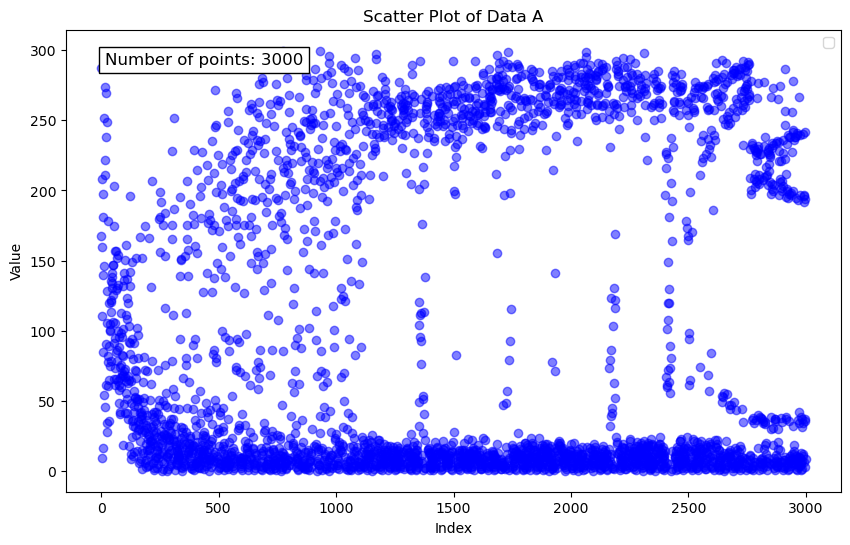

In [8]:
print(X_f_train.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f_train)), X_f_train, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(3000, 1)


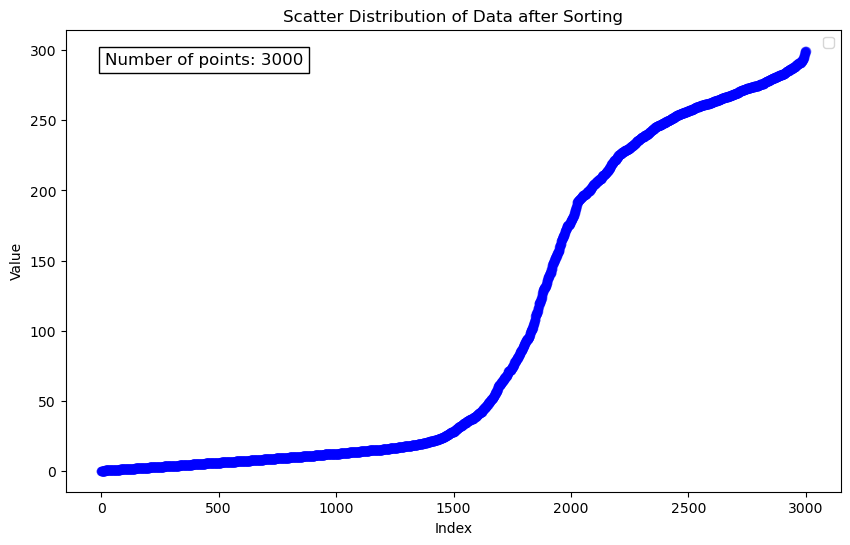

In [9]:
X = np.sort(X_f_train, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f_train)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [10]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.0004961103072333248, 0.00046619750453440645, 0.00044812994054817425, 0.00045496907788401787, 0.0004513845325750538, 0.0004558674997035522, 0.00046678459578557266, 0.0004525650254789307, 0.00046874762314118545, 0.00045332242312937755]
Error u of fuhe active learning(LHS sampling): 4.614079e-04
[0.00016970347599325975, 0.0001399383645091951, 0.00013781297423044056, 0.00013970093909752764, 0.00013902958034841834, 0.00013869683107313054, 0.00014214837803255186, 0.00013960507956494006, 0.0001456397286521445, 0.00013969511166029872]
MAE of fuhe active learning(LHS sampling): 1.431970e-04
[6.203581068937717e-08, 4.527632123083983e-08, 4.214798025891287e-08, 4.367475786156808e-08, 4.265338424267042e-08, 4.3480492701146856e-08, 4.528056672785499e-08, 4.2793838545444246e-08, 4.5639815561755474e-08, 4.313532590908815e-08]
MSE of fuhe active learning(LHS sampling): 4.561183e-08
[0.003492971, 0.034836244, 8.884817e-05, 7.809353e-06, 0.0024442598, 0.00012461333, 0.00010308255, 0.0106321955, 8.350

[0.0004961103072333248, 0.00046619750453440645, 0.00044812994054817425, 0.00045496907788401787, 0.0004513845325750538, 0.0004558674997035522, 0.00046678459578557266, 0.0004525650254789307, 0.00046874762314118545, 0.00045332242312937755]
mean Error u: 4.614079e-04
Variance Error u: 1.802476e-10


/tmp/ipykernel_294070/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


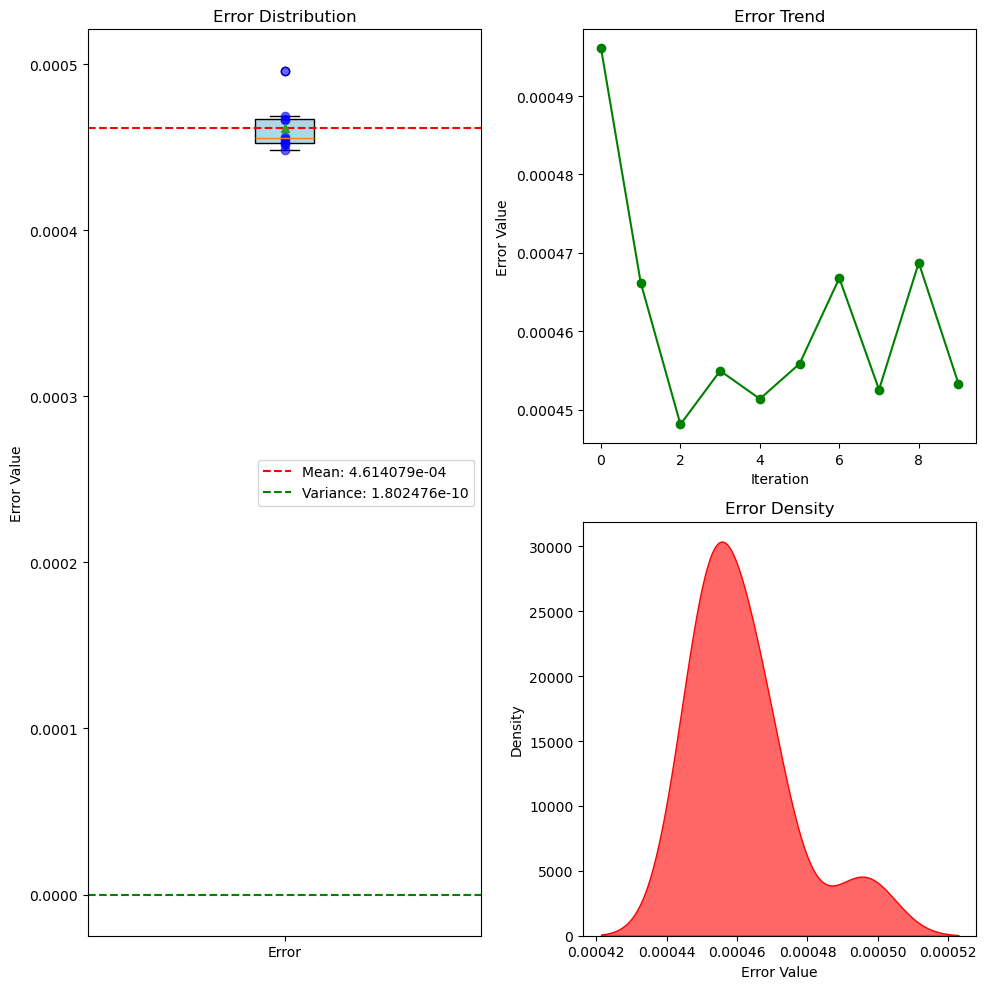

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.00016970347599325975, 0.0001399383645091951, 0.00013781297423044056, 0.00013970093909752764, 0.00013902958034841834, 0.00013869683107313054, 0.00014214837803255186, 0.00013960507956494006, 0.0001456397286521445, 0.00013969511166029872]
mean MAE: 1.431970e-04
Variance MAE: 8.242727e-11


/tmp/ipykernel_294070/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


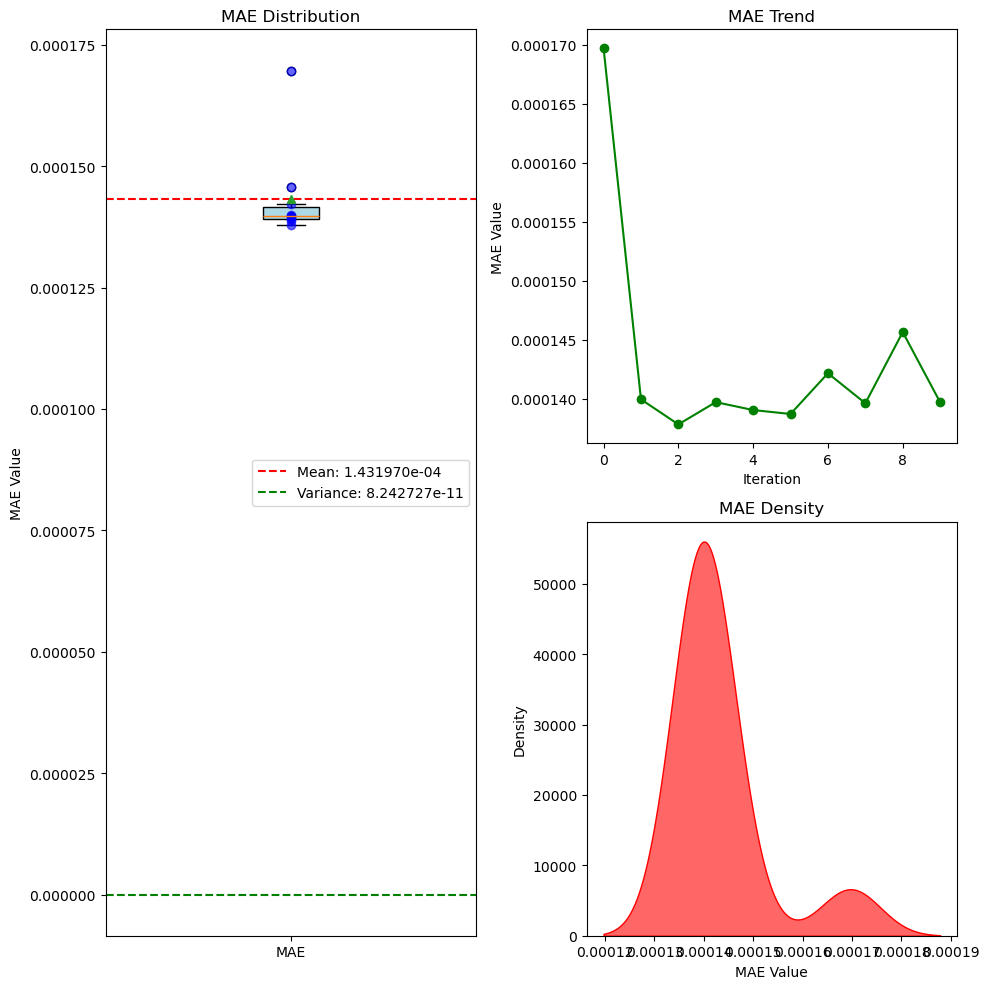

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[6.203581068937717e-08, 4.527632123083983e-08, 4.214798025891287e-08, 4.367475786156808e-08, 4.265338424267042e-08, 4.3480492701146856e-08, 4.528056672785499e-08, 4.2793838545444246e-08, 4.5639815561755474e-08, 4.313532590908815e-08]
mean MSE: 4.561183e-08
Variance MSE: 3.130899e-17


/tmp/ipykernel_294070/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


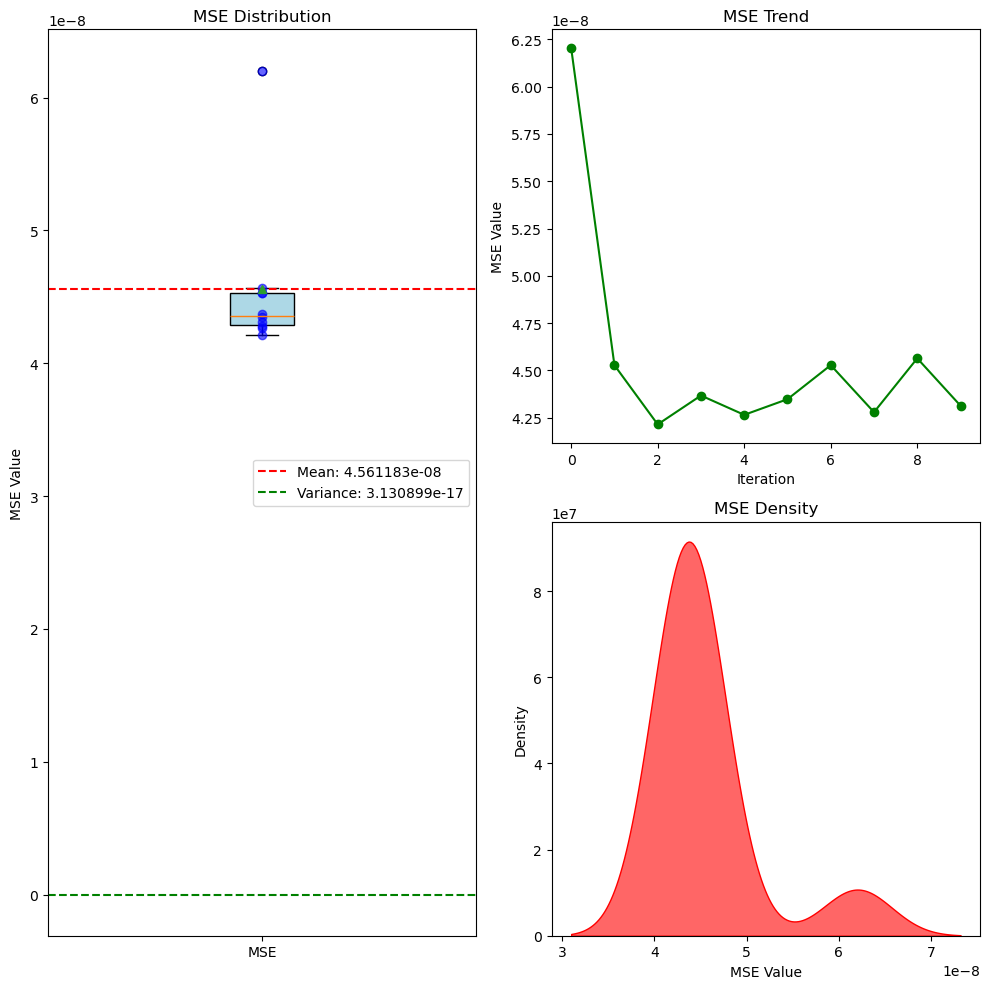

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.003492971, 0.034836244, 8.884817e-05, 7.809353e-06, 0.0024442598, 0.00012461333, 0.00010308255, 0.0106321955, 8.350033e-05, 0.015158418]
mean CHAOS: 6.697194e-03
Variance CHAOS: 1.126077e-04


/tmp/ipykernel_294070/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


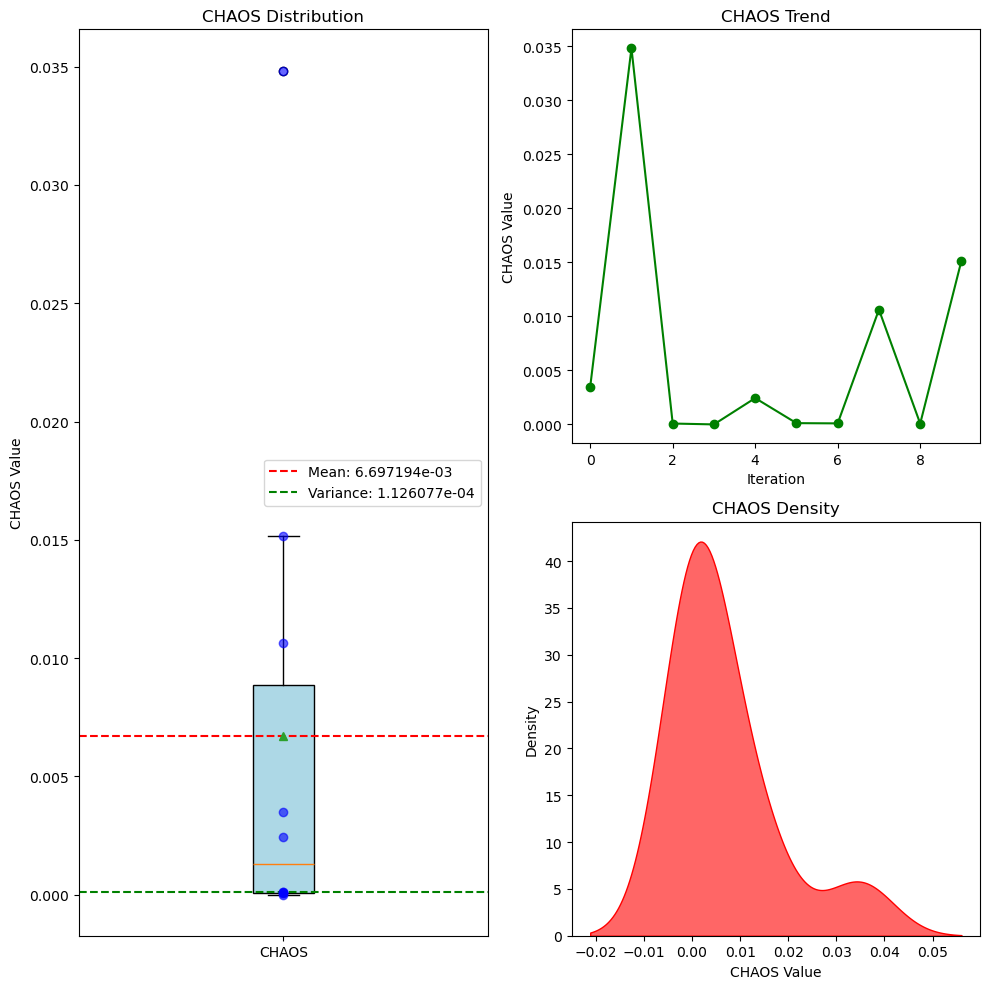

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[5.2104224e-07, 4.951812e-07, 4.2712873e-07, 4.6896048e-07, 4.3156956e-07, 4.4490844e-07, 4.4388298e-07, 4.6769492e-07, 4.5043407e-07, 4.001638e-07]
mean RESIDUAL: 4.550967e-07
Variance RESIDUAL: 1.091115e-15


/tmp/ipykernel_294070/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


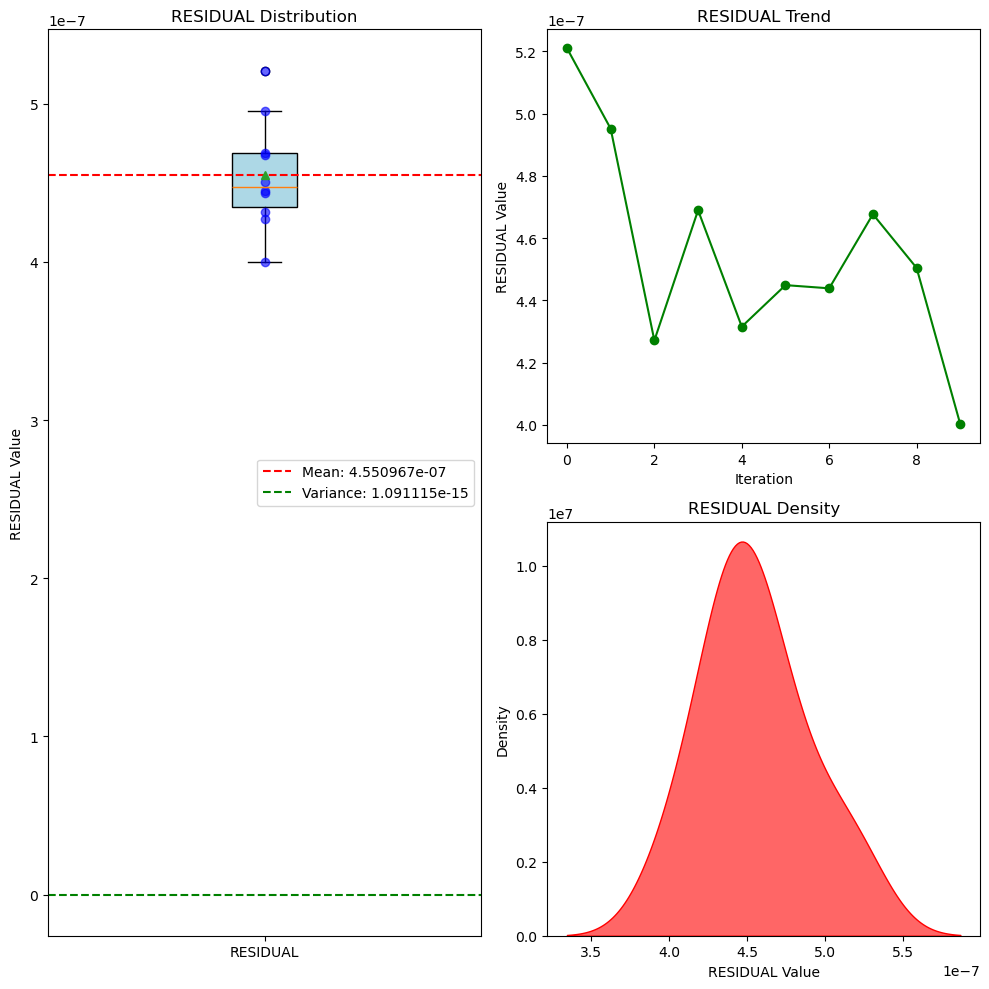

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [16]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

80000
[1.9720340e-01 1.6808018e-01 1.4076076e-01 ... 6.1218708e-10 6.1217936e-10
 6.1217187e-10]


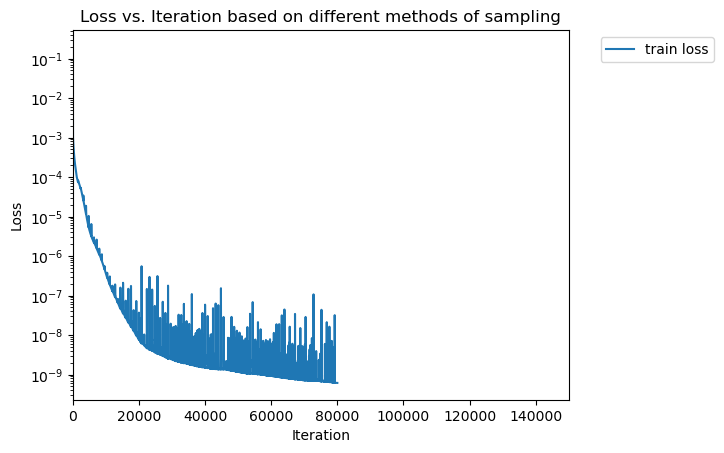

In [17]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,150000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

Text(0, 0.5, 'Probability')

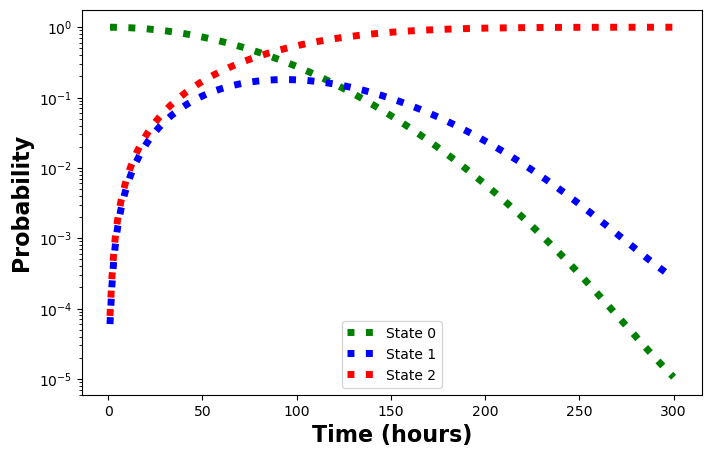

In [18]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'State 0', linewidth = 5, color = 'green', linestyle='dotted')
#绘制第一条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第一列，设置这条线的标签为State 0，线宽为5，颜色为绿色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'State 1', linewidth = 5, color = 'blue', linestyle='dotted')
#绘制第二条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第二列，设置这条线的标签为State 1，线宽为5，颜色为蓝色，线型为点线
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'State 2', linewidth = 5, color = 'red', linestyle='dotted')
#绘制第三条折线图，横坐标为x_star，代表不同的时刻，纵坐标为exact_solution_Laplace数据的第三列，设置这条线的标签为State 2，线宽为5，颜色为红色，线型为点线

plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

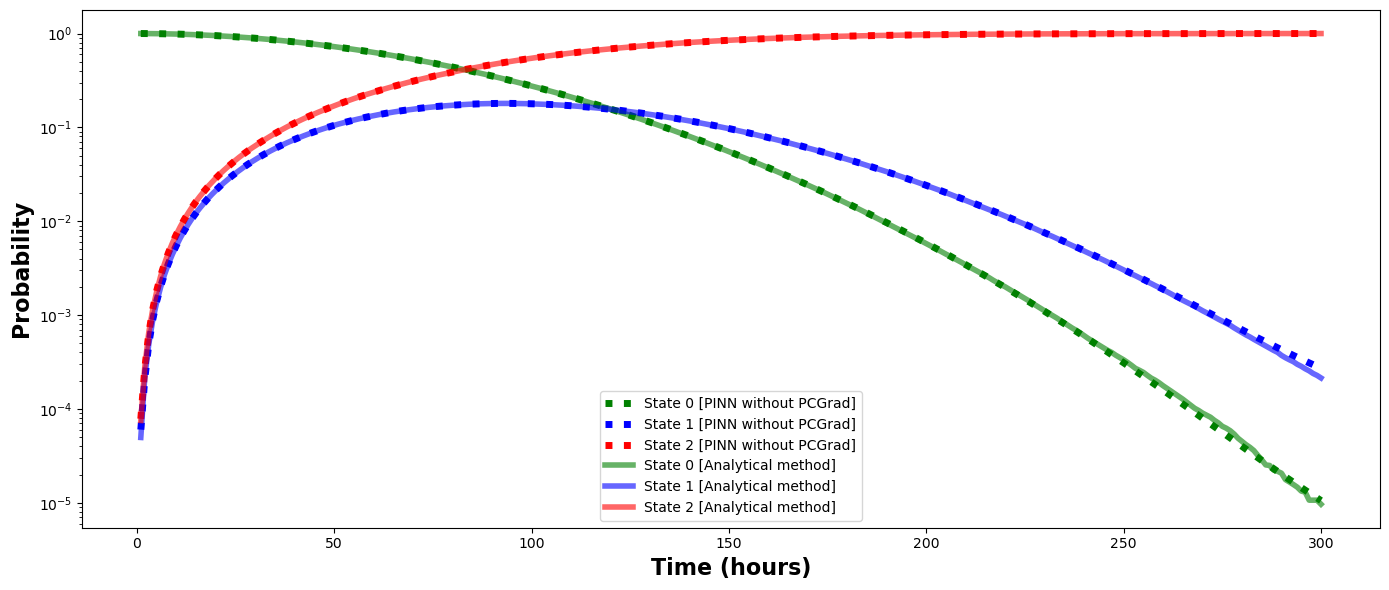

In [19]:
# 创建一个子图
f, ax = plt.subplots(1, 1, figsize=(14, 6))

# 绘制 PINN without PCGrad 方法的预测结果
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 0], label='State 0 [PINN without PCGrad]', linewidth=5, color='green', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 1], label='State 1 [PINN without PCGrad]', linewidth=5, color='blue', linestyle='dotted', ax=ax)
sns.lineplot(x=x_star.flatten(), y=y_pred[:, 2], label='State 2 [PINN without PCGrad]', linewidth=5, color='red', linestyle='dotted', ax=ax)

# 绘制 Runge-Kutta 方法的结果
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_0'], label='State 0 [Analytical method]', color='green', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_1'], label='State 1 [Analytical method]', color='blue', alpha=0.6, dashes=True, linewidth=4, ax=ax)
sns.lineplot(x=x_star.flatten(), y=MCS_solution_df['state_2'], label='State 2 [Analytical method]', color='red', alpha=0.6, dashes=True, linewidth=4, ax=ax)


# 设置 y 轴为对数刻度
ax.set_yscale("log")
# ax.set_ylim([1e-9, 2])
ax.set_xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

# 自动调整子图参数
plt.tight_layout()


# 显示图形
plt.show()

### 计算RMSE

In [20]:
y_pred_df = pd.DataFrame(y_pred, columns = ['state_0', 'state_1', 'state_2'])
print(y_pred_df.head())
print(y_pred_df.tail())

    state_0   state_1   state_2
0  0.999861  0.000060  0.000079
1  0.999526  0.000207  0.000267
2  0.998889  0.000485  0.000626
3  0.997972  0.000885  0.001143
4  0.996807  0.001392  0.001801
      state_0   state_1   state_2
295  0.000014  0.000324  0.999663
296  0.000013  0.000310  0.999678
297  0.000012  0.000296  0.999692
298  0.000011  0.000283  0.999705
299  0.000011  0.000271  0.999718


In [21]:
y_diff_no_pcgrad_MCS = MCS_solution_df - y_pred_df #解析方法（特征向量）和PINN方法差值

In [22]:
### PINN和解析方法的RMSE计算
#计算MSE，对PINN和解析方法的差值的每一行应用一个匿名函数，计算三个状态的平方和，结果存储在DataFrame的新列'mse'中
y_diff_no_pcgrad_MCS['mse'] = y_diff_no_pcgrad_MCS.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
#计算RMSE，对'mse'列应用np.sqrt函数，结果存储在DataFrame的新列'rmse'中
y_diff_no_pcgrad_MCS['rmse'] = y_diff_no_pcgrad_MCS['mse'].apply(np.sqrt)

In [23]:
#0-80000个时间的RMSE
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_MCS['rmse']))

#前60000个时间的RMSE，3749/5000=60000/80000
print ('RMSE between PINN without PCGrad and the analytical solution before 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][:3749]))

#60000到80000的RMSE
print ('RMSE between PINN without PCGrad and the analytical solution after 60000 is', 
       np.mean(y_diff_no_pcgrad_MCS['rmse'][3749:]))

RMSE of between PINN without PCGrad and the analytical solution is 0.0002641326079648179
RMSE between PINN without PCGrad and the analytical solution before 60000 is 0.0002641326079648179
RMSE between PINN without PCGrad and the analytical solution after 60000 is nan


### 计算混沌度和残差

In [24]:
x_star.shape

(300, 1)

In [25]:
#计算chaos
y_chaos = model.hidden_predict(x_star, 100)
# print(y_chaos)
x_sss = x_star + np.random.normal(0, 0.01)
y_chaos_sss = model.hidden_predict(x_sss, 50)
chaju = np.linalg.norm(y_chaos - y_chaos_sss,axis=1)
print(chaju)
print(chaju.shape)
print(chaju.sum())

[2.0914066 1.9914316 1.9253483 1.8746026 1.8341168 1.8054904 1.7930607
 1.8049041 1.8538474 1.9249463 1.8926528 1.8183454 1.8142885 1.8337867
 1.8589089 1.8798459 1.896887  1.9120508 1.9264611 1.9404917 1.9541551
 1.9673178 1.97979   1.9914051 2.0019813 2.011325  2.0192013 2.0252452
 2.0288928 2.0292883 2.0253906 2.017176  2.008218  2.0031385 2.0008886
 2.0556211 2.1125712 2.0685391 2.011819  1.9742043 1.9464527 1.920686
 1.895142  1.870257  1.8465382 1.8242817 1.80367   1.7848206 1.7677121
 1.7523013 1.7384793 1.7261101 1.7150915 1.7053022 1.6966121 1.6889218
 1.6821281 1.6761386 1.6708529 1.6662052 1.6621107 1.6585164 1.6553459
 1.6525614 1.6501123 1.64796   1.6460596 1.6443918 1.642915  1.6416123
 1.6404579 1.6394445 1.6385442 1.6377398 1.6370356 1.6364044 1.6358429
 1.6353387 1.6348941 1.6344931 1.6341367 1.6338149 1.6335275 1.6332701
 1.6330353 1.6328249 1.6326399 1.632473  1.6323164 1.6321815 1.632065
 1.6319534 1.6318586 1.6317737 1.6316981 1.6316366 1.6315812 1.6315335
 1.63149

Text(0.5, 1.0, 'Chaos of x_star')

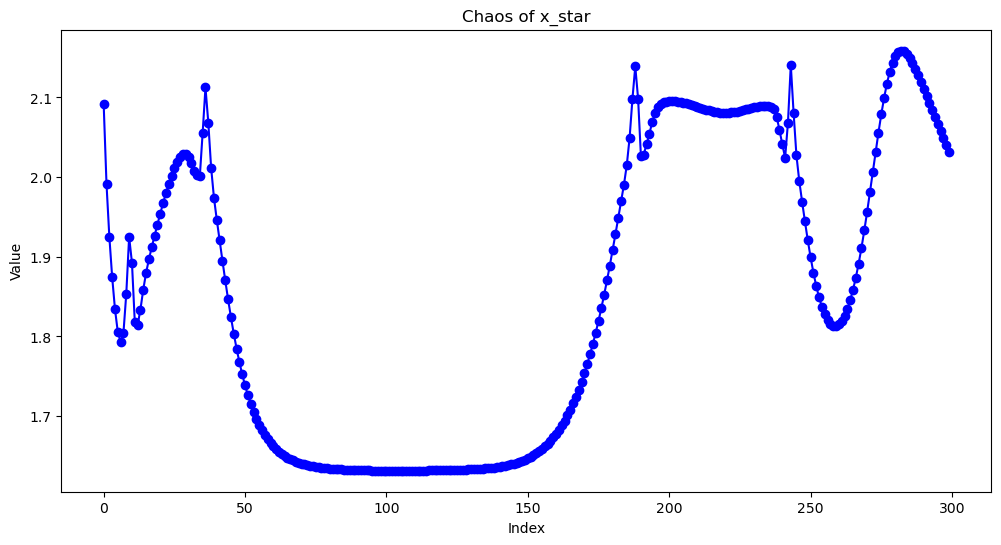

In [26]:
data = chaju
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Chaos of x_star')


In [27]:
#计算残差
_, residual = model.predict(x_star)
residual = residual.flatten()
print(residual)
print(residual.shape)
print(residual.sum())

[-1.1612428e-08 -4.5838533e-09  1.2747478e-08 -1.4842954e-09
 -4.5984052e-09 -7.2177500e-09  6.0535967e-09 -2.8521754e-09
 -2.2118911e-09  8.7311491e-09 -3.4924597e-09  5.0058588e-09
  3.6088750e-09  1.5133992e-09 -6.9849193e-10 -1.3969839e-09
  1.7462298e-09 -4.6566129e-10 -2.0954758e-09  2.3283064e-10
  2.3283064e-10  2.3283064e-10 -6.9849193e-10 -1.6298145e-09
  2.3283064e-09 -6.9849193e-10 -4.6566129e-10  6.9849193e-10
  9.3132257e-10  2.3283064e-10 -9.3132257e-10  1.3969839e-09
 -3.0267984e-09  1.8626451e-09 -4.6566129e-10  2.0954758e-09
 -2.3283064e-10  1.3969839e-09  9.3132257e-10 -6.9849193e-10
  2.3283064e-10  2.3283064e-10 -4.6566129e-10 -2.3283064e-09
 -1.6298145e-09  0.0000000e+00 -9.3132257e-10 -9.3132257e-10
  2.3283064e-10 -6.9849193e-10  4.6566129e-10 -2.3283064e-10
  1.3969839e-09  0.0000000e+00  1.8626451e-09 -2.0954758e-09
 -6.9849193e-10  4.6566129e-10  1.6298145e-09  2.3283064e-10
 -1.3969839e-09  9.3132257e-10  6.9849193e-10 -1.1641532e-09
  9.3132257e-10 -1.62981

Text(0.5, 1.0, 'Residual of x_star')

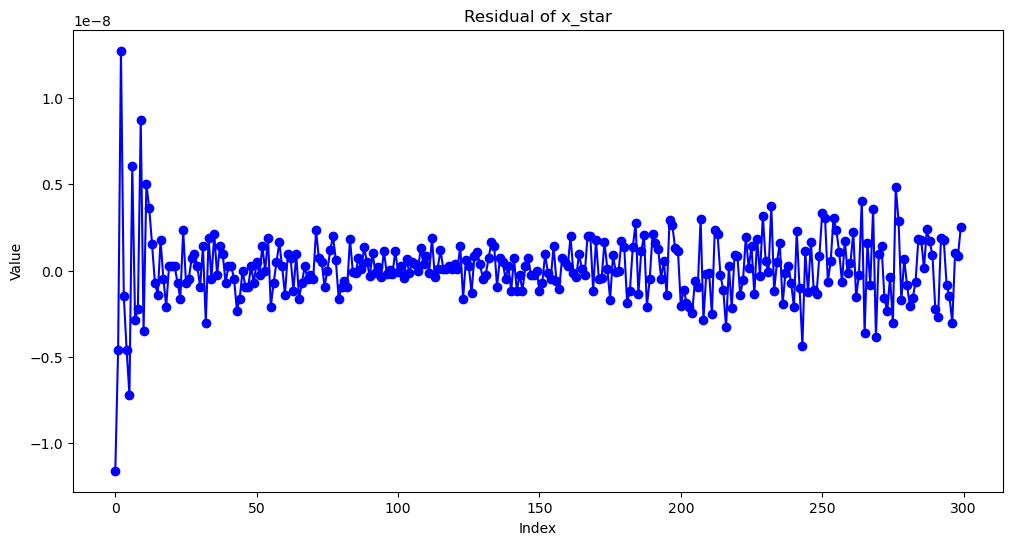

In [28]:
data = residual
# 绘制折线图
plt.figure(figsize=(12, 6))

plt.plot(data, marker='o', linestyle='-', color='b')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Residual of x_star')
